In [1]:
!nvidia-smi

Wed Feb 28 12:59:49 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 545.23.08              Driver Version: 545.23.08    CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 2080        On  | 00000000:01:00.0  On |                  N/A |
| 32%   30C    P8              20W / 215W |    532MiB /  8192MiB |     13%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os
os.getcwd()

'/home/linh/projects/IConNet/notebooks'

In [4]:
os.chdir('..')

In [5]:
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:512"
import gc
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import sys
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [6]:
import glob
import numpy as np
from tqdm import tqdm
import itertools
import matplotlib.pyplot as plt
import pandas as pd

# Scikit learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

In [11]:
data_dir = '../data/data_preprocessed/crema_d/preprocessed/'

In [12]:
sr = 16000

data_x = np.load(f'{data_dir}crema_d.audio16k.npy', allow_pickle=True)
data_y = np.load(f'{data_dir}crema_d.label_emotion.npy', allow_pickle=True)
classnames = np.load(f'{data_dir}crema_d.classnames.npy', allow_pickle=True)
print(data_x.shape)
print(data_y.shape)
np.unique(data_y)

(7438,)
(7438,)


array([0, 1, 2, 3, 4, 5], dtype=int16)

In [13]:
classnames

array(['NEU', 'HAP', 'SAD', 'ANG', 'FEA', 'DIS'], dtype='<U3')

In [14]:
labels = ['ANG', 'NEU', 'SAD', 'HAP']

def label_filter(idx):
    return classnames[idx] in labels

def label_to_index(idx):
    return labels.index(classnames[idx])
    
filtered_idx = [label_filter(idx) for idx in data_y]
data_x = data_x[filtered_idx]
data_y = [label_to_index(idx) for idx in data_y[filtered_idx]]
print(data_x.shape)

(4898,)


In [15]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(
    data_x, data_y, test_size=0.2, 
    random_state=42, stratify=data_y)
print("Train: %i" % len(x_train))
print("Test: %i" % len(x_test))

Train: 3918
Test: 980


In [16]:
train_set = list(zip(x_train, y_train))
test_set = list(zip(x_test, y_test))

In [46]:
def pad_sequence(batch):
    # Make all tensor in a batch the same length by padding with zeros
    batch = [item.t() for item in batch]
    batch = torch.nn.utils.rnn.pad_sequence(
        batch, batch_first=True, padding_value=0.).permute(0, 2, 1)
    return batch

def collate_fn(batch, max_duration_in_second=3, sample_rate=sr):
    tensors, targets = [], []

    # Gather in lists, and encode labels as indices
    for waveform, label in batch:
        if max_duration_in_second is not None:
            waveform = np.array(waveform, dtype=float).squeeze()
            length = len(waveform)
            max_length = sample_rate * max_duration_in_second
            offset = max(0, (length - max_length) // 2)
            waveform = waveform[offset: length-offset]
        tensors += [torch.tensor(waveform, dtype=torch.float32)[None,:]]
        targets += [torch.tensor(label, dtype=torch.long)]

    # Group the list of tensors into a batched tensor
    tensors = pad_sequence(tensors)
    targets = torch.stack(targets)
    return tensors, targets

batch_size = 16

if device == "cuda":
    num_workers = 1
    pin_memory = True
else:
    num_workers = 0
    pin_memory = False

train_loader = torch.utils.data.DataLoader(
    train_set,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory, 
    drop_last=True
)
test_loader = torch.utils.data.DataLoader(
    test_set,
    batch_size=batch_size,
    shuffle=False,
    drop_last=True,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory
)

In [30]:
from IConNet.nn.model import M13

In [31]:
from omegaconf import OmegaConf as ocf

In [32]:
import traceback

In [49]:
model_config_path = 'config/model/m13ser.yaml'
model_config = ocf.load(model_config_path)
model_config

{'name': 'M13', 'description': 'FirConv with fftconv', 'fe': {'n_block': 2, 'n_channel': [198, 30], 'kernel_size': [511, 127], 'stride': [2, 4], 'window_k': [5, 9], 'mel_resolution': 3, 'residual_connection_type': 'stack', 'pooling': 'mean', 'filter_type': 'firwin', 'conv_mode': 'fftconv', 'norm_type': 'LocalResponseNorm'}, 'cls': {'n_block': 2, 'n_hidden_dim': [512, 512], 'norm_type': 'LayerNorm'}}

In [50]:
model = M13(config=model_config,
           n_input=1, n_output=len(labels))
model

M13(
  (fe_blocks): FeBlocks(
    (blocks): ModuleList(
      (0-1): 2 x FrontEndBlock(
        (block): ModuleDict(
          (layer): FirConvLayer(
            (conv_layer): ResidualConv1d(
              (pad_layer): PadForConv()
              (stride_layer): DownsampleLayer(
                (pad_right): PadForConv()
              )
              (norm_layer): CustomNormLayer(
                (layer): LocalResponseNorm(2, alpha=0.0001, beta=0.75, k=1.0)
              )
              (act): NLReLU()
            )
          )
          (downsample): ResidualConv1d(
            (pad_layer): PadForConv()
            (stride_layer): DownsampleLayer(
              (pad_right): PadForConv()
            )
            (norm_layer): CustomNormLayer(
              (layer): LocalResponseNorm(2, alpha=0.0001, beta=0.75, k=1.0)
            )
            (act): NLReLU()
          )
        )
      )
    )
  )
  (cls_head): Classifier(
    (blocks): ModuleList(
      (0): Sequential(
        (norm):

In [51]:
n_epoch = 10
train_losses = []
test_accuracy = []
optimizer = optim.RAdam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=0.1,
    steps_per_epoch=len(train_loader), epochs=n_epoch)

In [52]:
train_loader_length = len(train_loader.dataset)
test_loader_length = len(test_loader.dataset)

def train(model, epoch, log_interval, 
          train_losses=train_losses):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        try:
            _mem_before = torch.cuda.memory_allocated()
            data = data.to(device)
            target = target.to(device)
            output = model(data)
            del data
            gc.collect()
            torch.cuda.empty_cache()
            loss = F.cross_entropy(output.squeeze(), target)
            _mem_during = torch.cuda.memory_allocated()
            del target
            gc.collect()
            torch.cuda.empty_cache()
            optimizer.zero_grad()
            loss.backward()
            nn.utils.clip_grad.clip_grad_norm_(
                model.parameters(), 1.0)
            optimizer.step()
            _mem_after = torch.cuda.memory_allocated()
            # print training stats
            if batch_idx % log_interval == 0:
                print(f"Train Epoch: {epoch} [{batch_idx * batch_size}/{train_loader_length} ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}")
                print(f'Mem before-during-after: {_mem_before} {_mem_during} {_mem_after}')
            # update progress bar
            pbar.update(pbar_update)
            # record loss
            train_losses.append(loss.item())
        except Exception as e:
            print(f'data: {data.shape} => output: {output.shape} | target: {target.shape}')
            traceback.print_exc()

@torch.no_grad
def test(model, epoch, test_loader=test_loader, device=device):
    model.eval()
    correct = 0
    total = 0
    for data, target in test_loader:
        total += len(target)
        data = data.to(device)
        target = target.to(device)
        output = model(data).squeeze()
        del data
        gc.collect()
        torch.cuda.empty_cache()
        probs = F.softmax(output, dim=-1)
        pred = probs.argmax(dim=-1)
        correct += pred.eq(target).sum().item()
        del target
        gc.collect()
        torch.cuda.empty_cache()
        pbar.update(pbar_update)
    acc = correct / test_loader_length
    print(f"\nTest Epoch: {epoch}\tAccuracy: {correct}/{total} ({100. * acc:.0f}%)\n")
    return acc

In [53]:
log_interval = 40
pbar_update = 1 / (len(train_loader) + len(test_loader))
model.to(device)
with tqdm(total=n_epoch) as pbar:
    for epoch in range(1, n_epoch + 1):
        train(model, epoch, log_interval, train_losses)
        acc = test(model, epoch)
        test_accuracy += [acc]
        scheduler.step()

  0%|                                 | 0.003278688524590164/10 [00:00<30:31, 183.24s/it]

Train Epoch: 1 [0/3918 (0%)]	Loss: 1.501312
Mem before-during-after: 13788672 4040270848 56999424


  1%|▍                                 | 0.13442622950819672/10 [00:16<19:06, 116.20s/it]

Train Epoch: 1 [640/3918 (16%)]	Loss: 1.422818
Mem before-during-after: 57881088 4055741440 57022976


  3%|▉                                 | 0.26557377049180286/10 [00:32<20:30, 126.36s/it]

Train Epoch: 1 [1280/3918 (33%)]	Loss: 1.211070
Mem before-during-after: 57022976 4053644288 57881088


  4%|█▍                                   | 0.39672131147541/10 [00:48<23:28, 146.67s/it]

Train Epoch: 1 [1920/3918 (49%)]	Loss: 1.083974
Mem before-during-after: 57698816 4056074240 57779712


  5%|█▊                                 | 0.5278688524590167/10 [01:04<18:31, 117.38s/it]

Train Epoch: 1 [2560/3918 (66%)]	Loss: 1.000385
Mem before-during-after: 57779712 4056576000 57779712


  7%|██▎                                | 0.6590163934426216/10 [01:19<21:18, 136.88s/it]

Train Epoch: 1 [3200/3918 (82%)]	Loss: 1.137436
Mem before-during-after: 57779712 3672547840 57603584


  8%|██▊                                | 0.7901639344262266/10 [01:36<20:40, 134.72s/it]

Train Epoch: 1 [3840/3918 (98%)]	Loss: 0.886049
Mem before-during-after: 58104320 4053668352 57779712


 10%|███▌                                | 0.9999999999999944/10 [01:50<09:48, 65.44s/it]


Test Epoch: 1	Accuracy: 500/976 (51%)



 10%|███▌                                | 1.0032786885245846/10 [01:50<11:51, 79.06s/it]

Train Epoch: 2 [0/3918 (0%)]	Loss: 0.923535
Mem before-during-after: 56961536 4053864448 57665024


 11%|███▉                               | 1.1344262295081895/10 [02:06<17:28, 118.27s/it]

Train Epoch: 2 [640/3918 (16%)]	Loss: 1.327605
Mem before-during-after: 57779712 4056576000 57779712


 13%|████▍                              | 1.2655737704917944/10 [02:22<16:50, 115.64s/it]

Train Epoch: 2 [1280/3918 (33%)]	Loss: 0.996149
Mem before-during-after: 58104320 4056343552 58104320


 14%|████▉                              | 1.3967213114753994/10 [02:37<19:43, 137.61s/it]

Train Epoch: 2 [1920/3918 (49%)]	Loss: 0.949744
Mem before-during-after: 57779712 4054478848 57779712


 15%|█████▎                             | 1.5278688524590043/10 [02:53<19:09, 135.73s/it]

Train Epoch: 2 [2560/3918 (66%)]	Loss: 1.178094
Mem before-during-after: 57206272 4055372800 57285120


 17%|█████▊                             | 1.6590163934426092/10 [03:08<15:47, 113.62s/it]

Train Epoch: 2 [3200/3918 (82%)]	Loss: 0.849142
Mem before-during-after: 57779712 4055717888 57779712


 18%|██████▎                            | 1.7901639344262141/10 [03:24<17:55, 131.04s/it]

Train Epoch: 2 [3840/3918 (98%)]	Loss: 1.126364
Mem before-during-after: 57779712 3846981120 57073152


 20%|███████▍                             | 1.999999999999982/10 [03:39<08:46, 65.87s/it]


Test Epoch: 2	Accuracy: 540/976 (55%)



 20%|███████▏                            | 2.0032786885245724/10 [03:39<10:30, 78.86s/it]

Train Epoch: 3 [0/3918 (0%)]	Loss: 1.112576
Mem before-during-after: 56961536 4053864448 57665024


 21%|███████▍                           | 2.1344262295081773/10 [03:55<15:38, 119.37s/it]

Train Epoch: 3 [640/3918 (16%)]	Loss: 1.135035
Mem before-during-after: 57779712 4056576000 57779712


 23%|████████▏                           | 2.265573770491782/10 [04:10<14:53, 115.55s/it]

Train Epoch: 3 [1280/3918 (33%)]	Loss: 1.171887
Mem before-during-after: 57779712 4027323904 56898048


 24%|████████▋                           | 2.396721311475387/10 [04:26<16:30, 130.34s/it]

Train Epoch: 3 [1920/3918 (49%)]	Loss: 1.088457
Mem before-during-after: 57362432 3928835584 56898048


 25%|█████████                           | 2.527868852458992/10 [04:42<16:31, 132.66s/it]

Train Epoch: 3 [2560/3918 (66%)]	Loss: 1.066855
Mem before-during-after: 56898048 4053971456 57779712


 27%|█████████▌                          | 2.659016393442597/10 [04:58<15:40, 128.13s/it]

Train Epoch: 3 [3200/3918 (82%)]	Loss: 0.986915
Mem before-during-after: 57286656 4053732352 57843712


 28%|██████████                          | 2.790163934426202/10 [05:13<14:04, 117.12s/it]

Train Epoch: 3 [3840/3918 (98%)]	Loss: 0.780102
Mem before-during-after: 57779712 4055717888 57779712


 30%|███████████▍                          | 2.99999999999997/10 [05:28<07:42, 66.08s/it]


Test Epoch: 3	Accuracy: 535/976 (55%)



 30%|███████████▍                          | 3.00327868852456/10 [05:28<09:17, 79.69s/it]

Train Epoch: 4 [0/3918 (0%)]	Loss: 0.830926
Mem before-during-after: 56961536 4053864448 57665024


 31%|███████████▎                        | 3.134426229508165/10 [05:44<13:53, 121.40s/it]

Train Epoch: 4 [640/3918 (16%)]	Loss: 1.020939
Mem before-during-after: 57779712 4054478848 57779712


 33%|████████████                         | 3.26557377049177/10 [06:00<13:53, 123.84s/it]

Train Epoch: 4 [1280/3918 (33%)]	Loss: 1.186559
Mem before-during-after: 58104320 4055765504 57779712


 34%|███████████▉                       | 3.3967213114753747/10 [06:16<12:47, 116.18s/it]

Train Epoch: 4 [1920/3918 (49%)]	Loss: 0.855084
Mem before-during-after: 57779712 4056576000 57779712


 35%|████████████▎                      | 3.5278688524589796/10 [06:31<13:51, 128.42s/it]

Train Epoch: 4 [2560/3918 (66%)]	Loss: 0.625182
Mem before-during-after: 57222656 4053921792 57779712


 37%|████████████▊                      | 3.6590163934425846/10 [06:47<14:42, 139.20s/it]

Train Epoch: 4 [3200/3918 (82%)]	Loss: 1.030046
Mem before-during-after: 57206272 3929405952 56921600


 38%|█████████████▎                     | 3.7901639344261895/10 [07:02<13:03, 126.24s/it]

Train Epoch: 4 [3840/3918 (98%)]	Loss: 1.177823
Mem before-during-after: 57628160 4056369664 57222656


 40%|██████████████▍                     | 3.9999999999999574/10 [07:17<06:26, 64.42s/it]


Test Epoch: 4	Accuracy: 518/976 (53%)



 40%|██████████████▍                     | 4.0032786885245475/10 [07:17<07:41, 77.03s/it]

Train Epoch: 5 [0/3918 (0%)]	Loss: 1.400368
Mem before-during-after: 56961536 4053864448 57665024


 41%|██████████████▉                     | 4.134426229508152/10 [07:33<12:18, 125.85s/it]

Train Epoch: 5 [640/3918 (16%)]	Loss: 0.707456
Mem before-during-after: 57779712 4056576000 57779712


 43%|███████████████▎                    | 4.265573770491757/10 [07:49<10:49, 113.24s/it]

Train Epoch: 5 [1280/3918 (33%)]	Loss: 1.527576
Mem before-during-after: 57779712 3997049856 56898048


 44%|███████████████▊                    | 4.396721311475362/10 [08:05<11:26, 122.53s/it]

Train Epoch: 5 [1920/3918 (49%)]	Loss: 1.217026
Mem before-during-after: 57779712 3805459968 57206272


 45%|████████████████▎                   | 4.527868852458967/10 [08:21<11:42, 128.29s/it]

Train Epoch: 5 [2560/3918 (66%)]	Loss: 1.221769
Mem before-during-after: 56898048 4056926720 57779712


 47%|████████████████▊                   | 4.659016393442572/10 [08:36<11:34, 129.99s/it]

Train Epoch: 5 [3200/3918 (82%)]	Loss: 0.927936
Mem before-during-after: 57779712 4054478848 57779712


 48%|█████████████████▏                  | 4.790163934426177/10 [08:51<10:00, 115.18s/it]

Train Epoch: 5 [3840/3918 (98%)]	Loss: 1.426465
Mem before-during-after: 57779712 4056576000 57779712


 50%|██████████████████▍                  | 4.999999999999945/10 [09:06<05:19, 63.99s/it]


Test Epoch: 5	Accuracy: 544/976 (56%)



 50%|██████████████████▌                  | 5.003278688524535/10 [09:06<06:33, 78.82s/it]

Train Epoch: 6 [0/3918 (0%)]	Loss: 0.854525
Mem before-during-after: 56961536 4053864448 57665024


 51%|██████████████████▉                  | 5.13442622950814/10 [09:22<10:46, 132.97s/it]

Train Epoch: 6 [640/3918 (16%)]	Loss: 1.453021
Mem before-during-after: 57842176 4056521728 58661376


 53%|██████████████████▉                 | 5.265573770491745/10 [09:38<10:32, 133.65s/it]

Train Epoch: 6 [1280/3918 (33%)]	Loss: 1.445552
Mem before-during-after: 57073152 4055983104 57264640


 54%|███████████████████▉                 | 5.39672131147535/10 [09:53<09:28, 123.42s/it]

Train Epoch: 6 [1920/3918 (49%)]	Loss: 0.977054
Mem before-during-after: 57779712 4054803456 58104320


 55%|███████████████████▉                | 5.527868852458955/10 [10:09<09:41, 129.95s/it]

Train Epoch: 6 [2560/3918 (66%)]	Loss: 0.752432
Mem before-during-after: 57222656 3846020608 57073152


 57%|████████████████████▉                | 5.65901639344256/10 [10:24<09:10, 126.78s/it]

Train Epoch: 6 [3200/3918 (82%)]	Loss: 0.929725
Mem before-during-after: 58104320 4056090112 58104320


 58%|████████████████████▊               | 5.790163934426165/10 [10:39<08:07, 115.89s/it]

Train Epoch: 6 [3840/3918 (98%)]	Loss: 1.086356
Mem before-during-after: 57779712 4056576000 57779712


 60%|█████████████████████▌              | 5.9999999999999325/10 [10:54<04:20, 65.23s/it]


Test Epoch: 6	Accuracy: 514/976 (52%)



 60%|██████████████████████▏              | 6.003278688524523/10 [10:55<05:17, 79.55s/it]

Train Epoch: 7 [0/3918 (0%)]	Loss: 1.343410
Mem before-during-after: 56961536 3971602432 56898048


 61%|█████████████████████▍             | 6.1344262295081275/10 [11:11<07:54, 122.79s/it]

Train Epoch: 7 [640/3918 (16%)]	Loss: 0.685488
Mem before-during-after: 57779712 4054478848 57779712


 63%|█████████████████████▉             | 6.2655737704917325/10 [11:26<07:12, 115.71s/it]

Train Epoch: 7 [1280/3918 (33%)]	Loss: 0.882086
Mem before-during-after: 57022976 4053644288 57881088


 64%|███████████████████████             | 6.396721311475337/10 [11:42<07:27, 124.06s/it]

Train Epoch: 7 [1920/3918 (49%)]	Loss: 0.771841
Mem before-during-after: 58104320 4054246400 58104320


 65%|███████████████████████▌            | 6.527868852458942/10 [11:58<07:39, 132.34s/it]

Train Epoch: 7 [2560/3918 (66%)]	Loss: 1.049775
Mem before-during-after: 58104320 4055789056 58661376


 67%|███████████████████████▉            | 6.659016393442547/10 [12:13<06:26, 115.71s/it]

Train Epoch: 7 [3200/3918 (82%)]	Loss: 0.903330
Mem before-during-after: 58104320 4055533056 58104320


 68%|████████████████████████▍           | 6.790163934426152/10 [12:29<06:13, 116.24s/it]

Train Epoch: 7 [3840/3918 (98%)]	Loss: 0.961029
Mem before-during-after: 57779712 3997049856 56898048


 70%|██████████████████████████▌           | 6.99999999999992/10 [12:43<03:19, 66.55s/it]


Test Epoch: 7	Accuracy: 530/976 (54%)



 70%|██████████████████████████▌           | 7.00327868852451/10 [12:44<03:54, 78.22s/it]

Train Epoch: 8 [0/3918 (0%)]	Loss: 0.902443
Mem before-during-after: 56890880 3971588608 57726976


 71%|█████████████████████████▋          | 7.134426229508115/10 [12:59<05:33, 116.52s/it]

Train Epoch: 8 [640/3918 (16%)]	Loss: 0.932519
Mem before-during-after: 57779712 4055717888 57779712


 73%|██████████████████████████▉          | 7.26557377049172/10 [13:15<06:12, 136.23s/it]

Train Epoch: 8 [1280/3918 (33%)]	Loss: 1.002684
Mem before-during-after: 56940544 4055055872 58006016


 74%|██████████████████████████▋         | 7.396721311475325/10 [13:30<05:13, 120.26s/it]

Train Epoch: 8 [1920/3918 (49%)]	Loss: 1.305844
Mem before-during-after: 57779712 3722689536 57470976


 75%|███████████████████████████▊         | 7.52786885245893/10 [13:47<05:25, 131.67s/it]

Train Epoch: 8 [2560/3918 (66%)]	Loss: 0.766216
Mem before-during-after: 56927744 4055407616 57246208


 77%|███████████████████████████▌        | 7.659016393442535/10 [14:02<04:28, 114.71s/it]

Train Epoch: 8 [3200/3918 (82%)]	Loss: 0.724698
Mem before-during-after: 57779712 4056576000 57779712


 78%|████████████████████████████▊        | 7.79016393442614/10 [14:18<04:37, 125.61s/it]

Train Epoch: 8 [3840/3918 (98%)]	Loss: 0.931646
Mem before-during-after: 57779712 4028156928 57425408


 80%|█████████████████████████████▌       | 7.999999999999908/10 [14:32<02:11, 65.67s/it]


Test Epoch: 8	Accuracy: 547/976 (56%)



 80%|█████████████████████████████▌       | 8.003278688524498/10 [14:32<02:36, 78.51s/it]

Train Epoch: 9 [0/3918 (0%)]	Loss: 1.065207
Mem before-during-after: 56961536 3889663488 56898048


 81%|█████████████████████████████▎      | 8.134426229508103/10 [14:48<03:35, 115.67s/it]

Train Epoch: 9 [640/3918 (16%)]	Loss: 1.157910
Mem before-during-after: 57779712 4056576000 57779712


 83%|█████████████████████████████▊      | 8.265573770491708/10 [15:03<03:23, 117.49s/it]

Train Epoch: 9 [1280/3918 (33%)]	Loss: 1.127122
Mem before-during-after: 58104320 4055765504 57779712


 84%|██████████████████████████████▏     | 8.396721311475313/10 [15:19<03:31, 131.82s/it]

Train Epoch: 9 [1920/3918 (49%)]	Loss: 1.053845
Mem before-during-after: 56898048 4055750144 57842176


 85%|██████████████████████████████▋     | 8.527868852458917/10 [15:35<02:53, 117.79s/it]

Train Epoch: 9 [2560/3918 (66%)]	Loss: 0.853933
Mem before-during-after: 57779712 4056576000 57779712


 87%|███████████████████████████████▏    | 8.659016393442522/10 [15:50<02:33, 114.83s/it]

Train Epoch: 9 [3200/3918 (82%)]	Loss: 1.455150
Mem before-during-after: 57779712 4056018944 57222656


 88%|███████████████████████████████▋    | 8.790163934426127/10 [16:06<02:19, 114.92s/it]

Train Epoch: 9 [3840/3918 (98%)]	Loss: 1.020258
Mem before-during-after: 57779712 4056576000 57779712


 90%|█████████████████████████████████▎   | 8.999999999999895/10 [16:20<01:06, 66.05s/it]


Test Epoch: 9	Accuracy: 473/976 (48%)



 90%|█████████████████████████████████▎   | 9.003278688524485/10 [16:21<01:18, 78.68s/it]

Train Epoch: 10 [0/3918 (0%)]	Loss: 0.766159
Mem before-during-after: 56890880 4053852672 57660928


 91%|█████████████████████████████████▊   | 9.13442622950809/10 [16:37<01:40, 116.00s/it]

Train Epoch: 10 [640/3918 (16%)]	Loss: 0.702985
Mem before-during-after: 58104320 4056090112 58104320


 93%|█████████████████████████████████▎  | 9.265573770491695/10 [16:52<01:36, 131.89s/it]

Train Epoch: 10 [1280/3918 (33%)]	Loss: 0.730976
Mem before-during-after: 57073152 4054829568 57779712


 94%|███████████████████████████████████▋  | 9.3967213114753/10 [17:08<01:11, 119.17s/it]

Train Epoch: 10 [1920/3918 (49%)]	Loss: 0.715437
Mem before-during-after: 58104320 4055789056 58661376


 95%|██████████████████████████████████▎ | 9.527868852458905/10 [17:25<01:06, 140.15s/it]

Train Epoch: 10 [2560/3918 (66%)]	Loss: 0.906553
Mem before-during-after: 57779712 4054478848 57779712


 97%|███████████████████████████████████▋ | 9.65901639344251/10 [17:41<00:47, 138.14s/it]

Train Epoch: 10 [3200/3918 (82%)]	Loss: 0.841927
Mem before-during-after: 57779712 4053921792 57222656


 98%|███████████████████████████████████▏| 9.790163934426115/10 [17:57<00:25, 121.83s/it]

Train Epoch: 10 [3840/3918 (98%)]	Loss: 0.955136
Mem before-during-after: 57779712 4056576000 57779712


100%|███████████████████████████████████▉| 9.999999999999883/10 [18:12<00:00, 109.23s/it]


Test Epoch: 10	Accuracy: 565/976 (58%)



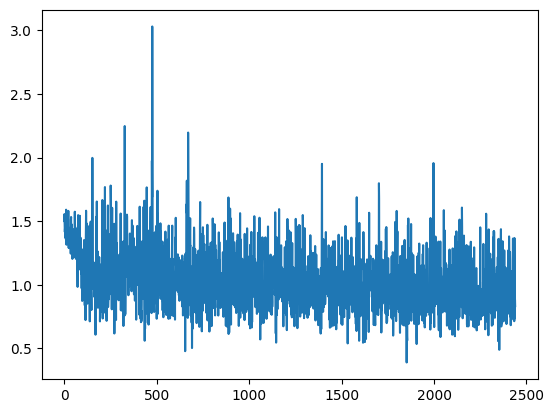

In [54]:
plt.plot(train_losses)

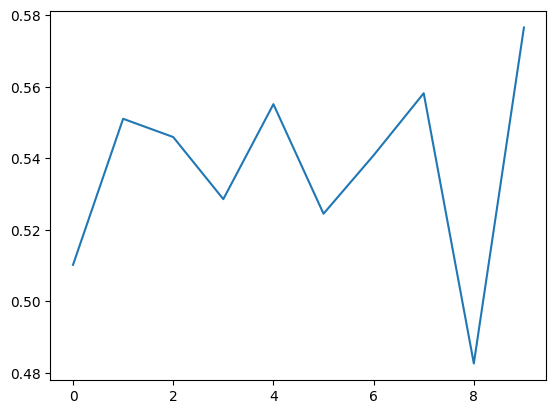

In [55]:
plt.plot(test_accuracy)

In [57]:
from torchmetrics.classification import (
    MulticlassAccuracy, MulticlassPrecision, 
    MulticlassRecall, MulticlassF1Score, 
    MulticlassConfusionMatrix,
    MulticlassAUROC
)
from torchmetrics import MetricCollection
from pprint import pprint

@torch.no_grad
def report_metrics(model, labels=labels, 
                   test_loader=test_loader, device=device):
    n = len(labels)
    metrics = MetricCollection({
        'acc_unweighted': MulticlassAccuracy(num_classes=n, average='macro'), 
        'acc_weighted': MulticlassAccuracy(num_classes=n, average='weighted'), 
        
        'f1s_unweighted': MulticlassF1Score(num_classes=n, average='macro'),  
        'f1s_weighted': MulticlassF1Score(num_classes=n, average='weighted'),  

        'acc_weighted': MulticlassAccuracy(num_classes=n, average='weighted'), 
        'uar': MulticlassRecall(num_classes=n, average='macro'), 
        'wap': MulticlassPrecision(num_classes=n, average='weighted'),
        'rocauc': MulticlassAUROC(num_classes=n, average='macro', thresholds=None),    
        'f1s_detail': MulticlassF1Score(num_classes=n, average=None),  
        'acc_detail': MulticlassAccuracy(num_classes=n, average=None), 
        'precision_detail': MulticlassPrecision(num_classes=n, average=None),
        'recall_detail': MulticlassRecall(num_classes=n, average=None), 
        'rocauc_detail': MulticlassAUROC(num_classes=n, average=None, thresholds=None),
    }).to(device)
    confusion_matrix = MulticlassConfusionMatrix(num_classes=n).to(device)
    model.eval()
    correct = 0
    total = 0
    for data, target in test_loader:
        total += len(target)
        
        data = data.to(device)
        target = target.to(device)
        output = model(data).squeeze()
        del data
        gc.collect()
        torch.cuda.empty_cache()
        probs = F.softmax(output, dim=-1)
        pred = probs.argmax(dim=-1)
        correct += pred.eq(target).sum().item()
        
        metrics.update(probs, target)
        confusion_matrix.update(pred, target)
        
        del target
        gc.collect()
        torch.cuda.empty_cache()
        pbar.update(pbar_update)
    print(f'Correct: {correct}/{total} ({correct/total:.4f})')
    return metrics, confusion_matrix

In [58]:
metrics, confusion_matrix = report_metrics(
    model, labels=labels, device=device)
pprint(metrics.compute())
confusion_matrix.compute()

Correct: 565/976 (0.5789)
{'acc_detail': tensor([0.8031, 0.4676, 0.6772, 0.3492], device='cuda:0'),
 'acc_unweighted': tensor(0.5743, device='cuda:0'),
 'acc_weighted': tensor(0.5789, device='cuda:0'),
 'f1s_detail': tensor([0.7234, 0.4665, 0.6978, 0.3810], device='cuda:0'),
 'f1s_unweighted': tensor(0.5672, device='cuda:0'),
 'f1s_weighted': tensor(0.5715, device='cuda:0'),
 'precision_detail': tensor([0.6581, 0.4654, 0.7197, 0.4190], device='cuda:0'),
 'recall_detail': tensor([0.8031, 0.4676, 0.6772, 0.3492], device='cuda:0'),
 'rocauc': tensor(0.8350, device='cuda:0'),
 'rocauc_detail': tensor([0.9051, 0.8039, 0.8954, 0.7358], device='cuda:0'),
 'uar': tensor(0.5743, device='cuda:0'),
 'wap': tensor(0.5698, device='cuda:0')}


tensor([[204,  10,   5,  35],
        [  2, 101,  46,  67],
        [  6,  56, 172,  20],
        [ 98,  50,  16,  88]], device='cuda:0')

In [59]:
model_path = '../models_cremad4/cremad_label4_m13ser_10epochs.pt' 
torch.save(model.state_dict(), model_path)

In [60]:
n_epoch = 10
n_epoch2 = 50
# train_losses = []
# test_accuracy = []
best_accuracy = test_accuracy[-1]
best_epoch = n_epoch
model_path_prefix = '../models_cremad4/cremad_label4_m13ser_best_'

optimizer = optim.RAdam(model.parameters(), lr=0.00002)
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=0.01,
    steps_per_epoch=len(train_loader), epochs=n_epoch2)
log_interval = 40
pbar_update = 1 / (len(train_loader) + len(test_loader))
# model.to(device)
with tqdm(total=n_epoch2) as pbar:
    for epoch in range(1+n_epoch, n_epoch2 + n_epoch + 1):
        train(model, epoch, log_interval, train_losses)
        acc = test(model, epoch)
        test_accuracy += [acc]
        if acc > best_accuracy:
            best_accuracy = acc
            best_epoch = epoch
            bmodel_path = f'{model_path_prefix}{epoch}epoch.pt'
            torch.save(model.state_dict(), bmodel_path)
            print(f'saved model: {bmodel_path}')
        scheduler.step()

  0%|                               | 0.003278688524590164/50 [00:00<1:40:16, 120.33s/it]

Train Epoch: 11 [0/3918 (0%)]	Loss: 1.006902
Mem before-during-after: 53368320 4050330112 57747968


  0%|                                | 0.13442622950819672/50 [00:16<1:45:47, 127.29s/it]

Train Epoch: 11 [640/3918 (16%)]	Loss: 0.848278
Mem before-during-after: 57251328 4055017984 57890304


  1%|▏                               | 0.26557377049180286/50 [00:32<1:48:36, 131.03s/it]

Train Epoch: 11 [1280/3918 (33%)]	Loss: 1.053002
Mem before-during-after: 57866752 4056663040 57866752


  1%|▎                                  | 0.39672131147541/50 [00:49<1:49:27, 132.39s/it]

Train Epoch: 11 [1920/3918 (49%)]	Loss: 0.798326
Mem before-during-after: 57309696 4054021120 57086464


  1%|▎                                | 0.5278688524590167/50 [01:04<1:44:15, 126.44s/it]

Train Epoch: 11 [2560/3918 (66%)]	Loss: 0.783459
Mem before-during-after: 58170880 4056663040 57866752


  1%|▍                                | 0.6590163934426216/50 [01:20<1:38:51, 120.21s/it]

Train Epoch: 11 [3200/3918 (82%)]	Loss: 0.659691
Mem before-during-after: 57866752 4056663040 57866752


  2%|▌                                | 0.7901639344262266/50 [01:37<1:59:03, 145.17s/it]

Train Epoch: 11 [3840/3918 (98%)]	Loss: 0.678741
Mem before-during-after: 58191360 4053198336 57309696


  2%|▋                                   | 0.9999999999999944/50 [01:53<55:06, 67.47s/it]


Test Epoch: 11	Accuracy: 583/976 (59%)

saved model: ../models_cremad4/cremad_label4_m13ser_best_11epoch.pt


  2%|▋                                 | 1.0032786885245846/50 [01:53<1:06:40, 81.64s/it]

Train Epoch: 12 [0/3918 (0%)]	Loss: 0.972352
Mem before-during-after: 57048576 4053951488 57752064


  2%|▋                                | 1.1344262295081895/50 [02:09<1:38:33, 121.02s/it]

Train Epoch: 12 [640/3918 (16%)]	Loss: 1.004413
Mem before-during-after: 57866752 4054565888 57866752


  3%|▊                                | 1.2655737704917944/50 [02:25<1:36:41, 119.05s/it]

Train Epoch: 12 [1280/3918 (33%)]	Loss: 0.971245
Mem before-during-after: 57866752 4056663040 57866752


  3%|▉                                | 1.3967213114753994/50 [02:42<1:43:13, 127.44s/it]

Train Epoch: 12 [1920/3918 (49%)]	Loss: 0.992965
Mem before-during-after: 58191360 4055852544 57866752


  3%|█                                | 1.5278688524590043/50 [02:58<1:42:28, 126.85s/it]

Train Epoch: 12 [2560/3918 (66%)]	Loss: 0.852927
Mem before-during-after: 58191360 4053755392 57866752


  3%|█                                | 1.6590163934426092/50 [03:14<1:50:54, 137.65s/it]

Train Epoch: 12 [3200/3918 (82%)]	Loss: 1.041488
Mem before-during-after: 57866752 3992942592 56985088


  4%|█▏                               | 1.7901639344262141/50 [03:29<1:45:16, 131.01s/it]

Train Epoch: 12 [3840/3918 (98%)]	Loss: 0.829527
Mem before-during-after: 57929216 4055727104 57866752


  4%|█▍                                   | 1.999999999999982/50 [03:45<54:06, 67.64s/it]


Test Epoch: 12	Accuracy: 576/976 (59%)



  4%|█▎                                | 2.0032786885245724/50 [03:45<1:05:14, 81.56s/it]

Train Epoch: 13 [0/3918 (0%)]	Loss: 1.151106
Mem before-during-after: 57048576 4053951488 57752064


  4%|█▍                               | 2.1344262295081773/50 [04:01<1:41:30, 127.24s/it]

Train Epoch: 13 [640/3918 (16%)]	Loss: 1.068036
Mem before-during-after: 57309696 4055852544 57866752


  5%|█▌                                | 2.265573770491782/50 [04:17<1:37:34, 122.65s/it]

Train Epoch: 13 [1280/3918 (33%)]	Loss: 0.926134
Mem before-during-after: 57866752 3846478336 57160192


  5%|█▋                                | 2.396721311475387/50 [04:35<1:44:16, 131.43s/it]

Train Epoch: 13 [1920/3918 (49%)]	Loss: 1.030922
Mem before-during-after: 57866752 4056105984 57309696


  5%|█▋                                | 2.527868852458992/50 [04:51<1:32:30, 116.93s/it]

Train Epoch: 13 [2560/3918 (66%)]	Loss: 0.679653
Mem before-during-after: 57866752 4056663040 57866752


  5%|█▊                                | 2.659016393442597/50 [05:06<1:32:09, 116.81s/it]

Train Epoch: 13 [3200/3918 (82%)]	Loss: 0.842354
Mem before-during-after: 57866752 4056663040 57866752


  6%|█▉                                | 2.790163934426202/50 [05:22<1:33:55, 119.36s/it]

Train Epoch: 13 [3840/3918 (98%)]	Loss: 0.585303
Mem before-during-after: 57866752 4054565888 57866752


  6%|██▎                                   | 2.99999999999997/50 [05:37<53:03, 67.73s/it]


Test Epoch: 13	Accuracy: 579/976 (59%)



  6%|██▏                                 | 3.00327868852456/50 [05:38<1:03:38, 81.26s/it]

Train Epoch: 14 [0/3918 (0%)]	Loss: 1.057393
Mem before-during-after: 56977920 4053939712 57747968


  6%|██▏                               | 3.134426229508165/50 [05:53<1:31:15, 116.84s/it]

Train Epoch: 14 [640/3918 (16%)]	Loss: 1.002569
Mem before-during-after: 57866752 4056663040 57866752


  7%|██▎                                | 3.26557377049177/50 [06:09<1:39:53, 128.26s/it]

Train Epoch: 14 [1280/3918 (33%)]	Loss: 0.709084
Mem before-during-after: 57027072 4054858752 57733632


  7%|██▏                              | 3.3967213114753747/50 [06:25<1:41:36, 130.82s/it]

Train Epoch: 14 [1920/3918 (49%)]	Loss: 1.148150
Mem before-during-after: 57219584 4054985728 57866752


  7%|██▎                              | 3.5278688524589796/50 [06:41<1:35:25, 123.21s/it]

Train Epoch: 14 [2560/3918 (66%)]	Loss: 0.945112
Mem before-during-after: 57866752 4054565888 57866752


  7%|██▍                              | 3.6590163934425846/50 [06:57<1:34:03, 121.79s/it]

Train Epoch: 14 [3200/3918 (82%)]	Loss: 0.960807
Mem before-during-after: 57866752 4054565888 57866752


  8%|██▌                              | 3.7901639344261895/50 [07:14<1:32:02, 119.50s/it]

Train Epoch: 14 [3840/3918 (98%)]	Loss: 0.768705
Mem before-during-after: 57866752 4056663040 57866752


  8%|██▉                                 | 3.9999999999999574/50 [07:29<52:48, 68.88s/it]


Test Epoch: 14	Accuracy: 586/976 (60%)

saved model: ../models_cremad4/cremad_label4_m13ser_best_14epoch.pt


  8%|██▋                               | 4.0032786885245475/50 [07:29<1:03:22, 82.67s/it]

Train Epoch: 15 [0/3918 (0%)]	Loss: 0.768614
Mem before-during-after: 57048576 4053951488 57752064


  8%|██▊                               | 4.134426229508152/50 [07:45<1:41:14, 132.45s/it]

Train Epoch: 15 [640/3918 (16%)]	Loss: 1.202153
Mem before-during-after: 57866752 4054565888 57866752


  9%|██▉                               | 4.265573770491757/50 [08:01<1:39:09, 130.08s/it]

Train Epoch: 15 [1280/3918 (33%)]	Loss: 0.943896
Mem before-during-after: 57866752 4054565888 57866752


  9%|██▉                               | 4.396721311475362/50 [08:17<1:40:11, 131.82s/it]

Train Epoch: 15 [1920/3918 (49%)]	Loss: 1.018239
Mem before-during-after: 57309696 4054008832 57866752


  9%|███                               | 4.527868852458967/50 [08:33<1:41:31, 133.96s/it]

Train Epoch: 15 [2560/3918 (66%)]	Loss: 0.587624
Mem before-during-after: 57309696 4054008832 57866752


  9%|███▏                              | 4.659016393442572/50 [08:49<1:27:51, 116.26s/it]

Train Epoch: 15 [3200/3918 (82%)]	Loss: 1.159293
Mem before-during-after: 57890304 3995206656 57008640


 10%|███▎                              | 4.790163934426177/50 [09:05<1:31:12, 121.04s/it]

Train Epoch: 15 [3840/3918 (98%)]	Loss: 0.868367
Mem before-during-after: 57175040 4054141952 57094656


 10%|███▋                                 | 4.999999999999945/50 [09:19<50:25, 67.23s/it]


Test Epoch: 15	Accuracy: 588/976 (60%)

saved model: ../models_cremad4/cremad_label4_m13ser_best_15epoch.pt


 10%|███▌                               | 5.003278688524535/50 [09:20<1:00:35, 80.78s/it]

Train Epoch: 16 [0/3918 (0%)]	Loss: 0.600050
Mem before-during-after: 57048576 4053951488 57752064


 10%|███▌                               | 5.13442622950814/50 [09:36<1:27:42, 117.29s/it]

Train Epoch: 16 [640/3918 (16%)]	Loss: 0.846142
Mem before-during-after: 57866752 4056663040 57866752


 11%|███▌                              | 5.265573770491745/50 [09:51<1:28:46, 119.07s/it]

Train Epoch: 16 [1280/3918 (33%)]	Loss: 0.766289
Mem before-during-after: 57866752 4054008832 57309696


 11%|███▊                               | 5.39672131147535/50 [10:07<1:29:00, 119.74s/it]

Train Epoch: 16 [1920/3918 (49%)]	Loss: 0.866439
Mem before-during-after: 57890304 4054589440 57890304


 11%|███▊                              | 5.527868852458955/50 [10:23<1:44:03, 140.38s/it]

Train Epoch: 16 [2560/3918 (66%)]	Loss: 0.963715
Mem before-during-after: 57153024 4054994432 57866752


 11%|███▉                               | 5.65901639344256/50 [10:39<1:28:11, 119.34s/it]

Train Epoch: 16 [3200/3918 (82%)]	Loss: 0.706800
Mem before-during-after: 57309696 4054008832 57866752


 12%|███▉                              | 5.790163934426165/50 [10:55<1:26:53, 117.93s/it]

Train Epoch: 16 [3840/3918 (98%)]	Loss: 0.820957
Mem before-during-after: 57309696 4056105984 57866752


 12%|████▎                               | 5.9999999999999325/50 [11:10<49:31, 67.55s/it]


Test Epoch: 16	Accuracy: 590/976 (60%)

saved model: ../models_cremad4/cremad_label4_m13ser_best_16epoch.pt


 12%|████▏                              | 6.003278688524523/50 [11:11<1:02:39, 85.45s/it]

Train Epoch: 17 [0/3918 (0%)]	Loss: 0.885061
Mem before-during-after: 57048576 4053951488 57752064


 12%|████                             | 6.1344262295081275/50 [11:27<1:28:30, 121.07s/it]

Train Epoch: 17 [640/3918 (16%)]	Loss: 1.020494
Mem before-during-after: 57866752 4056663040 57866752


 13%|████▏                            | 6.2655737704917325/50 [11:43<1:43:33, 142.08s/it]

Train Epoch: 17 [1280/3918 (33%)]	Loss: 1.089449
Mem before-during-after: 57634304 4053522944 57634304


 13%|████▎                             | 6.396721311475337/50 [12:01<1:29:43, 123.47s/it]

Train Epoch: 17 [1920/3918 (49%)]	Loss: 0.830076
Mem before-during-after: 58748416 4056663040 57866752


 13%|████▍                             | 6.527868852458942/50 [12:17<1:25:04, 117.42s/it]

Train Epoch: 17 [2560/3918 (66%)]	Loss: 0.654442
Mem before-during-after: 57866752 4055804928 57866752


 13%|████▌                             | 6.659016393442547/50 [12:34<1:36:03, 132.98s/it]

Train Epoch: 17 [3200/3918 (82%)]	Loss: 1.011886
Mem before-during-after: 57866752 4053707776 57866752


 14%|████▌                             | 6.790163934426152/50 [12:50<1:27:11, 121.08s/it]

Train Epoch: 17 [3840/3918 (98%)]	Loss: 0.724291
Mem before-during-after: 58191360 4055876096 58748416


 14%|█████▎                                | 6.99999999999992/50 [13:05<49:15, 68.74s/it]


Test Epoch: 17	Accuracy: 587/976 (60%)



 14%|█████▎                                | 7.00327868852451/50 [13:05<58:50, 82.12s/it]

Train Epoch: 18 [0/3918 (0%)]	Loss: 0.893995
Mem before-during-after: 57048576 4053951488 57752064


 14%|████▊                             | 7.134426229508115/50 [13:22<1:24:56, 118.89s/it]

Train Epoch: 18 [640/3918 (16%)]	Loss: 0.966296
Mem before-during-after: 57866752 4056663040 57866752


 15%|█████                              | 7.26557377049172/50 [13:38<1:32:52, 130.39s/it]

Train Epoch: 18 [1280/3918 (33%)]	Loss: 0.894107
Mem before-during-after: 57309696 4056105984 57866752


 15%|█████                             | 7.396721311475325/50 [13:54<1:25:28, 120.39s/it]

Train Epoch: 18 [1920/3918 (49%)]	Loss: 1.026936
Mem before-during-after: 57929216 3888452096 57027584


 15%|█████▎                             | 7.52786885245893/50 [14:10<1:25:02, 120.13s/it]

Train Epoch: 18 [2560/3918 (66%)]	Loss: 0.797160
Mem before-during-after: 57866752 4055804928 57866752


 15%|█████▏                            | 7.659016393442535/50 [14:25<1:22:22, 116.73s/it]

Train Epoch: 18 [3200/3918 (82%)]	Loss: 0.576236
Mem before-during-after: 57866752 4056663040 57866752


 16%|█████▍                             | 7.79016393442614/50 [14:41<1:22:27, 117.20s/it]

Train Epoch: 18 [3840/3918 (98%)]	Loss: 1.003764
Mem before-during-after: 57866752 4055804928 57866752


 16%|█████▉                               | 7.999999999999908/50 [14:56<47:20, 67.64s/it]


Test Epoch: 18	Accuracy: 607/976 (62%)

saved model: ../models_cremad4/cremad_label4_m13ser_best_18epoch.pt


 16%|█████▉                               | 8.003278688524498/50 [14:56<56:57, 81.38s/it]

Train Epoch: 19 [0/3918 (0%)]	Loss: 0.841673
Mem before-during-after: 56977920 4053868544 56985088


 16%|█████▌                            | 8.134426229508103/50 [15:12<1:25:31, 122.57s/it]

Train Epoch: 19 [640/3918 (16%)]	Loss: 0.889248
Mem before-during-after: 57309696 4055852544 57866752


 17%|█████▌                            | 8.265573770491708/50 [15:28<1:22:02, 117.94s/it]

Train Epoch: 19 [1280/3918 (33%)]	Loss: 0.744142
Mem before-during-after: 57866752 4055804928 57866752


 17%|█████▋                            | 8.396721311475313/50 [15:44<1:29:51, 129.59s/it]

Train Epoch: 19 [1920/3918 (49%)]	Loss: 0.974285
Mem before-during-after: 57866752 4054565888 57866752


 17%|█████▊                            | 8.527868852458917/50 [16:00<1:21:36, 118.07s/it]

Train Epoch: 19 [2560/3918 (66%)]	Loss: 1.160304
Mem before-during-after: 57866752 4056663040 57866752


 17%|█████▉                            | 8.659016393442522/50 [16:16<1:24:56, 123.27s/it]

Train Epoch: 19 [3200/3918 (82%)]	Loss: 1.013373
Mem before-during-after: 57309696 4056105984 57866752


 18%|█████▉                            | 8.790163934426127/50 [16:32<1:21:04, 118.04s/it]

Train Epoch: 19 [3840/3918 (98%)]	Loss: 0.819236
Mem before-during-after: 57866752 4056663040 57866752


 18%|██████▋                              | 8.999999999999895/50 [16:48<50:19, 73.66s/it]


Test Epoch: 19	Accuracy: 590/976 (60%)



 18%|██████▋                              | 9.003278688524485/50 [16:48<58:12, 85.20s/it]

Train Epoch: 20 [0/3918 (0%)]	Loss: 0.710873
Mem before-during-after: 56977920 3932011520 57077248


 18%|██████▍                            | 9.13442622950809/50 [17:04<1:20:26, 118.11s/it]

Train Epoch: 20 [640/3918 (16%)]	Loss: 0.907657
Mem before-during-after: 57309696 4056105984 57309696


 19%|██████▎                           | 9.265573770491695/50 [17:21<1:19:51, 117.63s/it]

Train Epoch: 20 [1280/3918 (33%)]	Loss: 0.801291
Mem before-during-after: 57866752 4056663040 57866752


 19%|██████▊                             | 9.3967213114753/50 [17:36<1:26:16, 127.50s/it]

Train Epoch: 20 [1920/3918 (49%)]	Loss: 1.079715
Mem before-during-after: 57203200 4056284160 57356800


 19%|██████▍                           | 9.527868852458905/50 [17:52<1:22:12, 121.89s/it]

Train Epoch: 20 [2560/3918 (66%)]	Loss: 0.874587
Mem before-during-after: 57866752 3847391232 57160192


 19%|██████▊                            | 9.65901639344251/50 [18:08<1:22:13, 122.29s/it]

Train Epoch: 20 [3200/3918 (82%)]	Loss: 0.980564
Mem before-during-after: 57634304 4055319040 58191360


 20%|██████▋                           | 9.790163934426115/50 [18:24<1:37:01, 144.77s/it]

Train Epoch: 20 [3840/3918 (98%)]	Loss: 0.751421
Mem before-during-after: 57113088 3929679360 57048064


 20%|███████▍                             | 9.999999999999883/50 [18:40<45:22, 68.05s/it]


Test Epoch: 20	Accuracy: 604/976 (62%)



 20%|███████▏                            | 10.003278688524473/50 [18:40<54:32, 81.83s/it]

Train Epoch: 21 [0/3918 (0%)]	Loss: 1.024748
Mem before-during-after: 57048576 4053951488 57752064


 20%|██████▋                          | 10.134426229508078/50 [18:56<1:18:57, 118.83s/it]

Train Epoch: 21 [640/3918 (16%)]	Loss: 0.746910
Mem before-during-after: 57866752 3945373184 57020928


 21%|██████▊                          | 10.265573770491683/50 [19:12<1:21:19, 122.81s/it]

Train Epoch: 21 [1280/3918 (33%)]	Loss: 0.639022
Mem before-during-after: 57866752 4056663040 57866752


 21%|██████▊                          | 10.396721311475288/50 [19:28<1:18:36, 119.09s/it]

Train Epoch: 21 [1920/3918 (49%)]	Loss: 1.024171
Mem before-during-after: 57866752 4056663040 57866752


 21%|██████▉                          | 10.527868852458893/50 [19:44<1:16:02, 115.58s/it]

Train Epoch: 21 [2560/3918 (66%)]	Loss: 0.633470
Mem before-during-after: 57866752 4055804928 57866752


 21%|███████                          | 10.659016393442498/50 [20:00<1:28:37, 135.15s/it]

Train Epoch: 21 [3200/3918 (82%)]	Loss: 0.818786
Mem before-during-after: 57866752 4054890496 58191360


 22%|███████                          | 10.790163934426102/50 [20:16<1:16:37, 117.24s/it]

Train Epoch: 21 [3840/3918 (98%)]	Loss: 0.789052
Mem before-during-after: 57929216 4054628352 57929216


 22%|████████▏                            | 10.99999999999987/50 [20:32<45:58, 70.74s/it]


Test Epoch: 21	Accuracy: 580/976 (59%)



 22%|████████▏                            | 11.00327868852446/50 [20:32<54:35, 83.99s/it]

Train Epoch: 22 [0/3918 (0%)]	Loss: 0.715890
Mem before-during-after: 56977920 4053939712 57747968


 22%|███████▎                         | 11.134426229508065/50 [20:48<1:27:51, 135.63s/it]

Train Epoch: 22 [640/3918 (16%)]	Loss: 0.996080
Mem before-during-after: 57866752 4056663040 57866752


 23%|███████▋                          | 11.26557377049167/50 [21:05<1:19:58, 123.87s/it]

Train Epoch: 22 [1280/3918 (33%)]	Loss: 0.819944
Mem before-during-after: 57866752 4056663040 57866752


 23%|███████▌                         | 11.396721311475275/50 [21:21<1:18:48, 122.50s/it]

Train Epoch: 22 [1920/3918 (49%)]	Loss: 1.036746
Mem before-during-after: 57866752 4054565888 57866752


 23%|███████▊                          | 11.52786885245888/50 [21:37<1:30:47, 141.59s/it]

Train Epoch: 22 [2560/3918 (66%)]	Loss: 0.769466
Mem before-during-after: 57022976 4055369728 57929216


 23%|███████▋                         | 11.659016393442485/50 [21:52<1:17:16, 120.92s/it]

Train Epoch: 22 [3200/3918 (82%)]	Loss: 0.736186
Mem before-during-after: 57866752 4056663040 57866752


 24%|████████                          | 11.79016393442609/50 [22:08<1:16:23, 119.94s/it]

Train Epoch: 22 [3840/3918 (98%)]	Loss: 1.238204
Mem before-during-after: 57866752 3887625216 57196032


 24%|████████▋                           | 11.999999999999858/50 [22:24<44:17, 69.92s/it]


Test Epoch: 22	Accuracy: 581/976 (59%)



 24%|████████▋                           | 12.003278688524448/50 [22:24<53:59, 85.25s/it]

Train Epoch: 23 [0/3918 (0%)]	Loss: 0.749072
Mem before-during-after: 57048576 4053951488 57752064


 24%|████████                         | 12.134426229508053/50 [22:41<1:18:53, 125.01s/it]

Train Epoch: 23 [640/3918 (16%)]	Loss: 0.709018
Mem before-during-after: 57890304 4054589440 57890304


 25%|████████                         | 12.265573770491658/50 [22:57<1:23:13, 132.34s/it]

Train Epoch: 23 [1280/3918 (33%)]	Loss: 0.468359
Mem before-during-after: 57866752 3927183872 56985088


 25%|████████▏                        | 12.396721311475263/50 [23:13<1:30:34, 144.51s/it]

Train Epoch: 23 [1920/3918 (49%)]	Loss: 0.929401
Mem before-during-after: 57866752 4054565888 57866752


 25%|████████▎                        | 12.527868852458868/50 [23:30<1:23:21, 133.46s/it]

Train Epoch: 23 [2560/3918 (66%)]	Loss: 0.902354
Mem before-during-after: 57047552 4056168448 58191360


 25%|████████▎                        | 12.659016393442473/50 [23:46<1:14:47, 120.18s/it]

Train Epoch: 23 [3200/3918 (82%)]	Loss: 0.891885
Mem before-during-after: 57866752 4056663040 57866752


 26%|████████▍                        | 12.790163934426078/50 [24:04<1:24:36, 136.44s/it]

Train Epoch: 23 [3840/3918 (98%)]	Loss: 0.734777
Mem before-during-after: 58748416 4056663040 57866752


 26%|█████████▎                          | 12.999999999999845/50 [24:20<43:46, 71.00s/it]


Test Epoch: 23	Accuracy: 600/976 (61%)



 26%|█████████▎                          | 13.003278688524436/50 [24:21<51:32, 83.59s/it]

Train Epoch: 24 [0/3918 (0%)]	Loss: 0.698596
Mem before-during-after: 57048576 4053951488 57752064


 26%|████████▉                         | 13.13442622950804/50 [24:37<1:20:45, 131.43s/it]

Train Epoch: 24 [640/3918 (16%)]	Loss: 0.936132
Mem before-during-after: 57309696 4056105984 57866752


 27%|████████▊                        | 13.265573770491645/50 [24:53<1:20:33, 131.57s/it]

Train Epoch: 24 [1280/3918 (33%)]	Loss: 0.938962
Mem before-during-after: 57866752 4056028160 57309696


 27%|█████████                         | 13.39672131147525/50 [25:09<1:24:06, 137.88s/it]

Train Epoch: 24 [1920/3918 (49%)]	Loss: 1.018388
Mem before-during-after: 57866752 3888681472 57027584


 27%|████████▉                        | 13.527868852458855/50 [25:26<1:18:10, 128.59s/it]

Train Epoch: 24 [2560/3918 (66%)]	Loss: 1.297692
Mem before-during-after: 58228224 3849098240 57008640


 27%|█████████▎                        | 13.65901639344246/50 [25:43<1:27:51, 145.06s/it]

Train Epoch: 24 [3200/3918 (82%)]	Loss: 0.805769
Mem before-during-after: 57028096 4055423488 57372160


 28%|█████████                        | 13.790163934426065/50 [25:59<1:26:04, 142.63s/it]

Train Epoch: 24 [3840/3918 (98%)]	Loss: 1.325188
Mem before-during-after: 57008640 4054420992 57866752


 28%|██████████                          | 13.999999999999833/50 [26:14<41:35, 69.31s/it]


Test Epoch: 24	Accuracy: 606/976 (62%)



 28%|██████████                          | 14.003278688524423/50 [26:14<49:43, 82.87s/it]

Train Epoch: 25 [0/3918 (0%)]	Loss: 1.045367
Mem before-during-after: 56977920 4053939712 57747968


 28%|█████████▎                       | 14.134426229508028/50 [26:30<1:11:34, 119.74s/it]

Train Epoch: 25 [640/3918 (16%)]	Loss: 0.741924
Mem before-during-after: 57866752 4056663040 57866752


 29%|█████████▍                       | 14.265573770491633/50 [26:46<1:10:35, 118.53s/it]

Train Epoch: 25 [1280/3918 (33%)]	Loss: 0.811623
Mem before-during-after: 57866752 4056663040 57866752


 29%|█████████▌                       | 14.396721311475238/50 [27:02<1:10:53, 119.48s/it]

Train Epoch: 25 [1920/3918 (49%)]	Loss: 0.938925
Mem before-during-after: 57866752 4056663040 57866752


 29%|█████████▌                       | 14.527868852458843/50 [27:18<1:09:52, 118.19s/it]

Train Epoch: 25 [2560/3918 (66%)]	Loss: 0.829406
Mem before-during-after: 57866752 4056663040 57866752


 29%|█████████▋                       | 14.659016393442448/50 [27:33<1:08:57, 117.06s/it]

Train Epoch: 25 [3200/3918 (82%)]	Loss: 0.901248
Mem before-during-after: 57866752 4056663040 57866752


 30%|█████████▊                       | 14.790163934426053/50 [27:50<1:19:32, 135.53s/it]

Train Epoch: 25 [3840/3918 (98%)]	Loss: 1.109731
Mem before-during-after: 58191360 4055620096 58191360


 30%|███████████                          | 14.99999999999982/50 [28:05<40:18, 69.09s/it]


Test Epoch: 25	Accuracy: 611/976 (62%)

saved model: ../models_cremad4/cremad_label4_m13ser_best_25epoch.pt


 30%|███████████                          | 15.00327868852441/50 [28:05<48:40, 83.45s/it]

Train Epoch: 26 [0/3918 (0%)]	Loss: 0.673292
Mem before-during-after: 57048576 4053951488 57752064


 30%|█████████▉                       | 15.134426229508016/50 [28:21<1:08:21, 117.63s/it]

Train Epoch: 26 [640/3918 (16%)]	Loss: 0.638387
Mem before-during-after: 57866752 4056663040 57866752


 31%|██████████▍                       | 15.26557377049162/50 [28:36<1:08:32, 118.39s/it]

Train Epoch: 26 [1280/3918 (33%)]	Loss: 0.999447
Mem before-during-after: 57866752 4054565888 57866752


 31%|██████████▏                      | 15.396721311475225/50 [28:52<1:15:22, 130.69s/it]

Train Epoch: 26 [1920/3918 (49%)]	Loss: 0.898716
Mem before-during-after: 56985088 4057013760 57866752


 31%|██████████▌                       | 15.52786885245883/50 [29:09<1:09:24, 120.81s/it]

Train Epoch: 26 [2560/3918 (66%)]	Loss: 0.993515
Mem before-during-after: 57866752 4054565888 57866752


 31%|██████████▎                      | 15.659016393442435/50 [29:24<1:14:53, 130.86s/it]

Train Epoch: 26 [3200/3918 (82%)]	Loss: 0.969869
Mem before-during-after: 57715200 4054359552 57309696


 32%|██████████▋                       | 15.79016393442604/50 [29:40<1:22:32, 144.78s/it]

Train Epoch: 26 [3840/3918 (98%)]	Loss: 0.860859
Mem before-during-after: 57866752 4056663040 57866752


 32%|███████████▌                        | 15.999999999999808/50 [29:55<39:32, 69.78s/it]


Test Epoch: 26	Accuracy: 616/976 (63%)

saved model: ../models_cremad4/cremad_label4_m13ser_best_26epoch.pt


 32%|████████████▏                         | 16.0032786885244/50 [29:56<47:14, 83.38s/it]

Train Epoch: 27 [0/3918 (0%)]	Loss: 0.750030
Mem before-during-after: 57048576 4053951488 57752064


 32%|██████████▋                      | 16.134426229508076/50 [30:12<1:09:22, 122.90s/it]

Train Epoch: 27 [640/3918 (16%)]	Loss: 0.760229
Mem before-during-after: 57866752 4054565888 57866752


 33%|██████████▋                      | 16.265573770491752/50 [30:29<1:08:28, 121.79s/it]

Train Epoch: 27 [1280/3918 (33%)]	Loss: 0.724403
Mem before-during-after: 57866752 4054565888 57866752


 33%|██████████▊                      | 16.396721311475428/50 [30:45<1:08:26, 122.20s/it]

Train Epoch: 27 [1920/3918 (49%)]	Loss: 0.773040
Mem before-during-after: 57866752 4056663040 57866752


 33%|██████████▉                      | 16.527868852459104/50 [31:01<1:07:20, 120.71s/it]

Train Epoch: 27 [2560/3918 (66%)]	Loss: 0.559471
Mem before-during-after: 57866752 4056663040 57866752


 33%|███████████▎                      | 16.65901639344278/50 [31:17<1:20:33, 144.97s/it]

Train Epoch: 27 [3200/3918 (82%)]	Loss: 0.838951
Mem before-during-after: 57866752 4054565888 57866752


 34%|███████████                      | 16.790163934426456/50 [31:34<1:09:15, 125.12s/it]

Train Epoch: 27 [3840/3918 (98%)]	Loss: 0.894720
Mem before-during-after: 57309696 4056105984 57866752


 34%|████████████▏                       | 17.000000000000338/50 [31:49<41:56, 76.27s/it]


Test Epoch: 27	Accuracy: 597/976 (61%)



 34%|████████████▌                        | 17.00327868852493/50 [31:50<48:10, 87.59s/it]

Train Epoch: 28 [0/3918 (0%)]	Loss: 0.763000
Mem before-during-after: 56977920 4054061056 57071104


 34%|███████████▎                     | 17.134426229508605/50 [32:06<1:10:37, 128.95s/it]

Train Epoch: 28 [640/3918 (16%)]	Loss: 0.754308
Mem before-during-after: 57309696 4056105984 57866752


 35%|███████████▋                      | 17.26557377049228/50 [32:23<1:07:06, 123.00s/it]

Train Epoch: 28 [1280/3918 (33%)]	Loss: 0.892339
Mem before-during-after: 57866752 4056105984 57309696


 35%|███████████▍                     | 17.396721311475957/50 [32:39<1:05:33, 120.66s/it]

Train Epoch: 28 [1920/3918 (49%)]	Loss: 0.882687
Mem before-during-after: 57866752 4056663040 57866752


 35%|███████████▌                     | 17.527868852459633/50 [32:54<1:04:59, 120.07s/it]

Train Epoch: 28 [2560/3918 (66%)]	Loss: 0.835286
Mem before-during-after: 57866752 3805547008 57293312


 35%|████████████                      | 17.65901639344331/50 [33:11<1:06:16, 122.95s/it]

Train Epoch: 28 [3200/3918 (82%)]	Loss: 1.073153
Mem before-during-after: 58191360 4055876096 58748416


 36%|███████████▋                     | 17.790163934426985/50 [33:27<1:06:30, 123.90s/it]

Train Epoch: 28 [3840/3918 (98%)]	Loss: 0.697697
Mem before-during-after: 57866752 4056663040 57866752


 36%|████████████▉                       | 18.000000000000867/50 [33:42<36:59, 69.35s/it]


Test Epoch: 28	Accuracy: 607/976 (62%)



 36%|█████████████▎                       | 18.00327868852546/50 [33:43<44:27, 83.37s/it]

Train Epoch: 29 [0/3918 (0%)]	Loss: 0.803004
Mem before-during-after: 57048576 3591337984 57112576


 36%|███████████▉                     | 18.134426229509135/50 [34:00<1:05:09, 122.69s/it]

Train Epoch: 29 [640/3918 (16%)]	Loss: 1.110512
Mem before-during-after: 57866752 4056663040 57866752


 37%|████████████▍                     | 18.26557377049281/50 [34:16<1:06:47, 126.28s/it]

Train Epoch: 29 [1280/3918 (33%)]	Loss: 1.146468
Mem before-during-after: 58748416 4054589440 58748416


 37%|████████████▏                    | 18.396721311476487/50 [34:31<1:02:12, 118.10s/it]

Train Epoch: 29 [1920/3918 (49%)]	Loss: 0.725177
Mem before-during-after: 57309696 4054008832 57866752


 37%|████████████▏                    | 18.527868852460163/50 [34:49<1:05:52, 125.59s/it]

Train Epoch: 29 [2560/3918 (66%)]	Loss: 0.923991
Mem before-during-after: 57866752 3847302656 57785856


 37%|████████████▋                     | 18.65901639344384/50 [35:05<1:01:14, 117.25s/it]

Train Epoch: 29 [3200/3918 (82%)]	Loss: 0.737809
Mem before-during-after: 57866752 4056663040 57866752


 38%|████████████▍                    | 18.790163934427515/50 [35:20<1:01:57, 119.13s/it]

Train Epoch: 29 [3840/3918 (98%)]	Loss: 0.536492
Mem before-during-after: 57866752 4053707776 57866752


 38%|█████████████▋                      | 19.000000000001396/50 [35:35<35:38, 69.00s/it]


Test Epoch: 29	Accuracy: 607/976 (62%)



 38%|█████████████▋                      | 19.003278688525988/50 [35:36<42:33, 82.37s/it]

Train Epoch: 30 [0/3918 (0%)]	Loss: 0.713687
Mem before-during-after: 57048576 4053951488 57752064


 38%|████████████▋                    | 19.134426229509664/50 [35:51<1:04:03, 124.53s/it]

Train Epoch: 30 [640/3918 (16%)]	Loss: 0.626251
Mem before-during-after: 57866752 4054565888 57866752


 39%|█████████████                     | 19.26557377049334/50 [36:07<1:09:24, 135.50s/it]

Train Epoch: 30 [1280/3918 (33%)]	Loss: 1.040114
Mem before-during-after: 57198080 4054916608 57866752


 39%|████████████▊                    | 19.396721311477016/50 [36:23<1:00:14, 118.10s/it]

Train Epoch: 30 [1920/3918 (49%)]	Loss: 0.623089
Mem before-during-after: 57866752 4056663040 57866752


 39%|████████████▉                    | 19.527868852460692/50 [36:39<1:00:19, 118.79s/it]

Train Epoch: 30 [2560/3918 (66%)]	Loss: 0.804662
Mem before-during-after: 57866752 4056663040 57866752


 39%|████████████▉                    | 19.659016393444368/50 [36:55<1:02:49, 124.25s/it]

Train Epoch: 30 [3200/3918 (82%)]	Loss: 0.845564
Mem before-during-after: 58191360 4054994432 57866752


 40%|█████████████                    | 19.790163934428044/50 [37:10<1:00:58, 121.11s/it]

Train Epoch: 30 [3840/3918 (98%)]	Loss: 0.709268
Mem before-during-after: 57866752 4054565888 57866752


 40%|██████████████▍                     | 20.000000000001926/50 [37:25<34:49, 69.64s/it]


Test Epoch: 30	Accuracy: 611/976 (62%)



 40%|██████████████▍                     | 20.003278688526517/50 [37:26<41:20, 82.70s/it]

Train Epoch: 31 [0/3918 (0%)]	Loss: 1.097816
Mem before-during-after: 57048576 4053951488 57752064


 40%|██████████████                     | 20.134426229510193/50 [37:41<59:38, 119.81s/it]

Train Epoch: 31 [640/3918 (16%)]	Loss: 0.696500
Mem before-during-after: 57866752 4056663040 57866752


 41%|█████████████▊                    | 20.26557377049387/50 [37:57<1:01:11, 123.47s/it]

Train Epoch: 31 [1280/3918 (33%)]	Loss: 1.098914
Mem before-during-after: 57866752 4056663040 57866752


 41%|█████████████▍                   | 20.396721311477545/50 [38:13<1:00:14, 122.11s/it]

Train Epoch: 31 [1920/3918 (49%)]	Loss: 0.754938
Mem before-during-after: 57866752 4055804928 57866752


 41%|██████████████▊                     | 20.52786885246122/50 [38:30<57:49, 117.72s/it]

Train Epoch: 31 [2560/3918 (66%)]	Loss: 0.965695
Mem before-during-after: 57866752 4056663040 57866752


 41%|█████████████▋                   | 20.659016393444897/50 [38:45<1:11:05, 145.39s/it]

Train Epoch: 31 [3200/3918 (82%)]	Loss: 0.867912
Mem before-during-after: 58191360 4054333440 58191360


 42%|██████████████▌                    | 20.790163934428573/50 [39:01<57:00, 117.12s/it]

Train Epoch: 31 [3840/3918 (98%)]	Loss: 1.022588
Mem before-during-after: 57866752 4056663040 57866752


 42%|███████████████                     | 21.000000000002455/50 [39:16<33:32, 69.38s/it]


Test Epoch: 31	Accuracy: 596/976 (61%)



 42%|███████████████                     | 21.003278688527047/50 [39:16<41:31, 85.92s/it]

Train Epoch: 32 [0/3918 (0%)]	Loss: 1.180226
Mem before-during-after: 56977920 4054061056 57071104


 42%|██████████████▊                    | 21.134426229510723/50 [39:32<57:34, 119.68s/it]

Train Epoch: 32 [640/3918 (16%)]	Loss: 0.961019
Mem before-during-after: 57890304 3764497408 57449472


 43%|███████████████▋                     | 21.2655737704944/50 [39:47<56:30, 118.01s/it]

Train Epoch: 32 [1280/3918 (33%)]	Loss: 0.814476
Mem before-during-after: 57866752 4056663040 57866752


 43%|██████████████▉                    | 21.396721311478075/50 [40:03<58:49, 123.41s/it]

Train Epoch: 32 [1920/3918 (49%)]	Loss: 0.877792
Mem before-during-after: 57866752 3632860160 57543168


 43%|███████████████▌                    | 21.52786885246175/50 [40:19<57:56, 122.11s/it]

Train Epoch: 32 [2560/3918 (66%)]	Loss: 0.907414
Mem before-during-after: 57309696 4054008832 57866752


 43%|███████████████▏                   | 21.659016393445427/50 [40:35<56:09, 118.88s/it]

Train Epoch: 32 [3200/3918 (82%)]	Loss: 0.600926
Mem before-during-after: 57866752 4056663040 57866752


 44%|███████████████▎                   | 21.790163934429103/50 [40:51<55:18, 117.63s/it]

Train Epoch: 32 [3840/3918 (98%)]	Loss: 0.993250
Mem before-during-after: 57866752 4056663040 57866752


 44%|███████████████▊                    | 22.000000000002984/50 [41:06<31:33, 67.62s/it]


Test Epoch: 32	Accuracy: 611/976 (62%)



 44%|███████████████▊                    | 22.003278688527576/50 [41:07<38:19, 82.13s/it]

Train Epoch: 33 [0/3918 (0%)]	Loss: 0.844100
Mem before-during-after: 57048576 4053951488 57752064


 44%|███████████████▍                   | 22.134426229511252/50 [41:23<55:49, 120.20s/it]

Train Epoch: 33 [640/3918 (16%)]	Loss: 0.657044
Mem before-during-after: 57866752 4054565888 57866752


 45%|███████████████▌                   | 22.265573770494928/50 [41:39<56:36, 122.45s/it]

Train Epoch: 33 [1280/3918 (33%)]	Loss: 0.636065
Mem before-during-after: 57890304 4056686592 57890304


 45%|███████████████▋                   | 22.396721311478604/50 [41:55<58:09, 126.43s/it]

Train Epoch: 33 [1920/3918 (49%)]	Loss: 0.835053
Mem before-during-after: 57866752 4054565888 57866752


 45%|████████████████▏                   | 22.52786885246228/50 [42:11<53:38, 117.16s/it]

Train Epoch: 33 [2560/3918 (66%)]	Loss: 0.879858
Mem before-during-after: 57866752 4054565888 57866752


 45%|██████████████▉                  | 22.659016393445956/50 [42:27<1:02:26, 137.03s/it]

Train Epoch: 33 [3200/3918 (82%)]	Loss: 0.736588
Mem before-during-after: 57028096 4055926784 57929216


 46%|███████████████▉                   | 22.790163934429632/50 [42:43<54:51, 120.96s/it]

Train Epoch: 33 [3840/3918 (98%)]	Loss: 0.800404
Mem before-during-after: 57866752 4054565888 57866752


 46%|████████████████▌                   | 23.000000000003514/50 [42:58<30:27, 67.67s/it]


Test Epoch: 33	Accuracy: 598/976 (61%)



 46%|████████████████▌                   | 23.003278688528106/50 [42:59<37:04, 82.42s/it]

Train Epoch: 34 [0/3918 (0%)]	Loss: 0.816814
Mem before-during-after: 56977920 4054061056 57071104


 46%|████████████████▋                   | 23.13442622951178/50 [43:15<53:21, 119.17s/it]

Train Epoch: 34 [640/3918 (16%)]	Loss: 0.630527
Mem before-during-after: 57866752 4056663040 57866752


 47%|████████████████▎                  | 23.265573770495457/50 [43:30<56:38, 127.14s/it]

Train Epoch: 34 [1280/3918 (33%)]	Loss: 1.234301
Mem before-during-after: 57866752 4056663040 57866752


 47%|████████████████▍                  | 23.396721311479133/50 [43:46<54:29, 122.91s/it]

Train Epoch: 34 [1920/3918 (49%)]	Loss: 0.613198
Mem before-during-after: 57866752 3888825856 56985088


 47%|████████████████▉                   | 23.52786885246281/50 [44:03<52:29, 118.97s/it]

Train Epoch: 34 [2560/3918 (66%)]	Loss: 0.807281
Mem before-during-after: 57866752 4056663040 57866752


 47%|████████████████▌                  | 23.659016393446485/50 [44:19<54:07, 123.29s/it]

Train Epoch: 34 [3200/3918 (82%)]	Loss: 0.825820
Mem before-during-after: 57309696 4056105984 57866752


 48%|█████████████████▏                  | 23.79016393443016/50 [44:35<51:44, 118.45s/it]

Train Epoch: 34 [3840/3918 (98%)]	Loss: 1.182737
Mem before-during-after: 57309696 4056105984 57866752


 48%|█████████████████▎                  | 24.000000000004043/50 [44:50<30:08, 69.57s/it]


Test Epoch: 34	Accuracy: 614/976 (63%)



 48%|█████████████████▎                  | 24.003278688528635/50 [44:50<35:38, 82.24s/it]

Train Epoch: 35 [0/3918 (0%)]	Loss: 0.756528
Mem before-during-after: 57048576 4053951488 57752064


 48%|█████████████████▍                  | 24.13442622951231/50 [45:07<57:48, 134.09s/it]

Train Epoch: 35 [640/3918 (16%)]	Loss: 1.153260
Mem before-during-after: 56985088 4057013760 57866752


 49%|████████████████                 | 24.265573770495987/50 [45:24<1:02:05, 144.77s/it]

Train Epoch: 35 [1280/3918 (33%)]	Loss: 0.741582
Mem before-during-after: 57047552 4056900096 58103808


 49%|█████████████████                  | 24.396721311479663/50 [45:39<50:45, 118.94s/it]

Train Epoch: 35 [1920/3918 (49%)]	Loss: 0.876090
Mem before-during-after: 57866752 4056663040 57866752


 49%|█████████████████▋                  | 24.52786885246334/50 [45:55<53:01, 124.90s/it]

Train Epoch: 35 [2560/3918 (66%)]	Loss: 0.763237
Mem before-during-after: 58191360 4055852544 57866752


 49%|█████████████████▎                 | 24.659016393447015/50 [46:11<50:44, 120.14s/it]

Train Epoch: 35 [3200/3918 (82%)]	Loss: 1.134164
Mem before-during-after: 57866752 4056663040 57866752


 50%|█████████████████▊                  | 24.79016393443069/50 [46:27<48:35, 115.65s/it]

Train Epoch: 35 [3840/3918 (98%)]	Loss: 0.636609
Mem before-during-after: 58191360 3998573568 57715200


 50%|██████████████████                  | 25.000000000004572/50 [46:42<28:09, 67.57s/it]


Test Epoch: 35	Accuracy: 596/976 (61%)



 50%|██████████████████                  | 25.003278688529164/50 [46:42<34:08, 81.97s/it]

Train Epoch: 36 [0/3918 (0%)]	Loss: 1.186598
Mem before-during-after: 57048576 4053951488 57752064


 50%|██████████████████                  | 25.13442622951284/50 [46:58<49:04, 118.43s/it]

Train Epoch: 36 [640/3918 (16%)]	Loss: 1.213384
Mem before-during-after: 57866752 4054565888 57866752


 51%|█████████████████▋                 | 25.265573770496516/50 [47:14<48:37, 117.94s/it]

Train Epoch: 36 [1280/3918 (33%)]	Loss: 0.769317
Mem before-during-after: 57044480 4055762944 57902592


 51%|█████████████████▊                 | 25.396721311480192/50 [47:30<56:46, 138.45s/it]

Train Epoch: 36 [1920/3918 (49%)]	Loss: 1.127931
Mem before-during-after: 57866752 4056663040 57866752


 51%|█████████████████▊                 | 25.527868852463868/50 [47:47<56:30, 138.55s/it]

Train Epoch: 36 [2560/3918 (66%)]	Loss: 0.950244
Mem before-during-after: 57372160 4055948800 57309696


 51%|█████████████████▉                 | 25.659016393447544/50 [48:03<48:46, 120.24s/it]

Train Epoch: 36 [3200/3918 (82%)]	Loss: 0.886782
Mem before-during-after: 57866752 3927038464 57198080


 52%|██████████████████▌                 | 25.79016393443122/50 [48:20<54:09, 134.23s/it]

Train Epoch: 36 [3840/3918 (98%)]	Loss: 0.900660
Mem before-during-after: 56985088 4057013760 57866752


 52%|███████████████████▊                  | 26.0000000000051/50 [48:36<27:15, 68.16s/it]


Test Epoch: 36	Accuracy: 591/976 (60%)



 52%|██████████████████▋                 | 26.003278688529694/50 [48:36<32:48, 82.03s/it]

Train Epoch: 37 [0/3918 (0%)]	Loss: 0.996113
Mem before-during-after: 57048576 4053951488 57752064


 52%|██████████████████▊                 | 26.13442622951337/50 [48:52<47:03, 118.32s/it]

Train Epoch: 37 [640/3918 (16%)]	Loss: 0.841302
Mem before-during-after: 57866752 4056663040 57866752


 53%|██████████████████▍                | 26.265573770497046/50 [49:07<48:47, 123.36s/it]

Train Epoch: 37 [1280/3918 (33%)]	Loss: 0.836042
Mem before-during-after: 57866752 4056663040 57866752


 53%|███████████████████                 | 26.39672131148072/50 [49:23<47:17, 120.20s/it]

Train Epoch: 37 [1920/3918 (49%)]	Loss: 0.916021
Mem before-during-after: 57866752 4056663040 57866752


 53%|██████████████████▌                | 26.527868852464398/50 [49:40<46:16, 118.27s/it]

Train Epoch: 37 [2560/3918 (66%)]	Loss: 0.558820
Mem before-during-after: 57866752 4056663040 57866752


 53%|██████████████████▋                | 26.659016393448074/50 [49:56<46:11, 118.73s/it]

Train Epoch: 37 [3200/3918 (82%)]	Loss: 0.866383
Mem before-during-after: 57309696 4056105984 57866752


 54%|███████████████████▎                | 26.79016393443175/50 [50:12<51:27, 133.02s/it]

Train Epoch: 37 [3840/3918 (98%)]	Loss: 0.698407
Mem before-during-after: 57929216 3848645120 57616384


 54%|███████████████████▉                 | 27.00000000000563/50 [50:27<26:26, 68.98s/it]


Test Epoch: 37	Accuracy: 611/976 (62%)



 54%|███████████████████▍                | 27.003278688530223/50 [50:27<31:33, 82.34s/it]

Train Epoch: 38 [0/3918 (0%)]	Loss: 0.761074
Mem before-during-after: 57048576 4053951488 57752064


 54%|████████████████████                 | 27.1344262295139/50 [50:43<44:43, 117.36s/it]

Train Epoch: 38 [640/3918 (16%)]	Loss: 0.678482
Mem before-during-after: 57866752 4056663040 57866752


 55%|███████████████████                | 27.265573770497575/50 [51:01<49:23, 130.34s/it]

Train Epoch: 38 [1280/3918 (33%)]	Loss: 0.945435
Mem before-during-after: 58191360 4055852544 57866752


 55%|███████████████████▋                | 27.39672131148125/50 [51:17<44:46, 118.86s/it]

Train Epoch: 38 [1920/3918 (49%)]	Loss: 1.005714
Mem before-during-after: 57866752 4056663040 57866752


 55%|███████████████████▎               | 27.527868852464927/50 [51:32<44:16, 118.19s/it]

Train Epoch: 38 [2560/3918 (66%)]	Loss: 0.855604
Mem before-during-after: 57866752 4056663040 57866752


 55%|███████████████████▎               | 27.659016393448603/50 [51:48<44:12, 118.71s/it]

Train Epoch: 38 [3200/3918 (82%)]	Loss: 1.004009
Mem before-during-after: 57866752 4056663040 57866752


 56%|████████████████████                | 27.79016393443228/50 [52:05<43:49, 118.40s/it]

Train Epoch: 38 [3840/3918 (98%)]	Loss: 0.796491
Mem before-during-after: 57866752 4056663040 57866752


 56%|████████████████████▋                | 28.00000000000616/50 [52:20<25:53, 70.62s/it]


Test Epoch: 38	Accuracy: 607/976 (62%)



 56%|████████████████████▏               | 28.003278688530752/50 [52:20<30:41, 83.72s/it]

Train Epoch: 39 [0/3918 (0%)]	Loss: 0.535853
Mem before-during-after: 56977920 4053868544 56985088


 56%|████████████████████▎               | 28.13442622951443/50 [52:37<58:37, 160.87s/it]

Train Epoch: 39 [640/3918 (16%)]	Loss: 0.837041
Mem before-during-after: 58191360 4056177152 58191360


 57%|███████████████████▊               | 28.265573770498104/50 [52:53<47:47, 131.95s/it]

Train Epoch: 39 [1280/3918 (33%)]	Loss: 0.764668
Mem before-during-after: 57866752 4056099328 58191360


 57%|████████████████████▍               | 28.39672131148178/50 [53:09<43:15, 120.14s/it]

Train Epoch: 39 [1920/3918 (49%)]	Loss: 0.535669
Mem before-during-after: 58155008 4053782528 57941504


 57%|███████████████████▉               | 28.527868852465456/50 [53:25<42:22, 118.40s/it]

Train Epoch: 39 [2560/3918 (66%)]	Loss: 0.819281
Mem before-during-after: 57866752 4054565888 57866752


 57%|████████████████████               | 28.659016393449132/50 [53:41<47:28, 133.46s/it]

Train Epoch: 39 [3200/3918 (82%)]	Loss: 1.011674
Mem before-during-after: 57183744 4056924672 57866752


 58%|████████████████████▏              | 28.790163934432808/50 [53:58<53:08, 150.35s/it]

Train Epoch: 39 [3840/3918 (98%)]	Loss: 1.082816
Mem before-during-after: 57293312 4055280128 57929216


 58%|█████████████████████▍               | 29.00000000000669/50 [54:13<23:35, 67.40s/it]


Test Epoch: 39	Accuracy: 605/976 (62%)



 58%|█████████████████████▍               | 29.00327868853128/50 [54:14<28:41, 81.99s/it]

Train Epoch: 40 [0/3918 (0%)]	Loss: 0.715410
Mem before-during-after: 57048576 4053951488 57752064


 58%|████████████████████▍              | 29.134426229514958/50 [54:29<40:48, 117.34s/it]

Train Epoch: 40 [640/3918 (16%)]	Loss: 0.875699
Mem before-during-after: 57866752 4054565888 57866752


 59%|████████████████████▍              | 29.265573770498634/50 [54:45<41:23, 119.77s/it]

Train Epoch: 40 [1280/3918 (33%)]	Loss: 0.724622
Mem before-during-after: 57866752 4056663040 57866752


 59%|█████████████████████▏              | 29.39672131148231/50 [55:01<41:25, 120.62s/it]

Train Epoch: 40 [1920/3918 (49%)]	Loss: 0.808090
Mem before-during-after: 57866752 4056663040 57866752


 59%|████████████████████▋              | 29.527868852465986/50 [55:17<41:06, 120.50s/it]

Train Epoch: 40 [2560/3918 (66%)]	Loss: 0.947806
Mem before-during-after: 57866752 4056663040 57866752


 59%|█████████████████████▎              | 29.65901639344966/50 [55:33<41:33, 122.61s/it]

Train Epoch: 40 [3200/3918 (82%)]	Loss: 0.926403
Mem before-during-after: 57866752 4054565888 57866752


 60%|████████████████████▊              | 29.790163934433338/50 [55:49<40:27, 120.12s/it]

Train Epoch: 40 [3840/3918 (98%)]	Loss: 0.943562
Mem before-during-after: 57866752 4056663040 57866752


 60%|██████████████████████▏              | 30.00000000000722/50 [56:05<23:29, 70.45s/it]


Test Epoch: 40	Accuracy: 617/976 (63%)

saved model: ../models_cremad4/cremad_label4_m13ser_best_40epoch.pt


 60%|██████████████████████▏              | 30.00327868853181/50 [56:05<28:00, 84.05s/it]

Train Epoch: 41 [0/3918 (0%)]	Loss: 0.641309
Mem before-during-after: 57048576 4053951488 57752064


 60%|█████████████████████              | 30.134426229515487/50 [56:21<39:40, 119.82s/it]

Train Epoch: 41 [640/3918 (16%)]	Loss: 1.580877
Mem before-during-after: 57866752 4054565888 57866752


 61%|█████████████████████▏             | 30.265573770499163/50 [56:37<40:12, 122.22s/it]

Train Epoch: 41 [1280/3918 (33%)]	Loss: 0.613983
Mem before-during-after: 57866752 4056663040 57866752


 61%|█████████████████████▉              | 30.39672131148284/50 [56:54<49:56, 152.86s/it]

Train Epoch: 41 [1920/3918 (49%)]	Loss: 0.964690
Mem before-during-after: 57160192 4054422016 57929216


 61%|█████████████████████▎             | 30.527868852466515/50 [57:11<39:58, 123.17s/it]

Train Epoch: 41 [2560/3918 (66%)]	Loss: 0.687301
Mem before-during-after: 57866752 4055804928 57866752


 61%|██████████████████████              | 30.65901639345019/50 [57:27<39:35, 122.83s/it]

Train Epoch: 41 [3200/3918 (82%)]	Loss: 0.889143
Mem before-during-after: 57866752 4054565888 57866752


 62%|█████████████████████▌             | 30.790163934433867/50 [57:43<38:36, 120.61s/it]

Train Epoch: 41 [3840/3918 (98%)]	Loss: 0.933659
Mem before-during-after: 57866752 4056663040 57866752


 62%|██████████████████████▉              | 31.00000000000775/50 [57:59<22:14, 70.25s/it]


Test Epoch: 41	Accuracy: 608/976 (62%)



 62%|██████████████████████▉              | 31.00327868853234/50 [57:59<26:13, 82.83s/it]

Train Epoch: 42 [0/3918 (0%)]	Loss: 0.765283
Mem before-during-after: 57048576 4053951488 57752064


 62%|█████████████████████▊             | 31.134426229516016/50 [58:15<41:59, 133.52s/it]

Train Epoch: 42 [640/3918 (16%)]	Loss: 0.813747
Mem before-during-after: 57866752 4056663040 57866752


 63%|█████████████████████▉             | 31.265573770499692/50 [58:31<37:19, 119.52s/it]

Train Epoch: 42 [1280/3918 (33%)]	Loss: 0.913464
Mem before-during-after: 57866752 4056663040 57866752


 63%|██████████████████████▌             | 31.39672131148337/50 [58:48<37:58, 122.49s/it]

Train Epoch: 42 [1920/3918 (49%)]	Loss: 0.790459
Mem before-during-after: 57866752 4056663040 57866752


 63%|██████████████████████             | 31.527868852467044/50 [59:03<36:33, 118.77s/it]

Train Epoch: 42 [2560/3918 (66%)]	Loss: 1.355449
Mem before-during-after: 57866752 4056663040 57866752


 63%|██████████████████████▊             | 31.65901639345072/50 [59:20<37:44, 123.49s/it]

Train Epoch: 42 [3200/3918 (82%)]	Loss: 0.835166
Mem before-during-after: 57866752 4056663040 57866752


 64%|██████████████████████▎            | 31.790163934434396/50 [59:36<35:45, 117.81s/it]

Train Epoch: 42 [3840/3918 (98%)]	Loss: 0.844239
Mem before-during-after: 57866752 4056663040 57866752


 64%|███████████████████████▋             | 32.00000000000828/50 [59:51<21:30, 71.68s/it]


Test Epoch: 42	Accuracy: 606/976 (62%)



 64%|███████████████████████             | 32.003278688532866/50 [59:52<25:36, 85.37s/it]

Train Epoch: 43 [0/3918 (0%)]	Loss: 0.866781
Mem before-during-after: 56977920 4054061056 57071104


 64%|██████████████████████▍            | 32.1344262295164/50 [1:00:07<40:03, 134.51s/it]

Train Epoch: 43 [640/3918 (16%)]	Loss: 0.684501
Mem before-during-after: 57060352 4053562880 57060352


 65%|█████████████████████▎           | 32.265573770499934/50 [1:00:24<35:11, 119.03s/it]

Train Epoch: 43 [1280/3918 (33%)]	Loss: 0.739458
Mem before-during-after: 57866752 3997136896 56985088


 65%|██████████████████████            | 32.39672131148347/50 [1:00:40<37:31, 127.88s/it]

Train Epoch: 43 [1920/3918 (49%)]	Loss: 1.023227
Mem before-during-after: 57094656 4053879808 57094656


 65%|███████████████████████▍            | 32.527868852467/50 [1:00:56<35:32, 122.03s/it]

Train Epoch: 43 [2560/3918 (66%)]	Loss: 0.798164
Mem before-during-after: 57890304 4056686592 57890304


 65%|█████████████████████▌           | 32.659016393450536/50 [1:01:12<34:06, 118.01s/it]

Train Epoch: 43 [3200/3918 (82%)]	Loss: 0.983571
Mem before-during-after: 57866752 4056663040 57866752


 66%|██████████████████████▎           | 32.79016393443407/50 [1:01:28<35:17, 123.05s/it]

Train Epoch: 43 [3840/3918 (98%)]	Loss: 1.446223
Mem before-during-after: 57634304 4054333440 57634304


 66%|██████████████████████▍           | 33.000000000007724/50 [1:01:43<19:31, 68.92s/it]


Test Epoch: 43	Accuracy: 600/976 (61%)



 66%|███████████████████████            | 33.00327868853231/50 [1:01:43<23:30, 82.96s/it]

Train Epoch: 44 [0/3918 (0%)]	Loss: 1.366123
Mem before-during-after: 57048576 4053951488 57752064


 66%|█████████████████████▊           | 33.134426229515846/50 [1:02:00<34:02, 121.13s/it]

Train Epoch: 44 [640/3918 (16%)]	Loss: 1.040216
Mem before-during-after: 57309696 4054008832 57866752


 67%|██████████████████████▌           | 33.26557377049938/50 [1:02:16<32:56, 118.09s/it]

Train Epoch: 44 [1280/3918 (33%)]	Loss: 0.795362
Mem before-during-after: 57866752 4056663040 57866752


 67%|██████████████████████           | 33.396721311482914/50 [1:02:31<32:24, 117.14s/it]

Train Epoch: 44 [1920/3918 (49%)]	Loss: 0.730879
Mem before-during-after: 57866752 3926462976 56985088


 67%|██████████████████████▊           | 33.52786885246645/50 [1:02:47<32:53, 119.81s/it]

Train Epoch: 44 [2560/3918 (66%)]	Loss: 0.951396
Mem before-during-after: 57866752 3887625216 57196032


 67%|██████████████████████▉           | 33.65901639344998/50 [1:03:04<33:23, 122.62s/it]

Train Epoch: 44 [3200/3918 (82%)]	Loss: 1.210278
Mem before-during-after: 57890304 4056686592 57890304


 68%|██████████████████████▎          | 33.790163934433515/50 [1:03:20<32:29, 120.29s/it]

Train Epoch: 44 [3840/3918 (98%)]	Loss: 0.940816
Mem before-during-after: 57029120 4052704256 57039360


 68%|███████████████████████▊           | 34.00000000000717/50 [1:03:35<18:40, 70.01s/it]


Test Epoch: 44	Accuracy: 612/976 (62%)



 68%|███████████████████████▊           | 34.00327868853176/50 [1:03:35<22:37, 84.84s/it]

Train Epoch: 45 [0/3918 (0%)]	Loss: 0.743201
Mem before-during-after: 57048576 4053951488 57752064


 68%|███████████████████████▏          | 34.13442622951529/50 [1:03:52<32:05, 121.39s/it]

Train Epoch: 45 [640/3918 (16%)]	Loss: 0.708813
Mem before-during-after: 57309696 3888849920 57028096


 69%|██████████████████████▌          | 34.265573770498825/50 [1:04:08<31:05, 118.58s/it]

Train Epoch: 45 [1280/3918 (33%)]	Loss: 0.735103
Mem before-during-after: 57866752 4054565888 57866752


 69%|███████████████████████▍          | 34.39672131148236/50 [1:04:24<31:28, 121.03s/it]

Train Epoch: 45 [1920/3918 (49%)]	Loss: 0.403639
Mem before-during-after: 57866752 4056663040 57866752


 69%|███████████████████████▍          | 34.52786885246589/50 [1:04:40<30:32, 118.47s/it]

Train Epoch: 45 [2560/3918 (66%)]	Loss: 0.861589
Mem before-during-after: 57866752 4056663040 57866752


 69%|███████████████████████▌          | 34.65901639344943/50 [1:04:56<35:54, 140.42s/it]

Train Epoch: 45 [3200/3918 (82%)]	Loss: 0.561305
Mem before-during-after: 57866752 4054565888 57866752


 70%|███████████████████████▋          | 34.79016393443296/50 [1:05:12<34:55, 137.80s/it]

Train Epoch: 45 [3840/3918 (98%)]	Loss: 0.882791
Mem before-during-after: 57866752 4023984128 57227776


 70%|███████████████████████▊          | 35.000000000006615/50 [1:05:28<17:25, 69.70s/it]


Test Epoch: 45	Accuracy: 607/976 (62%)



 70%|█████████████████████████▏          | 35.0032786885312/50 [1:05:28<20:57, 83.86s/it]

Train Epoch: 46 [0/3918 (0%)]	Loss: 0.801236
Mem before-during-after: 57048576 4053951488 57752064


 70%|███████████████████████▉          | 35.13442622951474/50 [1:05:45<30:13, 121.99s/it]

Train Epoch: 46 [640/3918 (16%)]	Loss: 0.869164
Mem before-during-after: 57309696 4056105984 57866752


 71%|███████████████████████▉          | 35.26557377049827/50 [1:06:00<29:37, 120.63s/it]

Train Epoch: 46 [1280/3918 (33%)]	Loss: 0.898916
Mem before-during-after: 57866752 4054565888 57866752


 71%|███████████████████████▎         | 35.396721311481805/50 [1:06:17<34:36, 142.19s/it]

Train Epoch: 46 [1920/3918 (49%)]	Loss: 0.842153
Mem before-during-after: 57558016 4055837184 57929216


 71%|████████████████████████▏         | 35.52786885246534/50 [1:06:34<36:38, 151.94s/it]

Train Epoch: 46 [2560/3918 (66%)]	Loss: 0.874105
Mem before-during-after: 57521664 4054437376 57309696


 71%|████████████████████████▏         | 35.65901639344887/50 [1:06:50<29:38, 124.04s/it]

Train Epoch: 46 [3200/3918 (82%)]	Loss: 0.944059
Mem before-during-after: 57866752 4056663040 57866752


 72%|████████████████████████▎         | 35.79016393443241/50 [1:07:06<34:05, 143.94s/it]

Train Epoch: 46 [3840/3918 (98%)]	Loss: 0.957402
Mem before-during-after: 57634304 4053522944 57634304


 72%|█████████████████████████▏         | 36.00000000000606/50 [1:07:22<16:07, 69.08s/it]


Test Epoch: 46	Accuracy: 609/976 (62%)



 72%|█████████████████████████▏         | 36.00327868853065/50 [1:07:22<19:25, 83.29s/it]

Train Epoch: 47 [0/3918 (0%)]	Loss: 1.722127
Mem before-during-after: 56977920 4053939712 57747968


 72%|████████████████████████▌         | 36.13442622951418/50 [1:07:39<32:46, 141.85s/it]

Train Epoch: 47 [640/3918 (16%)]	Loss: 1.503588
Mem before-during-after: 57014784 4056791040 57929216


 73%|████████████████████████▋         | 36.26557377049772/50 [1:07:55<28:22, 123.97s/it]

Train Epoch: 47 [1280/3918 (33%)]	Loss: 0.867645
Mem before-during-after: 57866752 4056663040 57866752


 73%|████████████████████████▋         | 36.39672131148125/50 [1:08:11<30:46, 135.72s/it]

Train Epoch: 47 [1920/3918 (49%)]	Loss: 0.635130
Mem before-during-after: 57866752 4054565888 57866752


 73%|████████████████████████         | 36.527868852464785/50 [1:08:27<26:49, 119.43s/it]

Train Epoch: 47 [2560/3918 (66%)]	Loss: 0.748260
Mem before-during-after: 57866752 4056663040 57866752


 73%|████████████████████████▉         | 36.65901639344832/50 [1:08:43<26:08, 117.56s/it]

Train Epoch: 47 [3200/3918 (82%)]	Loss: 1.184729
Mem before-during-after: 57866752 4027791872 56985088


 74%|█████████████████████████         | 36.79016393443185/50 [1:09:00<26:04, 118.46s/it]

Train Epoch: 47 [3840/3918 (98%)]	Loss: 0.817961
Mem before-during-after: 57866752 4055804928 57866752


 74%|█████████████████████████▉         | 37.00000000000551/50 [1:09:15<14:52, 68.62s/it]


Test Epoch: 47	Accuracy: 617/976 (63%)



 74%|█████████████████████████▏        | 37.003278688530095/50 [1:09:15<17:52, 82.49s/it]

Train Epoch: 48 [0/3918 (0%)]	Loss: 0.691635
Mem before-during-after: 57048576 3932034048 56985088


 74%|█████████████████████████▎        | 37.13442622951363/50 [1:09:31<29:30, 137.61s/it]

Train Epoch: 48 [640/3918 (16%)]	Loss: 0.735830
Mem before-during-after: 57929216 4056725504 58748416


 75%|█████████████████████████▎        | 37.26557377049716/50 [1:09:47<25:48, 121.59s/it]

Train Epoch: 48 [1280/3918 (33%)]	Loss: 0.875466
Mem before-during-after: 57866752 4054008832 57309696


 75%|██████████████████████████▏        | 37.3967213114807/50 [1:10:03<24:18, 115.70s/it]

Train Epoch: 48 [1920/3918 (49%)]	Loss: 0.828111
Mem before-during-after: 57866752 4027077632 56985088


 75%|█████████████████████████▌        | 37.52786885246423/50 [1:10:19<24:37, 118.44s/it]

Train Epoch: 48 [2560/3918 (66%)]	Loss: 0.743907
Mem before-during-after: 57866752 4056663040 57866752


 75%|████████████████████████▊        | 37.659016393447764/50 [1:10:35<24:00, 116.73s/it]

Train Epoch: 48 [3200/3918 (82%)]	Loss: 1.180819
Mem before-during-after: 57866752 4028178432 57227776


 76%|██████████████████████████▍        | 37.7901639344313/50 [1:10:51<24:19, 119.52s/it]

Train Epoch: 48 [3840/3918 (98%)]	Loss: 0.637908
Mem before-during-after: 57309696 4056105984 57866752


 76%|██████████████████████████▌        | 38.00000000000495/50 [1:11:06<13:57, 69.78s/it]


Test Epoch: 48	Accuracy: 608/976 (62%)



 76%|██████████████████████████▌        | 38.00327868852954/50 [1:11:06<16:34, 82.88s/it]

Train Epoch: 49 [0/3918 (0%)]	Loss: 0.715371
Mem before-during-after: 57048576 3889750528 56985088


 76%|█████████████████████████▏       | 38.134426229513075/50 [1:11:23<23:53, 120.79s/it]

Train Epoch: 49 [640/3918 (16%)]	Loss: 1.120835
Mem before-during-after: 57890304 4054589440 57890304


 77%|██████████████████████████        | 38.26557377049661/50 [1:11:39<24:59, 127.79s/it]

Train Epoch: 49 [1280/3918 (33%)]	Loss: 1.002674
Mem before-during-after: 57866752 4056663040 57866752


 77%|██████████████████████████        | 38.39672131148014/50 [1:11:55<25:15, 130.64s/it]

Train Epoch: 49 [1920/3918 (49%)]	Loss: 0.891213
Mem before-during-after: 58191360 4056177152 58191360


 77%|█████████████████████████▍       | 38.527868852463676/50 [1:12:12<23:01, 120.38s/it]

Train Epoch: 49 [2560/3918 (66%)]	Loss: 1.111942
Mem before-during-after: 57866752 4056663040 57866752


 77%|██████████████████████████▎       | 38.65901639344721/50 [1:12:27<22:10, 117.31s/it]

Train Epoch: 49 [3200/3918 (82%)]	Loss: 0.673293
Mem before-during-after: 57866752 4056663040 57866752


 78%|█████████████████████████▌       | 38.790163934430744/50 [1:12:43<22:10, 118.71s/it]

Train Epoch: 49 [3840/3918 (98%)]	Loss: 0.612150
Mem before-during-after: 57866752 4056663040 57866752


 78%|████████████████████████████        | 39.0000000000044/50 [1:12:58<12:49, 69.94s/it]


Test Epoch: 49	Accuracy: 611/976 (62%)



 78%|███████████████████████████▎       | 39.00327868852899/50 [1:12:58<15:51, 86.53s/it]

Train Epoch: 50 [0/3918 (0%)]	Loss: 0.846833
Mem before-during-after: 57048576 4053951488 57752064


 78%|██████████████████████████▌       | 39.13442622951252/50 [1:13:15<21:47, 120.30s/it]

Train Epoch: 50 [640/3918 (16%)]	Loss: 0.643217
Mem before-during-after: 57866752 4056663040 57866752


 79%|█████████████████████████▉       | 39.265573770496054/50 [1:13:31<21:59, 122.95s/it]

Train Epoch: 50 [1280/3918 (33%)]	Loss: 0.917731
Mem before-during-after: 57866752 4054565888 57866752


 79%|██████████████████████████▊       | 39.39672131147959/50 [1:13:47<24:26, 138.27s/it]

Train Epoch: 50 [1920/3918 (49%)]	Loss: 1.219959
Mem before-during-after: 57008640 4056194560 57008640


 79%|██████████████████████████▉       | 39.52786885246312/50 [1:14:03<20:44, 118.79s/it]

Train Epoch: 50 [2560/3918 (66%)]	Loss: 0.979208
Mem before-during-after: 57866752 4056663040 57866752


 79%|██████████████████████████▏      | 39.659016393446656/50 [1:14:19<20:08, 116.87s/it]

Train Epoch: 50 [3200/3918 (82%)]	Loss: 0.920332
Mem before-during-after: 57866752 3545179648 56985088


 80%|███████████████████████████       | 39.79016393443019/50 [1:14:36<24:20, 143.05s/it]

Train Epoch: 50 [3840/3918 (98%)]	Loss: 1.028418
Mem before-during-after: 57866752 3846848512 57160192


 80%|███████████████████████████▏      | 40.000000000003844/50 [1:14:51<11:35, 69.58s/it]


Test Epoch: 50	Accuracy: 608/976 (62%)



 80%|████████████████████████████       | 40.00327868852843/50 [1:14:52<13:54, 83.45s/it]

Train Epoch: 51 [0/3918 (0%)]	Loss: 0.792996
Mem before-during-after: 56977920 4053939712 57747968


 80%|██████████████████████████▍      | 40.134426229511966/50 [1:15:08<20:13, 123.05s/it]

Train Epoch: 51 [640/3918 (16%)]	Loss: 0.708868
Mem before-during-after: 57866752 4055804928 57866752


 81%|████████████████████████████▏      | 40.2655737704955/50 [1:15:23<19:28, 120.00s/it]

Train Epoch: 51 [1280/3918 (33%)]	Loss: 1.070477
Mem before-during-after: 57866752 4056663040 57866752


 81%|██████████████████████████▋      | 40.396721311479034/50 [1:15:39<20:15, 126.56s/it]

Train Epoch: 51 [1920/3918 (49%)]	Loss: 0.890106
Mem before-during-after: 57309696 4056105984 57866752


 81%|███████████████████████████▌      | 40.52786885246257/50 [1:15:55<18:45, 118.80s/it]

Train Epoch: 51 [2560/3918 (66%)]	Loss: 0.810520
Mem before-during-after: 57866752 4056663040 57866752


 81%|████████████████████████████▍      | 40.6590163934461/50 [1:16:11<18:21, 117.94s/it]

Train Epoch: 51 [3200/3918 (82%)]	Loss: 0.988522
Mem before-during-after: 57890304 4056686592 57890304


 82%|██████████████████████████▉      | 40.790163934429636/50 [1:16:27<19:58, 130.15s/it]

Train Epoch: 51 [3840/3918 (98%)]	Loss: 0.852298
Mem before-during-after: 57866752 4055804928 57866752


 82%|████████████████████████████▋      | 41.00000000000329/50 [1:16:42<10:30, 70.07s/it]


Test Epoch: 51	Accuracy: 612/976 (62%)



 82%|████████████████████████████▋      | 41.00327868852788/50 [1:16:42<12:24, 82.72s/it]

Train Epoch: 52 [0/3918 (0%)]	Loss: 0.749837
Mem before-during-after: 57048576 4053951488 57752064


 82%|███████████████████████████▉      | 41.13442622951141/50 [1:16:59<19:04, 129.10s/it]

Train Epoch: 52 [640/3918 (16%)]	Loss: 0.681165
Mem before-during-after: 58748416 4056663040 57866752


 83%|███████████████████████████▏     | 41.265573770494946/50 [1:17:16<20:05, 138.02s/it]

Train Epoch: 52 [1280/3918 (33%)]	Loss: 1.114043
Mem before-during-after: 57866752 4054565888 57866752


 83%|████████████████████████████▏     | 41.39672131147848/50 [1:17:33<18:34, 129.54s/it]

Train Epoch: 52 [1920/3918 (49%)]	Loss: 0.849620
Mem before-during-after: 57866752 4056663040 57866752


 83%|███████████████████████████▍     | 41.527868852462014/50 [1:17:49<17:16, 122.39s/it]

Train Epoch: 52 [2560/3918 (66%)]	Loss: 0.607164
Mem before-during-after: 57866752 4053707776 57866752


 83%|████████████████████████████▎     | 41.65901639344555/50 [1:18:05<17:07, 123.15s/it]

Train Epoch: 52 [3200/3918 (82%)]	Loss: 0.859361
Mem before-during-after: 57866752 4056663040 57866752


 84%|████████████████████████████▍     | 41.79016393442908/50 [1:18:21<16:37, 121.47s/it]

Train Epoch: 52 [3840/3918 (98%)]	Loss: 0.830237
Mem before-during-after: 57309696 4056105984 57866752


 84%|████████████████████████████▌     | 42.000000000002736/50 [1:18:36<09:26, 70.76s/it]


Test Epoch: 52	Accuracy: 605/976 (62%)



 84%|████████████████████████████▌     | 42.003278688527324/50 [1:18:37<11:05, 83.28s/it]

Train Epoch: 53 [0/3918 (0%)]	Loss: 1.039580
Mem before-during-after: 57048576 3971689472 56985088


 84%|████████████████████████████▋     | 42.13442622951086/50 [1:18:53<18:16, 139.43s/it]

Train Epoch: 53 [640/3918 (16%)]	Loss: 0.557735
Mem before-during-after: 56985088 4055837184 57929216


 85%|████████████████████████████▋     | 42.26557377049439/50 [1:19:10<15:44, 122.13s/it]

Train Epoch: 53 [1280/3918 (33%)]	Loss: 1.155638
Mem before-during-after: 58748416 4056663040 57866752


 85%|███████████████████████████▉     | 42.396721311477926/50 [1:19:26<15:17, 120.73s/it]

Train Epoch: 53 [1920/3918 (49%)]	Loss: 0.687536
Mem before-during-after: 57866752 4055804928 57866752


 85%|████████████████████████████▉     | 42.52786885246146/50 [1:19:42<15:00, 120.51s/it]

Train Epoch: 53 [2560/3918 (66%)]	Loss: 0.710850
Mem before-during-after: 57866752 4056663040 57866752


 85%|█████████████████████████████     | 42.65901639344499/50 [1:19:58<14:32, 118.86s/it]

Train Epoch: 53 [3200/3918 (82%)]	Loss: 1.082803
Mem before-during-after: 57866752 4056663040 57866752


 86%|█████████████████████████████     | 42.79016393442853/50 [1:20:14<14:36, 121.50s/it]

Train Epoch: 53 [3840/3918 (98%)]	Loss: 0.983568
Mem before-during-after: 58748416 4056663040 57866752


 86%|██████████████████████████████     | 43.00000000000218/50 [1:20:29<07:52, 67.45s/it]


Test Epoch: 53	Accuracy: 623/976 (64%)

saved model: ../models_cremad4/cremad_label4_m13ser_best_53epoch.pt


 86%|██████████████████████████████     | 43.00327868852677/50 [1:20:29<09:36, 82.45s/it]

Train Epoch: 54 [0/3918 (0%)]	Loss: 1.477947
Mem before-during-after: 57048576 4053951488 57752064


 86%|████████████████████████████▍    | 43.134426229510304/50 [1:20:45<13:46, 120.45s/it]

Train Epoch: 54 [640/3918 (16%)]	Loss: 0.467986
Mem before-during-after: 57866752 4056663040 57866752


 87%|█████████████████████████████▍    | 43.26557377049384/50 [1:21:01<13:24, 119.39s/it]

Train Epoch: 54 [1280/3918 (33%)]	Loss: 0.788341
Mem before-during-after: 57866752 4056663040 57866752


 87%|█████████████████████████████▌    | 43.39672131147737/50 [1:21:17<13:22, 121.58s/it]

Train Epoch: 54 [1920/3918 (49%)]	Loss: 0.683808
Mem before-during-after: 57866752 4054565888 57866752


 87%|████████████████████████████▋    | 43.527868852460905/50 [1:21:33<14:32, 134.77s/it]

Train Epoch: 54 [2560/3918 (66%)]	Loss: 0.870964
Mem before-during-after: 57309696 4056430592 58191360


 87%|█████████████████████████████▋    | 43.65901639344444/50 [1:21:50<14:20, 135.66s/it]

Train Epoch: 54 [3200/3918 (82%)]	Loss: 0.598370
Mem before-during-after: 57866752 4056663040 57866752


 88%|█████████████████████████████▊    | 43.79016393442797/50 [1:22:07<15:06, 146.05s/it]

Train Epoch: 54 [3840/3918 (98%)]	Loss: 0.653760
Mem before-during-after: 57866752 4054565888 57866752


 88%|██████████████████████████████▊    | 44.00000000000163/50 [1:22:23<06:58, 69.83s/it]


Test Epoch: 54	Accuracy: 599/976 (61%)



 88%|█████████████████████████████▉    | 44.003278688526215/50 [1:22:23<08:32, 85.46s/it]

Train Epoch: 55 [0/3918 (0%)]	Loss: 1.113815
Mem before-during-after: 57048576 4053951488 57752064


 88%|██████████████████████████████    | 44.13442622950975/50 [1:22:39<13:11, 134.97s/it]

Train Epoch: 55 [640/3918 (16%)]	Loss: 0.771619
Mem before-during-after: 57866752 4056987648 58191360


 89%|██████████████████████████████    | 44.26557377049328/50 [1:22:55<11:30, 120.46s/it]

Train Epoch: 55 [1280/3918 (33%)]	Loss: 0.745523
Mem before-during-after: 57866752 3847278592 57160192


 89%|██████████████████████████████▏   | 44.39672131147682/50 [1:23:12<11:44, 125.81s/it]

Train Epoch: 55 [1920/3918 (49%)]	Loss: 0.998366
Mem before-during-after: 57866752 4054565888 57866752


 89%|██████████████████████████████▎   | 44.52786885246035/50 [1:23:28<11:01, 120.93s/it]

Train Epoch: 55 [2560/3918 (66%)]	Loss: 0.750485
Mem before-during-after: 57866752 4054565888 57866752


 89%|█████████████████████████████▍   | 44.659016393443885/50 [1:23:44<10:33, 118.55s/it]

Train Epoch: 55 [3200/3918 (82%)]	Loss: 0.979720
Mem before-during-after: 57866752 4054565888 57866752


 90%|██████████████████████████████▍   | 44.79016393442742/50 [1:23:59<10:16, 118.29s/it]

Train Epoch: 55 [3840/3918 (98%)]	Loss: 0.774501
Mem before-during-after: 57866752 4054008832 57309696


 90%|███████████████████████████████▌   | 45.00000000000107/50 [1:24:15<06:07, 73.55s/it]


Test Epoch: 55	Accuracy: 600/976 (61%)



 90%|███████████████████████████████▌   | 45.00327868852566/50 [1:24:15<07:21, 88.44s/it]

Train Epoch: 56 [0/3918 (0%)]	Loss: 0.986744
Mem before-during-after: 57048576 4053951488 57752064


 90%|█████████████████████████████▊   | 45.134426229509195/50 [1:24:32<10:05, 124.36s/it]

Train Epoch: 56 [640/3918 (16%)]	Loss: 1.052079
Mem before-during-after: 57866752 4056663040 57866752


 91%|██████████████████████████████▊   | 45.26557377049273/50 [1:24:48<09:36, 121.69s/it]

Train Epoch: 56 [1280/3918 (33%)]	Loss: 0.652714
Mem before-during-after: 57309696 4056105984 57866752


 91%|██████████████████████████████▊   | 45.39672131147626/50 [1:25:04<10:12, 132.98s/it]

Train Epoch: 56 [1920/3918 (49%)]	Loss: 1.026498
Mem before-during-after: 57866752 4056663040 57866752


 91%|███████████████████████████████▊   | 45.5278688524598/50 [1:25:21<09:11, 123.30s/it]

Train Epoch: 56 [2560/3918 (66%)]	Loss: 0.872440
Mem before-during-after: 57866752 4056663040 57866752


 91%|███████████████████████████████   | 45.65901639344333/50 [1:25:37<09:12, 127.23s/it]

Train Epoch: 56 [3200/3918 (82%)]	Loss: 0.764612
Mem before-during-after: 58191360 4056430592 58191360


 92%|██████████████████████████████▏  | 45.790163934426865/50 [1:25:53<08:23, 119.59s/it]

Train Epoch: 56 [3840/3918 (98%)]	Loss: 0.686151
Mem before-during-after: 57866752 4056663040 57866752


 92%|████████████████████████████████▏  | 46.00000000000052/50 [1:26:08<04:32, 68.24s/it]


Test Epoch: 56	Accuracy: 613/976 (63%)



 92%|████████████████████████████████▏  | 46.00327868852511/50 [1:26:08<05:27, 81.97s/it]

Train Epoch: 57 [0/3918 (0%)]	Loss: 1.292341
Mem before-during-after: 57048576 4015174144 57752064


 92%|███████████████████████████████▎  | 46.13442622950864/50 [1:26:25<07:45, 120.47s/it]

Train Epoch: 57 [640/3918 (16%)]	Loss: 1.096358
Mem before-during-after: 57866752 4056663040 57866752


 93%|██████████████████████████████▌  | 46.265573770492175/50 [1:26:41<07:18, 117.54s/it]

Train Epoch: 57 [1280/3918 (33%)]	Loss: 1.014077
Mem before-during-after: 57866752 4056663040 57866752


 93%|███████████████████████████████▌  | 46.39672131147571/50 [1:26:57<07:48, 130.08s/it]

Train Epoch: 57 [1920/3918 (49%)]	Loss: 0.907044
Mem before-during-after: 57146880 4056352768 58191360


 93%|███████████████████████████████▋  | 46.52786885245924/50 [1:27:12<06:50, 118.32s/it]

Train Epoch: 57 [2560/3918 (66%)]	Loss: 0.867432
Mem before-during-after: 57309696 4054008832 57866752


 93%|██████████████████████████████▊  | 46.659016393442776/50 [1:27:28<07:10, 128.94s/it]

Train Epoch: 57 [3200/3918 (82%)]	Loss: 0.719365
Mem before-during-after: 56985088 4057314816 57309696


 94%|███████████████████████████████▊  | 46.79016393442631/50 [1:27:44<06:09, 115.24s/it]

Train Epoch: 57 [3840/3918 (98%)]	Loss: 0.893298
Mem before-during-after: 57866752 3997136896 56985088


 94%|███████████████████████████████▉  | 46.999999999999964/50 [1:27:59<03:24, 68.03s/it]


Test Epoch: 57	Accuracy: 606/976 (62%)



 94%|████████████████████████████████▉  | 47.00327868852455/50 [1:28:00<04:05, 82.01s/it]

Train Epoch: 58 [0/3918 (0%)]	Loss: 0.713886
Mem before-during-after: 56977920 4054061056 57071104


 94%|████████████████████████████████  | 47.13442622950809/50 [1:28:15<05:44, 120.18s/it]

Train Epoch: 58 [640/3918 (16%)]	Loss: 1.271717
Mem before-during-after: 57890304 3766258688 57449472


 95%|████████████████████████████████▏ | 47.26557377049162/50 [1:28:32<05:31, 121.25s/it]

Train Epoch: 58 [1280/3918 (33%)]	Loss: 0.754059
Mem before-during-after: 57913856 4055813120 57094656


 95%|███████████████████████████████▎ | 47.396721311475154/50 [1:28:47<05:06, 117.65s/it]

Train Epoch: 58 [1920/3918 (49%)]	Loss: 1.233924
Mem before-during-after: 57866752 4056663040 57866752


 95%|████████████████████████████████▎ | 47.52786885245869/50 [1:29:03<04:53, 118.68s/it]

Train Epoch: 58 [2560/3918 (66%)]	Loss: 0.725676
Mem before-during-after: 57866752 4054565888 57866752


 95%|████████████████████████████████▍ | 47.65901639344222/50 [1:29:20<06:07, 156.97s/it]

Train Epoch: 58 [3200/3918 (82%)]	Loss: 0.704933
Mem before-during-after: 57866752 4054565888 57866752


 96%|███████████████████████████████▌ | 47.790163934425756/50 [1:29:37<04:31, 122.90s/it]

Train Epoch: 58 [3840/3918 (98%)]	Loss: 0.809686
Mem before-during-after: 57866752 4056663040 57866752


 96%|█████████████████████████████████▌ | 47.99999999999941/50 [1:29:52<02:20, 70.03s/it]


Test Epoch: 58	Accuracy: 608/976 (62%)



 96%|███████████████████████████████████▌ | 48.003278688524/50 [1:29:53<02:47, 84.10s/it]

Train Epoch: 59 [0/3918 (0%)]	Loss: 0.793916
Mem before-during-after: 57048576 4053951488 57752064


 96%|████████████████████████████████▋ | 48.13442622950753/50 [1:30:09<03:48, 122.30s/it]

Train Epoch: 59 [640/3918 (16%)]	Loss: 0.824782
Mem before-during-after: 57866752 4056663040 57866752


 97%|███████████████████████████████▊ | 48.265573770491066/50 [1:30:26<03:40, 126.95s/it]

Train Epoch: 59 [1280/3918 (33%)]	Loss: 0.908421
Mem before-during-after: 58191360 4056430592 58191360


 97%|█████████████████████████████████▉ | 48.3967213114746/50 [1:30:42<03:17, 123.18s/it]

Train Epoch: 59 [1920/3918 (49%)]	Loss: 0.901548
Mem before-during-after: 57094656 4053960192 57175040


 97%|████████████████████████████████ | 48.527868852458134/50 [1:30:58<02:58, 121.37s/it]

Train Epoch: 59 [2560/3918 (66%)]	Loss: 0.765018
Mem before-during-after: 57866752 4054565888 57866752


 97%|█████████████████████████████████ | 48.65901639344167/50 [1:31:15<02:40, 119.87s/it]

Train Epoch: 59 [3200/3918 (82%)]	Loss: 0.644467
Mem before-during-after: 57866752 4054008832 57309696


 98%|██████████████████████████████████▏| 48.7901639344252/50 [1:31:32<02:45, 137.11s/it]

Train Epoch: 59 [3840/3918 (98%)]	Loss: 0.618221
Mem before-during-after: 58005504 3807029760 57052672


 98%|█████████████████████████████████▎| 48.999999999998856/50 [1:31:48<01:10, 70.09s/it]


Test Epoch: 59	Accuracy: 628/976 (64%)

saved model: ../models_cremad4/cremad_label4_m13ser_best_59epoch.pt


 98%|█████████████████████████████████▎| 49.003278688523444/50 [1:31:49<01:22, 83.25s/it]

Train Epoch: 60 [0/3918 (0%)]	Loss: 1.378460
Mem before-during-after: 56977920 4053939712 57747968


 98%|█████████████████████████████████▍| 49.13442622950698/50 [1:32:04<01:44, 120.32s/it]

Train Epoch: 60 [640/3918 (16%)]	Loss: 0.883172
Mem before-during-after: 58748416 4054589440 58748416


 99%|█████████████████████████████████▌| 49.26557377049051/50 [1:32:21<01:50, 150.29s/it]

Train Epoch: 60 [1280/3918 (33%)]	Loss: 0.647508
Mem before-during-after: 57866752 4054565888 57866752


 99%|████████████████████████████████▌| 49.396721311474046/50 [1:32:41<01:24, 140.67s/it]

Train Epoch: 60 [1920/3918 (49%)]	Loss: 1.096417
Mem before-during-after: 58109440 4058125312 57309696


 99%|█████████████████████████████████▋| 49.52786885245758/50 [1:32:58<00:55, 118.41s/it]

Train Epoch: 60 [2560/3918 (66%)]	Loss: 1.042311
Mem before-during-after: 57929216 4056725504 57929216


 99%|████████████████████████████████▊| 49.659016393441114/50 [1:33:15<00:44, 130.00s/it]

Train Epoch: 60 [3200/3918 (82%)]	Loss: 1.010667
Mem before-during-after: 56985088 4057013760 57866752


100%|█████████████████████████████████▊| 49.79016393442465/50 [1:33:32<00:25, 120.98s/it]

Train Epoch: 60 [3840/3918 (98%)]	Loss: 0.762937
Mem before-during-after: 57866752 4056663040 57866752


100%|██████████████████████████████████▉| 49.9999999999983/50 [1:33:47<00:00, 112.56s/it]


Test Epoch: 60	Accuracy: 617/976 (63%)



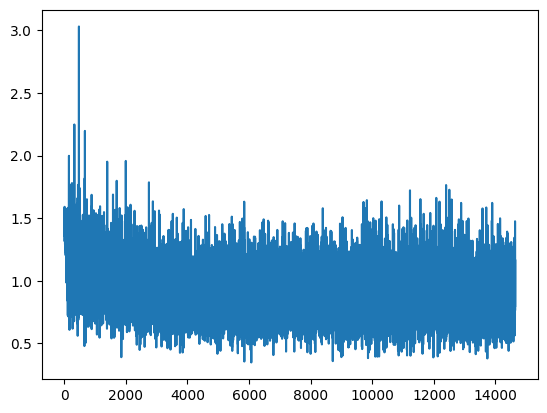

In [61]:
plt.plot(train_losses)

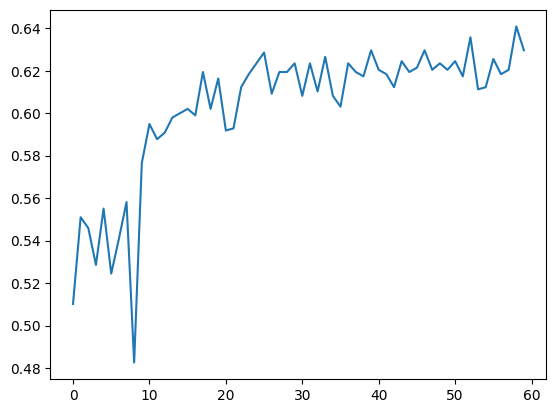

In [62]:
plt.plot(test_accuracy)

In [63]:
metrics2, confusion_matrix2 = report_metrics(
    model, labels=labels, device=device)
pprint(metrics2.compute())
confusion_matrix2.compute()

Correct: 617/976 (0.6322)
{'acc_detail': tensor([0.7323, 0.6389, 0.7087, 0.4484], device='cuda:0'),
 'acc_unweighted': tensor(0.6321, device='cuda:0'),
 'acc_weighted': tensor(0.6322, device='cuda:0'),
 'f1s_detail': tensor([0.7366, 0.5498, 0.7214, 0.5067], device='cuda:0'),
 'f1s_unweighted': tensor(0.6287, device='cuda:0'),
 'f1s_weighted': tensor(0.6320, device='cuda:0'),
 'precision_detail': tensor([0.7410, 0.4825, 0.7347, 0.5825], device='cuda:0'),
 'recall_detail': tensor([0.7323, 0.6389, 0.7087, 0.4484], device='cuda:0'),
 'rocauc': tensor(0.8598, device='cuda:0'),
 'rocauc_detail': tensor([0.9143, 0.8220, 0.9040, 0.7989], device='cuda:0'),
 'uar': tensor(0.6321, device='cuda:0'),
 'wap': tensor(0.6412, device='cuda:0')}


tensor([[186,  18,   5,  45],
        [  7, 138,  43,  28],
        [  5,  61, 180,   8],
        [ 53,  69,  17, 113]], device='cuda:0')

In [64]:
model.to('cpu')
best_model_path = f'{model_path_prefix}{best_epoch}epoch.pt'
print(best_model_path)
best_model = M13(config=model_config,
           n_input=1, n_output=len(labels))
best_model.load_state_dict(torch.load(best_model_path))
best_model.to(device)

metrics_best, confusion_matrix_best = report_metrics(
    best_model, labels=labels, device=device)
best_model.to('cpu')
pprint(metrics_best.compute())
confusion_matrix_best.compute()

../models_cremad4/cremad_label4_m13ser_best_59epoch.pt
Correct: 628/976 (0.6434)
{'acc_detail': tensor([0.6299, 0.6157, 0.7362, 0.5873], device='cuda:0'),
 'acc_unweighted': tensor(0.6423, device='cuda:0'),
 'acc_weighted': tensor(0.6434, device='cuda:0'),
 'f1s_detail': tensor([0.7175, 0.5473, 0.7276, 0.5850], device='cuda:0'),
 'f1s_unweighted': tensor(0.6444, device='cuda:0'),
 'f1s_weighted': tensor(0.6483, device='cuda:0'),
 'precision_detail': tensor([0.8333, 0.4926, 0.7192, 0.5827], device='cuda:0'),
 'recall_detail': tensor([0.6299, 0.6157, 0.7362, 0.5873], device='cuda:0'),
 'rocauc': tensor(0.8581, device='cuda:0'),
 'rocauc_detail': tensor([0.9138, 0.8213, 0.9043, 0.7930], device='cuda:0'),
 'uar': tensor(0.6423, device='cuda:0'),
 'wap': tensor(0.6635, device='cuda:0')}


tensor([[160,  20,   6,  68],
        [  2, 133,  50,  31],
        [  5,  55, 187,   7],
        [ 25,  62,  17, 148]], device='cuda:0')

In [65]:
checkpoint_path = f'../models_cremad4/cremad4_m13ser_{epoch}epoch.ckpt'
torch.save({
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': train_losses[-1],
    'best_epoch': best_epoch,
    'best_accuracy': best_accuracy,
    'train_losses': train_losses,
    'test_accuracy': test_accuracy,
    'log_interval': log_interval,
    }, checkpoint_path)

In [66]:
n_epoch = 10
n_epoch2 = 50
n_epoch3 = 40

optimizer = optim.RAdam(model.parameters(), lr=0.00001)
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=0.02, pct_start=0.3,
    steps_per_epoch=len(train_loader), epochs=n_epoch3)
log_interval = 40
pbar_update = 1 / (len(train_loader) + len(test_loader))
model.to(device)
with tqdm(total=n_epoch3) as pbar:
    for epoch in range(1+n_epoch+n_epoch2, n_epoch3+n_epoch2 + n_epoch + 1):
        train(model, epoch, log_interval, train_losses)
        acc = test(model, epoch)
        test_accuracy += [acc]
        if acc > best_accuracy:
            best_accuracy = acc
            best_epoch = epoch
            bmodel_path = f'{model_path_prefix}{epoch}epoch.pt'
            torch.save(model.state_dict(), bmodel_path)
            print(f'saved model: {bmodel_path}')
        scheduler.step()

  0%|                               | 0.003278688524590164/40 [00:00<1:17:56, 116.93s/it]

Train Epoch: 61 [0/3918 (0%)]	Loss: 0.683802
Mem before-during-after: 74245120 4072348160 77979648


  0%|                                | 0.13442622950819672/40 [00:17<1:42:23, 154.10s/it]

Train Epoch: 61 [640/3918 (16%)]	Loss: 1.153832
Mem before-during-after: 78759936 4075312640 78691328


  1%|▏                               | 0.26557377049180286/40 [00:35<1:31:33, 138.26s/it]

Train Epoch: 61 [1280/3918 (33%)]	Loss: 0.930323
Mem before-during-after: 77908992 4016834560 77919744


  1%|▎                                  | 0.39672131147541/40 [00:51<1:19:37, 120.63s/it]

Train Epoch: 61 [1920/3918 (49%)]	Loss: 0.927344
Mem before-during-after: 77878272 4077339648 77908992


  1%|▍                                | 0.5278688524590167/40 [01:07<1:20:19, 122.09s/it]

Train Epoch: 61 [2560/3918 (66%)]	Loss: 1.127405
Mem before-during-after: 77908992 4076303872 78186496


  2%|▌                                | 0.6590163934426216/40 [01:23<1:23:34, 127.46s/it]

Train Epoch: 61 [3200/3918 (82%)]	Loss: 0.910989
Mem before-during-after: 78186496 4075972096 77908992


  2%|▋                                | 0.7901639344262266/40 [01:39<1:25:13, 130.42s/it]

Train Epoch: 61 [3840/3918 (98%)]	Loss: 0.651890
Mem before-during-after: 77908992 4076860928 78186496


  2%|▉                                   | 0.9999999999999944/40 [01:54<44:36, 68.64s/it]


Test Epoch: 61	Accuracy: 623/976 (64%)



  3%|▉                                   | 1.0032786885245846/40 [01:54<54:04, 83.20s/it]

Train Epoch: 62 [0/3918 (0%)]	Loss: 0.806521
Mem before-during-after: 77871104 4074832896 77908992


  3%|▉                                | 1.1344262295081895/40 [02:12<1:36:16, 148.64s/it]

Train Epoch: 62 [640/3918 (16%)]	Loss: 1.075660
Mem before-during-after: 77908992 3951263744 77861888


  3%|█                                | 1.2655737704917944/40 [02:28<1:22:48, 128.26s/it]

Train Epoch: 62 [1280/3918 (33%)]	Loss: 0.608180
Mem before-during-after: 78186496 4074424320 77908992


  3%|█▏                               | 1.3967213114753994/40 [02:45<1:21:21, 126.46s/it]

Train Epoch: 62 [1920/3918 (49%)]	Loss: 0.919881
Mem before-during-after: 78186496 4074804224 77908992


  4%|█▎                               | 1.5278688524590043/40 [03:00<1:16:07, 118.73s/it]

Train Epoch: 62 [2560/3918 (66%)]	Loss: 0.904282
Mem before-during-after: 78186496 4074424320 77908992


  4%|█▎                               | 1.6590163934426092/40 [03:16<1:17:01, 120.53s/it]

Train Epoch: 62 [3200/3918 (82%)]	Loss: 0.664881
Mem before-during-after: 77878272 4076529664 77908992


  4%|█▍                               | 1.7901639344262141/40 [03:32<1:22:26, 129.45s/it]

Train Epoch: 62 [3840/3918 (98%)]	Loss: 0.800737
Mem before-during-after: 77878272 3868192256 77861888


  5%|█▊                                   | 1.999999999999982/40 [03:48<44:30, 70.27s/it]


Test Epoch: 62	Accuracy: 604/976 (62%)



  5%|█▊                                  | 2.0032786885245724/40 [03:49<55:05, 86.99s/it]

Train Epoch: 63 [0/3918 (0%)]	Loss: 0.714934
Mem before-during-after: 77871104 4074832896 77908992


  5%|█▊                               | 2.1344262295081773/40 [04:05<1:25:42, 135.80s/it]

Train Epoch: 63 [640/3918 (16%)]	Loss: 1.393939
Mem before-during-after: 77861888 3993337344 77861888


  6%|█▉                                | 2.265573770491782/40 [04:22<1:33:41, 148.97s/it]

Train Epoch: 63 [1280/3918 (33%)]	Loss: 0.706867
Mem before-during-after: 78743552 4073628160 77878272


  6%|██                                | 2.396721311475387/40 [04:40<1:16:58, 122.83s/it]

Train Epoch: 63 [1920/3918 (49%)]	Loss: 1.011759
Mem before-during-after: 77878272 4076782592 77908992


  6%|██▏                               | 2.527868852458992/40 [04:57<1:16:48, 122.97s/it]

Train Epoch: 63 [2560/3918 (66%)]	Loss: 0.829987
Mem before-during-after: 77878272 4077340160 77908992


  7%|██▎                               | 2.659016393442597/40 [05:14<1:25:47, 137.85s/it]

Train Epoch: 63 [3200/3918 (82%)]	Loss: 0.854266
Mem before-during-after: 77908992 4016834560 77919744


  7%|██▎                               | 2.790163934426202/40 [05:32<1:19:16, 127.82s/it]

Train Epoch: 63 [3840/3918 (98%)]	Loss: 0.865012
Mem before-during-after: 78743552 4074804224 77908992


  7%|██▊                                   | 2.99999999999997/40 [05:47<43:40, 70.81s/it]


Test Epoch: 63	Accuracy: 597/976 (61%)



  8%|██▋                                | 3.00327868852456/40 [05:48<1:05:34, 106.34s/it]

Train Epoch: 64 [0/3918 (0%)]	Loss: 0.932018
Mem before-during-after: 77871104 4074832896 77908992


  8%|██▋                               | 3.134426229508165/40 [06:04<1:16:25, 124.39s/it]

Train Epoch: 64 [640/3918 (16%)]	Loss: 0.555595
Mem before-during-after: 78186496 4075725312 77878272


  8%|██▊                                | 3.26557377049177/40 [06:21<1:13:27, 119.98s/it]

Train Epoch: 64 [1280/3918 (33%)]	Loss: 0.560203
Mem before-during-after: 77908992 4076782592 78186496


  8%|██▊                              | 3.3967213114753747/40 [06:40<1:23:24, 136.72s/it]

Train Epoch: 64 [1920/3918 (49%)]	Loss: 0.803349
Mem before-during-after: 78186496 4074725888 77878272


  9%|██▉                              | 3.5278688524589796/40 [06:55<1:21:39, 134.35s/it]

Train Epoch: 64 [2560/3918 (66%)]	Loss: 0.850544
Mem before-during-after: 77908992 4075668480 78186496


  9%|███                              | 3.6590163934425846/40 [07:13<1:26:07, 142.18s/it]

Train Epoch: 64 [3200/3918 (82%)]	Loss: 0.872455
Mem before-during-after: 77908992 4074763776 78186496


  9%|███▏                             | 3.7901639344261895/40 [07:30<1:14:57, 124.21s/it]

Train Epoch: 64 [3840/3918 (98%)]	Loss: 0.699436
Mem before-during-after: 77908992 4075746304 78186496


 10%|███▌                                | 3.9999999999999574/40 [07:45<41:06, 68.52s/it]


Test Epoch: 64	Accuracy: 608/976 (62%)



 10%|███▌                                | 4.0032786885245475/40 [07:45<49:29, 82.49s/it]

Train Epoch: 65 [0/3918 (0%)]	Loss: 0.830796
Mem before-during-after: 77871104 4074832896 77908992


 10%|███▌                              | 4.134426229508152/40 [08:02<1:12:59, 122.10s/it]

Train Epoch: 65 [640/3918 (16%)]	Loss: 1.058338
Mem before-during-after: 77908992 4077417472 78743552


 11%|███▋                              | 4.265573770491757/40 [08:18<1:12:08, 121.12s/it]

Train Epoch: 65 [1280/3918 (33%)]	Loss: 1.273180
Mem before-during-after: 77908992 4077417472 78743552


 11%|███▋                              | 4.396721311475362/40 [08:34<1:25:48, 144.60s/it]

Train Epoch: 65 [1920/3918 (49%)]	Loss: 0.591403
Mem before-during-after: 78022144 4076033536 77908992


 11%|███▊                              | 4.527868852458967/40 [08:53<1:26:41, 146.65s/it]

Train Epoch: 65 [2560/3918 (66%)]	Loss: 1.453013
Mem before-during-after: 77908992 4074128384 78186496


 12%|███▉                              | 4.659016393442572/40 [09:09<1:10:33, 119.78s/it]

Train Epoch: 65 [3200/3918 (82%)]	Loss: 0.986606
Mem before-during-after: 78186496 4074424320 77908992


 12%|████                              | 4.790163934426177/40 [09:25<1:24:16, 143.62s/it]

Train Epoch: 65 [3840/3918 (98%)]	Loss: 0.662388
Mem before-during-after: 77885440 4076529152 77885440


 12%|████▌                                | 4.999999999999945/40 [09:41<41:24, 70.97s/it]


Test Epoch: 65	Accuracy: 611/976 (62%)



 13%|████▋                                | 5.003278688524535/40 [09:41<50:09, 85.99s/it]

Train Epoch: 66 [0/3918 (0%)]	Loss: 0.939012
Mem before-during-after: 77871104 4074832896 77908992


 13%|████▍                              | 5.13442622950814/40 [09:57<1:13:14, 126.05s/it]

Train Epoch: 66 [640/3918 (16%)]	Loss: 0.808031
Mem before-during-after: 78186496 4075725312 77878272


 13%|████▍                             | 5.265573770491745/40 [10:14<1:14:55, 129.43s/it]

Train Epoch: 66 [1280/3918 (33%)]	Loss: 0.788816
Mem before-during-after: 77878272 4076225536 77908992


 13%|████▋                              | 5.39672131147535/40 [10:31<1:14:29, 129.15s/it]

Train Epoch: 66 [1920/3918 (49%)]	Loss: 0.713201
Mem before-during-after: 77878272 4077339648 77908992


 14%|████▋                             | 5.527868852458955/40 [10:48<1:24:21, 146.84s/it]

Train Epoch: 66 [2560/3918 (66%)]	Loss: 0.812683
Mem before-during-after: 77908992 4075320320 78743552


 14%|████▉                              | 5.65901639344256/40 [11:06<1:09:57, 122.24s/it]

Train Epoch: 66 [3200/3918 (82%)]	Loss: 1.081870
Mem before-during-after: 78743552 4074424320 77908992


 14%|████▉                             | 5.790163934426165/40 [11:23<1:15:41, 132.75s/it]

Train Epoch: 66 [3840/3918 (98%)]	Loss: 0.700005
Mem before-during-after: 78186496 4073071104 77878272


 15%|█████▍                              | 5.9999999999999325/40 [11:38<39:24, 69.54s/it]


Test Epoch: 66	Accuracy: 595/976 (61%)



 15%|█████▌                               | 6.003278688524523/40 [11:39<47:12, 83.32s/it]

Train Epoch: 67 [0/3918 (0%)]	Loss: 0.863913
Mem before-during-after: 77871104 4074832896 77908992


 15%|█████                            | 6.1344262295081275/40 [11:58<1:27:21, 154.77s/it]

Train Epoch: 67 [640/3918 (16%)]	Loss: 0.720953
Mem before-during-after: 77878272 4074685440 77908992


 16%|█████▏                           | 6.2655737704917325/40 [12:16<1:10:11, 124.83s/it]

Train Epoch: 67 [1280/3918 (33%)]	Loss: 0.753078
Mem before-during-after: 78186496 4075725312 77878272


 16%|█████▍                            | 6.396721311475337/40 [12:32<1:08:13, 121.82s/it]

Train Epoch: 67 [1920/3918 (49%)]	Loss: 0.580162
Mem before-during-after: 77908992 4076782592 78186496


 16%|█████▌                            | 6.527868852458942/40 [12:48<1:11:30, 128.18s/it]

Train Epoch: 67 [2560/3918 (66%)]	Loss: 1.206926
Mem before-during-after: 77908992 4076782592 78186496


 17%|█████▋                            | 6.659016393442547/40 [13:05<1:16:33, 137.79s/it]

Train Epoch: 67 [3200/3918 (82%)]	Loss: 0.994567
Mem before-during-after: 77878272 4075668480 77908992


 17%|█████▊                            | 6.790163934426152/40 [13:23<1:23:07, 150.19s/it]

Train Epoch: 67 [3840/3918 (98%)]	Loss: 0.875128
Mem before-during-after: 78186496 4072327168 77908992


 17%|██████▋                               | 6.99999999999992/40 [13:39<38:56, 70.81s/it]


Test Epoch: 67	Accuracy: 600/976 (61%)



 18%|██████▋                               | 7.00327868852451/40 [13:39<46:16, 84.14s/it]

Train Epoch: 68 [0/3918 (0%)]	Loss: 1.068463
Mem before-during-after: 77871104 4074832896 77908992


 18%|██████                            | 7.134426229508115/40 [13:56<1:09:26, 126.78s/it]

Train Epoch: 68 [640/3918 (16%)]	Loss: 0.874605
Mem before-during-after: 77908992 3910610944 77861888


 18%|██████▎                            | 7.26557377049172/40 [14:14<1:12:34, 133.03s/it]

Train Epoch: 68 [1280/3918 (33%)]	Loss: 0.705054
Mem before-during-after: 78186496 3743349760 77908992


 18%|██████▎                           | 7.396721311475325/40 [14:30<1:05:23, 120.35s/it]

Train Epoch: 68 [1920/3918 (49%)]	Loss: 0.631770
Mem before-during-after: 77878272 4076782592 77908992


 19%|██████▌                            | 7.52786885245893/40 [14:48<1:15:48, 140.06s/it]

Train Epoch: 68 [2560/3918 (66%)]	Loss: 0.900603
Mem before-during-after: 77908992 4075631104 77861888


 19%|██████▌                           | 7.659016393442535/40 [15:04<1:07:13, 124.71s/it]

Train Epoch: 68 [3200/3918 (82%)]	Loss: 0.914214
Mem before-during-after: 77908992 4074685440 78186496


 19%|██████▊                            | 7.79016393442614/40 [15:21<1:10:26, 131.22s/it]

Train Epoch: 68 [3840/3918 (98%)]	Loss: 0.791369
Mem before-during-after: 77908992 4076782592 78186496


 20%|███████▍                             | 7.999999999999908/40 [15:36<37:39, 70.62s/it]


Test Epoch: 68	Accuracy: 611/976 (62%)



 20%|███████▍                             | 8.003278688524498/40 [15:37<44:40, 83.78s/it]

Train Epoch: 69 [0/3918 (0%)]	Loss: 0.942126
Mem before-during-after: 77871104 4074832896 77908992


 20%|██████▉                           | 8.134426229508103/40 [15:54<1:06:52, 125.92s/it]

Train Epoch: 69 [640/3918 (16%)]	Loss: 0.996775
Mem before-during-after: 77878272 4073571328 77908992


 21%|███████                           | 8.265573770491708/40 [16:11<1:06:22, 125.51s/it]

Train Epoch: 69 [1280/3918 (33%)]	Loss: 0.976142
Mem before-during-after: 78186496 4074725888 77878272


 21%|███████▏                          | 8.396721311475313/40 [16:27<1:05:31, 124.41s/it]

Train Epoch: 69 [1920/3918 (49%)]	Loss: 1.092924
Mem before-during-after: 77908992 4076529664 78743552


 21%|███████▏                          | 8.527868852458917/40 [16:43<1:03:16, 120.62s/it]

Train Epoch: 69 [2560/3918 (66%)]	Loss: 1.025426
Mem before-during-after: 77878272 4076782592 77908992


 22%|███████▎                          | 8.659016393442522/40 [17:00<1:03:13, 121.02s/it]

Train Epoch: 69 [3200/3918 (82%)]	Loss: 0.937270
Mem before-during-after: 77908992 4076782592 78186496


 22%|███████▍                          | 8.790163934426127/40 [17:17<1:05:26, 125.82s/it]

Train Epoch: 69 [3840/3918 (98%)]	Loss: 0.893674
Mem before-during-after: 77878272 4075668992 77908992


 22%|████████▎                            | 8.999999999999895/40 [17:32<37:44, 73.06s/it]


Test Epoch: 69	Accuracy: 607/976 (62%)



 23%|████████▎                            | 9.003278688524485/40 [17:33<44:19, 85.80s/it]

Train Epoch: 70 [0/3918 (0%)]	Loss: 1.017845
Mem before-during-after: 77871104 4074832896 77908992


 23%|███████▉                           | 9.13442622950809/40 [17:49<1:06:41, 129.63s/it]

Train Epoch: 70 [640/3918 (16%)]	Loss: 0.902958
Mem before-during-after: 78186496 4074424320 77908992


 23%|███████▉                          | 9.265573770491695/40 [18:05<1:04:23, 125.69s/it]

Train Epoch: 70 [1280/3918 (33%)]	Loss: 0.828750
Mem before-during-after: 77940736 4077409792 78691328


 23%|████████▍                           | 9.3967213114753/40 [18:21<1:01:04, 119.74s/it]

Train Epoch: 70 [1920/3918 (49%)]	Loss: 1.142025
Mem before-during-after: 77940736 4077409792 78691328


 24%|████████                          | 9.527868852458905/40 [18:37<1:01:24, 120.90s/it]

Train Epoch: 70 [2560/3918 (66%)]	Loss: 0.788427
Mem before-during-after: 77878272 4076782592 77908992


 24%|████████▍                          | 9.65901639344251/40 [18:54<1:02:22, 123.35s/it]

Train Epoch: 70 [3200/3918 (82%)]	Loss: 0.814157
Mem before-during-after: 78186496 4072628736 77878272


 24%|████████▎                         | 9.790163934426115/40 [19:11<1:04:23, 127.88s/it]

Train Epoch: 70 [3840/3918 (98%)]	Loss: 0.863282
Mem before-during-after: 77924352 4075406848 77908992


 25%|█████████▏                           | 9.999999999999883/40 [19:26<36:59, 73.99s/it]


Test Epoch: 70	Accuracy: 627/976 (64%)



 25%|█████████                           | 10.003278688524473/40 [19:27<43:37, 87.27s/it]

Train Epoch: 71 [0/3918 (0%)]	Loss: 1.201986
Mem before-during-after: 77871104 4074832896 77908992


 25%|████████▎                        | 10.134426229508078/40 [19:43<1:01:31, 123.60s/it]

Train Epoch: 71 [640/3918 (16%)]	Loss: 0.989523
Mem before-during-after: 77878272 4076783104 77908992


 26%|████████▍                        | 10.265573770491683/40 [20:00<1:11:20, 143.97s/it]

Train Epoch: 71 [1280/3918 (33%)]	Loss: 0.725362
Mem before-during-after: 77908992 4074128384 78186496


 26%|████████▌                        | 10.396721311475288/40 [20:19<1:09:10, 140.22s/it]

Train Epoch: 71 [1920/3918 (49%)]	Loss: 0.789557
Mem before-during-after: 78953472 4075944448 77940736


 26%|████████▋                        | 10.527868852458893/40 [20:35<1:01:18, 124.82s/it]

Train Epoch: 71 [2560/3918 (66%)]	Loss: 1.049350
Mem before-during-after: 77940736 4076852736 78691328


 27%|████████▊                        | 10.659016393442498/40 [20:53<1:05:03, 133.05s/it]

Train Epoch: 71 [3200/3918 (82%)]	Loss: 0.885011
Mem before-during-after: 77986816 4076033536 78287872


 27%|█████████▍                         | 10.790163934426102/40 [21:10<59:02, 121.28s/it]

Train Epoch: 71 [3840/3918 (98%)]	Loss: 1.200822
Mem before-during-after: 78767104 4078217728 78767104


 27%|██████████▏                          | 10.99999999999987/40 [21:25<34:16, 70.91s/it]


Test Epoch: 71	Accuracy: 627/976 (64%)



 28%|██████████▏                          | 11.00327868852446/40 [21:26<41:18, 85.49s/it]

Train Epoch: 72 [0/3918 (0%)]	Loss: 0.464283
Mem before-during-after: 77871104 4074832896 77908992


 28%|█████████▏                       | 11.134426229508065/40 [21:42<1:01:37, 128.10s/it]

Train Epoch: 72 [640/3918 (16%)]	Loss: 1.109522
Mem before-during-after: 77908992 4076303872 78186496


 28%|██████████▏                         | 11.26557377049167/40 [21:59<57:31, 120.10s/it]

Train Epoch: 72 [1280/3918 (33%)]	Loss: 0.945407
Mem before-during-after: 78186496 4075725312 77878272


 28%|█████████▍                       | 11.396721311475275/40 [22:16<1:01:00, 127.99s/it]

Train Epoch: 72 [1920/3918 (49%)]	Loss: 0.763046
Mem before-during-after: 78186496 4075725312 77878272


 29%|█████████▊                        | 11.52786885245888/40 [22:32<1:07:20, 141.92s/it]

Train Epoch: 72 [2560/3918 (66%)]	Loss: 1.222123
Mem before-during-after: 77908992 4074128384 78186496


 29%|██████████▏                        | 11.659016393442485/40 [22:49<57:14, 121.20s/it]

Train Epoch: 72 [3200/3918 (82%)]	Loss: 0.586146
Mem before-during-after: 78743552 4075725312 77878272


 29%|██████████▌                         | 11.79016393442609/40 [23:04<57:30, 122.30s/it]

Train Epoch: 72 [3840/3918 (98%)]	Loss: 0.668095
Mem before-during-after: 78743552 4075725312 77878272


 30%|██████████▊                         | 11.999999999999858/40 [23:20<33:48, 72.44s/it]


Test Epoch: 72	Accuracy: 588/976 (60%)



 30%|██████████▊                         | 12.003278688524448/40 [23:21<40:16, 86.30s/it]

Train Epoch: 73 [0/3918 (0%)]	Loss: 0.835039
Mem before-during-after: 77871104 4074832896 77908992


 30%|██████████▌                        | 12.134426229508053/40 [23:38<56:36, 121.87s/it]

Train Epoch: 73 [640/3918 (16%)]	Loss: 0.591998
Mem before-during-after: 77878272 4076783104 77908992


 31%|██████████▋                        | 12.265573770491658/40 [23:55<55:58, 121.11s/it]

Train Epoch: 73 [1280/3918 (33%)]	Loss: 1.054756
Mem before-during-after: 77908992 3785308672 77861888


 31%|██████████▏                      | 12.396721311475263/40 [24:13<1:06:33, 144.67s/it]

Train Epoch: 73 [1920/3918 (49%)]	Loss: 0.719927
Mem before-during-after: 77924352 4075963392 77908992


 31%|██████████▉                        | 12.527868852458868/40 [24:32<58:45, 128.35s/it]

Train Epoch: 73 [2560/3918 (66%)]	Loss: 1.025660
Mem before-during-after: 77908992 4075668480 78186496


 32%|██████████▍                      | 12.659016393442473/40 [24:48<1:04:16, 141.07s/it]

Train Epoch: 73 [3200/3918 (82%)]	Loss: 0.799750
Mem before-during-after: 77908992 4075668480 78186496


 32%|███████████▏                       | 12.790163934426078/40 [25:04<56:02, 123.59s/it]

Train Epoch: 73 [3840/3918 (98%)]	Loss: 0.945162
Mem before-during-after: 78186496 4073071104 77878272


 32%|███████████▋                        | 12.999999999999845/40 [25:20<35:29, 78.87s/it]


Test Epoch: 73	Accuracy: 626/976 (64%)



 33%|███████████▋                        | 13.003278688524436/40 [25:20<41:00, 91.13s/it]

Train Epoch: 74 [0/3918 (0%)]	Loss: 0.990120
Mem before-during-after: 77871104 4074832896 77908992


 33%|███████████▏                      | 13.13442622950804/40 [25:38<1:07:59, 151.83s/it]

Train Epoch: 74 [640/3918 (16%)]	Loss: 0.816001
Mem before-during-after: 77878272 4074685440 77908992


 33%|███████████▌                       | 13.265573770491645/40 [25:56<54:45, 122.90s/it]

Train Epoch: 74 [1280/3918 (33%)]	Loss: 0.935067
Mem before-during-after: 78743552 4075725312 77878272


 33%|████████████                        | 13.39672131147525/40 [26:12<54:59, 124.04s/it]

Train Epoch: 74 [1920/3918 (49%)]	Loss: 0.941089
Mem before-during-after: 77908992 4076860416 78186496


 34%|███████████▊                       | 13.527868852458855/40 [26:29<54:27, 123.42s/it]

Train Epoch: 74 [2560/3918 (66%)]	Loss: 0.928727
Mem before-during-after: 78186496 4074424320 77908992


 34%|████████████▎                       | 13.65901639344246/40 [26:45<53:35, 122.08s/it]

Train Epoch: 74 [3200/3918 (82%)]	Loss: 0.838188
Mem before-during-after: 78186496 4073071104 77878272


 34%|███████████▍                     | 13.790163934426065/40 [27:03<1:04:16, 147.12s/it]

Train Epoch: 74 [3840/3918 (98%)]	Loss: 1.089921
Mem before-during-after: 78186496 4072326656 77908992


 35%|████████████▌                       | 13.999999999999833/40 [27:19<30:54, 71.34s/it]


Test Epoch: 74	Accuracy: 625/976 (64%)



 35%|████████████▌                       | 14.003278688524423/40 [27:19<37:21, 86.23s/it]

Train Epoch: 75 [0/3918 (0%)]	Loss: 0.826836
Mem before-during-after: 77871104 4074832896 77908992


 35%|████████████▎                      | 14.134426229508028/40 [27:35<53:59, 125.24s/it]

Train Epoch: 75 [640/3918 (16%)]	Loss: 1.053505
Mem before-during-after: 77878272 4076783104 77908992


 36%|████████████▍                      | 14.265573770491633/40 [27:52<55:51, 130.24s/it]

Train Epoch: 75 [1280/3918 (33%)]	Loss: 0.612068
Mem before-during-after: 77908992 4074725888 77878272


 36%|████████████▌                      | 14.396721311475238/40 [28:09<51:35, 120.89s/it]

Train Epoch: 75 [1920/3918 (49%)]	Loss: 0.738452
Mem before-during-after: 77878272 4076529152 77908992


 36%|████████████▋                      | 14.527868852458843/40 [28:25<51:30, 121.31s/it]

Train Epoch: 75 [2560/3918 (66%)]	Loss: 0.947106
Mem before-during-after: 78186496 4074804224 77908992


 37%|████████████▊                      | 14.659016393442448/40 [28:43<52:52, 125.20s/it]

Train Epoch: 75 [3200/3918 (82%)]	Loss: 1.222833
Mem before-during-after: 77878272 4075972608 77908992


 37%|████████████▏                    | 14.790163934426053/40 [29:00<1:02:01, 147.62s/it]

Train Epoch: 75 [3840/3918 (98%)]	Loss: 0.974778
Mem before-during-after: 78743552 4074685440 77908992


 37%|█████████████▊                       | 14.99999999999982/40 [29:17<29:17, 70.30s/it]


Test Epoch: 75	Accuracy: 615/976 (63%)



 38%|█████████████▉                       | 15.00327868852441/40 [29:17<35:44, 85.81s/it]

Train Epoch: 76 [0/3918 (0%)]	Loss: 1.079815
Mem before-during-after: 77871104 4074832896 77908992


 38%|████████████▍                    | 15.134426229508016/40 [29:35<1:03:31, 153.29s/it]

Train Epoch: 76 [640/3918 (16%)]	Loss: 0.797412
Mem before-during-after: 77908992 4074685440 78186496


 38%|█████████████▋                      | 15.26557377049162/40 [29:52<53:23, 129.52s/it]

Train Epoch: 76 [1280/3918 (33%)]	Loss: 0.989151
Mem before-during-after: 78022144 3808097792 77908992


 38%|█████████████▍                     | 15.396721311475225/40 [30:09<51:41, 126.06s/it]

Train Epoch: 76 [1920/3918 (49%)]	Loss: 0.765284
Mem before-during-after: 77878272 4076225536 77908992


 39%|█████████████▉                      | 15.52786885245883/40 [30:25<49:31, 121.44s/it]

Train Epoch: 76 [2560/3918 (66%)]	Loss: 0.961142
Mem before-during-after: 77908992 4076225536 78186496


 39%|█████████████▋                     | 15.659016393442435/40 [30:42<48:33, 119.71s/it]

Train Epoch: 76 [3200/3918 (82%)]	Loss: 0.704806
Mem before-during-after: 77908992 4076860928 78186496


 39%|██████████████▏                     | 15.79016393442604/40 [30:58<57:38, 142.87s/it]

Train Epoch: 76 [3840/3918 (98%)]	Loss: 0.980649
Mem before-during-after: 77861888 4076205568 77908992


 40%|██████████████▍                     | 15.999999999999808/40 [31:13<29:08, 72.84s/it]


Test Epoch: 76	Accuracy: 613/976 (63%)



 40%|███████████████▏                      | 16.0032786885244/40 [31:14<35:00, 87.54s/it]

Train Epoch: 77 [0/3918 (0%)]	Loss: 0.597223
Mem before-during-after: 77871104 4074832896 77908992


 40%|██████████████                     | 16.134426229508076/40 [31:30<48:01, 120.75s/it]

Train Epoch: 77 [640/3918 (16%)]	Loss: 0.592952
Mem before-during-after: 77878272 4075972608 77908992


 41%|██████████████▏                    | 16.265573770491752/40 [31:47<48:48, 123.39s/it]

Train Epoch: 77 [1280/3918 (33%)]	Loss: 0.856707
Mem before-during-after: 77908992 4076860416 78186496


 41%|██████████████▎                    | 16.396721311475428/40 [32:03<49:17, 125.31s/it]

Train Epoch: 77 [1920/3918 (49%)]	Loss: 0.773758
Mem before-during-after: 78186496 4074423808 77908992


 41%|██████████████▍                    | 16.527868852459104/40 [32:20<46:33, 118.99s/it]

Train Epoch: 77 [2560/3918 (66%)]	Loss: 0.835823
Mem before-during-after: 77878272 4076783104 77908992


 42%|██████████████▉                     | 16.65901639344278/40 [32:36<47:19, 121.65s/it]

Train Epoch: 77 [3200/3918 (82%)]	Loss: 0.902869
Mem before-during-after: 78743552 4074424320 77908992


 42%|██████████████▋                    | 16.790163934426456/40 [32:53<48:05, 124.32s/it]

Train Epoch: 77 [3840/3918 (98%)]	Loss: 1.224385
Mem before-during-after: 77878272 4076783104 77908992


 43%|███████████████▎                    | 17.000000000000338/40 [33:09<29:12, 76.21s/it]


Test Epoch: 77	Accuracy: 565/976 (58%)



 43%|███████████████▋                     | 17.00327868852493/40 [33:09<34:56, 91.18s/it]

Train Epoch: 78 [0/3918 (0%)]	Loss: 0.936229
Mem before-during-after: 77871104 4074832896 77908992


 43%|██████████████▉                    | 17.134426229508605/40 [33:26<46:07, 121.02s/it]

Train Epoch: 78 [640/3918 (16%)]	Loss: 0.955061
Mem before-during-after: 77908992 4076783104 78186496


 43%|███████████████▌                    | 17.26557377049228/40 [33:42<45:38, 120.47s/it]

Train Epoch: 78 [1280/3918 (33%)]	Loss: 0.942176
Mem before-during-after: 78186496 4074804224 77908992


 43%|███████████████▏                   | 17.396721311475957/40 [34:00<46:37, 123.79s/it]

Train Epoch: 78 [1920/3918 (49%)]	Loss: 1.043527
Mem before-during-after: 77908992 4076225536 78186496


 44%|███████████████▎                   | 17.527868852459633/40 [34:16<46:03, 123.00s/it]

Train Epoch: 78 [2560/3918 (66%)]	Loss: 0.755030
Mem before-during-after: 78186496 4073628160 77878272


 44%|███████████████▉                    | 17.65901639344331/40 [34:32<45:26, 122.06s/it]

Train Epoch: 78 [3200/3918 (82%)]	Loss: 0.628935
Mem before-during-after: 77878272 4076529664 77908992


 44%|███████████████▌                   | 17.790163934426985/40 [34:48<49:51, 134.71s/it]

Train Epoch: 78 [3840/3918 (98%)]	Loss: 0.799508
Mem before-during-after: 78186496 3867684352 77908992


 45%|████████████████▏                   | 18.000000000000867/40 [35:04<25:41, 70.08s/it]


Test Epoch: 78	Accuracy: 626/976 (64%)



 45%|████████████████▋                    | 18.00327868852546/40 [35:04<31:35, 86.16s/it]

Train Epoch: 79 [0/3918 (0%)]	Loss: 1.052921
Mem before-during-after: 77871104 4074832896 77908992


 45%|███████████████▊                   | 18.134426229509135/40 [35:20<45:28, 124.77s/it]

Train Epoch: 79 [640/3918 (16%)]	Loss: 0.992992
Mem before-during-after: 77908992 4076783104 78186496


 46%|████████████████▍                   | 18.26557377049281/40 [35:38<49:23, 136.35s/it]

Train Epoch: 79 [1280/3918 (33%)]	Loss: 0.533765
Mem before-during-after: 77908992 4075034112 78186496


 46%|████████████████                   | 18.396721311476487/40 [35:54<43:30, 120.82s/it]

Train Epoch: 79 [1920/3918 (49%)]	Loss: 0.874892
Mem before-during-after: 77908992 4076782592 78186496


 46%|████████████████▏                  | 18.527868852460163/40 [36:12<53:54, 150.64s/it]

Train Epoch: 79 [2560/3918 (66%)]	Loss: 0.830812
Mem before-during-after: 78692352 4077796864 79000576


 47%|████████████████▊                   | 18.65901639344384/40 [36:29<45:45, 128.67s/it]

Train Epoch: 79 [3200/3918 (82%)]	Loss: 0.955109
Mem before-during-after: 78248960 4076590592 78691328


 47%|████████████████▍                  | 18.790163934427515/40 [36:46<43:51, 124.08s/it]

Train Epoch: 79 [3840/3918 (98%)]	Loss: 1.163366
Mem before-during-after: 77908992 4076860416 78186496


 48%|█████████████████                   | 19.000000000001396/40 [37:02<24:27, 69.88s/it]


Test Epoch: 79	Accuracy: 623/976 (64%)



 48%|█████████████████                   | 19.003278688525988/40 [37:02<29:23, 83.98s/it]

Train Epoch: 80 [0/3918 (0%)]	Loss: 0.909002
Mem before-during-after: 77871104 4074832896 77908992


 48%|████████████████▋                  | 19.134426229509664/40 [37:20<54:12, 155.88s/it]

Train Epoch: 80 [640/3918 (16%)]	Loss: 0.688838
Mem before-during-after: 78097408 4075136512 77908992


 48%|█████████████████▎                  | 19.26557377049334/40 [37:36<44:57, 130.10s/it]

Train Epoch: 80 [1280/3918 (33%)]	Loss: 0.819641
Mem before-during-after: 77878272 4076782592 77908992


 48%|████████████████▉                  | 19.396721311477016/40 [37:52<41:42, 121.47s/it]

Train Epoch: 80 [1920/3918 (49%)]	Loss: 0.686987
Mem before-during-after: 78186496 4074804736 77908992


 49%|█████████████████                  | 19.527868852460692/40 [38:09<42:52, 125.66s/it]

Train Epoch: 80 [2560/3918 (66%)]	Loss: 0.601221
Mem before-during-after: 78691328 4076033536 78248960


 49%|█████████████████▏                 | 19.659016393444368/40 [38:25<40:55, 120.73s/it]

Train Epoch: 80 [3200/3918 (82%)]	Loss: 0.784581
Mem before-during-after: 77940736 4077409792 78691328


 49%|█████████████████▎                 | 19.790163934428044/40 [38:41<41:09, 122.21s/it]

Train Epoch: 80 [3840/3918 (98%)]	Loss: 0.926244
Mem before-during-after: 77940736 4075312640 78691328


 50%|██████████████████                  | 20.000000000001926/40 [38:56<22:58, 68.92s/it]


Test Epoch: 80	Accuracy: 620/976 (63%)



 50%|██████████████████                  | 20.003278688526517/40 [38:57<27:35, 82.78s/it]

Train Epoch: 81 [0/3918 (0%)]	Loss: 0.472548
Mem before-during-after: 77871104 4074832896 77908992


 50%|█████████████████▌                 | 20.134426229510193/40 [39:13<43:10, 130.40s/it]

Train Epoch: 81 [640/3918 (16%)]	Loss: 0.882858
Mem before-during-after: 77924352 4075406848 77908992


 51%|██████████████████▏                 | 20.26557377049387/40 [39:32<44:18, 134.72s/it]

Train Epoch: 81 [1280/3918 (33%)]	Loss: 1.228703
Mem before-during-after: 77878272 4017673728 77861888


 51%|█████████████████▊                 | 20.396721311477545/40 [39:48<39:23, 120.56s/it]

Train Epoch: 81 [1920/3918 (49%)]	Loss: 1.039142
Mem before-during-after: 78186496 4075725312 77878272


 51%|██████████████████▍                 | 20.52786885246122/40 [40:05<39:50, 122.76s/it]

Train Epoch: 81 [2560/3918 (66%)]	Loss: 0.762198
Mem before-during-after: 77878272 4076226048 77908992


 52%|██████████████████                 | 20.659016393444897/40 [40:24<44:08, 136.96s/it]

Train Epoch: 81 [3200/3918 (82%)]	Loss: 0.788455
Mem before-during-after: 77908992 4016851968 77861888


 52%|██████████████████▏                | 20.790163934428573/40 [40:42<40:11, 125.53s/it]

Train Epoch: 81 [3840/3918 (98%)]	Loss: 1.217204
Mem before-during-after: 77908992 4076303360 78186496


 53%|██████████████████▉                 | 21.000000000002455/40 [40:57<22:14, 70.25s/it]


Test Epoch: 81	Accuracy: 615/976 (63%)



 53%|██████████████████▉                 | 21.003278688527047/40 [40:57<26:30, 83.71s/it]

Train Epoch: 82 [0/3918 (0%)]	Loss: 0.771259
Mem before-during-after: 77871104 4074832896 77908992


 53%|██████████████████▍                | 21.134426229510723/40 [41:14<38:17, 121.76s/it]

Train Epoch: 82 [640/3918 (16%)]	Loss: 0.600600
Mem before-during-after: 77878272 4076783104 77908992


 53%|███████████████████▋                 | 21.2655737704944/40 [41:31<42:01, 134.61s/it]

Train Epoch: 82 [1280/3918 (33%)]	Loss: 1.240412
Mem before-during-after: 77878272 3909665280 77861888


 53%|██████████████████▋                | 21.396721311478075/40 [41:47<38:53, 125.44s/it]

Train Epoch: 82 [1920/3918 (49%)]	Loss: 0.950455
Mem before-during-after: 77878272 4076226048 77908992


 54%|███████████████████▍                | 21.52786885246175/40 [42:04<39:00, 126.72s/it]

Train Epoch: 82 [2560/3918 (66%)]	Loss: 0.816396
Mem before-during-after: 77908992 3909601280 78569472


 54%|██████████████████▉                | 21.659016393445427/40 [42:21<39:40, 129.80s/it]

Train Epoch: 82 [3200/3918 (82%)]	Loss: 0.518299
Mem before-during-after: 77908992 4074725888 77878272


 54%|███████████████████                | 21.790163934429103/40 [42:37<44:38, 147.11s/it]

Train Epoch: 82 [3840/3918 (98%)]	Loss: 0.787269
Mem before-during-after: 77861888 4076745216 77878272


 55%|███████████████████▊                | 22.000000000002984/40 [42:53<21:22, 71.27s/it]


Test Epoch: 82	Accuracy: 619/976 (63%)



 55%|███████████████████▊                | 22.003278688527576/40 [42:53<25:20, 84.48s/it]

Train Epoch: 83 [0/3918 (0%)]	Loss: 0.742902
Mem before-during-after: 77871104 4074832896 77908992


 55%|███████████████████▎               | 22.134426229511252/40 [43:10<36:36, 122.92s/it]

Train Epoch: 83 [640/3918 (16%)]	Loss: 0.887435
Mem before-during-after: 77908992 4077417472 78743552


 56%|███████████████████▍               | 22.265573770494928/40 [43:27<36:14, 122.60s/it]

Train Epoch: 83 [1280/3918 (33%)]	Loss: 1.000120
Mem before-during-after: 77908992 4076860928 78186496


 56%|███████████████████▌               | 22.396721311478604/40 [43:44<37:06, 126.48s/it]

Train Epoch: 83 [1920/3918 (49%)]	Loss: 1.056030
Mem before-during-after: 77878272 4076225536 77908992


 56%|████████████████████▎               | 22.52786885246228/40 [44:00<35:27, 121.75s/it]

Train Epoch: 83 [2560/3918 (66%)]	Loss: 0.754513
Mem before-during-after: 77908992 4076860928 78186496


 57%|███████████████████▊               | 22.659016393445956/40 [44:16<35:37, 123.26s/it]

Train Epoch: 83 [3200/3918 (82%)]	Loss: 0.850023
Mem before-during-after: 77908992 4076860416 78186496


 57%|███████████████████▉               | 22.790163934429632/40 [44:35<43:08, 150.40s/it]

Train Epoch: 83 [3840/3918 (98%)]	Loss: 0.694456
Mem before-during-after: 78186496 4073628160 77878272


 58%|████████████████████▋               | 23.000000000003514/40 [44:50<19:36, 69.19s/it]


Test Epoch: 83	Accuracy: 611/976 (62%)



 58%|████████████████████▋               | 23.003278688528106/40 [44:50<23:40, 83.60s/it]

Train Epoch: 84 [0/3918 (0%)]	Loss: 1.035003
Mem before-during-after: 77871104 4074832896 77908992


 58%|████████████████████▊               | 23.13442622951178/40 [45:08<40:12, 143.05s/it]

Train Epoch: 84 [640/3918 (16%)]	Loss: 0.839990
Mem before-during-after: 77861888 4074393088 77885440


 58%|████████████████████▎              | 23.265573770495457/40 [45:24<33:59, 121.86s/it]

Train Epoch: 84 [1280/3918 (33%)]	Loss: 0.654362
Mem before-during-after: 77878272 4076782592 77908992


 58%|████████████████████▍              | 23.396721311479133/40 [45:41<33:39, 121.61s/it]

Train Epoch: 84 [1920/3918 (49%)]	Loss: 1.113595
Mem before-during-after: 78186496 4075725312 77878272


 59%|█████████████████████▏              | 23.52786885246281/40 [46:00<41:04, 149.62s/it]

Train Epoch: 84 [2560/3918 (66%)]	Loss: 0.636272
Mem before-during-after: 77878272 4074432000 77908992


 59%|████████████████████▋              | 23.659016393446485/40 [46:18<37:06, 136.22s/it]

Train Epoch: 84 [3200/3918 (82%)]	Loss: 0.781681
Mem before-during-after: 78186496 4072628736 77878272


 59%|█████████████████████▍              | 23.79016393443016/40 [46:34<33:12, 122.89s/it]

Train Epoch: 84 [3840/3918 (98%)]	Loss: 0.626462
Mem before-during-after: 77908992 3948429312 77954048


 60%|█████████████████████▌              | 24.000000000004043/40 [46:49<18:21, 68.87s/it]


Test Epoch: 84	Accuracy: 620/976 (63%)



 60%|█████████████████████▌              | 24.003278688528635/40 [46:49<21:58, 82.39s/it]

Train Epoch: 85 [0/3918 (0%)]	Loss: 1.089496
Mem before-during-after: 77871104 3910304256 77861888


 60%|█████████████████████▋              | 24.13442622951231/40 [47:07<39:36, 149.77s/it]

Train Epoch: 85 [640/3918 (16%)]	Loss: 1.310579
Mem before-during-after: 78186496 4072707584 77908992


 61%|█████████████████████▏             | 24.265573770495987/40 [47:24<32:13, 122.89s/it]

Train Epoch: 85 [1280/3918 (33%)]	Loss: 0.697819
Mem before-during-after: 77878272 4076782592 77908992


 61%|█████████████████████▎             | 24.396721311479663/40 [47:40<31:23, 120.70s/it]

Train Epoch: 85 [1920/3918 (49%)]	Loss: 1.287905
Mem before-during-after: 77861888 4005546496 77908992


 61%|██████████████████████              | 24.52786885246334/40 [47:56<32:45, 127.06s/it]

Train Epoch: 85 [2560/3918 (66%)]	Loss: 0.956800
Mem before-during-after: 77878272 4074685952 77908992


 62%|█████████████████████▌             | 24.659016393447015/40 [48:13<33:36, 131.43s/it]

Train Epoch: 85 [3200/3918 (82%)]	Loss: 1.164148
Mem before-during-after: 77908992 4076783104 78186496


 62%|██████████████████████▎             | 24.79016393443069/40 [48:29<34:38, 136.63s/it]

Train Epoch: 85 [3840/3918 (98%)]	Loss: 0.851223
Mem before-during-after: 77908992 4075034112 78186496


 63%|██████████████████████▌             | 25.000000000004572/40 [48:44<17:30, 70.02s/it]


Test Epoch: 85	Accuracy: 619/976 (63%)



 63%|██████████████████████▌             | 25.003278688529164/40 [48:45<21:08, 84.57s/it]

Train Epoch: 86 [0/3918 (0%)]	Loss: 0.762232
Mem before-during-after: 77871104 4074832896 77908992


 63%|██████████████████████▌             | 25.13442622951284/40 [49:01<30:29, 123.10s/it]

Train Epoch: 86 [640/3918 (16%)]	Loss: 0.690389
Mem before-during-after: 78186496 4074423808 77908992


 63%|██████████████████████             | 25.265573770496516/40 [49:17<29:13, 118.99s/it]

Train Epoch: 86 [1280/3918 (33%)]	Loss: 0.950000
Mem before-during-after: 78186496 4074424320 77908992


 63%|██████████████████████▏            | 25.396721311480192/40 [49:35<32:05, 131.84s/it]

Train Epoch: 86 [1920/3918 (49%)]	Loss: 1.218415
Mem before-during-after: 77878272 4076225536 77908992


 64%|██████████████████████▎            | 25.527868852463868/40 [49:53<35:03, 145.35s/it]

Train Epoch: 86 [2560/3918 (66%)]	Loss: 0.765157
Mem before-during-after: 77908992 4074763264 78186496


 64%|██████████████████████▍            | 25.659016393447544/40 [50:11<28:26, 118.96s/it]

Train Epoch: 86 [3200/3918 (82%)]	Loss: 0.886010
Mem before-during-after: 77878272 4076782592 77908992


 64%|███████████████████████▏            | 25.79016393443122/40 [50:27<30:42, 129.63s/it]

Train Epoch: 86 [3840/3918 (98%)]	Loss: 0.716797
Mem before-during-after: 78186496 4072628736 77878272


 65%|████████████████████████▋             | 26.0000000000051/40 [50:42<16:22, 70.20s/it]


Test Epoch: 86	Accuracy: 628/976 (64%)



 65%|███████████████████████▍            | 26.003278688529694/40 [50:42<19:25, 83.26s/it]

Train Epoch: 87 [0/3918 (0%)]	Loss: 0.596177
Mem before-during-after: 77871104 3953103872 77861888


 65%|███████████████████████▌            | 26.13442622951337/40 [50:59<27:33, 119.24s/it]

Train Epoch: 87 [640/3918 (16%)]	Loss: 0.807058
Mem before-during-after: 77908992 4076782592 78186496


 66%|██████████████████████▉            | 26.265573770497046/40 [51:16<32:10, 140.59s/it]

Train Epoch: 87 [1280/3918 (33%)]	Loss: 1.021315
Mem before-during-after: 77878272 4076226048 77908992


 66%|███████████████████████▊            | 26.39672131148072/40 [51:32<31:40, 139.71s/it]

Train Epoch: 87 [1920/3918 (49%)]	Loss: 1.061690
Mem before-during-after: 77861888 4076823040 77878272


 66%|███████████████████████▏           | 26.527868852464398/40 [51:48<29:26, 131.12s/it]

Train Epoch: 87 [2560/3918 (66%)]	Loss: 1.308614
Mem before-during-after: 77908992 4077877248 78743552


 67%|███████████████████████▎           | 26.659016393448074/40 [52:04<26:17, 118.23s/it]

Train Epoch: 87 [3200/3918 (82%)]	Loss: 1.012103
Mem before-during-after: 78743552 4074423808 77908992


 67%|████████████████████████            | 26.79016393443175/40 [52:20<26:10, 118.90s/it]

Train Epoch: 87 [3840/3918 (98%)]	Loss: 1.368328
Mem before-during-after: 77908992 4076782592 78186496


 68%|████████████████████████▉            | 27.00000000000563/40 [52:35<15:19, 70.72s/it]


Test Epoch: 87	Accuracy: 598/976 (61%)



 68%|████████████████████████▎           | 27.003278688530223/40 [52:35<18:09, 83.86s/it]

Train Epoch: 88 [0/3918 (0%)]	Loss: 0.756763
Mem before-during-after: 77871104 4074832896 77908992


 68%|█████████████████████████            | 27.1344262295139/40 [52:51<26:39, 124.34s/it]

Train Epoch: 88 [640/3918 (16%)]	Loss: 0.724955
Mem before-during-after: 77878272 4076225536 77908992


 68%|███████████████████████▊           | 27.265573770497575/40 [53:08<30:46, 144.97s/it]

Train Epoch: 88 [1280/3918 (33%)]	Loss: 1.094394
Mem before-during-after: 78743552 4072707072 77908992


 68%|████████████████████████▋           | 27.39672131148125/40 [53:25<25:11, 119.89s/it]

Train Epoch: 88 [1920/3918 (49%)]	Loss: 0.722030
Mem before-during-after: 77908992 4076303360 78186496


 69%|████████████████████████           | 27.527868852464927/40 [53:41<25:04, 120.67s/it]

Train Epoch: 88 [2560/3918 (66%)]	Loss: 1.064425
Mem before-during-after: 78186496 4074424320 77908992


 69%|████████████████████████▏          | 27.659016393448603/40 [53:59<25:29, 123.91s/it]

Train Epoch: 88 [3200/3918 (82%)]	Loss: 1.394212
Mem before-during-after: 78743552 4074423808 77908992


 69%|█████████████████████████           | 27.79016393443228/40 [54:16<25:49, 126.95s/it]

Train Epoch: 88 [3840/3918 (98%)]	Loss: 0.976108
Mem before-during-after: 77878272 4076783104 77908992


 70%|█████████████████████████▉           | 28.00000000000616/40 [54:31<13:49, 69.14s/it]


Test Epoch: 88	Accuracy: 623/976 (64%)



 70%|█████████████████████████▏          | 28.003278688530752/40 [54:31<16:40, 83.42s/it]

Train Epoch: 89 [0/3918 (0%)]	Loss: 1.063769
Mem before-during-after: 77871104 4074832896 77908992


 70%|█████████████████████████▎          | 28.13442622951443/40 [54:47<26:18, 133.03s/it]

Train Epoch: 89 [640/3918 (16%)]	Loss: 0.500827
Mem before-during-after: 78186496 4074725888 77878272


 71%|████████████████████████▋          | 28.265573770498104/40 [55:04<25:40, 131.24s/it]

Train Epoch: 89 [1280/3918 (33%)]	Loss: 0.604785
Mem before-during-after: 77908992 4075168256 77878272


 71%|█████████████████████████▌          | 28.39672131148178/40 [55:20<23:20, 120.67s/it]

Train Epoch: 89 [1920/3918 (49%)]	Loss: 0.792609
Mem before-during-after: 78186496 4075725312 77878272


 71%|████████████████████████▉          | 28.527868852465456/40 [55:36<23:39, 123.77s/it]

Train Epoch: 89 [2560/3918 (66%)]	Loss: 0.757074
Mem before-during-after: 77908992 4076226048 78186496


 72%|█████████████████████████          | 28.659016393449132/40 [55:52<22:51, 120.96s/it]

Train Epoch: 89 [3200/3918 (82%)]	Loss: 0.920838
Mem before-during-after: 77908992 4075242496 78743552


 72%|█████████████████████████▏         | 28.790163934432808/40 [56:09<24:48, 132.79s/it]

Train Epoch: 89 [3840/3918 (98%)]	Loss: 0.844935
Mem before-during-after: 77908992 4076303360 78186496


 73%|██████████████████████████▊          | 29.00000000000669/40 [56:24<13:19, 72.69s/it]


Test Epoch: 89	Accuracy: 619/976 (63%)



 73%|██████████████████████████▊          | 29.00327868853128/40 [56:24<15:33, 84.91s/it]

Train Epoch: 90 [0/3918 (0%)]	Loss: 0.811134
Mem before-during-after: 77871104 4074832896 77908992


 73%|█████████████████████████▍         | 29.134426229514958/40 [56:42<21:45, 120.16s/it]

Train Epoch: 90 [640/3918 (16%)]	Loss: 0.786794
Mem before-during-after: 77908992 4076303360 78186496


 73%|█████████████████████████▌         | 29.265573770498634/40 [56:58<25:56, 145.03s/it]

Train Epoch: 90 [1280/3918 (33%)]	Loss: 0.769223
Mem before-during-after: 78186496 4072327168 77908992


 73%|██████████████████████████▍         | 29.39672131148231/40 [57:14<21:53, 123.91s/it]

Train Epoch: 90 [1920/3918 (49%)]	Loss: 0.953656
Mem before-during-after: 77878272 4076783104 77908992


 74%|█████████████████████████▊         | 29.527868852465986/40 [57:32<21:26, 122.86s/it]

Train Epoch: 90 [2560/3918 (66%)]	Loss: 0.863890
Mem before-during-after: 78186496 4074424320 77908992


 74%|██████████████████████████▋         | 29.65901639344966/40 [57:48<20:24, 118.38s/it]

Train Epoch: 90 [3200/3918 (82%)]	Loss: 0.589241
Mem before-during-after: 77908992 4076225536 78186496


 74%|██████████████████████████         | 29.790163934433338/40 [58:04<20:40, 121.53s/it]

Train Epoch: 90 [3840/3918 (98%)]	Loss: 0.837960
Mem before-during-after: 77908992 4075668480 78186496


 75%|███████████████████████████▊         | 30.00000000000722/40 [58:19<11:47, 70.78s/it]


Test Epoch: 90	Accuracy: 621/976 (63%)



 75%|███████████████████████████▊         | 30.00327868853181/40 [58:20<14:07, 84.77s/it]

Train Epoch: 91 [0/3918 (0%)]	Loss: 0.768457
Mem before-during-after: 77871104 4074832896 77908992


 75%|██████████████████████████▎        | 30.134426229515487/40 [58:35<20:31, 124.87s/it]

Train Epoch: 91 [640/3918 (16%)]	Loss: 1.047488
Mem before-during-after: 77878272 4076529664 77908992


 76%|██████████████████████████▍        | 30.265573770499163/40 [58:52<19:37, 120.97s/it]

Train Epoch: 91 [1280/3918 (33%)]	Loss: 1.199108
Mem before-during-after: 77908992 4076303360 78186496


 76%|███████████████████████████▎        | 30.39672131148284/40 [59:07<19:17, 120.54s/it]

Train Epoch: 91 [1920/3918 (49%)]	Loss: 0.977710
Mem before-during-after: 77908992 4074685952 78186496


 76%|██████████████████████████▋        | 30.527868852466515/40 [59:23<18:31, 117.32s/it]

Train Epoch: 91 [2560/3918 (66%)]	Loss: 0.787683
Mem before-during-after: 77908992 3968297472 77861888


 77%|███████████████████████████▌        | 30.65901639345019/40 [59:41<22:42, 145.83s/it]

Train Epoch: 91 [3200/3918 (82%)]	Loss: 1.052940
Mem before-during-after: 77908992 4074685440 78186496


 77%|██████████████████████████▉        | 30.790163934433867/40 [59:59<18:27, 120.25s/it]

Train Epoch: 91 [3840/3918 (98%)]	Loss: 0.495734
Mem before-during-after: 77878272 4076225536 77908992


 78%|███████████████████████████▏       | 31.00000000000775/40 [1:00:14<10:34, 70.50s/it]


Test Epoch: 91	Accuracy: 620/976 (63%)



 78%|███████████████████████████▏       | 31.00327868853234/40 [1:00:15<12:41, 84.59s/it]

Train Epoch: 92 [0/3918 (0%)]	Loss: 0.982812
Mem before-during-after: 77871104 4074832896 77908992


 78%|█████████████████████████▋       | 31.134426229516016/40 [1:00:31<18:47, 127.21s/it]

Train Epoch: 92 [640/3918 (16%)]	Loss: 0.879113
Mem before-during-after: 77908992 4075746816 78186496


 78%|█████████████████████████▊       | 31.265573770499692/40 [1:00:47<21:05, 144.86s/it]

Train Epoch: 92 [1280/3918 (33%)]	Loss: 0.739610
Mem before-during-after: 78186496 4072327168 77908992


 78%|██████████████████████████▋       | 31.39672131148337/40 [1:01:05<18:42, 130.50s/it]

Train Epoch: 92 [1920/3918 (49%)]	Loss: 0.723572
Mem before-during-after: 77908992 4074424320 77924352


 79%|██████████████████████████       | 31.527868852467044/40 [1:01:21<16:53, 119.66s/it]

Train Epoch: 92 [2560/3918 (66%)]	Loss: 1.106946
Mem before-during-after: 78186496 4075725312 77878272


 79%|██████████████████████████▉       | 31.65901639345072/40 [1:01:39<20:31, 147.64s/it]

Train Epoch: 92 [3200/3918 (82%)]	Loss: 0.730569
Mem before-during-after: 78186496 4073628160 77878272


 79%|██████████████████████████▏      | 31.790163934434396/40 [1:01:58<18:06, 132.38s/it]

Train Epoch: 92 [3840/3918 (98%)]	Loss: 0.938709
Mem before-during-after: 77878272 4017530368 77861888


 80%|████████████████████████████       | 32.00000000000828/40 [1:02:13<09:16, 69.55s/it]


Test Epoch: 92	Accuracy: 614/976 (63%)



 80%|███████████████████████████▏      | 32.003278688532866/40 [1:02:14<10:59, 82.45s/it]

Train Epoch: 93 [0/3918 (0%)]	Loss: 0.782512
Mem before-during-after: 77871104 4074832896 77908992


 80%|████████████████████████████       | 32.1344262295164/40 [1:02:31<16:59, 129.60s/it]

Train Epoch: 93 [640/3918 (16%)]	Loss: 1.245558
Mem before-during-after: 78186496 4075972096 77908992


 81%|██████████████████████████▌      | 32.265573770499934/40 [1:02:48<17:35, 136.41s/it]

Train Epoch: 93 [1280/3918 (33%)]	Loss: 0.970781
Mem before-during-after: 78193152 4075955712 77908992


 81%|███████████████████████████▌      | 32.39672131148347/40 [1:03:04<15:05, 119.08s/it]

Train Epoch: 93 [1920/3918 (49%)]	Loss: 0.763964
Mem before-during-after: 77901824 4076590592 78652416


 81%|█████████████████████████████▎      | 32.527868852467/40 [1:03:21<14:56, 119.94s/it]

Train Epoch: 93 [2560/3918 (66%)]	Loss: 1.220961
Mem before-during-after: 78679040 4076840448 78953472


 82%|██████████████████████████▉      | 32.659016393450536/40 [1:03:37<17:27, 142.65s/it]

Train Epoch: 93 [3200/3918 (82%)]	Loss: 0.883238
Mem before-during-after: 78186496 4072327168 77908992


 82%|███████████████████████████▊      | 32.79016393443407/40 [1:03:53<14:14, 118.51s/it]

Train Epoch: 93 [3840/3918 (98%)]	Loss: 0.828232
Mem before-during-after: 78743552 4074423808 77908992


 83%|████████████████████████████      | 33.000000000007724/40 [1:04:08<08:39, 74.26s/it]


Test Epoch: 93	Accuracy: 622/976 (63%)



 83%|████████████████████████████▉      | 33.00327868853231/40 [1:04:09<10:01, 85.95s/it]

Train Epoch: 94 [0/3918 (0%)]	Loss: 0.842206
Mem before-during-after: 77871104 4074832896 77908992


 83%|███████████████████████████▎     | 33.134426229515846/40 [1:04:25<13:51, 121.16s/it]

Train Epoch: 94 [640/3918 (16%)]	Loss: 0.814592
Mem before-during-after: 77878272 4076783104 77908992


 83%|████████████████████████████▎     | 33.26557377049938/40 [1:04:42<14:22, 128.05s/it]

Train Epoch: 94 [1280/3918 (33%)]	Loss: 0.905972
Mem before-during-after: 77908992 3867383808 78022144


 83%|███████████████████████████▌     | 33.396721311482914/40 [1:04:59<14:38, 132.99s/it]

Train Epoch: 94 [1920/3918 (49%)]	Loss: 1.051393
Mem before-during-after: 78511104 4075485184 78248960


 84%|████████████████████████████▍     | 33.52786885246645/40 [1:05:16<15:06, 140.05s/it]

Train Epoch: 94 [2560/3918 (66%)]	Loss: 1.025942
Mem before-during-after: 78953472 4075430400 77940736


 84%|████████████████████████████▌     | 33.65901639344998/40 [1:05:32<12:38, 119.68s/it]

Train Epoch: 94 [3200/3918 (82%)]	Loss: 0.793335
Mem before-during-after: 78953472 4076501504 77940736


 84%|███████████████████████████▉     | 33.790163934433515/40 [1:05:49<12:17, 118.79s/it]

Train Epoch: 94 [3840/3918 (98%)]	Loss: 0.614685
Mem before-during-after: 78186496 4074804224 77908992


 85%|█████████████████████████████▊     | 34.00000000000717/40 [1:06:05<07:05, 70.96s/it]


Test Epoch: 94	Accuracy: 587/976 (60%)



 85%|█████████████████████████████▊     | 34.00327868853176/40 [1:06:05<08:29, 85.01s/it]

Train Epoch: 95 [0/3918 (0%)]	Loss: 0.991963
Mem before-during-after: 77871104 4074832896 77908992


 85%|█████████████████████████████     | 34.13442622951529/40 [1:06:22<11:47, 120.61s/it]

Train Epoch: 95 [640/3918 (16%)]	Loss: 0.734695
Mem before-during-after: 77878272 4076225536 77908992


 86%|████████████████████████████▎    | 34.265573770498825/40 [1:06:38<12:58, 135.84s/it]

Train Epoch: 95 [1280/3918 (33%)]	Loss: 1.177664
Mem before-during-after: 77908992 4075034112 78186496


 86%|█████████████████████████████▏    | 34.39672131148236/40 [1:06:55<12:08, 129.93s/it]

Train Epoch: 95 [1920/3918 (49%)]	Loss: 0.980268
Mem before-during-after: 77908992 3968563200 77954048


 86%|█████████████████████████████▎    | 34.52786885246589/40 [1:07:11<12:07, 132.87s/it]

Train Epoch: 95 [2560/3918 (66%)]	Loss: 0.757620
Mem before-during-after: 77861888 4076782592 77908992


 87%|█████████████████████████████▍    | 34.65901639344943/40 [1:07:27<11:30, 129.33s/it]

Train Epoch: 95 [3200/3918 (82%)]	Loss: 0.939572
Mem before-during-after: 77908992 4074685440 78186496


 87%|█████████████████████████████▌    | 34.79016393443296/40 [1:07:43<10:19, 118.98s/it]

Train Epoch: 95 [3840/3918 (98%)]	Loss: 1.325420
Mem before-during-after: 78186496 4074804224 77908992


 88%|█████████████████████████████▊    | 35.000000000006615/40 [1:07:58<05:56, 71.30s/it]


Test Epoch: 95	Accuracy: 599/976 (61%)



 88%|███████████████████████████████▌    | 35.0032786885312/40 [1:07:58<06:58, 83.70s/it]

Train Epoch: 96 [0/3918 (0%)]	Loss: 1.130013
Mem before-during-after: 77871104 4074832896 77908992


 88%|█████████████████████████████▊    | 35.13442622951474/40 [1:08:15<09:42, 119.76s/it]

Train Epoch: 96 [640/3918 (16%)]	Loss: 0.715508
Mem before-during-after: 78186496 4074804224 77908992


 88%|█████████████████████████████▉    | 35.26557377049827/40 [1:08:31<09:41, 122.85s/it]

Train Epoch: 96 [1280/3918 (33%)]	Loss: 0.686481
Mem before-during-after: 77908992 4074685440 78186496


 88%|█████████████████████████████▏   | 35.396721311481805/40 [1:08:48<09:39, 125.79s/it]

Train Epoch: 96 [1920/3918 (49%)]	Loss: 0.642130
Mem before-during-after: 77908992 4076782592 78186496


 89%|██████████████████████████████▏   | 35.52786885246534/40 [1:09:05<09:07, 122.40s/it]

Train Epoch: 96 [2560/3918 (66%)]	Loss: 0.802102
Mem before-during-after: 78186496 4074804736 77908992


 89%|██████████████████████████████▎   | 35.65901639344887/40 [1:09:23<10:12, 141.05s/it]

Train Epoch: 96 [3200/3918 (82%)]	Loss: 0.823653
Mem before-during-after: 78186496 4074725888 77878272


 89%|██████████████████████████████▍   | 35.79016393443241/40 [1:09:39<08:30, 121.18s/it]

Train Epoch: 96 [3840/3918 (98%)]	Loss: 0.554936
Mem before-during-after: 78186496 4072326656 77908992


 90%|███████████████████████████████▌   | 36.00000000000606/40 [1:09:55<04:55, 73.82s/it]


Test Epoch: 96	Accuracy: 614/976 (63%)



 90%|███████████████████████████████▌   | 36.00327868853065/40 [1:09:56<05:47, 87.01s/it]

Train Epoch: 97 [0/3918 (0%)]	Loss: 0.579315
Mem before-during-after: 77871104 4074832896 77908992


 90%|██████████████████████████████▋   | 36.13442622951418/40 [1:10:12<08:43, 135.55s/it]

Train Epoch: 97 [640/3918 (16%)]	Loss: 0.844519
Mem before-during-after: 77908992 4076782592 78186496


 91%|██████████████████████████████▊   | 36.26557377049772/40 [1:10:29<07:53, 126.70s/it]

Train Epoch: 97 [1280/3918 (33%)]	Loss: 0.834086
Mem before-during-after: 77908992 4075668480 78186496


 91%|██████████████████████████████▉   | 36.39672131148125/40 [1:10:45<07:09, 119.25s/it]

Train Epoch: 97 [1920/3918 (49%)]	Loss: 0.373564
Mem before-during-after: 77908992 4077417472 78743552


 91%|██████████████████████████████▏  | 36.527868852464785/40 [1:11:01<07:32, 130.44s/it]

Train Epoch: 97 [2560/3918 (66%)]	Loss: 0.887779
Mem before-during-after: 77885440 4077495808 77885440


 92%|███████████████████████████████▏  | 36.65901639344832/40 [1:11:19<06:36, 118.68s/it]

Train Epoch: 97 [3200/3918 (82%)]	Loss: 1.152945
Mem before-during-after: 77878272 4076782592 77908992


 92%|███████████████████████████████▎  | 36.79016393443185/40 [1:11:37<07:46, 145.46s/it]

Train Epoch: 97 [3840/3918 (98%)]	Loss: 1.108002
Mem before-during-after: 77919744 4075955712 77908992


 93%|████████████████████████████████▍  | 37.00000000000551/40 [1:11:52<03:28, 69.38s/it]


Test Epoch: 97	Accuracy: 624/976 (64%)



 93%|███████████████████████████████▍  | 37.003278688530095/40 [1:11:52<04:10, 83.51s/it]

Train Epoch: 98 [0/3918 (0%)]	Loss: 0.717956
Mem before-during-after: 77871104 4074832896 77908992


 93%|███████████████████████████████▌  | 37.13442622951363/40 [1:12:08<05:39, 118.59s/it]

Train Epoch: 98 [640/3918 (16%)]	Loss: 0.525124
Mem before-during-after: 77908992 4076860416 78186496


 93%|███████████████████████████████▋  | 37.26557377049716/40 [1:12:24<06:31, 142.99s/it]

Train Epoch: 98 [1280/3918 (33%)]	Loss: 0.583305
Mem before-during-after: 77878272 4073571328 77908992


 93%|████████████████████████████████▋  | 37.3967213114807/40 [1:12:40<05:14, 120.91s/it]

Train Epoch: 98 [1920/3918 (49%)]	Loss: 0.967227
Mem before-during-after: 78186496 4075725312 77878272


 94%|███████████████████████████████▉  | 37.52786885246423/40 [1:12:56<05:18, 128.93s/it]

Train Epoch: 98 [2560/3918 (66%)]	Loss: 0.781143
Mem before-during-after: 78186496 4074423808 77908992


 94%|███████████████████████████████  | 37.659016393447764/40 [1:13:14<05:37, 144.37s/it]

Train Epoch: 98 [3200/3918 (82%)]	Loss: 0.967368
Mem before-during-after: 77908992 4073071104 77878272


 94%|█████████████████████████████████  | 37.7901639344313/40 [1:13:33<05:22, 146.13s/it]

Train Epoch: 98 [3840/3918 (98%)]	Loss: 0.653971
Mem before-during-after: 78186496 4073071104 77878272


 95%|█████████████████████████████████▎ | 38.00000000000495/40 [1:13:48<02:23, 71.78s/it]


Test Epoch: 98	Accuracy: 607/976 (62%)



 95%|█████████████████████████████████▎ | 38.00327868852954/40 [1:13:49<02:50, 85.39s/it]

Train Epoch: 99 [0/3918 (0%)]	Loss: 0.869784
Mem before-during-after: 77871104 4074832896 77908992


 95%|███████████████████████████████▍ | 38.134426229513075/40 [1:14:05<03:42, 119.34s/it]

Train Epoch: 99 [640/3918 (16%)]	Loss: 0.969279
Mem before-during-after: 78186496 4074423808 77908992


 96%|████████████████████████████████▌ | 38.26557377049661/40 [1:14:21<03:28, 120.20s/it]

Train Epoch: 99 [1280/3918 (33%)]	Loss: 0.896519
Mem before-during-after: 77878272 4076782592 77908992


 96%|████████████████████████████████▋ | 38.39672131148014/40 [1:14:37<03:11, 119.42s/it]

Train Epoch: 99 [1920/3918 (49%)]	Loss: 0.934241
Mem before-during-after: 78186496 4074804224 77908992


 96%|███████████████████████████████▊ | 38.527868852463676/40 [1:14:52<03:05, 125.87s/it]

Train Epoch: 99 [2560/3918 (66%)]	Loss: 0.873673
Mem before-during-after: 78186496 4075168256 77878272


 97%|████████████████████████████████▊ | 38.65901639344721/40 [1:15:08<03:07, 139.79s/it]

Train Epoch: 99 [3200/3918 (82%)]	Loss: 0.594814
Mem before-during-after: 77861888 4074828288 77878272


 97%|████████████████████████████████ | 38.790163934430744/40 [1:15:25<02:55, 145.17s/it]

Train Epoch: 99 [3840/3918 (98%)]	Loss: 0.572071
Mem before-during-after: 78186496 4072326656 77908992


 98%|███████████████████████████████████ | 39.0000000000044/40 [1:15:41<01:10, 70.36s/it]


Test Epoch: 99	Accuracy: 629/976 (64%)

saved model: ../models_cremad4/cremad_label4_m13ser_best_99epoch.pt


 98%|██████████████████████████████████▏| 39.00327868852899/40 [1:15:41<01:23, 83.97s/it]

Train Epoch: 100 [0/3918 (0%)]	Loss: 0.807003
Mem before-during-after: 77871104 4074832896 77908992


 98%|█████████████████████████████████▎| 39.13442622951252/40 [1:15:57<01:42, 118.27s/it]

Train Epoch: 100 [640/3918 (16%)]	Loss: 1.440085
Mem before-during-after: 77908992 4076782592 78186496


 98%|████████████████████████████████▍| 39.265573770496054/40 [1:16:13<01:42, 139.96s/it]

Train Epoch: 100 [1280/3918 (33%)]	Loss: 1.004165
Mem before-during-after: 79022592 4032590336 77861888


 98%|█████████████████████████████████▍| 39.39672131147959/40 [1:16:29<01:13, 121.59s/it]

Train Epoch: 100 [1920/3918 (49%)]	Loss: 0.732612
Mem before-during-after: 78186496 4072707072 77908992


 99%|█████████████████████████████████▌| 39.52786885246312/40 [1:16:46<00:58, 123.73s/it]

Train Epoch: 100 [2560/3918 (66%)]	Loss: 1.094036
Mem before-during-after: 77908992 4076782592 78186496


 99%|████████████████████████████████▋| 39.659016393446656/40 [1:17:03<00:40, 120.05s/it]

Train Epoch: 100 [3200/3918 (82%)]	Loss: 1.027245
Mem before-during-after: 77908992 4076303360 78186496


 99%|█████████████████████████████████▊| 39.79016393443019/40 [1:17:19<00:29, 141.77s/it]

Train Epoch: 100 [3840/3918 (98%)]	Loss: 0.686391
Mem before-during-after: 78186496 4073071104 77878272


100%|█████████████████████████████████▉| 39.996721311479256/40 [1:17:35<00:00, 69.74s/it]/opt/anaconda3/envs/audio/lib/python3.9/site-packages/tqdm/std.py:639: TqdmWarning: clamping frac to range [0, 1]
  full_bar = Bar(frac,
100%|█████████████████████████████████| 40.000000000003844/40 [1:17:35<00:00, 116.39s/it]


Test Epoch: 100	Accuracy: 629/976 (64%)



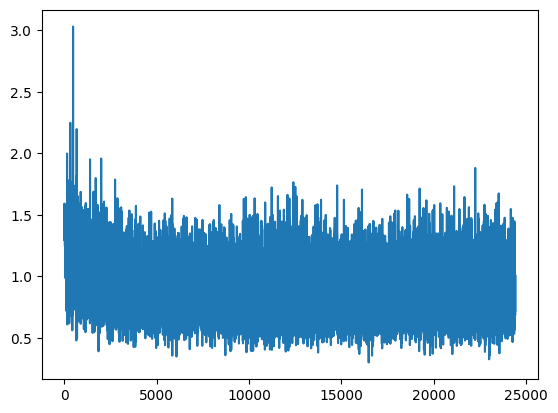

In [67]:
plt.plot(train_losses)

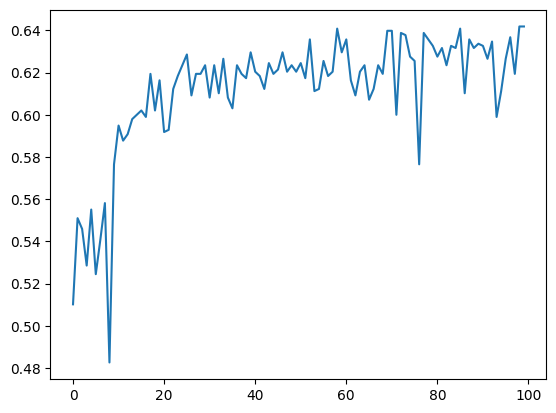

In [68]:
plt.plot(test_accuracy)

In [70]:
model.to('cpu')
best_model_path = f'{model_path_prefix}{best_epoch}epoch.pt'
print(best_model_path)
best_model = M13(config=model_config,
           n_input=1, n_output=len(labels))
best_model.load_state_dict(torch.load(best_model_path))
best_model.to(device)

metrics_best, confusion_matrix_best = report_metrics(
    best_model, labels=labels, device=device)
best_model.to('cpu')
pprint(metrics_best.compute())
confusion_matrix_best.compute()

../models_cremad4/cremad_label4_m13ser_best_99epoch.pt
Correct: 629/976 (0.6445)
{'acc_detail': tensor([0.6693, 0.6759, 0.7087, 0.5278], device='cuda:0'),
 'acc_unweighted': tensor(0.6454, device='cuda:0'),
 'acc_weighted': tensor(0.6445, device='cuda:0'),
 'f1s_detail': tensor([0.7359, 0.5626, 0.7171, 0.5672], device='cuda:0'),
 'f1s_unweighted': tensor(0.6457, device='cuda:0'),
 'f1s_weighted': tensor(0.6491, device='cuda:0'),
 'precision_detail': tensor([0.8173, 0.4818, 0.7258, 0.6129], device='cuda:0'),
 'recall_detail': tensor([0.6693, 0.6759, 0.7087, 0.5278], device='cuda:0'),
 'rocauc': tensor(0.8607, device='cuda:0'),
 'rocauc_detail': tensor([0.9171, 0.8306, 0.9052, 0.7901], device='cuda:0'),
 'uar': tensor(0.6454, device='cuda:0'),
 'wap': tensor(0.6665, device='cuda:0')}


tensor([[170,  21,   5,  58],
        [  3, 146,  45,  22],
        [  5,  65, 180,   4],
        [ 30,  71,  18, 133]], device='cuda:0')

Time domain: Filters' shapes vary by frequency bins


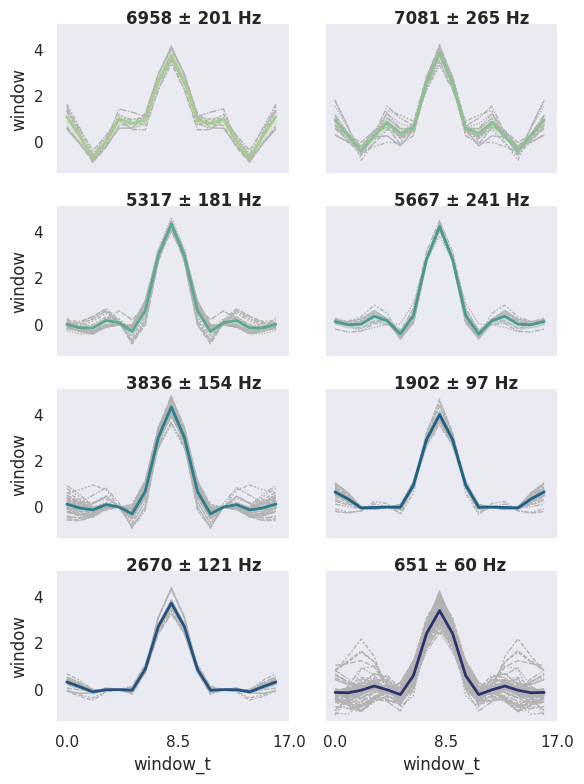

In [71]:
from IConNet.visualizer import visualize_model

layer = best_model.fe_blocks.blocks[0].block.layer

filtviz = visualize_model.FilterVisualizer(
    lowcut_bands = layer.lowcut_bands, 
    bandwidths = layer.bandwidths,
    window_params = layer.window_params, 
    window_length = 64,
    sample_rate = sr
)
filtviz.visualize_filters(filter_domain='time')

Frequency domain: Filters' shapes vary by frequency bins


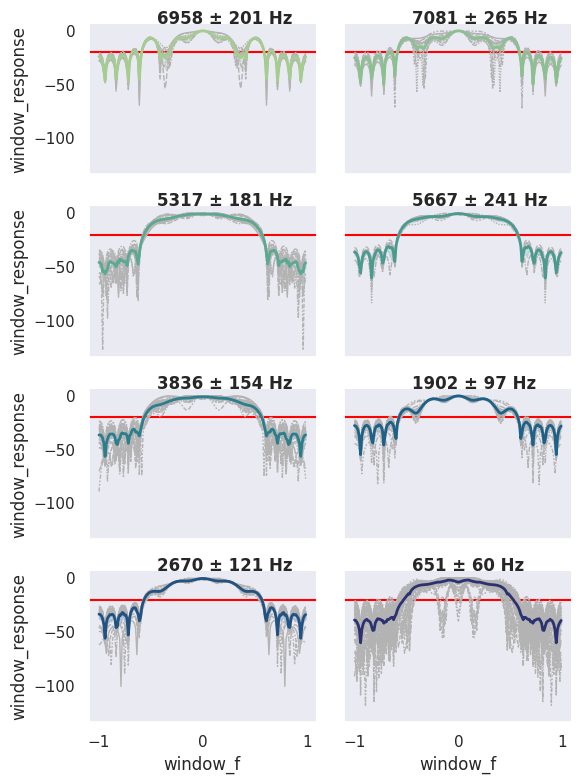

In [72]:
filtviz.visualize_filters(filter_domain='freq')

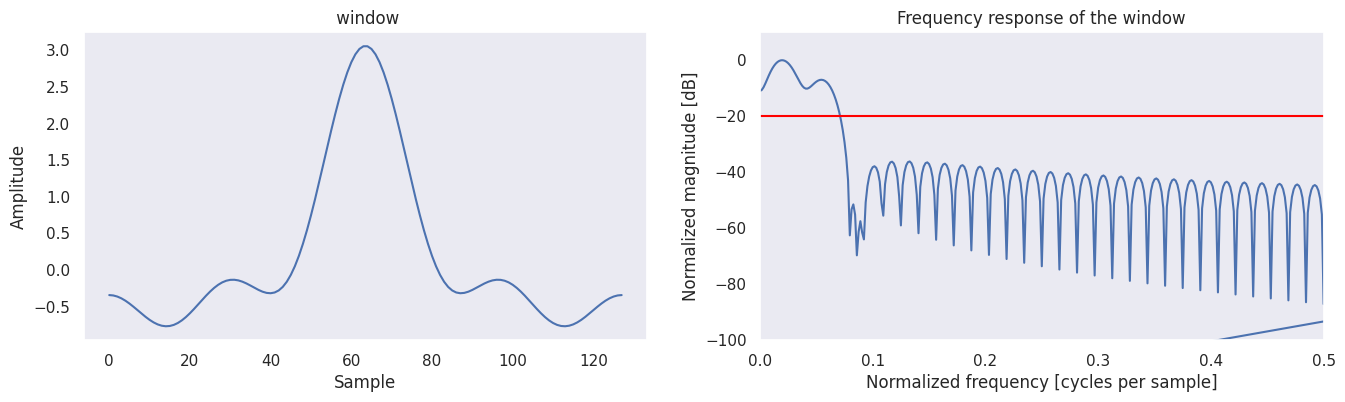

In [73]:
filtviz.visualize_one_window(n_out=10)

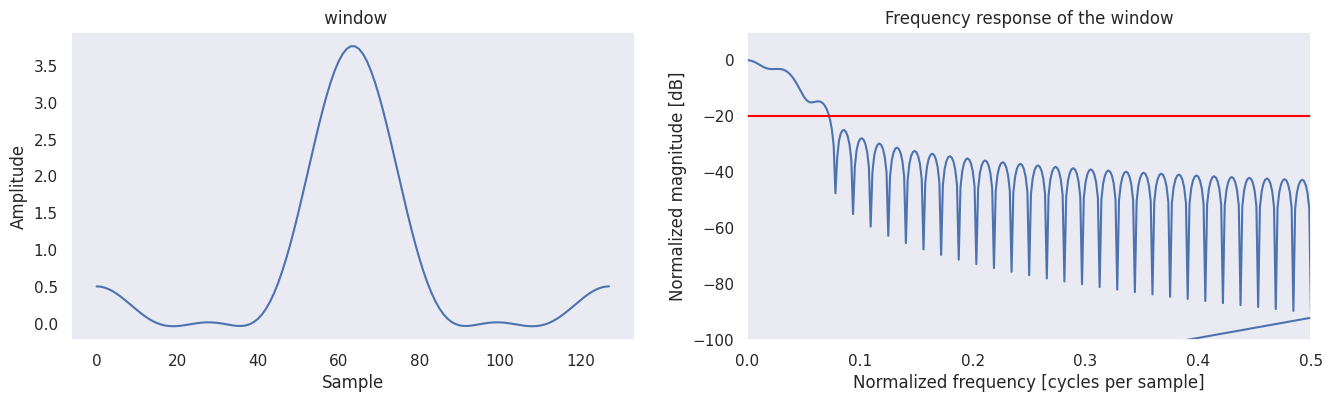

In [74]:
filtviz.visualize_one_window(n_out=30)

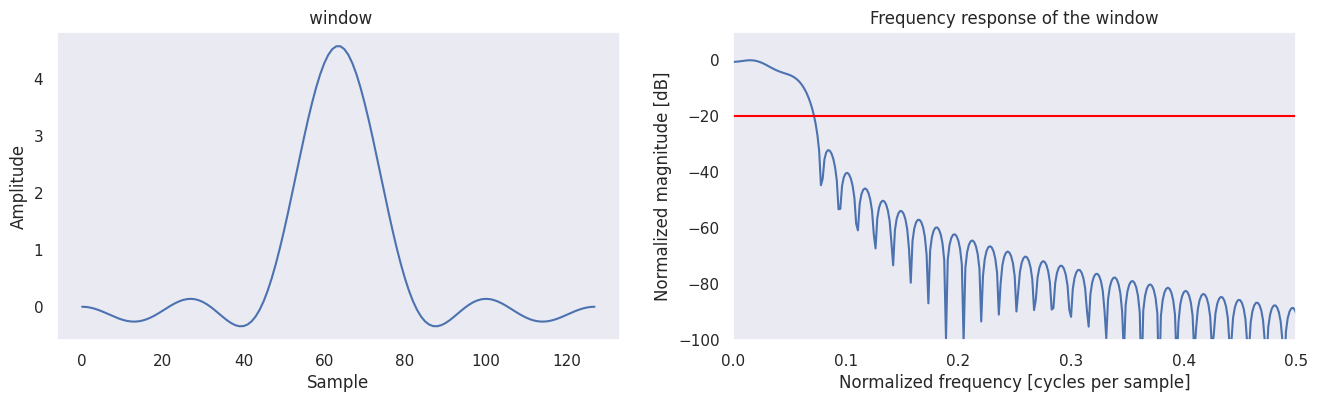

In [75]:
filtviz.visualize_one_window(n_out=50)

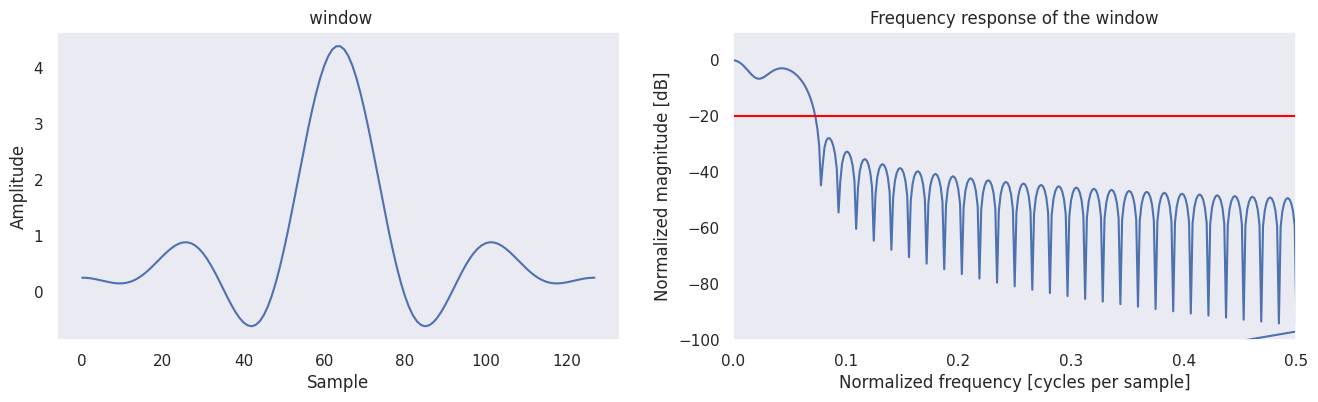

In [76]:
filtviz.visualize_one_window(n_out=60)

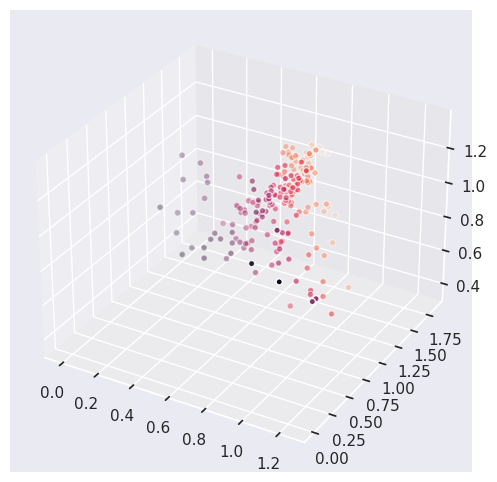

In [77]:
filtviz.visualize_window_params()

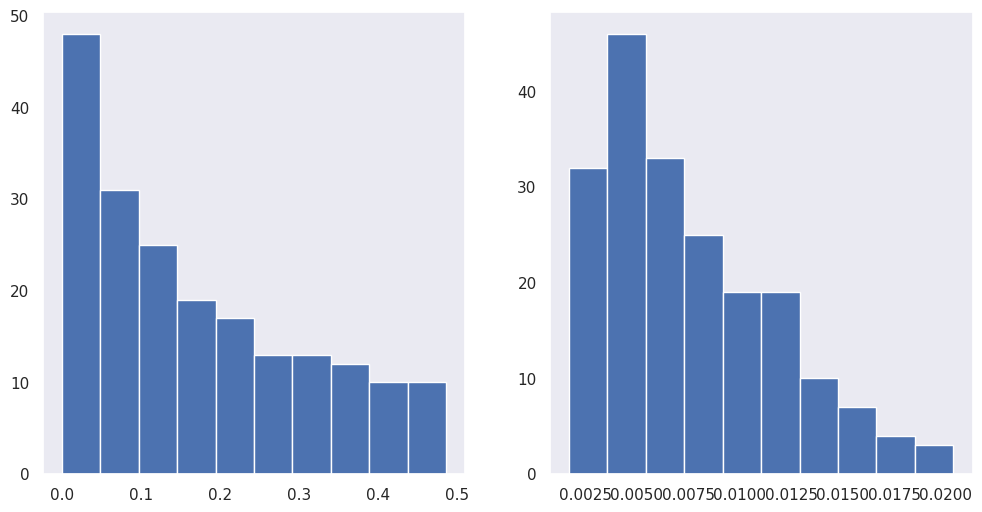

In [78]:
filtviz.visualize_bands()

downsample_factor: 2 => new_sample_rate: 8000
Time domain: Filters' shapes vary by frequency bins


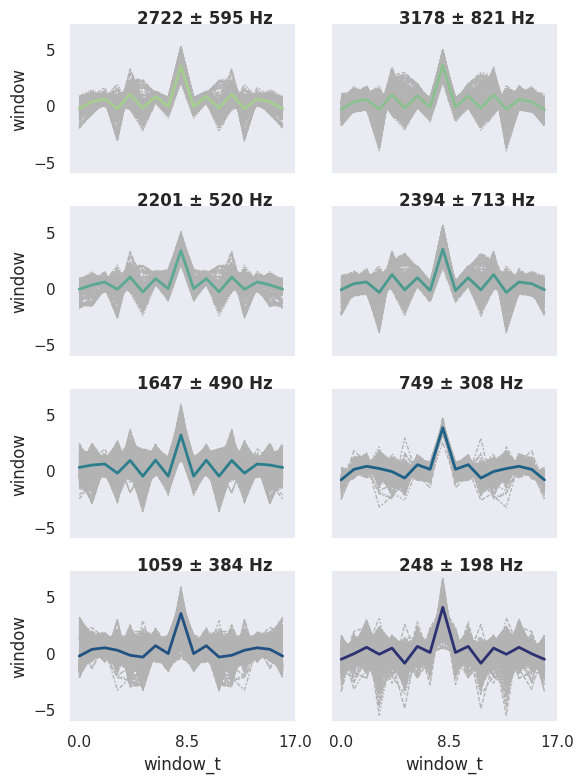

In [79]:
layer2 = best_model.fe_blocks.blocks[1].block.layer
downsample_factor = best_model.fe_blocks.blocks[0].stride
new_sample_rate = sr // downsample_factor
print(f'downsample_factor: {downsample_factor} => new_sample_rate: {new_sample_rate}')

filtviz2 = visualize_model.FilterVisualizer(
    lowcut_bands = layer2.lowcut_bands, 
    bandwidths = layer2.bandwidths,
    window_params = layer2.window_params, 
    window_length = 64,
    sample_rate = new_sample_rate
)
filtviz2.visualize_filters(filter_domain='time')

Frequency domain: Filters' shapes vary by frequency bins


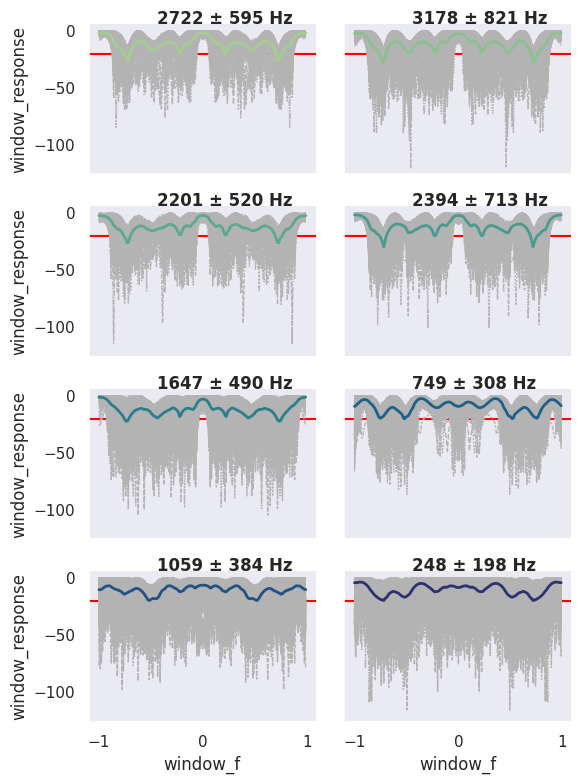

In [80]:
filtviz2.visualize_filters(filter_domain='freq')

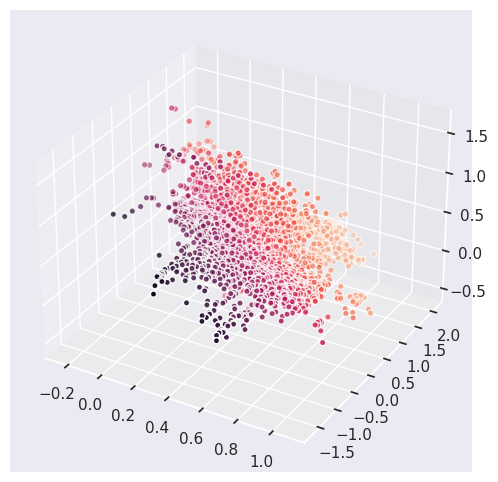

In [81]:
filtviz2.visualize_window_params()

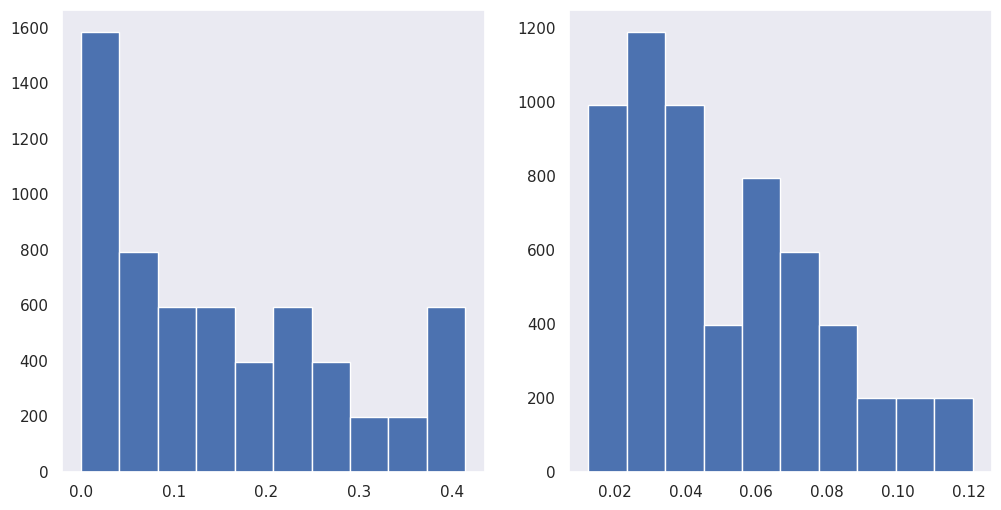

In [82]:
filtviz2.visualize_bands()

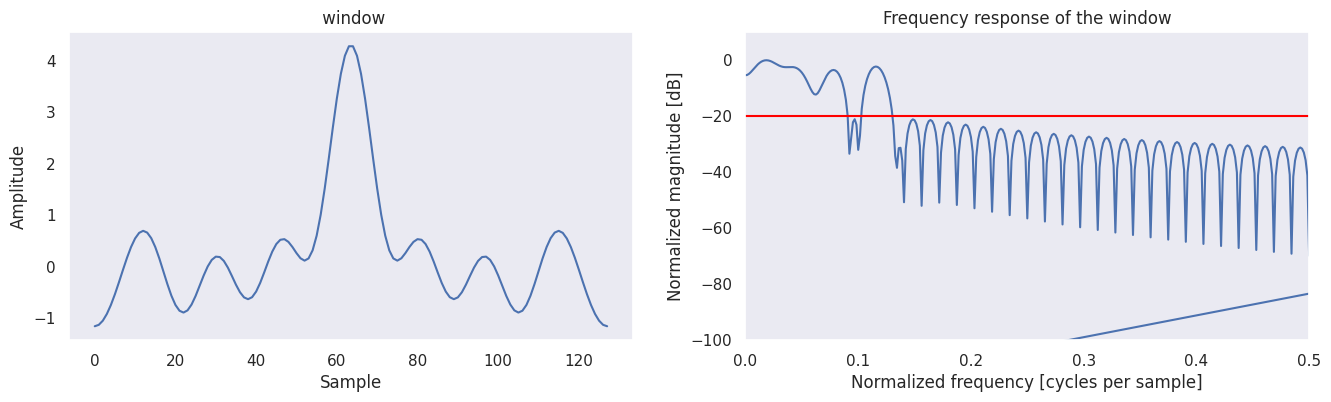

In [83]:
filtviz2.visualize_one_window(n_inp=10, n_out=10)

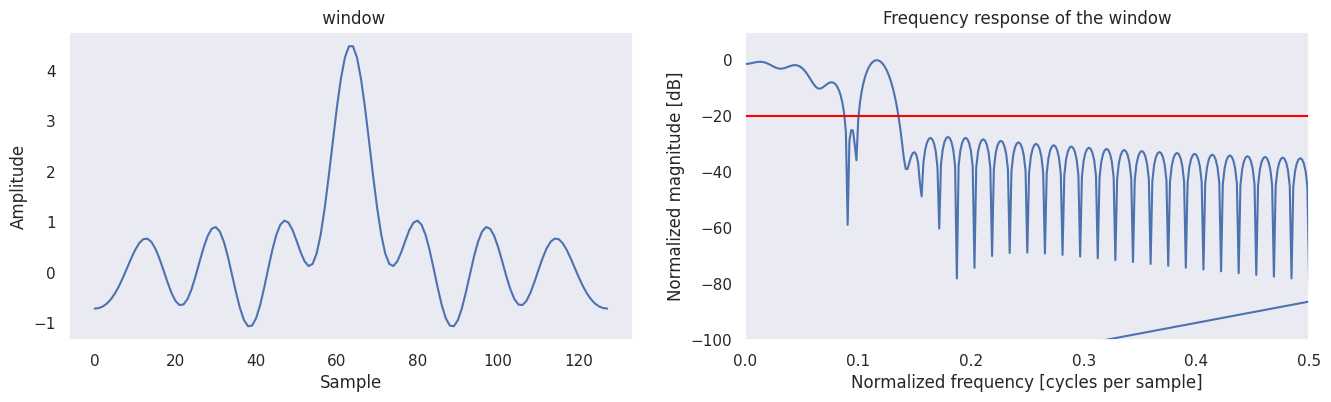

In [85]:
filtviz2.visualize_one_window(n_inp=30, n_out=10)

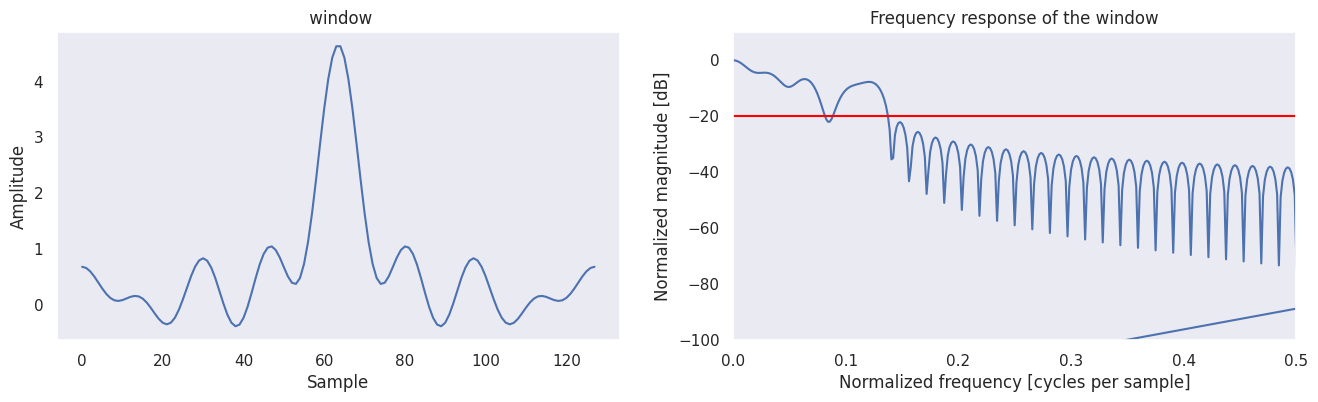

In [86]:
filtviz2.visualize_one_window(n_inp=50, n_out=10)

In [88]:
n_epoch = 10
n_epoch2 = 50
n_epoch3 = 40
n_epoch4 = 50

optimizer = optim.RAdam(model.parameters(), lr=0.000005)
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=0.01, pct_start=0.3,
    steps_per_epoch=len(train_loader), epochs=n_epoch4)
log_interval = 40
pbar_update = 1 / (len(train_loader) + len(test_loader))
model.to(device)
with tqdm(total=n_epoch4) as pbar:
    for epoch in range(1+n_epoch+n_epoch2+n_epoch3, n_epoch4+n_epoch3+n_epoch2 + n_epoch + 1):
        train(model, epoch, log_interval, train_losses)
        acc = test(model, epoch)
        test_accuracy += [acc]
        if acc > best_accuracy:
            best_accuracy = acc
            best_epoch = epoch
            bmodel_path = f'{model_path_prefix}{epoch}epoch.pt'
            torch.save(model.state_dict(), bmodel_path)
            print(f'saved model: {bmodel_path}')
        scheduler.step()

  0%|                               | 0.003278688524590164/50 [00:00<2:33:36, 184.35s/it]

Train Epoch: 101 [0/3918 (0%)]	Loss: 1.514739
Mem before-during-after: 71189504 4068142080 74836992


  0%|                                | 0.13442622950819672/50 [00:17<1:45:35, 127.05s/it]

Train Epoch: 101 [640/3918 (16%)]	Loss: 0.817553
Mem before-during-after: 75671552 4071936000 74836992


  1%|▏                               | 0.26557377049180286/50 [00:34<1:45:53, 127.74s/it]

Train Epoch: 101 [1280/3918 (33%)]	Loss: 0.875968
Mem before-during-after: 74836992 4071712256 75114496


  1%|▎                                  | 0.39672131147541/50 [00:51<1:47:36, 130.17s/it]

Train Epoch: 101 [1920/3918 (49%)]	Loss: 0.962760
Mem before-during-after: 75702784 3782484480 75389440


  1%|▎                                | 0.5278688524590167/50 [01:07<1:38:25, 119.38s/it]

Train Epoch: 101 [2560/3918 (66%)]	Loss: 0.695306
Mem before-during-after: 74922496 4074209280 75757056


  1%|▍                                | 0.6590163934426216/50 [01:23<1:41:16, 123.15s/it]

Train Epoch: 101 [3200/3918 (82%)]	Loss: 0.820702
Mem before-during-after: 76247552 3905387008 74957824


  2%|▌                                | 0.7901639344262266/50 [01:39<1:39:41, 121.54s/it]

Train Epoch: 101 [3840/3918 (98%)]	Loss: 0.718023
Mem before-during-after: 74907136 4073146368 75184640


  2%|▋                                   | 0.9999999999999944/50 [01:55<59:43, 73.13s/it]


Test Epoch: 101	Accuracy: 628/976 (64%)



  2%|▋                                 | 1.0032786885245846/50 [01:56<1:10:04, 85.80s/it]

Train Epoch: 102 [0/3918 (0%)]	Loss: 0.839676
Mem before-during-after: 74782720 4071812096 74836992


  2%|▋                                | 1.1344262295081895/50 [02:12<1:53:21, 139.20s/it]

Train Epoch: 102 [640/3918 (16%)]	Loss: 0.734504
Mem before-during-after: 75412992 4072538624 75691008


  3%|▊                                | 1.2655737704917944/50 [02:29<1:37:44, 120.34s/it]

Train Epoch: 102 [1280/3918 (33%)]	Loss: 0.913571
Mem before-during-after: 75413504 4074209280 76247552


  3%|▉                                | 1.3967213114753994/50 [02:46<1:38:06, 121.11s/it]

Train Epoch: 102 [1920/3918 (49%)]	Loss: 0.602664
Mem before-during-after: 75413504 4073652736 75691008


  3%|█                                | 1.5278688524590043/50 [03:02<1:36:58, 120.03s/it]

Train Epoch: 102 [2560/3918 (66%)]	Loss: 0.805864
Mem before-during-after: 75413504 4074209792 76248064


  3%|█                                | 1.6590163934426092/50 [03:18<2:06:12, 156.64s/it]

Train Epoch: 102 [3200/3918 (82%)]	Loss: 0.742813
Mem before-during-after: 74789888 4073382400 75483136


  4%|█▏                               | 1.7901639344262141/50 [03:35<1:58:54, 147.98s/it]

Train Epoch: 102 [3840/3918 (98%)]	Loss: 1.450912
Mem before-during-after: 75412992 4072112640 76248064


  4%|█▍                                   | 1.999999999999982/50 [03:51<57:09, 71.45s/it]


Test Epoch: 102	Accuracy: 634/976 (65%)

saved model: ../models_cremad4/cremad_label4_m13ser_best_102epoch.pt


  4%|█▎                                | 2.0032786885245724/50 [03:51<1:08:27, 85.57s/it]

Train Epoch: 103 [0/3918 (0%)]	Loss: 0.734024
Mem before-during-after: 74782720 4071812096 74836992


  4%|█▍                               | 2.1344262295081773/50 [04:08<1:46:17, 133.24s/it]

Train Epoch: 103 [640/3918 (16%)]	Loss: 0.861328
Mem before-during-after: 74789888 4074779648 74836992


  5%|█▌                                | 2.265573770491782/50 [04:25<1:35:01, 119.45s/it]

Train Epoch: 103 [1280/3918 (33%)]	Loss: 0.823760
Mem before-during-after: 74836992 4074209280 75671552


  5%|█▋                                | 2.396721311475387/50 [04:42<1:35:47, 120.73s/it]

Train Epoch: 103 [1920/3918 (49%)]	Loss: 0.594777
Mem before-during-after: 75412992 4073652736 75691008


  5%|█▋                                | 2.527868852458992/50 [05:00<1:46:24, 134.50s/it]

Train Epoch: 103 [2560/3918 (66%)]	Loss: 0.768552
Mem before-during-after: 74836992 4072588800 75184128


  5%|█▊                                | 2.659016393442597/50 [05:17<1:43:15, 130.86s/it]

Train Epoch: 103 [3200/3918 (82%)]	Loss: 0.827908
Mem before-during-after: 75690496 4073095680 75413504


  6%|█▉                                | 2.790163934426202/50 [05:33<1:35:02, 120.80s/it]

Train Epoch: 103 [3840/3918 (98%)]	Loss: 0.727173
Mem before-during-after: 76247552 4073652224 75412992


  6%|██▎                                   | 2.99999999999997/50 [05:49<56:52, 72.60s/it]


Test Epoch: 103	Accuracy: 622/976 (63%)



  6%|██▏                                 | 3.00327868852456/50 [05:49<1:07:34, 86.27s/it]

Train Epoch: 104 [0/3918 (0%)]	Loss: 0.834557
Mem before-during-after: 74782720 4071812096 74836992


  6%|██▏                               | 3.134426229508165/50 [06:06<1:38:33, 126.18s/it]

Train Epoch: 104 [640/3918 (16%)]	Loss: 1.021322
Mem before-during-after: 74906624 4072031744 75184128


  7%|██▎                                | 3.26557377049177/50 [06:22<1:36:43, 124.18s/it]

Train Epoch: 104 [1280/3918 (33%)]	Loss: 0.511769
Mem before-during-after: 75229696 4070998528 74952192


  7%|██▏                              | 3.3967213114753747/50 [06:39<1:41:01, 130.06s/it]

Train Epoch: 104 [1920/3918 (49%)]	Loss: 1.010248
Mem before-during-after: 75412992 4073652736 75691008


  7%|██▎                              | 3.5278688524589796/50 [06:56<1:35:28, 123.27s/it]

Train Epoch: 104 [2560/3918 (66%)]	Loss: 0.747844
Mem before-during-after: 75104768 4014400000 74789888


  7%|██▍                              | 3.6590163934425846/50 [07:13<1:34:43, 122.64s/it]

Train Epoch: 104 [3200/3918 (82%)]	Loss: 1.010877
Mem before-during-after: 75114496 4073652736 74836992


  8%|██▌                              | 3.7901639344261895/50 [07:29<1:36:30, 125.30s/it]

Train Epoch: 104 [3840/3918 (98%)]	Loss: 0.539156
Mem before-during-after: 75690496 4073652224 75412992


  8%|██▉                                 | 3.9999999999999574/50 [07:45<55:58, 73.00s/it]


Test Epoch: 104	Accuracy: 633/976 (65%)



  8%|██▋                               | 4.0032786885245475/50 [07:45<1:06:11, 86.34s/it]

Train Epoch: 105 [0/3918 (0%)]	Loss: 0.829877
Mem before-during-after: 74782720 4071812096 74836992


  8%|██▊                               | 4.134426229508152/50 [08:01<1:47:28, 140.61s/it]

Train Epoch: 105 [640/3918 (16%)]	Loss: 0.767476
Mem before-during-after: 75483136 4072112128 76247552


  9%|██▉                               | 4.265573770491757/50 [08:18<1:32:32, 121.41s/it]

Train Epoch: 105 [1280/3918 (33%)]	Loss: 0.813821
Mem before-during-after: 75192320 4071555072 74914816


  9%|██▉                               | 4.396721311475362/50 [08:34<1:47:43, 141.74s/it]

Train Epoch: 105 [1920/3918 (49%)]	Loss: 0.977169
Mem before-during-after: 75819520 4030089216 74789888


  9%|███                               | 4.527868852458967/50 [08:50<1:32:59, 122.70s/it]

Train Epoch: 105 [2560/3918 (66%)]	Loss: 0.996297
Mem before-during-after: 75412992 4072112128 76247552


  9%|███▏                              | 4.659016393442572/50 [09:07<1:46:16, 140.63s/it]

Train Epoch: 105 [3200/3918 (82%)]	Loss: 0.848954
Mem before-during-after: 75622400 4073398784 75412992


 10%|███▎                              | 4.790163934426177/50 [09:23<1:30:24, 120.00s/it]

Train Epoch: 105 [3840/3918 (98%)]	Loss: 0.708387
Mem before-during-after: 76247552 4074209280 75412992


 10%|███▋                                 | 4.999999999999945/50 [09:38<56:28, 75.30s/it]


Test Epoch: 105	Accuracy: 604/976 (62%)



 10%|███▌                               | 5.003278688524535/50 [09:39<1:05:11, 86.92s/it]

Train Epoch: 106 [0/3918 (0%)]	Loss: 0.846232
Mem before-during-after: 74782720 4071812096 74836992


 10%|███▌                               | 5.13442622950814/50 [09:56<1:45:01, 140.46s/it]

Train Epoch: 106 [640/3918 (16%)]	Loss: 0.914121
Mem before-during-after: 75691008 4072538624 75413504


 11%|███▌                              | 5.265573770491745/50 [10:13<1:31:15, 122.41s/it]

Train Epoch: 106 [1280/3918 (33%)]	Loss: 1.220023
Mem before-during-after: 75412992 4074209280 76247552


 11%|███▊                               | 5.39672131147535/50 [10:29<1:32:34, 124.52s/it]

Train Epoch: 106 [1920/3918 (49%)]	Loss: 0.922651
Mem before-during-after: 74836992 4073398784 76247552


 11%|███▊                              | 5.527868852458955/50 [10:45<1:36:38, 130.38s/it]

Train Epoch: 106 [2560/3918 (66%)]	Loss: 0.954184
Mem before-during-after: 74852352 4071936000 74836992


 11%|███▉                               | 5.65901639344256/50 [11:02<1:51:35, 150.99s/it]

Train Epoch: 106 [3200/3918 (82%)]	Loss: 0.916560
Mem before-during-after: 75058176 4070440960 74946048


 12%|███▉                              | 5.790163934426165/50 [11:20<1:48:34, 147.35s/it]

Train Epoch: 106 [3840/3918 (98%)]	Loss: 0.942249
Mem before-during-after: 76247552 4072112128 75412992


 12%|████▎                               | 5.9999999999999325/50 [11:35<51:23, 70.08s/it]


Test Epoch: 106	Accuracy: 619/976 (63%)



 12%|████▏                              | 6.003278688524523/50 [11:36<1:01:40, 84.11s/it]

Train Epoch: 107 [0/3918 (0%)]	Loss: 0.880244
Mem before-during-after: 74782720 4071812096 74836992


 12%|████                             | 6.1344262295081275/50 [11:53<1:32:59, 127.20s/it]

Train Epoch: 107 [640/3918 (16%)]	Loss: 0.521449
Mem before-during-after: 75412992 4072538112 75690496


 13%|████▏                            | 6.2655737704917325/50 [12:10<1:54:09, 156.61s/it]

Train Epoch: 107 [1280/3918 (33%)]	Loss: 0.799228
Mem before-during-after: 74957824 4074377216 74836992


 13%|████▎                             | 6.396721311475337/50 [12:26<1:28:09, 121.31s/it]

Train Epoch: 107 [1920/3918 (49%)]	Loss: 1.184432
Mem before-during-after: 74844672 4071543808 75679232


 13%|████▍                             | 6.527868852458942/50 [12:43<1:46:40, 147.23s/it]

Train Epoch: 107 [2560/3918 (66%)]	Loss: 0.545789
Mem before-during-after: 76247552 4072112128 75412992


 13%|████▌                             | 6.659016393442547/50 [12:59<1:30:29, 125.27s/it]

Train Epoch: 107 [3200/3918 (82%)]	Loss: 0.711455
Mem before-during-after: 75412992 4072112128 76247552


 14%|████▌                             | 6.790163934426152/50 [13:15<1:27:24, 121.38s/it]

Train Epoch: 107 [3840/3918 (98%)]	Loss: 0.645980
Mem before-during-after: 74907136 4072589312 75184640


 14%|█████▎                                | 6.99999999999992/50 [13:31<51:31, 71.89s/it]


Test Epoch: 107	Accuracy: 620/976 (63%)



 14%|█████                               | 7.00327868852451/50 [13:31<1:02:28, 87.18s/it]

Train Epoch: 108 [0/3918 (0%)]	Loss: 0.885978
Mem before-during-after: 74782720 4071812096 74836992


 14%|████▊                             | 7.134426229508115/50 [13:48<1:31:05, 127.50s/it]

Train Epoch: 108 [640/3918 (16%)]	Loss: 0.627584
Mem before-during-after: 76247552 4072112128 75412992


 15%|█████                              | 7.26557377049172/50 [14:04<1:34:18, 132.42s/it]

Train Epoch: 108 [1280/3918 (33%)]	Loss: 0.905172
Mem before-during-after: 74836992 4074209280 76247552


 15%|█████                             | 7.396721311475325/50 [14:21<1:27:29, 123.21s/it]

Train Epoch: 108 [1920/3918 (49%)]	Loss: 0.731002
Mem before-during-after: 75671552 4074209280 74836992


 15%|█████▎                             | 7.52786885245893/50 [14:37<1:28:23, 124.87s/it]

Train Epoch: 108 [2560/3918 (66%)]	Loss: 0.976457
Mem before-during-after: 75184640 4071049216 74907136


 15%|█████▏                            | 7.659016393442535/50 [14:53<1:24:28, 119.71s/it]

Train Epoch: 108 [3200/3918 (82%)]	Loss: 0.865565
Mem before-during-after: 75413504 4074209280 76247552


 16%|█████▍                             | 7.79016393442614/50 [15:09<1:34:45, 134.71s/it]

Train Epoch: 108 [3840/3918 (98%)]	Loss: 0.892851
Mem before-during-after: 75383296 4071936512 75371520


 16%|█████▉                               | 7.999999999999908/50 [15:25<50:23, 71.98s/it]


Test Epoch: 108	Accuracy: 630/976 (64%)



 16%|█████▌                             | 8.003278688524498/50 [15:25<1:00:27, 86.39s/it]

Train Epoch: 109 [0/3918 (0%)]	Loss: 0.799382
Mem before-during-after: 74782720 4071067648 74836992


 16%|█████▌                            | 8.134426229508103/50 [15:42<1:21:49, 117.28s/it]

Train Epoch: 109 [640/3918 (16%)]	Loss: 0.738166
Mem before-during-after: 75114496 4016476160 75617792


 17%|█████▌                            | 8.265573770491708/50 [15:59<1:23:49, 120.52s/it]

Train Epoch: 109 [1280/3918 (33%)]	Loss: 0.848019
Mem before-during-after: 75412992 4074209792 76248064


 17%|█████▋                            | 8.396721311475313/50 [16:14<1:23:45, 120.79s/it]

Train Epoch: 109 [1920/3918 (49%)]	Loss: 1.116486
Mem before-during-after: 75412992 4073652224 75690496


 17%|█████▊                            | 8.527868852458917/50 [16:30<1:22:43, 119.68s/it]

Train Epoch: 109 [2560/3918 (66%)]	Loss: 0.601619
Mem before-during-after: 75413504 4074209280 76247552


 17%|█████▉                            | 8.659016393442522/50 [16:46<1:24:35, 122.77s/it]

Train Epoch: 109 [3200/3918 (82%)]	Loss: 1.219433
Mem before-during-after: 74922496 4071692288 74836992


 18%|█████▉                            | 8.790163934426127/50 [17:03<1:41:05, 147.19s/it]

Train Epoch: 109 [3840/3918 (98%)]	Loss: 0.767227
Mem before-during-after: 75413504 4071555072 75690496


 18%|██████▋                              | 8.999999999999895/50 [17:19<48:43, 71.30s/it]


Test Epoch: 109	Accuracy: 627/976 (64%)



 18%|██████▋                              | 9.003278688524485/50 [17:20<58:26, 85.54s/it]

Train Epoch: 110 [0/3918 (0%)]	Loss: 0.701266
Mem before-during-after: 74782720 4071812608 74836992


 18%|██████▍                            | 9.13442622950809/50 [17:36<1:21:54, 120.27s/it]

Train Epoch: 110 [640/3918 (16%)]	Loss: 0.852335
Mem before-during-after: 75412992 4074209280 76247552


 19%|██████▎                           | 9.265573770491695/50 [17:52<1:22:58, 122.22s/it]

Train Epoch: 110 [1280/3918 (33%)]	Loss: 1.038234
Mem before-during-after: 74914816 4074209280 75749376


 19%|██████▊                             | 9.3967213114753/50 [18:09<1:40:49, 148.98s/it]

Train Epoch: 110 [1920/3918 (49%)]	Loss: 0.446006
Mem before-during-after: 74819584 4072493568 74836992


 19%|██████▍                           | 9.527868852458905/50 [18:25<1:25:17, 126.45s/it]

Train Epoch: 110 [2560/3918 (66%)]	Loss: 0.630375
Mem before-during-after: 74914816 4073652736 75192320


 19%|██████▊                            | 9.65901639344251/50 [18:41<1:21:30, 121.23s/it]

Train Epoch: 110 [3200/3918 (82%)]	Loss: 1.229843
Mem before-during-after: 74914816 4074209792 75749376


 20%|██████▋                           | 9.790163934426115/50 [18:58<1:21:02, 120.92s/it]

Train Epoch: 110 [3840/3918 (98%)]	Loss: 0.773021
Mem before-during-after: 76247552 4074209792 75413504


 20%|███████▍                             | 9.999999999999883/50 [19:13<48:14, 72.37s/it]


Test Epoch: 110	Accuracy: 627/976 (64%)



 20%|██████▊                           | 10.003278688524473/50 [19:14<1:00:21, 90.54s/it]

Train Epoch: 111 [0/3918 (0%)]	Loss: 0.649917
Mem before-during-after: 74782720 4071812608 74836992


 20%|██████▋                          | 10.134426229508078/50 [19:30<1:20:04, 120.52s/it]

Train Epoch: 111 [640/3918 (16%)]	Loss: 0.858499
Mem before-during-after: 75413504 4074209792 76248064


 21%|██████▊                          | 10.265573770491683/50 [19:47<1:26:47, 131.05s/it]

Train Epoch: 111 [1280/3918 (33%)]	Loss: 1.175969
Mem before-during-after: 74836992 4071712256 75114496


 21%|██████▊                          | 10.396721311475288/50 [20:03<1:21:15, 123.10s/it]

Train Epoch: 111 [1920/3918 (49%)]	Loss: 0.755266
Mem before-during-after: 74867712 4073095168 75145216


 21%|██████▉                          | 10.527868852458893/50 [20:19<1:19:36, 121.00s/it]

Train Epoch: 111 [2560/3918 (66%)]	Loss: 0.822854
Mem before-during-after: 76248064 4072112640 75413504


 21%|███████                          | 10.659016393442498/50 [20:35<1:19:16, 120.90s/it]

Train Epoch: 111 [3200/3918 (82%)]	Loss: 1.244755
Mem before-during-after: 75412992 4074209280 76247552


 22%|███████                          | 10.790163934426102/50 [20:52<1:18:07, 119.56s/it]

Train Epoch: 111 [3840/3918 (98%)]	Loss: 0.781484
Mem before-during-after: 76247552 3964413952 74789888


 22%|████████▏                            | 10.99999999999987/50 [21:07<46:59, 72.30s/it]


Test Epoch: 111	Accuracy: 608/976 (62%)



 22%|████████▏                            | 11.00327868852446/50 [21:08<55:41, 85.69s/it]

Train Epoch: 112 [0/3918 (0%)]	Loss: 0.645306
Mem before-during-after: 74782720 4071812096 74836992


 22%|███████▎                         | 11.134426229508065/50 [21:24<1:19:22, 122.53s/it]

Train Epoch: 112 [640/3918 (16%)]	Loss: 0.680105
Mem before-during-after: 76248064 4072112128 75412992


 23%|███████▋                          | 11.26557377049167/50 [21:41<1:19:10, 122.63s/it]

Train Epoch: 112 [1280/3918 (33%)]	Loss: 0.551040
Mem before-during-after: 75413504 4074209280 76247552


 23%|███████▌                         | 11.396721311475275/50 [21:57<1:29:54, 139.73s/it]

Train Epoch: 112 [1920/3918 (49%)]	Loss: 0.685351
Mem before-during-after: 74836992 4070081024 75026944


 23%|███████▊                          | 11.52786885245888/50 [22:14<1:34:01, 146.64s/it]

Train Epoch: 112 [2560/3918 (66%)]	Loss: 0.875802
Mem before-during-after: 75749376 4071555072 74914816


 23%|███████▋                         | 11.659016393442485/50 [22:31<1:17:16, 120.92s/it]

Train Epoch: 112 [3200/3918 (82%)]	Loss: 0.807030
Mem before-during-after: 74836992 4074209280 75671552


 24%|████████                          | 11.79016393442609/50 [22:47<1:35:36, 150.14s/it]

Train Epoch: 112 [3840/3918 (98%)]	Loss: 0.557630
Mem before-during-after: 75652608 4072660992 75483136


 24%|████████▋                           | 11.999999999999858/50 [23:03<45:51, 72.41s/it]


Test Epoch: 112	Accuracy: 631/976 (64%)



 24%|████████▋                           | 12.003278688524448/50 [23:03<54:16, 85.71s/it]

Train Epoch: 113 [0/3918 (0%)]	Loss: 0.989531
Mem before-during-after: 74782720 4071812096 74836992


 24%|████████                         | 12.134426229508053/50 [23:20<1:23:16, 131.96s/it]

Train Epoch: 113 [640/3918 (16%)]	Loss: 0.735222
Mem before-during-after: 75413504 4073095680 75691008


 25%|████████                         | 12.265573770491658/50 [23:36<1:23:37, 132.98s/it]

Train Epoch: 113 [1280/3918 (33%)]	Loss: 0.614888
Mem before-during-after: 74836992 4045596160 74789888


 25%|████████▏                        | 12.396721311475263/50 [23:52<1:15:51, 121.03s/it]

Train Epoch: 113 [1920/3918 (49%)]	Loss: 0.878690
Mem before-during-after: 75690496 4071555072 75412992


 25%|████████▎                        | 12.527868852458868/50 [24:09<1:18:24, 125.54s/it]

Train Epoch: 113 [2560/3918 (66%)]	Loss: 0.923030
Mem before-during-after: 74836992 4074209280 75671552


 25%|████████▎                        | 12.659016393442473/50 [24:26<1:26:27, 138.94s/it]

Train Epoch: 113 [3200/3918 (82%)]	Loss: 0.578877
Mem before-during-after: 75716096 4074209280 75412992


 26%|████████▍                        | 12.790163934426078/50 [24:42<1:17:59, 125.76s/it]

Train Epoch: 113 [3840/3918 (98%)]	Loss: 0.605470
Mem before-during-after: 74907136 4071936000 74922496


 26%|█████████▎                          | 12.999999999999845/50 [24:58<44:48, 72.67s/it]


Test Epoch: 113	Accuracy: 628/976 (64%)



 26%|█████████▎                          | 13.003278688524436/50 [24:58<53:22, 86.57s/it]

Train Epoch: 114 [0/3918 (0%)]	Loss: 1.342606
Mem before-during-after: 74782720 4071067648 74836992


 26%|████████▉                         | 13.13442622950804/50 [25:15<1:28:05, 143.37s/it]

Train Epoch: 114 [640/3918 (16%)]	Loss: 0.852063
Mem before-during-after: 75540992 4072112128 76247552


 27%|████████▊                        | 13.265573770491645/50 [25:33<1:15:02, 122.57s/it]

Train Epoch: 114 [1280/3918 (33%)]	Loss: 0.762890
Mem before-during-after: 74836992 4074209792 75671552


 27%|█████████                         | 13.39672131147525/50 [25:50<1:15:05, 123.08s/it]

Train Epoch: 114 [1920/3918 (49%)]	Loss: 0.749742
Mem before-during-after: 75192320 4073652224 74914816


 27%|████████▉                        | 13.527868852458855/50 [26:06<1:17:10, 126.95s/it]

Train Epoch: 114 [2560/3918 (66%)]	Loss: 1.291645
Mem before-during-after: 75413504 4072112128 76247552


 27%|█████████▎                        | 13.65901639344246/50 [26:22<1:13:33, 121.45s/it]

Train Epoch: 114 [3200/3918 (82%)]	Loss: 0.615520
Mem before-during-after: 75413504 4074209280 76247552


 28%|█████████                        | 13.790163934426065/50 [26:38<1:14:22, 123.23s/it]

Train Epoch: 114 [3840/3918 (98%)]	Loss: 0.568939
Mem before-during-after: 75690496 4071555584 75413504


 28%|██████████                          | 13.999999999999833/50 [26:54<42:51, 71.44s/it]


Test Epoch: 114	Accuracy: 628/976 (64%)



 28%|██████████                          | 14.003278688524423/50 [26:54<51:20, 85.59s/it]

Train Epoch: 115 [0/3918 (0%)]	Loss: 0.686462
Mem before-during-after: 74782720 4071812096 74836992


 28%|█████████▎                       | 14.134426229508028/50 [27:11<1:22:30, 138.03s/it]

Train Epoch: 115 [640/3918 (16%)]	Loss: 0.603239
Mem before-during-after: 74798592 4073366016 74836992


 29%|█████████▍                       | 14.265573770491633/50 [27:28<1:15:41, 127.09s/it]

Train Epoch: 115 [1280/3918 (33%)]	Loss: 1.141251
Mem before-during-after: 75114496 4073398784 75412992


 29%|█████████▌                       | 14.396721311475238/50 [27:45<1:12:06, 121.51s/it]

Train Epoch: 115 [1920/3918 (49%)]	Loss: 0.951563
Mem before-during-after: 74836992 4074209280 75671552


 29%|█████████▌                       | 14.527868852458843/50 [28:01<1:16:21, 129.15s/it]

Train Epoch: 115 [2560/3918 (66%)]	Loss: 0.805017
Mem before-during-after: 74907136 4071049216 75184640


 29%|█████████▋                       | 14.659016393442448/50 [28:18<1:12:49, 123.63s/it]

Train Epoch: 115 [3200/3918 (82%)]	Loss: 1.045158
Mem before-during-after: 75690496 4070998016 75412992


 30%|█████████▊                       | 14.790163934426053/50 [28:34<1:10:49, 120.68s/it]

Train Epoch: 115 [3840/3918 (98%)]	Loss: 0.765143
Mem before-during-after: 75749376 4074209280 74914816


 30%|███████████                          | 14.99999999999982/50 [28:50<41:55, 71.88s/it]


Test Epoch: 115	Accuracy: 626/976 (64%)



 30%|███████████                          | 15.00327868852441/50 [28:50<50:35, 86.75s/it]

Train Epoch: 116 [0/3918 (0%)]	Loss: 0.615076
Mem before-during-after: 74782720 4071729664 74836992


 30%|█████████▉                       | 15.134426229508016/50 [29:06<1:09:38, 119.85s/it]

Train Epoch: 116 [640/3918 (16%)]	Loss: 0.823324
Mem before-during-after: 75412992 4074209792 76248064


 31%|██████████▍                       | 15.26557377049162/50 [29:23<1:17:32, 133.96s/it]

Train Epoch: 116 [1280/3918 (33%)]	Loss: 1.210678
Mem before-during-after: 75114496 4072538112 74836992


 31%|██████████▏                      | 15.396721311475225/50 [29:40<1:09:32, 120.57s/it]

Train Epoch: 116 [1920/3918 (49%)]	Loss: 0.613273
Mem before-during-after: 75690496 4071555072 75412992


 31%|██████████▌                       | 15.52786885245883/50 [29:56<1:11:32, 124.53s/it]

Train Epoch: 116 [2560/3918 (66%)]	Loss: 1.039922
Mem before-during-after: 74836992 3690713088 74789888


 31%|██████████▎                      | 15.659016393442435/50 [30:12<1:10:50, 123.78s/it]

Train Epoch: 116 [3200/3918 (82%)]	Loss: 0.832942
Mem before-during-after: 75412992 4073652224 75690496


 32%|██████████▋                       | 15.79016393442604/50 [30:28<1:10:18, 123.31s/it]

Train Epoch: 116 [3840/3918 (98%)]	Loss: 0.903608
Mem before-during-after: 74836992 4072538112 75114496


 32%|███████████▌                        | 15.999999999999808/50 [30:44<41:25, 73.10s/it]


Test Epoch: 116	Accuracy: 622/976 (63%)



 32%|████████████▏                         | 16.0032786885244/50 [30:44<49:35, 87.54s/it]

Train Epoch: 117 [0/3918 (0%)]	Loss: 0.543861
Mem before-during-after: 74782720 4071812096 74836992


 32%|██████████▋                      | 16.134426229508076/50 [31:00<1:07:39, 119.88s/it]

Train Epoch: 117 [640/3918 (16%)]	Loss: 0.557287
Mem before-during-after: 75671552 4073633280 74836992


 33%|██████████▋                      | 16.265573770491752/50 [31:17<1:08:38, 122.09s/it]

Train Epoch: 117 [1280/3918 (33%)]	Loss: 0.832219
Mem before-during-after: 75114496 4073095168 75412992


 33%|██████████▊                      | 16.396721311475428/50 [31:33<1:16:30, 136.60s/it]

Train Epoch: 117 [1920/3918 (49%)]	Loss: 1.022831
Mem before-during-after: 74789888 4073778176 75538944


 33%|██████████▉                      | 16.527868852459104/50 [31:49<1:06:48, 119.75s/it]

Train Epoch: 117 [2560/3918 (66%)]	Loss: 0.984074
Mem before-during-after: 74914816 4074209280 75749376


 33%|███████████▎                      | 16.65901639344278/50 [32:06<1:15:06, 135.15s/it]

Train Epoch: 117 [3200/3918 (82%)]	Loss: 1.034750
Mem before-during-after: 75413504 4073652736 75691008


 34%|███████████                      | 16.790163934426456/50 [32:22<1:07:35, 122.13s/it]

Train Epoch: 117 [3840/3918 (98%)]	Loss: 0.502167
Mem before-during-after: 76247552 4072112128 75412992


 34%|████████████▏                       | 17.000000000000338/50 [32:38<40:23, 73.43s/it]


Test Epoch: 117	Accuracy: 628/976 (64%)



 34%|████████████▌                        | 17.00327868852493/50 [32:38<47:04, 85.61s/it]

Train Epoch: 118 [0/3918 (0%)]	Loss: 0.949868
Mem before-during-after: 74782720 4071812096 74836992


 34%|███████████▎                     | 17.134426229508605/50 [32:55<1:10:47, 129.25s/it]

Train Epoch: 118 [640/3918 (16%)]	Loss: 1.082282
Mem before-during-after: 75114496 4073652224 74914816


 35%|███████████▋                      | 17.26557377049228/50 [33:11<1:06:17, 121.52s/it]

Train Epoch: 118 [1280/3918 (33%)]	Loss: 0.963955
Mem before-during-after: 75412992 4074209280 76247552


 35%|███████████▍                     | 17.396721311475957/50 [33:27<1:07:15, 123.76s/it]

Train Epoch: 118 [1920/3918 (49%)]	Loss: 0.738495
Mem before-during-after: 75741696 3905611776 75350528


 35%|███████████▌                     | 17.527868852459633/50 [33:44<1:04:53, 119.91s/it]

Train Epoch: 118 [2560/3918 (66%)]	Loss: 0.824005
Mem before-during-after: 76247552 4074209792 75413504


 35%|████████████                      | 17.65901639344331/50 [34:00<1:06:16, 122.95s/it]

Train Epoch: 118 [3200/3918 (82%)]	Loss: 1.173641
Mem before-during-after: 75412992 4073652736 75691008


 36%|███████████▋                     | 17.790163934426985/50 [34:17<1:18:11, 145.65s/it]

Train Epoch: 118 [3840/3918 (98%)]	Loss: 0.852046
Mem before-during-after: 74789888 4071906304 74798592


 36%|████████████▉                       | 18.000000000000867/50 [34:33<40:12, 75.39s/it]


Test Epoch: 118	Accuracy: 629/976 (64%)



 36%|█████████████▎                       | 18.00327868852546/50 [34:33<46:40, 87.53s/it]

Train Epoch: 119 [0/3918 (0%)]	Loss: 0.509600
Mem before-during-after: 74782720 4071812096 74836992


 36%|███████████▉                     | 18.134426229509135/50 [34:49<1:03:41, 119.93s/it]

Train Epoch: 119 [640/3918 (16%)]	Loss: 1.264635
Mem before-during-after: 75413504 4074209280 76247552


 37%|████████████▍                     | 18.26557377049281/50 [35:06<1:04:34, 122.10s/it]

Train Epoch: 119 [1280/3918 (33%)]	Loss: 0.876962
Mem before-during-after: 75690496 4073652736 75413504


 37%|████████████▏                    | 18.396721311476487/50 [35:22<1:04:25, 122.31s/it]

Train Epoch: 119 [1920/3918 (49%)]	Loss: 0.928352
Mem before-during-after: 75413504 4072112128 76247552


 37%|████████████▏                    | 18.527868852460163/50 [35:39<1:03:58, 121.98s/it]

Train Epoch: 119 [2560/3918 (66%)]	Loss: 0.804898
Mem before-during-after: 75671552 4074209792 74836992


 37%|████████████▋                     | 18.65901639344384/50 [35:55<1:03:33, 121.67s/it]

Train Epoch: 119 [3200/3918 (82%)]	Loss: 0.559118
Mem before-during-after: 74907136 4073703424 75741696


 38%|████████████▍                    | 18.790163934427515/50 [36:12<1:03:11, 121.48s/it]

Train Epoch: 119 [3840/3918 (98%)]	Loss: 0.618850
Mem before-during-after: 75412992 4073652224 75690496


 38%|█████████████▋                      | 19.000000000001396/50 [36:27<36:40, 70.99s/it]


Test Epoch: 119	Accuracy: 639/976 (65%)

saved model: ../models_cremad4/cremad_label4_m13ser_best_119epoch.pt


 38%|█████████████▋                      | 19.003278688525988/50 [36:28<44:04, 85.31s/it]

Train Epoch: 120 [0/3918 (0%)]	Loss: 0.640393
Mem before-during-after: 74782720 4071812096 74836992


 38%|████████████▋                    | 19.134426229509664/50 [36:45<1:02:03, 120.65s/it]

Train Epoch: 120 [640/3918 (16%)]	Loss: 0.940210
Mem before-during-after: 74921984 4074209280 75756544


 39%|█████████████                     | 19.26557377049334/50 [37:01<1:06:20, 129.50s/it]

Train Epoch: 120 [1280/3918 (33%)]	Loss: 0.893971
Mem before-during-after: 74836992 4072538624 75114496


 39%|████████████▊                    | 19.396721311477016/50 [37:17<1:01:00, 119.61s/it]

Train Epoch: 120 [1920/3918 (49%)]	Loss: 0.829804
Mem before-during-after: 76247552 4074209792 75413504


 39%|████████████▉                    | 19.527868852460692/50 [37:33<1:01:14, 120.59s/it]

Train Epoch: 120 [2560/3918 (66%)]	Loss: 0.830298
Mem before-during-after: 76248064 4074209280 75412992


 39%|████████████▉                    | 19.659016393444368/50 [37:50<1:01:15, 121.15s/it]

Train Epoch: 120 [3200/3918 (82%)]	Loss: 0.757994
Mem before-during-after: 75690496 4073398784 75412992


 40%|█████████████                    | 19.790163934428044/50 [38:06<1:02:14, 123.63s/it]

Train Epoch: 120 [3840/3918 (98%)]	Loss: 0.781817
Mem before-during-after: 75690496 4074209280 75412992


 40%|██████████████▍                     | 20.000000000001926/50 [38:22<36:30, 73.03s/it]


Test Epoch: 120	Accuracy: 628/976 (64%)



 40%|██████████████▍                     | 20.003278688526517/50 [38:22<43:02, 86.11s/it]

Train Epoch: 121 [0/3918 (0%)]	Loss: 1.018147
Mem before-during-after: 74782720 4071812096 74836992


 40%|█████████████▎                   | 20.134426229510193/50 [38:38<1:04:57, 130.51s/it]

Train Epoch: 121 [640/3918 (16%)]	Loss: 0.946937
Mem before-during-after: 75690496 4074209280 75412992


 41%|██████████████▌                     | 20.26557377049387/50 [38:55<59:54, 120.87s/it]

Train Epoch: 121 [1280/3918 (33%)]	Loss: 0.752418
Mem before-during-after: 76247552 4074209792 75413504


 41%|█████████████▍                   | 20.396721311477545/50 [39:10<1:00:12, 122.02s/it]

Train Epoch: 121 [1920/3918 (49%)]	Loss: 0.591451
Mem before-during-after: 76247552 4074209280 75412992


 41%|██████████████▊                     | 20.52786885246122/50 [39:26<59:40, 121.49s/it]

Train Epoch: 121 [2560/3918 (66%)]	Loss: 1.020104
Mem before-during-after: 76248064 4074209280 75412992


 41%|██████████████▍                    | 20.659016393444897/50 [39:43<59:52, 122.42s/it]

Train Epoch: 121 [3200/3918 (82%)]	Loss: 0.856571
Mem before-during-after: 75412992 4074209280 76247552


 42%|██████████████▌                    | 20.790163934428573/50 [39:59<59:32, 122.31s/it]

Train Epoch: 121 [3840/3918 (98%)]	Loss: 0.627825
Mem before-during-after: 76247552 4072112128 75412992


 42%|███████████████                     | 21.000000000002455/50 [40:15<34:13, 70.82s/it]


Test Epoch: 121	Accuracy: 632/976 (64%)



 42%|███████████████                     | 21.003278688527047/50 [40:15<41:26, 85.76s/it]

Train Epoch: 122 [0/3918 (0%)]	Loss: 0.507226
Mem before-during-after: 74782720 4071812096 74836992


 42%|█████████████▉                   | 21.134426229510723/50 [40:32<1:00:00, 124.74s/it]

Train Epoch: 122 [640/3918 (16%)]	Loss: 1.037366
Mem before-during-after: 74914816 4071555584 75192320


 43%|███████████████▋                     | 21.2655737704944/50 [40:48<57:22, 119.80s/it]

Train Epoch: 122 [1280/3918 (33%)]	Loss: 1.104545
Mem before-during-after: 75690496 3945376256 74967040


 43%|██████████████                   | 21.396721311478075/50 [41:04<1:04:04, 134.42s/it]

Train Epoch: 122 [1920/3918 (49%)]	Loss: 0.737090
Mem before-during-after: 74836992 4071645696 74798080


 43%|██████████████▋                   | 21.52786885246175/50 [41:21<1:02:52, 132.51s/it]

Train Epoch: 122 [2560/3918 (66%)]	Loss: 1.059000
Mem before-during-after: 75690496 4073095168 75412992


 43%|██████████████▎                  | 21.659016393445427/50 [41:37<1:00:24, 127.88s/it]

Train Epoch: 122 [3200/3918 (82%)]	Loss: 1.256078
Mem before-during-after: 75034624 4072538112 74922496


 44%|███████████████▎                   | 21.790163934429103/50 [41:53<57:50, 123.01s/it]

Train Epoch: 122 [3840/3918 (98%)]	Loss: 0.712539
Mem before-during-after: 75690496 4015648256 74789888


 44%|███████████████▊                    | 22.000000000002984/50 [42:09<34:16, 73.44s/it]


Test Epoch: 122	Accuracy: 630/976 (64%)



 44%|███████████████▊                    | 22.003278688527576/50 [42:10<40:21, 86.48s/it]

Train Epoch: 123 [0/3918 (0%)]	Loss: 0.473111
Mem before-during-after: 74782720 4071730176 74836992


 44%|██████████████▌                  | 22.134426229511252/50 [42:26<1:03:58, 137.75s/it]

Train Epoch: 123 [640/3918 (16%)]	Loss: 1.259340
Mem before-during-after: 74836992 4072825344 75114496


 45%|███████████████▌                   | 22.265573770494928/50 [42:43<58:26, 126.42s/it]

Train Epoch: 123 [1280/3918 (33%)]	Loss: 0.897514
Mem before-during-after: 74836992 4074209280 75671552


 45%|███████████████▋                   | 22.396721311478604/50 [42:59<56:11, 122.14s/it]

Train Epoch: 123 [1920/3918 (49%)]	Loss: 0.600973
Mem before-during-after: 75413504 4074209280 76247552


 45%|███████████████▎                  | 22.52786885246228/50 [43:16<1:08:34, 149.77s/it]

Train Epoch: 123 [2560/3918 (66%)]	Loss: 1.154312
Mem before-during-after: 75412992 4072112128 76247552


 45%|███████████████▊                   | 22.659016393445956/50 [43:33<55:54, 122.68s/it]

Train Epoch: 123 [3200/3918 (82%)]	Loss: 0.614756
Mem before-during-after: 74836992 4074209792 75671552


 46%|███████████████▉                   | 22.790163934429632/50 [43:51<59:37, 131.49s/it]

Train Epoch: 123 [3840/3918 (98%)]	Loss: 0.722812
Mem before-during-after: 74914816 4074209280 75749376


 46%|████████████████▌                   | 23.000000000003514/50 [44:07<32:26, 72.08s/it]


Test Epoch: 123	Accuracy: 624/976 (64%)



 46%|████████████████▌                   | 23.003278688528106/50 [44:07<38:38, 85.90s/it]

Train Epoch: 124 [0/3918 (0%)]	Loss: 0.815613
Mem before-during-after: 74782720 4071812608 74836992


 46%|████████████████▋                   | 23.13442622951178/50 [44:23<55:43, 124.46s/it]

Train Epoch: 124 [640/3918 (16%)]	Loss: 0.769857
Mem before-during-after: 75749376 4074209792 74914816


 47%|████████████████▎                  | 23.265573770495457/50 [44:40<56:57, 127.82s/it]

Train Epoch: 124 [1280/3918 (33%)]	Loss: 1.257461
Mem before-during-after: 75104768 4071790080 74836992


 47%|████████████████▍                  | 23.396721311479133/50 [44:56<57:39, 130.05s/it]

Train Epoch: 124 [1920/3918 (49%)]	Loss: 1.104176
Mem before-during-after: 74914816 4071555072 75192320


 47%|████████████████▉                   | 23.52786885246281/50 [45:13<53:41, 121.70s/it]

Train Epoch: 124 [2560/3918 (66%)]	Loss: 0.988796
Mem before-during-after: 75671552 4071536128 74836992


 47%|████████████████▌                  | 23.659016393446485/50 [45:29<54:23, 123.91s/it]

Train Epoch: 124 [3200/3918 (82%)]	Loss: 0.516075
Mem before-during-after: 75200000 4072538112 74922496


 48%|████████████████▏                 | 23.79016393443016/50 [45:46<1:03:42, 145.82s/it]

Train Epoch: 124 [3840/3918 (98%)]	Loss: 0.721292
Mem before-during-after: 75641856 4072450560 74798080


 48%|█████████████████▎                  | 24.000000000004043/50 [46:02<32:00, 73.87s/it]


Test Epoch: 124	Accuracy: 625/976 (64%)



 48%|█████████████████▎                  | 24.003278688528635/50 [46:02<37:50, 87.33s/it]

Train Epoch: 125 [0/3918 (0%)]	Loss: 0.879869
Mem before-during-after: 74782720 4071812096 74836992


 48%|█████████████████▍                  | 24.13442622951231/50 [46:19<59:39, 138.38s/it]

Train Epoch: 125 [640/3918 (16%)]	Loss: 0.722547
Mem before-during-after: 74836992 3864083968 74789888


 49%|████████████████▉                  | 24.265573770495987/50 [46:35<53:18, 124.28s/it]

Train Epoch: 125 [1280/3918 (33%)]	Loss: 1.029764
Mem before-during-after: 75671552 3864691200 75420672


 49%|█████████████████                  | 24.396721311479663/50 [46:52<53:51, 126.20s/it]

Train Epoch: 125 [1920/3918 (49%)]	Loss: 1.078715
Mem before-during-after: 75413504 4074209280 76247552


 49%|████████████████▋                 | 24.52786885246334/50 [47:10<1:04:06, 151.02s/it]

Train Epoch: 125 [2560/3918 (66%)]	Loss: 0.864908
Mem before-during-after: 74789888 4073744384 75505152


 49%|█████████████████▎                 | 24.659016393447015/50 [47:26<52:48, 125.05s/it]

Train Epoch: 125 [3200/3918 (82%)]	Loss: 0.844008
Mem before-during-after: 74836992 4070440960 75114496


 50%|████████████████▊                 | 24.79016393443069/50 [47:45<1:07:33, 160.80s/it]

Train Epoch: 125 [3840/3918 (98%)]	Loss: 0.833060
Mem before-during-after: 74957824 4031017472 74950656


 50%|██████████████████                  | 25.000000000004572/50 [48:01<30:26, 73.05s/it]


Test Epoch: 125	Accuracy: 623/976 (64%)



 50%|██████████████████                  | 25.003278688529164/50 [48:02<35:23, 84.97s/it]

Train Epoch: 126 [0/3918 (0%)]	Loss: 0.468148
Mem before-during-after: 74782720 4071812096 74836992


 50%|██████████████████                  | 25.13442622951284/50 [48:18<55:19, 133.51s/it]

Train Epoch: 126 [640/3918 (16%)]	Loss: 0.585292
Mem before-during-after: 74789888 4075479552 74836992


 51%|█████████████████▋                 | 25.265573770496516/50 [48:36<51:39, 125.32s/it]

Train Epoch: 126 [1280/3918 (33%)]	Loss: 0.685012
Mem before-during-after: 75184640 4073703424 74907136


 51%|█████████████████▊                 | 25.396721311480192/50 [48:53<59:28, 145.03s/it]

Train Epoch: 126 [1920/3918 (49%)]	Loss: 0.785709
Mem before-during-after: 75412992 4074209280 76247552


 51%|█████████████████▊                 | 25.527868852463868/50 [49:10<49:51, 122.25s/it]

Train Epoch: 126 [2560/3918 (66%)]	Loss: 0.920679
Mem before-during-after: 75184640 4072892928 74907136


 51%|█████████████████▉                 | 25.659016393447544/50 [49:26<51:09, 126.09s/it]

Train Epoch: 126 [3200/3918 (82%)]	Loss: 0.643169
Mem before-during-after: 74836992 4073652736 75114496


 52%|██████████████████▌                 | 25.79016393443122/50 [49:42<49:33, 122.81s/it]

Train Epoch: 126 [3840/3918 (98%)]	Loss: 0.640366
Mem before-during-after: 75690496 4072112640 75413504


 52%|███████████████████▊                  | 26.0000000000051/50 [49:58<29:47, 74.47s/it]


Test Epoch: 126	Accuracy: 625/976 (64%)



 52%|██████████████████▋                 | 26.003278688529694/50 [49:59<34:48, 87.02s/it]

Train Epoch: 127 [0/3918 (0%)]	Loss: 0.822405
Mem before-during-after: 74782720 4071812096 74836992


 52%|██████████████████▊                 | 26.13442622951337/50 [50:17<48:35, 122.15s/it]

Train Epoch: 127 [640/3918 (16%)]	Loss: 1.324947
Mem before-during-after: 76247552 4074209280 75412992


 53%|██████████████████▍                | 26.265573770497046/50 [50:33<47:52, 121.01s/it]

Train Epoch: 127 [1280/3918 (33%)]	Loss: 0.579004
Mem before-during-after: 74836992 4071536128 75671552


 53%|███████████████████                 | 26.39672131148072/50 [50:49<50:10, 127.56s/it]

Train Epoch: 127 [1920/3918 (49%)]	Loss: 0.616631
Mem before-during-after: 75690496 4073652224 75412992


 53%|██████████████████▌                | 26.527868852464398/50 [51:06<49:34, 126.73s/it]

Train Epoch: 127 [2560/3918 (66%)]	Loss: 0.929047
Mem before-during-after: 74907136 4073703424 75741696


 53%|██████████████████▋                | 26.659016393448074/50 [51:22<46:39, 119.94s/it]

Train Epoch: 127 [3200/3918 (82%)]	Loss: 0.607091
Mem before-during-after: 74907136 4073703424 75741696


 54%|███████████████████▎                | 26.79016393443175/50 [51:38<47:19, 122.33s/it]

Train Epoch: 127 [3840/3918 (98%)]	Loss: 0.855153
Mem before-during-after: 75114496 4073652736 74836992


 54%|███████████████████▉                 | 27.00000000000563/50 [51:54<29:05, 75.91s/it]


Test Epoch: 127	Accuracy: 639/976 (65%)



 54%|███████████████████▍                | 27.003278688530223/50 [51:54<33:54, 88.45s/it]

Train Epoch: 128 [0/3918 (0%)]	Loss: 0.386536
Mem before-during-after: 74782720 4071812096 74836992


 54%|████████████████████                 | 27.1344262295139/50 [52:12<47:30, 124.67s/it]

Train Epoch: 128 [640/3918 (16%)]	Loss: 1.508533
Mem before-during-after: 75671552 4074209280 74836992


 55%|███████████████████                | 27.265573770497575/50 [52:29<46:21, 122.36s/it]

Train Epoch: 128 [1280/3918 (33%)]	Loss: 0.898178
Mem before-during-after: 74836992 4072451072 75104768


 55%|███████████████████▋                | 27.39672131148125/50 [52:47<48:28, 128.66s/it]

Train Epoch: 128 [1920/3918 (49%)]	Loss: 0.850754
Mem before-during-after: 75749376 3945438208 74789888


 55%|███████████████████▎               | 27.527868852464927/50 [53:06<51:43, 138.13s/it]

Train Epoch: 128 [2560/3918 (66%)]	Loss: 1.049543
Mem before-during-after: 74789888 4074112000 74836992


 55%|███████████████████▎               | 27.659016393448603/50 [53:22<50:52, 136.64s/it]

Train Epoch: 128 [3200/3918 (82%)]	Loss: 0.826221
Mem before-during-after: 74789888 4072268288 75483136


 56%|████████████████████                | 27.79016393443228/50 [53:39<46:19, 125.15s/it]

Train Epoch: 128 [3840/3918 (98%)]	Loss: 1.227574
Mem before-during-after: 75412992 4071555584 75691008


 56%|████████████████████▋                | 28.00000000000616/50 [53:55<26:56, 73.49s/it]


Test Epoch: 128	Accuracy: 634/976 (65%)



 56%|████████████████████▏               | 28.003278688530752/50 [53:55<31:38, 86.30s/it]

Train Epoch: 129 [0/3918 (0%)]	Loss: 0.776050
Mem before-during-after: 74782720 4071812096 74836992


 56%|████████████████████▎               | 28.13442622951443/50 [54:13<48:09, 132.15s/it]

Train Epoch: 129 [640/3918 (16%)]	Loss: 0.945286
Mem before-during-after: 75671552 4074209280 74836992


 57%|███████████████████▊               | 28.265573770498104/50 [54:31<44:10, 121.97s/it]

Train Epoch: 129 [1280/3918 (33%)]	Loss: 0.655528
Mem before-during-after: 75412992 4073652224 75690496


 57%|████████████████████▍               | 28.39672131148178/50 [54:47<43:32, 120.93s/it]

Train Epoch: 129 [1920/3918 (49%)]	Loss: 0.720292
Mem before-during-after: 75671552 4071536128 74836992


 57%|███████████████████▉               | 28.527868852465456/50 [55:03<43:51, 122.55s/it]

Train Epoch: 129 [2560/3918 (66%)]	Loss: 0.846833
Mem before-during-after: 75749376 4074209280 74914816


 57%|████████████████████               | 28.659016393449132/50 [55:19<42:41, 120.01s/it]

Train Epoch: 129 [3200/3918 (82%)]	Loss: 0.710969
Mem before-during-after: 74922496 4074209280 75757056


 58%|████████████████████▏              | 28.790163934432808/50 [55:35<41:42, 117.97s/it]

Train Epoch: 129 [3840/3918 (98%)]	Loss: 0.759374
Mem before-during-after: 75671552 4046372352 75032576


 58%|█████████████████████▍               | 29.00000000000669/50 [55:51<26:42, 76.31s/it]


Test Epoch: 129	Accuracy: 622/976 (63%)



 58%|█████████████████████▍               | 29.00327868853128/50 [55:52<30:47, 87.97s/it]

Train Epoch: 130 [0/3918 (0%)]	Loss: 0.862600
Mem before-during-after: 74782720 4071812608 74836992


 58%|████████████████████▍              | 29.134426229514958/50 [56:09<45:47, 131.68s/it]

Train Epoch: 130 [640/3918 (16%)]	Loss: 0.676973
Mem before-during-after: 75691008 4073652224 75412992


 59%|████████████████████▍              | 29.265573770498634/50 [56:26<48:51, 141.39s/it]

Train Epoch: 130 [1280/3918 (33%)]	Loss: 0.736403
Mem before-during-after: 75412992 4074209792 76248064


 59%|█████████████████████▏              | 29.39672131148231/50 [56:43<47:48, 139.21s/it]

Train Epoch: 130 [1920/3918 (49%)]	Loss: 0.752698
Mem before-during-after: 75540992 4072112128 76247552


 59%|████████████████████▋              | 29.527868852465986/50 [57:01<50:29, 147.97s/it]

Train Epoch: 130 [2560/3918 (66%)]	Loss: 0.994641
Mem before-during-after: 74836992 4070979072 75114496


 59%|█████████████████████▎              | 29.65901639344966/50 [57:18<50:24, 148.71s/it]

Train Epoch: 130 [3200/3918 (82%)]	Loss: 0.870367
Mem before-during-after: 75114496 4069594624 74906624


 60%|████████████████████▊              | 29.790163934433338/50 [57:35<50:10, 148.95s/it]

Train Epoch: 130 [3840/3918 (98%)]	Loss: 0.550269
Mem before-during-after: 75184640 4071049216 74907136


 60%|██████████████████████▏              | 30.00000000000722/50 [57:51<25:00, 75.05s/it]


Test Epoch: 130	Accuracy: 625/976 (64%)



 60%|██████████████████████▏              | 30.00327868853181/50 [57:52<29:02, 87.14s/it]

Train Epoch: 131 [0/3918 (0%)]	Loss: 0.622511
Mem before-during-after: 74782720 4071812096 74836992


 60%|█████████████████████              | 30.134426229515487/50 [58:09<50:04, 151.25s/it]

Train Epoch: 131 [640/3918 (16%)]	Loss: 0.591714
Mem before-during-after: 75163136 4073810944 74836992


 61%|█████████████████████▏             | 30.265573770499163/50 [58:26<39:49, 121.08s/it]

Train Epoch: 131 [1280/3918 (33%)]	Loss: 0.781196
Mem before-during-after: 75412992 4074209792 76248064


 61%|█████████████████████▉              | 30.39672131148284/50 [58:45<41:35, 127.30s/it]

Train Epoch: 131 [1920/3918 (49%)]	Loss: 1.050545
Mem before-during-after: 74836992 4073633280 75671552


 61%|█████████████████████▎             | 30.527868852466515/50 [59:01<39:33, 121.87s/it]

Train Epoch: 131 [2560/3918 (66%)]	Loss: 1.048199
Mem before-during-after: 75412992 4073095168 75690496


 61%|██████████████████████              | 30.65901639345019/50 [59:18<41:42, 129.38s/it]

Train Epoch: 131 [3200/3918 (82%)]	Loss: 0.833357
Mem before-during-after: 75114496 4072112128 75412992


 62%|█████████████████████▌             | 30.790163934433867/50 [59:35<44:48, 139.94s/it]

Train Epoch: 131 [3840/3918 (98%)]	Loss: 1.005283
Mem before-during-after: 74836992 4073007616 75104768


 62%|██████████████████████▉              | 31.00000000000775/50 [59:51<23:07, 73.02s/it]


Test Epoch: 131	Accuracy: 631/976 (64%)



 62%|██████████████████████▉              | 31.00327868853234/50 [59:51<27:10, 85.84s/it]

Train Epoch: 132 [0/3918 (0%)]	Loss: 1.364196
Mem before-during-after: 74782720 4071812096 74836992


 62%|████████████████████▌            | 31.134426229516016/50 [1:00:07<37:41, 119.88s/it]

Train Epoch: 132 [640/3918 (16%)]	Loss: 0.876211
Mem before-during-after: 75412992 4074209280 76247552


 63%|████████████████████▋            | 31.265573770499692/50 [1:00:24<38:53, 124.55s/it]

Train Epoch: 132 [1280/3918 (33%)]	Loss: 1.023553
Mem before-during-after: 74836992 4072538624 75114496


 63%|█████████████████████▎            | 31.39672131148337/50 [1:00:42<47:33, 153.39s/it]

Train Epoch: 132 [1920/3918 (49%)]	Loss: 1.118272
Mem before-during-after: 75412992 4072112640 76248064


 63%|████████████████████▊            | 31.527868852467044/50 [1:00:59<39:10, 127.27s/it]

Train Epoch: 132 [2560/3918 (66%)]	Loss: 0.987929
Mem before-during-after: 74836992 4072450560 75104768


 63%|█████████████████████▌            | 31.65901639345072/50 [1:01:17<45:39, 149.38s/it]

Train Epoch: 132 [3200/3918 (82%)]	Loss: 0.403356
Mem before-during-after: 74789888 4071884288 74836992


 64%|████████████████████▉            | 31.790163934434396/50 [1:01:35<42:40, 140.59s/it]

Train Epoch: 132 [3840/3918 (98%)]	Loss: 0.558875
Mem before-during-after: 74798592 4072808960 74836992


 64%|██████████████████████▍            | 32.00000000000828/50 [1:01:51<21:47, 72.63s/it]


Test Epoch: 132	Accuracy: 634/976 (65%)



 64%|█████████████████████▊            | 32.003278688532866/50 [1:01:51<25:55, 86.45s/it]

Train Epoch: 133 [0/3918 (0%)]	Loss: 0.925315
Mem before-during-after: 74782720 4071812096 74836992


 64%|██████████████████████▍            | 32.1344262295164/50 [1:02:07<36:19, 121.97s/it]

Train Epoch: 133 [640/3918 (16%)]	Loss: 1.007049
Mem before-during-after: 76247552 4014941696 74789888


 65%|█████████████████████▎           | 32.265573770499934/50 [1:02:26<46:40, 157.90s/it]

Train Epoch: 133 [1280/3918 (33%)]	Loss: 0.792183
Mem before-during-after: 75749376 4072112128 74914816


 65%|██████████████████████            | 32.39672131148347/50 [1:02:44<41:00, 139.79s/it]

Train Epoch: 133 [1920/3918 (49%)]	Loss: 0.726408
Mem before-during-after: 74836992 4072538624 75114496


 65%|███████████████████████▍            | 32.527868852467/50 [1:03:02<36:57, 126.90s/it]

Train Epoch: 133 [2560/3918 (66%)]	Loss: 0.942785
Mem before-during-after: 75412992 4073652224 75690496


 65%|█████████████████████▌           | 32.659016393450536/50 [1:03:20<35:00, 121.10s/it]

Train Epoch: 133 [3200/3918 (82%)]	Loss: 0.808884
Mem before-during-after: 76247552 4074209280 75412992


 66%|██████████████████████▎           | 32.79016393443407/50 [1:03:36<37:53, 132.12s/it]

Train Epoch: 133 [3840/3918 (98%)]	Loss: 0.936580
Mem before-during-after: 74789888 4075546112 75540992


 66%|██████████████████████▍           | 33.000000000007724/50 [1:03:52<21:15, 75.00s/it]


Test Epoch: 133	Accuracy: 636/976 (65%)



 66%|███████████████████████            | 33.00327868853231/50 [1:03:53<25:01, 88.32s/it]

Train Epoch: 134 [0/3918 (0%)]	Loss: 0.729652
Mem before-during-after: 74782720 4071812096 74836992


 66%|█████████████████████▊           | 33.134426229515846/50 [1:04:10<35:18, 125.63s/it]

Train Epoch: 134 [640/3918 (16%)]	Loss: 0.929163
Mem before-during-after: 75413504 4072538112 75690496


 67%|██████████████████████▌           | 33.26557377049938/50 [1:04:27<34:12, 122.66s/it]

Train Epoch: 134 [1280/3918 (33%)]	Loss: 1.546382
Mem before-during-after: 75413504 3823466496 74789888


 67%|██████████████████████           | 33.396721311482914/50 [1:04:43<35:05, 126.80s/it]

Train Epoch: 134 [1920/3918 (49%)]	Loss: 0.903317
Mem before-during-after: 74836992 4070979072 75114496


 67%|██████████████████████▊           | 33.52786885246645/50 [1:05:00<40:10, 146.36s/it]

Train Epoch: 134 [2560/3918 (66%)]	Loss: 1.129319
Mem before-during-after: 74789888 4072268288 74836992


 67%|██████████████████████▉           | 33.65901639344998/50 [1:05:18<40:36, 149.12s/it]

Train Epoch: 134 [3200/3918 (82%)]	Loss: 0.588090
Mem before-during-after: 75756544 4072112128 74921984


 68%|██████████████████████▎          | 33.790163934433515/50 [1:05:36<33:41, 124.70s/it]

Train Epoch: 134 [3840/3918 (98%)]	Loss: 0.862365
Mem before-during-after: 75413504 4073652224 75690496


 68%|███████████████████████▊           | 34.00000000000717/50 [1:05:52<19:29, 73.07s/it]


Test Epoch: 134	Accuracy: 605/976 (62%)



 68%|███████████████████████▊           | 34.00327868853176/50 [1:05:52<23:08, 86.78s/it]

Train Epoch: 135 [0/3918 (0%)]	Loss: 0.798387
Mem before-during-after: 74782720 4071812608 74836992


 68%|███████████████████████▏          | 34.13442622951529/50 [1:06:10<33:03, 124.99s/it]

Train Epoch: 135 [640/3918 (16%)]	Loss: 0.771255
Mem before-during-after: 74836992 4072450560 75104768


 69%|██████████████████████▌          | 34.265573770498825/50 [1:06:26<32:47, 125.03s/it]

Train Epoch: 135 [1280/3918 (33%)]	Loss: 0.796016
Mem before-during-after: 75412992 4074209280 76247552


 69%|███████████████████████▍          | 34.39672131148236/50 [1:06:45<38:32, 148.20s/it]

Train Epoch: 135 [1920/3918 (49%)]	Loss: 0.960599
Mem before-during-after: 75690496 3864538112 74789888


 69%|███████████████████████▍          | 34.52786885246589/50 [1:07:03<38:29, 149.28s/it]

Train Epoch: 135 [2560/3918 (66%)]	Loss: 1.162802
Mem before-during-after: 74836992 4073008128 75104768


 69%|███████████████████████▌          | 34.65901639344943/50 [1:07:21<37:21, 146.14s/it]

Train Epoch: 135 [3200/3918 (82%)]	Loss: 1.166111
Mem before-during-after: 76625408 4072538112 75412992


 70%|███████████████████████▋          | 34.79016393443296/50 [1:07:39<38:40, 152.59s/it]

Train Epoch: 135 [3840/3918 (98%)]	Loss: 0.617578
Mem before-during-after: 74946048 4072112640 75780608


 70%|███████████████████████▊          | 35.000000000006615/50 [1:07:55<18:12, 72.85s/it]


Test Epoch: 135	Accuracy: 628/976 (64%)



 70%|█████████████████████████▏          | 35.0032786885312/50 [1:07:55<21:40, 86.70s/it]

Train Epoch: 136 [0/3918 (0%)]	Loss: 0.709323
Mem before-during-after: 74782720 4071812608 74836992


 70%|███████████████████████▉          | 35.13442622951474/50 [1:08:12<31:27, 126.99s/it]

Train Epoch: 136 [640/3918 (16%)]	Loss: 0.710515
Mem before-during-after: 74836992 4072538112 75114496


 71%|███████████████████████▉          | 35.26557377049827/50 [1:08:29<30:57, 126.08s/it]

Train Epoch: 136 [1280/3918 (33%)]	Loss: 0.805380
Mem before-during-after: 74836992 4073652224 75690496


 71%|███████████████████████▎         | 35.396721311481805/50 [1:08:46<37:28, 153.98s/it]

Train Epoch: 136 [1920/3918 (49%)]	Loss: 0.893917
Mem before-during-after: 75780096 4072112128 74945536


 71%|████████████████████████▏         | 35.52786885246534/50 [1:09:03<34:41, 143.82s/it]

Train Epoch: 136 [2560/3918 (66%)]	Loss: 0.942563
Mem before-during-after: 74836992 4070998016 75690496


 71%|████████████████████████▏         | 35.65901639344887/50 [1:09:23<31:27, 131.60s/it]

Train Epoch: 136 [3200/3918 (82%)]	Loss: 0.587765
Mem before-during-after: 75749376 4074209792 74914816


 72%|████████████████████████▎         | 35.79016393443241/50 [1:09:42<35:08, 148.35s/it]

Train Epoch: 136 [3840/3918 (98%)]	Loss: 0.747498
Mem before-during-after: 74952192 4072112128 75786752


 72%|█████████████████████████▏         | 36.00000000000606/50 [1:09:59<17:04, 73.16s/it]


Test Epoch: 136	Accuracy: 596/976 (61%)



 72%|█████████████████████████▏         | 36.00327868853065/50 [1:09:59<20:20, 87.18s/it]

Train Epoch: 137 [0/3918 (0%)]	Loss: 0.653876
Mem before-during-after: 74782720 4071812096 74836992


 72%|████████████████████████▌         | 36.13442622951418/50 [1:10:17<34:22, 148.75s/it]

Train Epoch: 137 [640/3918 (16%)]	Loss: 0.715468
Mem before-during-after: 75690496 4071555584 75413504


 73%|████████████████████████▋         | 36.26557377049772/50 [1:10:34<34:37, 151.26s/it]

Train Epoch: 137 [1280/3918 (33%)]	Loss: 0.842682
Mem before-during-after: 74789888 4072538112 75412992


 73%|████████████████████████▋         | 36.39672131148125/50 [1:10:52<33:32, 147.94s/it]

Train Epoch: 137 [1920/3918 (49%)]	Loss: 1.028025
Mem before-during-after: 75690496 4071555072 75412992


 73%|████████████████████████         | 36.527868852464785/50 [1:11:11<33:44, 150.28s/it]

Train Epoch: 137 [2560/3918 (66%)]	Loss: 0.783117
Mem before-during-after: 74906624 4072112128 75741184


 73%|████████████████████████▉         | 36.65901639344832/50 [1:11:28<28:04, 126.26s/it]

Train Epoch: 137 [3200/3918 (82%)]	Loss: 0.770418
Mem before-during-after: 75412992 4074209280 76247552


 74%|█████████████████████████         | 36.79016393443185/50 [1:11:44<26:50, 121.94s/it]

Train Epoch: 137 [3840/3918 (98%)]	Loss: 1.052948
Mem before-during-after: 75412992 4074209280 76247552


 74%|█████████████████████████▉         | 37.00000000000551/50 [1:12:00<16:05, 74.26s/it]


Test Epoch: 137	Accuracy: 624/976 (64%)



 74%|█████████████████████████▏        | 37.003278688530095/50 [1:12:01<19:38, 90.65s/it]

Train Epoch: 138 [0/3918 (0%)]	Loss: 0.735240
Mem before-during-after: 74782720 4071729664 74836992


 74%|█████████████████████████▎        | 37.13442622951363/50 [1:12:18<26:10, 122.09s/it]

Train Epoch: 138 [640/3918 (16%)]	Loss: 0.552317
Mem before-during-after: 74914816 4074209280 75749376


 75%|█████████████████████████▎        | 37.26557377049716/50 [1:12:34<26:09, 123.24s/it]

Train Epoch: 138 [1280/3918 (33%)]	Loss: 0.642863
Mem before-during-after: 75114496 4073652736 74836992


 75%|██████████████████████████▏        | 37.3967213114807/50 [1:12:51<27:56, 133.02s/it]

Train Epoch: 138 [1920/3918 (49%)]	Loss: 0.910405
Mem before-during-after: 74914816 4074209280 75749376


 75%|█████████████████████████▌        | 37.52786885246423/50 [1:13:07<26:31, 127.61s/it]

Train Epoch: 138 [2560/3918 (66%)]	Loss: 0.966406
Mem before-during-after: 74914816 4072112128 75749376


 75%|████████████████████████▊        | 37.659016393447764/50 [1:13:25<31:08, 151.40s/it]

Train Epoch: 138 [3200/3918 (82%)]	Loss: 1.128863
Mem before-during-after: 74914816 4072112128 75749376


 76%|██████████████████████████▍        | 37.7901639344313/50 [1:13:44<25:46, 126.65s/it]

Train Epoch: 138 [3840/3918 (98%)]	Loss: 1.160928
Mem before-during-after: 75412992 4074209280 76247552


 76%|██████████████████████████▌        | 38.00000000000495/50 [1:14:00<14:30, 72.56s/it]


Test Epoch: 138	Accuracy: 604/976 (62%)



 76%|██████████████████████████▌        | 38.00327868852954/50 [1:14:00<17:23, 86.96s/it]

Train Epoch: 139 [0/3918 (0%)]	Loss: 0.926570
Mem before-during-after: 74782720 4071812096 74836992


 76%|█████████████████████████▏       | 38.134426229513075/50 [1:14:17<24:13, 122.47s/it]

Train Epoch: 139 [640/3918 (16%)]	Loss: 0.646978
Mem before-during-after: 75671552 4074209280 74836992


 77%|██████████████████████████        | 38.26557377049661/50 [1:14:34<31:42, 162.13s/it]

Train Epoch: 139 [1280/3918 (33%)]	Loss: 0.565096
Mem before-during-after: 74789888 4073219584 74836992


 77%|██████████████████████████        | 38.39672131148014/50 [1:14:50<23:42, 122.62s/it]

Train Epoch: 139 [1920/3918 (49%)]	Loss: 0.875635
Mem before-during-after: 74836992 4074209280 75671552


 77%|█████████████████████████▍       | 38.527868852463676/50 [1:15:08<24:37, 128.81s/it]

Train Epoch: 139 [2560/3918 (66%)]	Loss: 0.966281
Mem before-during-after: 75691008 4073652224 75412992


 77%|██████████████████████████▎       | 38.65901639344721/50 [1:15:24<24:43, 130.78s/it]

Train Epoch: 139 [3200/3918 (82%)]	Loss: 0.827737
Mem before-during-after: 74836992 4072538624 75114496


 78%|█████████████████████████▌       | 38.790163934430744/50 [1:15:41<28:16, 151.30s/it]

Train Epoch: 139 [3840/3918 (98%)]	Loss: 0.686226
Mem before-during-after: 75114496 4070440960 74836992


 78%|████████████████████████████        | 39.0000000000044/50 [1:15:57<13:03, 71.22s/it]


Test Epoch: 139	Accuracy: 623/976 (64%)



 78%|███████████████████████████▎       | 39.00327868852899/50 [1:15:58<15:46, 86.05s/it]

Train Epoch: 140 [0/3918 (0%)]	Loss: 0.764505
Mem before-during-after: 74782720 4071812096 74836992


 78%|██████████████████████████▌       | 39.13442622951252/50 [1:16:15<23:26, 129.46s/it]

Train Epoch: 140 [640/3918 (16%)]	Loss: 0.677900
Mem before-during-after: 74867712 4073095680 75145216


 79%|█████████████████████████▉       | 39.265573770496054/50 [1:16:33<26:59, 150.90s/it]

Train Epoch: 140 [1280/3918 (33%)]	Loss: 0.684857
Mem before-during-after: 76247552 4072112128 75412992


 79%|██████████████████████████▊       | 39.39672131147959/50 [1:16:53<27:13, 154.08s/it]

Train Epoch: 140 [1920/3918 (49%)]	Loss: 0.688864
Mem before-during-after: 74836992 4070440960 75114496


 79%|██████████████████████████▉       | 39.52786885246312/50 [1:17:11<23:02, 132.05s/it]

Train Epoch: 140 [2560/3918 (66%)]	Loss: 1.023536
Mem before-during-after: 74836992 4047107584 74789888


 79%|██████████████████████████▏      | 39.659016393446656/50 [1:17:28<21:16, 123.48s/it]

Train Epoch: 140 [3200/3918 (82%)]	Loss: 0.622659
Mem before-during-after: 76247552 4074209280 75412992


 80%|███████████████████████████       | 39.79016393443019/50 [1:17:45<22:57, 134.92s/it]

Train Epoch: 140 [3840/3918 (98%)]	Loss: 0.979797
Mem before-during-after: 75690496 4070440960 75412992


 80%|███████████████████████████▏      | 40.000000000003844/50 [1:18:01<11:57, 71.79s/it]


Test Epoch: 140	Accuracy: 627/976 (64%)



 80%|████████████████████████████       | 40.00327868852843/50 [1:18:02<14:22, 86.26s/it]

Train Epoch: 141 [0/3918 (0%)]	Loss: 0.741824
Mem before-during-after: 74782720 4071812096 74836992


 80%|██████████████████████████▍      | 40.134426229511966/50 [1:18:18<20:02, 121.94s/it]

Train Epoch: 141 [640/3918 (16%)]	Loss: 0.677328
Mem before-during-after: 75412992 4074209280 76247552


 81%|████████████████████████████▏      | 40.2655737704955/50 [1:18:35<19:58, 123.12s/it]

Train Epoch: 141 [1280/3918 (33%)]	Loss: 0.640720
Mem before-during-after: 75413504 4074209280 76247552


 81%|██████████████████████████▋      | 40.396721311479034/50 [1:18:52<23:45, 148.49s/it]

Train Epoch: 141 [1920/3918 (49%)]	Loss: 0.595495
Mem before-during-after: 75690496 4071555584 75413504


 81%|███████████████████████████▌      | 40.52786885246257/50 [1:19:10<23:44, 150.43s/it]

Train Epoch: 141 [2560/3918 (66%)]	Loss: 0.615217
Mem before-during-after: 75412992 4072112640 76248064


 81%|████████████████████████████▍      | 40.6590163934461/50 [1:19:27<21:16, 136.71s/it]

Train Epoch: 141 [3200/3918 (82%)]	Loss: 0.653319
Mem before-during-after: 75539456 4072450560 74900480


 82%|██████████████████████████▉      | 40.790163934429636/50 [1:19:44<18:48, 122.57s/it]

Train Epoch: 141 [3840/3918 (98%)]	Loss: 0.817532
Mem before-during-after: 76248064 4074209280 75412992


 82%|████████████████████████████▋      | 41.00000000000329/50 [1:20:00<10:53, 72.61s/it]


Test Epoch: 141	Accuracy: 629/976 (64%)



 82%|████████████████████████████▋      | 41.00327868852788/50 [1:20:01<12:53, 86.02s/it]

Train Epoch: 142 [0/3918 (0%)]	Loss: 0.984081
Mem before-during-after: 74782720 4071812096 74836992


 82%|███████████████████████████▉      | 41.13442622951141/50 [1:20:18<19:38, 132.96s/it]

Train Epoch: 142 [640/3918 (16%)]	Loss: 0.949380
Mem before-during-after: 74836992 4072538112 75114496


 83%|███████████████████████████▏     | 41.265573770494946/50 [1:20:34<18:08, 124.60s/it]

Train Epoch: 142 [1280/3918 (33%)]	Loss: 0.694333
Mem before-during-after: 74867712 4071555072 75145216


 83%|████████████████████████████▏     | 41.39672131147848/50 [1:20:51<19:13, 134.07s/it]

Train Epoch: 142 [1920/3918 (49%)]	Loss: 0.696576
Mem before-during-after: 74866688 3907834880 74789888


 83%|███████████████████████████▍     | 41.527868852462014/50 [1:21:08<17:22, 123.08s/it]

Train Epoch: 142 [2560/3918 (66%)]	Loss: 0.768565
Mem before-during-after: 75199488 4073398784 74921984


 83%|████████████████████████████▎     | 41.65901639344555/50 [1:21:24<16:59, 122.18s/it]

Train Epoch: 142 [3200/3918 (82%)]	Loss: 0.751996
Mem before-during-after: 75671552 4074209792 74836992


 84%|████████████████████████████▍     | 41.79016393442908/50 [1:21:40<17:35, 128.51s/it]

Train Epoch: 142 [3840/3918 (98%)]	Loss: 1.475206
Mem before-during-after: 75412992 4071555584 75691008


 84%|████████████████████████████▌     | 42.000000000002736/50 [1:21:57<09:58, 74.87s/it]


Test Epoch: 142	Accuracy: 632/976 (64%)



 84%|████████████████████████████▌     | 42.003278688527324/50 [1:21:57<11:47, 88.49s/it]

Train Epoch: 143 [0/3918 (0%)]	Loss: 0.728102
Mem before-during-after: 74782720 4071812096 74836992


 84%|████████████████████████████▋     | 42.13442622951086/50 [1:22:13<16:12, 123.63s/it]

Train Epoch: 143 [640/3918 (16%)]	Loss: 0.993832
Mem before-during-after: 75413504 4074209280 76247552


 85%|████████████████████████████▋     | 42.26557377049439/50 [1:22:30<17:09, 133.08s/it]

Train Epoch: 143 [1280/3918 (33%)]	Loss: 1.056946
Mem before-during-after: 75114496 4072519168 74836992


 85%|███████████████████████████▉     | 42.396721311477926/50 [1:22:46<15:16, 120.57s/it]

Train Epoch: 143 [1920/3918 (49%)]	Loss: 0.822104
Mem before-during-after: 75671552 4073633280 74836992


 85%|████████████████████████████▉     | 42.52786885246146/50 [1:23:02<15:03, 120.95s/it]

Train Epoch: 143 [2560/3918 (66%)]	Loss: 1.100946
Mem before-during-after: 75690496 4074209280 75412992


 85%|█████████████████████████████     | 42.65901639344499/50 [1:23:20<17:58, 146.89s/it]

Train Epoch: 143 [3200/3918 (82%)]	Loss: 1.149491
Mem before-during-after: 74789888 3690467328 74836992


 86%|█████████████████████████████     | 42.79016393442853/50 [1:23:37<14:19, 119.23s/it]

Train Epoch: 143 [3840/3918 (98%)]	Loss: 0.703536
Mem before-during-after: 74914816 4016432640 74789888


 86%|██████████████████████████████     | 43.00000000000218/50 [1:23:54<08:46, 75.22s/it]


Test Epoch: 143	Accuracy: 618/976 (63%)



 86%|██████████████████████████████     | 43.00327868852677/50 [1:23:54<10:16, 88.08s/it]

Train Epoch: 144 [0/3918 (0%)]	Loss: 0.818337
Mem before-during-after: 74782720 4071067648 74836992


 86%|████████████████████████████▍    | 43.134426229510304/50 [1:24:11<14:15, 124.61s/it]

Train Epoch: 144 [640/3918 (16%)]	Loss: 0.817417
Mem before-during-after: 75412992 4074209280 76247552


 87%|█████████████████████████████▍    | 43.26557377049384/50 [1:24:27<13:57, 124.42s/it]

Train Epoch: 144 [1280/3918 (33%)]	Loss: 0.775912
Mem before-during-after: 75671552 4071536128 74836992


 87%|█████████████████████████████▌    | 43.39672131147737/50 [1:24:45<14:51, 135.06s/it]

Train Epoch: 144 [1920/3918 (49%)]	Loss: 0.510564
Mem before-during-after: 74867712 4072538112 75145216


 87%|████████████████████████████▋    | 43.527868852460905/50 [1:25:02<14:06, 130.77s/it]

Train Epoch: 144 [2560/3918 (66%)]	Loss: 1.130964
Mem before-during-after: 74836992 4072538624 75114496


 87%|█████████████████████████████▋    | 43.65901639344444/50 [1:25:20<16:12, 153.31s/it]

Train Epoch: 144 [3200/3918 (82%)]	Loss: 0.990799
Mem before-during-after: 74836992 4070440960 75114496


 88%|█████████████████████████████▊    | 43.79016393442797/50 [1:25:38<12:38, 122.15s/it]

Train Epoch: 144 [3840/3918 (98%)]	Loss: 0.388134
Mem before-during-after: 75413504 4074209792 76248064


 88%|██████████████████████████████▊    | 44.00000000000163/50 [1:25:54<07:33, 75.59s/it]


Test Epoch: 144	Accuracy: 638/976 (65%)



 88%|█████████████████████████████▉    | 44.003278688526215/50 [1:25:55<08:55, 89.37s/it]

Train Epoch: 145 [0/3918 (0%)]	Loss: 0.726951
Mem before-during-after: 74782720 4071812096 74836992


 88%|██████████████████████████████    | 44.13442622950975/50 [1:26:12<12:29, 127.81s/it]

Train Epoch: 145 [640/3918 (16%)]	Loss: 0.819255
Mem before-during-after: 75412992 4073652224 75690496


 89%|██████████████████████████████    | 44.26557377049328/50 [1:26:30<14:03, 147.18s/it]

Train Epoch: 145 [1280/3918 (33%)]	Loss: 1.324140
Mem before-during-after: 75114496 4070979072 74836992


 89%|██████████████████████████████▏   | 44.39672131147682/50 [1:26:48<14:02, 150.41s/it]

Train Epoch: 145 [1920/3918 (49%)]	Loss: 0.947840
Mem before-during-after: 74906624 4069838848 74921984


 89%|██████████████████████████████▎   | 44.52786885246035/50 [1:27:07<12:49, 140.55s/it]

Train Epoch: 145 [2560/3918 (66%)]	Loss: 0.987551
Mem before-during-after: 75540992 4074209280 76247552


 89%|█████████████████████████████▍   | 44.659016393443885/50 [1:27:24<11:05, 124.55s/it]

Train Epoch: 145 [3200/3918 (82%)]	Loss: 0.819193
Mem before-during-after: 76247552 4074209792 75413504


 90%|██████████████████████████████▍   | 44.79016393442742/50 [1:27:42<11:17, 129.96s/it]

Train Epoch: 145 [3840/3918 (98%)]	Loss: 0.787561
Mem before-during-after: 75114496 4074209280 74914816


 90%|███████████████████████████████▌   | 45.00000000000107/50 [1:27:58<06:09, 74.00s/it]


Test Epoch: 145	Accuracy: 631/976 (64%)



 90%|███████████████████████████████▌   | 45.00327868852566/50 [1:27:59<07:55, 95.20s/it]

Train Epoch: 146 [0/3918 (0%)]	Loss: 0.422613
Mem before-during-after: 74782720 4071729664 74836992


 90%|█████████████████████████████▊   | 45.134426229509195/50 [1:28:15<09:53, 122.03s/it]

Train Epoch: 146 [640/3918 (16%)]	Loss: 1.017104
Mem before-during-after: 75671552 4074209280 74836992


 91%|██████████████████████████████▊   | 45.26557377049273/50 [1:28:33<10:24, 131.97s/it]

Train Epoch: 146 [1280/3918 (33%)]	Loss: 1.186562
Mem before-during-after: 74907136 4073703424 75741696


 91%|██████████████████████████████▊   | 45.39672131147626/50 [1:28:50<10:58, 143.11s/it]

Train Epoch: 146 [1920/3918 (49%)]	Loss: 0.728843
Mem before-during-after: 75412992 4072112640 76248064


 91%|███████████████████████████████▊   | 45.5278688524598/50 [1:29:08<09:39, 129.61s/it]

Train Epoch: 146 [2560/3918 (66%)]	Loss: 0.659861
Mem before-during-after: 75412992 4074209792 76248064


 91%|███████████████████████████████   | 45.65901639344333/50 [1:29:24<08:53, 122.88s/it]

Train Epoch: 146 [3200/3918 (82%)]	Loss: 1.020319
Mem before-during-after: 75749376 4072112640 74914816


 92%|██████████████████████████████▏  | 45.790163934426865/50 [1:29:40<09:14, 131.72s/it]

Train Epoch: 146 [3840/3918 (98%)]	Loss: 0.955867
Mem before-during-after: 74836992 4072031744 75184128


 92%|████████████████████████████████▏  | 46.00000000000052/50 [1:29:56<04:53, 73.35s/it]


Test Epoch: 146	Accuracy: 639/976 (65%)



 92%|████████████████████████████████▏  | 46.00327868852511/50 [1:29:57<05:47, 86.94s/it]

Train Epoch: 147 [0/3918 (0%)]	Loss: 0.479906
Mem before-during-after: 74782720 4071812096 74836992


 92%|███████████████████████████████▎  | 46.13442622950864/50 [1:30:13<08:23, 130.22s/it]

Train Epoch: 147 [640/3918 (16%)]	Loss: 0.767677
Mem before-during-after: 75114496 4073652224 74836992


 93%|██████████████████████████████▌  | 46.265573770492175/50 [1:30:32<08:44, 140.53s/it]

Train Epoch: 147 [1280/3918 (33%)]	Loss: 0.651632
Mem before-during-after: 75114496 4071692288 74907136


 93%|███████████████████████████████▌  | 46.39672131147571/50 [1:30:49<07:24, 123.40s/it]

Train Epoch: 147 [1920/3918 (49%)]	Loss: 0.967499
Mem before-during-after: 76248064 4074209792 75413504


 93%|███████████████████████████████▋  | 46.52786885245924/50 [1:31:07<07:09, 123.71s/it]

Train Epoch: 147 [2560/3918 (66%)]	Loss: 1.069327
Mem before-during-after: 74914816 4074209792 75749376


 93%|██████████████████████████████▊  | 46.659016393442776/50 [1:31:24<06:52, 123.52s/it]

Train Epoch: 147 [3200/3918 (82%)]	Loss: 0.742024
Mem before-during-after: 75691008 4073652736 75413504


 94%|███████████████████████████████▊  | 46.79016393442631/50 [1:31:40<06:43, 125.70s/it]

Train Epoch: 147 [3840/3918 (98%)]	Loss: 0.776371
Mem before-during-after: 74914816 4073652224 75192320


 94%|███████████████████████████████▉  | 46.999999999999964/50 [1:31:56<03:38, 72.80s/it]


Test Epoch: 147	Accuracy: 624/976 (64%)



 94%|████████████████████████████████▉  | 47.00327868852455/50 [1:31:57<04:18, 86.12s/it]

Train Epoch: 148 [0/3918 (0%)]	Loss: 0.627865
Mem before-during-after: 74782720 4071067648 74836992


 94%|████████████████████████████████  | 47.13442622950809/50 [1:32:14<07:09, 149.75s/it]

Train Epoch: 148 [640/3918 (16%)]	Loss: 1.083341
Mem before-during-after: 75691008 4071301632 75412992


 95%|████████████████████████████████▏ | 47.26557377049162/50 [1:32:34<06:53, 151.13s/it]

Train Epoch: 148 [1280/3918 (33%)]	Loss: 0.674489
Mem before-during-after: 76248064 4072112128 75412992


 95%|███████████████████████████████▎ | 47.396721311475154/50 [1:32:51<05:14, 120.90s/it]

Train Epoch: 148 [1920/3918 (49%)]	Loss: 0.858513
Mem before-during-after: 75671552 4074209280 74836992


 95%|████████████████████████████████▎ | 47.52786885245869/50 [1:33:08<05:05, 123.39s/it]

Train Epoch: 148 [2560/3918 (66%)]	Loss: 0.687826
Mem before-during-after: 75671552 4074209280 74836992


 95%|████████████████████████████████▍ | 47.65901639344222/50 [1:33:24<05:30, 141.04s/it]

Train Epoch: 148 [3200/3918 (82%)]	Loss: 0.875241
Mem before-during-after: 74836992 4072538112 75114496


 96%|███████████████████████████████▌ | 47.790163934425756/50 [1:33:41<05:30, 149.41s/it]

Train Epoch: 148 [3840/3918 (98%)]	Loss: 0.916183
Mem before-during-after: 74836992 4070441472 75114496


 96%|█████████████████████████████████▌ | 47.99999999999941/50 [1:33:58<02:31, 75.98s/it]


Test Epoch: 148	Accuracy: 618/976 (63%)



 96%|███████████████████████████████████▌ | 48.003278688524/50 [1:33:58<02:54, 87.51s/it]

Train Epoch: 149 [0/3918 (0%)]	Loss: 0.483253
Mem before-during-after: 74782720 4071812608 74836992


 96%|████████████████████████████████▋ | 48.13442622950753/50 [1:34:15<04:40, 150.42s/it]

Train Epoch: 149 [640/3918 (16%)]	Loss: 0.712266
Mem before-during-after: 75671552 4071536128 74836992


 97%|███████████████████████████████▊ | 48.265573770491066/50 [1:34:33<03:36, 124.59s/it]

Train Epoch: 149 [1280/3918 (33%)]	Loss: 0.919093
Mem before-during-after: 75412992 4072538112 75690496


 97%|█████████████████████████████████▉ | 48.3967213114746/50 [1:34:50<03:24, 127.32s/it]

Train Epoch: 149 [1920/3918 (49%)]	Loss: 0.712515
Mem before-during-after: 75412992 4074209280 76247552


 97%|████████████████████████████████ | 48.527868852458134/50 [1:35:08<03:22, 137.78s/it]

Train Epoch: 149 [2560/3918 (66%)]	Loss: 0.624460
Mem before-during-after: 75412992 4073095680 75691008


 97%|█████████████████████████████████ | 48.65901639344167/50 [1:35:25<03:23, 151.89s/it]

Train Epoch: 149 [3200/3918 (82%)]	Loss: 0.604552
Mem before-during-after: 74789888 4072698368 74836992


 98%|██████████████████████████████████▏| 48.7901639344252/50 [1:35:44<03:01, 149.72s/it]

Train Epoch: 149 [3840/3918 (98%)]	Loss: 0.787197
Mem before-during-after: 75350528 4074209280 75412992


 98%|█████████████████████████████████▎| 48.999999999998856/50 [1:36:00<01:14, 74.87s/it]


Test Epoch: 149	Accuracy: 636/976 (65%)



 98%|█████████████████████████████████▎| 49.003278688523444/50 [1:36:01<01:26, 86.80s/it]

Train Epoch: 150 [0/3918 (0%)]	Loss: 0.668005
Mem before-during-after: 74782720 4032945664 74789888


 98%|█████████████████████████████████▍| 49.13442622950698/50 [1:36:17<01:44, 120.26s/it]

Train Epoch: 150 [640/3918 (16%)]	Loss: 0.837508
Mem before-during-after: 75671552 4074209792 74836992


 99%|█████████████████████████████████▌| 49.26557377049051/50 [1:36:33<01:32, 126.15s/it]

Train Epoch: 150 [1280/3918 (33%)]	Loss: 0.552729
Mem before-during-after: 76247552 4074209792 75413504


 99%|████████████████████████████████▌| 49.396721311474046/50 [1:36:50<01:16, 126.34s/it]

Train Epoch: 150 [1920/3918 (49%)]	Loss: 0.741864
Mem before-during-after: 75412992 4074209792 76248064


 99%|█████████████████████████████████▋| 49.52786885245758/50 [1:37:06<01:08, 145.78s/it]

Train Epoch: 150 [2560/3918 (66%)]	Loss: 0.810893
Mem before-during-after: 75691008 4070441472 75413504


 99%|████████████████████████████████▊| 49.659016393441114/50 [1:37:25<00:44, 130.48s/it]

Train Epoch: 150 [3200/3918 (82%)]	Loss: 0.610605
Mem before-during-after: 74836992 4074209792 75671552


100%|█████████████████████████████████▊| 49.79016393442465/50 [1:37:42<00:26, 127.76s/it]

Train Epoch: 150 [3840/3918 (98%)]	Loss: 0.817306
Mem before-during-after: 75412992 4073652224 75690496


100%|██████████████████████████████████▉| 49.9999999999983/50 [1:37:58<00:00, 117.58s/it]


Test Epoch: 150	Accuracy: 631/976 (64%)



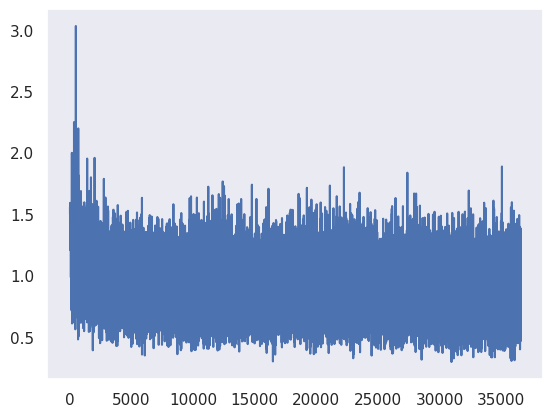

In [89]:
plt.plot(train_losses)

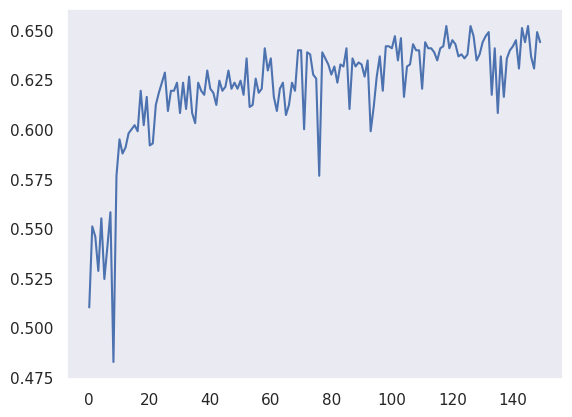

In [90]:
plt.plot(test_accuracy)

In [91]:
model.to('cpu')
best_model_path = f'{model_path_prefix}{best_epoch}epoch.pt'
print(best_model_path)
best_model = M13(config=model_config,
           n_input=1, n_output=len(labels))
best_model.load_state_dict(torch.load(best_model_path))
best_model.to(device)

metrics_best, confusion_matrix_best = report_metrics(
    best_model, labels=labels, device=device)
best_model.to('cpu')
pprint(metrics_best.compute())
confusion_matrix_best.compute()

../models_cremad4/cremad_label4_m13ser_best_119epoch.pt
Correct: 639/976 (0.6547)
{'acc_detail': tensor([0.7441, 0.6389, 0.7126, 0.5198], device='cuda:0'),
 'acc_unweighted': tensor(0.6539, device='cuda:0'),
 'acc_weighted': tensor(0.6547, device='cuda:0'),
 'f1s_detail': tensor([0.7470, 0.5786, 0.7269, 0.5563], device='cuda:0'),
 'f1s_unweighted': tensor(0.6522, device='cuda:0'),
 'f1s_weighted': tensor(0.6553, device='cuda:0'),
 'precision_detail': tensor([0.7500, 0.5287, 0.7418, 0.5982], device='cuda:0'),
 'recall_detail': tensor([0.7441, 0.6389, 0.7126, 0.5198], device='cuda:0'),
 'rocauc': tensor(0.8717, device='cuda:0'),
 'rocauc_detail': tensor([0.9180, 0.8477, 0.9081, 0.8130], device='cuda:0'),
 'uar': tensor(0.6539, device='cuda:0'),
 'wap': tensor(0.6597, device='cuda:0')}


tensor([[189,  15,   5,  45],
        [  7, 138,  40,  31],
        [  5,  56, 181,  12],
        [ 51,  52,  18, 131]], device='cuda:0')

In [92]:
checkpoint_path = '../models_cremad4/cremad4_m13ser_150epoch.ckpt'
torch.save({
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': train_losses[-1],
    'best_epoch': best_epoch,
    'best_accuracy': best_accuracy,
    'train_losses': train_losses,
    'test_accuracy': test_accuracy,
    'log_interval': log_interval,
    }, checkpoint_path)

In [93]:
start_epoch = 151
n_epoch = 50

optimizer = optim.RAdam(model.parameters(), lr=0.000002)
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=0.01, pct_start=0.3,
    steps_per_epoch=len(train_loader), epochs=n_epoch)
log_interval = 40
pbar_update = 1 / (len(train_loader) + len(test_loader))
model.to(device)
with tqdm(total=n_epoch) as pbar:
    for epoch in range(start_epoch, start_epoch+n_epoch):
        train(model, epoch, log_interval, train_losses)
        acc = test(model, epoch)
        test_accuracy += [acc]
        if acc > best_accuracy:
            best_accuracy = acc
            best_epoch = epoch
            bmodel_path = f'{model_path_prefix}{epoch}epoch.pt'
            torch.save(model.state_dict(), bmodel_path)
            print(f'saved model: {bmodel_path}')
        scheduler.step()

  0%|                               | 0.003278688524590164/50 [00:00<1:38:28, 118.18s/it]

Train Epoch: 151 [0/3918 (0%)]	Loss: 0.695381
Mem before-during-after: 91955712 4005831168 95485952


  0%|                                | 0.13442622950819672/50 [00:17<1:41:43, 122.41s/it]

Train Epoch: 151 [640/3918 (16%)]	Loss: 0.610502
Mem before-during-after: 96367616 4094278656 95548416


  1%|▏                               | 0.26557377049180286/50 [00:35<1:51:57, 135.06s/it]

Train Epoch: 151 [1280/3918 (33%)]	Loss: 0.971736
Mem before-during-after: 95810560 4092560896 95548416


  1%|▎                                  | 0.39672131147541/50 [00:51<1:45:48, 127.99s/it]

Train Epoch: 151 [1920/3918 (49%)]	Loss: 0.844396
Mem before-during-after: 95548416 4095140864 96367616


  1%|▎                                | 0.5278688524590167/50 [01:08<2:04:46, 151.33s/it]

Train Epoch: 151 [2560/3918 (66%)]	Loss: 0.599981
Mem before-during-after: 95810560 4091042816 95548416


  1%|▍                                | 0.6590163934426216/50 [01:27<2:02:46, 149.30s/it]

Train Epoch: 151 [3200/3918 (82%)]	Loss: 0.915961
Mem before-during-after: 95548416 3927029248 95690240


  2%|▌                                | 0.7901639344262266/50 [01:44<1:43:45, 126.52s/it]

Train Epoch: 151 [3840/3918 (98%)]	Loss: 0.693561
Mem before-during-after: 95810560 4094658048 95548416


  2%|▋                                 | 0.9999999999999944/50 [02:01<1:00:51, 74.51s/it]


Test Epoch: 151	Accuracy: 633/976 (65%)



  2%|▋                                 | 1.0032786885245846/50 [02:01<1:11:22, 87.40s/it]

Train Epoch: 152 [0/3918 (0%)]	Loss: 0.935359
Mem before-during-after: 95510016 4091786752 95509504


  2%|▋                                | 1.1344262295081895/50 [02:18<1:40:27, 123.34s/it]

Train Epoch: 152 [640/3918 (16%)]	Loss: 0.788895
Mem before-during-after: 95810560 4094658048 95548416


  3%|▊                                | 1.2655737704917944/50 [02:34<1:41:53, 125.45s/it]

Train Epoch: 152 [1280/3918 (33%)]	Loss: 0.799338
Mem before-during-after: 95548416 4094583808 95810560


  3%|▉                                | 1.3967213114753994/50 [02:51<1:41:16, 125.03s/it]

Train Epoch: 152 [1920/3918 (49%)]	Loss: 1.031834
Mem before-during-after: 96367616 4094278656 95548416


  3%|█                                | 1.5278688524590043/50 [03:09<1:41:15, 125.34s/it]

Train Epoch: 152 [2560/3918 (66%)]	Loss: 0.519977
Mem before-during-after: 95810560 4092610048 95548416


  3%|█                                | 1.6590163934426092/50 [03:25<1:44:55, 130.23s/it]

Train Epoch: 152 [3200/3918 (82%)]	Loss: 0.593564
Mem before-during-after: 95548416 4094583808 95810560


  4%|█▏                               | 1.7901639344262141/50 [03:43<1:47:01, 133.20s/it]

Train Epoch: 152 [3840/3918 (98%)]	Loss: 0.773298
Mem before-during-after: 95857664 4094322688 96367616


  4%|█▍                                 | 1.999999999999982/50 [04:00<1:00:10, 75.22s/it]


Test Epoch: 152	Accuracy: 633/976 (65%)



  4%|█▎                                | 2.0032786885245724/50 [04:00<1:10:46, 88.48s/it]

Train Epoch: 153 [0/3918 (0%)]	Loss: 0.861253
Mem before-during-after: 95510016 4091786752 95509504


  4%|█▍                               | 2.1344262295081773/50 [04:18<1:44:10, 130.58s/it]

Train Epoch: 153 [640/3918 (16%)]	Loss: 1.051949
Mem before-during-after: 95548416 3926648320 95485952


  5%|█▌                                | 2.265573770491782/50 [04:36<1:44:30, 131.37s/it]

Train Epoch: 153 [1280/3918 (33%)]	Loss: 0.810814
Mem before-during-after: 95548416 4094583808 95810560


  5%|█▋                                | 2.396721311475387/50 [04:53<1:50:13, 138.94s/it]

Train Epoch: 153 [1920/3918 (49%)]	Loss: 1.239740
Mem before-during-after: 95810560 4093721600 95548416


  5%|█▋                                | 2.527868852458992/50 [05:11<1:58:28, 149.73s/it]

Train Epoch: 153 [2560/3918 (66%)]	Loss: 0.645173
Mem before-during-after: 95548416 4092486656 95810560


  5%|█▊                                | 2.659016393442597/50 [05:28<1:38:24, 124.73s/it]

Train Epoch: 153 [3200/3918 (82%)]	Loss: 0.849704
Mem before-during-after: 96367616 4094658048 95548416


  6%|█▉                                | 2.790163934426202/50 [05:47<1:55:58, 147.39s/it]

Train Epoch: 153 [3840/3918 (98%)]	Loss: 0.556578
Mem before-during-after: 95548416 4093043712 96367616


  6%|██▏                                 | 2.99999999999997/50 [06:04<1:00:00, 76.60s/it]


Test Epoch: 153	Accuracy: 636/976 (65%)



  6%|██▏                                 | 3.00327868852456/50 [06:04<1:10:13, 89.66s/it]

Train Epoch: 154 [0/3918 (0%)]	Loss: 0.767401
Mem before-during-after: 95486464 4092406272 96214528


  6%|██▏                               | 3.134426229508165/50 [06:21<1:56:48, 149.54s/it]

Train Epoch: 154 [640/3918 (16%)]	Loss: 0.842498
Mem before-during-after: 95548416 4093069824 95533056


  7%|██▎                                | 3.26557377049177/50 [06:41<2:08:54, 165.50s/it]

Train Epoch: 154 [1280/3918 (33%)]	Loss: 0.827995
Mem before-during-after: 95493632 4090695168 95548416


  7%|██▏                              | 3.3967213114753747/50 [07:00<1:54:48, 147.82s/it]

Train Epoch: 154 [1920/3918 (49%)]	Loss: 0.746325
Mem before-during-after: 95548416 4092486656 95810560


  7%|██▎                              | 3.5278688524589796/50 [07:18<1:41:15, 130.73s/it]

Train Epoch: 154 [2560/3918 (66%)]	Loss: 0.700330
Mem before-during-after: 95548416 4095140864 96367616


  7%|██▍                              | 3.6590163934425846/50 [07:35<1:39:29, 128.81s/it]

Train Epoch: 154 [3200/3918 (82%)]	Loss: 0.556010
Mem before-during-after: 95548416 4095140864 96367616


  8%|██▌                              | 3.7901639344261895/50 [07:54<1:47:29, 139.56s/it]

Train Epoch: 154 [3840/3918 (98%)]	Loss: 0.685915
Mem before-during-after: 95810560 4093568512 95548416


  8%|██▉                                 | 3.9999999999999574/50 [08:10<56:58, 74.31s/it]


Test Epoch: 154	Accuracy: 636/976 (65%)



  8%|██▋                               | 4.0032786885245475/50 [08:10<1:06:48, 87.16s/it]

Train Epoch: 155 [0/3918 (0%)]	Loss: 0.806656
Mem before-during-after: 95510016 4091786752 95509504


  8%|██▊                               | 4.134426229508152/50 [08:28<1:58:34, 155.11s/it]

Train Epoch: 155 [640/3918 (16%)]	Loss: 0.550653
Mem before-during-after: 95810560 4091471360 95548416


  9%|██▉                               | 4.265573770491757/50 [08:48<1:51:27, 146.22s/it]

Train Epoch: 155 [1280/3918 (33%)]	Loss: 0.716404
Mem before-during-after: 95490048 4095140864 96367616


  9%|██▉                               | 4.396721311475362/50 [09:06<1:58:24, 155.80s/it]

Train Epoch: 155 [1920/3918 (49%)]	Loss: 0.692891
Mem before-during-after: 96367616 4092028416 95548416


  9%|███                               | 4.527868852458967/50 [09:23<1:35:52, 126.51s/it]

Train Epoch: 155 [2560/3918 (66%)]	Loss: 1.036145
Mem before-during-after: 96367616 4094125568 95548416


  9%|███▏                              | 4.659016393442572/50 [09:42<1:56:12, 153.79s/it]

Train Epoch: 155 [3200/3918 (82%)]	Loss: 1.102804
Mem before-during-after: 96367616 4092028416 95548416


 10%|███▎                              | 4.790163934426177/50 [10:00<1:46:11, 140.93s/it]

Train Epoch: 155 [3840/3918 (98%)]	Loss: 0.971434
Mem before-during-after: 95548416 4093494784 95548416


 10%|███▋                                 | 4.999999999999945/50 [10:17<55:46, 74.36s/it]


Test Epoch: 155	Accuracy: 625/976 (64%)



 10%|███▌                               | 5.003278688524535/50 [10:17<1:05:58, 87.97s/it]

Train Epoch: 156 [0/3918 (0%)]	Loss: 0.875300
Mem before-during-after: 95510016 4091786752 95509504


 10%|███▌                               | 5.13442622950814/50 [10:35<1:54:19, 152.90s/it]

Train Epoch: 156 [640/3918 (16%)]	Loss: 0.668313
Mem before-during-after: 95810560 4091471360 95548416


 11%|███▌                              | 5.265573770491745/50 [10:52<1:36:32, 129.48s/it]

Train Epoch: 156 [1280/3918 (33%)]	Loss: 0.614770
Mem before-during-after: 95548416 4095140864 96367616


 11%|███▊                               | 5.39672131147535/50 [11:11<2:00:32, 162.14s/it]

Train Epoch: 156 [1920/3918 (49%)]	Loss: 0.944073
Mem before-during-after: 96367616 4092028416 95548416


 11%|███▊                              | 5.527868852458955/50 [11:30<1:53:59, 153.79s/it]

Train Epoch: 156 [2560/3918 (66%)]	Loss: 0.891851
Mem before-during-after: 95493632 4094275072 96367616


 11%|███▉                               | 5.65901639344256/50 [11:48<1:51:47, 151.27s/it]

Train Epoch: 156 [3200/3918 (82%)]	Loss: 0.867565
Mem before-during-after: 95548416 4093043712 96367616


 12%|███▉                              | 5.790163934426165/50 [12:05<1:31:13, 123.81s/it]

Train Epoch: 156 [3840/3918 (98%)]	Loss: 1.065169
Mem before-during-after: 96367616 4067037696 95515648


 12%|████▎                               | 5.9999999999999325/50 [12:21<56:24, 76.93s/it]


Test Epoch: 156	Accuracy: 634/976 (65%)



 12%|████▏                              | 6.003278688524523/50 [12:22<1:05:06, 88.79s/it]

Train Epoch: 157 [0/3918 (0%)]	Loss: 0.559315
Mem before-during-after: 95510016 4091786752 95509504


 12%|████                             | 6.1344262295081275/50 [12:38<1:43:48, 141.98s/it]

Train Epoch: 157 [640/3918 (16%)]	Loss: 1.110126
Mem before-during-after: 96214528 4095057920 96367616


 13%|████▏                            | 6.2655737704917325/50 [12:55<1:39:41, 136.77s/it]

Train Epoch: 157 [1280/3918 (33%)]	Loss: 0.797749
Mem before-during-after: 95810560 4094283264 96367616


 13%|████▎                             | 6.396721311475337/50 [13:13<1:33:47, 129.07s/it]

Train Epoch: 157 [1920/3918 (49%)]	Loss: 1.075406
Mem before-during-after: 96367616 4095093760 96367616


 13%|████▍                             | 6.527868852458942/50 [13:31<1:35:59, 132.48s/it]

Train Epoch: 157 [2560/3918 (66%)]	Loss: 1.133147
Mem before-during-after: 95548416 4095140864 96367616


 13%|████▌                             | 6.659016393442547/50 [13:48<1:30:22, 125.11s/it]

Train Epoch: 157 [3200/3918 (82%)]	Loss: 0.838010
Mem before-during-after: 95810560 4094100992 95548416


 14%|████▌                             | 6.790163934426152/50 [14:05<1:37:17, 135.09s/it]

Train Epoch: 157 [3840/3918 (98%)]	Loss: 0.893220
Mem before-during-after: 96216064 4095261696 95548416


 14%|█████▎                                | 6.99999999999992/50 [14:22<55:13, 77.06s/it]


Test Epoch: 157	Accuracy: 623/976 (64%)



 14%|█████                               | 7.00327868852451/50 [14:22<1:04:01, 89.34s/it]

Train Epoch: 158 [0/3918 (0%)]	Loss: 0.621128
Mem before-during-after: 95510016 4091786752 95509504


 14%|████▊                             | 7.134426229508115/50 [14:40<1:48:54, 152.43s/it]

Train Epoch: 158 [640/3918 (16%)]	Loss: 0.749067
Mem before-during-after: 95548416 4093043712 96367616


 15%|█████                              | 7.26557377049172/50 [14:58<1:32:19, 129.63s/it]

Train Epoch: 158 [1280/3918 (33%)]	Loss: 0.766772
Mem before-during-after: 95810560 4094658048 95548416


 15%|█████                             | 7.396721311475325/50 [15:15<1:48:00, 152.12s/it]

Train Epoch: 158 [1920/3918 (49%)]	Loss: 0.912555
Mem before-during-after: 95810560 4090510336 95548416


 15%|█████▎                             | 7.52786885245893/50 [15:33<1:27:42, 123.89s/it]

Train Epoch: 158 [2560/3918 (66%)]	Loss: 0.760304
Mem before-during-after: 95810560 4094125568 95548416


 15%|█████▏                            | 7.659016393442535/50 [15:49<1:26:13, 122.19s/it]

Train Epoch: 158 [3200/3918 (82%)]	Loss: 0.768290
Mem before-during-after: 95548416 4095140864 96367616


 16%|█████▍                             | 7.79016393442614/50 [16:06<1:29:52, 127.76s/it]

Train Epoch: 158 [3840/3918 (98%)]	Loss: 0.859024
Mem before-during-after: 95548416 4095140864 96367616


 16%|█████▉                               | 7.999999999999908/50 [16:22<51:18, 73.29s/it]


Test Epoch: 158	Accuracy: 634/976 (65%)



 16%|█████▌                             | 8.003278688524498/50 [16:22<1:01:20, 87.63s/it]

Train Epoch: 159 [0/3918 (0%)]	Loss: 0.747324
Mem before-during-after: 95486464 4092406272 96214528


 16%|█████▌                            | 8.134426229508103/50 [16:41<1:34:40, 135.69s/it]

Train Epoch: 159 [640/3918 (16%)]	Loss: 1.247453
Mem before-during-after: 95548416 4093199872 95548416


 17%|█████▌                            | 8.265573770491708/50 [16:58<1:28:22, 127.04s/it]

Train Epoch: 159 [1280/3918 (33%)]	Loss: 0.825818
Mem before-during-after: 95548416 4093469696 95810560


 17%|█████▋                            | 8.396721311475313/50 [17:15<1:49:15, 157.58s/it]

Train Epoch: 159 [1920/3918 (49%)]	Loss: 0.798714
Mem before-during-after: 96585216 4093472256 95548416


 17%|█████▊                            | 8.527868852458917/50 [17:32<1:27:59, 127.31s/it]

Train Epoch: 159 [2560/3918 (66%)]	Loss: 0.703326
Mem before-during-after: 95548416 4095140864 96367616


 17%|█████▉                            | 8.659016393442522/50 [17:49<1:25:13, 123.70s/it]

Train Epoch: 159 [3200/3918 (82%)]	Loss: 0.716783
Mem before-during-after: 95548416 4095140864 96367616


 18%|█████▉                            | 8.790163934426127/50 [18:07<1:26:34, 126.06s/it]

Train Epoch: 159 [3840/3918 (98%)]	Loss: 1.188807
Mem before-during-after: 96367616 4094658048 95548416


 18%|██████▋                              | 8.999999999999895/50 [18:23<49:49, 72.91s/it]


Test Epoch: 159	Accuracy: 638/976 (65%)



 18%|██████▋                              | 9.003278688524485/50 [18:23<58:27, 85.56s/it]

Train Epoch: 160 [0/3918 (0%)]	Loss: 0.911093
Mem before-during-after: 95486464 4053947904 95491072


 18%|██████▍                            | 9.13442622950809/50 [18:41<1:29:13, 131.00s/it]

Train Epoch: 160 [640/3918 (16%)]	Loss: 0.535634
Mem before-during-after: 95548416 4094583808 95810560


 19%|██████▎                           | 9.265573770491695/50 [18:58<1:41:13, 149.10s/it]

Train Epoch: 160 [1280/3918 (33%)]	Loss: 0.661176
Mem before-during-after: 95493632 4092564992 95810560


 19%|██████▊                             | 9.3967213114753/50 [19:15<1:30:14, 133.34s/it]

Train Epoch: 160 [1920/3918 (49%)]	Loss: 0.844711
Mem before-during-after: 95548416 4093469696 95810560


 19%|██████▍                           | 9.527868852458905/50 [19:34<1:50:37, 164.00s/it]

Train Epoch: 160 [2560/3918 (66%)]	Loss: 0.828992
Mem before-during-after: 95655936 4093582848 95548416


 19%|██████▊                            | 9.65901639344251/50 [19:51<1:24:30, 125.70s/it]

Train Epoch: 160 [3200/3918 (82%)]	Loss: 0.867137
Mem before-during-after: 95810560 4093568512 95548416


 20%|██████▋                           | 9.790163934426115/50 [20:09<1:42:28, 152.91s/it]

Train Epoch: 160 [3840/3918 (98%)]	Loss: 0.795776
Mem before-during-after: 95810560 4090512896 95548416


 20%|███████▍                             | 9.999999999999883/50 [20:26<51:59, 78.00s/it]


Test Epoch: 160	Accuracy: 625/976 (64%)



 20%|██████▊                           | 10.003278688524473/50 [20:26<1:01:14, 91.87s/it]

Train Epoch: 161 [0/3918 (0%)]	Loss: 1.049142
Mem before-during-after: 95486464 4092406272 96214528


 20%|██████▋                          | 10.134426229508078/50 [20:43<1:23:48, 126.13s/it]

Train Epoch: 161 [640/3918 (16%)]	Loss: 0.748613
Mem before-during-after: 95810560 4094658048 95548416


 21%|██████▊                          | 10.265573770491683/50 [21:00<1:26:43, 130.96s/it]

Train Epoch: 161 [1280/3918 (33%)]	Loss: 0.789295
Mem before-during-after: 95548416 4095140864 96367616


 21%|██████▊                          | 10.396721311475288/50 [21:16<1:29:35, 135.73s/it]

Train Epoch: 161 [1920/3918 (49%)]	Loss: 0.700135
Mem before-during-after: 95810560 4094658048 95548416


 21%|██████▉                          | 10.527868852458893/50 [21:33<1:26:08, 130.94s/it]

Train Epoch: 161 [2560/3918 (66%)]	Loss: 0.973451
Mem before-during-after: 95810560 4093011456 95548416


 21%|███████                          | 10.659016393442498/50 [21:51<1:23:39, 127.60s/it]

Train Epoch: 161 [3200/3918 (82%)]	Loss: 0.643012
Mem before-during-after: 95810560 4094125568 95548416


 22%|███████                          | 10.790163934426102/50 [22:09<1:38:20, 150.48s/it]

Train Epoch: 161 [3840/3918 (98%)]	Loss: 0.705036
Mem before-during-after: 95548416 4093043712 96367616


 22%|████████▏                            | 10.99999999999987/50 [22:25<49:51, 76.71s/it]


Test Epoch: 161	Accuracy: 616/976 (63%)



 22%|████████▏                            | 11.00327868852446/50 [22:26<58:10, 89.51s/it]

Train Epoch: 162 [0/3918 (0%)]	Loss: 0.539386
Mem before-during-after: 95486464 4092406272 96214528


 22%|███████▎                         | 11.134426229508065/50 [22:43<1:27:01, 134.35s/it]

Train Epoch: 162 [640/3918 (16%)]	Loss: 0.962729
Mem before-during-after: 96367616 3965811200 96214528


 23%|███████▋                          | 11.26557377049167/50 [22:59<1:23:30, 129.36s/it]

Train Epoch: 162 [1280/3918 (33%)]	Loss: 0.640927
Mem before-during-after: 96367616 4094658048 95548416


 23%|███████▌                         | 11.396721311475275/50 [23:18<1:34:46, 147.31s/it]

Train Epoch: 162 [1920/3918 (49%)]	Loss: 0.666007
Mem before-during-after: 96367616 4091624448 95548416


 23%|███████▊                          | 11.52786885245888/50 [23:36<1:19:38, 124.21s/it]

Train Epoch: 162 [2560/3918 (66%)]	Loss: 0.847084
Mem before-during-after: 95810560 4094658048 95548416


 23%|███████▋                         | 11.659016393442485/50 [23:53<1:20:45, 126.39s/it]

Train Epoch: 162 [3200/3918 (82%)]	Loss: 0.821179
Mem before-during-after: 95810560 4094278656 95548416


 24%|████████                          | 11.79016393442609/50 [24:12<1:19:50, 125.37s/it]

Train Epoch: 162 [3840/3918 (98%)]	Loss: 1.058495
Mem before-during-after: 96367616 4094658048 95548416


 24%|████████▋                           | 11.999999999999858/50 [24:28<49:43, 78.51s/it]


Test Epoch: 162	Accuracy: 630/976 (64%)



 24%|████████▋                           | 12.003278688524448/50 [24:29<57:10, 90.29s/it]

Train Epoch: 163 [0/3918 (0%)]	Loss: 0.658889
Mem before-during-after: 95510016 4091786752 95509504


 24%|████████                         | 12.134426229508053/50 [24:46<1:28:17, 139.89s/it]

Train Epoch: 163 [640/3918 (16%)]	Loss: 0.930339
Mem before-during-after: 95493632 4094173184 95527936


 25%|████████                         | 12.265573770491658/50 [25:04<1:34:31, 150.29s/it]

Train Epoch: 163 [1280/3918 (33%)]	Loss: 0.771355
Mem before-during-after: 95548416 4093043712 96367616


 25%|████████▏                        | 12.396721311475263/50 [25:22<1:25:01, 135.68s/it]

Train Epoch: 163 [1920/3918 (49%)]	Loss: 0.574486
Mem before-during-after: 96367616 4093721600 95548416


 25%|████████▎                        | 12.527868852458868/50 [25:41<1:33:30, 149.72s/it]

Train Epoch: 163 [2560/3918 (66%)]	Loss: 0.857531
Mem before-during-after: 95548416 4093043712 96367616


 25%|████████▎                        | 12.659016393442473/50 [25:58<1:16:35, 123.07s/it]

Train Epoch: 163 [3200/3918 (82%)]	Loss: 0.709119
Mem before-during-after: 96367616 4094658048 95548416


 26%|████████▍                        | 12.790163934426078/50 [26:14<1:16:57, 124.09s/it]

Train Epoch: 163 [3840/3918 (98%)]	Loss: 0.754470
Mem before-during-after: 96367616 4094658048 95548416


 26%|█████████▎                          | 12.999999999999845/50 [26:30<45:54, 74.44s/it]


Test Epoch: 163	Accuracy: 638/976 (65%)



 26%|█████████▎                          | 13.003278688524436/50 [26:31<53:44, 87.15s/it]

Train Epoch: 164 [0/3918 (0%)]	Loss: 0.729742
Mem before-during-after: 95510016 4091786752 95509504


 26%|████████▉                         | 13.13442622950804/50 [26:48<1:32:27, 150.47s/it]

Train Epoch: 164 [640/3918 (16%)]	Loss: 0.722453
Mem before-during-after: 95548416 4092486656 95810560


 27%|████████▊                        | 13.265573770491645/50 [27:07<1:29:29, 146.18s/it]

Train Epoch: 164 [1280/3918 (33%)]	Loss: 0.442868
Mem before-during-after: 95810560 4094278656 95548416


 27%|█████████                         | 13.39672131147525/50 [27:24<1:19:16, 129.93s/it]

Train Epoch: 164 [1920/3918 (49%)]	Loss: 0.561189
Mem before-during-after: 95548416 4094583808 95810560


 27%|████████▉                        | 13.527868852458855/50 [27:42<1:33:03, 153.08s/it]

Train Epoch: 164 [2560/3918 (66%)]	Loss: 0.887325
Mem before-during-after: 96367616 4092560896 95548416


 27%|█████████▎                        | 13.65901639344246/50 [28:01<1:16:28, 126.27s/it]

Train Epoch: 164 [3200/3918 (82%)]	Loss: 0.593360
Mem before-during-after: 96367616 4094125568 95548416


 28%|█████████                        | 13.790163934426065/50 [28:19<1:37:50, 162.12s/it]

Train Epoch: 164 [3840/3918 (98%)]	Loss: 0.415430
Mem before-during-after: 95515648 4094275072 96367616


 28%|██████████                          | 13.999999999999833/50 [28:36<45:40, 76.12s/it]


Test Epoch: 164	Accuracy: 638/976 (65%)



 28%|██████████                          | 14.003278688524423/50 [28:36<53:36, 89.35s/it]

Train Epoch: 165 [0/3918 (0%)]	Loss: 0.616842
Mem before-during-after: 95486464 4092406272 96214528


 28%|█████████▎                       | 14.134426229508028/50 [28:54<1:31:11, 152.56s/it]

Train Epoch: 165 [640/3918 (16%)]	Loss: 0.822289
Mem before-during-after: 96367616 4092560896 95548416


 29%|█████████▍                       | 14.265573770491633/50 [29:12<1:18:53, 132.46s/it]

Train Epoch: 165 [1280/3918 (33%)]	Loss: 0.664339
Mem before-during-after: 95810560 4090914304 95548416


 29%|█████████▌                       | 14.396721311475238/50 [29:29<1:20:18, 135.33s/it]

Train Epoch: 165 [1920/3918 (49%)]	Loss: 0.580002
Mem before-during-after: 96214528 4095665664 95548416


 29%|█████████▌                       | 14.527868852458843/50 [29:49<1:20:28, 136.11s/it]

Train Epoch: 165 [2560/3918 (66%)]	Loss: 1.062589
Mem before-during-after: 95810560 4093468160 95548416


 29%|█████████▋                       | 14.659016393442448/50 [30:07<1:16:38, 130.12s/it]

Train Epoch: 165 [3200/3918 (82%)]	Loss: 0.828472
Mem before-during-after: 95548416 4093469696 95810560


 30%|█████████▊                       | 14.790163934426053/50 [30:25<1:28:35, 150.96s/it]

Train Epoch: 165 [3840/3918 (98%)]	Loss: 0.926984
Mem before-during-after: 95548416 4092486656 95810560


 30%|███████████                          | 14.99999999999982/50 [30:42<43:53, 75.25s/it]


Test Epoch: 165	Accuracy: 634/976 (65%)



 30%|███████████                          | 15.00327868852441/50 [30:42<50:58, 87.39s/it]

Train Epoch: 166 [0/3918 (0%)]	Loss: 0.774213
Mem before-during-after: 95486464 4092406272 96214528


 30%|█████████▉                       | 15.134426229508016/50 [30:59<1:12:32, 124.83s/it]

Train Epoch: 166 [640/3918 (16%)]	Loss: 1.221154
Mem before-during-after: 96367616 4036032512 95485952


 31%|██████████▍                       | 15.26557377049162/50 [31:16<1:10:43, 122.16s/it]

Train Epoch: 166 [1280/3918 (33%)]	Loss: 0.840251
Mem before-during-after: 96367616 4094125568 95548416


 31%|██████████▏                      | 15.396721311475225/50 [31:34<1:19:44, 138.26s/it]

Train Epoch: 166 [1920/3918 (49%)]	Loss: 0.969546
Mem before-during-after: 96367616 4094125568 95548416


 31%|██████████▌                       | 15.52786885245883/50 [31:51<1:16:50, 133.74s/it]

Train Epoch: 166 [2560/3918 (66%)]	Loss: 1.207609
Mem before-during-after: 95515648 4096372224 96367616


 31%|██████████▎                      | 15.659016393442435/50 [32:08<1:11:04, 124.19s/it]

Train Epoch: 166 [3200/3918 (82%)]	Loss: 0.897211
Mem before-during-after: 95548416 4095140864 96367616


 32%|██████████▋                       | 15.79016393442604/50 [32:26<1:14:39, 130.95s/it]

Train Epoch: 166 [3840/3918 (98%)]	Loss: 0.722242
Mem before-during-after: 95548416 3965185024 95485952


 32%|███████████▌                        | 15.999999999999808/50 [32:43<49:05, 86.65s/it]


Test Epoch: 166	Accuracy: 642/976 (66%)

saved model: ../models_cremad4/cremad_label4_m13ser_best_166epoch.pt


 32%|███████████▊                         | 16.0032786885244/50 [32:43<57:02, 100.68s/it]

Train Epoch: 167 [0/3918 (0%)]	Loss: 0.799764
Mem before-during-after: 96254464 4092453376 95485952


 32%|██████████▋                      | 16.134426229508076/50 [33:00<1:13:02, 129.42s/it]

Train Epoch: 167 [640/3918 (16%)]	Loss: 0.814852
Mem before-during-after: 95485952 4092719616 95485952


 33%|██████████▋                      | 16.265573770491752/50 [33:17<1:21:53, 145.66s/it]

Train Epoch: 167 [1280/3918 (33%)]	Loss: 0.807600
Mem before-during-after: 95485952 4092607488 95548416


 33%|██████████▊                      | 16.396721311475428/50 [33:35<1:09:31, 124.13s/it]

Train Epoch: 167 [1920/3918 (49%)]	Loss: 0.790419
Mem before-during-after: 95810560 4092610048 95548416


 33%|██████████▉                      | 16.527868852459104/50 [33:52<1:24:27, 151.40s/it]

Train Epoch: 167 [2560/3918 (66%)]	Loss: 1.110527
Mem before-during-after: 95548416 4092486656 95810560


 33%|███████████▎                      | 16.65901639344278/50 [34:10<1:08:46, 123.76s/it]

Train Epoch: 167 [3200/3918 (82%)]	Loss: 0.738394
Mem before-during-after: 95548416 4095140864 96367616


 34%|███████████                      | 16.790163934426456/50 [34:28<1:26:10, 155.68s/it]

Train Epoch: 167 [3840/3918 (98%)]	Loss: 0.887062
Mem before-during-after: 96367616 4092560896 95548416


 34%|████████████▏                       | 17.000000000000338/50 [34:44<40:12, 73.09s/it]


Test Epoch: 167	Accuracy: 638/976 (65%)



 34%|████████████▌                        | 17.00327868852493/50 [34:44<47:02, 85.54s/it]

Train Epoch: 168 [0/3918 (0%)]	Loss: 1.005967
Mem before-during-after: 96254464 4092453376 95485952


 34%|███████████▎                     | 17.134426229508605/50 [35:02<1:21:58, 149.66s/it]

Train Epoch: 168 [640/3918 (16%)]	Loss: 0.839836
Mem before-during-after: 95548416 4091929600 95810560


 35%|███████████▋                      | 17.26557377049228/50 [35:21<1:07:57, 124.56s/it]

Train Epoch: 168 [1280/3918 (33%)]	Loss: 0.748379
Mem before-during-after: 95548416 4094583808 95810560


 35%|███████████▍                     | 17.396721311475957/50 [35:40<1:24:24, 155.33s/it]

Train Epoch: 168 [1920/3918 (49%)]	Loss: 0.925817
Mem before-during-after: 95810560 4092003840 95548416


 35%|███████████▌                     | 17.527868852459633/50 [35:58<1:07:15, 124.28s/it]

Train Epoch: 168 [2560/3918 (66%)]	Loss: 0.799106
Mem before-during-after: 95810560 4093139968 95548416


 35%|████████████                      | 17.65901639344331/50 [36:14<1:06:31, 123.43s/it]

Train Epoch: 168 [3200/3918 (82%)]	Loss: 0.805073
Mem before-during-after: 95548416 4095140864 96367616


 36%|███████████▋                     | 17.790163934426985/50 [36:31<1:07:13, 125.22s/it]

Train Epoch: 168 [3840/3918 (98%)]	Loss: 0.683514
Mem before-during-after: 96367616 4094125568 95548416


 36%|████████████▉                       | 18.000000000000867/50 [36:47<42:50, 80.34s/it]


Test Epoch: 168	Accuracy: 635/976 (65%)



 36%|█████████████▎                       | 18.00327868852546/50 [36:48<49:36, 93.04s/it]

Train Epoch: 169 [0/3918 (0%)]	Loss: 0.557855
Mem before-during-after: 95510016 4091786752 95509504


 36%|███████████▉                     | 18.134426229509135/50 [37:05<1:07:02, 126.23s/it]

Train Epoch: 169 [640/3918 (16%)]	Loss: 1.121404
Mem before-during-after: 95548416 4095140864 96367616


 37%|████████████▍                     | 18.26557377049281/50 [37:22<1:19:23, 150.12s/it]

Train Epoch: 169 [1280/3918 (33%)]	Loss: 0.750893
Mem before-during-after: 95548416 4093043712 96367616


 37%|████████████▏                    | 18.396721311476487/50 [37:39<1:09:45, 132.45s/it]

Train Epoch: 169 [1920/3918 (49%)]	Loss: 0.928122
Mem before-during-after: 95548416 4094583808 95810560


 37%|████████████▏                    | 18.527868852460163/50 [37:57<1:17:30, 147.78s/it]

Train Epoch: 169 [2560/3918 (66%)]	Loss: 0.930946
Mem before-during-after: 95548416 4091929600 95810560


 37%|████████████▋                     | 18.65901639344384/50 [38:14<1:19:19, 151.86s/it]

Train Epoch: 169 [3200/3918 (82%)]	Loss: 0.764963
Mem before-during-after: 95548416 4092185600 96367616


 38%|████████████▍                    | 18.790163934427515/50 [38:33<1:19:23, 152.64s/it]

Train Epoch: 169 [3840/3918 (98%)]	Loss: 0.697506
Mem before-during-after: 96367616 4092028416 95548416


 38%|█████████████▋                      | 19.000000000001396/50 [38:50<41:08, 79.63s/it]


Test Epoch: 169	Accuracy: 632/976 (64%)



 38%|█████████████▋                      | 19.003278688525988/50 [38:50<46:46, 90.55s/it]

Train Epoch: 170 [0/3918 (0%)]	Loss: 0.790012
Mem before-during-after: 95510016 4091786752 95509504


 38%|████████████▋                    | 19.134426229509664/50 [39:09<1:17:46, 151.18s/it]

Train Epoch: 170 [640/3918 (16%)]	Loss: 0.723332
Mem before-during-after: 95548416 4092486656 95810560


 39%|█████████████                     | 19.26557377049334/50 [39:28<1:07:55, 132.59s/it]

Train Epoch: 170 [1280/3918 (33%)]	Loss: 0.864292
Mem before-during-after: 95810560 4092868096 95810560


 39%|████████████▊                    | 19.396721311477016/50 [39:44<1:03:02, 123.61s/it]

Train Epoch: 170 [1920/3918 (49%)]	Loss: 0.650303
Mem before-during-after: 96367616 4094125568 95548416


 39%|████████████▉                    | 19.527868852460692/50 [40:03<1:08:18, 134.51s/it]

Train Epoch: 170 [2560/3918 (66%)]	Loss: 0.331519
Mem before-during-after: 95810560 4094278656 95548416


 39%|████████████▉                    | 19.659016393444368/50 [40:22<1:13:10, 144.71s/it]

Train Epoch: 170 [3200/3918 (82%)]	Loss: 0.850666
Mem before-during-after: 95810560 4093468160 95548416


 40%|█████████████                    | 19.790163934428044/50 [40:39<1:03:15, 125.64s/it]

Train Epoch: 170 [3840/3918 (98%)]	Loss: 1.163234
Mem before-during-after: 95548416 4095140864 96367616


 40%|██████████████▍                     | 20.000000000001926/50 [40:55<37:11, 74.37s/it]


Test Epoch: 170	Accuracy: 636/976 (65%)



 40%|██████████████▍                     | 20.003278688526517/50 [40:55<43:23, 86.79s/it]

Train Epoch: 171 [0/3918 (0%)]	Loss: 0.905652
Mem before-during-after: 95486464 4092406272 96214528


 40%|█████████████▎                   | 20.134426229510193/50 [41:11<1:01:24, 123.38s/it]

Train Epoch: 171 [640/3918 (16%)]	Loss: 0.603540
Mem before-during-after: 96367616 4094278656 95548416


 41%|█████████████▊                    | 20.26557377049387/50 [41:29<1:14:48, 150.94s/it]

Train Epoch: 171 [1280/3918 (33%)]	Loss: 0.779690
Mem before-during-after: 95490048 4093043712 96367616


 41%|█████████████▍                   | 20.396721311477545/50 [41:46<1:01:03, 123.75s/it]

Train Epoch: 171 [1920/3918 (49%)]	Loss: 1.010652
Mem before-during-after: 95548416 4095140864 96367616


 41%|█████████████▉                    | 20.52786885246122/50 [42:03<1:12:56, 148.50s/it]

Train Epoch: 171 [2560/3918 (66%)]	Loss: 0.989515
Mem before-during-after: 95810560 4092560896 95548416


 41%|█████████████▋                   | 20.659016393444897/50 [42:22<1:14:58, 153.31s/it]

Train Epoch: 171 [3200/3918 (82%)]	Loss: 0.894964
Mem before-during-after: 95810560 4093011456 95548416


 42%|█████████████▋                   | 20.790163934428573/50 [42:40<1:06:30, 136.62s/it]

Train Epoch: 171 [3840/3918 (98%)]	Loss: 0.770496
Mem before-during-after: 95548416 4095140864 96367616


 42%|███████████████                     | 21.000000000002455/50 [42:57<35:54, 74.28s/it]


Test Epoch: 171	Accuracy: 624/976 (64%)



 42%|███████████████                     | 21.003278688527047/50 [42:57<42:22, 87.70s/it]

Train Epoch: 172 [0/3918 (0%)]	Loss: 0.599266
Mem before-during-after: 95510016 4091786752 95509504


 42%|██████████████▊                    | 21.134426229510723/50 [43:14<59:12, 123.08s/it]

Train Epoch: 172 [640/3918 (16%)]	Loss: 0.697275
Mem before-during-after: 95548416 4094282752 96367616


 43%|███████████████▋                     | 21.2655737704944/50 [43:31<59:00, 123.21s/it]

Train Epoch: 172 [1280/3918 (33%)]	Loss: 0.912325
Mem before-during-after: 95810560 4094658048 95548416


 43%|██████████████                   | 21.396721311478075/50 [43:48<1:00:12, 126.30s/it]

Train Epoch: 172 [1920/3918 (49%)]	Loss: 0.690471
Mem before-during-after: 96375296 4094653952 95810560


 43%|███████████████▌                    | 21.52786885246175/50 [44:04<58:43, 123.74s/it]

Train Epoch: 172 [2560/3918 (66%)]	Loss: 0.712385
Mem before-during-after: 95548416 4095140864 96367616


 43%|██████████████▎                  | 21.659016393445427/50 [44:23<1:16:30, 161.97s/it]

Train Epoch: 172 [3200/3918 (82%)]	Loss: 1.252753
Mem before-during-after: 95548416 4092486656 95810560


 44%|██████████████▍                  | 21.790163934429103/50 [44:41<1:03:53, 135.91s/it]

Train Epoch: 172 [3840/3918 (98%)]	Loss: 0.686316
Mem before-during-after: 96367616 4094658048 95548416


 44%|███████████████▊                    | 22.000000000002984/50 [44:57<34:54, 74.82s/it]


Test Epoch: 172	Accuracy: 642/976 (66%)



 44%|███████████████▊                    | 22.003278688527576/50 [44:58<40:33, 86.92s/it]

Train Epoch: 173 [0/3918 (0%)]	Loss: 0.937010
Mem before-during-after: 95510016 3970482176 96214528


 44%|███████████████▍                   | 22.134426229511252/50 [45:16<58:36, 126.19s/it]

Train Epoch: 173 [640/3918 (16%)]	Loss: 0.874065
Mem before-during-after: 95810560 4094658048 95548416


 45%|███████████████▌                   | 22.265573770494928/50 [45:33<58:54, 127.43s/it]

Train Epoch: 173 [1280/3918 (33%)]	Loss: 0.953550
Mem before-during-after: 95810560 4093543936 95548416


 45%|██████████████▊                  | 22.396721311478604/50 [45:51<1:14:12, 161.31s/it]

Train Epoch: 173 [1920/3918 (49%)]	Loss: 1.016745
Mem before-during-after: 96222208 4093818880 95810560


 45%|███████████████▎                  | 22.52786885246228/50 [46:10<1:17:37, 169.52s/it]

Train Epoch: 173 [2560/3918 (66%)]	Loss: 0.912578
Mem before-during-after: 96487424 4094026752 95548416


 45%|██████████████▉                  | 22.659016393445956/50 [46:27<1:05:26, 143.62s/it]

Train Epoch: 173 [3200/3918 (82%)]	Loss: 0.594469
Mem before-during-after: 95810560 4094283264 96367616


 46%|███████████████                  | 22.790163934429632/50 [46:45<1:09:52, 154.07s/it]

Train Epoch: 173 [3840/3918 (98%)]	Loss: 0.941386
Mem before-during-after: 95548416 4093043712 96367616


 46%|████████████████▌                   | 23.000000000003514/50 [47:02<33:07, 73.62s/it]


Test Epoch: 173	Accuracy: 638/976 (65%)



 46%|████████████████▌                   | 23.003278688528106/50 [47:03<39:06, 86.94s/it]

Train Epoch: 174 [0/3918 (0%)]	Loss: 0.661689
Mem before-during-after: 95486464 4092406272 96214528


 46%|████████████████▋                   | 23.13442622951178/50 [47:19<56:25, 126.02s/it]

Train Epoch: 174 [640/3918 (16%)]	Loss: 0.699817
Mem before-during-after: 96367616 4092996608 96367616


 47%|███████████████▎                 | 23.265573770495457/50 [47:37<1:01:17, 137.54s/it]

Train Epoch: 174 [1280/3918 (33%)]	Loss: 1.039862
Mem before-during-after: 95810560 4092607488 95548416


 47%|████████████████▍                  | 23.396721311479133/50 [47:54<56:25, 127.28s/it]

Train Epoch: 174 [1920/3918 (49%)]	Loss: 0.502737
Mem before-during-after: 95810560 4094125568 95548416


 47%|████████████████▉                   | 23.52786885246281/50 [48:11<54:53, 124.43s/it]

Train Epoch: 174 [2560/3918 (66%)]	Loss: 0.719585
Mem before-during-after: 96367616 4094125568 95548416


 47%|████████████████▌                  | 23.659016393446485/50 [48:29<56:28, 128.66s/it]

Train Epoch: 174 [3200/3918 (82%)]	Loss: 0.765139
Mem before-during-after: 95548416 4095140864 96367616


 48%|█████████████████▏                  | 23.79016393443016/50 [48:47<56:03, 128.32s/it]

Train Epoch: 174 [3840/3918 (98%)]	Loss: 0.642941
Mem before-during-after: 95548416 4092912640 95810560


 48%|█████████████████▎                  | 24.000000000004043/50 [49:03<32:17, 74.51s/it]


Test Epoch: 174	Accuracy: 633/976 (65%)



 48%|█████████████████▎                  | 24.003278688528635/50 [49:04<38:04, 87.88s/it]

Train Epoch: 175 [0/3918 (0%)]	Loss: 0.784278
Mem before-during-after: 96254464 4092453376 95485952


 48%|█████████████████▍                  | 24.13442622951231/50 [49:20<53:28, 124.05s/it]

Train Epoch: 175 [640/3918 (16%)]	Loss: 0.987530
Mem before-during-after: 96367616 4094658048 95548416


 49%|████████████████                 | 24.265573770495987/50 [49:38<1:04:27, 150.30s/it]

Train Epoch: 175 [1280/3918 (33%)]	Loss: 0.673125
Mem before-during-after: 96367616 4092560896 95548416


 49%|████████████████                 | 24.396721311479663/50 [49:55<1:03:34, 148.98s/it]

Train Epoch: 175 [1920/3918 (49%)]	Loss: 0.808295
Mem before-during-after: 95548416 4091372544 95810560


 49%|████████████████▋                 | 24.52786885246334/50 [50:14<1:05:10, 153.52s/it]

Train Epoch: 175 [2560/3918 (66%)]	Loss: 0.775469
Mem before-during-after: 95548416 3926768640 95493632


 49%|█████████████████▎                 | 24.659016393447015/50 [50:31<52:37, 124.61s/it]

Train Epoch: 175 [3200/3918 (82%)]	Loss: 1.094604
Mem before-during-after: 95548416 4094026752 95810560


 50%|█████████████████▊                  | 24.79016393443069/50 [50:51<58:16, 138.70s/it]

Train Epoch: 175 [3840/3918 (98%)]	Loss: 0.876772
Mem before-during-after: 96367616 4063957504 95515648


 50%|██████████████████                  | 25.000000000004572/50 [51:07<35:39, 85.59s/it]


Test Epoch: 175	Accuracy: 639/976 (65%)



 50%|██████████████████                  | 25.003278688529164/50 [51:07<39:49, 95.60s/it]

Train Epoch: 176 [0/3918 (0%)]	Loss: 0.964589
Mem before-during-after: 95510016 4091786752 95509504


 50%|██████████████████                  | 25.13442622951284/50 [51:24<51:01, 123.14s/it]

Train Epoch: 176 [640/3918 (16%)]	Loss: 0.592952
Mem before-during-after: 95810560 4094100992 95548416


 51%|████████████████▋                | 25.265573770496516/50 [51:41<1:06:50, 162.13s/it]

Train Epoch: 176 [1280/3918 (33%)]	Loss: 1.238161
Mem before-during-after: 95485952 4093533696 95810560


 51%|█████████████████▊                 | 25.396721311480192/50 [51:57<51:43, 126.13s/it]

Train Epoch: 176 [1920/3918 (49%)]	Loss: 0.687240
Mem before-during-after: 95548416 4094583808 95810560


 51%|█████████████████▊                 | 25.527868852463868/50 [52:15<58:55, 144.46s/it]

Train Epoch: 176 [2560/3918 (66%)]	Loss: 0.810849
Mem before-during-after: 95548416 4092486656 95810560


 51%|████████████████▉                | 25.659016393447544/50 [52:33<1:01:31, 151.66s/it]

Train Epoch: 176 [3200/3918 (82%)]	Loss: 0.667770
Mem before-during-after: 95810560 4091471360 95548416


 52%|██████████████████▌                 | 25.79016393443122/50 [52:51<55:18, 137.07s/it]

Train Epoch: 176 [3840/3918 (98%)]	Loss: 0.537873
Mem before-during-after: 95493632 4095004672 95810560


 52%|███████████████████▊                  | 26.0000000000051/50 [53:07<28:42, 71.77s/it]


Test Epoch: 176	Accuracy: 632/976 (64%)



 52%|██████████████████▋                 | 26.003278688529694/50 [53:08<34:36, 86.54s/it]

Train Epoch: 177 [0/3918 (0%)]	Loss: 0.742498
Mem before-during-after: 96254464 4092453376 95485952


 52%|██████████████████▊                 | 26.13442622951337/50 [53:26<55:15, 138.92s/it]

Train Epoch: 177 [640/3918 (16%)]	Loss: 0.938992
Mem before-during-after: 95857664 4092907520 95810560


 53%|█████████████████▎               | 26.265573770497046/50 [53:46<1:00:52, 153.88s/it]

Train Epoch: 177 [1280/3918 (33%)]	Loss: 0.632729
Mem before-during-after: 95810560 4091471360 95548416


 53%|███████████████████                 | 26.39672131148072/50 [54:05<56:42, 144.15s/it]

Train Epoch: 177 [1920/3918 (49%)]	Loss: 0.805616
Mem before-during-after: 95548416 4094583808 95810560


 53%|██████████████████▌                | 26.527868852464398/50 [54:22<58:47, 150.28s/it]

Train Epoch: 177 [2560/3918 (66%)]	Loss: 0.862953
Mem before-during-after: 96414720 4093036032 96367616


 53%|██████████████████▋                | 26.659016393448074/50 [54:41<57:56, 148.96s/it]

Train Epoch: 177 [3200/3918 (82%)]	Loss: 0.815929
Mem before-during-after: 95548416 4093043712 96367616


 54%|███████████████████▎                | 26.79016393443175/50 [54:57<57:33, 148.80s/it]

Train Epoch: 177 [3840/3918 (98%)]	Loss: 0.677618
Mem before-during-after: 95548416 4093043712 96367616


 54%|███████████████████▉                 | 27.00000000000563/50 [55:14<28:06, 73.33s/it]


Test Epoch: 177	Accuracy: 639/976 (65%)



 54%|███████████████████▍                | 27.003278688530223/50 [55:14<33:28, 87.35s/it]

Train Epoch: 178 [0/3918 (0%)]	Loss: 0.708625
Mem before-during-after: 96254464 4092453376 95485952


 54%|████████████████████                 | 27.1344262295139/50 [55:31<50:42, 133.08s/it]

Train Epoch: 178 [640/3918 (16%)]	Loss: 0.792859
Mem before-during-after: 95810560 4093721600 95548416


 55%|███████████████████                | 27.265573770497575/50 [55:48<52:42, 139.12s/it]

Train Epoch: 178 [1280/3918 (33%)]	Loss: 1.176225
Mem before-during-after: 96367616 4094614528 95810560


 55%|███████████████████▋                | 27.39672131148125/50 [56:05<48:30, 128.78s/it]

Train Epoch: 178 [1920/3918 (49%)]	Loss: 0.954045
Mem before-during-after: 95810560 4094100992 95548416


 55%|███████████████████▎               | 27.527868852464927/50 [56:23<49:37, 132.49s/it]

Train Epoch: 178 [2560/3918 (66%)]	Loss: 0.691906
Mem before-during-after: 96367616 4094536704 95810560


 55%|███████████████████▎               | 27.659016393448603/50 [56:40<46:08, 123.93s/it]

Train Epoch: 178 [3200/3918 (82%)]	Loss: 0.841769
Mem before-during-after: 95810560 4094100992 95548416


 56%|████████████████████                | 27.79016393443228/50 [56:57<45:41, 123.45s/it]

Train Epoch: 178 [3840/3918 (98%)]	Loss: 0.751928
Mem before-during-after: 95810560 4094658048 95548416


 56%|████████████████████▋                | 28.00000000000616/50 [57:13<27:01, 73.70s/it]


Test Epoch: 178	Accuracy: 620/976 (63%)



 56%|████████████████████▏               | 28.003278688530752/50 [57:14<32:38, 89.05s/it]

Train Epoch: 179 [0/3918 (0%)]	Loss: 0.773906
Mem before-during-after: 95510016 4091786752 95509504


 56%|████████████████████▎               | 28.13442622951443/50 [57:32<46:13, 126.86s/it]

Train Epoch: 179 [640/3918 (16%)]	Loss: 0.901195
Mem before-during-after: 95548416 4095140864 96367616


 57%|███████████████████▊               | 28.265573770498104/50 [57:49<49:21, 136.26s/it]

Train Epoch: 179 [1280/3918 (33%)]	Loss: 0.564066
Mem before-during-after: 95810560 4092560896 95548416


 57%|████████████████████▍               | 28.39672131148178/50 [58:07<54:24, 151.12s/it]

Train Epoch: 179 [1920/3918 (49%)]	Loss: 0.966131
Mem before-during-after: 96367616 4092560896 95548416


 57%|███████████████████▉               | 28.527868852465456/50 [58:25<54:08, 151.31s/it]

Train Epoch: 179 [2560/3918 (66%)]	Loss: 0.846054
Mem before-during-after: 95548416 4092486656 95810560


 57%|████████████████████               | 28.659016393449132/50 [58:43<45:50, 128.87s/it]

Train Epoch: 179 [3200/3918 (82%)]	Loss: 0.864915
Mem before-during-after: 95810560 4093011456 95548416


 58%|████████████████████▏              | 28.790163934432808/50 [59:00<44:02, 124.59s/it]

Train Epoch: 179 [3840/3918 (98%)]	Loss: 0.746259
Mem before-during-after: 96367616 4094125568 95548416


 58%|█████████████████████▍               | 29.00000000000669/50 [59:16<25:28, 72.79s/it]


Test Epoch: 179	Accuracy: 638/976 (65%)



 58%|█████████████████████▍               | 29.00327868853128/50 [59:16<30:06, 86.04s/it]

Train Epoch: 180 [0/3918 (0%)]	Loss: 0.789414
Mem before-during-after: 95510016 4091786752 95509504


 58%|████████████████████▍              | 29.134426229514958/50 [59:34<47:58, 137.94s/it]

Train Epoch: 180 [640/3918 (16%)]	Loss: 0.872654
Mem before-during-after: 95810560 4093164544 95548416


 59%|████████████████████▍              | 29.265573770498634/50 [59:51<49:10, 142.29s/it]

Train Epoch: 180 [1280/3918 (33%)]	Loss: 0.784570
Mem before-during-after: 95490048 4094026752 95810560


 59%|███████████████████▉              | 29.39672131148231/50 [1:00:09<43:18, 126.12s/it]

Train Epoch: 180 [1920/3918 (49%)]	Loss: 0.778238
Mem before-during-after: 95548416 4095140864 96367616


 59%|███████████████████▍             | 29.527868852465986/50 [1:00:26<41:46, 122.44s/it]

Train Epoch: 180 [2560/3918 (66%)]	Loss: 0.793100
Mem before-during-after: 95810560 4094658048 95548416


 59%|████████████████████▏             | 29.65901639344966/50 [1:00:45<46:13, 136.35s/it]

Train Epoch: 180 [3200/3918 (82%)]	Loss: 0.692021
Mem before-during-after: 95810560 4094100992 95548416


 60%|███████████████████▋             | 29.790163934433338/50 [1:01:01<41:50, 124.20s/it]

Train Epoch: 180 [3840/3918 (98%)]	Loss: 1.101220
Mem before-during-after: 95810560 4094100992 95548416


 60%|█████████████████████              | 30.00000000000722/50 [1:01:18<24:45, 74.25s/it]


Test Epoch: 180	Accuracy: 629/976 (64%)



 60%|█████████████████████              | 30.00327868853181/50 [1:01:18<28:46, 86.33s/it]

Train Epoch: 181 [0/3918 (0%)]	Loss: 0.606088
Mem before-during-after: 95510016 4091786752 95509504


 60%|███████████████████▉             | 30.134426229515487/50 [1:01:35<50:18, 151.93s/it]

Train Epoch: 181 [640/3918 (16%)]	Loss: 0.614724
Mem before-during-after: 95548416 4091929600 95810560


 61%|███████████████████▉             | 30.265573770499163/50 [1:01:55<52:23, 159.29s/it]

Train Epoch: 181 [1280/3918 (33%)]	Loss: 0.787098
Mem before-during-after: 95548416 4093043712 96367616


 61%|████████████████████▋             | 30.39672131148284/50 [1:02:12<40:41, 124.55s/it]

Train Epoch: 181 [1920/3918 (49%)]	Loss: 0.625140
Mem before-during-after: 96367616 4094125568 95548416


 61%|████████████████████▏            | 30.527868852466515/50 [1:02:30<50:26, 155.45s/it]

Train Epoch: 181 [2560/3918 (66%)]	Loss: 0.946112
Mem before-during-after: 95548416 4093043712 96367616


 61%|████████████████████▊             | 30.65901639345019/50 [1:02:49<39:35, 122.83s/it]

Train Epoch: 181 [3200/3918 (82%)]	Loss: 0.905314
Mem before-during-after: 95548416 4094583808 95810560


 62%|████████████████████▎            | 30.790163934433867/50 [1:03:07<46:12, 144.34s/it]

Train Epoch: 181 [3840/3918 (98%)]	Loss: 0.417150
Mem before-during-after: 95490048 4093043712 96367616


 62%|█████████████████████▋             | 31.00000000000775/50 [1:03:23<23:13, 73.33s/it]


Test Epoch: 181	Accuracy: 636/976 (65%)



 62%|█████████████████████▋             | 31.00327868853234/50 [1:03:24<27:23, 86.49s/it]

Train Epoch: 182 [0/3918 (0%)]	Loss: 0.633586
Mem before-during-after: 96254464 4092453376 95485952


 62%|████████████████████▌            | 31.134426229516016/50 [1:03:40<39:03, 124.22s/it]

Train Epoch: 182 [640/3918 (16%)]	Loss: 0.687498
Mem before-during-after: 95548416 4094815232 96367616


 63%|████████████████████▋            | 31.265573770499692/50 [1:03:57<41:05, 131.60s/it]

Train Epoch: 182 [1280/3918 (33%)]	Loss: 0.772625
Mem before-during-after: 95548416 4094583808 95810560


 63%|█████████████████████▎            | 31.39672131148337/50 [1:04:14<44:36, 143.89s/it]

Train Epoch: 182 [1920/3918 (49%)]	Loss: 0.733942
Mem before-during-after: 95548416 4094583808 95810560


 63%|████████████████████▊            | 31.527868852467044/50 [1:04:31<42:39, 138.53s/it]

Train Epoch: 182 [2560/3918 (66%)]	Loss: 0.768423
Mem before-during-after: 95548416 4094583808 95810560


 63%|█████████████████████▌            | 31.65901639345072/50 [1:04:50<47:10, 154.30s/it]

Train Epoch: 182 [3200/3918 (82%)]	Loss: 1.135682
Mem before-during-after: 95548416 4092486656 95810560


 64%|████████████████████▉            | 31.790163934434396/50 [1:05:10<47:25, 156.27s/it]

Train Epoch: 182 [3840/3918 (98%)]	Loss: 0.840959
Mem before-during-after: 95548416 4093043712 96367616


 64%|██████████████████████▍            | 32.00000000000828/50 [1:05:27<22:13, 74.08s/it]


Test Epoch: 182	Accuracy: 639/976 (65%)



 64%|█████████████████████▊            | 32.003278688532866/50 [1:05:27<25:55, 86.42s/it]

Train Epoch: 183 [0/3918 (0%)]	Loss: 0.449104
Mem before-during-after: 95486464 4092406272 96214528


 64%|██████████████████████▍            | 32.1344262295164/50 [1:05:45<43:05, 144.74s/it]

Train Epoch: 183 [640/3918 (16%)]	Loss: 0.826582
Mem before-during-after: 95548416 4092380672 95548416


 65%|█████████████████████▎           | 32.265573770499934/50 [1:06:03<37:34, 127.15s/it]

Train Epoch: 183 [1280/3918 (33%)]	Loss: 0.890244
Mem before-during-after: 95810560 4094100992 95548416


 65%|██████████████████████            | 32.39672131148347/50 [1:06:21<43:35, 148.61s/it]

Train Epoch: 183 [1920/3918 (49%)]	Loss: 0.492744
Mem before-during-after: 96214528 4094504448 95810560


 65%|███████████████████████▍            | 32.527868852467/50 [1:06:40<41:52, 143.81s/it]

Train Epoch: 183 [2560/3918 (66%)]	Loss: 0.619607
Mem before-during-after: 95548416 4063758848 95485952


 65%|█████████████████████▌           | 32.659016393450536/50 [1:06:58<44:50, 155.15s/it]

Train Epoch: 183 [3200/3918 (82%)]	Loss: 0.926769
Mem before-during-after: 96367616 4092560896 95548416


 66%|██████████████████████▎           | 32.79016393443407/50 [1:07:17<43:37, 152.08s/it]

Train Epoch: 183 [3840/3918 (98%)]	Loss: 0.572477
Mem before-during-after: 95548416 4093043712 96367616


 66%|██████████████████████▍           | 33.000000000007724/50 [1:07:33<21:12, 74.87s/it]


Test Epoch: 183	Accuracy: 635/976 (65%)



 66%|███████████████████████            | 33.00327868853231/50 [1:07:33<24:47, 87.50s/it]

Train Epoch: 184 [0/3918 (0%)]	Loss: 0.513465
Mem before-during-after: 95510016 4091786752 95509504


 66%|█████████████████████▊           | 33.134426229515846/50 [1:07:51<35:50, 127.49s/it]

Train Epoch: 184 [640/3918 (16%)]	Loss: 0.584351
Mem before-during-after: 95548416 4095140864 96367616


 67%|██████████████████████▌           | 33.26557377049938/50 [1:08:08<38:08, 136.74s/it]

Train Epoch: 184 [1280/3918 (33%)]	Loss: 1.024916
Mem before-during-after: 95486464 4095218688 96414720


 67%|██████████████████████           | 33.396721311482914/50 [1:08:26<42:06, 152.15s/it]

Train Epoch: 184 [1920/3918 (49%)]	Loss: 0.656730
Mem before-during-after: 95548416 4091929600 95810560


 67%|██████████████████████▊           | 33.52786885246645/50 [1:08:43<34:23, 125.27s/it]

Train Epoch: 184 [2560/3918 (66%)]	Loss: 0.873718
Mem before-during-after: 95548416 4035791360 95485952


 67%|██████████████████████▉           | 33.65901639344998/50 [1:09:02<33:22, 122.54s/it]

Train Epoch: 184 [3200/3918 (82%)]	Loss: 0.761125
Mem before-during-after: 96367616 4094658048 95548416


 68%|██████████████████████▎          | 33.790163934433515/50 [1:09:20<33:41, 124.74s/it]

Train Epoch: 184 [3840/3918 (98%)]	Loss: 0.741497
Mem before-during-after: 95548416 4094583808 95810560


 68%|███████████████████████▊           | 34.00000000000717/50 [1:09:36<19:25, 72.83s/it]


Test Epoch: 184	Accuracy: 615/976 (63%)



 68%|███████████████████████▊           | 34.00327868853176/50 [1:09:36<23:56, 89.80s/it]

Train Epoch: 185 [0/3918 (0%)]	Loss: 0.707810
Mem before-during-after: 95510016 3712550912 96214528


 68%|███████████████████████▏          | 34.13442622951529/50 [1:09:53<32:26, 122.67s/it]

Train Epoch: 185 [640/3918 (16%)]	Loss: 0.718982
Mem before-during-after: 95548416 4095140864 96367616


 69%|██████████████████████▌          | 34.265573770498825/50 [1:10:09<32:03, 122.25s/it]

Train Epoch: 185 [1280/3918 (33%)]	Loss: 0.846457
Mem before-during-after: 95810560 4094658048 95548416


 69%|███████████████████████▍          | 34.39672131148236/50 [1:10:27<34:00, 130.76s/it]

Train Epoch: 185 [1920/3918 (49%)]	Loss: 0.784803
Mem before-during-after: 95810560 4093568512 95548416


 69%|███████████████████████▍          | 34.52786885246589/50 [1:10:44<38:12, 148.17s/it]

Train Epoch: 185 [2560/3918 (66%)]	Loss: 0.894123
Mem before-during-after: 95810560 4093804032 95810560


 69%|███████████████████████▌          | 34.65901639344943/50 [1:11:01<36:57, 144.57s/it]

Train Epoch: 185 [3200/3918 (82%)]	Loss: 0.950796
Mem before-during-after: 95548416 4093043712 96367616


 70%|███████████████████████▋          | 34.79016393443296/50 [1:11:18<32:20, 127.56s/it]

Train Epoch: 185 [3840/3918 (98%)]	Loss: 0.733062
Mem before-during-after: 95548416 3886564864 95485952


 70%|███████████████████████▊          | 35.000000000006615/50 [1:11:35<23:12, 92.85s/it]


Test Epoch: 185	Accuracy: 636/976 (65%)



 70%|████████████████████████▌          | 35.0032786885312/50 [1:11:35<25:44, 102.97s/it]

Train Epoch: 186 [0/3918 (0%)]	Loss: 0.985595
Mem before-during-after: 95510016 4091786752 95509504


 70%|███████████████████████▉          | 35.13442622951474/50 [1:11:51<33:38, 135.78s/it]

Train Epoch: 186 [640/3918 (16%)]	Loss: 1.134479
Mem before-during-after: 96367616 3669345792 95485952


 71%|███████████████████████▉          | 35.26557377049827/50 [1:12:09<32:17, 131.47s/it]

Train Epoch: 186 [1280/3918 (33%)]	Loss: 0.997658
Mem before-during-after: 95548416 3966449152 95485952


 71%|███████████████████████▎         | 35.396721311481805/50 [1:12:26<30:04, 123.58s/it]

Train Epoch: 186 [1920/3918 (49%)]	Loss: 0.666054
Mem before-during-after: 95548416 4095140864 96367616


 71%|████████████████████████▏         | 35.52786885246534/50 [1:12:43<29:58, 124.28s/it]

Train Epoch: 186 [2560/3918 (66%)]	Loss: 0.725060
Mem before-during-after: 95548416 4095140864 96367616


 71%|████████████████████████▏         | 35.65901639344887/50 [1:13:00<29:46, 124.60s/it]

Train Epoch: 186 [3200/3918 (82%)]	Loss: 0.831658
Mem before-during-after: 96367616 4094658048 95548416


 72%|████████████████████████▎         | 35.79016393443241/50 [1:13:17<34:36, 146.11s/it]

Train Epoch: 186 [3840/3918 (98%)]	Loss: 0.590704
Mem before-during-after: 95548416 4091209216 95548416


 72%|█████████████████████████▏         | 36.00000000000606/50 [1:13:33<17:16, 74.00s/it]


Test Epoch: 186	Accuracy: 644/976 (66%)

saved model: ../models_cremad4/cremad_label4_m13ser_best_186epoch.pt


 72%|█████████████████████████▏         | 36.00327868853065/50 [1:13:34<20:21, 87.27s/it]

Train Epoch: 187 [0/3918 (0%)]	Loss: 0.541213
Mem before-during-after: 95510016 4091786752 95509504


 72%|████████████████████████▌         | 36.13442622951418/50 [1:13:51<28:37, 123.84s/it]

Train Epoch: 187 [640/3918 (16%)]	Loss: 0.591690
Mem before-during-after: 95548416 4094583808 95810560


 73%|████████████████████████▋         | 36.26557377049772/50 [1:14:09<34:27, 150.52s/it]

Train Epoch: 187 [1280/3918 (33%)]	Loss: 0.705368
Mem before-during-after: 95810560 4092028416 95548416


 73%|████████████████████████▋         | 36.39672131148125/50 [1:14:27<30:06, 132.79s/it]

Train Epoch: 187 [1920/3918 (49%)]	Loss: 0.612961
Mem before-during-after: 96367616 4094125568 95548416


 73%|████████████████████████         | 36.527868852464785/50 [1:14:44<27:54, 124.32s/it]

Train Epoch: 187 [2560/3918 (66%)]	Loss: 0.842756
Mem before-during-after: 95548416 4094026752 95810560


 73%|████████████████████████▉         | 36.65901639344832/50 [1:15:00<27:41, 124.52s/it]

Train Epoch: 187 [3200/3918 (82%)]	Loss: 0.486692
Mem before-during-after: 95810560 4094125568 95548416


 74%|█████████████████████████         | 36.79016393443185/50 [1:15:17<27:09, 123.38s/it]

Train Epoch: 187 [3840/3918 (98%)]	Loss: 0.833634
Mem before-during-after: 95548416 4095140864 96367616


 74%|█████████████████████████▉         | 37.00000000000551/50 [1:15:33<16:05, 74.27s/it]


Test Epoch: 187	Accuracy: 635/976 (65%)



 74%|█████████████████████████▏        | 37.003278688530095/50 [1:15:33<18:41, 86.32s/it]

Train Epoch: 188 [0/3918 (0%)]	Loss: 0.708006
Mem before-during-after: 95486464 4092406272 96214528


 74%|█████████████████████████▎        | 37.13442622951363/50 [1:15:50<27:13, 126.97s/it]

Train Epoch: 188 [640/3918 (16%)]	Loss: 0.897674
Mem before-during-after: 95548416 4095140864 96367616


 75%|█████████████████████████▎        | 37.26557377049716/50 [1:16:06<25:46, 121.41s/it]

Train Epoch: 188 [1280/3918 (33%)]	Loss: 0.751390
Mem before-during-after: 95548416 4094282752 96367616


 75%|██████████████████████████▏        | 37.3967213114807/50 [1:16:23<25:58, 123.63s/it]

Train Epoch: 188 [1920/3918 (49%)]	Loss: 1.124090
Mem before-during-after: 95548416 4094583808 95810560


 75%|█████████████████████████▌        | 37.52786885246423/50 [1:16:40<25:17, 121.68s/it]

Train Epoch: 188 [2560/3918 (66%)]	Loss: 0.909913
Mem before-during-after: 95548416 4094282752 96367616


 75%|████████████████████████▊        | 37.659016393447764/50 [1:16:57<26:07, 127.04s/it]

Train Epoch: 188 [3200/3918 (82%)]	Loss: 0.678222
Mem before-during-after: 95548416 4094583808 95810560


 76%|██████████████████████████▍        | 37.7901639344313/50 [1:17:15<26:57, 132.47s/it]

Train Epoch: 188 [3840/3918 (98%)]	Loss: 1.022414
Mem before-during-after: 96367616 4094658048 95548416


 76%|██████████████████████████▌        | 38.00000000000495/50 [1:17:31<15:11, 75.98s/it]


Test Epoch: 188	Accuracy: 634/976 (65%)



 76%|██████████████████████████▌        | 38.00327868852954/50 [1:17:31<17:51, 89.35s/it]

Train Epoch: 189 [0/3918 (0%)]	Loss: 0.855840
Mem before-during-after: 95510016 4091786752 95509504


 76%|█████████████████████████▏       | 38.134426229513075/50 [1:17:48<23:43, 120.00s/it]

Train Epoch: 189 [640/3918 (16%)]	Loss: 0.722804
Mem before-during-after: 95548416 4066335232 95493632


 77%|██████████████████████████        | 38.26557377049661/50 [1:18:05<24:17, 124.17s/it]

Train Epoch: 189 [1280/3918 (33%)]	Loss: 1.200535
Mem before-during-after: 95548416 4095380480 96367616


 77%|██████████████████████████        | 38.39672131148014/50 [1:18:21<25:26, 131.54s/it]

Train Epoch: 189 [1920/3918 (49%)]	Loss: 0.695222
Mem before-during-after: 96414720 4095133184 96367616


 77%|█████████████████████████▍       | 38.527868852463676/50 [1:18:38<23:38, 123.68s/it]

Train Epoch: 189 [2560/3918 (66%)]	Loss: 0.601428
Mem before-during-after: 96367616 4094125568 95548416


 77%|██████████████████████████▎       | 38.65901639344721/50 [1:18:55<23:39, 125.20s/it]

Train Epoch: 189 [3200/3918 (82%)]	Loss: 0.889621
Mem before-during-after: 95548416 4095380480 96367616


 78%|█████████████████████████▌       | 38.790163934430744/50 [1:19:14<27:58, 149.73s/it]

Train Epoch: 189 [3840/3918 (98%)]	Loss: 0.855756
Mem before-during-after: 95548416 4093283328 96367616


 78%|████████████████████████████        | 39.0000000000044/50 [1:19:31<13:33, 73.96s/it]


Test Epoch: 189	Accuracy: 630/976 (64%)



 78%|███████████████████████████▎       | 39.00327868852899/50 [1:19:31<15:57, 87.10s/it]

Train Epoch: 190 [0/3918 (0%)]	Loss: 0.436640
Mem before-during-after: 95486464 4092406272 96214528


 78%|██████████████████████████▌       | 39.13442622951252/50 [1:19:48<23:43, 131.02s/it]

Train Epoch: 190 [640/3918 (16%)]	Loss: 0.821614
Mem before-during-after: 95810560 4094125568 95548416


 79%|█████████████████████████▉       | 39.265573770496054/50 [1:20:05<24:53, 139.16s/it]

Train Epoch: 190 [1280/3918 (33%)]	Loss: 0.871036
Mem before-during-after: 95548416 4093469696 95810560


 79%|██████████████████████████▊       | 39.39672131147959/50 [1:20:21<21:52, 123.82s/it]

Train Epoch: 190 [1920/3918 (49%)]	Loss: 0.813869
Mem before-during-after: 95810560 4093568512 95548416


 79%|██████████████████████████▉       | 39.52786885246312/50 [1:20:39<26:13, 150.25s/it]

Train Epoch: 190 [2560/3918 (66%)]	Loss: 0.598981
Mem before-during-after: 95548416 4092169216 95810560


 79%|██████████████████████████▏      | 39.659016393446656/50 [1:20:58<26:33, 154.07s/it]

Train Epoch: 190 [3200/3918 (82%)]	Loss: 0.658062
Mem before-during-after: 95485952 4093804032 95810560


 80%|███████████████████████████       | 39.79016393443019/50 [1:21:15<25:38, 150.70s/it]

Train Epoch: 190 [3840/3918 (98%)]	Loss: 0.368201
Mem before-during-after: 95485952 4092868096 95810560


 80%|███████████████████████████▏      | 40.000000000003844/50 [1:21:31<12:17, 73.77s/it]


Test Epoch: 190	Accuracy: 643/976 (66%)



 80%|████████████████████████████       | 40.00327868852843/50 [1:21:31<14:24, 86.44s/it]

Train Epoch: 191 [0/3918 (0%)]	Loss: 0.878809
Mem before-during-after: 96254464 4092453376 95485952


 80%|██████████████████████████▍      | 40.134426229511966/50 [1:21:48<20:31, 124.78s/it]

Train Epoch: 191 [640/3918 (16%)]	Loss: 0.716869
Mem before-during-after: 95810560 4094100992 95548416


 81%|████████████████████████████▏      | 40.2655737704955/50 [1:22:05<20:27, 126.05s/it]

Train Epoch: 191 [1280/3918 (33%)]	Loss: 0.781043
Mem before-during-after: 95548416 4093469696 95810560


 81%|██████████████████████████▋      | 40.396721311479034/50 [1:22:21<21:14, 132.70s/it]

Train Epoch: 191 [1920/3918 (49%)]	Loss: 1.033106
Mem before-during-after: 95493632 4096160256 95490048


 81%|███████████████████████████▌      | 40.52786885246257/50 [1:22:38<19:24, 122.99s/it]

Train Epoch: 191 [2560/3918 (66%)]	Loss: 0.606663
Mem before-during-after: 95548416 3584902656 95485952


 81%|████████████████████████████▍      | 40.6590163934461/50 [1:22:55<20:32, 131.93s/it]

Train Epoch: 191 [3200/3918 (82%)]	Loss: 0.584350
Mem before-during-after: 95810560 4093543936 95548416


 82%|██████████████████████████▉      | 40.790163934429636/50 [1:23:13<23:05, 150.45s/it]

Train Epoch: 191 [3840/3918 (98%)]	Loss: 1.151708
Mem before-during-after: 95548416 3885174272 95485952


 82%|████████████████████████████▋      | 41.00000000000329/50 [1:23:29<11:22, 75.85s/it]


Test Epoch: 191	Accuracy: 640/976 (65%)



 82%|████████████████████████████▋      | 41.00327868852788/50 [1:23:30<13:24, 89.40s/it]

Train Epoch: 192 [0/3918 (0%)]	Loss: 0.635645
Mem before-during-after: 95510016 4091786752 95509504


 82%|███████████████████████████▉      | 41.13442622951141/50 [1:23:47<22:05, 149.55s/it]

Train Epoch: 192 [640/3918 (16%)]	Loss: 0.586643
Mem before-during-after: 95774208 4092586496 95485952


 83%|███████████████████████████▏     | 41.265573770494946/50 [1:24:05<23:23, 160.73s/it]

Train Epoch: 192 [1280/3918 (33%)]	Loss: 0.612283
Mem before-during-after: 95810560 4091471360 95548416


 83%|████████████████████████████▏     | 41.39672131147848/50 [1:24:23<19:03, 132.89s/it]

Train Epoch: 192 [1920/3918 (49%)]	Loss: 1.106696
Mem before-during-after: 95810560 4093568512 95548416


 83%|███████████████████████████▍     | 41.527868852462014/50 [1:24:40<19:01, 134.74s/it]

Train Epoch: 192 [2560/3918 (66%)]	Loss: 0.514859
Mem before-during-after: 95548416 4093377536 96367616


 83%|████████████████████████████▎     | 41.65901639344555/50 [1:24:56<17:11, 123.69s/it]

Train Epoch: 192 [3200/3918 (82%)]	Loss: 0.744172
Mem before-during-after: 95548416 4095140864 96367616


 84%|████████████████████████████▍     | 41.79016393442908/50 [1:25:13<17:10, 125.57s/it]

Train Epoch: 192 [3840/3918 (98%)]	Loss: 0.911392
Mem before-during-after: 95548416 4095140864 96367616


 84%|████████████████████████████▌     | 42.000000000002736/50 [1:25:29<09:40, 72.54s/it]


Test Epoch: 192	Accuracy: 632/976 (64%)



 84%|████████████████████████████▌     | 42.003278688527324/50 [1:25:30<11:35, 86.96s/it]

Train Epoch: 193 [0/3918 (0%)]	Loss: 0.936681
Mem before-during-after: 95486464 4092406272 96214528


 84%|████████████████████████████▋     | 42.13442622951086/50 [1:25:47<19:32, 149.07s/it]

Train Epoch: 193 [640/3918 (16%)]	Loss: 0.939267
Mem before-during-after: 96367616 4092560896 95548416


 85%|████████████████████████████▋     | 42.26557377049439/50 [1:26:06<19:00, 147.43s/it]

Train Epoch: 193 [1280/3918 (33%)]	Loss: 0.838591
Mem before-during-after: 96367616 4094658048 95548416


 85%|███████████████████████████▉     | 42.396721311477926/50 [1:26:23<17:11, 135.69s/it]

Train Epoch: 193 [1920/3918 (49%)]	Loss: 0.657197
Mem before-during-after: 95490048 4094026752 95810560


 85%|████████████████████████████▉     | 42.52786885246146/50 [1:26:40<15:58, 128.30s/it]

Train Epoch: 193 [2560/3918 (66%)]	Loss: 0.755498
Mem before-during-after: 95810560 4094658048 95548416


 85%|█████████████████████████████     | 42.65901639344499/50 [1:26:57<18:39, 152.56s/it]

Train Epoch: 193 [3200/3918 (82%)]	Loss: 1.400373
Mem before-during-after: 95548416 4092486656 95810560


 86%|█████████████████████████████     | 42.79016393442853/50 [1:27:16<15:04, 125.47s/it]

Train Epoch: 193 [3840/3918 (98%)]	Loss: 0.916158
Mem before-during-after: 95810560 4094100992 95548416


 86%|██████████████████████████████     | 43.00000000000218/50 [1:27:32<09:26, 80.99s/it]


Test Epoch: 193	Accuracy: 640/976 (65%)



 86%|██████████████████████████████     | 43.00327868852677/50 [1:27:33<10:45, 92.23s/it]

Train Epoch: 194 [0/3918 (0%)]	Loss: 0.751886
Mem before-during-after: 95486464 4092406272 96214528


 86%|████████████████████████████▍    | 43.134426229510304/50 [1:27:51<17:54, 156.46s/it]

Train Epoch: 194 [640/3918 (16%)]	Loss: 0.579140
Mem before-during-after: 95548416 4093043712 96367616


 87%|█████████████████████████████▍    | 43.26557377049384/50 [1:28:10<15:11, 135.36s/it]

Train Epoch: 194 [1280/3918 (33%)]	Loss: 0.637140
Mem before-during-after: 95548416 4095140864 96367616


 87%|█████████████████████████████▌    | 43.39672131147737/50 [1:28:26<14:20, 130.27s/it]

Train Epoch: 194 [1920/3918 (49%)]	Loss: 0.763594
Mem before-during-after: 95548416 4095140864 96367616


 87%|████████████████████████████▋    | 43.527868852460905/50 [1:28:43<13:44, 127.35s/it]

Train Epoch: 194 [2560/3918 (66%)]	Loss: 0.644571
Mem before-during-after: 96367616 4094658048 95548416


 87%|█████████████████████████████▋    | 43.65901639344444/50 [1:29:02<13:51, 131.09s/it]

Train Epoch: 194 [3200/3918 (82%)]	Loss: 0.786809
Mem before-during-after: 96367616 4094658048 95548416


 88%|█████████████████████████████▊    | 43.79016393442797/50 [1:29:19<13:25, 129.79s/it]

Train Epoch: 194 [3840/3918 (98%)]	Loss: 0.575092
Mem before-during-after: 95548416 4094583808 95810560


 88%|██████████████████████████████▊    | 44.00000000000163/50 [1:29:35<07:26, 74.40s/it]


Test Epoch: 194	Accuracy: 634/976 (65%)



 88%|█████████████████████████████▉    | 44.003278688526215/50 [1:29:35<08:46, 87.85s/it]

Train Epoch: 195 [0/3918 (0%)]	Loss: 0.861865
Mem before-during-after: 95486464 4092406272 96214528


 88%|██████████████████████████████    | 44.13442622950975/50 [1:29:54<13:31, 138.36s/it]

Train Epoch: 195 [640/3918 (16%)]	Loss: 1.000529
Mem before-during-after: 95493632 4096372224 96367616


 89%|██████████████████████████████    | 44.26557377049328/50 [1:30:13<14:06, 147.58s/it]

Train Epoch: 195 [1280/3918 (33%)]	Loss: 1.007566
Mem before-during-after: 95548416 4094583808 95810560


 89%|██████████████████████████████▏   | 44.39672131147682/50 [1:30:30<13:14, 141.84s/it]

Train Epoch: 195 [1920/3918 (49%)]	Loss: 0.677553
Mem before-during-after: 95810560 4094614528 95810560


 89%|██████████████████████████████▎   | 44.52786885246035/50 [1:30:48<11:20, 124.35s/it]

Train Epoch: 195 [2560/3918 (66%)]	Loss: 0.765829
Mem before-during-after: 96367616 4094125568 95548416


 89%|█████████████████████████████▍   | 44.659016393443885/50 [1:31:04<10:46, 121.02s/it]

Train Epoch: 195 [3200/3918 (82%)]	Loss: 0.628215
Mem before-during-after: 95548416 4095140864 96367616


 90%|██████████████████████████████▍   | 44.79016393442742/50 [1:31:23<11:29, 132.42s/it]

Train Epoch: 195 [3840/3918 (98%)]	Loss: 0.840179
Mem before-during-after: 95548416 4095140864 96367616


 90%|███████████████████████████████▌   | 45.00000000000107/50 [1:31:39<06:18, 75.62s/it]


Test Epoch: 195	Accuracy: 622/976 (63%)



 90%|███████████████████████████████▌   | 45.00327868852566/50 [1:31:39<07:16, 87.36s/it]

Train Epoch: 196 [0/3918 (0%)]	Loss: 1.161419
Mem before-during-after: 95557120 4091787264 95548416


 90%|█████████████████████████████▊   | 45.134426229509195/50 [1:31:56<10:06, 124.55s/it]

Train Epoch: 196 [640/3918 (16%)]	Loss: 1.061990
Mem before-during-after: 96367616 4094100992 95548416


 91%|██████████████████████████████▊   | 45.26557377049273/50 [1:32:14<10:51, 137.55s/it]

Train Epoch: 196 [1280/3918 (33%)]	Loss: 0.681936
Mem before-during-after: 95810560 3988003840 95663104


 91%|██████████████████████████████▊   | 45.39672131147626/50 [1:32:31<09:22, 122.11s/it]

Train Epoch: 196 [1920/3918 (49%)]	Loss: 0.676885
Mem before-during-after: 95548416 4094026752 95810560


 91%|███████████████████████████████▊   | 45.5278688524598/50 [1:32:49<09:29, 127.38s/it]

Train Epoch: 196 [2560/3918 (66%)]	Loss: 1.123303
Mem before-during-after: 95548416 4095140864 96367616


 91%|███████████████████████████████   | 45.65901639344333/50 [1:33:06<08:55, 123.33s/it]

Train Epoch: 196 [3200/3918 (82%)]	Loss: 0.698981
Mem before-during-after: 95548416 4095140864 96367616


 92%|██████████████████████████████▏  | 45.790163934426865/50 [1:33:23<09:15, 131.87s/it]

Train Epoch: 196 [3840/3918 (98%)]	Loss: 1.227926
Mem before-during-after: 95485952 4092310528 95490048


 92%|████████████████████████████████▏  | 46.00000000000052/50 [1:33:39<06:03, 90.91s/it]


Test Epoch: 196	Accuracy: 613/976 (63%)



 92%|███████████████████████████████▎  | 46.00327868852511/50 [1:33:39<06:50, 102.59s/it]

Train Epoch: 197 [0/3918 (0%)]	Loss: 0.514511
Mem before-during-after: 95510016 4091786752 95509504


 92%|███████████████████████████████▎  | 46.13442622950864/50 [1:33:56<07:55, 122.93s/it]

Train Epoch: 197 [640/3918 (16%)]	Loss: 0.904258
Mem before-during-after: 96367616 4092996608 96367616


 93%|██████████████████████████████▌  | 46.265573770492175/50 [1:34:12<07:44, 124.37s/it]

Train Epoch: 197 [1280/3918 (33%)]	Loss: 0.728623
Mem before-during-after: 95548416 4095140864 96367616


 93%|███████████████████████████████▌  | 46.39672131147571/50 [1:34:30<08:03, 134.08s/it]

Train Epoch: 197 [1920/3918 (49%)]	Loss: 0.583481
Mem before-during-after: 95548416 4094125568 95548416


 93%|███████████████████████████████▋  | 46.52786885245924/50 [1:34:46<07:00, 121.23s/it]

Train Epoch: 197 [2560/3918 (66%)]	Loss: 0.727841
Mem before-during-after: 96367616 4066054656 95515648


 93%|██████████████████████████████▊  | 46.659016393442776/50 [1:35:04<07:21, 132.18s/it]

Train Epoch: 197 [3200/3918 (82%)]	Loss: 0.643699
Mem before-during-after: 95810560 4093468160 95548416


 94%|███████████████████████████████▊  | 46.79016393442631/50 [1:35:22<08:11, 153.21s/it]

Train Epoch: 197 [3840/3918 (98%)]	Loss: 0.997284
Mem before-during-after: 96222208 4094122496 96367616


 94%|███████████████████████████████▉  | 46.999999999999964/50 [1:35:38<04:08, 82.69s/it]


Test Epoch: 197	Accuracy: 634/976 (65%)



 94%|████████████████████████████████▉  | 47.00327868852455/50 [1:35:38<04:37, 92.61s/it]

Train Epoch: 198 [0/3918 (0%)]	Loss: 0.762993
Mem before-during-after: 95510016 4091786752 95509504


 94%|████████████████████████████████  | 47.13442622950809/50 [1:35:56<06:34, 137.54s/it]

Train Epoch: 198 [640/3918 (16%)]	Loss: 0.551510
Mem before-during-after: 95548416 4095140864 96367616


 95%|████████████████████████████████▏ | 47.26557377049162/50 [1:36:14<05:45, 126.42s/it]

Train Epoch: 198 [1280/3918 (33%)]	Loss: 0.642007
Mem before-during-after: 96367616 4094125568 95548416


 95%|███████████████████████████████▎ | 47.396721311475154/50 [1:36:32<05:55, 136.49s/it]

Train Epoch: 198 [1920/3918 (49%)]	Loss: 0.530091
Mem before-during-after: 95548416 4094278656 95548416


 95%|████████████████████████████████▎ | 47.52786885245869/50 [1:36:49<05:13, 126.77s/it]

Train Epoch: 198 [2560/3918 (66%)]	Loss: 1.269042
Mem before-during-after: 95810560 4093568512 95548416


 95%|████████████████████████████████▍ | 47.65901639344222/50 [1:37:06<04:50, 124.14s/it]

Train Epoch: 198 [3200/3918 (82%)]	Loss: 0.608848
Mem before-during-after: 95548416 4094583808 95810560


 96%|███████████████████████████████▌ | 47.790163934425756/50 [1:37:23<04:37, 125.36s/it]

Train Epoch: 198 [3840/3918 (98%)]	Loss: 0.754891
Mem before-during-after: 95548416 4095140864 96367616


 96%|█████████████████████████████████▌ | 47.99999999999941/50 [1:37:39<02:28, 74.28s/it]


Test Epoch: 198	Accuracy: 636/976 (65%)



 96%|███████████████████████████████████▌ | 48.003278688524/50 [1:37:40<02:53, 86.85s/it]

Train Epoch: 199 [0/3918 (0%)]	Loss: 1.024041
Mem before-during-after: 95486464 4092406272 96214528


 96%|████████████████████████████████▋ | 48.13442622950753/50 [1:37:56<03:46, 121.21s/it]

Train Epoch: 199 [640/3918 (16%)]	Loss: 1.109566
Mem before-during-after: 95810560 4094658048 95548416


 97%|███████████████████████████████▊ | 48.265573770491066/50 [1:38:14<04:14, 146.48s/it]

Train Epoch: 199 [1280/3918 (33%)]	Loss: 0.821758
Mem before-during-after: 95548416 4091372544 95810560


 97%|█████████████████████████████████▉ | 48.3967213114746/50 [1:38:32<03:30, 131.38s/it]

Train Epoch: 199 [1920/3918 (49%)]	Loss: 0.642083
Mem before-during-after: 95548416 4094583808 95810560


 97%|████████████████████████████████ | 48.527868852458134/50 [1:38:50<03:46, 154.10s/it]

Train Epoch: 199 [2560/3918 (66%)]	Loss: 1.358751
Mem before-during-after: 95548416 4092161024 95810560


 97%|█████████████████████████████████ | 48.65901639344167/50 [1:39:08<03:08, 140.45s/it]

Train Epoch: 199 [3200/3918 (82%)]	Loss: 0.411496
Mem before-during-after: 95810560 4094408192 96414720


 98%|██████████████████████████████████▏| 48.7901639344252/50 [1:39:25<02:31, 125.48s/it]

Train Epoch: 199 [3840/3918 (98%)]	Loss: 0.630032
Mem before-during-after: 96367616 3630915584 96222208


 98%|█████████████████████████████████▎| 48.999999999998856/50 [1:39:41<01:18, 78.41s/it]


Test Epoch: 199	Accuracy: 641/976 (65%)



 98%|█████████████████████████████████▎| 49.003278688523444/50 [1:39:42<01:31, 91.34s/it]

Train Epoch: 200 [0/3918 (0%)]	Loss: 0.676286
Mem before-during-after: 95486464 4092406272 96214528


 98%|█████████████████████████████████▍| 49.13442622950698/50 [1:40:00<01:55, 133.17s/it]

Train Epoch: 200 [640/3918 (16%)]	Loss: 0.557065
Mem before-during-after: 96367616 4094278656 95548416


 99%|█████████████████████████████████▌| 49.26557377049051/50 [1:40:18<01:51, 151.89s/it]

Train Epoch: 200 [1280/3918 (33%)]	Loss: 0.798592
Mem before-during-after: 96367616 4092028416 95548416


 99%|████████████████████████████████▌| 49.396721311474046/50 [1:40:35<01:15, 124.81s/it]

Train Epoch: 200 [1920/3918 (49%)]	Loss: 0.912527
Mem before-during-after: 95548416 4035904000 95493632


 99%|█████████████████████████████████▋| 49.52786885245758/50 [1:40:54<01:13, 154.84s/it]

Train Epoch: 200 [2560/3918 (66%)]	Loss: 0.676550
Mem before-during-after: 95810560 4090510336 95548416


 99%|████████████████████████████████▊| 49.659016393441114/50 [1:41:13<00:43, 126.65s/it]

Train Epoch: 200 [3200/3918 (82%)]	Loss: 0.874758
Mem before-during-after: 95548416 4036610560 95493632


100%|█████████████████████████████████▊| 49.79016393442465/50 [1:41:31<00:27, 131.14s/it]

Train Epoch: 200 [3840/3918 (98%)]	Loss: 0.726597
Mem before-during-after: 95548416 4094583808 95810560


100%|██████████████████████████████████▉| 49.9999999999983/50 [1:41:47<00:00, 122.15s/it]


Test Epoch: 200	Accuracy: 640/976 (65%)



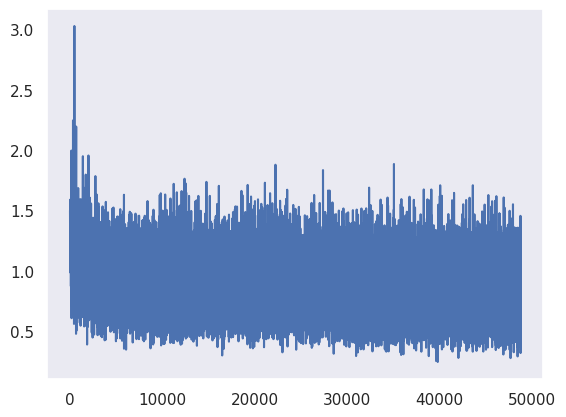

In [98]:
plt.plot(train_losses)

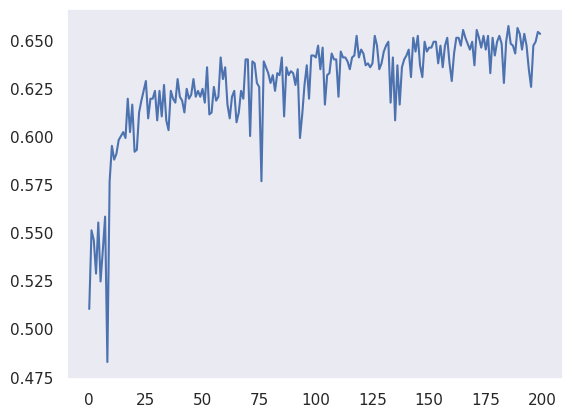

In [99]:
plt.plot(test_accuracy)

In [94]:
metrics3, confusion_matrix3 = report_metrics(
    model, labels=labels, device=device)
pprint(metrics3.compute())
confusion_matrix3.compute()

Correct: 640/976 (0.6557)
{'acc_detail': tensor([0.7126, 0.5602, 0.7756, 0.5595], device='cuda:0'),
 'acc_unweighted': tensor(0.6520, device='cuda:0'),
 'acc_weighted': tensor(0.6557, device='cuda:0'),
 'f1s_detail': tensor([0.7403, 0.5681, 0.7337, 0.5640], device='cuda:0'),
 'f1s_unweighted': tensor(0.6515, device='cuda:0'),
 'f1s_weighted': tensor(0.6549, device='cuda:0'),
 'precision_detail': tensor([0.7702, 0.5762, 0.6961, 0.5685], device='cuda:0'),
 'recall_detail': tensor([0.7126, 0.5602, 0.7756, 0.5595], device='cuda:0'),
 'rocauc': tensor(0.8765, device='cuda:0'),
 'rocauc_detail': tensor([0.9147, 0.8622, 0.9129, 0.8160], device='cuda:0'),
 'uar': tensor(0.6520, device='cuda:0'),
 'wap': tensor(0.6559, device='cuda:0')}


tensor([[181,  12,   5,  56],
        [  6, 121,  52,  37],
        [  5,  38, 197,  14],
        [ 43,  39,  29, 141]], device='cuda:0')

In [95]:
model.to('cpu')
best_model_path = f'{model_path_prefix}{best_epoch}epoch.pt'
print(best_model_path)
best_model = M13(config=model_config,
           n_input=1, n_output=len(labels))
best_model.load_state_dict(torch.load(best_model_path))
best_model.to(device)

metrics_best, confusion_matrix_best = report_metrics(
    best_model, labels=labels, device=device)
best_model.to('cpu')
pprint(metrics_best.compute())
confusion_matrix_best.compute()

../models_cremad4/cremad_label4_m13ser_best_186epoch.pt
Correct: 644/976 (0.6598)
{'acc_detail': tensor([0.6929, 0.5556, 0.7598, 0.6151], device='cuda:0'),
 'acc_unweighted': tensor(0.6558, device='cuda:0'),
 'acc_weighted': tensor(0.6598, device='cuda:0'),
 'f1s_detail': tensor([0.7333, 0.5674, 0.7380, 0.5894], device='cuda:0'),
 'f1s_unweighted': tensor(0.6570, device='cuda:0'),
 'f1s_weighted': tensor(0.6607, device='cuda:0'),
 'precision_detail': tensor([0.7788, 0.5797, 0.7175, 0.5657], device='cuda:0'),
 'recall_detail': tensor([0.6929, 0.5556, 0.7598, 0.6151], device='cuda:0'),
 'rocauc': tensor(0.8713, device='cuda:0'),
 'rocauc_detail': tensor([0.9068, 0.8587, 0.9104, 0.8091], device='cuda:0'),
 'uar': tensor(0.6558, device='cuda:0'),
 'wap': tensor(0.6637, device='cuda:0')}


tensor([[176,  13,   5,  60],
        [  6, 120,  47,  43],
        [  6,  39, 193,  16],
        [ 38,  35,  24, 155]], device='cuda:0')

In [96]:
epoch

200

In [97]:
checkpoint_path = f'../models_cremad4/cremad4_m13ser_{epoch}epoch.ckpt'
torch.save({
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': train_losses[-1],
    'best_epoch': best_epoch,
    'best_accuracy': best_accuracy,
    'train_losses': train_losses,
    'test_accuracy': test_accuracy,
    'log_interval': log_interval,
    }, checkpoint_path)

In [100]:
start_epoch = 201
n_epoch = 300

optimizer = optim.RAdam(model.parameters(), lr=0.000001)
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=0.005, pct_start=0.3,
    steps_per_epoch=len(train_loader), epochs=n_epoch)
log_interval = 40
pbar_update = 1 / (len(train_loader) + len(test_loader))
model.to(device)
with tqdm(total=n_epoch) as pbar:
    for epoch in range(start_epoch, start_epoch+n_epoch):
        train(model, epoch, log_interval, train_losses)
        acc = test(model, epoch)
        test_accuracy += [acc]
        if acc > best_accuracy:
            best_accuracy = acc
            best_epoch = epoch
            bmodel_path = f'{model_path_prefix}{epoch}epoch.pt'
            torch.save(model.state_dict(), bmodel_path)
            print(f'saved model: {bmodel_path}')
        scheduler.step()

  0%|                             | 0.003278688524590164/300 [00:00<10:11:59, 122.40s/it]

Train Epoch: 201 [0/3918 (0%)]	Loss: 0.869785
Mem before-during-after: 92795392 4088923136 96270848


  0%|                              | 0.13442622950819672/300 [00:17<10:42:39, 128.59s/it]

Train Epoch: 201 [640/3918 (16%)]	Loss: 0.568727
Mem before-during-after: 96309760 4093651456 96294400


  0%|                              | 0.26557377049180286/300 [00:34<10:53:31, 130.82s/it]

Train Epoch: 201 [1280/3918 (33%)]	Loss: 0.827543
Mem before-during-after: 96294400 3586034176 96247296


  0%|                                 | 0.39672131147541/300 [00:52<10:28:15, 125.82s/it]

Train Epoch: 201 [1920/3918 (49%)]	Loss: 0.382803
Mem before-during-after: 96309760 4094208512 96294400


  0%|                               | 0.5278688524590167/300 [01:09<12:11:21, 146.53s/it]

Train Epoch: 201 [2560/3918 (66%)]	Loss: 0.690079
Mem before-during-after: 96289280 4090737152 96276992


  0%|                               | 0.6590163934426216/300 [01:26<10:36:30, 127.58s/it]

Train Epoch: 201 [3200/3918 (82%)]	Loss: 0.722874
Mem before-during-after: 96309760 4093149696 96294400


  0%|                               | 0.7901639344262266/300 [01:44<11:01:04, 132.56s/it]

Train Epoch: 201 [3840/3918 (98%)]	Loss: 1.110841
Mem before-during-after: 96309760 4091052544 96294400


  0%|                                 | 0.9999999999999944/300 [02:01<6:25:39, 77.39s/it]


Test Epoch: 201	Accuracy: 650/976 (66%)

saved model: ../models_cremad4/cremad_label4_m13ser_best_201epoch.pt


  0%|                                 | 1.0032786885245846/300 [02:01<7:28:54, 90.08s/it]

Train Epoch: 202 [0/3918 (0%)]	Loss: 0.706496
Mem before-during-after: 96294912 4092517376 96294400


  0%|                               | 1.1344262295081895/300 [02:19<10:57:14, 131.95s/it]

Train Epoch: 202 [640/3918 (16%)]	Loss: 0.735331
Mem before-during-after: 96309760 4093651456 96294400


  0%|▏                              | 1.2655737704917944/300 [02:38<13:05:34, 157.78s/it]

Train Epoch: 202 [1280/3918 (33%)]	Loss: 0.772794
Mem before-during-after: 96309760 4092111360 96294400


  0%|▏                              | 1.3967213114753994/300 [02:56<10:19:15, 124.43s/it]

Train Epoch: 202 [1920/3918 (49%)]	Loss: 0.631835
Mem before-during-after: 96294400 4092809728 96309760


  1%|▏                              | 1.5278688524590043/300 [03:14<11:05:29, 133.78s/it]

Train Epoch: 202 [2560/3918 (66%)]	Loss: 0.620447
Mem before-during-after: 96294400 4092809728 96309760


  1%|▏                              | 1.6590163934426092/300 [03:31<11:00:36, 132.86s/it]

Train Epoch: 202 [3200/3918 (82%)]	Loss: 0.720560
Mem before-during-after: 96309760 4094208512 96294400


  1%|▏                              | 1.7901639344262141/300 [03:50<12:16:26, 148.17s/it]

Train Epoch: 202 [3840/3918 (98%)]	Loss: 0.818697
Mem before-during-after: 96294400 4093079552 96309760


  1%|▏                                 | 1.999999999999982/300 [04:07<6:20:05, 76.53s/it]


Test Epoch: 202	Accuracy: 625/976 (64%)



  1%|▏                                | 2.0032786885245724/300 [04:07<7:40:24, 92.70s/it]

Train Epoch: 203 [0/3918 (0%)]	Loss: 0.572820
Mem before-during-after: 96294912 4092517376 96294400


  1%|▏                              | 2.1344262295081773/300 [04:24<10:30:42, 127.05s/it]

Train Epoch: 203 [640/3918 (16%)]	Loss: 0.753490
Mem before-during-after: 96309760 3968430592 97211392


  1%|▏                               | 2.265573770491782/300 [04:41<10:44:07, 129.81s/it]

Train Epoch: 203 [1280/3918 (33%)]	Loss: 0.509678
Mem before-during-after: 96294400 4092809728 96309760


  1%|▎                               | 2.396721311475387/300 [04:58<11:34:35, 140.04s/it]

Train Epoch: 203 [1920/3918 (49%)]	Loss: 0.592655
Mem before-during-after: 96294400 4093925888 96571904


  1%|▎                               | 2.527868852458992/300 [05:16<10:13:38, 123.77s/it]

Train Epoch: 203 [2560/3918 (66%)]	Loss: 0.966998
Mem before-during-after: 96294400 4092809728 96309760


  1%|▎                               | 2.659016393442597/300 [05:33<11:47:01, 142.67s/it]

Train Epoch: 203 [3200/3918 (82%)]	Loss: 0.819344
Mem before-during-after: 96294400 4092809728 96309760


  1%|▎                               | 2.790163934426202/300 [05:50<11:00:06, 133.26s/it]

Train Epoch: 203 [3840/3918 (98%)]	Loss: 0.971065
Mem before-during-after: 96294400 4037248512 96247296


  1%|▎                                  | 2.99999999999997/300 [06:07<6:21:10, 77.00s/it]


Test Epoch: 203	Accuracy: 635/976 (65%)



  1%|▎                                  | 3.00327868852456/300 [06:08<7:44:33, 93.85s/it]

Train Epoch: 204 [0/3918 (0%)]	Loss: 0.841913
Mem before-during-after: 96294912 4092517376 96294400


  1%|▎                               | 3.134426229508165/300 [06:25<10:44:10, 130.19s/it]

Train Epoch: 204 [640/3918 (16%)]	Loss: 0.634516
Mem before-during-after: 96309760 4094208512 96294400


  1%|▎                                | 3.26557377049177/300 [06:43<10:30:09, 127.42s/it]

Train Epoch: 204 [1280/3918 (33%)]	Loss: 0.918643
Mem before-during-after: 96309760 4093651456 96294400


  1%|▎                              | 3.3967213114753747/300 [07:00<11:05:17, 134.58s/it]

Train Epoch: 204 [1920/3918 (49%)]	Loss: 1.114133
Mem before-during-after: 96247296 3910920192 96294400


  1%|▎                              | 3.5278688524589796/300 [07:18<10:31:33, 127.81s/it]

Train Epoch: 204 [2560/3918 (66%)]	Loss: 0.845046
Mem before-during-after: 96294400 4092809728 96309760


  1%|▍                              | 3.6590163934425846/300 [07:37<12:50:22, 155.98s/it]

Train Epoch: 204 [3200/3918 (82%)]	Loss: 1.264579
Mem before-during-after: 96309760 4091052544 96294400


  1%|▍                              | 3.7901639344261895/300 [07:55<12:25:35, 151.03s/it]

Train Epoch: 204 [3840/3918 (98%)]	Loss: 0.589874
Mem before-during-after: 96294400 4090712576 96309760


  1%|▍                                | 3.9999999999999574/300 [08:12<6:03:51, 73.75s/it]


Test Epoch: 204	Accuracy: 641/976 (65%)



  1%|▍                                | 4.0032786885245475/300 [08:12<7:26:01, 90.41s/it]

Train Epoch: 205 [0/3918 (0%)]	Loss: 0.711995
Mem before-during-after: 96294912 4092517376 96294400


  1%|▍                               | 4.134426229508152/300 [08:32<10:32:21, 128.24s/it]

Train Epoch: 205 [640/3918 (16%)]	Loss: 1.043562
Mem before-during-after: 96309760 4094208512 96294400


  1%|▍                               | 4.265573770491757/300 [08:50<11:39:18, 141.88s/it]

Train Epoch: 205 [1280/3918 (33%)]	Loss: 0.428546
Mem before-during-after: 96571904 4092809728 96294400


  1%|▍                               | 4.396721311475362/300 [09:08<12:18:49, 149.96s/it]

Train Epoch: 205 [1920/3918 (49%)]	Loss: 0.978941
Mem before-during-after: 96294400 4090692096 96289280


  2%|▍                               | 4.527868852458967/300 [09:26<11:09:24, 135.93s/it]

Train Epoch: 205 [2560/3918 (66%)]	Loss: 0.862198
Mem before-during-after: 96571904 4092809728 96294400


  2%|▍                               | 4.659016393442572/300 [09:44<10:10:34, 124.04s/it]

Train Epoch: 205 [3200/3918 (82%)]	Loss: 0.689424
Mem before-during-after: 96294400 4092809728 96309760


  2%|▌                               | 4.790163934426177/300 [10:01<12:02:48, 146.91s/it]

Train Epoch: 205 [3840/3918 (98%)]	Loss: 0.823667
Mem before-during-after: 96309760 4091554304 96294400


  2%|▌                                 | 4.999999999999945/300 [10:18<6:04:52, 74.21s/it]


Test Epoch: 205	Accuracy: 641/976 (65%)



  2%|▌                                 | 5.003278688524535/300 [10:18<7:28:47, 91.28s/it]

Train Epoch: 206 [0/3918 (0%)]	Loss: 0.601876
Mem before-during-after: 96294912 4092517376 96294400


  2%|▌                                | 5.13442622950814/300 [10:36<11:05:05, 135.33s/it]

Train Epoch: 206 [640/3918 (16%)]	Loss: 0.872332
Mem before-during-after: 96309760 4093651456 96294400


  2%|▌                               | 5.265573770491745/300 [10:53<10:27:10, 127.68s/it]

Train Epoch: 206 [1280/3918 (33%)]	Loss: 0.683444
Mem before-during-after: 96294400 4092809728 96309760


  2%|▌                                | 5.39672131147535/300 [11:11<11:38:29, 142.26s/it]

Train Epoch: 206 [1920/3918 (49%)]	Loss: 1.010989
Mem before-during-after: 96294400 4035151360 96247296


  2%|▌                               | 5.527868852458955/300 [11:28<10:13:56, 125.09s/it]

Train Epoch: 206 [2560/3918 (66%)]	Loss: 1.006452
Mem before-during-after: 96309760 4094208512 96294400


  2%|▌                                | 5.65901639344256/300 [11:45<10:17:19, 125.84s/it]

Train Epoch: 206 [3200/3918 (82%)]	Loss: 0.993420
Mem before-during-after: 96309760 4093651456 96294400


  2%|▌                               | 5.790163934426165/300 [12:03<10:28:20, 128.14s/it]

Train Epoch: 206 [3840/3918 (98%)]	Loss: 0.850389
Mem before-during-after: 96309760 4093651456 96294400


  2%|▋                                | 5.9999999999999325/300 [12:19<6:57:20, 85.17s/it]


Test Epoch: 206	Accuracy: 636/976 (65%)



  2%|▋                                 | 6.003278688524523/300 [12:19<7:48:34, 95.63s/it]

Train Epoch: 207 [0/3918 (0%)]	Loss: 0.809995
Mem before-during-after: 96294912 4092517376 96294400


  2%|▋                              | 6.1344262295081275/300 [12:37<12:05:41, 148.17s/it]

Train Epoch: 207 [640/3918 (16%)]	Loss: 0.854055
Mem before-during-after: 96294400 4090712576 96309760


  2%|▋                              | 6.2655737704917325/300 [12:55<10:12:11, 125.05s/it]

Train Epoch: 207 [1280/3918 (33%)]	Loss: 0.559286
Mem before-during-after: 96309760 3885870592 96302080


  2%|▋                               | 6.396721311475337/300 [13:12<11:02:43, 135.43s/it]

Train Epoch: 207 [1920/3918 (49%)]	Loss: 0.490614
Mem before-during-after: 96309760 4093149696 96294400


  2%|▋                               | 6.527868852458942/300 [13:31<10:31:08, 129.04s/it]

Train Epoch: 207 [2560/3918 (66%)]	Loss: 0.561539
Mem before-during-after: 96309760 3969008640 97211392


  2%|▋                               | 6.659016393442547/300 [13:47<10:07:00, 124.16s/it]

Train Epoch: 207 [3200/3918 (82%)]	Loss: 0.687062
Mem before-during-after: 96294400 4092809728 96309760


  2%|▋                               | 6.790163934426152/300 [14:04<10:08:08, 124.45s/it]

Train Epoch: 207 [3840/3918 (98%)]	Loss: 0.386689
Mem before-during-after: 96294400 4092809728 96309760


  2%|▊                                  | 6.99999999999992/300 [14:21<6:09:58, 75.76s/it]


Test Epoch: 207	Accuracy: 641/976 (65%)



  2%|▊                                  | 7.00327868852451/300 [14:21<7:11:25, 88.35s/it]

Train Epoch: 208 [0/3918 (0%)]	Loss: 0.587374
Mem before-during-after: 96294912 4092517376 96294400


  2%|▊                               | 7.134426229508115/300 [14:40<12:03:22, 148.20s/it]

Train Epoch: 208 [640/3918 (16%)]	Loss: 0.743223
Mem before-during-after: 96276992 4093092352 96277504


  2%|▊                                | 7.26557377049172/300 [14:58<10:04:55, 123.99s/it]

Train Epoch: 208 [1280/3918 (33%)]	Loss: 0.791158
Mem before-during-after: 96309760 4093651456 96294400


  2%|▊                               | 7.396721311475325/300 [15:14<12:15:10, 150.75s/it]

Train Epoch: 208 [1920/3918 (49%)]	Loss: 0.879756
Mem before-during-after: 96294400 4090712576 96309760


  3%|▊                                | 7.52786885245893/300 [15:32<10:06:58, 124.52s/it]

Train Epoch: 208 [2560/3918 (66%)]	Loss: 0.544909
Mem before-during-after: 96294400 4092809728 96309760


  3%|▊                               | 7.659016393442535/300 [15:49<10:38:07, 130.97s/it]

Train Epoch: 208 [3200/3918 (82%)]	Loss: 0.503308
Mem before-during-after: 96294400 4092809728 96309760


  3%|▊                                | 7.79016393442614/300 [16:08<11:10:55, 137.76s/it]

Train Epoch: 208 [3840/3918 (98%)]	Loss: 0.714760
Mem before-during-after: 96294400 4092809728 96309760


  3%|▉                                 | 7.999999999999908/300 [16:25<6:31:23, 80.42s/it]


Test Epoch: 208	Accuracy: 632/976 (64%)



  3%|▉                                 | 8.003278688524498/300 [16:25<7:49:45, 96.53s/it]

Train Epoch: 209 [0/3918 (0%)]	Loss: 1.117856
Mem before-during-after: 96294912 4092517376 96294400


  3%|▊                               | 8.134426229508103/300 [16:43<10:21:57, 127.86s/it]

Train Epoch: 209 [640/3918 (16%)]	Loss: 0.642242
Mem before-during-after: 96309760 4093651456 96294400


  3%|▉                               | 8.265573770491708/300 [17:01<10:33:15, 130.24s/it]

Train Epoch: 209 [1280/3918 (33%)]	Loss: 0.743327
Mem before-during-after: 96294400 4091269632 96309760


  3%|▉                               | 8.396721311475313/300 [17:17<10:42:21, 132.17s/it]

Train Epoch: 209 [1920/3918 (49%)]	Loss: 0.527729
Mem before-during-after: 96294400 4091269632 96309760


  3%|▉                               | 8.527868852458917/300 [17:34<10:42:41, 132.30s/it]

Train Epoch: 209 [2560/3918 (66%)]	Loss: 0.679354
Mem before-during-after: 96294400 4093366784 96309760


  3%|▉                               | 8.659016393442522/300 [17:51<10:51:08, 134.10s/it]

Train Epoch: 209 [3200/3918 (82%)]	Loss: 0.970688
Mem before-during-after: 96294400 4092809728 96309760


  3%|▉                               | 8.790163934426127/300 [18:09<10:15:42, 126.86s/it]

Train Epoch: 209 [3840/3918 (98%)]	Loss: 0.639237
Mem before-during-after: 96294400 4092809728 96309760


  3%|█                                 | 8.999999999999895/300 [18:26<6:16:23, 77.61s/it]


Test Epoch: 209	Accuracy: 644/976 (66%)



  3%|█                                 | 9.003278688524485/300 [18:27<7:35:09, 93.85s/it]

Train Epoch: 210 [0/3918 (0%)]	Loss: 1.118859
Mem before-during-after: 96294912 4092517376 96294400


  3%|█                                | 9.13442622950809/300 [18:45<10:06:28, 125.11s/it]

Train Epoch: 210 [640/3918 (16%)]	Loss: 0.798177
Mem before-during-after: 96309760 4093149696 96294400


  3%|▉                               | 9.265573770491695/300 [19:03<10:14:42, 126.86s/it]

Train Epoch: 210 [1280/3918 (33%)]	Loss: 1.207039
Mem before-during-after: 96309760 4069134336 96302080


  3%|█                                 | 9.3967213114753/300 [19:21<10:45:44, 133.33s/it]

Train Epoch: 210 [1920/3918 (49%)]	Loss: 0.783934
Mem before-during-after: 96309760 4093149696 96294400


  3%|█                               | 9.527868852458905/300 [19:39<12:20:44, 153.01s/it]

Train Epoch: 210 [2560/3918 (66%)]	Loss: 1.358230
Mem before-during-after: 96247296 4093149696 96294400


  3%|█                                | 9.65901639344251/300 [19:56<13:00:35, 161.31s/it]

Train Epoch: 210 [3200/3918 (82%)]	Loss: 0.803159
Mem before-during-after: 96294400 4092766720 96247296


  3%|█                               | 9.790163934426115/300 [20:14<10:02:52, 124.64s/it]

Train Epoch: 210 [3840/3918 (98%)]	Loss: 0.982494
Mem before-during-after: 96294400 4092809728 96309760


  3%|█▏                                | 9.999999999999883/300 [20:30<6:01:39, 74.82s/it]


Test Epoch: 210	Accuracy: 650/976 (66%)



  3%|█                                | 10.003278688524473/300 [20:30<7:24:01, 91.87s/it]

Train Epoch: 211 [0/3918 (0%)]	Loss: 0.746438
Mem before-during-after: 96294912 4092517376 96294400


  3%|█                              | 10.134426229508078/300 [20:48<10:24:56, 129.36s/it]

Train Epoch: 211 [640/3918 (16%)]	Loss: 0.984749
Mem before-during-after: 96294400 4092809728 96309760


  3%|█                              | 10.265573770491683/300 [21:05<11:56:34, 148.39s/it]

Train Epoch: 211 [1280/3918 (33%)]	Loss: 0.923656
Mem before-during-after: 96309760 4091554304 96294400


  3%|█                              | 10.396721311475288/300 [21:23<10:27:45, 130.06s/it]

Train Epoch: 211 [1920/3918 (49%)]	Loss: 0.829426
Mem before-during-after: 96309760 3844315136 96302080


  4%|█                              | 10.527868852458893/300 [21:41<11:59:34, 149.15s/it]

Train Epoch: 211 [2560/3918 (66%)]	Loss: 0.638938
Mem before-during-after: 96294400 4090712576 96309760


  4%|█                              | 10.659016393442498/300 [21:59<10:14:52, 127.51s/it]

Train Epoch: 211 [3200/3918 (82%)]	Loss: 0.987254
Mem before-during-after: 96294400 4092809728 96309760


  4%|█                              | 10.790163934426102/300 [22:18<12:40:21, 157.75s/it]

Train Epoch: 211 [3840/3918 (98%)]	Loss: 0.896157
Mem before-during-after: 96294400 4090712576 96309760


  4%|█▏                                | 10.99999999999987/300 [22:34<5:57:15, 74.17s/it]


Test Epoch: 211	Accuracy: 642/976 (66%)



  4%|█▏                                | 11.00327868852446/300 [22:35<7:13:20, 89.97s/it]

Train Epoch: 212 [0/3918 (0%)]	Loss: 0.761004
Mem before-during-after: 96294912 4092517376 96294400


  4%|█▏                             | 11.134426229508065/300 [22:53<10:38:55, 132.71s/it]

Train Epoch: 212 [640/3918 (16%)]	Loss: 1.132715
Mem before-during-after: 96294400 4092809728 96309760


  4%|█▏                              | 11.26557377049167/300 [23:10<10:53:52, 135.88s/it]

Train Epoch: 212 [1280/3918 (33%)]	Loss: 0.702791
Mem before-during-after: 96302080 4094899200 96294400


  4%|█▏                             | 11.396721311475275/300 [23:29<10:59:56, 137.20s/it]

Train Epoch: 212 [1920/3918 (49%)]	Loss: 0.568556
Mem before-during-after: 96294400 4092809728 96309760


  4%|█▏                              | 11.52786885245888/300 [23:46<11:44:07, 146.45s/it]

Train Epoch: 212 [2560/3918 (66%)]	Loss: 1.134480
Mem before-during-after: 96294400 4090712576 96309760


  4%|█▏                             | 11.659016393442485/300 [24:05<10:45:35, 134.34s/it]

Train Epoch: 212 [3200/3918 (82%)]	Loss: 0.659930
Mem before-during-after: 96294400 4092809728 96309760


  4%|█▎                               | 11.79016393442609/300 [24:22<9:59:13, 124.75s/it]

Train Epoch: 212 [3840/3918 (98%)]	Loss: 1.015752
Mem before-during-after: 96309760 4094208512 96294400


  4%|█▎                               | 11.999999999999858/300 [24:39<6:17:59, 78.75s/it]


Test Epoch: 212	Accuracy: 642/976 (66%)



  4%|█▎                               | 12.003278688524448/300 [24:40<7:25:02, 92.72s/it]

Train Epoch: 213 [0/3918 (0%)]	Loss: 0.533582
Mem before-during-after: 96294912 4092517376 96294400


  4%|█▎                             | 12.134426229508053/300 [24:56<10:01:41, 125.41s/it]

Train Epoch: 213 [640/3918 (16%)]	Loss: 0.857237
Mem before-during-after: 96294400 4092809728 96309760


  4%|█▎                             | 12.265573770491658/300 [25:13<10:05:57, 126.36s/it]

Train Epoch: 213 [1280/3918 (33%)]	Loss: 0.880253
Mem before-during-after: 96294400 4095463936 96309760


  4%|█▎                             | 12.396721311475263/300 [25:30<11:29:29, 143.84s/it]

Train Epoch: 213 [1920/3918 (49%)]	Loss: 0.918296
Mem before-during-after: 96294400 4092809728 96309760


  4%|█▎                             | 12.527868852458868/300 [25:47<10:02:10, 125.68s/it]

Train Epoch: 213 [2560/3918 (66%)]	Loss: 0.896327
Mem before-during-after: 96294400 4092809728 96309760


  4%|█▎                             | 12.659016393442473/300 [26:04<10:00:00, 125.29s/it]

Train Epoch: 213 [3200/3918 (82%)]	Loss: 0.969662
Mem before-during-after: 96294400 4092809728 96309760


  4%|█▎                             | 12.790163934426078/300 [26:22<10:43:46, 134.49s/it]

Train Epoch: 213 [3840/3918 (98%)]	Loss: 0.634293
Mem before-during-after: 96294400 4092809728 96309760


  4%|█▍                               | 12.999999999999845/300 [26:38<6:02:31, 75.79s/it]


Test Epoch: 213	Accuracy: 637/976 (65%)



  4%|█▍                               | 13.003278688524436/300 [26:38<7:11:54, 90.30s/it]

Train Epoch: 214 [0/3918 (0%)]	Loss: 0.736419
Mem before-during-after: 96294912 4092517376 96294400


  4%|█▍                              | 13.13442622950804/300 [26:56<10:00:50, 125.67s/it]

Train Epoch: 214 [640/3918 (16%)]	Loss: 0.743841
Mem before-during-after: 96294400 4092809728 96309760


  4%|█▎                             | 13.265573770491645/300 [27:14<10:03:37, 126.31s/it]

Train Epoch: 214 [1280/3918 (33%)]	Loss: 1.195371
Mem before-during-after: 96294400 4092809728 96309760


  4%|█▍                              | 13.39672131147525/300 [27:32<11:38:21, 146.20s/it]

Train Epoch: 214 [1920/3918 (49%)]	Loss: 0.896752
Mem before-during-after: 96309760 4093651456 96294400


  5%|█▍                             | 13.527868852458855/300 [27:50<10:01:00, 125.88s/it]

Train Epoch: 214 [2560/3918 (66%)]	Loss: 0.544247
Mem before-during-after: 96309760 4093651456 96294400


  5%|█▍                              | 13.65901639344246/300 [28:08<10:42:28, 134.62s/it]

Train Epoch: 214 [3200/3918 (82%)]	Loss: 0.451021
Mem before-during-after: 96309760 4093651456 96294400


  5%|█▍                             | 13.790163934426065/300 [28:25<10:19:13, 129.81s/it]

Train Epoch: 214 [3840/3918 (98%)]	Loss: 0.684981
Mem before-during-after: 96294400 4092809728 96309760


  5%|█▌                               | 13.999999999999833/300 [28:42<6:19:35, 79.63s/it]


Test Epoch: 214	Accuracy: 626/976 (64%)



  5%|█▌                               | 14.003278688524423/300 [28:42<7:19:40, 92.24s/it]

Train Epoch: 215 [0/3918 (0%)]	Loss: 0.900250
Mem before-during-after: 96294912 4092517376 96294400


  5%|█▌                              | 14.134426229508028/300 [29:00<9:58:30, 125.62s/it]

Train Epoch: 215 [640/3918 (16%)]	Loss: 0.607344
Mem before-during-after: 96294400 4092134912 96309760


  5%|█▍                             | 14.265573770491633/300 [29:17<11:01:09, 138.83s/it]

Train Epoch: 215 [1280/3918 (33%)]	Loss: 0.616211
Mem before-during-after: 96294400 4092809728 96309760


  5%|█▍                             | 14.396721311475238/300 [29:35<10:05:39, 127.24s/it]

Train Epoch: 215 [1920/3918 (49%)]	Loss: 0.639294
Mem before-during-after: 96294400 4092809728 96309760


  5%|█▌                             | 14.527868852458843/300 [29:53<10:14:27, 129.14s/it]

Train Epoch: 215 [2560/3918 (66%)]	Loss: 0.441767
Mem before-during-after: 96294400 4092809728 96309760


  5%|█▌                             | 14.659016393442448/300 [30:10<10:50:27, 136.78s/it]

Train Epoch: 215 [3200/3918 (82%)]	Loss: 0.621885
Mem before-during-after: 96309760 4092809728 96294400


  5%|█▌                             | 14.790163934426053/300 [30:30<10:32:20, 133.02s/it]

Train Epoch: 215 [3840/3918 (98%)]	Loss: 0.858257
Mem before-during-after: 96309760 4093149696 96294400


  5%|█▋                                | 14.99999999999982/300 [30:47<6:02:41, 76.36s/it]


Test Epoch: 215	Accuracy: 631/976 (64%)



  5%|█▋                                | 15.00327868852441/300 [30:47<7:04:35, 89.39s/it]

Train Epoch: 216 [0/3918 (0%)]	Loss: 0.757792
Mem before-during-after: 96294912 4053729280 96252416


  5%|█▌                             | 15.134426229508016/300 [31:05<10:17:33, 130.07s/it]

Train Epoch: 216 [640/3918 (16%)]	Loss: 0.797645
Mem before-during-after: 96294400 4092809728 96309760


  5%|█▋                               | 15.26557377049162/300 [31:21<9:49:16, 124.17s/it]

Train Epoch: 216 [1280/3918 (33%)]	Loss: 0.628950
Mem before-during-after: 96294400 4092809728 96309760


  5%|█▌                             | 15.396721311475225/300 [31:40<11:32:28, 145.99s/it]

Train Epoch: 216 [1920/3918 (49%)]	Loss: 0.972818
Mem before-during-after: 96294400 4093368832 96571904


  5%|█▋                              | 15.52786885245883/300 [31:57<10:01:46, 126.93s/it]

Train Epoch: 216 [2560/3918 (66%)]	Loss: 0.886580
Mem before-during-after: 96294400 4092809728 96309760


  5%|█▌                             | 15.659016393442435/300 [32:14<10:51:51, 137.55s/it]

Train Epoch: 216 [3200/3918 (82%)]	Loss: 0.761197
Mem before-during-after: 96294400 3968815104 97156608


  5%|█▋                              | 15.79016393442604/300 [32:31<11:21:35, 143.89s/it]

Train Epoch: 216 [3840/3918 (98%)]	Loss: 0.674251
Mem before-during-after: 96294400 4092809728 96309760


  5%|█▋                              | 15.999999999999808/300 [32:48<7:54:01, 100.15s/it]


Test Epoch: 216	Accuracy: 637/976 (65%)



  5%|█▊                                | 16.0032786885244/300 [32:48<8:22:39, 106.19s/it]

Train Epoch: 217 [0/3918 (0%)]	Loss: 0.956768
Mem before-during-after: 96294912 4092517376 96294400


  5%|█▋                             | 16.134426229508076/300 [33:05<10:10:26, 129.03s/it]

Train Epoch: 217 [640/3918 (16%)]	Loss: 0.655933
Mem before-during-after: 96309760 4094208512 96294400


  5%|█▋                             | 16.265573770491752/300 [33:22<10:00:15, 126.93s/it]

Train Epoch: 217 [1280/3918 (33%)]	Loss: 0.578541
Mem before-during-after: 96294400 4092809728 96309760


  5%|█▋                             | 16.396721311475428/300 [33:40<10:14:14, 129.95s/it]

Train Epoch: 217 [1920/3918 (49%)]	Loss: 0.655742
Mem before-during-after: 96309760 4093651456 96294400


  6%|█▋                             | 16.527868852459104/300 [33:59<10:12:36, 129.67s/it]

Train Epoch: 217 [2560/3918 (66%)]	Loss: 0.770653
Mem before-during-after: 96309760 4093651456 96294400


  6%|█▊                              | 16.65901639344278/300 [34:18<11:57:48, 152.00s/it]

Train Epoch: 217 [3200/3918 (82%)]	Loss: 0.522452
Mem before-during-after: 96309760 4091554304 96294400


  6%|█▋                             | 16.790163934426456/300 [34:37<10:45:27, 136.74s/it]

Train Epoch: 217 [3840/3918 (98%)]	Loss: 0.921958
Mem before-during-after: 96571904 4092809728 96294400


  6%|█▊                               | 17.000000000000338/300 [34:53<5:56:22, 75.56s/it]


Test Epoch: 217	Accuracy: 642/976 (66%)



  6%|█▉                                | 17.00327868852493/300 [34:54<7:05:40, 90.25s/it]

Train Epoch: 218 [0/3918 (0%)]	Loss: 0.819455
Mem before-during-after: 96294912 4092517376 96294400


  6%|█▊                              | 17.134426229508605/300 [35:11<9:57:37, 126.77s/it]

Train Epoch: 218 [640/3918 (16%)]	Loss: 0.770620
Mem before-during-after: 96309760 4093706752 96294400


  6%|█▉                               | 17.26557377049228/300 [35:28<9:54:17, 126.12s/it]

Train Epoch: 218 [1280/3918 (33%)]	Loss: 1.047654
Mem before-during-after: 96294400 4092809728 96309760


  6%|█▊                             | 17.396721311475957/300 [35:47<12:29:12, 159.07s/it]

Train Epoch: 218 [1920/3918 (49%)]	Loss: 0.812953
Mem before-during-after: 96309760 4091052544 96294400


  6%|█▊                             | 17.527868852459633/300 [36:04<10:00:17, 127.51s/it]

Train Epoch: 218 [2560/3918 (66%)]	Loss: 0.546026
Mem before-during-after: 96309760 4093149696 96294400


  6%|█▉                              | 17.65901639344331/300 [36:21<10:32:32, 134.42s/it]

Train Epoch: 218 [3200/3918 (82%)]	Loss: 0.572656
Mem before-during-after: 96294400 4092809728 96309760


  6%|█▉                              | 17.790163934426985/300 [36:39<9:47:49, 124.98s/it]

Train Epoch: 218 [3840/3918 (98%)]	Loss: 0.640846
Mem before-during-after: 96294400 4092809728 96309760


  6%|█▉                               | 18.000000000000867/300 [36:56<5:56:20, 75.82s/it]


Test Epoch: 218	Accuracy: 648/976 (66%)



  6%|██                                | 18.00327868852546/300 [36:56<6:55:22, 88.38s/it]

Train Epoch: 219 [0/3918 (0%)]	Loss: 0.679448
Mem before-during-after: 96294912 4092517376 96294400


  6%|█▊                             | 18.134426229509135/300 [37:13<10:59:13, 140.33s/it]

Train Epoch: 219 [640/3918 (16%)]	Loss: 0.641509
Mem before-during-after: 96294400 4093368832 96571904


  6%|█▉                              | 18.26557377049281/300 [37:31<10:09:33, 129.81s/it]

Train Epoch: 219 [1280/3918 (33%)]	Loss: 0.763418
Mem before-during-after: 96309760 4093651456 96294400


  6%|█▉                             | 18.396721311476487/300 [37:47<10:14:28, 130.93s/it]

Train Epoch: 219 [1920/3918 (49%)]	Loss: 0.876785
Mem before-during-after: 97211392 4011968512 97195008


  6%|█▉                             | 18.527868852460163/300 [38:06<11:11:48, 143.21s/it]

Train Epoch: 219 [2560/3918 (66%)]	Loss: 0.809905
Mem before-during-after: 96309760 4093651456 96294400


  6%|██                               | 18.65901639344384/300 [38:23<9:55:42, 127.04s/it]

Train Epoch: 219 [3200/3918 (82%)]	Loss: 0.800671
Mem before-during-after: 96294400 4092809728 96309760


  6%|█▉                             | 18.790163934427515/300 [38:42<11:58:16, 153.25s/it]

Train Epoch: 219 [3840/3918 (98%)]	Loss: 0.786743
Mem before-during-after: 96309760 4092111360 96294400


  6%|██                               | 19.000000000001396/300 [38:59<6:09:09, 78.82s/it]


Test Epoch: 219	Accuracy: 633/976 (65%)



  6%|██                               | 19.003278688525988/300 [38:59<7:14:56, 92.87s/it]

Train Epoch: 220 [0/3918 (0%)]	Loss: 0.826511
Mem before-during-after: 96294912 4053729280 96252416


  6%|█▉                             | 19.134426229509664/300 [39:17<10:50:16, 138.91s/it]

Train Epoch: 220 [640/3918 (16%)]	Loss: 0.687419
Mem before-during-after: 96309760 4093651456 96294400


  6%|██                              | 19.26557377049334/300 [39:37<11:56:57, 153.23s/it]

Train Epoch: 220 [1280/3918 (33%)]	Loss: 1.281192
Mem before-during-after: 96294400 3885786112 96247296


  6%|██                             | 19.396721311477016/300 [39:54<10:23:50, 133.39s/it]

Train Epoch: 220 [1920/3918 (49%)]	Loss: 0.590640
Mem before-during-after: 96294400 4092809728 96309760


  7%|██                             | 19.527868852460692/300 [40:12<11:43:12, 150.43s/it]

Train Epoch: 220 [2560/3918 (66%)]	Loss: 0.516664
Mem before-during-after: 96309760 3988761088 97211392


  7%|██                             | 19.659016393444368/300 [40:31<11:37:55, 149.37s/it]

Train Epoch: 220 [3200/3918 (82%)]	Loss: 1.124676
Mem before-during-after: 96309760 4091554304 96294400


  7%|██                             | 19.790163934428044/300 [40:49<10:12:39, 131.18s/it]

Train Epoch: 220 [3840/3918 (98%)]	Loss: 0.746240
Mem before-during-after: 96309760 4093149696 96294400


  7%|██▏                              | 20.000000000001926/300 [41:05<6:00:14, 77.19s/it]


Test Epoch: 220	Accuracy: 639/976 (65%)



  7%|██▏                              | 20.003278688526517/300 [41:06<7:06:58, 91.50s/it]

Train Epoch: 221 [0/3918 (0%)]	Loss: 0.707843
Mem before-during-after: 96294912 4092517376 96294400


  7%|██                             | 20.134426229510193/300 [41:23<10:54:59, 140.42s/it]

Train Epoch: 221 [640/3918 (16%)]	Loss: 1.195538
Mem before-during-after: 96309760 4092111360 96294400


  7%|██▏                             | 20.26557377049387/300 [41:42<10:11:24, 131.14s/it]

Train Epoch: 221 [1280/3918 (33%)]	Loss: 0.616806
Mem before-during-after: 96294400 4092809728 96309760


  7%|██                             | 20.396721311477545/300 [41:59<10:21:07, 133.29s/it]

Train Epoch: 221 [1920/3918 (49%)]	Loss: 0.520057
Mem before-during-after: 96294400 4092809728 96309760


  7%|██▏                             | 20.52786885246122/300 [42:17<11:05:50, 142.95s/it]

Train Epoch: 221 [2560/3918 (66%)]	Loss: 0.796068
Mem before-during-after: 96805888 4095246848 96294400


  7%|██▏                            | 20.659016393444897/300 [42:36<12:09:11, 156.62s/it]

Train Epoch: 221 [3200/3918 (82%)]	Loss: 0.790353
Mem before-during-after: 96302080 4093099008 96294400


  7%|██▏                             | 20.790163934428573/300 [42:55<9:58:04, 128.52s/it]

Train Epoch: 221 [3840/3918 (98%)]	Loss: 0.942597
Mem before-during-after: 96294400 4092809728 96309760


  7%|██▎                              | 21.000000000002455/300 [43:12<5:59:47, 77.37s/it]


Test Epoch: 221	Accuracy: 636/976 (65%)



  7%|██▎                              | 21.003278688527047/300 [43:12<6:57:26, 89.77s/it]

Train Epoch: 222 [0/3918 (0%)]	Loss: 0.729900
Mem before-during-after: 96294912 4092517376 96294400


  7%|██▎                             | 21.134426229510723/300 [43:29<9:57:19, 128.52s/it]

Train Epoch: 222 [640/3918 (16%)]	Loss: 0.799826
Mem before-during-after: 96294400 4092809728 96309760


  7%|██▎                              | 21.2655737704944/300 [43:47<11:35:12, 149.65s/it]

Train Epoch: 222 [1280/3918 (33%)]	Loss: 0.682624
Mem before-during-after: 96309760 4091052544 96294400


  7%|██▏                            | 21.396721311478075/300 [44:07<12:41:06, 163.91s/it]

Train Epoch: 222 [1920/3918 (49%)]	Loss: 0.675091
Mem before-during-after: 96309760 4091052544 96294400


  7%|██▎                             | 21.52786885246175/300 [44:27<11:41:25, 151.13s/it]

Train Epoch: 222 [2560/3918 (66%)]	Loss: 0.778589
Mem before-during-after: 96294400 4092809728 96309760


  7%|██▏                            | 21.659016393445427/300 [44:44<10:18:29, 133.32s/it]

Train Epoch: 222 [3200/3918 (82%)]	Loss: 0.813113
Mem before-during-after: 96294400 4092809728 96309760


  7%|██▎                            | 21.790163934429103/300 [45:05<12:09:39, 157.36s/it]

Train Epoch: 222 [3840/3918 (98%)]	Loss: 0.990669
Mem before-during-after: 96294400 4090712576 96309760


  7%|██▍                              | 22.000000000002984/300 [45:23<6:12:43, 80.44s/it]


Test Epoch: 222	Accuracy: 649/976 (66%)



  7%|██▍                              | 22.003278688527576/300 [45:23<7:11:09, 93.06s/it]

Train Epoch: 223 [0/3918 (0%)]	Loss: 0.671923
Mem before-during-after: 96294912 4092517376 96294400


  7%|██▎                             | 22.134426229511252/300 [45:40<9:37:23, 124.68s/it]

Train Epoch: 223 [640/3918 (16%)]	Loss: 0.798606
Mem before-during-after: 96294400 4092809728 96309760


  7%|██▎                             | 22.265573770494928/300 [45:56<9:38:02, 124.88s/it]

Train Epoch: 223 [1280/3918 (33%)]	Loss: 0.473180
Mem before-during-after: 96294400 4092809728 96309760


  7%|██▍                             | 22.396721311478604/300 [46:13<9:55:24, 128.69s/it]

Train Epoch: 223 [1920/3918 (49%)]	Loss: 0.502545
Mem before-during-after: 96309760 4093651456 96294400


  8%|██▍                             | 22.52786885246228/300 [46:33<12:01:14, 155.96s/it]

Train Epoch: 223 [2560/3918 (66%)]	Loss: 0.627559
Mem before-during-after: 96256000 4090766336 96285696


  8%|██▎                            | 22.659016393445956/300 [46:52<11:19:08, 146.93s/it]

Train Epoch: 223 [3200/3918 (82%)]	Loss: 0.453304
Mem before-during-after: 97156608 4093371392 96294400


  8%|██▎                            | 22.790163934429632/300 [47:11<11:27:26, 148.79s/it]

Train Epoch: 223 [3840/3918 (98%)]	Loss: 0.898806
Mem before-during-after: 96294400 3926909440 96247296


  8%|██▌                              | 23.000000000003514/300 [47:29<5:58:29, 77.65s/it]


Test Epoch: 223	Accuracy: 641/976 (65%)



  8%|██▌                              | 23.003278688528106/300 [47:29<6:56:10, 90.15s/it]

Train Epoch: 224 [0/3918 (0%)]	Loss: 0.793395
Mem before-during-after: 96294912 4092517376 96294400


  8%|██▍                             | 23.13442622951178/300 [47:47<10:59:50, 143.00s/it]

Train Epoch: 224 [640/3918 (16%)]	Loss: 0.913590
Mem before-during-after: 97156608 4093907456 96294400


  8%|██▍                            | 23.265573770495457/300 [48:05<10:44:38, 139.77s/it]

Train Epoch: 224 [1280/3918 (33%)]	Loss: 0.450938
Mem before-during-after: 96294400 4092809728 96309760


  8%|██▍                             | 23.396721311479133/300 [48:22<9:52:50, 128.60s/it]

Train Epoch: 224 [1920/3918 (49%)]	Loss: 0.722002
Mem before-during-after: 96294400 4092809728 96309760


  8%|██▌                             | 23.52786885246281/300 [48:41<11:59:41, 156.19s/it]

Train Epoch: 224 [2560/3918 (66%)]	Loss: 0.687622
Mem before-during-after: 96294400 4090712576 96309760


  8%|██▍                            | 23.659016393446485/300 [49:00<11:33:36, 150.60s/it]

Train Epoch: 224 [3200/3918 (82%)]	Loss: 0.859407
Mem before-during-after: 96302080 4092809728 96294400


  8%|██▌                             | 23.79016393443016/300 [49:18<10:15:12, 133.64s/it]

Train Epoch: 224 [3840/3918 (98%)]	Loss: 0.592417
Mem before-during-after: 96309760 4094208512 96294400


  8%|██▋                              | 24.000000000004043/300 [49:35<6:05:47, 79.52s/it]


Test Epoch: 224	Accuracy: 632/976 (64%)



  8%|██▋                              | 24.003278688528635/300 [49:35<7:16:41, 94.93s/it]

Train Epoch: 225 [0/3918 (0%)]	Loss: 0.957790
Mem before-during-after: 96294912 4092517376 96294400


  8%|██▌                             | 24.13442622951231/300 [49:54<12:20:37, 161.08s/it]

Train Epoch: 225 [640/3918 (16%)]	Loss: 0.949681
Mem before-during-after: 96302080 4093336576 96294400


  8%|██▌                             | 24.265573770495987/300 [50:11<9:47:59, 127.95s/it]

Train Epoch: 225 [1280/3918 (33%)]	Loss: 1.112074
Mem before-during-after: 96309760 4093149696 96294400


  8%|██▌                            | 24.396721311479663/300 [50:29<11:42:57, 153.04s/it]

Train Epoch: 225 [1920/3918 (49%)]	Loss: 0.999817
Mem before-during-after: 96309760 3885870592 96302080


  8%|██▋                              | 24.52786885246334/300 [50:46<9:48:07, 128.10s/it]

Train Epoch: 225 [2560/3918 (66%)]	Loss: 0.953922
Mem before-during-after: 96294400 4092809728 96309760


  8%|██▌                            | 24.659016393447015/300 [51:04<11:42:45, 153.14s/it]

Train Epoch: 225 [3200/3918 (82%)]	Loss: 0.609500
Mem before-during-after: 96294400 4090712576 96309760


  8%|██▋                             | 24.79016393443069/300 [51:22<10:38:41, 139.24s/it]

Train Epoch: 225 [3840/3918 (98%)]	Loss: 0.636584
Mem before-during-after: 96571904 4092809728 96294400


  8%|██▊                              | 25.000000000004572/300 [51:39<5:53:01, 77.02s/it]


Test Epoch: 225	Accuracy: 642/976 (66%)



  8%|██▊                              | 25.003278688529164/300 [51:39<7:07:19, 93.24s/it]

Train Epoch: 226 [0/3918 (0%)]	Loss: 0.785173
Mem before-during-after: 96294912 4092517376 96294400


  8%|██▋                             | 25.13442622951284/300 [51:57<10:22:04, 135.79s/it]

Train Epoch: 226 [640/3918 (16%)]	Loss: 0.675558
Mem before-during-after: 96294400 4092809728 96309760


  8%|██▌                            | 25.265573770496516/300 [52:14<10:30:01, 137.59s/it]

Train Epoch: 226 [1280/3918 (33%)]	Loss: 0.531001
Mem before-during-after: 96309760 4093706752 96294400


  8%|██▋                             | 25.396721311480192/300 [52:31<9:51:41, 129.28s/it]

Train Epoch: 226 [1920/3918 (49%)]	Loss: 1.008131
Mem before-during-after: 96309760 4093706752 96294400


  9%|██▋                            | 25.527868852463868/300 [52:49<11:09:31, 146.36s/it]

Train Epoch: 226 [2560/3918 (66%)]	Loss: 0.525443
Mem before-during-after: 96294400 4093368832 96571904


  9%|██▋                            | 25.659016393447544/300 [53:06<11:14:18, 147.47s/it]

Train Epoch: 226 [3200/3918 (82%)]	Loss: 0.580291
Mem before-during-after: 96309760 4091052544 96294400


  9%|██▊                             | 25.79016393443122/300 [53:25<11:07:30, 146.06s/it]

Train Epoch: 226 [3840/3918 (98%)]	Loss: 0.750475
Mem before-during-after: 96294400 4090712576 96309760


  9%|███                                | 26.0000000000051/300 [53:43<6:07:09, 80.40s/it]


Test Epoch: 226	Accuracy: 633/976 (65%)



  9%|██▊                              | 26.003278688529694/300 [53:43<7:16:10, 95.52s/it]

Train Epoch: 227 [0/3918 (0%)]	Loss: 0.558437
Mem before-during-after: 96294912 4092517376 96294400


  9%|██▊                              | 26.13442622951337/300 [54:00<9:35:29, 126.08s/it]

Train Epoch: 227 [640/3918 (16%)]	Loss: 1.276527
Mem before-during-after: 96294400 4092809728 96309760


  9%|██▋                            | 26.265573770497046/300 [54:19<11:34:58, 152.33s/it]

Train Epoch: 227 [1280/3918 (33%)]	Loss: 0.689942
Mem before-during-after: 96294400 4090712576 96309760


  9%|██▊                             | 26.39672131148072/300 [54:39<11:46:00, 154.82s/it]

Train Epoch: 227 [1920/3918 (49%)]	Loss: 1.118306
Mem before-during-after: 96294400 4094482944 96571904


  9%|██▊                             | 26.527868852464398/300 [54:57<9:34:19, 126.01s/it]

Train Epoch: 227 [2560/3918 (66%)]	Loss: 0.515716
Mem before-during-after: 96294400 4092809728 96309760


  9%|██▊                            | 26.659016393448074/300 [55:14<10:37:13, 139.88s/it]

Train Epoch: 227 [3200/3918 (82%)]	Loss: 0.706046
Mem before-during-after: 96309760 4093651456 96294400


  9%|██▉                              | 26.79016393443175/300 [55:31<9:41:26, 127.69s/it]

Train Epoch: 227 [3840/3918 (98%)]	Loss: 0.812139
Mem before-during-after: 96309760 4094765568 96294400


  9%|███                               | 27.00000000000563/300 [55:48<5:42:58, 75.38s/it]


Test Epoch: 227	Accuracy: 636/976 (65%)



  9%|██▉                              | 27.003278688530223/300 [55:48<6:46:05, 89.25s/it]

Train Epoch: 228 [0/3918 (0%)]	Loss: 0.470557
Mem before-during-after: 96294912 4092517376 96294400


  9%|██▉                              | 27.1344262295139/300 [56:07<11:14:38, 148.34s/it]

Train Epoch: 228 [640/3918 (16%)]	Loss: 0.219123
Mem before-during-after: 96294400 3928977920 96247296


  9%|██▉                             | 27.265573770497575/300 [56:26<9:36:10, 126.76s/it]

Train Epoch: 228 [1280/3918 (33%)]	Loss: 0.536149
Mem before-during-after: 96294400 4092809728 96309760


  9%|██▉                             | 27.39672131148125/300 [56:43<11:22:54, 150.31s/it]

Train Epoch: 228 [1920/3918 (49%)]	Loss: 0.922781
Mem before-during-after: 96309760 4091554304 96294400


  9%|██▉                             | 27.527868852464927/300 [57:01<9:37:54, 127.26s/it]

Train Epoch: 228 [2560/3918 (66%)]	Loss: 0.788829
Mem before-during-after: 96294400 4092809728 96309760


  9%|██▊                            | 27.659016393448603/300 [57:18<11:20:43, 149.97s/it]

Train Epoch: 228 [3200/3918 (82%)]	Loss: 1.075957
Mem before-during-after: 96780800 4095176704 96294400


  9%|██▉                             | 27.79016393443228/300 [57:36<11:07:20, 147.09s/it]

Train Epoch: 228 [3840/3918 (98%)]	Loss: 0.702367
Mem before-during-after: 96294400 4090712576 96309760


  9%|███▏                              | 28.00000000000616/300 [57:53<5:49:10, 77.02s/it]


Test Epoch: 228	Accuracy: 629/976 (64%)



  9%|███                              | 28.003278688530752/300 [57:53<6:49:32, 90.34s/it]

Train Epoch: 229 [0/3918 (0%)]	Loss: 0.807898
Mem before-during-after: 96294912 4092517376 96294400


  9%|███                             | 28.13442622951443/300 [58:11<11:43:38, 155.29s/it]

Train Epoch: 229 [640/3918 (16%)]	Loss: 0.430311
Mem before-during-after: 96309760 4091554304 96294400


  9%|██▉                            | 28.265573770498104/300 [58:30<12:04:40, 160.01s/it]

Train Epoch: 229 [1280/3918 (33%)]	Loss: 0.796436
Mem before-during-after: 96294400 4090712576 96309760


  9%|███                             | 28.39672131148178/300 [58:49<10:14:30, 135.75s/it]

Train Epoch: 229 [1920/3918 (49%)]	Loss: 0.835690
Mem before-during-after: 96294400 4092809728 96309760


 10%|██▉                            | 28.527868852465456/300 [59:07<10:09:11, 134.64s/it]

Train Epoch: 229 [2560/3918 (66%)]	Loss: 1.009842
Mem before-during-after: 96309760 4093149696 96294400


 10%|██▉                            | 28.659016393449132/300 [59:25<11:42:09, 155.26s/it]

Train Epoch: 229 [3200/3918 (82%)]	Loss: 0.623033
Mem before-during-after: 96309760 4091052544 96294400


 10%|███                             | 28.790163934432808/300 [59:43<9:39:53, 128.29s/it]

Train Epoch: 229 [3840/3918 (98%)]	Loss: 0.695888
Mem before-during-after: 96294400 4092809728 96309760


 10%|███                             | 29.00000000000669/300 [1:00:00<5:49:03, 77.28s/it]


Test Epoch: 229	Accuracy: 645/976 (66%)



 10%|███                             | 29.00327868853128/300 [1:00:00<6:54:10, 91.70s/it]

Train Epoch: 230 [0/3918 (0%)]	Loss: 0.798198
Mem before-during-after: 96294912 4010565632 96302080


 10%|██▊                          | 29.134426229514958/300 [1:00:18<10:19:59, 137.34s/it]

Train Epoch: 230 [640/3918 (16%)]	Loss: 0.674986
Mem before-during-after: 96294400 4093366784 96309760


 10%|██▊                          | 29.265573770498634/300 [1:00:38<10:05:32, 134.20s/it]

Train Epoch: 230 [1280/3918 (33%)]	Loss: 0.815641
Mem before-during-after: 96294400 4092809728 96309760


 10%|██▉                           | 29.39672131148231/300 [1:00:55<11:31:27, 153.31s/it]

Train Epoch: 230 [1920/3918 (49%)]	Loss: 0.863074
Mem before-during-after: 96309760 4091554304 96294400


 10%|██▊                          | 29.527868852465986/300 [1:01:13<10:45:52, 143.28s/it]

Train Epoch: 230 [2560/3918 (66%)]	Loss: 0.851700
Mem before-during-after: 96309760 4093149696 96294400


 10%|██▉                           | 29.65901639344966/300 [1:01:32<11:56:19, 158.98s/it]

Train Epoch: 230 [3200/3918 (82%)]	Loss: 0.819432
Mem before-during-after: 96294400 4090712576 96309760


 10%|██▉                           | 29.790163934433338/300 [1:01:50<9:17:44, 123.85s/it]

Train Epoch: 230 [3840/3918 (98%)]	Loss: 0.846228
Mem before-during-after: 96309760 4093149696 96294400


 10%|███▏                            | 30.00000000000722/300 [1:02:07<5:43:29, 76.33s/it]


Test Epoch: 230	Accuracy: 626/976 (64%)



 10%|███▏                            | 30.00327868853181/300 [1:02:07<6:39:50, 88.86s/it]

Train Epoch: 231 [0/3918 (0%)]	Loss: 0.634594
Mem before-during-after: 96294912 4092517376 96294400


 10%|██▉                          | 30.134426229515487/300 [1:02:24<10:27:17, 139.47s/it]

Train Epoch: 231 [640/3918 (16%)]	Loss: 0.503968
Mem before-during-after: 96309760 4092668416 96294400


 10%|██▉                          | 30.265573770499163/300 [1:02:41<11:20:34, 151.39s/it]

Train Epoch: 231 [1280/3918 (33%)]	Loss: 0.850258
Mem before-during-after: 96294400 4090712576 96309760


 10%|███                           | 30.39672131148284/300 [1:03:01<11:26:31, 152.78s/it]

Train Epoch: 231 [1920/3918 (49%)]	Loss: 0.592614
Mem before-during-after: 96294400 4090712576 96309760


 10%|███                           | 30.527868852466515/300 [1:03:19<9:28:26, 126.57s/it]

Train Epoch: 231 [2560/3918 (66%)]	Loss: 1.073160
Mem before-during-after: 96309760 4093651456 96294400


 10%|███▏                           | 30.65901639345019/300 [1:03:36<9:26:34, 126.21s/it]

Train Epoch: 231 [3200/3918 (82%)]	Loss: 0.516619
Mem before-during-after: 96309760 4093651456 96294400


 10%|██▉                          | 30.790163934433867/300 [1:03:54<10:41:20, 142.94s/it]

Train Epoch: 231 [3840/3918 (98%)]	Loss: 0.503470
Mem before-during-after: 96309760 4093149696 96294400


 10%|███▎                            | 31.00000000000775/300 [1:04:11<5:39:42, 75.77s/it]


Test Epoch: 231	Accuracy: 639/976 (65%)



 10%|███▎                            | 31.00327868853234/300 [1:04:12<6:33:54, 87.86s/it]

Train Epoch: 232 [0/3918 (0%)]	Loss: 0.932986
Mem before-during-after: 96294912 4092517376 96294400


 10%|███                          | 31.134426229516016/300 [1:04:29<10:00:13, 133.95s/it]

Train Epoch: 232 [640/3918 (16%)]	Loss: 0.717572
Mem before-during-after: 96309760 4094208512 96294400


 10%|███▏                          | 31.265573770499692/300 [1:04:46<9:16:48, 124.32s/it]

Train Epoch: 232 [1280/3918 (33%)]	Loss: 0.633018
Mem before-during-after: 96294400 4092809728 96309760


 10%|███▏                           | 31.39672131148337/300 [1:05:04<9:27:38, 126.80s/it]

Train Epoch: 232 [1920/3918 (49%)]	Loss: 0.809131
Mem before-during-after: 96294400 4093366784 96309760


 11%|███▏                          | 31.527868852467044/300 [1:05:21<9:21:06, 125.40s/it]

Train Epoch: 232 [2560/3918 (66%)]	Loss: 0.630667
Mem before-during-after: 96294400 4092809728 96309760


 11%|███▎                           | 31.65901639345072/300 [1:05:40<9:57:18, 133.56s/it]

Train Epoch: 232 [3200/3918 (82%)]	Loss: 0.552861
Mem before-during-after: 96294400 4092809728 96309760


 11%|███▏                          | 31.790163934434396/300 [1:05:57<9:39:07, 129.55s/it]

Train Epoch: 232 [3840/3918 (98%)]	Loss: 0.789068
Mem before-during-after: 96294400 4092809728 96309760


 11%|███▍                            | 32.00000000000828/300 [1:06:14<5:53:22, 79.11s/it]


Test Epoch: 232	Accuracy: 633/976 (65%)



 11%|███▎                           | 32.003278688532866/300 [1:06:15<6:59:58, 94.02s/it]

Train Epoch: 233 [0/3918 (0%)]	Loss: 0.576289
Mem before-during-after: 96294912 4092517376 96294400


 11%|███▎                           | 32.1344262295164/300 [1:06:34<11:30:00, 154.56s/it]

Train Epoch: 233 [640/3918 (16%)]	Loss: 0.591715
Mem before-during-after: 96309760 4091052544 96294400


 11%|███▏                          | 32.265573770499934/300 [1:06:52<9:53:27, 133.00s/it]

Train Epoch: 233 [1280/3918 (33%)]	Loss: 1.415200
Mem before-during-after: 96294400 4092809728 96309760


 11%|███▎                           | 32.39672131148347/300 [1:07:10<9:35:33, 129.05s/it]

Train Epoch: 233 [1920/3918 (49%)]	Loss: 0.639441
Mem before-during-after: 96294400 4092809728 96309760


 11%|███▍                            | 32.527868852467/300 [1:07:28<11:35:19, 155.98s/it]

Train Epoch: 233 [2560/3918 (66%)]	Loss: 0.862436
Mem before-during-after: 96294400 4090712576 96309760


 11%|███▎                          | 32.659016393450536/300 [1:07:47<9:37:11, 129.54s/it]

Train Epoch: 233 [3200/3918 (82%)]	Loss: 0.779913
Mem before-during-after: 96309760 4093149696 96294400


 11%|███▎                          | 32.79016393443407/300 [1:08:06<11:32:10, 155.42s/it]

Train Epoch: 233 [3840/3918 (98%)]	Loss: 1.165390
Mem before-during-after: 96294400 4090712576 96309760


 11%|███▍                           | 33.000000000007724/300 [1:08:24<5:50:12, 78.70s/it]


Test Epoch: 233	Accuracy: 643/976 (66%)



 11%|███▌                            | 33.00327868853231/300 [1:08:24<6:56:15, 93.54s/it]

Train Epoch: 234 [0/3918 (0%)]	Loss: 0.971785
Mem before-during-after: 96294912 4092517376 96294400


 11%|███▏                         | 33.134426229515846/300 [1:08:41<11:19:27, 152.76s/it]

Train Epoch: 234 [640/3918 (16%)]	Loss: 1.400780
Mem before-during-after: 96309760 4091554304 96294400


 11%|███▍                           | 33.26557377049938/300 [1:09:00<9:47:53, 132.24s/it]

Train Epoch: 234 [1280/3918 (33%)]	Loss: 0.984505
Mem before-during-after: 96294400 4094906880 96309760


 11%|███▎                          | 33.396721311482914/300 [1:09:17<9:40:00, 130.53s/it]

Train Epoch: 234 [1920/3918 (49%)]	Loss: 1.032975
Mem before-during-after: 96294400 4092809728 96309760


 11%|███▍                           | 33.52786885246645/300 [1:09:34<9:15:57, 125.18s/it]

Train Epoch: 234 [2560/3918 (66%)]	Loss: 0.780994
Mem before-during-after: 96294400 4092809728 96309760


 11%|███▍                           | 33.65901639344998/300 [1:09:51<9:38:49, 130.39s/it]

Train Epoch: 234 [3200/3918 (82%)]	Loss: 0.714835
Mem before-during-after: 96309760 4093651456 96294400


 11%|███▍                          | 33.790163934433515/300 [1:10:09<9:30:17, 128.54s/it]

Train Epoch: 234 [3840/3918 (98%)]	Loss: 0.714923
Mem before-during-after: 96294400 4092809728 96309760


 11%|███▋                            | 34.00000000000717/300 [1:10:26<5:52:51, 79.59s/it]


Test Epoch: 234	Accuracy: 648/976 (66%)



 11%|███▋                            | 34.00327868853176/300 [1:10:26<7:15:33, 98.25s/it]

Train Epoch: 235 [0/3918 (0%)]	Loss: 0.714960
Mem before-during-after: 96294912 4092517376 96294400


 11%|███▌                           | 34.13442622951529/300 [1:10:43<9:36:07, 130.02s/it]

Train Epoch: 235 [640/3918 (16%)]	Loss: 0.653401
Mem before-during-after: 96309760 4094208512 96294400


 11%|███▎                         | 34.265573770498825/300 [1:11:00<11:16:12, 152.68s/it]

Train Epoch: 235 [1280/3918 (33%)]	Loss: 0.815478
Mem before-during-after: 96247296 4093651456 96294400


 11%|███▌                           | 34.39672131148236/300 [1:11:18<9:40:33, 131.15s/it]

Train Epoch: 235 [1920/3918 (49%)]	Loss: 1.026399
Mem before-during-after: 96309760 4093651456 96294400


 12%|███▌                           | 34.52786885246589/300 [1:11:36<9:23:09, 127.28s/it]

Train Epoch: 235 [2560/3918 (66%)]	Loss: 0.811795
Mem before-during-after: 96294400 4092809728 96309760


 12%|███▍                          | 34.65901639344943/300 [1:11:54<10:11:25, 138.26s/it]

Train Epoch: 235 [3200/3918 (82%)]	Loss: 0.833084
Mem before-during-after: 96294400 4094906880 96309760


 12%|███▍                          | 34.79016393443296/300 [1:12:12<11:06:10, 150.71s/it]

Train Epoch: 235 [3840/3918 (98%)]	Loss: 1.134734
Mem before-during-after: 96294400 4092809728 96309760


 12%|███▌                           | 35.000000000006615/300 [1:12:29<5:37:50, 76.49s/it]


Test Epoch: 235	Accuracy: 643/976 (66%)



 12%|███▊                             | 35.0032786885312/300 [1:12:30<6:35:51, 89.63s/it]

Train Epoch: 236 [0/3918 (0%)]	Loss: 0.473568
Mem before-during-after: 96294912 3927757312 96302080


 12%|███▋                           | 35.13442622951474/300 [1:12:47<9:46:43, 132.91s/it]

Train Epoch: 236 [640/3918 (16%)]	Loss: 0.576608
Mem before-during-after: 96294400 4092809728 96309760


 12%|███▋                           | 35.26557377049827/300 [1:13:05<9:50:21, 133.80s/it]

Train Epoch: 236 [1280/3918 (33%)]	Loss: 0.514360
Mem before-during-after: 96309760 4093149696 96294400


 12%|███▌                          | 35.396721311481805/300 [1:13:24<9:33:35, 130.06s/it]

Train Epoch: 236 [1920/3918 (49%)]	Loss: 0.822596
Mem before-during-after: 96309760 4093149696 96294400


 12%|███▌                          | 35.52786885246534/300 [1:13:44<11:01:59, 150.19s/it]

Train Epoch: 236 [2560/3918 (66%)]	Loss: 0.947007
Mem before-during-after: 96294400 4093925888 96571904


 12%|███▌                          | 35.65901639344887/300 [1:14:04<11:18:49, 154.08s/it]

Train Epoch: 236 [3200/3918 (82%)]	Loss: 0.663615
Mem before-during-after: 96309760 4091052544 96294400


 12%|███▋                           | 35.79016393443241/300 [1:14:21<9:20:43, 127.34s/it]

Train Epoch: 236 [3840/3918 (98%)]	Loss: 0.581002
Mem before-during-after: 96309760 4093149696 96294400


 12%|███▊                            | 36.00000000000606/300 [1:14:38<5:39:26, 77.15s/it]


Test Epoch: 236	Accuracy: 650/976 (66%)



 12%|███▊                            | 36.00327868853065/300 [1:14:38<6:44:42, 91.98s/it]

Train Epoch: 237 [0/3918 (0%)]	Loss: 0.827932
Mem before-during-after: 96294912 4092517376 96294400


 12%|███▌                          | 36.13442622951418/300 [1:14:56<10:07:55, 138.24s/it]

Train Epoch: 237 [640/3918 (16%)]	Loss: 0.467740
Mem before-during-after: 96571904 4092809728 96294400


 12%|███▋                           | 36.26557377049772/300 [1:15:13<9:26:49, 128.95s/it]

Train Epoch: 237 [1280/3918 (33%)]	Loss: 0.673451
Mem before-during-after: 96294400 4092809728 96309760


 12%|███▋                          | 36.39672131148125/300 [1:15:30<10:38:33, 145.34s/it]

Train Epoch: 237 [1920/3918 (49%)]	Loss: 1.068054
Mem before-during-after: 96247296 4093651456 96294400


 12%|███▋                          | 36.527868852464785/300 [1:15:48<9:41:03, 132.32s/it]

Train Epoch: 237 [2560/3918 (66%)]	Loss: 0.763390
Mem before-during-after: 96294400 4092809728 96309760


 12%|███▋                          | 36.65901639344832/300 [1:16:07<10:27:16, 142.92s/it]

Train Epoch: 237 [3200/3918 (82%)]	Loss: 0.767402
Mem before-during-after: 96294400 4092809728 96309760


 12%|███▊                           | 36.79016393443185/300 [1:16:25<9:29:25, 129.80s/it]

Train Epoch: 237 [3840/3918 (98%)]	Loss: 0.871270
Mem before-during-after: 96309760 4093149696 96294400


 12%|███▉                            | 37.00000000000551/300 [1:16:42<5:51:03, 80.09s/it]


Test Epoch: 237	Accuracy: 640/976 (65%)



 12%|███▊                           | 37.003278688530095/300 [1:16:43<6:48:42, 93.24s/it]

Train Epoch: 238 [0/3918 (0%)]	Loss: 0.726913
Mem before-during-after: 96294912 4092517376 96294400


 12%|███▊                           | 37.13442622951363/300 [1:17:00<9:30:10, 130.15s/it]

Train Epoch: 238 [640/3918 (16%)]	Loss: 0.963230
Mem before-during-after: 96294400 4092809728 96309760


 12%|███▋                          | 37.26557377049716/300 [1:17:19<11:37:31, 159.29s/it]

Train Epoch: 238 [1280/3918 (33%)]	Loss: 0.910241
Mem before-during-after: 96309760 4091554304 96294400


 12%|███▊                           | 37.3967213114807/300 [1:17:37<10:17:57, 141.19s/it]

Train Epoch: 238 [1920/3918 (49%)]	Loss: 0.717809
Mem before-during-after: 96294400 4092809728 96309760


 13%|███▊                          | 37.52786885246423/300 [1:17:55<10:52:24, 149.14s/it]

Train Epoch: 238 [2560/3918 (66%)]	Loss: 0.778029
Mem before-during-after: 96309760 4091554304 96294400


 13%|███▋                         | 37.659016393447764/300 [1:18:14<10:13:59, 140.43s/it]

Train Epoch: 238 [3200/3918 (82%)]	Loss: 0.721547
Mem before-during-after: 97211392 4093149696 96294400


 13%|███▉                           | 37.7901639344313/300 [1:18:32<11:29:58, 157.88s/it]

Train Epoch: 238 [3840/3918 (98%)]	Loss: 0.659679
Mem before-during-after: 96294400 4090712576 96309760


 13%|████                            | 38.00000000000495/300 [1:18:49<5:37:01, 77.18s/it]


Test Epoch: 238	Accuracy: 647/976 (66%)



 13%|████                            | 38.00327868852954/300 [1:18:50<6:35:36, 90.60s/it]

Train Epoch: 239 [0/3918 (0%)]	Loss: 0.760944
Mem before-during-after: 96294912 4092517376 96294400


 13%|███▊                          | 38.134426229513075/300 [1:19:08<9:23:33, 129.12s/it]

Train Epoch: 239 [640/3918 (16%)]	Loss: 0.919364
Mem before-during-after: 96309760 4093651456 96294400


 13%|███▉                           | 38.26557377049661/300 [1:19:25<8:51:18, 121.80s/it]

Train Epoch: 239 [1280/3918 (33%)]	Loss: 0.987562
Mem before-during-after: 96309760 4036691968 96302080


 13%|███▉                           | 38.39672131148014/300 [1:19:43<9:08:25, 125.78s/it]

Train Epoch: 239 [1920/3918 (49%)]	Loss: 0.866208
Mem before-during-after: 96294400 4092809728 96309760


 13%|███▊                          | 38.527868852463676/300 [1:19:59<9:07:43, 125.68s/it]

Train Epoch: 239 [2560/3918 (66%)]	Loss: 0.645590
Mem before-during-after: 96294400 4092809728 96309760


 13%|███▉                           | 38.65901639344721/300 [1:20:16<9:37:26, 132.57s/it]

Train Epoch: 239 [3200/3918 (82%)]	Loss: 0.838804
Mem before-during-after: 96294400 4092809728 96309760


 13%|███▉                          | 38.790163934430744/300 [1:20:33<9:57:29, 137.25s/it]

Train Epoch: 239 [3840/3918 (98%)]	Loss: 0.956108
Mem before-during-after: 96294400 4091269632 96309760


 13%|████▎                            | 39.0000000000044/300 [1:20:50<5:53:55, 81.36s/it]


Test Epoch: 239	Accuracy: 641/976 (65%)



 13%|████▏                           | 39.00327868852899/300 [1:20:51<6:40:34, 92.09s/it]

Train Epoch: 240 [0/3918 (0%)]	Loss: 0.678499
Mem before-during-after: 96294912 4010565632 96302080


 13%|████                           | 39.13442622951252/300 [1:21:08<9:29:16, 130.94s/it]

Train Epoch: 240 [640/3918 (16%)]	Loss: 0.857390
Mem before-during-after: 96309760 4093651456 96294400


 13%|███▉                          | 39.265573770496054/300 [1:21:25<9:23:58, 129.78s/it]

Train Epoch: 240 [1280/3918 (33%)]	Loss: 0.920913
Mem before-during-after: 96309760 4093651456 96294400


 13%|████                           | 39.39672131147959/300 [1:21:42<9:56:55, 137.43s/it]

Train Epoch: 240 [1920/3918 (49%)]	Loss: 0.900355
Mem before-during-after: 96276992 4094622208 96294400


 13%|███▉                          | 39.52786885246312/300 [1:22:01<11:17:58, 156.17s/it]

Train Epoch: 240 [2560/3918 (66%)]	Loss: 0.913700
Mem before-during-after: 96294400 4090712576 96309760


 13%|███▊                         | 39.659016393446656/300 [1:22:21<11:13:24, 155.20s/it]

Train Epoch: 240 [3200/3918 (82%)]	Loss: 0.583570
Mem before-during-after: 96294400 4090712576 96309760


 13%|███▉                          | 39.79016393443019/300 [1:22:39<11:00:25, 152.28s/it]

Train Epoch: 240 [3840/3918 (98%)]	Loss: 0.605858
Mem before-during-after: 96294400 4090712576 96309760


 13%|████▏                          | 40.000000000003844/300 [1:22:56<5:27:17, 75.53s/it]


Test Epoch: 240	Accuracy: 631/976 (64%)



 13%|████▎                           | 40.00327868852843/300 [1:22:57<6:35:51, 91.35s/it]

Train Epoch: 241 [0/3918 (0%)]	Loss: 0.586575
Mem before-during-after: 96294912 4092517376 96294400


 13%|███▉                         | 40.134426229511966/300 [1:23:13<10:25:36, 144.45s/it]

Train Epoch: 241 [640/3918 (16%)]	Loss: 0.822249
Mem before-during-after: 96294400 4090712576 96309760


 13%|████▏                          | 40.2655737704955/300 [1:23:31<10:51:08, 150.42s/it]

Train Epoch: 241 [1280/3918 (33%)]	Loss: 0.481942
Mem before-during-after: 96571904 4092809728 96294400


 13%|████                          | 40.396721311479034/300 [1:23:48<9:41:05, 134.30s/it]

Train Epoch: 241 [1920/3918 (49%)]	Loss: 0.727028
Mem before-during-after: 96309760 4093149696 96294400


 14%|████▏                          | 40.52786885246257/300 [1:24:05<9:19:13, 129.31s/it]

Train Epoch: 241 [2560/3918 (66%)]	Loss: 0.616327
Mem before-during-after: 96309760 4093149696 96294400


 14%|████▎                           | 40.6590163934461/300 [1:24:23<9:07:21, 126.63s/it]

Train Epoch: 241 [3200/3918 (82%)]	Loss: 0.542236
Mem before-during-after: 96309760 4093149696 96294400


 14%|███▉                         | 40.790163934429636/300 [1:24:40<11:09:25, 154.95s/it]

Train Epoch: 241 [3840/3918 (98%)]	Loss: 0.905383
Mem before-during-after: 96309760 4091052544 96294400


 14%|████▎                           | 41.00000000000329/300 [1:24:58<5:32:07, 76.94s/it]


Test Epoch: 241	Accuracy: 641/976 (65%)



 14%|████▎                           | 41.00327868852788/300 [1:24:58<6:42:14, 93.18s/it]

Train Epoch: 242 [0/3918 (0%)]	Loss: 0.882928
Mem before-during-after: 96294912 4092517376 96294400


 14%|████▎                          | 41.13442622951141/300 [1:25:15<9:15:11, 128.68s/it]

Train Epoch: 242 [640/3918 (16%)]	Loss: 0.611323
Mem before-during-after: 96294400 4092809728 96309760


 14%|███▉                         | 41.265573770494946/300 [1:25:32<10:56:49, 152.32s/it]

Train Epoch: 242 [1280/3918 (33%)]	Loss: 0.620881
Mem before-during-after: 96309760 4091052544 96294400


 14%|████▏                         | 41.39672131147848/300 [1:25:49<10:11:06, 141.79s/it]

Train Epoch: 242 [1920/3918 (49%)]	Loss: 0.670405
Mem before-during-after: 96309760 3886671360 96302080


 14%|████▏                         | 41.527868852462014/300 [1:26:06<9:13:43, 128.54s/it]

Train Epoch: 242 [2560/3918 (66%)]	Loss: 0.774945
Mem before-during-after: 96309760 4093149696 96294400


 14%|████▎                          | 41.65901639344555/300 [1:26:25<9:20:57, 130.28s/it]

Train Epoch: 242 [3200/3918 (82%)]	Loss: 0.961546
Mem before-during-after: 96309760 4093149696 96294400


 14%|████▏                         | 41.79016393442908/300 [1:26:44<11:14:18, 156.69s/it]

Train Epoch: 242 [3840/3918 (98%)]	Loss: 0.629374
Mem before-during-after: 96309760 4091052544 96294400


 14%|████▎                          | 42.000000000002736/300 [1:27:01<6:03:43, 84.59s/it]


Test Epoch: 242	Accuracy: 646/976 (66%)



 14%|████▎                          | 42.003278688527324/300 [1:27:02<6:44:06, 93.98s/it]

Train Epoch: 243 [0/3918 (0%)]	Loss: 0.997155
Mem before-during-after: 96294912 3971248128 96302080


 14%|████▎                          | 42.13442622951086/300 [1:27:21<9:22:54, 130.98s/it]

Train Epoch: 243 [640/3918 (16%)]	Loss: 0.964962
Mem before-during-after: 96294400 4093366784 96309760


 14%|████▎                          | 42.26557377049439/300 [1:27:39<9:49:24, 137.21s/it]

Train Epoch: 243 [1280/3918 (33%)]	Loss: 0.437655
Mem before-during-after: 96309760 4093651456 96294400


 14%|████▏                         | 42.396721311477926/300 [1:27:56<9:33:04, 133.48s/it]

Train Epoch: 243 [1920/3918 (49%)]	Loss: 1.152916
Mem before-during-after: 96285696 4093374464 96256000


 14%|████▍                          | 42.52786885246146/300 [1:28:14<9:00:35, 125.98s/it]

Train Epoch: 243 [2560/3918 (66%)]	Loss: 0.721189
Mem before-during-after: 96309760 4093706752 96294400


 14%|████▍                          | 42.65901639344499/300 [1:28:33<9:28:56, 132.65s/it]

Train Epoch: 243 [3200/3918 (82%)]	Loss: 0.918522
Mem before-during-after: 96294400 4092809728 96309760


 14%|████▎                         | 42.79016393442853/300 [1:28:53<11:35:59, 162.36s/it]

Train Epoch: 243 [3840/3918 (98%)]	Loss: 1.262203
Mem before-during-after: 96247296 4093366784 96294400


 14%|████▌                           | 43.00000000000218/300 [1:29:10<5:36:10, 78.49s/it]


Test Epoch: 243	Accuracy: 652/976 (67%)

saved model: ../models_cremad4/cremad_label4_m13ser_best_243epoch.pt


 14%|████▌                           | 43.00327868852677/300 [1:29:10<6:35:00, 92.22s/it]

Train Epoch: 244 [0/3918 (0%)]	Loss: 0.970647
Mem before-during-after: 96294912 4092517376 96294400


 14%|████▎                         | 43.134426229510304/300 [1:29:27<9:53:05, 138.54s/it]

Train Epoch: 244 [640/3918 (16%)]	Loss: 0.608749
Mem before-during-after: 96309760 4092111360 96294400


 14%|████▍                          | 43.26557377049384/300 [1:29:44<9:53:48, 138.77s/it]

Train Epoch: 244 [1280/3918 (33%)]	Loss: 0.636148
Mem before-during-after: 96294400 3886237184 96247296


 14%|████▍                          | 43.39672131147737/300 [1:30:02<9:39:44, 135.56s/it]

Train Epoch: 244 [1920/3918 (49%)]	Loss: 0.957971
Mem before-during-after: 96294400 4092809728 96309760


 15%|████▎                         | 43.527868852460905/300 [1:30:20<9:22:20, 131.56s/it]

Train Epoch: 244 [2560/3918 (66%)]	Loss: 0.909663
Mem before-during-after: 96294400 3761640960 96247296


 15%|████▌                          | 43.65901639344444/300 [1:30:38<8:54:05, 125.01s/it]

Train Epoch: 244 [3200/3918 (82%)]	Loss: 1.074212
Mem before-during-after: 96309760 4067143680 96302080


 15%|████▌                          | 43.79016393442797/300 [1:30:55<9:37:58, 135.35s/it]

Train Epoch: 244 [3840/3918 (98%)]	Loss: 0.832470
Mem before-during-after: 96309760 4093651456 96294400


 15%|████▋                           | 44.00000000000163/300 [1:31:13<5:22:30, 75.59s/it]


Test Epoch: 244	Accuracy: 649/976 (66%)



 15%|████▌                          | 44.003278688526215/300 [1:31:13<6:46:41, 95.32s/it]

Train Epoch: 245 [0/3918 (0%)]	Loss: 0.595438
Mem before-during-after: 96294912 4092517376 96294400


 15%|████▌                          | 44.13442622950975/300 [1:31:31<9:04:59, 127.80s/it]

Train Epoch: 245 [640/3918 (16%)]	Loss: 0.782144
Mem before-during-after: 96294400 4092809728 96309760


 15%|████▌                          | 44.26557377049328/300 [1:31:48<9:11:26, 129.38s/it]

Train Epoch: 245 [1280/3918 (33%)]	Loss: 0.568449
Mem before-during-after: 96294400 4093366784 96309760


 15%|████▌                          | 44.39672131147682/300 [1:32:06<9:56:53, 140.12s/it]

Train Epoch: 245 [1920/3918 (49%)]	Loss: 0.779850
Mem before-during-after: 96309760 4093651456 96294400


 15%|████▌                          | 44.52786885246035/300 [1:32:24<9:03:12, 127.58s/it]

Train Epoch: 245 [2560/3918 (66%)]	Loss: 0.728888
Mem before-during-after: 96309760 4093651456 96294400


 15%|████▎                        | 44.659016393443885/300 [1:32:42<10:24:09, 146.67s/it]

Train Epoch: 245 [3200/3918 (82%)]	Loss: 1.133377
Mem before-during-after: 96294400 4092809728 96309760


 15%|████▋                          | 44.79016393442742/300 [1:32:59<9:30:47, 134.19s/it]

Train Epoch: 245 [3840/3918 (98%)]	Loss: 0.856866
Mem before-during-after: 96294400 4092809728 96309760


 15%|████▊                           | 45.00000000000107/300 [1:33:17<5:33:07, 78.38s/it]


Test Epoch: 245	Accuracy: 646/976 (66%)



 15%|████▊                           | 45.00327868852566/300 [1:33:17<6:33:33, 92.60s/it]

Train Epoch: 246 [0/3918 (0%)]	Loss: 0.659407
Mem before-during-after: 96294912 4092517376 96294400


 15%|████▌                         | 45.134426229509195/300 [1:33:35<9:13:26, 130.29s/it]

Train Epoch: 246 [640/3918 (16%)]	Loss: 0.699916
Mem before-during-after: 96294400 4092809728 96309760


 15%|████▌                         | 45.26557377049273/300 [1:33:53<10:00:56, 141.55s/it]

Train Epoch: 246 [1280/3918 (33%)]	Loss: 0.804609
Mem before-during-after: 96294400 4093079552 96309760


 15%|████▌                         | 45.39672131147626/300 [1:34:11<11:05:27, 156.82s/it]

Train Epoch: 246 [1920/3918 (49%)]	Loss: 0.656060
Mem before-during-after: 96294400 4090712576 96309760


 15%|████▊                           | 45.5278688524598/300 [1:34:30<9:16:46, 131.28s/it]

Train Epoch: 246 [2560/3918 (66%)]	Loss: 0.867965
Mem before-during-after: 96294400 4092809728 96309760


 15%|████▋                          | 45.65901639344333/300 [1:34:47<9:10:24, 129.84s/it]

Train Epoch: 246 [3200/3918 (82%)]	Loss: 0.796123
Mem before-during-after: 96294400 4092809728 96309760


 15%|████▌                         | 45.790163934426865/300 [1:35:05<8:55:33, 126.40s/it]

Train Epoch: 246 [3840/3918 (98%)]	Loss: 0.624787
Mem before-during-after: 96309760 4093651456 96294400


 15%|████▉                           | 46.00000000000052/300 [1:35:22<6:01:30, 85.40s/it]


Test Epoch: 246	Accuracy: 640/976 (65%)



 15%|████▉                           | 46.00327868852511/300 [1:35:23<6:47:15, 96.21s/it]

Train Epoch: 247 [0/3918 (0%)]	Loss: 0.680463
Mem before-during-after: 96294912 4092517376 96294400


 15%|████▊                          | 46.13442622950864/300 [1:35:41<9:14:17, 131.00s/it]

Train Epoch: 247 [640/3918 (16%)]	Loss: 0.551400
Mem before-during-after: 96294400 4092809728 96309760


 15%|████▍                        | 46.265573770492175/300 [1:35:59<10:09:00, 144.01s/it]

Train Epoch: 247 [1280/3918 (33%)]	Loss: 0.540106
Mem before-during-after: 96294400 4092809728 96309760


 15%|████▊                          | 46.39672131147571/300 [1:36:17<9:13:30, 130.95s/it]

Train Epoch: 247 [1920/3918 (49%)]	Loss: 0.515455
Mem before-during-after: 96294400 4092809728 96309760


 16%|████▊                          | 46.52786885245924/300 [1:36:34<9:36:15, 136.41s/it]

Train Epoch: 247 [2560/3918 (66%)]	Loss: 0.656351
Mem before-during-after: 96294400 4092809728 96309760


 16%|████▌                        | 46.659016393442776/300 [1:36:53<12:03:22, 171.32s/it]

Train Epoch: 247 [3200/3918 (82%)]	Loss: 0.745772
Mem before-during-after: 96309760 4091554304 96294400


 16%|████▊                          | 46.79016393442631/300 [1:37:11<9:16:30, 131.87s/it]

Train Epoch: 247 [3840/3918 (98%)]	Loss: 0.854909
Mem before-during-after: 96309760 4093651456 96294400


 16%|████▊                          | 46.999999999999964/300 [1:37:29<5:35:53, 79.66s/it]


Test Epoch: 247	Accuracy: 645/976 (66%)



 16%|█████                           | 47.00327868852455/300 [1:37:29<6:24:34, 91.21s/it]

Train Epoch: 248 [0/3918 (0%)]	Loss: 0.719701
Mem before-during-after: 96294912 4010565632 96302080


 16%|████▋                         | 47.13442622950809/300 [1:37:49<11:01:24, 156.94s/it]

Train Epoch: 248 [640/3918 (16%)]	Loss: 0.631457
Mem before-during-after: 96294400 4090712576 96309760


 16%|████▋                         | 47.26557377049162/300 [1:38:07<11:02:28, 157.27s/it]

Train Epoch: 248 [1280/3918 (33%)]	Loss: 0.822133
Mem before-during-after: 96309760 4091052544 96294400


 16%|████▋                         | 47.396721311475154/300 [1:38:25<9:42:43, 138.41s/it]

Train Epoch: 248 [1920/3918 (49%)]	Loss: 0.597851
Mem before-during-after: 96571904 4092809728 96294400


 16%|████▉                          | 47.52786885245869/300 [1:38:43<9:45:41, 139.19s/it]

Train Epoch: 248 [2560/3918 (66%)]	Loss: 0.538746
Mem before-during-after: 96294400 4092809728 96309760


 16%|████▉                          | 47.65901639344222/300 [1:39:01<9:18:05, 132.70s/it]

Train Epoch: 248 [3200/3918 (82%)]	Loss: 1.078148
Mem before-during-after: 96309760 4091052544 96294400


 16%|████▊                         | 47.790163934425756/300 [1:39:18<9:31:40, 136.00s/it]

Train Epoch: 248 [3840/3918 (98%)]	Loss: 0.702095
Mem before-during-after: 96294400 4092809728 96309760


 16%|█████                           | 47.99999999999941/300 [1:39:35<5:48:57, 83.08s/it]


Test Epoch: 248	Accuracy: 638/976 (65%)



 16%|█████▍                            | 48.003278688524/300 [1:39:36<6:42:48, 95.91s/it]

Train Epoch: 249 [0/3918 (0%)]	Loss: 0.705428
Mem before-during-after: 96294912 4092517376 96294400


 16%|████▉                          | 48.13442622950753/300 [1:39:53<9:20:05, 133.43s/it]

Train Epoch: 249 [640/3918 (16%)]	Loss: 0.964853
Mem before-during-after: 96309760 4093533696 96294400


 16%|████▊                         | 48.265573770491066/300 [1:40:11<8:55:55, 127.74s/it]

Train Epoch: 249 [1280/3918 (33%)]	Loss: 0.652316
Mem before-during-after: 96309760 4093149696 96294400


 16%|█████▏                          | 48.3967213114746/300 [1:40:28<9:07:52, 130.65s/it]

Train Epoch: 249 [1920/3918 (49%)]	Loss: 0.773436
Mem before-during-after: 96309760 4093149696 96294400


 16%|████▋                        | 48.527868852458134/300 [1:40:47<11:07:03, 159.16s/it]

Train Epoch: 249 [2560/3918 (66%)]	Loss: 0.763475
Mem before-during-after: 96294400 4090712576 96309760


 16%|█████                          | 48.65901639344167/300 [1:41:05<9:25:36, 135.02s/it]

Train Epoch: 249 [3200/3918 (82%)]	Loss: 0.638693
Mem before-during-after: 96309760 4093149696 96294400


 16%|█████▏                          | 48.7901639344252/300 [1:41:23<9:53:40, 141.80s/it]

Train Epoch: 249 [3840/3918 (98%)]	Loss: 0.714945
Mem before-during-after: 96309760 4093149696 96294400


 16%|█████                          | 48.999999999998856/300 [1:41:40<5:22:48, 77.16s/it]


Test Epoch: 249	Accuracy: 644/976 (66%)



 16%|█████                          | 49.003278688523444/300 [1:41:40<6:22:44, 91.49s/it]

Train Epoch: 250 [0/3918 (0%)]	Loss: 0.413250
Mem before-during-after: 96294912 4092517376 96294400


 16%|████▉                         | 49.13442622950698/300 [1:41:57<10:02:43, 144.16s/it]

Train Epoch: 250 [640/3918 (16%)]	Loss: 0.701961
Mem before-during-after: 96309760 4092111360 96294400


 16%|████▉                         | 49.26557377049051/300 [1:42:16<11:40:23, 167.60s/it]

Train Epoch: 250 [1280/3918 (33%)]	Loss: 1.233850
Mem before-during-after: 96302080 4092809728 96294400


 16%|████▊                        | 49.396721311474046/300 [1:42:33<10:21:10, 148.72s/it]

Train Epoch: 250 [1920/3918 (49%)]	Loss: 0.792113
Mem before-during-after: 96302080 4092802048 96294400


 17%|████▉                         | 49.52786885245758/300 [1:42:53<10:54:04, 156.68s/it]

Train Epoch: 250 [2560/3918 (66%)]	Loss: 0.621365
Mem before-during-after: 96294400 4090712576 96309760


 17%|████▉                         | 49.659016393441114/300 [1:43:13<9:07:30, 131.22s/it]

Train Epoch: 250 [3200/3918 (82%)]	Loss: 0.548332
Mem before-during-after: 96309760 4093149696 96294400


 17%|█████▏                         | 49.79016393442465/300 [1:43:31<9:41:01, 139.33s/it]

Train Epoch: 250 [3840/3918 (98%)]	Loss: 1.149741
Mem before-during-after: 96294400 4092809728 96309760


 17%|█████▍                           | 49.9999999999983/300 [1:43:48<5:25:52, 78.21s/it]


Test Epoch: 250	Accuracy: 643/976 (66%)



 17%|█████▎                          | 50.00327868852289/300 [1:43:48<6:23:48, 92.12s/it]

Train Epoch: 251 [0/3918 (0%)]	Loss: 0.601085
Mem before-during-after: 96294912 4092517376 96294400


 17%|████▊                        | 50.134426229506424/300 [1:44:06<10:33:19, 152.08s/it]

Train Epoch: 251 [640/3918 (16%)]	Loss: 0.656684
Mem before-during-after: 96302080 4093149696 96294400


 17%|█████▏                         | 50.26557377048996/300 [1:44:25<9:05:11, 130.99s/it]

Train Epoch: 251 [1280/3918 (33%)]	Loss: 0.744626
Mem before-during-after: 96294400 4092809728 96309760


 17%|█████                         | 50.39672131147349/300 [1:44:43<10:43:24, 154.66s/it]

Train Epoch: 251 [1920/3918 (49%)]	Loss: 0.827811
Mem before-during-after: 96309760 4091554304 96294400


 17%|████▉                        | 50.527868852457026/300 [1:45:03<10:49:23, 156.18s/it]

Train Epoch: 251 [2560/3918 (66%)]	Loss: 0.415880
Mem before-during-after: 96294400 4090712576 96309760


 17%|█████▏                         | 50.65901639344056/300 [1:45:22<9:31:05, 137.42s/it]

Train Epoch: 251 [3200/3918 (82%)]	Loss: 1.142171
Mem before-during-after: 96294400 4092809728 96309760


 17%|█████▏                         | 50.79016393442409/300 [1:45:40<8:55:11, 128.85s/it]

Train Epoch: 251 [3840/3918 (98%)]	Loss: 0.924214
Mem before-during-after: 96309760 4093149696 96294400


 17%|█████▍                          | 50.99999999999775/300 [1:45:57<5:21:46, 77.54s/it]


Test Epoch: 251	Accuracy: 635/976 (65%)



 17%|█████▎                         | 51.003278688522336/300 [1:45:57<6:22:47, 92.24s/it]

Train Epoch: 252 [0/3918 (0%)]	Loss: 1.160010
Mem before-during-after: 96294912 4092517376 96294400


 17%|█████▎                         | 51.13442622950587/300 [1:46:15<8:43:37, 126.24s/it]

Train Epoch: 252 [640/3918 (16%)]	Loss: 0.919679
Mem before-during-after: 96309760 4094208512 96294400


 17%|████▉                        | 51.265573770489404/300 [1:46:32<10:58:23, 158.82s/it]

Train Epoch: 252 [1280/3918 (33%)]	Loss: 0.795809
Mem before-during-after: 96247296 4093368832 96294400


 17%|█████▏                        | 51.39672131147294/300 [1:46:50<10:02:26, 145.40s/it]

Train Epoch: 252 [1920/3918 (49%)]	Loss: 0.604207
Mem before-during-after: 96294400 4090712576 96309760


 17%|█████▏                        | 51.52786885245647/300 [1:47:09<10:40:55, 154.77s/it]

Train Epoch: 252 [2560/3918 (66%)]	Loss: 0.844201
Mem before-during-after: 96294400 4090712576 96309760


 17%|█████▏                        | 51.659016393440005/300 [1:47:26<9:54:26, 143.62s/it]

Train Epoch: 252 [3200/3918 (82%)]	Loss: 1.163883
Mem before-during-after: 96294400 4092809728 96309760


 17%|█████▎                         | 51.79016393442354/300 [1:47:43<9:38:31, 139.85s/it]

Train Epoch: 252 [3840/3918 (98%)]	Loss: 0.488702
Mem before-during-after: 96309760 3927317504 96302080


 17%|█████▌                          | 51.99999999999719/300 [1:48:01<5:25:02, 78.64s/it]


Test Epoch: 252	Accuracy: 653/976 (67%)

saved model: ../models_cremad4/cremad_label4_m13ser_best_252epoch.pt


 17%|█████▌                          | 52.00327868852178/300 [1:48:01<6:16:05, 90.99s/it]

Train Epoch: 253 [0/3918 (0%)]	Loss: 1.022376
Mem before-during-after: 96294912 4092517376 96294400


 17%|█████                        | 52.134426229505316/300 [1:48:18<10:18:44, 149.77s/it]

Train Epoch: 253 [640/3918 (16%)]	Loss: 0.460711
Mem before-during-after: 96276992 4092764160 96289280


 17%|█████▍                         | 52.26557377048885/300 [1:48:35<8:36:50, 125.17s/it]

Train Epoch: 253 [1280/3918 (33%)]	Loss: 0.844945
Mem before-during-after: 96309760 4094208512 96294400


 17%|█████▏                        | 52.39672131147238/300 [1:48:54<10:35:52, 154.09s/it]

Train Epoch: 253 [1920/3918 (49%)]	Loss: 0.943047
Mem before-during-after: 96309760 4091554304 96294400


 18%|█████▍                         | 52.52786885245592/300 [1:49:12<8:44:42, 127.22s/it]

Train Epoch: 253 [2560/3918 (66%)]	Loss: 0.786294
Mem before-during-after: 96309760 4093651456 96294400


 18%|█████▍                         | 52.65901639343945/300 [1:49:30<9:18:31, 135.49s/it]

Train Epoch: 253 [3200/3918 (82%)]	Loss: 0.765405
Mem before-during-after: 96294400 4092809728 96309760


 18%|█████▎                        | 52.790163934422985/300 [1:49:47<9:24:18, 136.96s/it]

Train Epoch: 253 [3840/3918 (98%)]	Loss: 0.944015
Mem before-during-after: 96294400 3859607040 96247296


 18%|█████▋                          | 52.99999999999664/300 [1:50:04<5:07:14, 74.63s/it]


Test Epoch: 253	Accuracy: 633/976 (65%)



 18%|█████▋                          | 53.00327868852123/300 [1:50:04<5:59:40, 87.37s/it]

Train Epoch: 254 [0/3918 (0%)]	Loss: 0.763399
Mem before-during-after: 96294912 4092517376 96294400


 18%|█████▍                         | 53.13442622950476/300 [1:50:21<9:19:17, 135.94s/it]

Train Epoch: 254 [640/3918 (16%)]	Loss: 0.786213
Mem before-during-after: 96302080 4094899200 96294400


 18%|█████▎                        | 53.265573770488295/300 [1:50:38<8:32:58, 124.74s/it]

Train Epoch: 254 [1280/3918 (33%)]	Loss: 0.755860
Mem before-during-after: 96294400 4092809728 96309760


 18%|█████▌                         | 53.39672131147183/300 [1:50:55<9:23:39, 137.14s/it]

Train Epoch: 254 [1920/3918 (49%)]	Loss: 0.895328
Mem before-during-after: 96309760 4034525184 96302080


 18%|█████▌                         | 53.52786885245536/300 [1:51:12<9:05:00, 132.67s/it]

Train Epoch: 254 [2560/3918 (66%)]	Loss: 0.900501
Mem before-during-after: 96294400 4092809728 96309760


 18%|█████▋                          | 53.6590163934389/300 [1:51:29<8:55:19, 130.39s/it]

Train Epoch: 254 [3200/3918 (82%)]	Loss: 0.533706
Mem before-during-after: 96309760 4094208512 96294400


 18%|█████▍                        | 53.79016393442243/300 [1:51:47<10:28:52, 153.25s/it]

Train Epoch: 254 [3840/3918 (98%)]	Loss: 0.995880
Mem before-during-after: 96276992 4093079552 96294400


 18%|█████▌                         | 53.999999999996085/300 [1:52:04<5:11:03, 75.87s/it]


Test Epoch: 254	Accuracy: 649/976 (66%)



 18%|█████▊                          | 54.00327868852067/300 [1:52:04<6:16:01, 91.71s/it]

Train Epoch: 255 [0/3918 (0%)]	Loss: 0.634755
Mem before-during-after: 96294912 4092517376 96294400


 18%|█████▌                         | 54.13442622950421/300 [1:52:22<8:58:21, 131.38s/it]

Train Epoch: 255 [640/3918 (16%)]	Loss: 0.915018
Mem before-during-after: 96309760 4093651456 96294400


 18%|█████▍                        | 54.26557377048774/300 [1:52:39<10:26:49, 153.05s/it]

Train Epoch: 255 [1280/3918 (33%)]	Loss: 0.811093
Mem before-during-after: 96294400 4090712576 96309760


 18%|█████▎                       | 54.396721311471275/300 [1:52:59<10:21:03, 151.72s/it]

Train Epoch: 255 [1920/3918 (49%)]	Loss: 0.892003
Mem before-during-after: 96309760 4091052544 96294400


 18%|█████▋                         | 54.52786885245481/300 [1:53:17<9:51:22, 144.55s/it]

Train Epoch: 255 [2560/3918 (66%)]	Loss: 0.487281
Mem before-during-after: 96294400 4090712576 96309760


 18%|█████▍                        | 54.65901639343834/300 [1:53:36<10:23:43, 152.54s/it]

Train Epoch: 255 [3200/3918 (82%)]	Loss: 0.557332
Mem before-during-after: 96309760 4091052544 96294400


 18%|█████▋                         | 54.79016393442188/300 [1:53:54<8:46:29, 128.82s/it]

Train Epoch: 255 [3840/3918 (98%)]	Loss: 0.468052
Mem before-during-after: 96309760 4093149696 96294400


 18%|█████▊                          | 54.99999999999553/300 [1:54:11<5:07:16, 75.25s/it]


Test Epoch: 255	Accuracy: 653/976 (67%)



 18%|█████▊                          | 55.00327868852012/300 [1:54:11<5:57:46, 87.62s/it]

Train Epoch: 256 [0/3918 (0%)]	Loss: 0.758878
Mem before-during-after: 96294912 4092517376 96294400


 18%|█████▌                        | 55.13442622950365/300 [1:54:29<10:24:37, 153.05s/it]

Train Epoch: 256 [640/3918 (16%)]	Loss: 0.927443
Mem before-during-after: 96294400 4090712576 96309760


 18%|█████▋                         | 55.26557377048719/300 [1:54:46<8:40:39, 127.65s/it]

Train Epoch: 256 [1280/3918 (33%)]	Loss: 0.588462
Mem before-during-after: 96294400 4092809728 96309760


 18%|█████▋                         | 55.39672131147072/300 [1:55:03<8:29:18, 124.93s/it]

Train Epoch: 256 [1920/3918 (49%)]	Loss: 0.446462
Mem before-during-after: 96309760 4093651456 96294400


 19%|█████▌                        | 55.527868852454255/300 [1:55:19<8:22:18, 123.28s/it]

Train Epoch: 256 [2560/3918 (66%)]	Loss: 0.868157
Mem before-during-after: 96294400 4037592576 96247296


 19%|█████▌                        | 55.65901639343779/300 [1:55:37<10:14:12, 150.83s/it]

Train Epoch: 256 [3200/3918 (82%)]	Loss: 0.760574
Mem before-during-after: 96294400 4090712576 96309760


 19%|█████▌                        | 55.79016393442132/300 [1:55:57<10:31:46, 155.22s/it]

Train Epoch: 256 [3840/3918 (98%)]	Loss: 0.837063
Mem before-during-after: 96309760 4091052544 96294400


 19%|█████▉                          | 55.99999999999498/300 [1:56:14<5:19:24, 78.54s/it]


Test Epoch: 256	Accuracy: 646/976 (66%)



 19%|█████▊                         | 56.003278688519565/300 [1:56:14<6:12:57, 91.71s/it]

Train Epoch: 257 [0/3918 (0%)]	Loss: 0.632584
Mem before-during-after: 96294912 4092517376 96294400


 19%|█████▊                         | 56.1344262295031/300 [1:56:32<10:29:20, 154.84s/it]

Train Epoch: 257 [640/3918 (16%)]	Loss: 0.561441
Mem before-during-after: 96294400 4090712576 96309760


 19%|█████▋                        | 56.26557377048663/300 [1:56:50<10:30:12, 155.14s/it]

Train Epoch: 257 [1280/3918 (33%)]	Loss: 0.618374
Mem before-during-after: 96309760 4091554304 96294400


 19%|█████▋                        | 56.396721311470166/300 [1:57:08<9:24:03, 138.93s/it]

Train Epoch: 257 [1920/3918 (49%)]	Loss: 1.005901
Mem before-during-after: 96302080 4094906880 96294400


 19%|█████▊                         | 56.5278688524537/300 [1:57:28<10:30:32, 155.39s/it]

Train Epoch: 257 [2560/3918 (66%)]	Loss: 1.297937
Mem before-during-after: 96247296 4005284864 96294400


 19%|█████▍                       | 56.659016393437234/300 [1:57:45<10:47:39, 159.69s/it]

Train Epoch: 257 [3200/3918 (82%)]	Loss: 0.874586
Mem before-during-after: 96247296 4092809728 96294400


 19%|█████▊                         | 56.79016393442077/300 [1:58:02<8:29:55, 125.80s/it]

Train Epoch: 257 [3840/3918 (98%)]	Loss: 1.212664
Mem before-during-after: 96309760 4093651456 96294400


 19%|██████                          | 56.99999999999442/300 [1:58:19<5:11:37, 76.94s/it]


Test Epoch: 257	Accuracy: 646/976 (66%)



 19%|██████                          | 57.00327868851901/300 [1:58:19<6:06:30, 90.50s/it]

Train Epoch: 258 [0/3918 (0%)]	Loss: 0.552559
Mem before-during-after: 96294912 4092517376 96294400


 19%|█████▋                        | 57.134426229502544/300 [1:58:36<9:01:27, 133.77s/it]

Train Epoch: 258 [640/3918 (16%)]	Loss: 0.696554
Mem before-during-after: 96309760 4094208512 96294400


 19%|█████▉                         | 57.26557377048608/300 [1:58:54<9:22:56, 139.15s/it]

Train Epoch: 258 [1280/3918 (33%)]	Loss: 0.711830
Mem before-during-after: 96309760 4093651456 96294400


 19%|█████▉                         | 57.39672131146961/300 [1:59:11<8:28:01, 125.64s/it]

Train Epoch: 258 [1920/3918 (49%)]	Loss: 1.075518
Mem before-during-after: 96309760 4093651456 96294400


 19%|█████▊                        | 57.527868852453146/300 [1:59:27<8:28:50, 125.91s/it]

Train Epoch: 258 [2560/3918 (66%)]	Loss: 0.685509
Mem before-during-after: 96309760 4093651456 96294400


 19%|█████▉                         | 57.65901639343668/300 [1:59:45<8:52:21, 131.81s/it]

Train Epoch: 258 [3200/3918 (82%)]	Loss: 0.835187
Mem before-during-after: 96294400 4092809728 96309760


 19%|█████▊                        | 57.790163934420214/300 [2:00:03<9:41:51, 144.14s/it]

Train Epoch: 258 [3840/3918 (98%)]	Loss: 0.751767
Mem before-during-after: 96294400 4092809728 96309760


 19%|██████▏                         | 57.99999999999387/300 [2:00:19<5:14:59, 78.10s/it]


Test Epoch: 258	Accuracy: 635/976 (65%)



 19%|█████▉                         | 58.003278688518456/300 [2:00:20<6:07:11, 91.04s/it]

Train Epoch: 259 [0/3918 (0%)]	Loss: 0.801482
Mem before-during-after: 96294912 4092517376 96294400


 19%|█████▊                        | 58.13442622950199/300 [2:00:38<10:13:06, 152.09s/it]

Train Epoch: 259 [640/3918 (16%)]	Loss: 0.993386
Mem before-during-after: 96309760 4091554304 96294400


 19%|█████▊                        | 58.265573770485524/300 [2:00:55<8:35:51, 128.04s/it]

Train Epoch: 259 [1280/3918 (33%)]	Loss: 0.875164
Mem before-during-after: 96294400 4092809728 96309760


 19%|██████                         | 58.39672131146906/300 [2:01:14<9:59:45, 148.95s/it]

Train Epoch: 259 [1920/3918 (49%)]	Loss: 0.606302
Mem before-during-after: 96294400 4092809728 96309760


 20%|██████                         | 58.52786885245259/300 [2:01:32<8:28:51, 126.44s/it]

Train Epoch: 259 [2560/3918 (66%)]	Loss: 1.055934
Mem before-during-after: 96309760 4093149696 96294400


 20%|█████▊                        | 58.659016393436126/300 [2:01:48<9:13:22, 137.57s/it]

Train Epoch: 259 [3200/3918 (82%)]	Loss: 0.623033
Mem before-during-after: 96294400 4092809728 96302080


 20%|██████                         | 58.79016393441966/300 [2:02:05<8:28:06, 126.39s/it]

Train Epoch: 259 [3840/3918 (98%)]	Loss: 0.728162
Mem before-during-after: 96309760 4093149696 96294400


 20%|██████                         | 58.999999999993314/300 [2:02:22<5:16:23, 78.77s/it]


Test Epoch: 259	Accuracy: 641/976 (65%)



 20%|██████▍                          | 59.0032786885179/300 [2:02:22<6:08:01, 91.63s/it]

Train Epoch: 260 [0/3918 (0%)]	Loss: 1.339038
Mem before-during-after: 96294912 4092517376 96294400


 20%|█████▉                        | 59.134426229501436/300 [2:02:39<8:59:38, 134.42s/it]

Train Epoch: 260 [640/3918 (16%)]	Loss: 0.775146
Mem before-during-after: 96302080 4095226368 96294400


 20%|██████                         | 59.26557377048497/300 [2:02:59<8:35:50, 128.57s/it]

Train Epoch: 260 [1280/3918 (33%)]	Loss: 0.649582
Mem before-during-after: 96309760 4093651456 96294400


 20%|█████▉                        | 59.396721311468504/300 [2:03:18<9:55:25, 148.48s/it]

Train Epoch: 260 [1920/3918 (49%)]	Loss: 0.668698
Mem before-during-after: 96294400 4092809728 96309760


 20%|█████▉                        | 59.52786885245204/300 [2:03:36<10:12:15, 152.76s/it]

Train Epoch: 260 [2560/3918 (66%)]	Loss: 0.635832
Mem before-during-after: 96309760 4091554304 96294400


 20%|██████▏                        | 59.65901639343557/300 [2:03:53<8:32:14, 127.88s/it]

Train Epoch: 260 [3200/3918 (82%)]	Loss: 0.696081
Mem before-during-after: 96309760 4093651456 96294400


 20%|█████▉                        | 59.790163934419105/300 [2:04:11<9:55:55, 148.85s/it]

Train Epoch: 260 [3840/3918 (98%)]	Loss: 1.213456
Mem before-during-after: 96294400 3761307648 96247296


 20%|██████▍                         | 59.99999999999276/300 [2:04:28<5:19:46, 79.94s/it]


Test Epoch: 260	Accuracy: 647/976 (66%)



 20%|██████▍                         | 60.00327868851735/300 [2:04:28<6:10:38, 92.66s/it]

Train Epoch: 261 [0/3918 (0%)]	Loss: 0.796203
Mem before-during-after: 96294912 4092517376 96294400


 20%|██████▏                        | 60.13442622950088/300 [2:04:46<9:07:25, 136.93s/it]

Train Epoch: 261 [640/3918 (16%)]	Loss: 0.728669
Mem before-during-after: 96309760 4093651456 96294400


 20%|█████▊                       | 60.265573770484416/300 [2:05:05<10:20:09, 155.21s/it]

Train Epoch: 261 [1280/3918 (33%)]	Loss: 1.022507
Mem before-during-after: 96309760 4091554304 96294400


 20%|██████▏                        | 60.39672131146795/300 [2:05:24<8:59:53, 135.19s/it]

Train Epoch: 261 [1920/3918 (49%)]	Loss: 0.370509
Mem before-during-after: 96294400 4092809728 96309760


 20%|██████▎                        | 60.52786885245148/300 [2:05:41<8:23:33, 126.17s/it]

Train Epoch: 261 [2560/3918 (66%)]	Loss: 0.546541
Mem before-during-after: 96294400 4092809728 96309760


 20%|██████                        | 60.65901639343502/300 [2:05:58<10:09:50, 152.88s/it]

Train Epoch: 261 [3200/3918 (82%)]	Loss: 0.898375
Mem before-during-after: 96247296 4093651456 96294400


 20%|██████▎                        | 60.79016393441855/300 [2:06:15<8:29:17, 127.74s/it]

Train Epoch: 261 [3840/3918 (98%)]	Loss: 0.732551
Mem before-during-after: 96294400 4092809728 96309760


 20%|██████▎                        | 60.999999999992205/300 [2:06:31<5:00:23, 75.41s/it]


Test Epoch: 261	Accuracy: 635/976 (65%)



 20%|██████▎                        | 61.003278688516794/300 [2:06:32<5:57:15, 89.69s/it]

Train Epoch: 262 [0/3918 (0%)]	Loss: 0.863609
Mem before-during-after: 96294912 4092517376 96294400


 20%|██████                        | 61.13442622950033/300 [2:06:50<10:08:55, 152.96s/it]

Train Epoch: 262 [640/3918 (16%)]	Loss: 0.738667
Mem before-during-after: 96294400 4090712576 96309760


 20%|██████▎                        | 61.26557377048386/300 [2:07:07<8:33:54, 129.16s/it]

Train Epoch: 262 [1280/3918 (33%)]	Loss: 0.615003
Mem before-during-after: 96309760 4093651456 96294400


 20%|█████▉                       | 61.396721311467395/300 [2:07:27<10:12:39, 154.06s/it]

Train Epoch: 262 [1920/3918 (49%)]	Loss: 0.768578
Mem before-during-after: 96309760 4091554304 96294400


 21%|██████▎                        | 61.52786885245093/300 [2:07:45<8:25:31, 127.19s/it]

Train Epoch: 262 [2560/3918 (66%)]	Loss: 0.596476
Mem before-during-after: 96309760 4093651456 96294400


 21%|██████▎                        | 61.65901639343446/300 [2:08:03<9:53:04, 149.30s/it]

Train Epoch: 262 [3200/3918 (82%)]	Loss: 0.658141
Mem before-during-after: 96294400 4090712576 96309760


 21%|██████▊                          | 61.790163934418/300 [2:08:23<9:33:36, 144.48s/it]

Train Epoch: 262 [3840/3918 (98%)]	Loss: 0.617105
Mem before-during-after: 96294400 4092809728 96309760


 21%|██████▌                         | 61.99999999999165/300 [2:08:39<5:10:56, 78.39s/it]


Test Epoch: 262	Accuracy: 637/976 (65%)



 21%|██████▌                         | 62.00327868851624/300 [2:08:40<6:15:48, 94.74s/it]

Train Epoch: 263 [0/3918 (0%)]	Loss: 1.046442
Mem before-during-after: 96294912 4092517376 96294400


 21%|██████▍                        | 62.13442622949977/300 [2:08:57<9:28:17, 143.35s/it]

Train Epoch: 263 [640/3918 (16%)]	Loss: 0.392252
Mem before-during-after: 96571904 4092809728 96294400


 21%|██████▍                        | 62.26557377048331/300 [2:09:14<9:49:54, 148.88s/it]

Train Epoch: 263 [1280/3918 (33%)]	Loss: 0.965402
Mem before-during-after: 96309760 4091554304 96294400


 21%|██████▏                       | 62.39672131146684/300 [2:09:33<10:26:44, 158.26s/it]

Train Epoch: 263 [1920/3918 (49%)]	Loss: 1.164842
Mem before-during-after: 96302080 4093099008 96294400


 21%|██████▎                       | 62.527868852450375/300 [2:09:51<8:29:28, 128.72s/it]

Train Epoch: 263 [2560/3918 (66%)]	Loss: 0.552880
Mem before-during-after: 96309760 4093651456 96294400


 21%|██████▍                        | 62.65901639343391/300 [2:10:09<9:53:44, 150.10s/it]

Train Epoch: 263 [3200/3918 (82%)]	Loss: 0.960577
Mem before-during-after: 96294400 4093079552 96309760


 21%|██████▍                        | 62.79016393441744/300 [2:10:25<8:16:13, 125.51s/it]

Train Epoch: 263 [3840/3918 (98%)]	Loss: 0.776864
Mem before-during-after: 96294400 4092809728 96309760


 21%|██████▉                          | 62.9999999999911/300 [2:10:42<5:04:15, 77.03s/it]


Test Epoch: 263	Accuracy: 633/976 (65%)



 21%|██████▌                        | 63.003278688515685/300 [2:10:43<6:02:15, 91.71s/it]

Train Epoch: 264 [0/3918 (0%)]	Loss: 0.731736
Mem before-during-after: 96294912 4092517376 96294400


 21%|██████▌                        | 63.13442622949922/300 [2:11:00<8:24:02, 127.68s/it]

Train Epoch: 264 [640/3918 (16%)]	Loss: 0.479415
Mem before-during-after: 96309760 4094765568 96294400


 21%|██████▌                        | 63.26557377048275/300 [2:11:18<8:58:04, 136.38s/it]

Train Epoch: 264 [1280/3918 (33%)]	Loss: 0.797062
Mem before-during-after: 97156608 4093115392 96294400


 21%|██████▌                        | 63.39672131146629/300 [2:11:36<8:24:20, 127.90s/it]

Train Epoch: 264 [1920/3918 (49%)]	Loss: 0.719500
Mem before-during-after: 96294400 4092809728 96309760


 21%|██████▎                       | 63.52786885244982/300 [2:11:54<10:13:51, 155.75s/it]

Train Epoch: 264 [2560/3918 (66%)]	Loss: 0.789868
Mem before-during-after: 96309760 4091554304 96294400


 21%|██████▎                       | 63.659016393433355/300 [2:12:13<8:26:18, 128.54s/it]

Train Epoch: 264 [3200/3918 (82%)]	Loss: 0.619884
Mem before-during-after: 96309760 4093651456 96294400


 21%|██████▌                        | 63.79016393441689/300 [2:12:29<8:27:09, 128.82s/it]

Train Epoch: 264 [3840/3918 (98%)]	Loss: 0.765011
Mem before-during-after: 96309760 3885487616 96302080


 21%|██████▊                         | 63.99999999999054/300 [2:12:47<4:58:40, 75.93s/it]


Test Epoch: 264	Accuracy: 641/976 (65%)



 21%|██████▊                         | 64.00327868851514/300 [2:12:47<6:02:27, 92.15s/it]

Train Epoch: 265 [0/3918 (0%)]	Loss: 0.908292
Mem before-during-after: 96294912 4092517376 96294400


 21%|██████▋                        | 64.13442622949867/300 [2:13:04<9:30:40, 145.17s/it]

Train Epoch: 265 [640/3918 (16%)]	Loss: 1.050916
Mem before-during-after: 96294400 4092809728 96309760


 21%|██████▊                         | 64.2655737704822/300 [2:13:22<8:20:11, 127.31s/it]

Train Epoch: 265 [1280/3918 (33%)]	Loss: 0.430630
Mem before-during-after: 96309760 4094208512 96294400


 21%|██████▋                        | 64.39672131146574/300 [2:13:38<8:11:50, 125.25s/it]

Train Epoch: 265 [1920/3918 (49%)]	Loss: 1.028062
Mem before-during-after: 96294400 4092809728 96309760


 22%|██████▋                        | 64.52786885244927/300 [2:13:55<8:14:26, 125.99s/it]

Train Epoch: 265 [2560/3918 (66%)]	Loss: 0.871622
Mem before-during-after: 96252416 4092867072 96289280


 22%|██████▍                       | 64.65901639343281/300 [2:14:14<10:23:00, 158.84s/it]

Train Epoch: 265 [3200/3918 (82%)]	Loss: 0.857807
Mem before-during-after: 96247296 4093368832 96294400


 22%|██████▋                        | 64.79016393441634/300 [2:14:31<8:23:02, 128.32s/it]

Train Epoch: 265 [3840/3918 (98%)]	Loss: 0.560321
Mem before-during-after: 96309760 4093149696 96294400


 22%|███████▌                           | 64.99999999999/300 [2:14:48<4:48:54, 73.77s/it]


Test Epoch: 265	Accuracy: 645/976 (66%)



 22%|██████▉                         | 65.00327868851458/300 [2:14:48<5:50:41, 89.54s/it]

Train Epoch: 266 [0/3918 (0%)]	Loss: 0.806146
Mem before-during-after: 96294912 4092517376 96294400


 22%|██████▋                        | 65.13442622949812/300 [2:15:06<8:48:44, 135.07s/it]

Train Epoch: 266 [640/3918 (16%)]	Loss: 0.787502
Mem before-during-after: 96247296 4095463936 96294400


 22%|██████▋                        | 65.26557377048165/300 [2:15:24<8:17:22, 127.13s/it]

Train Epoch: 266 [1280/3918 (33%)]	Loss: 0.487263
Mem before-during-after: 96294400 4092809728 96309760


 22%|██████▊                        | 65.39672131146519/300 [2:15:42<8:36:26, 132.08s/it]

Train Epoch: 266 [1920/3918 (49%)]	Loss: 0.727501
Mem before-during-after: 96309760 4093651456 96294400


 22%|██████▊                        | 65.52786885244872/300 [2:15:59<9:14:03, 141.78s/it]

Train Epoch: 266 [2560/3918 (66%)]	Loss: 0.984960
Mem before-during-after: 96294400 4065509888 96276992


 22%|██████▊                        | 65.65901639343225/300 [2:16:16<8:15:05, 126.76s/it]

Train Epoch: 266 [3200/3918 (82%)]	Loss: 0.676949
Mem before-during-after: 96309760 4093651456 96294400


 22%|██████▊                        | 65.79016393441579/300 [2:16:33<8:34:08, 131.71s/it]

Train Epoch: 266 [3840/3918 (98%)]	Loss: 0.683460
Mem before-during-after: 96294400 4092809728 96309760


 22%|███████                         | 65.99999999998944/300 [2:16:50<4:58:08, 76.45s/it]


Test Epoch: 266	Accuracy: 638/976 (65%)



 22%|███████                         | 66.00327868851403/300 [2:16:50<5:52:55, 90.49s/it]

Train Epoch: 267 [0/3918 (0%)]	Loss: 0.764344
Mem before-during-after: 96294912 3927757312 96302080


 22%|██████▊                        | 66.13442622949756/300 [2:17:08<9:46:07, 150.37s/it]

Train Epoch: 267 [640/3918 (16%)]	Loss: 0.420159
Mem before-during-after: 96309760 4091052544 96294400


 22%|███████                         | 66.2655737704811/300 [2:17:25<8:53:33, 136.97s/it]

Train Epoch: 267 [1280/3918 (33%)]	Loss: 0.972112
Mem before-during-after: 96571904 4092809728 96294400


 22%|██████▊                        | 66.39672131146463/300 [2:17:42<8:19:47, 128.37s/it]

Train Epoch: 267 [1920/3918 (49%)]	Loss: 0.842658
Mem before-during-after: 96309760 4093149696 96294400


 22%|██████▊                        | 66.52786885244817/300 [2:17:59<9:17:34, 143.29s/it]

Train Epoch: 267 [2560/3918 (66%)]	Loss: 0.638298
Mem before-during-after: 96294400 4093368832 96571904


 22%|███████                         | 66.6590163934317/300 [2:18:16<8:05:36, 124.87s/it]

Train Epoch: 267 [3200/3918 (82%)]	Loss: 0.761071
Mem before-during-after: 96309760 4068126720 96302080


 22%|██████▉                        | 66.79016393441523/300 [2:18:34<8:06:10, 125.08s/it]

Train Epoch: 267 [3840/3918 (98%)]	Loss: 0.695613
Mem before-during-after: 96294400 4037248512 96247296


 22%|███████▏                        | 66.99999999998889/300 [2:18:51<5:00:03, 77.27s/it]


Test Epoch: 267	Accuracy: 649/976 (66%)



 22%|███████▏                        | 67.00327868851348/300 [2:18:51<5:53:15, 90.97s/it]

Train Epoch: 268 [0/3918 (0%)]	Loss: 0.431436
Mem before-during-after: 96294912 4092517376 96294400


 22%|██████▉                        | 67.13442622949701/300 [2:19:09<9:46:02, 151.00s/it]

Train Epoch: 268 [640/3918 (16%)]	Loss: 0.721912
Mem before-during-after: 96294400 4090712576 96309760


 22%|██████▉                        | 67.26557377048054/300 [2:19:28<8:19:43, 128.83s/it]

Train Epoch: 268 [1280/3918 (33%)]	Loss: 0.930780
Mem before-during-after: 96294400 4092809728 96309760


 22%|██████▉                        | 67.39672131146408/300 [2:19:45<8:45:27, 135.54s/it]

Train Epoch: 268 [1920/3918 (49%)]	Loss: 0.645188
Mem before-during-after: 96294400 4092809728 96309760


 23%|██████▉                        | 67.52786885244761/300 [2:20:02<8:08:40, 126.12s/it]

Train Epoch: 268 [2560/3918 (66%)]	Loss: 0.438129
Mem before-during-after: 96294400 4037592576 96247296


 23%|██████▉                        | 67.65901639343114/300 [2:20:19<9:25:47, 146.11s/it]

Train Epoch: 268 [3200/3918 (82%)]	Loss: 0.802802
Mem before-during-after: 96965120 4093368832 96294400


 23%|███████                        | 67.79016393441468/300 [2:20:37<9:46:12, 151.47s/it]

Train Epoch: 268 [3840/3918 (98%)]	Loss: 0.717098
Mem before-during-after: 96294400 4090712576 96309760


 23%|███████▎                        | 67.99999999998833/300 [2:20:54<4:53:13, 75.84s/it]


Test Epoch: 268	Accuracy: 648/976 (66%)



 23%|███████▎                        | 68.00327868851292/300 [2:20:54<5:49:37, 90.42s/it]

Train Epoch: 269 [0/3918 (0%)]	Loss: 0.800006
Mem before-during-after: 96294912 4092517376 96294400


 23%|███████                        | 68.13442622949646/300 [2:21:10<7:58:22, 123.79s/it]

Train Epoch: 269 [640/3918 (16%)]	Loss: 0.698580
Mem before-during-after: 96309760 4094765568 96294400


 23%|███████                        | 68.26557377047999/300 [2:21:28<8:12:00, 127.39s/it]

Train Epoch: 269 [1280/3918 (33%)]	Loss: 0.821846
Mem before-during-after: 96309760 4093651456 96294400


 23%|███████                        | 68.39672131146352/300 [2:21:45<9:02:31, 140.55s/it]

Train Epoch: 269 [1920/3918 (49%)]	Loss: 0.541564
Mem before-during-after: 96294400 4092809728 96309760


 23%|███████                        | 68.52786885244706/300 [2:22:03<9:46:34, 152.05s/it]

Train Epoch: 269 [2560/3918 (66%)]	Loss: 1.664598
Mem before-during-after: 96309760 4091554304 96294400


 23%|███████                        | 68.65901639343059/300 [2:22:22<8:43:58, 135.90s/it]

Train Epoch: 269 [3200/3918 (82%)]	Loss: 0.916215
Mem before-during-after: 96294400 4092809728 96309760


 23%|███████                        | 68.79016393441412/300 [2:22:41<9:49:45, 153.05s/it]

Train Epoch: 269 [3840/3918 (98%)]	Loss: 0.759196
Mem before-during-after: 96247296 4093071872 96294400


 23%|███████▎                        | 68.99999999998778/300 [2:22:58<4:57:04, 77.16s/it]


Test Epoch: 269	Accuracy: 640/976 (65%)



 23%|███████▎                        | 69.00327868851237/300 [2:22:58<5:44:40, 89.53s/it]

Train Epoch: 270 [0/3918 (0%)]	Loss: 1.291860
Mem before-during-after: 96294912 4092517376 96294400


 23%|███████▎                        | 69.1344262294959/300 [2:23:15<8:10:23, 127.45s/it]

Train Epoch: 270 [640/3918 (16%)]	Loss: 0.789970
Mem before-during-after: 96294400 4092809728 96309760


 23%|███████▏                       | 69.26557377047943/300 [2:23:32<8:06:18, 126.46s/it]

Train Epoch: 270 [1280/3918 (33%)]	Loss: 1.004889
Mem before-during-after: 96294400 4092809728 96309760


 23%|███████▏                       | 69.39672131146297/300 [2:23:48<8:04:45, 126.13s/it]

Train Epoch: 270 [1920/3918 (49%)]	Loss: 0.667637
Mem before-during-after: 96309760 4093651456 96294400


 23%|███████▍                        | 69.5278688524465/300 [2:24:07<9:13:06, 144.00s/it]

Train Epoch: 270 [2560/3918 (66%)]	Loss: 0.745722
Mem before-during-after: 96276992 4095176704 96294400


 23%|██████▉                       | 69.65901639343004/300 [2:24:27<10:23:52, 162.51s/it]

Train Epoch: 270 [3200/3918 (82%)]	Loss: 0.596560
Mem before-during-after: 96294400 4092739584 96247296


 23%|███████▏                       | 69.79016393441357/300 [2:24:46<9:45:31, 152.61s/it]

Train Epoch: 270 [3840/3918 (98%)]	Loss: 0.678898
Mem before-during-after: 96294400 4090712576 96309760


 23%|███████▍                        | 69.99999999998722/300 [2:25:03<4:51:34, 76.06s/it]


Test Epoch: 270	Accuracy: 647/976 (66%)



 23%|███████▍                        | 70.00327868851181/300 [2:25:03<5:52:24, 91.94s/it]

Train Epoch: 271 [0/3918 (0%)]	Loss: 1.129955
Mem before-during-after: 96294912 4092517376 96294400


 23%|███████▏                       | 70.13442622949535/300 [2:25:21<8:37:47, 135.16s/it]

Train Epoch: 271 [640/3918 (16%)]	Loss: 0.489685
Mem before-during-after: 96309760 4094208512 96294400


 23%|███████▎                       | 70.26557377047888/300 [2:25:38<8:13:40, 128.93s/it]

Train Epoch: 271 [1280/3918 (33%)]	Loss: 0.994684
Mem before-during-after: 96309760 4094208512 96294400


 23%|███████▎                       | 70.39672131146241/300 [2:25:56<9:39:33, 151.45s/it]

Train Epoch: 271 [1920/3918 (49%)]	Loss: 0.847938
Mem before-during-after: 96309760 4092111360 96294400


 24%|███████▎                       | 70.52786885244595/300 [2:26:14<8:05:54, 127.05s/it]

Train Epoch: 271 [2560/3918 (66%)]	Loss: 0.380095
Mem before-during-after: 96309760 4093651456 96294400


 24%|███████▎                       | 70.65901639342948/300 [2:26:31<8:31:04, 133.71s/it]

Train Epoch: 271 [3200/3918 (82%)]	Loss: 0.660265
Mem before-during-after: 96294400 4092809728 96309760


 24%|███████▎                       | 70.79016393441302/300 [2:26:48<9:09:17, 143.79s/it]

Train Epoch: 271 [3840/3918 (98%)]	Loss: 0.491322
Mem before-during-after: 96294400 4092809728 96309760


 24%|███████▌                        | 70.99999999998667/300 [2:27:05<4:49:09, 75.76s/it]


Test Epoch: 271	Accuracy: 644/976 (66%)



 24%|███████▌                        | 71.00327868851126/300 [2:27:05<5:35:38, 87.94s/it]

Train Epoch: 272 [0/3918 (0%)]	Loss: 0.926029
Mem before-during-after: 96294912 4092517376 96294400


 24%|███████▎                       | 71.13442622949479/300 [2:27:22<8:13:27, 129.37s/it]

Train Epoch: 272 [640/3918 (16%)]	Loss: 0.753209
Mem before-during-after: 96309760 4094765568 96294400


 24%|███████▎                       | 71.26557377047833/300 [2:27:41<8:01:27, 126.29s/it]

Train Epoch: 272 [1280/3918 (33%)]	Loss: 0.536421
Mem before-during-after: 96309760 4093651456 96294400


 24%|███████▍                       | 71.39672131146186/300 [2:27:59<8:24:26, 132.40s/it]

Train Epoch: 272 [1920/3918 (49%)]	Loss: 0.659709
Mem before-during-after: 96309760 4093651456 96294400


 24%|███████▋                        | 71.5278688524454/300 [2:28:16<8:57:03, 141.04s/it]

Train Epoch: 272 [2560/3918 (66%)]	Loss: 1.077423
Mem before-during-after: 96302080 4095748608 96294400


 24%|███████▍                       | 71.65901639342893/300 [2:28:35<8:38:32, 136.25s/it]

Train Epoch: 272 [3200/3918 (82%)]	Loss: 0.599641
Mem before-during-after: 96294400 4092809728 96309760


 24%|███████▍                       | 71.79016393441246/300 [2:28:53<8:18:20, 131.02s/it]

Train Epoch: 272 [3840/3918 (98%)]	Loss: 0.604931
Mem before-during-after: 96309760 3926935552 96302080


 24%|███████▋                        | 71.99999999998612/300 [2:29:10<5:03:37, 79.90s/it]


Test Epoch: 272	Accuracy: 648/976 (66%)



 24%|███████▉                         | 72.0032786885107/300 [2:29:10<5:54:27, 93.28s/it]

Train Epoch: 273 [0/3918 (0%)]	Loss: 0.622607
Mem before-during-after: 96294912 4092517376 96294400


 24%|███████▍                       | 72.13442622949424/300 [2:29:27<8:03:09, 127.22s/it]

Train Epoch: 273 [640/3918 (16%)]	Loss: 0.784503
Mem before-during-after: 96309760 4093651456 96294400


 24%|███████▍                       | 72.26557377047777/300 [2:29:45<9:41:09, 153.12s/it]

Train Epoch: 273 [1280/3918 (33%)]	Loss: 0.609853
Mem before-during-after: 96294400 4093071872 96571904


 24%|███████▋                        | 72.3967213114613/300 [2:30:02<8:21:01, 132.08s/it]

Train Epoch: 273 [1920/3918 (49%)]	Loss: 1.128159
Mem before-during-after: 96294400 4092809728 96309760


 24%|███████▍                       | 72.52786885244484/300 [2:30:19<8:04:04, 127.68s/it]

Train Epoch: 273 [2560/3918 (66%)]	Loss: 1.237094
Mem before-during-after: 96294400 4069597696 96780800


 24%|███████▌                       | 72.65901639342837/300 [2:30:36<9:43:25, 153.98s/it]

Train Epoch: 273 [3200/3918 (82%)]	Loss: 0.805118
Mem before-during-after: 96309760 4091052544 96294400


 24%|███████▌                       | 72.79016393441191/300 [2:30:54<8:01:29, 127.15s/it]

Train Epoch: 273 [3840/3918 (98%)]	Loss: 0.514876
Mem before-during-after: 96309760 4093149696 96294400


 24%|███████▊                        | 72.99999999998556/300 [2:31:11<5:00:07, 79.33s/it]


Test Epoch: 273	Accuracy: 641/976 (65%)



 24%|███████▊                        | 73.00327868851015/300 [2:31:11<5:50:32, 92.66s/it]

Train Epoch: 274 [0/3918 (0%)]	Loss: 0.820770
Mem before-during-after: 96294912 4092517376 96294400


 24%|███████▌                       | 73.13442622949368/300 [2:31:28<7:58:22, 126.52s/it]

Train Epoch: 274 [640/3918 (16%)]	Loss: 0.943777
Mem before-during-after: 96294400 4092809728 96309760


 24%|███████▌                       | 73.26557377047722/300 [2:31:46<8:43:05, 138.42s/it]

Train Epoch: 274 [1280/3918 (33%)]	Loss: 0.592254
Mem before-during-after: 96294400 4092809728 96309760


 24%|███████▌                       | 73.39672131146075/300 [2:32:03<8:15:42, 131.25s/it]

Train Epoch: 274 [1920/3918 (49%)]	Loss: 0.588576
Mem before-during-after: 96309760 4093149696 96294400


 25%|███████▌                       | 73.52786885244429/300 [2:32:20<8:36:04, 136.72s/it]

Train Epoch: 274 [2560/3918 (66%)]	Loss: 0.760844
Mem before-during-after: 96294400 4090712576 96309760


 25%|███████▌                       | 73.65901639342782/300 [2:32:36<8:04:38, 128.47s/it]

Train Epoch: 274 [3200/3918 (82%)]	Loss: 0.454786
Mem before-during-after: 96309760 4093149696 96294400


 25%|███████▌                       | 73.79016393441135/300 [2:32:54<8:04:33, 128.52s/it]

Train Epoch: 274 [3840/3918 (98%)]	Loss: 1.007745
Mem before-during-after: 96294400 4092809728 96309760


 25%|███████▉                        | 73.99999999998501/300 [2:33:11<4:44:57, 75.65s/it]


Test Epoch: 274	Accuracy: 619/976 (63%)



 25%|████████▏                        | 74.0032786885096/300 [2:33:12<5:32:59, 88.41s/it]

Train Epoch: 275 [0/3918 (0%)]	Loss: 0.823635
Mem before-during-after: 96294912 4092517376 96294400


 25%|███████▋                       | 74.13442622949313/300 [2:33:30<9:58:34, 159.01s/it]

Train Epoch: 275 [640/3918 (16%)]	Loss: 0.717344
Mem before-during-after: 96294400 4090712576 96309760


 25%|███████▋                       | 74.26557377047666/300 [2:33:49<8:35:59, 137.15s/it]

Train Epoch: 275 [1280/3918 (33%)]	Loss: 0.535488
Mem before-during-after: 96294400 4092809728 96309760


 25%|███████▉                        | 74.3967213114602/300 [2:34:07<8:42:32, 138.97s/it]

Train Epoch: 275 [1920/3918 (49%)]	Loss: 0.563189
Mem before-during-after: 96294400 4092809728 96309760


 25%|███████▋                       | 74.52786885244373/300 [2:34:26<9:51:47, 157.48s/it]

Train Epoch: 275 [2560/3918 (66%)]	Loss: 1.088009
Mem before-during-after: 96309760 4091052544 96294400


 25%|███████▋                       | 74.65901639342727/300 [2:34:45<8:24:09, 134.24s/it]

Train Epoch: 275 [3200/3918 (82%)]	Loss: 0.608815
Mem before-during-after: 96294400 4090712576 96309760


 25%|███████▉                        | 74.7901639344108/300 [2:35:02<8:08:52, 130.25s/it]

Train Epoch: 275 [3840/3918 (98%)]	Loss: 0.535158
Mem before-during-after: 96294400 4092809728 96309760


 25%|███████▉                        | 74.99999999998445/300 [2:35:19<4:47:49, 76.75s/it]


Test Epoch: 275	Accuracy: 635/976 (65%)



 25%|████████                        | 75.00327868850904/300 [2:35:19<5:39:32, 90.55s/it]

Train Epoch: 276 [0/3918 (0%)]	Loss: 0.572011
Mem before-during-after: 96294912 4092517376 96294400


 25%|███████▊                       | 75.13442622949258/300 [2:35:36<8:08:00, 130.21s/it]

Train Epoch: 276 [640/3918 (16%)]	Loss: 0.346615
Mem before-during-after: 96309760 4094765568 96294400


 25%|███████▊                       | 75.26557377047611/300 [2:35:53<8:47:59, 140.96s/it]

Train Epoch: 276 [1280/3918 (33%)]	Loss: 0.822231
Mem before-during-after: 96294400 4090712576 96309760


 25%|███████▊                       | 75.39672131145964/300 [2:36:11<8:07:06, 130.13s/it]

Train Epoch: 276 [1920/3918 (49%)]	Loss: 1.004032
Mem before-during-after: 96294400 4092809728 96309760


 25%|███████▊                       | 75.52786885244318/300 [2:36:28<8:10:50, 131.20s/it]

Train Epoch: 276 [2560/3918 (66%)]	Loss: 0.798387
Mem before-during-after: 96309760 4094765568 96294400


 25%|███████▊                       | 75.65901639342671/300 [2:36:45<8:00:07, 128.41s/it]

Train Epoch: 276 [3200/3918 (82%)]	Loss: 0.858626
Mem before-during-after: 96309760 4094208512 96294400


 25%|███████▊                       | 75.79016393441024/300 [2:37:03<9:13:55, 148.23s/it]

Train Epoch: 276 [3840/3918 (98%)]	Loss: 1.114423
Mem before-during-after: 96289280 4090737152 96276992


 25%|████████▎                        | 75.9999999999839/300 [2:37:20<4:49:37, 77.58s/it]


Test Epoch: 276	Accuracy: 645/976 (66%)



 25%|████████                        | 76.00327868850849/300 [2:37:21<5:42:22, 91.71s/it]

Train Epoch: 277 [0/3918 (0%)]	Loss: 0.824361
Mem before-during-after: 96294912 3971248128 96302080


 25%|███████▊                       | 76.13442622949202/300 [2:37:38<8:42:16, 139.98s/it]

Train Epoch: 277 [640/3918 (16%)]	Loss: 0.754777
Mem before-during-after: 96294400 4092809728 96309760


 25%|███████▉                       | 76.26557377047556/300 [2:37:56<8:58:48, 144.50s/it]

Train Epoch: 277 [1280/3918 (33%)]	Loss: 0.910358
Mem before-during-after: 96302080 4092205056 96294400


 25%|███████▉                       | 76.39672131145909/300 [2:38:13<8:43:11, 140.39s/it]

Train Epoch: 277 [1920/3918 (49%)]	Loss: 0.652198
Mem before-during-after: 96309760 4093031936 96294400


 26%|███████▉                       | 76.52786885244262/300 [2:38:33<9:57:19, 160.37s/it]

Train Epoch: 277 [2560/3918 (66%)]	Loss: 0.906719
Mem before-during-after: 96309760 4091554304 96294400


 26%|███████▉                       | 76.65901639342616/300 [2:38:53<8:20:30, 134.46s/it]

Train Epoch: 277 [3200/3918 (82%)]	Loss: 0.836782
Mem before-during-after: 96309760 4093651456 96294400


 26%|███████▉                       | 76.79016393440969/300 [2:39:11<8:41:00, 140.05s/it]

Train Epoch: 277 [3840/3918 (98%)]	Loss: 0.513560
Mem before-during-after: 96805888 4095246848 96294400


 26%|████████▏                       | 76.99999999998334/300 [2:39:28<4:49:48, 77.97s/it]


Test Epoch: 277	Accuracy: 647/976 (66%)



 26%|████████▏                       | 77.00327868850793/300 [2:39:28<5:45:23, 92.93s/it]

Train Epoch: 278 [0/3918 (0%)]	Loss: 0.743559
Mem before-during-after: 96294912 4092517376 96294400


 26%|███████▉                       | 77.13442622949147/300 [2:39:47<9:48:30, 158.44s/it]

Train Epoch: 278 [640/3918 (16%)]	Loss: 0.683278
Mem before-during-after: 96309760 4092111360 96294400


 26%|████████▍                        | 77.265573770475/300 [2:40:05<8:01:00, 129.57s/it]

Train Epoch: 278 [1280/3918 (33%)]	Loss: 0.780110
Mem before-during-after: 96294400 4092809728 96309760


 26%|███████▉                       | 77.39672131145853/300 [2:40:23<9:09:54, 148.22s/it]

Train Epoch: 278 [1920/3918 (49%)]	Loss: 0.479492
Mem before-during-after: 96289280 4090737152 96276992


 26%|████████                       | 77.52786885244207/300 [2:40:40<9:14:24, 149.52s/it]

Train Epoch: 278 [2560/3918 (66%)]	Loss: 0.652636
Mem before-during-after: 96302080 4093149696 96294400


 26%|████████▎                       | 77.6590163934256/300 [2:40:59<9:41:49, 157.01s/it]

Train Epoch: 278 [3200/3918 (82%)]	Loss: 1.005077
Mem before-during-after: 96294400 4093368832 96571904


 26%|████████                       | 77.79016393440914/300 [2:41:16<8:58:54, 145.51s/it]

Train Epoch: 278 [3840/3918 (98%)]	Loss: 0.648798
Mem before-during-after: 96294400 4093368832 96571904


 26%|████████▎                       | 77.99999999998279/300 [2:41:33<4:37:31, 75.01s/it]


Test Epoch: 278	Accuracy: 643/976 (66%)



 26%|████████▎                       | 78.00327868850738/300 [2:41:34<5:23:36, 87.46s/it]

Train Epoch: 279 [0/3918 (0%)]	Loss: 0.703710
Mem before-during-after: 96294912 4092517376 96294400


 26%|████████                       | 78.13442622949091/300 [2:41:52<9:19:21, 151.27s/it]

Train Epoch: 279 [640/3918 (16%)]	Loss: 0.799885
Mem before-during-after: 96302080 4094906880 96294400


 26%|████████                       | 78.26557377047445/300 [2:42:10<8:00:15, 129.95s/it]

Train Epoch: 279 [1280/3918 (33%)]	Loss: 0.711782
Mem before-during-after: 96294400 4092809728 96309760


 26%|████████                       | 78.39672131145798/300 [2:42:28<9:06:42, 148.02s/it]

Train Epoch: 279 [1920/3918 (49%)]	Loss: 0.699376
Mem before-during-after: 96294400 4090712576 96309760


 26%|████████                       | 78.52786885244151/300 [2:42:47<8:00:14, 130.10s/it]

Train Epoch: 279 [2560/3918 (66%)]	Loss: 0.809560
Mem before-during-after: 96294400 4092809728 96309760


 26%|████████▏                      | 78.65901639342505/300 [2:43:04<9:22:43, 152.54s/it]

Train Epoch: 279 [3200/3918 (82%)]	Loss: 0.918997
Mem before-during-after: 96302080 4092802048 96294400


 26%|████████▏                      | 78.79016393440858/300 [2:43:23<9:10:30, 149.32s/it]

Train Epoch: 279 [3840/3918 (98%)]	Loss: 0.534651
Mem before-during-after: 96247296 4093651456 96294400


 26%|████████▍                       | 78.99999999998224/300 [2:43:40<4:44:20, 77.19s/it]


Test Epoch: 279	Accuracy: 633/976 (65%)



 26%|████████▍                       | 79.00327868850682/300 [2:43:40<5:38:05, 91.79s/it]

Train Epoch: 280 [0/3918 (0%)]	Loss: 0.870205
Mem before-during-after: 96294912 4092517376 96294400


 26%|████████▏                      | 79.13442622949036/300 [2:43:58<9:48:51, 159.97s/it]

Train Epoch: 280 [640/3918 (16%)]	Loss: 0.625297
Mem before-during-after: 96309760 4091052544 96294400


 26%|████████▏                      | 79.26557377047389/300 [2:44:17<9:34:12, 156.08s/it]

Train Epoch: 280 [1280/3918 (33%)]	Loss: 0.844674
Mem before-during-after: 96247296 4092809728 96294400


 26%|████████▏                      | 79.39672131145743/300 [2:44:35<8:01:00, 130.83s/it]

Train Epoch: 280 [1920/3918 (49%)]	Loss: 0.991583
Mem before-during-after: 96309760 4091052544 96294400


 27%|████████▏                      | 79.52786885244096/300 [2:44:52<8:11:35, 133.78s/it]

Train Epoch: 280 [2560/3918 (66%)]	Loss: 0.563825
Mem before-during-after: 96294400 4092809728 96309760


 27%|████████▍                       | 79.6590163934245/300 [2:45:10<7:51:53, 128.50s/it]

Train Epoch: 280 [3200/3918 (82%)]	Loss: 0.909039
Mem before-during-after: 96309760 4093149696 96294400


 27%|████████▏                      | 79.79016393440803/300 [2:45:27<8:05:58, 132.41s/it]

Train Epoch: 280 [3840/3918 (98%)]	Loss: 0.922876
Mem before-during-after: 96294400 4092809728 96309760


 27%|████████▌                       | 79.99999999998168/300 [2:45:44<4:39:30, 76.23s/it]


Test Epoch: 280	Accuracy: 642/976 (66%)



 27%|████████▌                       | 80.00327868850627/300 [2:45:44<5:27:33, 89.34s/it]

Train Epoch: 281 [0/3918 (0%)]	Loss: 1.103719
Mem before-during-after: 96294912 4092517376 96294400


 27%|████████▌                       | 80.1344262294898/300 [2:46:02<9:42:29, 158.96s/it]

Train Epoch: 281 [640/3918 (16%)]	Loss: 0.898480
Mem before-during-after: 96309760 4091554304 96294400


 27%|████████▎                      | 80.26557377047334/300 [2:46:23<8:18:44, 136.19s/it]

Train Epoch: 281 [1280/3918 (33%)]	Loss: 0.766190
Mem before-during-after: 96309760 4093651456 96294400


 27%|████████▎                      | 80.39672131145687/300 [2:46:41<9:23:08, 153.86s/it]

Train Epoch: 281 [1920/3918 (49%)]	Loss: 1.011066
Mem before-during-after: 96294400 4090712576 96309760


 27%|████████▌                       | 80.5278688524404/300 [2:46:59<7:55:01, 129.86s/it]

Train Epoch: 281 [2560/3918 (66%)]	Loss: 0.695285
Mem before-during-after: 96309760 4093651456 96294400


 27%|████████▎                      | 80.65901639342394/300 [2:47:17<7:57:05, 130.51s/it]

Train Epoch: 281 [3200/3918 (82%)]	Loss: 0.540797
Mem before-during-after: 96294400 4092809728 96309760


 27%|████████▎                      | 80.79016393440747/300 [2:47:34<9:02:47, 148.57s/it]

Train Epoch: 281 [3840/3918 (98%)]	Loss: 0.400720
Mem before-during-after: 96294400 4092809728 96309760


 27%|████████▋                       | 80.99999999998113/300 [2:47:51<4:53:20, 80.37s/it]


Test Epoch: 281	Accuracy: 625/976 (64%)



 27%|████████▋                       | 81.00327868850572/300 [2:47:52<5:35:17, 91.86s/it]

Train Epoch: 282 [0/3918 (0%)]	Loss: 0.562148
Mem before-during-after: 96294912 4092517376 96294400


 27%|████████▍                      | 81.13442622948925/300 [2:48:09<8:40:49, 142.78s/it]

Train Epoch: 282 [640/3918 (16%)]	Loss: 0.928841
Mem before-during-after: 96294400 4065509888 96276992


 27%|████████▍                      | 81.26557377047278/300 [2:48:27<9:33:07, 157.21s/it]

Train Epoch: 282 [1280/3918 (33%)]	Loss: 0.874119
Mem before-during-after: 96294400 4090712576 96309760


 27%|████████▍                      | 81.39672131145632/300 [2:48:46<8:44:28, 143.95s/it]

Train Epoch: 282 [1920/3918 (49%)]	Loss: 0.584649
Mem before-during-after: 96309760 4093651456 96294400


 27%|████████▍                      | 81.52786885243985/300 [2:49:04<9:38:47, 158.96s/it]

Train Epoch: 282 [2560/3918 (66%)]	Loss: 0.894013
Mem before-during-after: 96309760 4091554304 96294400


 27%|████████▍                      | 81.65901639342339/300 [2:49:23<9:24:29, 155.12s/it]

Train Epoch: 282 [3200/3918 (82%)]	Loss: 1.012206
Mem before-during-after: 96309760 4091554304 96294400


 27%|████████▍                      | 81.79016393440692/300 [2:49:43<9:40:57, 159.74s/it]

Train Epoch: 282 [3840/3918 (98%)]	Loss: 0.732141
Mem before-during-after: 96294400 4090712576 96309760


 27%|████████▋                       | 81.99999999998057/300 [2:50:00<4:43:02, 77.90s/it]


Test Epoch: 282	Accuracy: 644/976 (66%)



 27%|████████▋                       | 82.00327868850516/300 [2:50:00<5:26:54, 89.98s/it]

Train Epoch: 283 [0/3918 (0%)]	Loss: 0.956748
Mem before-during-after: 96294912 4092517376 96294400


 27%|████████▊                       | 82.1344262294887/300 [2:50:17<7:32:26, 124.60s/it]

Train Epoch: 283 [640/3918 (16%)]	Loss: 0.781144
Mem before-during-after: 96294400 4092809728 96309760


 27%|████████▌                      | 82.26557377047223/300 [2:50:34<7:47:11, 128.74s/it]

Train Epoch: 283 [1280/3918 (33%)]	Loss: 0.725621
Mem before-during-after: 96309760 4093651456 96294400


 27%|████████▌                      | 82.39672131145576/300 [2:50:52<7:56:04, 131.27s/it]

Train Epoch: 283 [1920/3918 (49%)]	Loss: 1.152008
Mem before-during-after: 96294400 4092809728 96309760


 28%|████████▊                       | 82.5278688524393/300 [2:51:09<8:27:33, 140.04s/it]

Train Epoch: 283 [2560/3918 (66%)]	Loss: 0.460427
Mem before-during-after: 96571904 4092809728 96294400


 28%|████████▌                      | 82.65901639342283/300 [2:51:27<8:48:57, 146.03s/it]

Train Epoch: 283 [3200/3918 (82%)]	Loss: 0.540274
Mem before-during-after: 96294400 4092809728 96309760


 28%|████████▌                      | 82.79016393440637/300 [2:51:44<7:46:05, 128.75s/it]

Train Epoch: 283 [3840/3918 (98%)]	Loss: 0.812297
Mem before-during-after: 96309760 4093149696 96294400


 28%|████████▊                       | 82.99999999998002/300 [2:52:01<4:36:02, 76.32s/it]


Test Epoch: 283	Accuracy: 647/976 (66%)



 28%|████████▊                       | 83.00327868850461/300 [2:52:02<5:26:50, 90.37s/it]

Train Epoch: 284 [0/3918 (0%)]	Loss: 0.584973
Mem before-during-after: 96294912 4092517376 96294400


 28%|████████▌                      | 83.13442622948814/300 [2:52:20<9:54:57, 164.60s/it]

Train Epoch: 284 [640/3918 (16%)]	Loss: 0.392079
Mem before-during-after: 96247296 4091308544 96294400


 28%|████████▌                      | 83.26557377047168/300 [2:52:38<8:25:06, 139.83s/it]

Train Epoch: 284 [1280/3918 (33%)]	Loss: 0.692877
Mem before-during-after: 96309760 4093651456 96294400


 28%|████████▌                      | 83.39672131145521/300 [2:52:55<7:53:32, 131.18s/it]

Train Epoch: 284 [1920/3918 (49%)]	Loss: 1.092827
Mem before-during-after: 96294400 4037248512 96247296


 28%|████████▋                      | 83.52786885243874/300 [2:53:15<8:10:40, 136.00s/it]

Train Epoch: 284 [2560/3918 (66%)]	Loss: 0.704690
Mem before-during-after: 96294400 4092809728 96309760


 28%|████████▋                      | 83.65901639342228/300 [2:53:34<9:29:56, 158.07s/it]

Train Epoch: 284 [3200/3918 (82%)]	Loss: 0.823183
Mem before-during-after: 96294400 4090712576 96309760


 28%|████████▋                      | 83.79016393440581/300 [2:53:52<8:21:24, 139.15s/it]

Train Epoch: 284 [3840/3918 (98%)]	Loss: 0.963987
Mem before-during-after: 96294400 4093079552 96309760


 28%|████████▉                       | 83.99999999997947/300 [2:54:09<4:34:56, 76.37s/it]


Test Epoch: 284	Accuracy: 643/976 (66%)



 28%|████████▉                       | 84.00327868850405/300 [2:54:09<5:29:09, 91.44s/it]

Train Epoch: 285 [0/3918 (0%)]	Loss: 0.718698
Mem before-during-after: 96294912 4092517376 96294400


 28%|████████▋                      | 84.13442622948759/300 [2:54:26<7:35:37, 126.64s/it]

Train Epoch: 285 [640/3918 (16%)]	Loss: 0.970659
Mem before-during-after: 96309760 4036691968 96302080


 28%|████████▋                      | 84.26557377047112/300 [2:54:44<9:13:30, 153.94s/it]

Train Epoch: 285 [1280/3918 (33%)]	Loss: 0.660453
Mem before-during-after: 96309760 4091554304 96294400


 28%|████████▋                      | 84.39672131145466/300 [2:55:02<8:29:32, 141.80s/it]

Train Epoch: 285 [1920/3918 (49%)]	Loss: 0.512195
Mem before-during-after: 96309760 4091554304 96294400


 28%|████████▋                      | 84.52786885243819/300 [2:55:21<9:36:42, 160.59s/it]

Train Epoch: 285 [2560/3918 (66%)]	Loss: 0.600367
Mem before-during-after: 96294400 4090712576 96309760


 28%|████████▋                      | 84.65901639342172/300 [2:55:39<8:34:01, 143.22s/it]

Train Epoch: 285 [3200/3918 (82%)]	Loss: 0.633375
Mem before-during-after: 96309760 4093651456 96294400


 28%|████████▊                      | 84.79016393440526/300 [2:55:57<9:09:23, 153.17s/it]

Train Epoch: 285 [3840/3918 (98%)]	Loss: 0.400688
Mem before-during-after: 96294400 4090712576 96309760


 28%|█████████                       | 84.99999999997891/300 [2:56:14<4:36:05, 77.05s/it]


Test Epoch: 285	Accuracy: 619/976 (63%)



 28%|█████████▎                       | 85.0032786885035/300 [2:56:15<5:18:47, 88.96s/it]

Train Epoch: 286 [0/3918 (0%)]	Loss: 0.956017
Mem before-during-after: 96294912 3971248128 96302080


 28%|████████▊                      | 85.13442622948703/300 [2:56:32<8:12:37, 137.56s/it]

Train Epoch: 286 [640/3918 (16%)]	Loss: 1.041817
Mem before-during-after: 96571904 4093366784 96294400


 28%|████████▊                      | 85.26557377047057/300 [2:56:50<8:42:56, 146.12s/it]

Train Epoch: 286 [1280/3918 (33%)]	Loss: 1.295433
Mem before-during-after: 96276992 4093071872 96277504


 28%|█████████                       | 85.3967213114541/300 [2:57:08<8:15:08, 138.44s/it]

Train Epoch: 286 [1920/3918 (49%)]	Loss: 0.691611
Mem before-during-after: 96276992 4094874112 96294400


 29%|████████▊                      | 85.52786885243763/300 [2:57:25<8:33:43, 143.72s/it]

Train Epoch: 286 [2560/3918 (66%)]	Loss: 0.513754
Mem before-during-after: 96294400 4093368832 96571904


 29%|████████▊                      | 85.65901639342117/300 [2:57:42<7:42:27, 129.46s/it]

Train Epoch: 286 [3200/3918 (82%)]	Loss: 0.739609
Mem before-during-after: 96294400 4092809728 96309760


 29%|█████████▏                      | 85.7901639344047/300 [2:58:00<7:55:00, 133.05s/it]

Train Epoch: 286 [3840/3918 (98%)]	Loss: 0.768057
Mem before-during-after: 96309760 4091052544 96294400


 29%|█████████▏                      | 85.99999999997836/300 [2:58:17<4:39:18, 78.31s/it]


Test Epoch: 286	Accuracy: 646/976 (66%)



 29%|█████████▏                      | 86.00327868850295/300 [2:58:17<5:27:24, 91.80s/it]

Train Epoch: 287 [0/3918 (0%)]	Loss: 0.678604
Mem before-during-after: 96294912 4092517376 96294400


 29%|████████▉                      | 86.13442622948648/300 [2:58:35<8:10:54, 137.72s/it]

Train Epoch: 287 [640/3918 (16%)]	Loss: 0.668486
Mem before-during-after: 96309760 4067143680 96302080


 29%|████████▉                      | 86.26557377047001/300 [2:58:53<9:07:36, 153.72s/it]

Train Epoch: 287 [1280/3918 (33%)]	Loss: 0.606789
Mem before-during-after: 96309760 4091554304 96294400


 29%|████████▉                      | 86.39672131145355/300 [2:59:11<7:37:31, 128.52s/it]

Train Epoch: 287 [1920/3918 (49%)]	Loss: 0.539524
Mem before-during-after: 96294400 4092809728 96309760


 29%|████████▋                     | 86.52786885243708/300 [2:59:31<10:20:20, 174.36s/it]

Train Epoch: 287 [2560/3918 (66%)]	Loss: 0.874642
Mem before-during-after: 96294400 4090712576 96309760


 29%|████████▉                      | 86.65901639342061/300 [2:59:49<8:38:59, 145.96s/it]

Train Epoch: 287 [3200/3918 (82%)]	Loss: 0.668007
Mem before-during-after: 96294400 4093079552 96309760


 29%|████████▉                      | 86.79016393440415/300 [3:00:09<8:14:05, 139.04s/it]

Train Epoch: 287 [3840/3918 (98%)]	Loss: 0.467564
Mem before-during-after: 96294400 4092809728 96309760


 29%|█████████▌                       | 86.9999999999778/300 [3:00:26<4:37:03, 78.04s/it]


Test Epoch: 287	Accuracy: 636/976 (65%)



 29%|█████████▎                      | 87.00327868850239/300 [3:00:26<5:26:26, 91.95s/it]

Train Epoch: 288 [0/3918 (0%)]	Loss: 0.698268
Mem before-during-after: 96294912 4092517376 96294400


 29%|█████████                      | 87.13442622948592/300 [3:00:43<8:14:48, 139.47s/it]

Train Epoch: 288 [640/3918 (16%)]	Loss: 0.783503
Mem before-during-after: 96294400 4092809728 96309760


 29%|█████████                      | 87.26557377046946/300 [3:01:03<7:57:32, 134.69s/it]

Train Epoch: 288 [1280/3918 (33%)]	Loss: 0.550298
Mem before-during-after: 96294400 4092809728 96309760


 29%|█████████                      | 87.39672131145299/300 [3:01:20<8:03:32, 136.46s/it]

Train Epoch: 288 [1920/3918 (49%)]	Loss: 0.626287
Mem before-during-after: 96294400 4092809728 96309760


 29%|█████████                      | 87.52786885243653/300 [3:01:38<8:35:39, 145.62s/it]

Train Epoch: 288 [2560/3918 (66%)]	Loss: 0.619118
Mem before-during-after: 96247296 4094132736 96294400


 29%|█████████                      | 87.65901639342006/300 [3:01:56<8:03:43, 136.68s/it]

Train Epoch: 288 [3200/3918 (82%)]	Loss: 0.470830
Mem before-during-after: 96309760 4093651456 96294400


 29%|█████████▎                      | 87.7901639344036/300 [3:02:13<7:41:15, 130.41s/it]

Train Epoch: 288 [3840/3918 (98%)]	Loss: 0.554574
Mem before-during-after: 96309760 4093651456 96294400


 29%|█████████▍                      | 87.99999999997725/300 [3:02:30<4:42:04, 79.83s/it]


Test Epoch: 288	Accuracy: 627/976 (64%)



 29%|█████████▍                      | 88.00327868850184/300 [3:02:31<5:29:10, 93.16s/it]

Train Epoch: 289 [0/3918 (0%)]	Loss: 0.621519
Mem before-during-after: 96294912 4092517376 96294400


 29%|█████████                      | 88.13442622948537/300 [3:02:51<9:25:46, 160.23s/it]

Train Epoch: 289 [640/3918 (16%)]	Loss: 0.532548
Mem before-during-after: 96309760 4091554304 96294400


 29%|█████████▍                      | 88.2655737704689/300 [3:03:09<8:00:36, 136.19s/it]

Train Epoch: 289 [1280/3918 (33%)]	Loss: 0.857971
Mem before-during-after: 96294400 4092809728 96309760


 29%|█████████▏                     | 88.39672131145244/300 [3:03:27<8:57:12, 152.32s/it]

Train Epoch: 289 [1920/3918 (49%)]	Loss: 0.786812
Mem before-during-after: 96309760 3926735872 96302080


 30%|█████████▏                     | 88.52786885243597/300 [3:03:46<9:25:27, 160.44s/it]

Train Epoch: 289 [2560/3918 (66%)]	Loss: 0.998860
Mem before-during-after: 96247296 4092814336 96294400


 30%|█████████▍                      | 88.6590163934195/300 [3:04:04<7:58:06, 135.74s/it]

Train Epoch: 289 [3200/3918 (82%)]	Loss: 0.724796
Mem before-during-after: 96309760 4093651456 96294400


 30%|█████████▏                     | 88.79016393440304/300 [3:04:22<9:13:54, 157.35s/it]

Train Epoch: 289 [3840/3918 (98%)]	Loss: 0.562536
Mem before-during-after: 96294400 4090712576 96309760


 30%|█████████▊                       | 88.9999999999767/300 [3:04:39<4:33:23, 77.74s/it]


Test Epoch: 289	Accuracy: 635/976 (65%)



 30%|█████████▍                      | 89.00327868850128/300 [3:04:39<5:16:45, 90.07s/it]

Train Epoch: 290 [0/3918 (0%)]	Loss: 0.924136
Mem before-during-after: 96294912 4092517376 96294400


 30%|█████████▏                     | 89.13442622948482/300 [3:04:56<7:41:54, 131.43s/it]

Train Epoch: 290 [640/3918 (16%)]	Loss: 0.758518
Mem before-during-after: 96309760 4093651456 96294400


 30%|█████████▏                     | 89.26557377046835/300 [3:05:15<8:01:28, 137.08s/it]

Train Epoch: 290 [1280/3918 (33%)]	Loss: 1.031662
Mem before-during-after: 96294400 4092809728 96309760


 30%|█████████▏                     | 89.39672131145188/300 [3:05:35<7:49:35, 133.78s/it]

Train Epoch: 290 [1920/3918 (49%)]	Loss: 0.875076
Mem before-during-after: 96309760 4093651456 96294400


 30%|█████████▎                     | 89.52786885243542/300 [3:05:52<7:50:33, 134.15s/it]

Train Epoch: 290 [2560/3918 (66%)]	Loss: 0.849069
Mem before-during-after: 96309760 4093651456 96294400


 30%|█████████▎                     | 89.65901639341895/300 [3:06:10<7:35:27, 129.92s/it]

Train Epoch: 290 [3200/3918 (82%)]	Loss: 0.778913
Mem before-during-after: 96294400 4092809728 96309760


 30%|█████████▎                     | 89.79016393440249/300 [3:06:27<7:32:21, 129.12s/it]

Train Epoch: 290 [3840/3918 (98%)]	Loss: 0.946231
Mem before-during-after: 96309760 4093651456 96294400


 30%|█████████▌                      | 89.99999999997614/300 [3:06:44<4:26:30, 76.15s/it]


Test Epoch: 290	Accuracy: 635/976 (65%)



 30%|█████████▌                      | 90.00327868850073/300 [3:06:44<5:09:52, 88.54s/it]

Train Epoch: 291 [0/3918 (0%)]	Loss: 0.423521
Mem before-during-after: 96294912 4092517376 96294400


 30%|█████████▎                     | 90.13442622948426/300 [3:07:02<8:34:27, 147.08s/it]

Train Epoch: 291 [640/3918 (16%)]	Loss: 1.523309
Mem before-during-after: 96294400 3803855872 96247296


 30%|█████████▋                      | 90.2655737704678/300 [3:07:21<7:48:50, 134.13s/it]

Train Epoch: 291 [1280/3918 (33%)]	Loss: 0.659819
Mem before-during-after: 96294400 4092809728 96309760


 30%|█████████▎                     | 90.39672131145133/300 [3:07:40<8:36:30, 147.85s/it]

Train Epoch: 291 [1920/3918 (49%)]	Loss: 0.705158
Mem before-during-after: 96294400 4093368832 96571904


 30%|█████████▎                     | 90.52786885243486/300 [3:07:57<8:14:45, 141.72s/it]

Train Epoch: 291 [2560/3918 (66%)]	Loss: 1.041276
Mem before-during-after: 96294400 4092809728 96309760


 30%|█████████▋                      | 90.6590163934184/300 [3:08:15<7:52:17, 135.37s/it]

Train Epoch: 291 [3200/3918 (82%)]	Loss: 0.610950
Mem before-during-after: 96309760 4094208512 96294400


 30%|█████████▍                     | 90.79016393440193/300 [3:08:33<7:34:48, 130.43s/it]

Train Epoch: 291 [3840/3918 (98%)]	Loss: 0.823478
Mem before-during-after: 96294400 4092809728 96309760


 30%|█████████▋                      | 90.99999999997559/300 [3:08:50<4:23:49, 75.74s/it]


Test Epoch: 291	Accuracy: 636/976 (65%)



 30%|█████████▋                      | 91.00327868850017/300 [3:08:50<5:07:46, 88.36s/it]

Train Epoch: 292 [0/3918 (0%)]	Loss: 0.918491
Mem before-during-after: 96294912 4092517376 96294400


 30%|█████████▍                     | 91.13442622948371/300 [3:09:08<7:36:06, 131.02s/it]

Train Epoch: 292 [640/3918 (16%)]	Loss: 0.693414
Mem before-during-after: 96309760 4091554304 96294400


 30%|█████████▍                     | 91.26557377046724/300 [3:09:25<7:45:24, 133.78s/it]

Train Epoch: 292 [1280/3918 (33%)]	Loss: 0.813156
Mem before-during-after: 96309760 4093149696 96294400


 30%|█████████▍                     | 91.39672131145078/300 [3:09:44<8:46:09, 151.34s/it]

Train Epoch: 292 [1920/3918 (49%)]	Loss: 0.927176
Mem before-during-after: 96309760 4091269632 96294400


 31%|█████████▍                     | 91.52786885243431/300 [3:10:01<7:59:27, 137.99s/it]

Train Epoch: 292 [2560/3918 (66%)]	Loss: 1.005011
Mem before-during-after: 96571904 4092809728 96294400


 31%|█████████▍                     | 91.65901639341784/300 [3:10:19<7:38:14, 131.97s/it]

Train Epoch: 292 [3200/3918 (82%)]	Loss: 0.622325
Mem before-during-after: 96294400 4092809728 96309760


 31%|█████████▍                     | 91.79016393440138/300 [3:10:36<7:36:45, 131.63s/it]

Train Epoch: 292 [3840/3918 (98%)]	Loss: 0.700049
Mem before-during-after: 96309760 4093149696 96294400


 31%|█████████▊                      | 91.99999999997503/300 [3:10:53<4:32:06, 78.49s/it]


Test Epoch: 292	Accuracy: 650/976 (66%)



 31%|█████████▊                      | 92.00327868849962/300 [3:10:53<5:23:45, 93.39s/it]

Train Epoch: 293 [0/3918 (0%)]	Loss: 1.231448
Mem before-during-after: 96294912 4092517376 96294400


 31%|█████████▌                     | 92.13442622948315/300 [3:11:12<8:29:59, 147.21s/it]

Train Epoch: 293 [640/3918 (16%)]	Loss: 0.793659
Mem before-during-after: 96294400 4093079552 96309760


 31%|█████████▌                     | 92.26557377046669/300 [3:11:30<7:38:27, 132.42s/it]

Train Epoch: 293 [1280/3918 (33%)]	Loss: 0.758654
Mem before-during-after: 96294400 4092809728 96309760


 31%|█████████▌                     | 92.39672131145022/300 [3:11:47<7:33:07, 130.96s/it]

Train Epoch: 293 [1920/3918 (49%)]	Loss: 0.729775
Mem before-during-after: 96309760 4093651456 96294400


 31%|█████████▌                     | 92.52786885243376/300 [3:12:06<7:40:52, 133.28s/it]

Train Epoch: 293 [2560/3918 (66%)]	Loss: 0.985010
Mem before-during-after: 96294400 4092809728 96309760


 31%|█████████▌                     | 92.65901639341729/300 [3:12:23<8:30:24, 147.70s/it]

Train Epoch: 293 [3200/3918 (82%)]	Loss: 0.738156
Mem before-during-after: 96294400 4090712576 96309760


 31%|█████████▌                     | 92.79016393440082/300 [3:12:41<7:18:46, 127.05s/it]

Train Epoch: 293 [3840/3918 (98%)]	Loss: 0.881859
Mem before-during-after: 96309760 4093149696 96294400


 31%|█████████▉                      | 92.99999999997448/300 [3:12:58<4:29:22, 78.08s/it]


Test Epoch: 293	Accuracy: 640/976 (65%)



 31%|█████████▉                      | 93.00327868849907/300 [3:12:58<5:11:13, 90.21s/it]

Train Epoch: 294 [0/3918 (0%)]	Loss: 0.726822
Mem before-during-after: 96294912 4092517376 96294400


 31%|█████████▉                      | 93.1344262294826/300 [3:13:15<8:30:59, 148.21s/it]

Train Epoch: 294 [640/3918 (16%)]	Loss: 0.544021
Mem before-during-after: 96302080 4092879872 96294400


 31%|█████████▋                     | 93.26557377046613/300 [3:13:33<7:36:43, 132.55s/it]

Train Epoch: 294 [1280/3918 (33%)]	Loss: 0.779269
Mem before-during-after: 96309760 4093651456 96294400


 31%|█████████▋                     | 93.39672131144967/300 [3:13:50<7:43:33, 134.62s/it]

Train Epoch: 294 [1920/3918 (49%)]	Loss: 0.762943
Mem before-during-after: 96294400 4092809728 96309760


 31%|█████████▉                      | 93.5278688524332/300 [3:14:09<9:03:32, 157.95s/it]

Train Epoch: 294 [2560/3918 (66%)]	Loss: 0.737897
Mem before-during-after: 96247296 4093651456 96294400


 31%|█████████▋                     | 93.65901639341674/300 [3:14:26<9:00:12, 157.08s/it]

Train Epoch: 294 [3200/3918 (82%)]	Loss: 0.828795
Mem before-during-after: 96309760 4091554304 96294400


 31%|█████████▋                     | 93.79016393440027/300 [3:14:44<9:02:39, 157.90s/it]

Train Epoch: 294 [3840/3918 (98%)]	Loss: 0.629474
Mem before-during-after: 96302080 4093862912 96294400


 31%|██████████                      | 93.99999999997392/300 [3:15:01<4:18:32, 75.30s/it]


Test Epoch: 294	Accuracy: 634/976 (65%)



 31%|██████████                      | 94.00327868849851/300 [3:15:01<5:04:21, 88.65s/it]

Train Epoch: 295 [0/3918 (0%)]	Loss: 0.858305
Mem before-during-after: 96294912 4092517376 96294400


 31%|█████████▋                     | 94.13442622948205/300 [3:15:19<7:35:09, 132.65s/it]

Train Epoch: 295 [640/3918 (16%)]	Loss: 0.740910
Mem before-during-after: 96294400 4092809728 96309760


 31%|█████████▋                     | 94.26557377046558/300 [3:15:36<7:28:42, 130.86s/it]

Train Epoch: 295 [1280/3918 (33%)]	Loss: 0.883528
Mem before-during-after: 96294400 4092809728 96309760


 31%|█████████▊                     | 94.39672131144911/300 [3:15:53<7:25:04, 129.89s/it]

Train Epoch: 295 [1920/3918 (49%)]	Loss: 0.821445
Mem before-during-after: 96309760 4093651456 96294400


 32%|█████████▊                     | 94.52786885243265/300 [3:16:11<7:29:28, 131.25s/it]

Train Epoch: 295 [2560/3918 (66%)]	Loss: 0.765657
Mem before-during-after: 96294400 4092809728 96309760


 32%|█████████▊                     | 94.65901639341618/300 [3:16:28<9:07:13, 159.90s/it]

Train Epoch: 295 [3200/3918 (82%)]	Loss: 0.620148
Mem before-during-after: 96309760 4091554304 96294400


 32%|█████████▊                     | 94.79016393439971/300 [3:16:47<7:39:57, 134.48s/it]

Train Epoch: 295 [3840/3918 (98%)]	Loss: 0.844971
Mem before-during-after: 96294400 4092809728 96309760


 32%|██████████▏                     | 94.99999999997337/300 [3:17:05<4:24:54, 77.53s/it]


Test Epoch: 295	Accuracy: 626/976 (64%)



 32%|██████████▏                     | 95.00327868849796/300 [3:17:05<5:15:38, 92.38s/it]

Train Epoch: 296 [0/3918 (0%)]	Loss: 0.737550
Mem before-during-after: 96294912 4092517376 96294400


 32%|█████████▊                     | 95.13442622948149/300 [3:17:22<8:07:17, 142.72s/it]

Train Epoch: 296 [640/3918 (16%)]	Loss: 1.014542
Mem before-during-after: 96302080 4092879872 96294400


 32%|█████████▊                     | 95.26557377046502/300 [3:17:39<7:30:19, 131.97s/it]

Train Epoch: 296 [1280/3918 (33%)]	Loss: 0.765065
Mem before-during-after: 96309760 4091052544 96294400


 32%|█████████▊                     | 95.39672131144856/300 [3:17:57<7:40:21, 135.00s/it]

Train Epoch: 296 [1920/3918 (49%)]	Loss: 0.777686
Mem before-during-after: 96309760 4093149696 96294400


 32%|█████████▊                     | 95.52786885243209/300 [3:18:14<7:47:23, 137.15s/it]

Train Epoch: 296 [2560/3918 (66%)]	Loss: 0.730407
Mem before-during-after: 96289280 4090974720 96294400


 32%|█████████▉                     | 95.65901639341563/300 [3:18:32<8:10:58, 144.16s/it]

Train Epoch: 296 [3200/3918 (82%)]	Loss: 0.633397
Mem before-during-after: 96294400 4093079552 96309760


 32%|█████████▉                     | 95.79016393439916/300 [3:18:49<7:23:19, 130.25s/it]

Train Epoch: 296 [3840/3918 (98%)]	Loss: 0.269200
Mem before-during-after: 96294400 4092809728 96309760


 32%|██████████▏                     | 95.99999999997281/300 [3:19:05<4:28:04, 78.85s/it]


Test Epoch: 296	Accuracy: 641/976 (65%)



 32%|██████████▌                      | 96.0032786884974/300 [3:19:06<5:13:24, 92.18s/it]

Train Epoch: 297 [0/3918 (0%)]	Loss: 0.898723
Mem before-during-after: 96294912 4092517376 96294400


 32%|█████████▉                     | 96.13442622948094/300 [3:19:24<7:26:25, 131.39s/it]

Train Epoch: 297 [640/3918 (16%)]	Loss: 0.765262
Mem before-during-after: 96294400 4092809728 96309760


 32%|█████████▉                     | 96.26557377046447/300 [3:19:42<7:24:03, 130.78s/it]

Train Epoch: 297 [1280/3918 (33%)]	Loss: 0.621663
Mem before-during-after: 96309760 4093651456 96294400


 32%|██████████▌                      | 96.396721311448/300 [3:20:00<9:03:16, 160.10s/it]

Train Epoch: 297 [1920/3918 (49%)]	Loss: 0.952382
Mem before-during-after: 96309760 4091554304 96294400


 32%|█████████▉                     | 96.52786885243154/300 [3:20:18<9:02:38, 160.01s/it]

Train Epoch: 297 [2560/3918 (66%)]	Loss: 0.821020
Mem before-during-after: 96309760 4091554304 96294400


 32%|█████████▉                     | 96.65901639341507/300 [3:20:37<7:27:25, 132.02s/it]

Train Epoch: 297 [3200/3918 (82%)]	Loss: 0.871657
Mem before-during-after: 96309760 4093651456 96294400


 32%|██████████▎                     | 96.7901639343986/300 [3:20:55<9:29:10, 168.06s/it]

Train Epoch: 297 [3840/3918 (98%)]	Loss: 0.694002
Mem before-during-after: 96709632 4092809728 96294400


 32%|██████████▎                     | 96.99999999997226/300 [3:21:12<4:19:25, 76.68s/it]


Test Epoch: 297	Accuracy: 638/976 (65%)



 32%|██████████▎                     | 97.00327868849685/300 [3:21:12<5:10:29, 91.77s/it]

Train Epoch: 298 [0/3918 (0%)]	Loss: 0.815757
Mem before-during-after: 96294912 4092517376 96294400


 32%|██████████                     | 97.13442622948038/300 [3:21:30<8:34:15, 152.10s/it]

Train Epoch: 298 [640/3918 (16%)]	Loss: 0.878000
Mem before-during-after: 96302080 4061549056 97481216


 32%|██████████                     | 97.26557377046392/300 [3:21:48<8:38:34, 153.48s/it]

Train Epoch: 298 [1280/3918 (33%)]	Loss: 0.939422
Mem before-during-after: 96309760 4091554304 96294400


 32%|██████████                     | 97.39672131144745/300 [3:22:08<9:11:23, 163.29s/it]

Train Epoch: 298 [1920/3918 (49%)]	Loss: 0.717702
Mem before-during-after: 96309760 4091554304 96294400


 33%|██████████                     | 97.52786885243098/300 [3:22:28<8:21:20, 148.57s/it]

Train Epoch: 298 [2560/3918 (66%)]	Loss: 0.889878
Mem before-during-after: 96247296 4093079552 96294400


 33%|██████████                     | 97.65901639341452/300 [3:22:46<7:22:31, 131.22s/it]

Train Epoch: 298 [3200/3918 (82%)]	Loss: 0.434461
Mem before-during-after: 96309760 4093651456 96294400


 33%|██████████                     | 97.79016393439805/300 [3:23:03<7:41:29, 136.94s/it]

Train Epoch: 298 [3840/3918 (98%)]	Loss: 1.107143
Mem before-during-after: 96309760 4093149696 96294400


 33%|██████████▊                      | 97.9999999999717/300 [3:23:20<4:18:29, 76.78s/it]


Test Epoch: 298	Accuracy: 630/976 (64%)



 33%|██████████▊                      | 98.0032786884963/300 [3:23:21<5:00:24, 89.23s/it]

Train Epoch: 299 [0/3918 (0%)]	Loss: 0.465480
Mem before-during-after: 96294912 4092517376 96294400


 33%|██████████▏                    | 98.13442622947983/300 [3:23:38<8:10:14, 145.71s/it]

Train Epoch: 299 [640/3918 (16%)]	Loss: 0.698148
Mem before-during-after: 96309760 3803081216 96302080


 33%|██████████▏                    | 98.26557377046336/300 [3:23:56<7:19:43, 130.78s/it]

Train Epoch: 299 [1280/3918 (33%)]	Loss: 0.786087
Mem before-during-after: 96309760 4093651456 96294400


 33%|██████████▍                     | 98.3967213114469/300 [3:24:14<7:19:51, 130.91s/it]

Train Epoch: 299 [1920/3918 (49%)]	Loss: 0.769625
Mem before-during-after: 96309760 4093651456 96294400


 33%|██████████▏                    | 98.52786885243043/300 [3:24:31<8:09:33, 145.79s/it]

Train Epoch: 299 [2560/3918 (66%)]	Loss: 0.786488
Mem before-during-after: 96289280 4092817408 96252416


 33%|██████████▏                    | 98.65901639341396/300 [3:24:49<7:10:27, 128.28s/it]

Train Epoch: 299 [3200/3918 (82%)]	Loss: 0.819967
Mem before-during-after: 96294400 4090712576 96309760


 33%|██████████▌                     | 98.7901639343975/300 [3:25:06<7:30:10, 134.24s/it]

Train Epoch: 299 [3840/3918 (98%)]	Loss: 0.546662
Mem before-during-after: 96294400 4092809728 96309760


 33%|██████████▌                     | 98.99999999997115/300 [3:25:23<4:12:00, 75.23s/it]


Test Epoch: 299	Accuracy: 636/976 (65%)



 33%|██████████▌                     | 99.00327868849574/300 [3:25:23<4:54:40, 87.96s/it]

Train Epoch: 300 [0/3918 (0%)]	Loss: 1.062422
Mem before-during-after: 96294912 4010565632 96302080


 33%|██████████▏                    | 99.13442622947927/300 [3:25:40<7:17:34, 130.71s/it]

Train Epoch: 300 [640/3918 (16%)]	Loss: 0.791338
Mem before-during-after: 96309760 4093651456 96294400


 33%|██████████▎                    | 99.26557377046281/300 [3:25:58<8:13:00, 147.36s/it]

Train Epoch: 300 [1280/3918 (33%)]	Loss: 0.833607
Mem before-during-after: 96294400 4035159040 96247296


 33%|██████████▎                    | 99.39672131144634/300 [3:26:16<8:01:59, 144.16s/it]

Train Epoch: 300 [1920/3918 (49%)]	Loss: 0.601010
Mem before-during-after: 96294400 4093368832 96571904


 33%|██████████▎                    | 99.52786885242988/300 [3:26:33<7:11:55, 129.27s/it]

Train Epoch: 300 [2560/3918 (66%)]	Loss: 0.586003
Mem before-during-after: 96294400 4092809728 96309760


 33%|██████████▎                    | 99.65901639341341/300 [3:26:51<7:24:01, 132.98s/it]

Train Epoch: 300 [3200/3918 (82%)]	Loss: 0.954402
Mem before-during-after: 96309760 4093651456 96294400


 33%|██████████▎                    | 99.79016393439694/300 [3:27:10<8:35:18, 154.43s/it]

Train Epoch: 300 [3840/3918 (98%)]	Loss: 0.924685
Mem before-during-after: 96247296 4093071872 96294400


 33%|██████████▉                      | 99.9999999999706/300 [3:27:26<4:21:47, 78.54s/it]


Test Epoch: 300	Accuracy: 641/976 (65%)



 33%|██████████▎                    | 100.00327868849519/300 [3:27:27<5:00:09, 90.05s/it]

Train Epoch: 301 [0/3918 (0%)]	Loss: 0.846012
Mem before-during-after: 96294912 4053729280 96252416


 33%|██████████                    | 100.13442622947872/300 [3:27:44<7:04:21, 127.40s/it]

Train Epoch: 301 [640/3918 (16%)]	Loss: 0.714334
Mem before-during-after: 96294400 4092809728 96309760


 33%|██████████                    | 100.26557377046225/300 [3:28:03<9:01:24, 162.64s/it]

Train Epoch: 301 [1280/3918 (33%)]	Loss: 0.906863
Mem before-during-after: 96247296 4093368832 96294400


 33%|██████████                    | 100.39672131144579/300 [3:28:20<7:15:12, 130.82s/it]

Train Epoch: 301 [1920/3918 (49%)]	Loss: 1.058679
Mem before-during-after: 96309760 4093651456 96294400


 34%|██████████                    | 100.52786885242932/300 [3:28:38<7:09:24, 129.16s/it]

Train Epoch: 301 [2560/3918 (66%)]	Loss: 0.489653
Mem before-during-after: 96294400 4093366784 96309760


 34%|██████████                    | 100.65901639341286/300 [3:28:56<8:48:21, 159.03s/it]

Train Epoch: 301 [3200/3918 (82%)]	Loss: 0.538551
Mem before-during-after: 96309760 4091554304 96294400


 34%|██████████                    | 100.79016393439639/300 [3:29:15<8:13:06, 148.52s/it]

Train Epoch: 301 [3840/3918 (98%)]	Loss: 0.672562
Mem before-during-after: 96294400 4093368832 96571904


 34%|██████████▍                    | 100.99999999997004/300 [3:29:32<4:22:39, 79.20s/it]


Test Epoch: 301	Accuracy: 650/976 (66%)



 34%|██████████▍                    | 101.00327868849463/300 [3:29:32<5:08:06, 92.90s/it]

Train Epoch: 302 [0/3918 (0%)]	Loss: 0.814851
Mem before-during-after: 96294912 4092517376 96294400


 34%|██████████                    | 101.13442622947817/300 [3:29:50<7:27:37, 135.05s/it]

Train Epoch: 302 [640/3918 (16%)]	Loss: 0.817280
Mem before-during-after: 96294400 3886019072 96247296


 34%|██████████▍                    | 101.2655737704617/300 [3:30:09<8:52:02, 160.63s/it]

Train Epoch: 302 [1280/3918 (33%)]	Loss: 0.355594
Mem before-during-after: 96294400 4090712576 96309760


 34%|██████████▏                   | 101.39672131144523/300 [3:30:27<7:09:12, 129.67s/it]

Train Epoch: 302 [1920/3918 (49%)]	Loss: 0.624275
Mem before-during-after: 96309760 4093651456 96294400


 34%|██████████▏                   | 101.52786885242877/300 [3:30:47<7:15:23, 131.63s/it]

Train Epoch: 302 [2560/3918 (66%)]	Loss: 0.604717
Mem before-during-after: 96309760 4093651456 96294400


 34%|██████████▌                    | 101.6590163934123/300 [3:31:04<7:15:33, 131.76s/it]

Train Epoch: 302 [3200/3918 (82%)]	Loss: 0.613487
Mem before-during-after: 96309760 4093651456 96294400


 34%|██████████▏                   | 101.79016393439584/300 [3:31:22<7:12:15, 130.85s/it]

Train Epoch: 302 [3840/3918 (98%)]	Loss: 0.463899
Mem before-during-after: 96309760 4093651456 96294400


 34%|██████████▌                    | 101.99999999996949/300 [3:31:38<4:03:12, 73.70s/it]


Test Epoch: 302	Accuracy: 634/976 (65%)



 34%|██████████▌                    | 102.00327868849408/300 [3:31:39<4:52:28, 88.63s/it]

Train Epoch: 303 [0/3918 (0%)]	Loss: 0.697999
Mem before-during-after: 96294912 4092517376 96294400


 34%|██████████▏                   | 102.13442622947761/300 [3:31:57<8:46:06, 159.53s/it]

Train Epoch: 303 [640/3918 (16%)]	Loss: 0.551225
Mem before-during-after: 96309760 4092111360 96294400


 34%|██████████▏                   | 102.26557377046115/300 [3:32:15<7:14:30, 131.85s/it]

Train Epoch: 303 [1280/3918 (33%)]	Loss: 0.550352
Mem before-during-after: 96309760 4093651456 96294400


 34%|██████████▏                   | 102.39672131144468/300 [3:32:34<8:22:20, 152.53s/it]

Train Epoch: 303 [1920/3918 (49%)]	Loss: 0.649328
Mem before-during-after: 96309760 4093651456 96294400


 34%|██████████▎                   | 102.52786885242821/300 [3:32:51<8:09:39, 148.78s/it]

Train Epoch: 303 [2560/3918 (66%)]	Loss: 0.647052
Mem before-during-after: 96302080 4093099008 96294400


 34%|██████████▎                   | 102.65901639341175/300 [3:33:08<7:14:18, 132.05s/it]

Train Epoch: 303 [3200/3918 (82%)]	Loss: 0.700521
Mem before-during-after: 96309760 4093651456 96294400


 34%|██████████▎                   | 102.79016393439528/300 [3:33:28<8:55:31, 162.93s/it]

Train Epoch: 303 [3840/3918 (98%)]	Loss: 0.563479
Mem before-during-after: 96294400 4090712576 96309760


 34%|██████████▋                    | 102.99999999996894/300 [3:33:46<4:17:31, 78.43s/it]


Test Epoch: 303	Accuracy: 640/976 (65%)



 34%|██████████▋                    | 103.00327868849352/300 [3:33:46<4:56:49, 90.41s/it]

Train Epoch: 304 [0/3918 (0%)]	Loss: 0.604631
Mem before-during-after: 96294912 4092517376 96294400


 34%|██████████▎                   | 103.13442622947706/300 [3:34:03<7:09:59, 131.05s/it]

Train Epoch: 304 [640/3918 (16%)]	Loss: 1.020804
Mem before-during-after: 96309760 3761832960 96302080


 34%|██████████▎                   | 103.26557377046059/300 [3:34:20<7:13:05, 132.08s/it]

Train Epoch: 304 [1280/3918 (33%)]	Loss: 0.755929
Mem before-during-after: 96294400 4092809728 96309760


 34%|██████████▎                   | 103.39672131144413/300 [3:34:39<8:40:30, 158.85s/it]

Train Epoch: 304 [1920/3918 (49%)]	Loss: 0.846349
Mem before-during-after: 96294400 4090712576 96309760


 35%|██████████▎                   | 103.52786885242766/300 [3:34:57<7:41:49, 141.03s/it]

Train Epoch: 304 [2560/3918 (66%)]	Loss: 0.768473
Mem before-during-after: 96571904 4092809728 96294400


 35%|██████████▎                   | 103.65901639341119/300 [3:35:15<7:22:33, 135.24s/it]

Train Epoch: 304 [3200/3918 (82%)]	Loss: 0.722862
Mem before-during-after: 96309760 4094765568 96294400


 35%|██████████▍                   | 103.79016393439473/300 [3:35:33<7:18:39, 134.14s/it]

Train Epoch: 304 [3840/3918 (98%)]	Loss: 0.630037
Mem before-during-after: 96285696 3844001792 96294400


 35%|██████████▋                    | 103.99999999996838/300 [3:35:51<4:17:41, 78.89s/it]


Test Epoch: 304	Accuracy: 644/976 (66%)



 35%|██████████▋                    | 104.00327868849297/300 [3:35:51<4:56:08, 90.66s/it]

Train Epoch: 305 [0/3918 (0%)]	Loss: 0.842165
Mem before-during-after: 96294912 3889330688 96302080


 35%|██████████▊                    | 104.1344262294765/300 [3:36:09<7:16:16, 133.64s/it]

Train Epoch: 305 [640/3918 (16%)]	Loss: 0.848488
Mem before-during-after: 96294400 3968359936 97156608


 35%|██████████▍                   | 104.26557377046004/300 [3:36:27<6:57:23, 127.95s/it]

Train Epoch: 305 [1280/3918 (33%)]	Loss: 0.709688
Mem before-during-after: 96309760 4064038912 96302080


 35%|██████████▍                   | 104.39672131144357/300 [3:36:44<7:03:58, 130.05s/it]

Train Epoch: 305 [1920/3918 (49%)]	Loss: 0.658485
Mem before-during-after: 96309760 4093651456 96294400


 35%|██████████▊                    | 104.5278688524271/300 [3:37:02<8:13:39, 151.53s/it]

Train Epoch: 305 [2560/3918 (66%)]	Loss: 0.418886
Mem before-during-after: 96294400 4092809728 96309760


 35%|██████████▍                   | 104.65901639341064/300 [3:37:20<7:55:32, 146.07s/it]

Train Epoch: 305 [3200/3918 (82%)]	Loss: 0.401041
Mem before-during-after: 96294400 4090712576 96309760


 35%|██████████▍                   | 104.79016393439417/300 [3:37:40<8:01:35, 148.02s/it]

Train Epoch: 305 [3840/3918 (98%)]	Loss: 0.790607
Mem before-during-after: 96294400 4090712576 96309760


 35%|██████████▊                    | 104.99999999996783/300 [3:37:57<4:09:35, 76.80s/it]


Test Epoch: 305	Accuracy: 644/976 (66%)



 35%|██████████▊                    | 105.00327868849241/300 [3:37:57<4:49:52, 89.19s/it]

Train Epoch: 306 [0/3918 (0%)]	Loss: 0.876255
Mem before-during-after: 96294912 4092517376 96294400


 35%|██████████▌                   | 105.13442622947595/300 [3:38:15<7:12:33, 133.19s/it]

Train Epoch: 306 [640/3918 (16%)]	Loss: 0.631801
Mem before-during-after: 96309760 4091052544 96294400


 35%|██████████▌                   | 105.26557377045948/300 [3:38:33<7:27:36, 137.91s/it]

Train Epoch: 306 [1280/3918 (33%)]	Loss: 1.055473
Mem before-during-after: 96309760 4093149696 96294400


 35%|██████████▌                   | 105.39672131144302/300 [3:38:50<6:58:31, 129.04s/it]

Train Epoch: 306 [1920/3918 (49%)]	Loss: 1.095221
Mem before-during-after: 96294400 4092809728 96309760


 35%|██████████▌                   | 105.52786885242655/300 [3:39:08<7:31:34, 139.32s/it]

Train Epoch: 306 [2560/3918 (66%)]	Loss: 0.517825
Mem before-during-after: 96294400 4090712576 96309760


 35%|██████████▌                   | 105.65901639341008/300 [3:39:25<7:02:18, 130.38s/it]

Train Epoch: 306 [3200/3918 (82%)]	Loss: 0.622631
Mem before-during-after: 96309760 4093149696 96294400


 35%|██████████▌                   | 105.79016393439362/300 [3:39:42<7:14:12, 134.15s/it]

Train Epoch: 306 [3840/3918 (98%)]	Loss: 0.550322
Mem before-during-after: 96309760 4091052544 96294400


 35%|██████████▉                    | 105.99999999996727/300 [3:39:59<4:14:56, 78.85s/it]


Test Epoch: 306	Accuracy: 647/976 (66%)



 35%|██████████▉                    | 106.00327868849186/300 [3:39:59<4:52:24, 90.44s/it]

Train Epoch: 307 [0/3918 (0%)]	Loss: 0.470289
Mem before-during-after: 96294912 4092517376 96294400


 35%|██████████▉                    | 106.1344262294754/300 [3:40:17<6:57:03, 129.08s/it]

Train Epoch: 307 [640/3918 (16%)]	Loss: 0.572570
Mem before-during-after: 96294400 4092809728 96309760


 35%|██████████▋                   | 106.26557377045893/300 [3:40:35<7:08:29, 132.71s/it]

Train Epoch: 307 [1280/3918 (33%)]	Loss: 0.618256
Mem before-during-after: 96309760 4094208512 96294400


 35%|██████████▋                   | 106.39672131144246/300 [3:40:54<8:27:52, 157.40s/it]

Train Epoch: 307 [1920/3918 (49%)]	Loss: 0.866902
Mem before-during-after: 96294400 4092796928 96289280


 36%|███████████▎                    | 106.527868852426/300 [3:41:12<8:36:08, 160.07s/it]

Train Epoch: 307 [2560/3918 (66%)]	Loss: 0.911573
Mem before-during-after: 96309760 4091554304 96294400


 36%|██████████▋                   | 106.65901639340953/300 [3:41:32<8:29:27, 158.10s/it]

Train Epoch: 307 [3200/3918 (82%)]	Loss: 0.582251
Mem before-during-after: 96294400 4090712576 96309760


 36%|██████████▋                   | 106.79016393439306/300 [3:41:52<8:36:29, 160.39s/it]

Train Epoch: 307 [3840/3918 (98%)]	Loss: 0.670020
Mem before-during-after: 96309760 4091554304 96294400


 36%|███████████                    | 106.99999999996672/300 [3:42:09<4:05:45, 76.40s/it]


Test Epoch: 307	Accuracy: 635/976 (65%)



 36%|███████████▍                    | 107.0032786884913/300 [3:42:10<4:49:47, 90.09s/it]

Train Epoch: 308 [0/3918 (0%)]	Loss: 0.824288
Mem before-during-after: 96294912 4092517376 96294400


 36%|██████████▋                   | 107.13442622947484/300 [3:42:27<7:02:16, 131.37s/it]

Train Epoch: 308 [640/3918 (16%)]	Loss: 0.674409
Mem before-during-after: 96309760 4094208512 96294400


 36%|██████████▋                   | 107.26557377045837/300 [3:42:46<9:20:09, 174.38s/it]

Train Epoch: 308 [1280/3918 (33%)]	Loss: 0.761541
Mem before-during-after: 96294400 4090712576 96309760


 36%|██████████▋                   | 107.39672131144191/300 [3:43:05<7:47:58, 145.78s/it]

Train Epoch: 308 [1920/3918 (49%)]	Loss: 0.479955
Mem before-during-after: 96571904 4092809728 96294400


 36%|██████████▊                   | 107.52786885242544/300 [3:43:22<8:26:09, 157.79s/it]

Train Epoch: 308 [2560/3918 (66%)]	Loss: 0.749197
Mem before-during-after: 96309760 4091554304 96294400


 36%|██████████▊                   | 107.65901639340898/300 [3:43:40<7:03:21, 132.06s/it]

Train Epoch: 308 [3200/3918 (82%)]	Loss: 0.928970
Mem before-during-after: 96294400 4092809728 96309760


 36%|██████████▊                   | 107.79016393439251/300 [3:43:58<6:57:00, 130.17s/it]

Train Epoch: 308 [3840/3918 (98%)]	Loss: 0.904028
Mem before-during-after: 96309760 4093651456 96294400


 36%|███████████▏                   | 107.99999999996616/300 [3:44:15<4:00:17, 75.09s/it]


Test Epoch: 308	Accuracy: 646/976 (66%)



 36%|███████████▏                   | 108.00327868849075/300 [3:44:15<4:43:33, 88.61s/it]

Train Epoch: 309 [0/3918 (0%)]	Loss: 0.615055
Mem before-during-after: 96294912 4092517376 96294400


 36%|██████████▊                   | 108.13442622947429/300 [3:44:34<8:03:20, 151.15s/it]

Train Epoch: 309 [640/3918 (16%)]	Loss: 1.005982
Mem before-during-after: 96294400 3885786112 96247296


 36%|██████████▊                   | 108.26557377045782/300 [3:44:52<7:20:17, 137.78s/it]

Train Epoch: 309 [1280/3918 (33%)]	Loss: 0.768360
Mem before-during-after: 96309760 4093149696 96294400


 36%|██████████▊                   | 108.39672131144135/300 [3:45:09<6:59:49, 131.47s/it]

Train Epoch: 309 [1920/3918 (49%)]	Loss: 0.847453
Mem before-during-after: 96294400 4092809728 96309760


 36%|██████████▊                   | 108.52786885242489/300 [3:45:27<7:37:04, 143.23s/it]

Train Epoch: 309 [2560/3918 (66%)]	Loss: 0.512780
Mem before-during-after: 96571904 4092809728 96294400


 36%|██████████▊                   | 108.65901639340842/300 [3:45:45<7:01:04, 132.04s/it]

Train Epoch: 309 [3200/3918 (82%)]	Loss: 0.765333
Mem before-during-after: 96309760 4093149696 96294400


 36%|██████████▉                   | 108.79016393439196/300 [3:46:03<7:41:39, 144.87s/it]

Train Epoch: 309 [3840/3918 (98%)]	Loss: 0.627382
Mem before-during-after: 96247296 4094906880 96294400


 36%|███████████▎                   | 108.99999999996561/300 [3:46:20<4:05:01, 76.97s/it]


Test Epoch: 309	Accuracy: 656/976 (67%)

saved model: ../models_cremad4/cremad_label4_m13ser_best_309epoch.pt


 36%|███████████▋                    | 109.0032786884902/300 [3:46:20<4:49:51, 91.06s/it]

Train Epoch: 310 [0/3918 (0%)]	Loss: 0.684497
Mem before-during-after: 96294912 4092517376 96294400


 36%|██████████▉                   | 109.13442622947373/300 [3:46:38<6:55:57, 130.76s/it]

Train Epoch: 310 [640/3918 (16%)]	Loss: 1.102490
Mem before-during-after: 96309760 4093149696 96294400


 36%|██████████▉                   | 109.26557377045727/300 [3:46:55<7:07:40, 134.54s/it]

Train Epoch: 310 [1280/3918 (33%)]	Loss: 0.789430
Mem before-during-after: 96294400 4090712576 96309760


 36%|███████████▎                   | 109.3967213114408/300 [3:47:13<6:51:45, 129.61s/it]

Train Epoch: 310 [1920/3918 (49%)]	Loss: 0.917846
Mem before-during-after: 96294400 4092809728 96309760


 37%|██████████▉                   | 109.52786885242433/300 [3:47:30<6:59:34, 132.17s/it]

Train Epoch: 310 [2560/3918 (66%)]	Loss: 0.931642
Mem before-during-after: 96294400 4092809728 96309760


 37%|██████████▉                   | 109.65901639340787/300 [3:47:47<6:50:40, 129.45s/it]

Train Epoch: 310 [3200/3918 (82%)]	Loss: 0.724113
Mem before-during-after: 96309760 4093149696 96294400


 37%|███████████▎                   | 109.7901639343914/300 [3:48:05<7:52:49, 149.15s/it]

Train Epoch: 310 [3840/3918 (98%)]	Loss: 0.757167
Mem before-during-after: 96302080 4092809728 96294400


 37%|███████████▎                   | 109.99999999996506/300 [3:48:22<3:56:09, 74.57s/it]


Test Epoch: 310	Accuracy: 647/976 (66%)



 37%|███████████▎                   | 110.00327868848964/300 [3:48:22<4:36:10, 87.21s/it]

Train Epoch: 311 [0/3918 (0%)]	Loss: 0.603343
Mem before-during-after: 96294912 4092517376 96294400


 37%|███████████                   | 110.13442622947318/300 [3:48:40<7:07:57, 135.24s/it]

Train Epoch: 311 [640/3918 (16%)]	Loss: 0.485010
Mem before-during-after: 96294400 4092809728 96309760


 37%|███████████                   | 110.26557377045671/300 [3:48:58<6:55:09, 131.29s/it]

Train Epoch: 311 [1280/3918 (33%)]	Loss: 0.772672
Mem before-during-after: 96294400 4092809728 96309760


 37%|███████████                   | 110.39672131144025/300 [3:49:15<7:04:01, 134.18s/it]

Train Epoch: 311 [1920/3918 (49%)]	Loss: 1.020802
Mem before-during-after: 96309760 4091052544 96294400


 37%|███████████                   | 110.52786885242378/300 [3:49:33<8:10:50, 155.43s/it]

Train Epoch: 311 [2560/3918 (66%)]	Loss: 0.600283
Mem before-during-after: 96294400 4090712576 96309760


 37%|███████████                   | 110.65901639340731/300 [3:49:52<6:55:27, 131.65s/it]

Train Epoch: 311 [3200/3918 (82%)]	Loss: 0.673323
Mem before-during-after: 96309760 4093149696 96294400


 37%|███████████                   | 110.79016393439085/300 [3:50:09<7:17:59, 138.89s/it]

Train Epoch: 311 [3840/3918 (98%)]	Loss: 0.938876
Mem before-during-after: 96294400 4092809728 96309760


 37%|███████████▊                    | 110.9999999999645/300 [3:50:26<3:58:03, 75.58s/it]


Test Epoch: 311	Accuracy: 637/976 (65%)



 37%|███████████▍                   | 111.00327868848909/300 [3:50:27<4:37:56, 88.24s/it]

Train Epoch: 312 [0/3918 (0%)]	Loss: 0.891312
Mem before-during-after: 96294912 4092517376 96294400


 37%|███████████                   | 111.13442622947262/300 [3:50:47<7:08:05, 136.00s/it]

Train Epoch: 312 [640/3918 (16%)]	Loss: 0.803835
Mem before-during-after: 96294400 4090712576 96309760


 37%|███████████▏                  | 111.26557377045616/300 [3:51:04<6:53:30, 131.46s/it]

Train Epoch: 312 [1280/3918 (33%)]	Loss: 0.910200
Mem before-during-after: 96294400 4090712576 96309760


 37%|███████████▏                  | 111.39672131143969/300 [3:51:22<6:51:53, 131.03s/it]

Train Epoch: 312 [1920/3918 (49%)]	Loss: 0.454567
Mem before-during-after: 96294400 4092809728 96309760


 37%|███████████▏                  | 111.52786885242323/300 [3:51:39<7:45:21, 148.15s/it]

Train Epoch: 312 [2560/3918 (66%)]	Loss: 0.399583
Mem before-during-after: 96977408 4092826112 96294400


 37%|███████████▏                  | 111.65901639340676/300 [3:51:57<7:41:19, 146.97s/it]

Train Epoch: 312 [3200/3918 (82%)]	Loss: 0.371467
Mem before-during-after: 96294400 4093079552 96309760


 37%|███████████▏                  | 111.79016393439029/300 [3:52:14<7:00:46, 134.14s/it]

Train Epoch: 312 [3840/3918 (98%)]	Loss: 0.689194
Mem before-during-after: 96294400 4090712576 96309760


 37%|███████████▌                   | 111.99999999996395/300 [3:52:31<3:59:15, 76.36s/it]


Test Epoch: 312	Accuracy: 648/976 (66%)



 37%|███████████▌                   | 112.00327868848854/300 [3:52:31<4:37:30, 88.57s/it]

Train Epoch: 313 [0/3918 (0%)]	Loss: 0.548581
Mem before-during-after: 96294912 4092517376 96294400


 37%|███████████▏                  | 112.13442622947207/300 [3:52:49<6:46:50, 129.94s/it]

Train Epoch: 313 [640/3918 (16%)]	Loss: 0.648711
Mem before-during-after: 96294400 4092809728 96309760


 37%|███████████▌                   | 112.2655737704556/300 [3:53:07<7:56:08, 152.17s/it]

Train Epoch: 313 [1280/3918 (33%)]	Loss: 0.743234
Mem before-during-after: 96247296 3761331200 96294400


 37%|███████████▏                  | 112.39672131143914/300 [3:53:26<6:48:35, 130.68s/it]

Train Epoch: 313 [1920/3918 (49%)]	Loss: 0.594272
Mem before-during-after: 96309760 4093651456 96294400


 38%|███████████▎                  | 112.52786885242267/300 [3:53:44<6:54:24, 132.63s/it]

Train Epoch: 313 [2560/3918 (66%)]	Loss: 0.589232
Mem before-during-after: 96309760 4093651456 96294400


 38%|███████████▋                   | 112.6590163934062/300 [3:54:02<6:49:22, 131.11s/it]

Train Epoch: 313 [3200/3918 (82%)]	Loss: 0.559185
Mem before-during-after: 96309760 4093651456 96294400


 38%|███████████▎                  | 112.79016393438974/300 [3:54:20<7:01:48, 135.19s/it]

Train Epoch: 313 [3840/3918 (98%)]	Loss: 0.796383
Mem before-during-after: 96294400 4092809728 96309760


 38%|███████████▋                   | 112.99999999996339/300 [3:54:37<3:56:01, 75.73s/it]


Test Epoch: 313	Accuracy: 637/976 (65%)



 38%|███████████▋                   | 113.00327868848798/300 [3:54:37<4:47:34, 92.27s/it]

Train Epoch: 314 [0/3918 (0%)]	Loss: 0.472350
Mem before-during-after: 96294912 4092517376 96294400


 38%|███████████▎                  | 113.13442622947152/300 [3:54:54<6:42:40, 129.30s/it]

Train Epoch: 314 [640/3918 (16%)]	Loss: 0.513458
Mem before-during-after: 96294400 4092809728 96309760


 38%|███████████▎                  | 113.26557377045505/300 [3:55:13<7:12:09, 138.86s/it]

Train Epoch: 314 [1280/3918 (33%)]	Loss: 0.764007
Mem before-during-after: 96309760 4094765568 96294400


 38%|███████████▎                  | 113.39672131143858/300 [3:55:32<8:08:46, 157.16s/it]

Train Epoch: 314 [1920/3918 (49%)]	Loss: 0.695309
Mem before-during-after: 96294400 4090712576 96309760


 38%|███████████▎                  | 113.52786885242212/300 [3:55:52<7:04:29, 136.59s/it]

Train Epoch: 314 [2560/3918 (66%)]	Loss: 0.818505
Mem before-during-after: 96309760 3987650560 97211392


 38%|███████████▎                  | 113.65901639340565/300 [3:56:10<7:21:39, 142.21s/it]

Train Epoch: 314 [3200/3918 (82%)]	Loss: 0.571136
Mem before-during-after: 96294400 4090712576 96309760


 38%|███████████▍                  | 113.79016393438918/300 [3:56:28<6:51:10, 132.49s/it]

Train Epoch: 314 [3840/3918 (98%)]	Loss: 1.048397
Mem before-during-after: 96309760 4091052544 96294400


 38%|███████████▊                   | 113.99999999996284/300 [3:56:45<4:10:57, 80.95s/it]


Test Epoch: 314	Accuracy: 635/976 (65%)



 38%|███████████▊                   | 114.00327868848743/300 [3:56:45<4:46:16, 92.35s/it]

Train Epoch: 315 [0/3918 (0%)]	Loss: 0.656844
Mem before-during-after: 96294912 4092517376 96294400


 38%|███████████▍                  | 114.13442622947096/300 [3:57:03<7:11:05, 139.16s/it]

Train Epoch: 315 [640/3918 (16%)]	Loss: 1.233608
Mem before-during-after: 96309760 4092809728 96294400


 38%|███████████▊                   | 114.2655737704545/300 [3:57:20<6:47:37, 131.68s/it]

Train Epoch: 315 [1280/3918 (33%)]	Loss: 0.948703
Mem before-during-after: 96294400 4090712576 96309760


 38%|███████████▍                  | 114.39672131143803/300 [3:57:37<6:49:14, 132.29s/it]

Train Epoch: 315 [1920/3918 (49%)]	Loss: 0.527969
Mem before-during-after: 96309760 3845259264 96302080


 38%|███████████▍                  | 114.52786885242156/300 [3:57:56<6:48:15, 132.07s/it]

Train Epoch: 315 [2560/3918 (66%)]	Loss: 0.838124
Mem before-during-after: 96294400 4092809728 96309760


 38%|███████████▊                   | 114.6590163934051/300 [3:58:15<8:00:56, 155.69s/it]

Train Epoch: 315 [3200/3918 (82%)]	Loss: 1.006663
Mem before-during-after: 96302080 4092802048 96294400


 38%|███████████▍                  | 114.79016393438863/300 [3:58:35<8:23:30, 163.12s/it]

Train Epoch: 315 [3840/3918 (98%)]	Loss: 0.548528
Mem before-during-after: 96294400 3927411200 96247296


 38%|███████████▉                   | 114.99999999996228/300 [3:58:52<3:57:40, 77.08s/it]


Test Epoch: 315	Accuracy: 636/976 (65%)



 38%|███████████▉                   | 115.00327868848687/300 [3:58:52<4:41:17, 91.23s/it]

Train Epoch: 316 [0/3918 (0%)]	Loss: 0.737287
Mem before-during-after: 96294912 4092517376 96294400


 38%|███████████▉                   | 115.1344262294704/300 [3:59:10<6:47:59, 132.42s/it]

Train Epoch: 316 [640/3918 (16%)]	Loss: 0.612204
Mem before-during-after: 96294400 4092809728 96309760


 38%|███████████▌                  | 115.26557377045394/300 [3:59:27<6:49:55, 133.14s/it]

Train Epoch: 316 [1280/3918 (33%)]	Loss: 0.933455
Mem before-during-after: 96294400 4092809728 96309760


 38%|███████████▌                  | 115.39672131143747/300 [3:59:45<6:45:03, 131.65s/it]

Train Epoch: 316 [1920/3918 (49%)]	Loss: 0.927828
Mem before-during-after: 96309760 4093149696 96294400


 39%|███████████▌                  | 115.52786885242101/300 [4:00:02<6:59:08, 136.32s/it]

Train Epoch: 316 [2560/3918 (66%)]	Loss: 0.667055
Mem before-during-after: 96294400 4090712576 96309760


 39%|███████████▌                  | 115.65901639340454/300 [4:00:20<6:46:01, 132.15s/it]

Train Epoch: 316 [3200/3918 (82%)]	Loss: 0.994633
Mem before-during-after: 96309760 4093149696 96294400


 39%|███████████▌                  | 115.79016393438808/300 [4:00:37<6:40:52, 130.57s/it]

Train Epoch: 316 [3840/3918 (98%)]	Loss: 1.054929
Mem before-during-after: 96294400 4090712576 96309760


 39%|███████████▉                   | 115.99999999996173/300 [4:00:54<3:55:32, 76.80s/it]


Test Epoch: 316	Accuracy: 633/976 (65%)



 39%|███████████▉                   | 116.00327868848632/300 [4:00:55<4:30:38, 88.25s/it]

Train Epoch: 317 [0/3918 (0%)]	Loss: 0.914371
Mem before-during-after: 96294912 3927757312 96302080


 39%|███████████▌                  | 116.13442622946985/300 [4:01:13<8:04:04, 157.97s/it]

Train Epoch: 317 [640/3918 (16%)]	Loss: 0.747288
Mem before-during-after: 96309760 4091554304 96294400


 39%|███████████▋                  | 116.26557377045339/300 [4:01:33<8:12:19, 160.77s/it]

Train Epoch: 317 [1280/3918 (33%)]	Loss: 0.758564
Mem before-during-after: 96309760 4091554304 96294400


 39%|███████████▋                  | 116.39672131143692/300 [4:01:52<6:43:11, 131.76s/it]

Train Epoch: 317 [1920/3918 (49%)]	Loss: 0.735542
Mem before-during-after: 96309760 4093651456 96294400


 39%|███████████▋                  | 116.52786885242045/300 [4:02:10<7:38:33, 149.96s/it]

Train Epoch: 317 [2560/3918 (66%)]	Loss: 0.728534
Mem before-during-after: 96294400 4066013696 96276992


 39%|███████████▋                  | 116.65901639340399/300 [4:02:29<7:15:14, 142.44s/it]

Train Epoch: 317 [3200/3918 (82%)]	Loss: 0.838018
Mem before-during-after: 96294400 4092809728 96309760


 39%|███████████▋                  | 116.79016393438752/300 [4:02:46<7:42:47, 151.56s/it]

Train Epoch: 317 [3840/3918 (98%)]	Loss: 0.865979
Mem before-during-after: 96302080 4093785088 96294400


 39%|████████████                   | 116.99999999996118/300 [4:03:03<3:53:54, 76.69s/it]


Test Epoch: 317	Accuracy: 636/976 (65%)



 39%|████████████                   | 117.00327868848576/300 [4:03:03<4:42:04, 92.49s/it]

Train Epoch: 318 [0/3918 (0%)]	Loss: 0.860742
Mem before-during-after: 96294912 4092517376 96294400


 39%|████████████                   | 117.1344262294693/300 [4:03:21<7:05:54, 139.74s/it]

Train Epoch: 318 [640/3918 (16%)]	Loss: 0.473260
Mem before-during-after: 96294400 4092809728 96309760


 39%|███████████▋                  | 117.26557377045283/300 [4:03:39<6:37:39, 130.57s/it]

Train Epoch: 318 [1280/3918 (33%)]	Loss: 1.357005
Mem before-during-after: 96309760 4093651456 96294400


 39%|███████████▋                  | 117.39672131143637/300 [4:03:57<8:07:23, 160.15s/it]

Train Epoch: 318 [1920/3918 (49%)]	Loss: 1.073105
Mem before-during-after: 96294400 4090712576 96309760


 39%|████████████▏                  | 117.5278688524199/300 [4:04:16<7:36:49, 150.21s/it]

Train Epoch: 318 [2560/3918 (66%)]	Loss: 0.669521
Mem before-during-after: 96294400 4093368832 96571904


 39%|███████████▊                  | 117.65901639340343/300 [4:04:33<6:59:27, 138.02s/it]

Train Epoch: 318 [3200/3918 (82%)]	Loss: 0.848047
Mem before-during-after: 96309760 4093651456 96294400


 39%|███████████▊                  | 117.79016393438697/300 [4:04:51<6:34:11, 129.80s/it]

Train Epoch: 318 [3840/3918 (98%)]	Loss: 0.857668
Mem before-during-after: 96309760 4093651456 96294400


 39%|████████████▏                  | 117.99999999996062/300 [4:05:08<4:00:53, 79.42s/it]


Test Epoch: 318	Accuracy: 645/976 (66%)



 39%|████████████▏                  | 118.00327868848521/300 [4:05:09<4:45:49, 94.23s/it]

Train Epoch: 319 [0/3918 (0%)]	Loss: 0.806707
Mem before-during-after: 96294912 4092517376 96294400


 39%|███████████▊                  | 118.13442622946874/300 [4:05:26<6:43:29, 133.12s/it]

Train Epoch: 319 [640/3918 (16%)]	Loss: 0.644280
Mem before-during-after: 96294400 4092809728 96309760


 39%|███████████▊                  | 118.26557377045228/300 [4:05:43<7:35:50, 150.50s/it]

Train Epoch: 319 [1280/3918 (33%)]	Loss: 0.468051
Mem before-during-after: 96294400 4093079552 96309760


 39%|███████████▊                  | 118.39672131143581/300 [4:06:01<7:18:44, 144.96s/it]

Train Epoch: 319 [1920/3918 (49%)]	Loss: 0.475080
Mem before-during-after: 96294400 4092809728 96309760


 40%|███████████▊                  | 118.52786885241935/300 [4:06:18<6:34:58, 130.59s/it]

Train Epoch: 319 [2560/3918 (66%)]	Loss: 0.664832
Mem before-during-after: 96294400 4092809728 96309760


 40%|███████████▊                  | 118.65901639340288/300 [4:06:36<6:41:24, 132.82s/it]

Train Epoch: 319 [3200/3918 (82%)]	Loss: 0.586017
Mem before-during-after: 96309760 4091052544 96294400


 40%|███████████▉                  | 118.79016393438641/300 [4:06:53<6:49:50, 135.70s/it]

Train Epoch: 319 [3840/3918 (98%)]	Loss: 0.874507
Mem before-during-after: 96309760 4093149696 96294400


 40%|████████████▎                  | 118.99999999996007/300 [4:07:10<3:50:37, 76.45s/it]


Test Epoch: 319	Accuracy: 639/976 (65%)



 40%|████████████▎                  | 119.00327868848466/300 [4:07:10<4:40:00, 92.82s/it]

Train Epoch: 320 [0/3918 (0%)]	Loss: 0.793430
Mem before-during-after: 96294912 4092517376 96294400


 40%|███████████▉                  | 119.13442622946819/300 [4:07:28<6:44:50, 134.30s/it]

Train Epoch: 320 [640/3918 (16%)]	Loss: 0.908073
Mem before-during-after: 96294400 4092809728 96309760


 40%|███████████▉                  | 119.26557377045172/300 [4:07:46<6:32:20, 130.25s/it]

Train Epoch: 320 [1280/3918 (33%)]	Loss: 1.068771
Mem before-during-after: 96294400 4092809728 96309760


 40%|███████████▉                  | 119.39672131143526/300 [4:08:03<6:32:46, 130.49s/it]

Train Epoch: 320 [1920/3918 (49%)]	Loss: 0.851834
Mem before-during-after: 96309760 4093651456 96294400


 40%|███████████▉                  | 119.52786885241879/300 [4:08:22<7:56:27, 158.40s/it]

Train Epoch: 320 [2560/3918 (66%)]	Loss: 0.475139
Mem before-during-after: 96294400 4090712576 96309760


 40%|███████████▉                  | 119.65901639340233/300 [4:08:41<7:19:00, 146.06s/it]

Train Epoch: 320 [3200/3918 (82%)]	Loss: 0.729216
Mem before-during-after: 96302080 4092802048 96294400


 40%|███████████▉                  | 119.79016393438586/300 [4:09:01<6:36:20, 131.96s/it]

Train Epoch: 320 [3840/3918 (98%)]	Loss: 0.622176
Mem before-during-after: 96294400 4092809728 96309760


 40%|████████████▍                  | 119.99999999995951/300 [4:09:18<3:57:19, 79.11s/it]


Test Epoch: 320	Accuracy: 631/976 (64%)



 40%|████████████▊                   | 120.0032786884841/300 [4:09:18<4:38:59, 93.00s/it]

Train Epoch: 321 [0/3918 (0%)]	Loss: 0.756247
Mem before-during-after: 96294912 4092517376 96294400


 40%|████████████                  | 120.13442622946764/300 [4:09:36<6:33:47, 131.36s/it]

Train Epoch: 321 [640/3918 (16%)]	Loss: 1.079591
Mem before-during-after: 96294400 4092809728 96309760


 40%|████████████                  | 120.26557377045117/300 [4:09:53<6:31:40, 130.75s/it]

Train Epoch: 321 [1280/3918 (33%)]	Loss: 0.449070
Mem before-during-after: 96294400 4092809728 96309760


 40%|████████████▍                  | 120.3967213114347/300 [4:10:11<6:55:21, 138.76s/it]

Train Epoch: 321 [1920/3918 (49%)]	Loss: 0.891144
Mem before-during-after: 96294400 4092809728 96309760


 40%|████████████                  | 120.52786885241824/300 [4:10:28<6:32:40, 131.28s/it]

Train Epoch: 321 [2560/3918 (66%)]	Loss: 0.758886
Mem before-during-after: 96294400 4092809728 96309760


 40%|████████████                  | 120.65901639340177/300 [4:10:45<7:13:44, 145.11s/it]

Train Epoch: 321 [3200/3918 (82%)]	Loss: 0.643610
Mem before-during-after: 96294400 4090712576 96309760


 40%|████████████▍                  | 120.7901639343853/300 [4:11:03<6:30:29, 130.74s/it]

Train Epoch: 321 [3840/3918 (98%)]	Loss: 0.924094
Mem before-during-after: 96294400 4092809728 96309760


 40%|████████████▌                  | 120.99999999995896/300 [4:11:20<3:55:19, 78.88s/it]


Test Epoch: 321	Accuracy: 645/976 (66%)



 40%|████████████▌                  | 121.00327868848355/300 [4:11:21<4:41:02, 94.21s/it]

Train Epoch: 322 [0/3918 (0%)]	Loss: 0.728893
Mem before-during-after: 96294912 4092517376 96294400


 40%|████████████                  | 121.13442622946708/300 [4:11:38<6:26:34, 129.68s/it]

Train Epoch: 322 [640/3918 (16%)]	Loss: 0.661091
Mem before-during-after: 96309760 4093651456 96294400


 40%|████████████▏                 | 121.26557377045062/300 [4:11:57<6:24:02, 128.92s/it]

Train Epoch: 322 [1280/3918 (33%)]	Loss: 0.501195
Mem before-during-after: 96309760 4093651456 96294400


 40%|████████████▏                 | 121.39672131143415/300 [4:12:15<7:52:16, 158.66s/it]

Train Epoch: 322 [1920/3918 (49%)]	Loss: 0.753197
Mem before-during-after: 96309760 4091554304 96294400


 41%|████████████▏                 | 121.52786885241768/300 [4:12:33<6:25:37, 129.64s/it]

Train Epoch: 322 [2560/3918 (66%)]	Loss: 1.207888
Mem before-during-after: 96294400 4092809728 96309760


 41%|████████████▏                 | 121.65901639340122/300 [4:12:53<7:44:22, 156.23s/it]

Train Epoch: 322 [3200/3918 (82%)]	Loss: 0.554932
Mem before-during-after: 96294400 4092809728 96309760


 41%|████████████▏                 | 121.79016393438475/300 [4:13:11<7:01:30, 141.91s/it]

Train Epoch: 322 [3840/3918 (98%)]	Loss: 0.976018
Mem before-during-after: 96289280 4092834304 96276992


 41%|█████████████                   | 121.9999999999584/300 [4:13:28<3:44:10, 75.56s/it]


Test Epoch: 322	Accuracy: 639/976 (65%)



 41%|█████████████▍                   | 122.003278688483/300 [4:13:28<4:30:14, 91.09s/it]

Train Epoch: 323 [0/3918 (0%)]	Loss: 0.777941
Mem before-during-after: 96294912 4092517376 96294400


 41%|████████████▏                 | 122.13442622946653/300 [4:13:45<6:41:57, 135.59s/it]

Train Epoch: 323 [640/3918 (16%)]	Loss: 0.804803
Mem before-during-after: 96309760 4094208512 96294400


 41%|████████████▏                 | 122.26557377045006/300 [4:14:03<6:28:05, 131.01s/it]

Train Epoch: 323 [1280/3918 (33%)]	Loss: 0.969163
Mem before-during-after: 96309760 4094208512 96294400


 41%|████████████▋                  | 122.3967213114336/300 [4:14:21<6:41:55, 135.78s/it]

Train Epoch: 323 [1920/3918 (49%)]	Loss: 0.785311
Mem before-during-after: 96309760 3926735872 96302080


 41%|████████████▎                 | 122.52786885241713/300 [4:14:39<6:26:21, 130.62s/it]

Train Epoch: 323 [2560/3918 (66%)]	Loss: 0.792081
Mem before-during-after: 96294400 4092809728 96309760


 41%|████████████▎                 | 122.65901639340066/300 [4:14:56<6:21:05, 128.94s/it]

Train Epoch: 323 [3200/3918 (82%)]	Loss: 0.616831
Mem before-during-after: 96309760 4093149696 96294400


 41%|████████████▋                  | 122.7901639343842/300 [4:15:13<6:19:04, 128.35s/it]

Train Epoch: 323 [3840/3918 (98%)]	Loss: 0.827038
Mem before-during-after: 96294400 4090712576 96309760


 41%|████████████▋                  | 122.99999999995785/300 [4:15:30<3:56:05, 80.03s/it]


Test Epoch: 323	Accuracy: 636/976 (65%)



 41%|████████████▋                  | 123.00327868848244/300 [4:15:30<4:35:31, 93.40s/it]

Train Epoch: 324 [0/3918 (0%)]	Loss: 1.189814
Mem before-during-after: 96294912 3971248128 96302080


 41%|████████████▎                 | 123.13442622946597/300 [4:15:51<7:51:19, 159.89s/it]

Train Epoch: 324 [640/3918 (16%)]	Loss: 0.942200
Mem before-during-after: 96309760 4091554304 96294400


 41%|████████████▋                  | 123.2655737704495/300 [4:16:11<7:42:34, 157.04s/it]

Train Epoch: 324 [1280/3918 (33%)]	Loss: 0.640931
Mem before-during-after: 96294400 4090712576 96309760


 41%|████████████▎                 | 123.39672131143304/300 [4:16:30<7:44:29, 157.81s/it]

Train Epoch: 324 [1920/3918 (49%)]	Loss: 0.542057
Mem before-during-after: 96294400 4090712576 96309760


 41%|████████████▎                 | 123.52786885241657/300 [4:16:48<6:25:57, 131.22s/it]

Train Epoch: 324 [2560/3918 (66%)]	Loss: 0.535608
Mem before-during-after: 96309760 4093651456 96294400


 41%|████████████▎                 | 123.65901639340011/300 [4:17:06<7:05:50, 144.89s/it]

Train Epoch: 324 [3200/3918 (82%)]	Loss: 0.696385
Mem before-during-after: 96294400 4090712576 96309760


 41%|████████████▍                 | 123.79016393438364/300 [4:17:23<7:32:46, 154.17s/it]

Train Epoch: 324 [3840/3918 (98%)]	Loss: 0.795268
Mem before-during-after: 96302080 4093099008 96294400


 41%|█████████████▏                  | 123.9999999999573/300 [4:17:40<3:37:41, 74.22s/it]


Test Epoch: 324	Accuracy: 638/976 (65%)



 41%|████████████▊                  | 124.00327868848188/300 [4:17:41<4:24:09, 90.06s/it]

Train Epoch: 325 [0/3918 (0%)]	Loss: 0.715672
Mem before-during-after: 96294912 4092517376 96294400


 41%|████████████▍                 | 124.13442622946542/300 [4:17:58<6:19:33, 129.49s/it]

Train Epoch: 325 [640/3918 (16%)]	Loss: 0.779036
Mem before-during-after: 96309760 4093149696 96294400


 41%|████████████▍                 | 124.26557377044895/300 [4:18:16<6:22:16, 130.52s/it]

Train Epoch: 325 [1280/3918 (33%)]	Loss: 0.936744
Mem before-during-after: 96294400 4092809728 96309760


 41%|████████████▍                 | 124.39672131143249/300 [4:18:33<6:37:29, 135.82s/it]

Train Epoch: 325 [1920/3918 (49%)]	Loss: 0.881622
Mem before-during-after: 96309760 4093149696 96294400


 42%|████████████▍                 | 124.52786885241602/300 [4:18:50<6:43:11, 137.86s/it]

Train Epoch: 325 [2560/3918 (66%)]	Loss: 0.842659
Mem before-during-after: 96309760 4091052544 96294400


 42%|████████████▍                 | 124.65901639339955/300 [4:19:08<6:29:07, 133.16s/it]

Train Epoch: 325 [3200/3918 (82%)]	Loss: 0.665471
Mem before-during-after: 96309760 4091052544 96294400


 42%|████████████▍                 | 124.79016393438309/300 [4:19:25<6:38:02, 136.31s/it]

Train Epoch: 325 [3840/3918 (98%)]	Loss: 0.959191
Mem before-during-after: 96294400 3670556160 96247296


 42%|████████████▉                  | 124.99999999995674/300 [4:19:42<3:43:16, 76.55s/it]


Test Epoch: 325	Accuracy: 626/976 (64%)



 42%|████████████▉                  | 125.00327868848133/300 [4:19:42<4:19:08, 88.85s/it]

Train Epoch: 326 [0/3918 (0%)]	Loss: 0.783345
Mem before-during-after: 96294912 4092517376 96294400


 42%|████████████▌                 | 125.13442622946486/300 [4:20:00<7:19:02, 150.65s/it]

Train Epoch: 326 [640/3918 (16%)]	Loss: 0.620049
Mem before-during-after: 96294400 4090712576 96309760


 42%|████████████▉                  | 125.2655737704484/300 [4:20:21<7:19:31, 150.92s/it]

Train Epoch: 326 [1280/3918 (33%)]	Loss: 1.099330
Mem before-during-after: 96294400 4092809728 96309760


 42%|████████████▌                 | 125.39672131143193/300 [4:20:38<7:27:16, 153.70s/it]

Train Epoch: 326 [1920/3918 (49%)]	Loss: 0.763063
Mem before-during-after: 96309760 4091554304 96294400


 42%|████████████▌                 | 125.52786885241547/300 [4:20:57<7:19:25, 151.11s/it]

Train Epoch: 326 [2560/3918 (66%)]	Loss: 0.871987
Mem before-during-after: 96302080 4093149696 96294400


 42%|█████████████▍                  | 125.659016393399/300 [4:21:15<6:22:56, 131.79s/it]

Train Epoch: 326 [3200/3918 (82%)]	Loss: 1.021366
Mem before-during-after: 96294400 4092809728 96309760


 42%|████████████▌                 | 125.79016393438253/300 [4:21:34<7:40:58, 158.76s/it]

Train Epoch: 326 [3840/3918 (98%)]	Loss: 0.536063
Mem before-during-after: 96309760 4091554304 96294400


 42%|█████████████                  | 125.99999999995619/300 [4:21:51<3:39:29, 75.69s/it]


Test Epoch: 326	Accuracy: 632/976 (64%)



 42%|█████████████                  | 126.00327868848078/300 [4:21:52<4:16:07, 88.32s/it]

Train Epoch: 327 [0/3918 (0%)]	Loss: 0.940475
Mem before-during-after: 96294912 4092517376 96294400


 42%|████████████▌                 | 126.13442622946431/300 [4:22:09<6:27:55, 133.87s/it]

Train Epoch: 327 [640/3918 (16%)]	Loss: 0.551079
Mem before-during-after: 96294400 3928122368 96247296


 42%|████████████▋                 | 126.26557377044784/300 [4:22:28<6:44:42, 139.77s/it]

Train Epoch: 327 [1280/3918 (33%)]	Loss: 1.218394
Mem before-during-after: 96294400 4092809728 96309760


 42%|████████████▋                 | 126.39672131143138/300 [4:22:47<6:36:56, 137.19s/it]

Train Epoch: 327 [1920/3918 (49%)]	Loss: 0.527641
Mem before-during-after: 96309760 4093149696 96294400


 42%|████████████▋                 | 126.52786885241491/300 [4:23:05<6:23:19, 132.58s/it]

Train Epoch: 327 [2560/3918 (66%)]	Loss: 0.619638
Mem before-during-after: 96294400 4090712576 96309760


 42%|████████████▋                 | 126.65901639339845/300 [4:23:22<6:19:40, 131.42s/it]

Train Epoch: 327 [3200/3918 (82%)]	Loss: 0.923195
Mem before-during-after: 96309760 4093149696 96294400


 42%|████████████▋                 | 126.79016393438198/300 [4:23:41<7:40:00, 159.34s/it]

Train Epoch: 327 [3840/3918 (98%)]	Loss: 0.684282
Mem before-during-after: 96309760 4091052544 96294400


 42%|█████████████                  | 126.99999999995563/300 [4:23:58<3:55:15, 81.59s/it]


Test Epoch: 327	Accuracy: 643/976 (66%)



 42%|█████████████                  | 127.00327868848022/300 [4:23:59<4:28:10, 93.01s/it]

Train Epoch: 328 [0/3918 (0%)]	Loss: 0.908244
Mem before-during-after: 96294912 4092517376 96294400


 42%|████████████▋                 | 127.13442622946376/300 [4:24:16<6:26:44, 134.24s/it]

Train Epoch: 328 [640/3918 (16%)]	Loss: 0.609641
Mem before-during-after: 96294400 4092809728 96309760


 42%|████████████▋                 | 127.26557377044729/300 [4:24:33<7:20:23, 152.97s/it]

Train Epoch: 328 [1280/3918 (33%)]	Loss: 0.625654
Mem before-during-after: 97267200 4093422080 96294400


 42%|████████████▋                 | 127.39672131143082/300 [4:24:51<6:17:01, 131.06s/it]

Train Epoch: 328 [1920/3918 (49%)]	Loss: 0.815513
Mem before-during-after: 96294400 4092809728 96309760


 43%|████████████▊                 | 127.52786885241436/300 [4:25:08<6:19:50, 132.14s/it]

Train Epoch: 328 [2560/3918 (66%)]	Loss: 0.519991
Mem before-during-after: 96294400 4090712576 96309760


 43%|████████████▊                 | 127.65901639339789/300 [4:25:26<6:16:34, 131.10s/it]

Train Epoch: 328 [3200/3918 (82%)]	Loss: 0.540561
Mem before-during-after: 96294400 4090712576 96309760


 43%|████████████▊                 | 127.79016393438143/300 [4:25:43<6:46:00, 141.46s/it]

Train Epoch: 328 [3840/3918 (98%)]	Loss: 0.639051
Mem before-during-after: 96302080 4095226368 96294400


 43%|█████████████▏                 | 127.99999999995508/300 [4:26:00<3:45:37, 78.71s/it]


Test Epoch: 328	Accuracy: 641/976 (65%)



 43%|█████████████▏                 | 128.00327868847967/300 [4:26:01<4:25:08, 92.49s/it]

Train Epoch: 329 [0/3918 (0%)]	Loss: 0.481046
Mem before-during-after: 96294912 4092517376 96294400


 43%|████████████▊                 | 128.13442622946377/300 [4:26:18<6:18:27, 132.12s/it]

Train Epoch: 329 [640/3918 (16%)]	Loss: 0.689308
Mem before-during-after: 96309760 4094208512 96294400


 43%|████████████▊                 | 128.26557377044787/300 [4:26:35<6:18:28, 132.23s/it]

Train Epoch: 329 [1280/3918 (33%)]	Loss: 0.646416
Mem before-during-after: 96294400 4092809728 96309760


 43%|████████████▊                 | 128.39672131143197/300 [4:26:52<6:16:58, 131.81s/it]

Train Epoch: 329 [1920/3918 (49%)]	Loss: 1.098385
Mem before-during-after: 96294400 4092809728 96309760


 43%|████████████▊                 | 128.52786885241608/300 [4:27:11<6:46:54, 142.38s/it]

Train Epoch: 329 [2560/3918 (66%)]	Loss: 0.805904
Mem before-during-after: 96309760 4093651456 96294400


 43%|████████████▊                 | 128.65901639340018/300 [4:27:31<6:34:08, 138.02s/it]

Train Epoch: 329 [3200/3918 (82%)]	Loss: 1.158399
Mem before-during-after: 96294400 4092809728 96309760


 43%|████████████▉                 | 128.79016393438428/300 [4:27:48<6:14:05, 131.10s/it]

Train Epoch: 329 [3840/3918 (98%)]	Loss: 0.387340
Mem before-during-after: 96294400 4092809728 96309760


 43%|█████████████▎                 | 128.99999999995885/300 [4:28:05<3:37:55, 76.47s/it]


Test Epoch: 329	Accuracy: 641/976 (65%)



 43%|█████████████▎                 | 129.00327868848345/300 [4:28:05<4:12:49, 88.71s/it]

Train Epoch: 330 [0/3918 (0%)]	Loss: 0.735628
Mem before-during-after: 96294912 4092517376 96294400


 43%|████████████▉                 | 129.13442622946755/300 [4:28:23<6:21:25, 133.94s/it]

Train Epoch: 330 [640/3918 (16%)]	Loss: 0.979362
Mem before-during-after: 96309760 4094208512 96294400


 43%|████████████▉                 | 129.26557377045165/300 [4:28:42<7:38:28, 161.12s/it]

Train Epoch: 330 [1280/3918 (33%)]	Loss: 0.521047
Mem before-during-after: 96294400 4090712576 96309760


 43%|████████████▉                 | 129.39672131143575/300 [4:29:00<6:32:39, 138.10s/it]

Train Epoch: 330 [1920/3918 (49%)]	Loss: 0.603168
Mem before-during-after: 96294400 3967934464 97156608


 43%|████████████▉                 | 129.52786885241986/300 [4:29:18<6:04:57, 128.45s/it]

Train Epoch: 330 [2560/3918 (66%)]	Loss: 0.852939
Mem before-during-after: 96294400 4037248512 96247296


 43%|████████████▉                 | 129.65901639340396/300 [4:29:37<6:16:12, 132.52s/it]

Train Epoch: 330 [3200/3918 (82%)]	Loss: 1.119742
Mem before-during-after: 96309760 4093651456 96294400


 43%|████████████▉                 | 129.79016393438806/300 [4:29:54<6:43:29, 142.24s/it]

Train Epoch: 330 [3840/3918 (98%)]	Loss: 0.524176
Mem before-during-after: 96309760 4093651456 96294400


 43%|█████████████▍                 | 129.99999999996263/300 [4:30:11<3:46:13, 79.84s/it]


Test Epoch: 330	Accuracy: 631/976 (64%)



 43%|█████████████▍                 | 130.00327868848723/300 [4:30:11<4:24:23, 93.32s/it]

Train Epoch: 331 [0/3918 (0%)]	Loss: 0.696794
Mem before-during-after: 96294912 4092517376 96294400


 43%|█████████████                 | 130.13442622947133/300 [4:30:29<6:27:14, 136.78s/it]

Train Epoch: 331 [640/3918 (16%)]	Loss: 1.269873
Mem before-during-after: 96294400 4035021312 96768512


 43%|█████████████                 | 130.26557377045543/300 [4:30:47<6:31:36, 138.43s/it]

Train Epoch: 331 [1280/3918 (33%)]	Loss: 0.845592
Mem before-during-after: 96309760 4093651456 96294400


 43%|█████████████                 | 130.39672131143953/300 [4:31:05<6:18:55, 134.05s/it]

Train Epoch: 331 [1920/3918 (49%)]	Loss: 0.725505
Mem before-during-after: 96309760 4093651456 96294400


 44%|█████████████                 | 130.52786885242364/300 [4:31:23<6:47:19, 144.21s/it]

Train Epoch: 331 [2560/3918 (66%)]	Loss: 0.724970
Mem before-during-after: 96571904 4092809728 96294400


 44%|█████████████                 | 130.65901639340774/300 [4:31:40<6:10:52, 131.41s/it]

Train Epoch: 331 [3200/3918 (82%)]	Loss: 0.847591
Mem before-during-after: 96294400 4093366784 96309760


 44%|█████████████                 | 130.79016393439184/300 [4:31:57<6:12:14, 131.99s/it]

Train Epoch: 331 [3840/3918 (98%)]	Loss: 1.322434
Mem before-during-after: 96294400 4091269632 96309760


 44%|█████████████▉                  | 130.9999999999664/300 [4:32:15<3:46:08, 80.29s/it]


Test Epoch: 331	Accuracy: 649/976 (66%)



 44%|██████████████▍                  | 131.003278688491/300 [4:32:15<4:24:33, 93.93s/it]

Train Epoch: 332 [0/3918 (0%)]	Loss: 0.502617
Mem before-during-after: 96294912 4092517376 96294400


 44%|█████████████▌                 | 131.1344262294751/300 [4:32:33<7:24:31, 157.95s/it]

Train Epoch: 332 [640/3918 (16%)]	Loss: 0.433770
Mem before-during-after: 96309760 4092111360 96294400


 44%|█████████████▌                 | 131.2655737704592/300 [4:32:52<6:25:57, 137.24s/it]

Train Epoch: 332 [1280/3918 (33%)]	Loss: 1.027830
Mem before-during-after: 96294400 4037105152 96247296


 44%|█████████████▏                | 131.39672131144332/300 [4:33:11<6:56:55, 148.37s/it]

Train Epoch: 332 [1920/3918 (49%)]	Loss: 0.718357
Mem before-during-after: 96294400 4093368832 96571904


 44%|█████████████▏                | 131.52786885242742/300 [4:33:32<7:29:20, 160.03s/it]

Train Epoch: 332 [2560/3918 (66%)]	Loss: 0.505590
Mem before-during-after: 96309760 4091554304 96294400


 44%|█████████████▏                | 131.65901639341152/300 [4:33:50<6:16:24, 134.16s/it]

Train Epoch: 332 [3200/3918 (82%)]	Loss: 0.822625
Mem before-during-after: 96309760 4093651456 96294400


 44%|█████████████▏                | 131.79016393439562/300 [4:34:07<6:15:55, 134.09s/it]

Train Epoch: 332 [3840/3918 (98%)]	Loss: 0.676889
Mem before-during-after: 96294400 4092809728 96309760


 44%|█████████████▋                 | 131.99999999997019/300 [4:34:24<3:28:43, 74.55s/it]


Test Epoch: 332	Accuracy: 638/976 (65%)



 44%|██████████████                  | 132.0032786884948/300 [4:34:25<4:07:14, 88.30s/it]

Train Epoch: 333 [0/3918 (0%)]	Loss: 0.497947
Mem before-during-after: 96294912 4092517376 96294400


 44%|█████████████▋                 | 132.1344262294789/300 [4:34:42<6:16:14, 134.48s/it]

Train Epoch: 333 [640/3918 (16%)]	Loss: 0.412057
Mem before-during-after: 96309760 4093651456 96294400


 44%|██████████████                  | 132.265573770463/300 [4:35:01<6:03:30, 130.03s/it]

Train Epoch: 333 [1280/3918 (33%)]	Loss: 0.605294
Mem before-during-after: 96309760 4093651456 96294400


 44%|█████████████▋                 | 132.3967213114471/300 [4:35:18<6:21:38, 136.62s/it]

Train Epoch: 333 [1920/3918 (49%)]	Loss: 1.032638
Mem before-during-after: 96309760 4093149696 96294400


 44%|█████████████▋                 | 132.5278688524312/300 [4:35:36<6:13:47, 133.92s/it]

Train Epoch: 333 [2560/3918 (66%)]	Loss: 0.693430
Mem before-during-after: 96294400 4092809728 96309760


 44%|█████████████▋                 | 132.6590163934153/300 [4:35:53<6:45:52, 145.52s/it]

Train Epoch: 333 [3200/3918 (82%)]	Loss: 0.838181
Mem before-during-after: 96571904 4092809728 96294400


 44%|█████████████▋                 | 132.7901639343994/300 [4:36:11<6:18:33, 135.84s/it]

Train Epoch: 333 [3840/3918 (98%)]	Loss: 0.710848
Mem before-during-after: 96294400 4092809728 96309760


 44%|█████████████▋                 | 132.99999999997397/300 [4:36:28<3:44:54, 80.81s/it]


Test Epoch: 333	Accuracy: 631/976 (64%)



 44%|█████████████▋                 | 133.00327868849857/300 [4:36:28<4:24:27, 95.02s/it]

Train Epoch: 334 [0/3918 (0%)]	Loss: 0.761167
Mem before-during-after: 96294912 4092517376 96294400


 44%|█████████████▎                | 133.13442622948267/300 [4:36:46<6:08:05, 132.35s/it]

Train Epoch: 334 [640/3918 (16%)]	Loss: 0.952856
Mem before-during-after: 96294400 4092809728 96309760


 44%|█████████████▎                | 133.26557377046677/300 [4:37:03<6:35:06, 142.18s/it]

Train Epoch: 334 [1280/3918 (33%)]	Loss: 0.545382
Mem before-during-after: 96294400 4092809728 96309760


 44%|█████████████▎                | 133.39672131145088/300 [4:37:23<7:28:17, 161.44s/it]

Train Epoch: 334 [1920/3918 (49%)]	Loss: 0.699280
Mem before-during-after: 96309760 4091554304 96294400


 45%|█████████████▎                | 133.52786885243498/300 [4:37:40<6:00:18, 129.87s/it]

Train Epoch: 334 [2560/3918 (66%)]	Loss: 0.418310
Mem before-during-after: 96309760 4093651456 96294400


 45%|█████████████▎                | 133.65901639341908/300 [4:37:58<7:17:17, 157.73s/it]

Train Epoch: 334 [3200/3918 (82%)]	Loss: 0.731423
Mem before-during-after: 96309760 4091554304 96294400


 45%|█████████████▍                | 133.79016393440318/300 [4:38:19<7:30:41, 162.70s/it]

Train Epoch: 334 [3840/3918 (98%)]	Loss: 0.818979
Mem before-during-after: 96294400 4090712576 96309760


 45%|█████████████▊                 | 133.99999999997775/300 [4:38:37<3:38:04, 78.82s/it]


Test Epoch: 334	Accuracy: 640/976 (65%)



 45%|█████████████▊                 | 134.00327868850235/300 [4:38:37<4:20:23, 94.12s/it]

Train Epoch: 335 [0/3918 (0%)]	Loss: 0.813668
Mem before-during-after: 96294912 4092517376 96294400


 45%|█████████████▍                | 134.13442622948645/300 [4:38:54<6:27:13, 140.07s/it]

Train Epoch: 335 [640/3918 (16%)]	Loss: 0.797723
Mem before-during-after: 96309760 4092668416 96294400


 45%|█████████████▍                | 134.26557377047055/300 [4:39:11<7:00:43, 152.31s/it]

Train Epoch: 335 [1280/3918 (33%)]	Loss: 0.438718
Mem before-during-after: 96289280 4090737152 96276992


 45%|█████████████▍                | 134.39672131145466/300 [4:39:30<6:13:11, 135.21s/it]

Train Epoch: 335 [1920/3918 (49%)]	Loss: 1.239193
Mem before-during-after: 96309760 4093651456 96294400


 45%|█████████████▍                | 134.52786885243876/300 [4:39:47<6:32:53, 142.46s/it]

Train Epoch: 335 [2560/3918 (66%)]	Loss: 0.967819
Mem before-during-after: 96302080 4094906880 96294400


 45%|█████████████▍                | 134.65901639342286/300 [4:40:05<5:59:45, 130.55s/it]

Train Epoch: 335 [3200/3918 (82%)]	Loss: 0.658256
Mem before-during-after: 96309760 4093651456 96294400


 45%|█████████████▍                | 134.79016393440696/300 [4:40:23<7:02:33, 153.46s/it]

Train Epoch: 335 [3840/3918 (98%)]	Loss: 0.563561
Mem before-during-after: 96247296 4093651456 96294400


 45%|█████████████▉                 | 134.99999999998153/300 [4:40:40<3:28:32, 75.83s/it]


Test Epoch: 335	Accuracy: 640/976 (65%)



 45%|█████████████▉                 | 135.00327868850613/300 [4:40:40<4:03:12, 88.44s/it]

Train Epoch: 336 [0/3918 (0%)]	Loss: 0.944523
Mem before-during-after: 96294912 4092517376 96294400


 45%|█████████████▌                | 135.13442622949023/300 [4:40:58<6:53:35, 150.52s/it]

Train Epoch: 336 [640/3918 (16%)]	Loss: 0.507512
Mem before-during-after: 96294400 4094765568 97128960


 45%|█████████████▌                | 135.26557377047433/300 [4:41:17<7:10:32, 156.81s/it]

Train Epoch: 336 [1280/3918 (33%)]	Loss: 0.846667
Mem before-during-after: 96309760 4091554304 96294400


 45%|█████████████▌                | 135.39672131145844/300 [4:41:38<7:16:10, 158.99s/it]

Train Epoch: 336 [1920/3918 (49%)]	Loss: 1.015090
Mem before-during-after: 96309760 4091554304 96294400


 45%|█████████████▌                | 135.52786885244254/300 [4:41:57<6:02:21, 132.19s/it]

Train Epoch: 336 [2560/3918 (66%)]	Loss: 0.683203
Mem before-during-after: 96309760 4093651456 96294400


 45%|█████████████▌                | 135.65901639342664/300 [4:42:16<6:23:29, 140.01s/it]

Train Epoch: 336 [3200/3918 (82%)]	Loss: 0.592310
Mem before-during-after: 96309760 4093651456 96294400


 45%|█████████████▌                | 135.79016393441074/300 [4:42:34<6:01:52, 132.22s/it]

Train Epoch: 336 [3840/3918 (98%)]	Loss: 0.715055
Mem before-during-after: 96309760 4093651456 96294400


 45%|██████████████▌                 | 135.9999999999853/300 [4:42:51<3:31:57, 77.54s/it]


Test Epoch: 336	Accuracy: 623/976 (64%)



 45%|██████████████▌                 | 136.0032786885099/300 [4:42:51<4:10:08, 91.52s/it]

Train Epoch: 337 [0/3918 (0%)]	Loss: 0.639530
Mem before-during-after: 96294912 4092517376 96294400


 45%|██████████████▌                 | 136.134426229494/300 [4:43:09<6:05:02, 133.66s/it]

Train Epoch: 337 [640/3918 (16%)]	Loss: 0.999671
Mem before-during-after: 96294400 4092809728 96309760


 45%|██████████████                 | 136.2655737704781/300 [4:43:26<5:58:02, 131.20s/it]

Train Epoch: 337 [1280/3918 (33%)]	Loss: 0.692257
Mem before-during-after: 96294400 4093366784 96309760


 45%|█████████████▋                | 136.39672131146222/300 [4:43:44<6:01:32, 132.59s/it]

Train Epoch: 337 [1920/3918 (49%)]	Loss: 0.413218
Mem before-during-after: 96309760 4093651456 96294400


 46%|█████████████▋                | 136.52786885244632/300 [4:44:03<6:20:57, 139.82s/it]

Train Epoch: 337 [2560/3918 (66%)]	Loss: 0.712611
Mem before-during-after: 96309760 4093651456 96294400


 46%|█████████████▋                | 136.65901639343042/300 [4:44:20<5:57:05, 131.17s/it]

Train Epoch: 337 [3200/3918 (82%)]	Loss: 0.779590
Mem before-during-after: 96309760 4093651456 96294400


 46%|█████████████▋                | 136.79016393441452/300 [4:44:37<5:50:19, 128.79s/it]

Train Epoch: 337 [3840/3918 (98%)]	Loss: 0.641970
Mem before-during-after: 96309760 4036691968 96302080


 46%|██████████████▌                 | 136.9999999999891/300 [4:44:55<3:30:24, 77.45s/it]


Test Epoch: 337	Accuracy: 626/976 (64%)



 46%|██████████████▌                 | 137.0032786885137/300 [4:44:55<4:10:38, 92.26s/it]

Train Epoch: 338 [0/3918 (0%)]	Loss: 0.659378
Mem before-during-after: 96294912 4092517376 96294400


 46%|██████████████▏                | 137.1344262294978/300 [4:45:14<6:35:19, 145.64s/it]

Train Epoch: 338 [640/3918 (16%)]	Loss: 1.068927
Mem before-during-after: 96309760 4092111360 96294400


 46%|██████████████▏                | 137.2655737704819/300 [4:45:33<7:19:49, 162.16s/it]

Train Epoch: 338 [1280/3918 (33%)]	Loss: 0.472329
Mem before-during-after: 96294400 4090712576 96309760


 46%|██████████████▋                 | 137.396721311466/300 [4:45:51<5:53:45, 130.54s/it]

Train Epoch: 338 [1920/3918 (49%)]	Loss: 0.565928
Mem before-during-after: 96309760 4093651456 96294400


 46%|██████████████▏                | 137.5278688524501/300 [4:46:09<5:54:14, 130.82s/it]

Train Epoch: 338 [2560/3918 (66%)]	Loss: 1.049636
Mem before-during-after: 96294400 4092809728 96309760


 46%|██████████████▏                | 137.6590163934342/300 [4:46:28<6:10:17, 136.86s/it]

Train Epoch: 338 [3200/3918 (82%)]	Loss: 0.604435
Mem before-during-after: 96294400 4092809728 96309760


 46%|██████████████▏                | 137.7901639344183/300 [4:46:47<6:06:55, 135.72s/it]

Train Epoch: 338 [3840/3918 (98%)]	Loss: 0.602409
Mem before-during-after: 96294400 4092809728 96309760


 46%|██████████████▎                | 137.99999999999287/300 [4:47:04<3:33:06, 78.93s/it]


Test Epoch: 338	Accuracy: 621/976 (63%)



 46%|██████████████▎                | 138.00327868851747/300 [4:47:04<4:05:38, 90.98s/it]

Train Epoch: 339 [0/3918 (0%)]	Loss: 0.730156
Mem before-during-after: 96294912 4092517376 96294400


 46%|█████████████▊                | 138.13442622950157/300 [4:47:23<6:50:44, 152.25s/it]

Train Epoch: 339 [640/3918 (16%)]	Loss: 0.956283
Mem before-during-after: 96309760 3928251904 96302080


 46%|█████████████▊                | 138.26557377048567/300 [4:47:41<7:00:58, 156.17s/it]

Train Epoch: 339 [1280/3918 (33%)]	Loss: 0.751624
Mem before-during-after: 96309760 4091554304 96294400


 46%|█████████████▊                | 138.39672131146978/300 [4:48:01<6:34:28, 146.46s/it]

Train Epoch: 339 [1920/3918 (49%)]	Loss: 0.798853
Mem before-during-after: 97333760 4093079552 96294400


 46%|█████████████▊                | 138.52786885245388/300 [4:48:18<5:51:26, 130.59s/it]

Train Epoch: 339 [2560/3918 (66%)]	Loss: 0.941237
Mem before-during-after: 96309760 3804578816 96302080


 46%|█████████████▊                | 138.65901639343798/300 [4:48:36<6:00:21, 134.01s/it]

Train Epoch: 339 [3200/3918 (82%)]	Loss: 0.850737
Mem before-during-after: 96294400 4091269632 96309760


 46%|█████████████▉                | 138.79016393442208/300 [4:48:53<6:08:16, 137.07s/it]

Train Epoch: 339 [3840/3918 (98%)]	Loss: 0.881003
Mem before-during-after: 96309760 3845259264 96302080


 46%|██████████████▎                | 138.99999999999665/300 [4:49:10<3:31:25, 78.79s/it]


Test Epoch: 339	Accuracy: 639/976 (65%)



 46%|██████████████▎                | 139.00327868852125/300 [4:49:11<4:08:19, 92.54s/it]

Train Epoch: 340 [0/3918 (0%)]	Loss: 0.789393
Mem before-during-after: 96294912 4092517376 96294400


 46%|█████████████▉                | 139.13442622950535/300 [4:49:28<5:42:58, 127.92s/it]

Train Epoch: 340 [640/3918 (16%)]	Loss: 0.906557
Mem before-during-after: 96309760 4093149696 96294400


 46%|█████████████▉                | 139.26557377048945/300 [4:49:47<5:50:36, 130.88s/it]

Train Epoch: 340 [1280/3918 (33%)]	Loss: 0.600709
Mem before-during-after: 96294400 4092809728 96309760


 46%|█████████████▉                | 139.39672131147356/300 [4:50:04<6:10:38, 138.47s/it]

Train Epoch: 340 [1920/3918 (49%)]	Loss: 1.156929
Mem before-during-after: 96309760 3927269888 96302080


 47%|█████████████▉                | 139.52786885245766/300 [4:50:22<5:57:21, 133.61s/it]

Train Epoch: 340 [2560/3918 (66%)]	Loss: 0.616096
Mem before-during-after: 96294400 4092809728 96309760


 47%|█████████████▉                | 139.65901639344176/300 [4:50:39<5:38:14, 126.57s/it]

Train Epoch: 340 [3200/3918 (82%)]	Loss: 0.993048
Mem before-during-after: 96309760 4068999168 96302080


 47%|█████████████▉                | 139.79016393442586/300 [4:50:57<5:49:03, 130.72s/it]

Train Epoch: 340 [3840/3918 (98%)]	Loss: 0.774127
Mem before-during-after: 96309760 4093149696 96294400


 47%|██████████████▍                | 140.00000000000043/300 [4:51:14<3:26:41, 77.51s/it]


Test Epoch: 340	Accuracy: 622/976 (63%)



 47%|██████████████▍                | 140.00327868852503/300 [4:51:14<4:04:08, 91.55s/it]

Train Epoch: 341 [0/3918 (0%)]	Loss: 0.586099
Mem before-during-after: 96294912 4092517376 96294400


 47%|██████████████                | 140.13442622950913/300 [4:51:31<5:48:05, 130.65s/it]

Train Epoch: 341 [640/3918 (16%)]	Loss: 0.866842
Mem before-during-after: 96294400 4092809728 96309760


 47%|██████████████                | 140.26557377049323/300 [4:51:50<7:10:46, 161.81s/it]

Train Epoch: 341 [1280/3918 (33%)]	Loss: 0.552459
Mem before-during-after: 96294400 4090712576 96309760


 47%|██████████████                | 140.39672131147734/300 [4:52:10<6:18:12, 142.18s/it]

Train Epoch: 341 [1920/3918 (49%)]	Loss: 0.446993
Mem before-during-after: 96294400 3885218304 96247296


 47%|██████████████                | 140.52786885246144/300 [4:52:28<5:39:29, 127.73s/it]

Train Epoch: 341 [2560/3918 (66%)]	Loss: 0.709529
Mem before-during-after: 96309760 4093651456 96294400


 47%|██████████████                | 140.65901639344554/300 [4:52:45<6:27:45, 146.01s/it]

Train Epoch: 341 [3200/3918 (82%)]	Loss: 0.730321
Mem before-during-after: 96302080 4094899200 96294400


 47%|██████████████                | 140.79016393442964/300 [4:53:06<7:04:02, 159.80s/it]

Train Epoch: 341 [3840/3918 (98%)]	Loss: 0.862438
Mem before-during-after: 96309760 4091554304 96294400


 47%|███████████████                 | 141.0000000000042/300 [4:53:23<3:24:47, 77.28s/it]


Test Epoch: 341	Accuracy: 629/976 (64%)



 47%|███████████████                 | 141.0032786885288/300 [4:53:23<3:57:48, 89.74s/it]

Train Epoch: 342 [0/3918 (0%)]	Loss: 0.466853
Mem before-during-after: 96294912 4092517376 96294400


 47%|██████████████▌                | 141.1344262295129/300 [4:53:42<6:22:54, 144.62s/it]

Train Epoch: 342 [640/3918 (16%)]	Loss: 0.808282
Mem before-during-after: 96309760 4093651456 96294400


 47%|███████████████                 | 141.265573770497/300 [4:53:59<5:43:41, 129.91s/it]

Train Epoch: 342 [1280/3918 (33%)]	Loss: 0.711578
Mem before-during-after: 96294400 4092809728 96309760


 47%|██████████████▏               | 141.39672131148112/300 [4:54:17<7:00:13, 158.97s/it]

Train Epoch: 342 [1920/3918 (49%)]	Loss: 0.751162
Mem before-during-after: 96302080 4092802048 96294400


 47%|██████████████▏               | 141.52786885246522/300 [4:54:35<6:22:13, 144.72s/it]

Train Epoch: 342 [2560/3918 (66%)]	Loss: 0.541725
Mem before-during-after: 96805888 4093149696 96294400


 47%|██████████████▏               | 141.65901639344932/300 [4:54:52<6:15:43, 142.37s/it]

Train Epoch: 342 [3200/3918 (82%)]	Loss: 0.624843
Mem before-during-after: 96294400 4090712576 96309760


 47%|██████████████▏               | 141.79016393443342/300 [4:55:10<5:45:48, 131.14s/it]

Train Epoch: 342 [3840/3918 (98%)]	Loss: 0.890690
Mem before-during-after: 96294400 4090712576 96309760


 47%|███████████████▌                 | 142.000000000008/300 [4:55:27<3:26:16, 78.33s/it]


Test Epoch: 342	Accuracy: 637/976 (65%)



 47%|███████████████▏                | 142.0032786885326/300 [4:55:27<3:59:51, 91.09s/it]

Train Epoch: 343 [0/3918 (0%)]	Loss: 0.664059
Mem before-during-after: 96294912 4092517376 96294400


 47%|██████████████▋                | 142.1344262295167/300 [4:55:45<6:32:07, 149.04s/it]

Train Epoch: 343 [640/3918 (16%)]	Loss: 0.716200
Mem before-during-after: 96294400 4035680256 96768512


 47%|██████████████▋                | 142.2655737705008/300 [4:56:04<6:37:38, 151.26s/it]

Train Epoch: 343 [1280/3918 (33%)]	Loss: 0.869422
Mem before-during-after: 96247296 4093419520 96294400


 47%|██████████████▋                | 142.3967213114849/300 [4:56:22<5:56:04, 135.56s/it]

Train Epoch: 343 [1920/3918 (49%)]	Loss: 1.038713
Mem before-during-after: 96294400 4092809728 96309760


 48%|███████████████▏                | 142.527868852469/300 [4:56:42<7:02:03, 160.81s/it]

Train Epoch: 343 [2560/3918 (66%)]	Loss: 0.540104
Mem before-during-after: 96294400 4090712576 96309760


 48%|██████████████▋                | 142.6590163934531/300 [4:57:03<6:18:31, 144.34s/it]

Train Epoch: 343 [3200/3918 (82%)]	Loss: 0.691640
Mem before-during-after: 96309760 4093651456 96294400


 48%|██████████████▊                | 142.7901639344372/300 [4:57:21<6:42:16, 153.53s/it]

Train Epoch: 343 [3840/3918 (98%)]	Loss: 0.635620
Mem before-during-after: 96294400 4093079552 96309760


 48%|██████████████▊                | 143.00000000001177/300 [4:57:37<3:14:18, 74.25s/it]


Test Epoch: 343	Accuracy: 637/976 (65%)



 48%|██████████████▊                | 143.00327868853637/300 [4:57:38<3:57:49, 90.89s/it]

Train Epoch: 344 [0/3918 (0%)]	Loss: 0.799181
Mem before-during-after: 96294912 4092517376 96294400


 48%|██████████████▎               | 143.13442622952047/300 [4:57:55<5:50:58, 134.25s/it]

Train Epoch: 344 [640/3918 (16%)]	Loss: 0.574718
Mem before-during-after: 96294400 4092809728 96309760


 48%|██████████████▎               | 143.26557377050457/300 [4:58:13<5:44:35, 131.92s/it]

Train Epoch: 344 [1280/3918 (33%)]	Loss: 0.926367
Mem before-during-after: 96294400 4092809728 96309760


 48%|██████████████▎               | 143.39672131148868/300 [4:58:30<5:47:55, 133.30s/it]

Train Epoch: 344 [1920/3918 (49%)]	Loss: 0.763228
Mem before-during-after: 96294400 4092809728 96309760


 48%|██████████████▎               | 143.52786885247278/300 [4:58:48<5:49:32, 134.03s/it]

Train Epoch: 344 [2560/3918 (66%)]	Loss: 1.152869
Mem before-during-after: 96294400 4092809728 96309760


 48%|██████████████▎               | 143.65901639345688/300 [4:59:06<5:50:03, 134.34s/it]

Train Epoch: 344 [3200/3918 (82%)]	Loss: 0.706087
Mem before-during-after: 96309760 4093149696 96294400


 48%|██████████████▍               | 143.79016393444098/300 [4:59:23<6:05:45, 140.49s/it]

Train Epoch: 344 [3840/3918 (98%)]	Loss: 1.191419
Mem before-during-after: 96294400 4092809728 96309760


 48%|██████████████▉                | 144.00000000001555/300 [4:59:40<3:36:31, 83.28s/it]


Test Epoch: 344	Accuracy: 648/976 (66%)



 48%|██████████████▉                | 144.00327868854015/300 [4:59:41<4:05:42, 94.51s/it]

Train Epoch: 345 [0/3918 (0%)]	Loss: 0.725969
Mem before-during-after: 96294912 3889330688 96302080


 48%|██████████████▍               | 144.13442622952425/300 [4:59:59<6:10:50, 142.76s/it]

Train Epoch: 345 [640/3918 (16%)]	Loss: 0.870993
Mem before-during-after: 96309760 4093149696 96294400


 48%|██████████████▍               | 144.26557377050835/300 [5:00:16<6:15:30, 144.67s/it]

Train Epoch: 345 [1280/3918 (33%)]	Loss: 1.273616
Mem before-during-after: 96294400 4092809728 96309760


 48%|██████████████▍               | 144.39672131149246/300 [5:00:33<6:00:24, 138.98s/it]

Train Epoch: 345 [1920/3918 (49%)]	Loss: 0.771377
Mem before-during-after: 96294400 4092809728 96309760


 48%|██████████████▍               | 144.52786885247656/300 [5:00:51<5:44:48, 133.07s/it]

Train Epoch: 345 [2560/3918 (66%)]	Loss: 0.749398
Mem before-during-after: 96294400 4090712576 96309760


 48%|██████████████▍               | 144.65901639346066/300 [5:01:09<5:59:50, 138.99s/it]

Train Epoch: 345 [3200/3918 (82%)]	Loss: 0.956530
Mem before-during-after: 96294400 4092809728 96309760


 48%|██████████████▍               | 144.79016393444476/300 [5:01:27<6:36:12, 153.16s/it]

Train Epoch: 345 [3840/3918 (98%)]	Loss: 0.952004
Mem before-during-after: 96247296 4092809728 96294400


 48%|██████████████▉                | 145.00000000001933/300 [5:01:44<3:21:29, 78.00s/it]


Test Epoch: 345	Accuracy: 634/976 (65%)



 48%|██████████████▉                | 145.00327868854393/300 [5:01:45<4:01:15, 93.39s/it]

Train Epoch: 346 [0/3918 (0%)]	Loss: 0.930479
Mem before-during-after: 96294912 4092517376 96294400


 48%|██████████████▌               | 145.13442622952803/300 [5:02:03<7:20:58, 170.85s/it]

Train Epoch: 346 [640/3918 (16%)]	Loss: 0.350307
Mem before-during-after: 96450048 4093149696 96294400


 48%|██████████████▌               | 145.26557377051213/300 [5:02:21<6:44:07, 156.70s/it]

Train Epoch: 346 [1280/3918 (33%)]	Loss: 0.925378
Mem before-during-after: 96309760 4091554304 96294400


 48%|██████████████▌               | 145.39672131149624/300 [5:02:39<5:40:49, 132.27s/it]

Train Epoch: 346 [1920/3918 (49%)]	Loss: 0.900835
Mem before-during-after: 96309760 4093651456 96294400


 49%|██████████████▌               | 145.52786885248034/300 [5:02:57<5:39:31, 131.88s/it]

Train Epoch: 346 [2560/3918 (66%)]	Loss: 0.516784
Mem before-during-after: 96294400 4092809728 96309760


 49%|██████████████▌               | 145.65901639346444/300 [5:03:15<5:47:37, 135.14s/it]

Train Epoch: 346 [3200/3918 (82%)]	Loss: 0.611426
Mem before-during-after: 96309760 4091052544 96294400


 49%|██████████████▌               | 145.79016393444854/300 [5:03:32<6:00:04, 140.10s/it]

Train Epoch: 346 [3840/3918 (98%)]	Loss: 0.514538
Mem before-during-after: 96294400 4090712576 96309760


 49%|███████████████▌                | 146.0000000000231/300 [5:03:49<3:23:00, 79.09s/it]


Test Epoch: 346	Accuracy: 646/976 (66%)



 49%|███████████████▌                | 146.0032786885477/300 [5:03:50<3:59:15, 93.22s/it]

Train Epoch: 347 [0/3918 (0%)]	Loss: 0.669716
Mem before-during-after: 96294912 4092517376 96294400


 49%|███████████████                | 146.1344262295318/300 [5:04:07<7:02:23, 164.71s/it]

Train Epoch: 347 [640/3918 (16%)]	Loss: 0.639583
Mem before-during-after: 96294400 4092817408 96247296


 49%|███████████████                | 146.2655737705159/300 [5:04:26<5:33:27, 130.14s/it]

Train Epoch: 347 [1280/3918 (33%)]	Loss: 0.822551
Mem before-during-after: 96309760 4093651456 96294400


 49%|██████████████▋               | 146.39672131150002/300 [5:04:44<6:51:28, 160.73s/it]

Train Epoch: 347 [1920/3918 (49%)]	Loss: 0.561195
Mem before-during-after: 96309760 4091554304 96294400


 49%|██████████████▋               | 146.52786885248412/300 [5:05:01<5:34:18, 130.70s/it]

Train Epoch: 347 [2560/3918 (66%)]	Loss: 0.699301
Mem before-during-after: 96294400 4092809728 96309760


 49%|██████████████▋               | 146.65901639346822/300 [5:05:19<6:02:50, 141.98s/it]

Train Epoch: 347 [3200/3918 (82%)]	Loss: 0.415470
Mem before-during-after: 96309760 3761881600 96302080


 49%|██████████████▋               | 146.79016393445232/300 [5:05:38<6:54:16, 162.24s/it]

Train Epoch: 347 [3840/3918 (98%)]	Loss: 0.721377
Mem before-during-after: 96294400 4090712576 96309760


 49%|███████████████▋                | 147.0000000000269/300 [5:05:55<3:28:02, 81.58s/it]


Test Epoch: 347	Accuracy: 640/976 (65%)



 49%|███████████████▋                | 147.0032786885515/300 [5:05:55<3:56:10, 92.62s/it]

Train Epoch: 348 [0/3918 (0%)]	Loss: 0.744674
Mem before-during-after: 96294912 4092517376 96294400


 49%|███████████████▏               | 147.1344262295356/300 [5:06:12<5:57:01, 140.13s/it]

Train Epoch: 348 [640/3918 (16%)]	Loss: 0.988368
Mem before-during-after: 96309760 4005300736 96302080


 49%|███████████████▏               | 147.2655737705197/300 [5:06:31<5:51:08, 137.94s/it]

Train Epoch: 348 [1280/3918 (33%)]	Loss: 0.772219
Mem before-during-after: 96309760 4093651456 96294400


 49%|███████████████▏               | 147.3967213115038/300 [5:06:51<6:46:06, 159.67s/it]

Train Epoch: 348 [1920/3918 (49%)]	Loss: 0.785009
Mem before-during-after: 96309760 4091554304 96294400


 49%|███████████████▏               | 147.5278688524879/300 [5:07:11<5:53:25, 139.08s/it]

Train Epoch: 348 [2560/3918 (66%)]	Loss: 0.817193
Mem before-during-after: 96294400 4092809728 96309760


 49%|███████████████▊                | 147.659016393472/300 [5:07:28<6:34:01, 155.19s/it]

Train Epoch: 348 [3200/3918 (82%)]	Loss: 0.762271
Mem before-during-after: 96294400 3927417344 96247296


 49%|███████████████▎               | 147.7901639344561/300 [5:07:46<5:40:34, 134.25s/it]

Train Epoch: 348 [3840/3918 (98%)]	Loss: 0.639368
Mem before-during-after: 96294400 4092809728 96309760


 49%|███████████████▎               | 148.00000000003067/300 [5:08:03<3:14:23, 76.74s/it]


Test Epoch: 348	Accuracy: 626/976 (64%)



 49%|███████████████▎               | 148.00327868855527/300 [5:08:04<3:52:52, 91.93s/it]

Train Epoch: 349 [0/3918 (0%)]	Loss: 0.574359
Mem before-during-after: 96294912 4092517376 96294400


 49%|██████████████▊               | 148.13442622953937/300 [5:08:22<6:45:34, 160.24s/it]

Train Epoch: 349 [640/3918 (16%)]	Loss: 0.557957
Mem before-during-after: 96294400 4090712576 96309760


 49%|██████████████▊               | 148.26557377052347/300 [5:08:42<5:42:20, 135.37s/it]

Train Epoch: 349 [1280/3918 (33%)]	Loss: 0.741689
Mem before-during-after: 96309760 4093651456 96294400


 49%|██████████████▊               | 148.39672131150758/300 [5:08:59<5:34:39, 132.45s/it]

Train Epoch: 349 [1920/3918 (49%)]	Loss: 1.238176
Mem before-during-after: 96294400 4092809728 96309760


 50%|██████████████▊               | 148.52786885249168/300 [5:09:17<6:37:48, 157.58s/it]

Train Epoch: 349 [2560/3918 (66%)]	Loss: 0.827022
Mem before-during-after: 96309760 4091554304 96294400


 50%|██████████████▊               | 148.65901639347578/300 [5:09:36<6:06:28, 145.29s/it]

Train Epoch: 349 [3200/3918 (82%)]	Loss: 0.643152
Mem before-during-after: 96294400 4092809728 96309760


 50%|██████████████▉               | 148.79016393445988/300 [5:09:57<6:48:47, 162.21s/it]

Train Epoch: 349 [3840/3918 (98%)]	Loss: 0.730713
Mem before-during-after: 96309760 4091554304 96294400


 50%|███████████████▍               | 149.00000000003445/300 [5:10:14<3:08:18, 74.82s/it]


Test Epoch: 349	Accuracy: 637/976 (65%)



 50%|███████████████▍               | 149.00327868855905/300 [5:10:15<3:49:12, 91.08s/it]

Train Epoch: 350 [0/3918 (0%)]	Loss: 0.786894
Mem before-during-after: 96294912 4092517376 96294400


 50%|██████████████▉               | 149.13442622954315/300 [5:10:32<5:30:00, 131.24s/it]

Train Epoch: 350 [640/3918 (16%)]	Loss: 0.795349
Mem before-during-after: 96294400 4092809728 96309760


 50%|██████████████▉               | 149.26557377052725/300 [5:10:50<5:55:36, 141.55s/it]

Train Epoch: 350 [1280/3918 (33%)]	Loss: 0.564710
Mem before-during-after: 96571904 4092809728 96294400


 50%|██████████████▉               | 149.39672131151136/300 [5:11:08<5:40:55, 135.83s/it]

Train Epoch: 350 [1920/3918 (49%)]	Loss: 0.701025
Mem before-during-after: 96309760 4093651456 96294400


 50%|██████████████▉               | 149.52786885249546/300 [5:11:26<6:37:12, 158.38s/it]

Train Epoch: 350 [2560/3918 (66%)]	Loss: 0.349940
Mem before-during-after: 96309760 4091554304 96294400


 50%|██████████████▉               | 149.65901639347956/300 [5:11:45<5:34:53, 133.65s/it]

Train Epoch: 350 [3200/3918 (82%)]	Loss: 1.501621
Mem before-during-after: 96309760 4093651456 96294400


 50%|██████████████▉               | 149.79016393446366/300 [5:12:03<6:00:23, 143.95s/it]

Train Epoch: 350 [3840/3918 (98%)]	Loss: 1.059842
Mem before-during-after: 96309760 4093651456 96294400


 50%|███████████████▌               | 150.00000000003823/300 [5:12:20<3:13:43, 77.49s/it]


Test Epoch: 350	Accuracy: 636/976 (65%)



 50%|███████████████▌               | 150.00327868856283/300 [5:12:20<3:49:37, 91.85s/it]

Train Epoch: 351 [0/3918 (0%)]	Loss: 0.284869
Mem before-during-after: 96294912 4092517376 96294400


 50%|███████████████               | 150.13442622954693/300 [5:12:38<6:41:37, 160.79s/it]

Train Epoch: 351 [640/3918 (16%)]	Loss: 0.558313
Mem before-during-after: 96294400 4090712576 96309760


 50%|███████████████               | 150.26557377053103/300 [5:12:57<5:24:09, 129.89s/it]

Train Epoch: 351 [1280/3918 (33%)]	Loss: 0.805088
Mem before-during-after: 96294400 4037248512 96247296


 50%|███████████████               | 150.39672131151514/300 [5:13:14<5:23:42, 129.83s/it]

Train Epoch: 351 [1920/3918 (49%)]	Loss: 0.852858
Mem before-during-after: 96294400 4037248512 96247296


 50%|███████████████               | 150.52786885249924/300 [5:13:32<5:29:21, 132.21s/it]

Train Epoch: 351 [2560/3918 (66%)]	Loss: 0.421778
Mem before-during-after: 96294400 4092809728 96309760


 50%|███████████████               | 150.65901639348334/300 [5:13:49<5:34:22, 134.34s/it]

Train Epoch: 351 [3200/3918 (82%)]	Loss: 0.553361
Mem before-during-after: 96309760 4093706752 96294400


 50%|███████████████               | 150.79016393446744/300 [5:14:07<6:26:05, 155.25s/it]

Train Epoch: 351 [3840/3918 (98%)]	Loss: 0.449142
Mem before-during-after: 96247296 4093368832 96294400


 50%|████████████████▌                | 151.000000000042/300 [5:14:24<3:10:35, 76.75s/it]


Test Epoch: 351	Accuracy: 639/976 (65%)



 50%|████████████████                | 151.0032786885666/300 [5:14:25<3:41:34, 89.22s/it]

Train Epoch: 352 [0/3918 (0%)]	Loss: 0.912487
Mem before-during-after: 96294912 4092517376 96294400


 50%|███████████████▌               | 151.1344262295507/300 [5:14:42<5:30:36, 133.25s/it]

Train Epoch: 352 [640/3918 (16%)]	Loss: 0.791304
Mem before-during-after: 96294400 4092809728 96309760


 50%|███████████████▏              | 151.26557377053481/300 [5:14:59<5:23:32, 130.52s/it]

Train Epoch: 352 [1280/3918 (33%)]	Loss: 0.525145
Mem before-during-after: 96294400 4090712576 96309760


 50%|███████████████▏              | 151.39672131151892/300 [5:15:17<5:53:09, 142.59s/it]

Train Epoch: 352 [1920/3918 (49%)]	Loss: 0.676293
Mem before-during-after: 96571904 4093366784 96294400


 51%|███████████████▏              | 151.52786885250302/300 [5:15:34<5:32:43, 134.46s/it]

Train Epoch: 352 [2560/3918 (66%)]	Loss: 0.920293
Mem before-during-after: 96309760 4093149696 96294400


 51%|███████████████▏              | 151.65901639348712/300 [5:15:52<5:57:24, 144.56s/it]

Train Epoch: 352 [3200/3918 (82%)]	Loss: 0.584020
Mem before-during-after: 96294400 4090712576 96309760


 51%|███████████████▏              | 151.79016393447122/300 [5:16:10<5:32:39, 134.67s/it]

Train Epoch: 352 [3840/3918 (98%)]	Loss: 0.689969
Mem before-during-after: 96294400 3761640960 96247296


 51%|████████████████▏               | 152.0000000000458/300 [5:16:27<3:13:49, 78.58s/it]


Test Epoch: 352	Accuracy: 641/976 (65%)



 51%|████████████████▏               | 152.0032786885704/300 [5:16:27<3:51:59, 94.06s/it]

Train Epoch: 353 [0/3918 (0%)]	Loss: 0.573241
Mem before-during-after: 96294912 4092517376 96294400


 51%|███████████████▋               | 152.1344262295545/300 [5:16:45<5:31:02, 134.33s/it]

Train Epoch: 353 [640/3918 (16%)]	Loss: 0.806166
Mem before-during-after: 96309760 4093651456 96294400


 51%|███████████████▋               | 152.2655737705386/300 [5:17:03<5:18:56, 129.53s/it]

Train Epoch: 353 [1280/3918 (33%)]	Loss: 0.601013
Mem before-during-after: 96294400 4092809728 96309760


 51%|███████████████▋               | 152.3967213115227/300 [5:17:21<6:05:55, 148.75s/it]

Train Epoch: 353 [1920/3918 (49%)]	Loss: 0.838390
Mem before-during-after: 96294400 4093368832 96571904


 51%|███████████████▊               | 152.5278688525068/300 [5:17:39<5:23:05, 131.45s/it]

Train Epoch: 353 [2560/3918 (66%)]	Loss: 1.091055
Mem before-during-after: 96294400 4092809728 96309760


 51%|███████████████▊               | 152.6590163934909/300 [5:17:57<5:22:35, 131.36s/it]

Train Epoch: 353 [3200/3918 (82%)]	Loss: 0.783629
Mem before-during-after: 96294400 4092809728 96309760


 51%|████████████████▎               | 152.790163934475/300 [5:18:15<5:23:21, 131.79s/it]

Train Epoch: 353 [3840/3918 (98%)]	Loss: 0.803056
Mem before-during-after: 96309760 4093651456 96294400


 51%|███████████████▊               | 153.00000000004957/300 [5:18:32<3:20:20, 81.77s/it]


Test Epoch: 353	Accuracy: 629/976 (64%)



 51%|███████████████▊               | 153.00327868857417/300 [5:18:33<3:53:32, 95.32s/it]

Train Epoch: 354 [0/3918 (0%)]	Loss: 0.852540
Mem before-during-after: 96294912 4092517376 96294400


 51%|███████████████▎              | 153.13442622955827/300 [5:18:50<5:24:20, 132.51s/it]

Train Epoch: 354 [640/3918 (16%)]	Loss: 0.907765
Mem before-during-after: 96294400 4092809728 96309760


 51%|███████████████▎              | 153.26557377054237/300 [5:19:08<5:24:34, 132.72s/it]

Train Epoch: 354 [1280/3918 (33%)]	Loss: 0.805376
Mem before-during-after: 96294400 4092809728 96309760


 51%|███████████████▎              | 153.39672131152648/300 [5:19:26<5:22:12, 131.87s/it]

Train Epoch: 354 [1920/3918 (49%)]	Loss: 0.894082
Mem before-during-after: 96294400 3967997440 97156608


 51%|███████████████▎              | 153.52786885251058/300 [5:19:45<5:32:34, 136.24s/it]

Train Epoch: 354 [2560/3918 (66%)]	Loss: 1.015704
Mem before-during-after: 96309760 4093651456 96294400


 51%|███████████████▎              | 153.65901639349468/300 [5:20:02<5:33:43, 136.83s/it]

Train Epoch: 354 [3200/3918 (82%)]	Loss: 1.563025
Mem before-during-after: 96294400 3712250368 96513024


 51%|███████████████▍              | 153.79016393447878/300 [5:20:20<6:03:33, 149.19s/it]

Train Epoch: 354 [3840/3918 (98%)]	Loss: 1.003574
Mem before-during-after: 96294400 4092809728 96309760


 51%|███████████████▉               | 154.00000000005335/300 [5:20:37<3:04:32, 75.84s/it]


Test Epoch: 354	Accuracy: 643/976 (66%)



 51%|███████████████▉               | 154.00327868857795/300 [5:20:38<3:35:56, 88.74s/it]

Train Epoch: 355 [0/3918 (0%)]	Loss: 0.816794
Mem before-during-after: 96294912 4092517376 96294400


 51%|███████████████▍              | 154.13442622956205/300 [5:20:55<5:58:32, 147.48s/it]

Train Epoch: 355 [640/3918 (16%)]	Loss: 0.703089
Mem before-during-after: 96294400 4090712576 96309760


 51%|███████████████▍              | 154.26557377054615/300 [5:21:12<5:26:56, 134.61s/it]

Train Epoch: 355 [1280/3918 (33%)]	Loss: 0.832412
Mem before-during-after: 96309760 4093149696 96294400


 51%|███████████████▍              | 154.39672131153026/300 [5:21:30<5:45:45, 142.48s/it]

Train Epoch: 355 [1920/3918 (49%)]	Loss: 0.524802
Mem before-during-after: 96309760 4093149696 96294400


 52%|███████████████▍              | 154.52786885251436/300 [5:21:48<5:53:08, 145.66s/it]

Train Epoch: 355 [2560/3918 (66%)]	Loss: 0.866355
Mem before-during-after: 96294400 4092809728 96309760


 52%|███████████████▍              | 154.65901639349846/300 [5:22:05<5:23:17, 133.47s/it]

Train Epoch: 355 [3200/3918 (82%)]	Loss: 0.573937
Mem before-during-after: 96309760 4091052544 96294400


 52%|███████████████▍              | 154.79016393448256/300 [5:22:23<6:48:54, 168.96s/it]

Train Epoch: 355 [3840/3918 (98%)]	Loss: 0.793238
Mem before-during-after: 96302080 4092879872 96294400


 52%|████████████████               | 155.00000000005713/300 [5:22:40<3:21:26, 83.36s/it]


Test Epoch: 355	Accuracy: 631/976 (64%)



 52%|████████████████               | 155.00327868858173/300 [5:22:41<3:51:56, 95.98s/it]

Train Epoch: 356 [0/3918 (0%)]	Loss: 0.793790
Mem before-during-after: 96294912 4092517376 96294400


 52%|███████████████▌              | 155.13442622956583/300 [5:22:58<5:23:37, 134.04s/it]

Train Epoch: 356 [640/3918 (16%)]	Loss: 0.536873
Mem before-during-after: 96309760 4093651456 96294400


 52%|███████████████▌              | 155.26557377054993/300 [5:23:16<6:23:12, 158.86s/it]

Train Epoch: 356 [1280/3918 (33%)]	Loss: 0.635099
Mem before-during-after: 96302080 4092879872 96294400


 52%|███████████████▌              | 155.39672131153404/300 [5:23:35<6:20:28, 157.87s/it]

Train Epoch: 356 [1920/3918 (49%)]	Loss: 0.394339
Mem before-during-after: 96294400 4090712576 96309760


 52%|███████████████▌              | 155.52786885251814/300 [5:23:52<5:34:46, 139.04s/it]

Train Epoch: 356 [2560/3918 (66%)]	Loss: 1.025675
Mem before-during-after: 96294400 4092809728 96309760


 52%|███████████████▌              | 155.65901639350224/300 [5:24:12<5:34:43, 139.14s/it]

Train Epoch: 356 [3200/3918 (82%)]	Loss: 0.972098
Mem before-during-after: 96309760 4093651456 96294400


 52%|███████████████▌              | 155.79016393448634/300 [5:24:29<5:28:32, 136.70s/it]

Train Epoch: 356 [3840/3918 (98%)]	Loss: 0.468104
Mem before-during-after: 96294400 4092809728 96309760


 52%|████████████████▋               | 156.0000000000609/300 [5:24:46<3:08:10, 78.41s/it]


Test Epoch: 356	Accuracy: 650/976 (66%)



 52%|████████████████▋               | 156.0032786885855/300 [5:24:47<3:41:30, 92.30s/it]

Train Epoch: 357 [0/3918 (0%)]	Loss: 0.698125
Mem before-during-after: 96294912 4092517376 96294400


 52%|████████████████▏              | 156.1344262295696/300 [5:25:05<5:36:36, 140.39s/it]

Train Epoch: 357 [640/3918 (16%)]	Loss: 0.784278
Mem before-during-after: 96294400 4093366784 96309760


 52%|███████████████▋              | 156.26557377055371/300 [5:25:22<5:15:38, 131.76s/it]

Train Epoch: 357 [1280/3918 (33%)]	Loss: 0.619143
Mem before-during-after: 96309760 4094208512 96294400


 52%|███████████████▋              | 156.39672131153782/300 [5:25:40<6:11:47, 155.34s/it]

Train Epoch: 357 [1920/3918 (49%)]	Loss: 0.635441
Mem before-during-after: 96294400 4093079552 96309760


 52%|███████████████▋              | 156.52786885252192/300 [5:25:58<6:23:01, 160.18s/it]

Train Epoch: 357 [2560/3918 (66%)]	Loss: 0.632870
Mem before-during-after: 96309760 4091554304 96294400


 52%|███████████████▋              | 156.65901639350602/300 [5:26:18<5:10:07, 129.81s/it]

Train Epoch: 357 [3200/3918 (82%)]	Loss: 0.949253
Mem before-during-after: 96309760 4036691968 96302080


 52%|███████████████▋              | 156.79016393449012/300 [5:26:37<6:24:28, 161.08s/it]

Train Epoch: 357 [3840/3918 (98%)]	Loss: 0.530430
Mem before-during-after: 96294400 4090712576 96309760


 52%|████████████████▋               | 157.0000000000647/300 [5:26:54<3:14:15, 81.51s/it]


Test Epoch: 357	Accuracy: 622/976 (63%)



 52%|████████████████▋               | 157.0032786885893/300 [5:26:55<3:48:16, 95.78s/it]

Train Epoch: 358 [0/3918 (0%)]	Loss: 0.648683
Mem before-during-after: 96294912 4092517376 96294400


 52%|████████████████▏              | 157.1344262295734/300 [5:27:14<6:23:50, 161.21s/it]

Train Epoch: 358 [640/3918 (16%)]	Loss: 0.758828
Mem before-during-after: 96294400 4090712576 96309760


 52%|████████████████▎              | 157.2655737705575/300 [5:27:31<5:12:40, 131.43s/it]

Train Epoch: 358 [1280/3918 (33%)]	Loss: 0.681323
Mem before-during-after: 96309760 4093149696 96294400


 52%|████████████████▎              | 157.3967213115416/300 [5:27:49<5:07:03, 129.20s/it]

Train Epoch: 358 [1920/3918 (49%)]	Loss: 0.840498
Mem before-during-after: 96294400 4070171648 96780800


 53%|████████████████▎              | 157.5278688525257/300 [5:28:06<5:22:41, 135.90s/it]

Train Epoch: 358 [2560/3918 (66%)]	Loss: 1.050079
Mem before-during-after: 96294400 4092809728 96309760


 53%|████████████████▎              | 157.6590163935098/300 [5:28:24<5:38:29, 142.68s/it]

Train Epoch: 358 [3200/3918 (82%)]	Loss: 0.847352
Mem before-during-after: 96309760 3845349376 96302080


 53%|████████████████▎              | 157.7901639344939/300 [5:28:42<5:13:54, 132.44s/it]

Train Epoch: 358 [3840/3918 (98%)]	Loss: 0.607891
Mem before-during-after: 96309760 4093149696 96294400


 53%|████████████████▎              | 158.00000000006847/300 [5:28:58<3:05:19, 78.30s/it]


Test Epoch: 358	Accuracy: 644/976 (66%)



 53%|████████████████▎              | 158.00327868859307/300 [5:28:59<3:39:21, 92.69s/it]

Train Epoch: 359 [0/3918 (0%)]	Loss: 0.589536
Mem before-during-after: 96294912 4092517376 96294400


 53%|███████████████▊              | 158.13442622957717/300 [5:29:17<6:17:13, 159.54s/it]

Train Epoch: 359 [640/3918 (16%)]	Loss: 0.695382
Mem before-during-after: 97211392 4094008320 96294400


 53%|███████████████▊              | 158.26557377056128/300 [5:29:34<5:19:07, 135.10s/it]

Train Epoch: 359 [1280/3918 (33%)]	Loss: 0.814348
Mem before-during-after: 96309760 4093651456 96294400


 53%|███████████████▊              | 158.39672131154538/300 [5:29:52<5:14:33, 133.28s/it]

Train Epoch: 359 [1920/3918 (49%)]	Loss: 0.874829
Mem before-during-after: 96294400 4092809728 96309760


 53%|███████████████▊              | 158.52786885252948/300 [5:30:10<5:58:43, 152.14s/it]

Train Epoch: 359 [2560/3918 (66%)]	Loss: 0.721843
Mem before-during-after: 96247296 4093071872 96294400


 53%|███████████████▊              | 158.65901639351358/300 [5:30:29<6:23:30, 162.80s/it]

Train Epoch: 359 [3200/3918 (82%)]	Loss: 0.535667
Mem before-during-after: 96294400 3928296960 96247296


 53%|███████████████▉              | 158.79016393449768/300 [5:30:48<5:19:19, 135.68s/it]

Train Epoch: 359 [3840/3918 (98%)]	Loss: 0.694212
Mem before-during-after: 96294400 4092809728 96309760


 53%|████████████████▍              | 159.00000000007225/300 [5:31:05<3:12:17, 81.83s/it]


Test Epoch: 359	Accuracy: 643/976 (66%)



 53%|████████████████▍              | 159.00327868859685/300 [5:31:06<3:43:04, 94.93s/it]

Train Epoch: 360 [0/3918 (0%)]	Loss: 0.700208
Mem before-during-after: 96294912 4092517376 96294400


 53%|███████████████▉              | 159.13442622958095/300 [5:31:24<6:12:36, 158.71s/it]

Train Epoch: 360 [640/3918 (16%)]	Loss: 0.673559
Mem before-during-after: 96294400 4090712576 96309760


 53%|███████████████▉              | 159.26557377056506/300 [5:31:44<6:03:22, 154.92s/it]

Train Epoch: 360 [1280/3918 (33%)]	Loss: 0.484946
Mem before-during-after: 96294400 3885786112 96247296


 53%|███████████████▉              | 159.39672131154916/300 [5:32:02<5:28:29, 140.18s/it]

Train Epoch: 360 [1920/3918 (49%)]	Loss: 0.553448
Mem before-during-after: 96571904 4092809728 96294400


 53%|███████████████▉              | 159.52786885253326/300 [5:32:19<5:10:54, 132.80s/it]

Train Epoch: 360 [2560/3918 (66%)]	Loss: 0.507524
Mem before-during-after: 96309760 4091052544 96294400


 53%|███████████████▉              | 159.65901639351736/300 [5:32:37<5:15:22, 134.84s/it]

Train Epoch: 360 [3200/3918 (82%)]	Loss: 0.481921
Mem before-during-after: 96309760 4093149696 96294400


 53%|███████████████▉              | 159.79016393450146/300 [5:32:55<5:06:17, 131.07s/it]

Train Epoch: 360 [3840/3918 (98%)]	Loss: 0.558040
Mem before-during-after: 96294400 4092809728 96309760


 53%|████████████████▌              | 160.00000000007603/300 [5:33:12<3:04:20, 79.00s/it]


Test Epoch: 360	Accuracy: 626/976 (64%)



 53%|████████████████▌              | 160.00327868860063/300 [5:33:12<3:37:20, 93.15s/it]

Train Epoch: 361 [0/3918 (0%)]	Loss: 0.393638
Mem before-during-after: 96294912 4092517376 96294400


 53%|████████████████              | 160.13442622958473/300 [5:33:30<5:08:31, 132.35s/it]

Train Epoch: 361 [640/3918 (16%)]	Loss: 0.424947
Mem before-during-after: 96294400 4092809728 96309760


 53%|████████████████              | 160.26557377056884/300 [5:33:48<5:04:47, 130.87s/it]

Train Epoch: 361 [1280/3918 (33%)]	Loss: 0.775778
Mem before-during-after: 96294400 4092809728 96309760


 53%|████████████████              | 160.39672131155294/300 [5:34:06<5:37:29, 145.05s/it]

Train Epoch: 361 [1920/3918 (49%)]	Loss: 0.654868
Mem before-during-after: 96294400 4092809728 96309760


 54%|████████████████              | 160.52786885253704/300 [5:34:24<5:00:48, 129.41s/it]

Train Epoch: 361 [2560/3918 (66%)]	Loss: 0.986740
Mem before-during-after: 96294400 4067103232 96276992


 54%|████████████████              | 160.65901639352114/300 [5:34:42<5:50:53, 151.09s/it]

Train Epoch: 361 [3200/3918 (82%)]	Loss: 0.557261
Mem before-during-after: 96247296 4094132736 96294400


 54%|████████████████              | 160.79016393450524/300 [5:35:00<5:37:58, 145.67s/it]

Train Epoch: 361 [3840/3918 (98%)]	Loss: 0.829723
Mem before-during-after: 96247296 4092809728 96294400


 54%|█████████████████▏              | 161.0000000000798/300 [5:35:17<2:58:36, 77.10s/it]


Test Epoch: 361	Accuracy: 635/976 (65%)



 54%|█████████████████▏              | 161.0032786886044/300 [5:35:17<3:27:46, 89.69s/it]

Train Epoch: 362 [0/3918 (0%)]	Loss: 0.636103
Mem before-during-after: 96294912 4092517376 96294400


 54%|████████████████▋              | 161.1344262295885/300 [5:35:35<5:07:07, 132.70s/it]

Train Epoch: 362 [640/3918 (16%)]	Loss: 0.558743
Mem before-during-after: 96294400 4092809728 96309760


 54%|████████████████▏             | 161.26557377057262/300 [5:35:53<5:06:24, 132.51s/it]

Train Epoch: 362 [1280/3918 (33%)]	Loss: 0.495147
Mem before-during-after: 96294400 4092809728 96309760


 54%|████████████████▏             | 161.39672131155672/300 [5:36:11<5:46:18, 149.92s/it]

Train Epoch: 362 [1920/3918 (49%)]	Loss: 0.867692
Mem before-during-after: 96256000 4092809728 96294400


 54%|████████████████▏             | 161.52786885254082/300 [5:36:29<5:08:23, 133.63s/it]

Train Epoch: 362 [2560/3918 (66%)]	Loss: 0.655450
Mem before-during-after: 96309760 4093149696 96294400


 54%|████████████████▏             | 161.65901639352492/300 [5:36:46<5:34:03, 144.89s/it]

Train Epoch: 362 [3200/3918 (82%)]	Loss: 0.663333
Mem before-during-after: 96294400 4092809728 96309760


 54%|████████████████▏             | 161.79016393450902/300 [5:37:04<5:06:41, 133.14s/it]

Train Epoch: 362 [3840/3918 (98%)]	Loss: 1.002136
Mem before-during-after: 96309760 4093149696 96294400


 54%|█████████████████▎              | 162.0000000000836/300 [5:37:21<3:04:55, 80.40s/it]


Test Epoch: 362	Accuracy: 630/976 (64%)



 54%|█████████████████▎              | 162.0032786886082/300 [5:37:21<3:36:45, 94.24s/it]

Train Epoch: 363 [0/3918 (0%)]	Loss: 0.682302
Mem before-during-after: 96294912 4092517376 96294400


 54%|████████████████▊              | 162.1344262295923/300 [5:37:39<4:59:31, 130.36s/it]

Train Epoch: 363 [640/3918 (16%)]	Loss: 0.748084
Mem before-during-after: 96294400 4092809728 96309760


 54%|████████████████▊              | 162.2655737705764/300 [5:37:57<5:38:24, 147.42s/it]

Train Epoch: 363 [1280/3918 (33%)]	Loss: 0.454964
Mem before-during-after: 96571904 4092809728 96294400


 54%|████████████████▊              | 162.3967213115605/300 [5:38:15<5:37:10, 147.02s/it]

Train Epoch: 363 [1920/3918 (49%)]	Loss: 1.089212
Mem before-during-after: 96309760 4093149696 96294400


 54%|████████████████▊              | 162.5278688525446/300 [5:38:32<5:02:17, 131.94s/it]

Train Epoch: 363 [2560/3918 (66%)]	Loss: 0.613285
Mem before-during-after: 96309760 4093149696 96294400


 54%|████████████████▊              | 162.6590163935287/300 [5:38:49<5:08:46, 134.89s/it]

Train Epoch: 363 [3200/3918 (82%)]	Loss: 0.626304
Mem before-during-after: 96294400 4092809728 96309760


 54%|████████████████▊              | 162.7901639345128/300 [5:39:07<5:04:06, 132.98s/it]

Train Epoch: 363 [3840/3918 (98%)]	Loss: 0.950894
Mem before-during-after: 96309760 4093149696 96294400


 54%|████████████████▊              | 163.00000000008737/300 [5:39:24<2:57:16, 77.64s/it]


Test Epoch: 363	Accuracy: 640/976 (65%)



 54%|████████████████▊              | 163.00327868861197/300 [5:39:24<3:24:44, 89.67s/it]

Train Epoch: 364 [0/3918 (0%)]	Loss: 0.652387
Mem before-during-after: 96294912 4092517376 96294400


 54%|████████████████▎             | 163.13442622959607/300 [5:39:42<5:05:54, 134.11s/it]

Train Epoch: 364 [640/3918 (16%)]	Loss: 0.798070
Mem before-during-after: 96294400 4092809728 96309760


 54%|████████████████▎             | 163.26557377058018/300 [5:40:01<5:04:14, 133.51s/it]

Train Epoch: 364 [1280/3918 (33%)]	Loss: 0.790402
Mem before-during-after: 96309760 4093651456 96294400


 54%|████████████████▎             | 163.39672131156428/300 [5:40:19<5:07:14, 134.95s/it]

Train Epoch: 364 [1920/3918 (49%)]	Loss: 0.681476
Mem before-during-after: 96309760 4093651456 96294400


 55%|████████████████▎             | 163.52786885254838/300 [5:40:37<5:12:56, 137.58s/it]

Train Epoch: 364 [2560/3918 (66%)]	Loss: 1.167952
Mem before-during-after: 96309760 3629510656 96302080


 55%|████████████████▎             | 163.65901639353248/300 [5:40:57<5:03:35, 133.60s/it]

Train Epoch: 364 [3200/3918 (82%)]	Loss: 0.943128
Mem before-during-after: 96309760 4094765568 96294400


 55%|████████████████▍             | 163.79016393451658/300 [5:41:15<5:31:30, 146.03s/it]

Train Epoch: 364 [3840/3918 (98%)]	Loss: 0.770630
Mem before-during-after: 96276992 4037185536 96302080


 55%|████████████████▉              | 164.00000000009115/300 [5:41:32<2:58:49, 78.90s/it]


Test Epoch: 364	Accuracy: 635/976 (65%)



 55%|████████████████▉              | 164.00327868861575/300 [5:41:32<3:31:09, 93.16s/it]

Train Epoch: 365 [0/3918 (0%)]	Loss: 0.931152
Mem before-during-after: 96294912 4092517376 96294400


 55%|████████████████▍             | 164.13442622959985/300 [5:41:50<5:00:28, 132.69s/it]

Train Epoch: 365 [640/3918 (16%)]	Loss: 0.896650
Mem before-during-after: 96309760 4093149696 96294400


 55%|████████████████▍             | 164.26557377058396/300 [5:42:08<4:58:37, 132.00s/it]

Train Epoch: 365 [1280/3918 (33%)]	Loss: 0.546144
Mem before-during-after: 96309760 4093149696 96294400


 55%|████████████████▍             | 164.39672131156806/300 [5:42:25<5:01:41, 133.49s/it]

Train Epoch: 365 [1920/3918 (49%)]	Loss: 0.827728
Mem before-during-after: 96309760 4093149696 96294400


 55%|████████████████▍             | 164.52786885255216/300 [5:42:42<4:52:10, 129.40s/it]

Train Epoch: 365 [2560/3918 (66%)]	Loss: 0.399878
Mem before-during-after: 96309760 4093149696 96294400


 55%|████████████████▍             | 164.65901639353626/300 [5:42:59<5:00:04, 133.03s/it]

Train Epoch: 365 [3200/3918 (82%)]	Loss: 0.725245
Mem before-during-after: 96294400 4092809728 96309760


 55%|████████████████▍             | 164.79016393452036/300 [5:43:17<5:10:24, 137.75s/it]

Train Epoch: 365 [3840/3918 (98%)]	Loss: 0.880489
Mem before-during-after: 96309760 3885487616 96302080


 55%|█████████████████              | 165.00000000009493/300 [5:43:34<2:55:23, 77.95s/it]


Test Epoch: 365	Accuracy: 622/976 (63%)



 55%|█████████████████              | 165.00327868861953/300 [5:43:35<3:27:31, 92.24s/it]

Train Epoch: 366 [0/3918 (0%)]	Loss: 1.268687
Mem before-during-after: 96294912 4092517376 96294400


 55%|████████████████▌             | 165.13442622960363/300 [5:43:52<4:47:35, 127.95s/it]

Train Epoch: 366 [640/3918 (16%)]	Loss: 0.496391
Mem before-during-after: 96294400 4092809728 96309760


 55%|████████████████▌             | 165.26557377058774/300 [5:44:11<6:02:07, 161.26s/it]

Train Epoch: 366 [1280/3918 (33%)]	Loss: 0.951620
Mem before-during-after: 96309760 4092111360 96294400


 55%|████████████████▌             | 165.39672131157184/300 [5:44:29<5:32:02, 148.01s/it]

Train Epoch: 366 [1920/3918 (49%)]	Loss: 0.833195
Mem before-during-after: 96294400 4092809728 96309760


 55%|████████████████▌             | 165.52786885255594/300 [5:44:47<5:53:36, 157.78s/it]

Train Epoch: 366 [2560/3918 (66%)]	Loss: 0.910624
Mem before-during-after: 96294400 4090712576 96309760


 55%|████████████████▌             | 165.65901639354004/300 [5:45:05<4:56:08, 132.26s/it]

Train Epoch: 366 [3200/3918 (82%)]	Loss: 0.582061
Mem before-during-after: 96294400 4092809728 96309760


 55%|████████████████▌             | 165.79016393452414/300 [5:45:23<5:57:17, 159.73s/it]

Train Epoch: 366 [3840/3918 (98%)]	Loss: 0.623323
Mem before-during-after: 96302080 4092802048 96294400


 55%|█████████████████▋              | 166.0000000000987/300 [5:45:40<2:51:46, 76.91s/it]


Test Epoch: 366	Accuracy: 627/976 (64%)



 55%|█████████████████▋              | 166.0032786886233/300 [5:45:40<3:18:51, 89.04s/it]

Train Epoch: 367 [0/3918 (0%)]	Loss: 0.414029
Mem before-during-after: 96294912 4092517376 96294400


 55%|█████████████████▏             | 166.1344262296074/300 [5:45:58<5:30:00, 147.92s/it]

Train Epoch: 367 [640/3918 (16%)]	Loss: 0.852721
Mem before-during-after: 96302080 4092595200 96294400


 55%|████████████████▋             | 166.26557377059152/300 [5:46:15<4:58:38, 133.99s/it]

Train Epoch: 367 [1280/3918 (33%)]	Loss: 0.322796
Mem before-during-after: 96309760 4094765568 96294400


 55%|████████████████▋             | 166.39672131157562/300 [5:46:35<5:24:56, 145.93s/it]

Train Epoch: 367 [1920/3918 (49%)]	Loss: 0.728614
Mem before-during-after: 96309760 4093651456 96294400


 56%|████████████████▋             | 166.52786885255972/300 [5:46:54<6:00:38, 162.12s/it]

Train Epoch: 367 [2560/3918 (66%)]	Loss: 0.697332
Mem before-during-after: 96294400 4090712576 96309760


 56%|████████████████▋             | 166.65901639354382/300 [5:47:13<5:58:26, 161.29s/it]

Train Epoch: 367 [3200/3918 (82%)]	Loss: 1.095594
Mem before-during-after: 97284608 4095483904 96294400


 56%|████████████████▋             | 166.79016393452792/300 [5:47:30<5:09:21, 139.34s/it]

Train Epoch: 367 [3840/3918 (98%)]	Loss: 0.932454
Mem before-during-after: 96294400 4090712576 96309760


 56%|█████████████████▊              | 167.0000000001025/300 [5:47:47<2:46:32, 75.13s/it]


Test Epoch: 367	Accuracy: 630/976 (64%)



 56%|█████████████████▊              | 167.0032786886271/300 [5:47:47<3:22:02, 91.15s/it]

Train Epoch: 368 [0/3918 (0%)]	Loss: 0.754098
Mem before-during-after: 96294912 4092517376 96294400


 56%|█████████████████▎             | 167.1344262296112/300 [5:48:05<5:06:45, 138.53s/it]

Train Epoch: 368 [640/3918 (16%)]	Loss: 0.716324
Mem before-during-after: 96309760 4067647488 96302080


 56%|█████████████████▎             | 167.2655737705953/300 [5:48:22<4:51:12, 131.64s/it]

Train Epoch: 368 [1280/3918 (33%)]	Loss: 0.560400
Mem before-during-after: 96294400 4092809728 96309760


 56%|█████████████████▎             | 167.3967213115794/300 [5:48:40<5:09:13, 139.92s/it]

Train Epoch: 368 [1920/3918 (49%)]	Loss: 0.695648
Mem before-during-after: 96309760 4093149696 96294400


 56%|█████████████████▎             | 167.5278688525635/300 [5:48:58<4:55:19, 133.76s/it]

Train Epoch: 368 [2560/3918 (66%)]	Loss: 0.799407
Mem before-during-after: 96309760 4091052544 96294400


 56%|█████████████████▎             | 167.6590163935476/300 [5:49:15<5:35:57, 152.31s/it]

Train Epoch: 368 [3200/3918 (82%)]	Loss: 0.855075
Mem before-during-after: 96294400 4037248512 96247296


 56%|█████████████████▎             | 167.7901639345317/300 [5:49:34<5:30:19, 149.91s/it]

Train Epoch: 368 [3840/3918 (98%)]	Loss: 0.740574
Mem before-during-after: 97156608 4094278144 96294400


 56%|█████████████████▎             | 168.00000000010627/300 [5:49:51<2:47:47, 76.27s/it]


Test Epoch: 368	Accuracy: 641/976 (65%)



 56%|█████████████████▎             | 168.00327868863087/300 [5:49:51<3:14:56, 88.61s/it]

Train Epoch: 369 [0/3918 (0%)]	Loss: 0.707165
Mem before-during-after: 96294912 4092517376 96294400


 56%|████████████████▊             | 168.13442622961497/300 [5:50:10<4:59:02, 136.07s/it]

Train Epoch: 369 [640/3918 (16%)]	Loss: 0.835791
Mem before-during-after: 96309760 4094765568 96294400


 56%|████████████████▊             | 168.26557377059908/300 [5:50:27<5:08:56, 140.71s/it]

Train Epoch: 369 [1280/3918 (33%)]	Loss: 0.790282
Mem before-during-after: 96309760 4094765568 96294400


 56%|████████████████▊             | 168.39672131158318/300 [5:50:47<5:58:29, 163.44s/it]

Train Epoch: 369 [1920/3918 (49%)]	Loss: 0.671989
Mem before-during-after: 97156608 4093079552 96294400


 56%|████████████████▊             | 168.52786885256728/300 [5:51:05<4:55:26, 134.83s/it]

Train Epoch: 369 [2560/3918 (66%)]	Loss: 0.927735
Mem before-during-after: 96294400 4092809728 96309760


 56%|████████████████▊             | 168.65901639355138/300 [5:51:23<4:55:57, 135.20s/it]

Train Epoch: 369 [3200/3918 (82%)]	Loss: 0.670712
Mem before-during-after: 96294400 4092809728 96309760


 56%|████████████████▉             | 168.79016393453549/300 [5:51:41<5:29:11, 150.53s/it]

Train Epoch: 369 [3840/3918 (98%)]	Loss: 1.106864
Mem before-during-after: 96294400 4090712576 96309760


 56%|█████████████████▍             | 169.00000000011005/300 [5:51:58<2:59:17, 82.12s/it]


Test Epoch: 369	Accuracy: 650/976 (66%)



 56%|█████████████████▍             | 169.00327868863465/300 [5:51:59<3:29:44, 96.07s/it]

Train Epoch: 370 [0/3918 (0%)]	Loss: 0.428022
Mem before-during-after: 96294912 4092517376 96294400


 56%|████████████████▉             | 169.13442622961875/300 [5:52:16<4:49:46, 132.86s/it]

Train Epoch: 370 [640/3918 (16%)]	Loss: 0.748967
Mem before-during-after: 96294400 4092809728 96309760


 56%|████████████████▉             | 169.26557377060286/300 [5:52:34<4:46:31, 131.50s/it]

Train Epoch: 370 [1280/3918 (33%)]	Loss: 0.762702
Mem before-during-after: 96309760 4093149696 96294400


 56%|████████████████▉             | 169.39672131158696/300 [5:52:51<4:48:44, 132.65s/it]

Train Epoch: 370 [1920/3918 (49%)]	Loss: 0.851656
Mem before-during-after: 96309760 4093149696 96294400


 57%|████████████████▉             | 169.52786885257106/300 [5:53:09<5:16:14, 145.43s/it]

Train Epoch: 370 [2560/3918 (66%)]	Loss: 1.295368
Mem before-during-after: 96294400 4093368832 96571904


 57%|████████████████▉             | 169.65901639355516/300 [5:53:27<5:03:39, 139.78s/it]

Train Epoch: 370 [3200/3918 (82%)]	Loss: 0.891865
Mem before-during-after: 96309760 4093149696 96294400


 57%|████████████████▉             | 169.79016393453927/300 [5:53:44<5:05:21, 140.71s/it]

Train Epoch: 370 [3840/3918 (98%)]	Loss: 0.528676
Mem before-during-after: 96294400 4090712576 96309760


 57%|█████████████████▌             | 170.00000000011383/300 [5:54:02<2:52:09, 79.45s/it]


Test Epoch: 370	Accuracy: 660/976 (67%)

saved model: ../models_cremad4/cremad_label4_m13ser_best_370epoch.pt


 57%|█████████████████▌             | 170.00327868863843/300 [5:54:02<3:23:19, 93.84s/it]

Train Epoch: 371 [0/3918 (0%)]	Loss: 0.964529
Mem before-during-after: 96294912 4092517376 96294400


 57%|█████████████████             | 170.13442622962253/300 [5:54:21<5:46:12, 159.96s/it]

Train Epoch: 371 [640/3918 (16%)]	Loss: 0.891122
Mem before-during-after: 96294400 4090712576 96309760


 57%|█████████████████             | 170.26557377060664/300 [5:54:41<5:44:31, 159.34s/it]

Train Epoch: 371 [1280/3918 (33%)]	Loss: 0.947852
Mem before-during-after: 96309760 4091554304 96294400


 57%|█████████████████             | 170.39672131159074/300 [5:54:59<4:44:33, 131.74s/it]

Train Epoch: 371 [1920/3918 (49%)]	Loss: 0.639644
Mem before-during-after: 96294400 4092809728 96309760


 57%|█████████████████             | 170.52786885257484/300 [5:55:16<4:39:43, 129.63s/it]

Train Epoch: 371 [2560/3918 (66%)]	Loss: 0.733632
Mem before-during-after: 96294400 4092809728 96309760


 57%|█████████████████             | 170.65901639355894/300 [5:55:34<4:53:35, 136.19s/it]

Train Epoch: 371 [3200/3918 (82%)]	Loss: 0.617937
Mem before-during-after: 96309760 4093651456 96294400


 57%|█████████████████             | 170.79016393454305/300 [5:55:53<5:43:53, 159.69s/it]

Train Epoch: 371 [3840/3918 (98%)]	Loss: 0.410333
Mem before-during-after: 96309760 4091554304 96294400


 57%|██████████████████▏             | 171.0000000001176/300 [5:56:11<3:02:35, 84.93s/it]


Test Epoch: 371	Accuracy: 642/976 (66%)



 57%|██████████████████▏             | 171.0032786886422/300 [5:56:11<3:24:21, 95.06s/it]

Train Epoch: 372 [0/3918 (0%)]	Loss: 0.871263
Mem before-during-after: 96294912 4092517376 96294400


 57%|█████████████████▋             | 171.1344262296263/300 [5:56:29<4:50:13, 135.13s/it]

Train Epoch: 372 [640/3918 (16%)]	Loss: 0.842639
Mem before-during-after: 96294400 4090712576 96309760


 57%|█████████████████▏            | 171.26557377061042/300 [5:56:46<4:34:30, 127.94s/it]

Train Epoch: 372 [1280/3918 (33%)]	Loss: 0.656831
Mem before-during-after: 96294400 4092809728 96309760


 57%|█████████████████▏            | 171.39672131159452/300 [5:57:04<4:44:10, 132.58s/it]

Train Epoch: 372 [1920/3918 (49%)]	Loss: 1.045395
Mem before-during-after: 96309760 4091052544 96294400


 57%|█████████████████▏            | 171.52786885257862/300 [5:57:22<4:43:18, 132.31s/it]

Train Epoch: 372 [2560/3918 (66%)]	Loss: 0.520366
Mem before-during-after: 96309760 4093149696 96294400


 57%|█████████████████▏            | 171.65901639356272/300 [5:57:39<4:50:45, 135.93s/it]

Train Epoch: 372 [3200/3918 (82%)]	Loss: 0.603714
Mem before-during-after: 96309760 4093149696 96294400


 57%|█████████████████▏            | 171.79016393454683/300 [5:57:57<4:42:44, 132.32s/it]

Train Epoch: 372 [3840/3918 (98%)]	Loss: 0.669122
Mem before-during-after: 96294400 4092809728 96309760


 57%|██████████████████▎             | 172.0000000001214/300 [5:58:14<2:43:26, 76.61s/it]


Test Epoch: 372	Accuracy: 631/976 (64%)



 57%|██████████████████▉              | 172.003278688646/300 [5:58:14<3:10:35, 89.34s/it]

Train Epoch: 373 [0/3918 (0%)]	Loss: 0.802217
Mem before-during-after: 96294912 4092517376 96294400


 57%|█████████████████▊             | 172.1344262296301/300 [5:58:32<4:41:54, 132.28s/it]

Train Epoch: 373 [640/3918 (16%)]	Loss: 0.934305
Mem before-during-after: 96294400 4092809728 96309760


 57%|█████████████████▊             | 172.2655737706142/300 [5:58:51<5:38:40, 159.09s/it]

Train Epoch: 373 [1280/3918 (33%)]	Loss: 0.717815
Mem before-during-after: 96309760 4091554304 96294400


 57%|█████████████████▊             | 172.3967213115983/300 [5:59:12<5:11:40, 146.55s/it]

Train Epoch: 373 [1920/3918 (49%)]	Loss: 0.822065
Mem before-during-after: 96309760 4093651456 96294400


 58%|█████████████████▊             | 172.5278688525824/300 [5:59:31<5:19:51, 150.55s/it]

Train Epoch: 373 [2560/3918 (66%)]	Loss: 0.726517
Mem before-during-after: 96294400 4092809728 96309760


 58%|█████████████████▊             | 172.6590163935665/300 [5:59:49<4:54:36, 138.81s/it]

Train Epoch: 373 [3200/3918 (82%)]	Loss: 0.741662
Mem before-during-after: 96294400 4092809728 96309760


 58%|█████████████████▊             | 172.7901639345506/300 [6:00:08<5:45:05, 162.77s/it]

Train Epoch: 373 [3840/3918 (98%)]	Loss: 0.907643
Mem before-during-after: 96309760 4091052544 96294400


 58%|█████████████████▉             | 173.00000000012517/300 [6:00:25<2:50:04, 80.35s/it]


Test Epoch: 373	Accuracy: 638/976 (65%)



 58%|█████████████████▉             | 173.00327868864977/300 [6:00:25<3:19:09, 94.10s/it]

Train Epoch: 374 [0/3918 (0%)]	Loss: 0.522397
Mem before-during-after: 96294912 4092517376 96294400


 58%|█████████████████▎            | 173.13442622963387/300 [6:00:43<4:42:50, 133.77s/it]

Train Epoch: 374 [640/3918 (16%)]	Loss: 0.515574
Mem before-during-after: 96309760 4093651456 96294400


 58%|█████████████████▎            | 173.26557377061798/300 [6:01:01<5:24:06, 153.44s/it]

Train Epoch: 374 [1280/3918 (33%)]	Loss: 0.620502
Mem before-during-after: 96294400 4090712576 96309760


 58%|█████████████████▎            | 173.39672131160208/300 [6:01:19<4:58:21, 141.40s/it]

Train Epoch: 374 [1920/3918 (49%)]	Loss: 0.432796
Mem before-during-after: 96571904 4092809728 96294400


 58%|█████████████████▎            | 173.52786885258618/300 [6:01:37<4:51:12, 138.16s/it]

Train Epoch: 374 [2560/3918 (66%)]	Loss: 0.546844
Mem before-during-after: 96309760 4093651456 96294400


 58%|█████████████████▎            | 173.65901639357028/300 [6:01:55<4:43:24, 134.59s/it]

Train Epoch: 374 [3200/3918 (82%)]	Loss: 0.819529
Mem before-during-after: 96294400 4092809728 96309760


 58%|█████████████████▍            | 173.79016393455439/300 [6:02:13<5:03:32, 144.30s/it]

Train Epoch: 374 [3840/3918 (98%)]	Loss: 0.628481
Mem before-during-after: 96309760 4093651456 96294400


 58%|█████████████████▉             | 174.00000000012895/300 [6:02:30<2:44:56, 78.55s/it]


Test Epoch: 374	Accuracy: 626/976 (64%)



 58%|█████████████████▉             | 174.00327868865355/300 [6:02:31<3:10:32, 90.74s/it]

Train Epoch: 375 [0/3918 (0%)]	Loss: 0.783735
Mem before-during-after: 96294912 4092517376 96294400


 58%|█████████████████▍            | 174.13442622963765/300 [6:02:48<4:25:06, 126.37s/it]

Train Epoch: 375 [640/3918 (16%)]	Loss: 0.563967
Mem before-during-after: 96294400 4092809728 96309760


 58%|█████████████████▍            | 174.26557377062176/300 [6:03:07<5:38:32, 161.55s/it]

Train Epoch: 375 [1280/3918 (33%)]	Loss: 0.786335
Mem before-during-after: 96294400 4090712576 96309760


 58%|█████████████████▍            | 174.39672131160586/300 [6:03:26<4:34:08, 130.96s/it]

Train Epoch: 375 [1920/3918 (49%)]	Loss: 0.822181
Mem before-during-after: 96294400 4067607040 96276992


 58%|█████████████████▍            | 174.52786885258996/300 [6:03:44<4:37:49, 132.85s/it]

Train Epoch: 375 [2560/3918 (66%)]	Loss: 0.837443
Mem before-during-after: 96309760 4093651456 96294400


 58%|█████████████████▍            | 174.65901639357406/300 [6:04:02<4:27:04, 127.85s/it]

Train Epoch: 375 [3200/3918 (82%)]	Loss: 0.377655
Mem before-during-after: 96294400 4092809728 96309760


 58%|█████████████████▍            | 174.79016393455817/300 [6:04:19<4:30:25, 129.59s/it]

Train Epoch: 375 [3840/3918 (98%)]	Loss: 0.358462
Mem before-during-after: 96309760 4093149696 96294400


 58%|██████████████████             | 175.00000000013273/300 [6:04:36<2:47:37, 80.46s/it]


Test Epoch: 375	Accuracy: 640/976 (65%)



 58%|██████████████████             | 175.00327868865733/300 [6:04:37<3:16:04, 94.12s/it]

Train Epoch: 376 [0/3918 (0%)]	Loss: 1.036591
Mem before-during-after: 96294912 4092517376 96294400


 58%|█████████████████▌            | 175.13442622964143/300 [6:04:56<5:19:33, 153.55s/it]

Train Epoch: 376 [640/3918 (16%)]	Loss: 0.507809
Mem before-during-after: 96294400 4092809728 96309760


 58%|█████████████████▌            | 175.26557377062554/300 [6:05:14<4:55:16, 142.04s/it]

Train Epoch: 376 [1280/3918 (33%)]	Loss: 0.647023
Mem before-during-after: 96294400 4092809728 96309760


 58%|█████████████████▌            | 175.39672131160964/300 [6:05:31<4:25:38, 127.92s/it]

Train Epoch: 376 [1920/3918 (49%)]	Loss: 0.506710
Mem before-during-after: 96294400 4092809728 96309760


 59%|█████████████████▌            | 175.52786885259374/300 [6:05:48<5:16:00, 152.33s/it]

Train Epoch: 376 [2560/3918 (66%)]	Loss: 0.319691
Mem before-during-after: 96309760 4091554304 96294400


 59%|█████████████████▌            | 175.65901639357784/300 [6:06:06<4:40:06, 135.17s/it]

Train Epoch: 376 [3200/3918 (82%)]	Loss: 0.835181
Mem before-during-after: 96294400 4092809728 96309760


 59%|█████████████████▌            | 175.79016393456195/300 [6:06:23<5:27:58, 158.43s/it]

Train Epoch: 376 [3840/3918 (98%)]	Loss: 0.844057
Mem before-during-after: 96294400 4090712576 96309760


 59%|██████████████████▊             | 176.0000000001365/300 [6:06:41<2:53:12, 83.81s/it]


Test Epoch: 376	Accuracy: 640/976 (65%)



 59%|██████████████████▊             | 176.0032786886611/300 [6:06:41<3:19:33, 96.56s/it]

Train Epoch: 377 [0/3918 (0%)]	Loss: 0.610935
Mem before-during-after: 96294912 4092517376 96294400


 59%|█████████████████▌            | 176.13442622964521/300 [6:06:59<4:30:30, 131.03s/it]

Train Epoch: 377 [640/3918 (16%)]	Loss: 0.820255
Mem before-during-after: 96309760 4093651456 96294400


 59%|█████████████████▋            | 176.26557377062932/300 [6:07:17<4:21:13, 126.67s/it]

Train Epoch: 377 [1280/3918 (33%)]	Loss: 0.930389
Mem before-during-after: 96294400 4092809728 96309760


 59%|█████████████████▋            | 176.39672131161342/300 [6:07:34<4:24:29, 128.39s/it]

Train Epoch: 377 [1920/3918 (49%)]	Loss: 0.687473
Mem before-during-after: 96309760 4093651456 96294400


 59%|█████████████████▋            | 176.52786885259752/300 [6:07:52<5:22:02, 156.49s/it]

Train Epoch: 377 [2560/3918 (66%)]	Loss: 0.833218
Mem before-during-after: 96294400 4090712576 96309760


 59%|█████████████████▋            | 176.65901639358162/300 [6:08:12<5:07:50, 149.75s/it]

Train Epoch: 377 [3200/3918 (82%)]	Loss: 0.775823
Mem before-during-after: 96294400 3926928384 96247296


 59%|█████████████████▋            | 176.79016393456573/300 [6:08:30<4:41:33, 137.11s/it]

Train Epoch: 377 [3840/3918 (98%)]	Loss: 0.797211
Mem before-during-after: 96309760 4093651456 96294400


 59%|██████████████████▉             | 177.0000000001403/300 [6:08:47<2:43:41, 79.85s/it]


Test Epoch: 377	Accuracy: 636/976 (65%)



 59%|██████████████████▉             | 177.0032786886649/300 [6:08:48<3:09:11, 92.29s/it]

Train Epoch: 378 [0/3918 (0%)]	Loss: 0.746438
Mem before-during-after: 96294912 4092517376 96294400


 59%|██████████████████▉             | 177.134426229649/300 [6:09:06<5:28:12, 160.28s/it]

Train Epoch: 378 [640/3918 (16%)]	Loss: 0.567181
Mem before-during-after: 96294400 4090712576 96309760


 59%|██████████████████▎            | 177.2655737706331/300 [6:09:24<4:24:29, 129.30s/it]

Train Epoch: 378 [1280/3918 (33%)]	Loss: 0.708428
Mem before-during-after: 96294400 4037248512 96247296


 59%|██████████████████▎            | 177.3967213116172/300 [6:09:42<4:27:47, 131.05s/it]

Train Epoch: 378 [1920/3918 (49%)]	Loss: 0.593491
Mem before-during-after: 96309760 4093651456 96294400


 59%|██████████████████▎            | 177.5278688526013/300 [6:10:00<4:45:43, 139.98s/it]

Train Epoch: 378 [2560/3918 (66%)]	Loss: 0.490514
Mem before-during-after: 96309760 4093651456 96294400


 59%|██████████████████▎            | 177.6590163935854/300 [6:10:17<4:23:16, 129.12s/it]

Train Epoch: 378 [3200/3918 (82%)]	Loss: 0.862112
Mem before-during-after: 96309760 4094765568 96294400


 59%|██████████████████▎            | 177.7901639345695/300 [6:10:35<5:12:51, 153.60s/it]

Train Epoch: 378 [3840/3918 (98%)]	Loss: 0.457603
Mem before-during-after: 96309760 4092111360 96294400


 59%|██████████████████▍            | 178.00000000014407/300 [6:10:52<2:37:38, 77.53s/it]


Test Epoch: 378	Accuracy: 634/976 (65%)



 59%|██████████████████▍            | 178.00327868866867/300 [6:10:53<3:07:08, 92.04s/it]

Train Epoch: 379 [0/3918 (0%)]	Loss: 0.948774
Mem before-during-after: 96294912 4092517376 96294400


 59%|█████████████████▊            | 178.13442622965277/300 [6:11:10<4:47:22, 141.49s/it]

Train Epoch: 379 [640/3918 (16%)]	Loss: 0.739606
Mem before-during-after: 96276992 4094861312 96289280


 59%|█████████████████▊            | 178.26557377063688/300 [6:11:27<4:30:46, 133.46s/it]

Train Epoch: 379 [1280/3918 (33%)]	Loss: 0.682836
Mem before-during-after: 96294400 4092809728 96309760


 59%|█████████████████▊            | 178.39672131162098/300 [6:11:45<4:26:21, 131.42s/it]

Train Epoch: 379 [1920/3918 (49%)]	Loss: 0.694566
Mem before-during-after: 96309760 4091052544 96294400


 60%|█████████████████▊            | 178.52786885260508/300 [6:12:02<4:21:07, 128.98s/it]

Train Epoch: 379 [2560/3918 (66%)]	Loss: 0.548232
Mem before-during-after: 96294400 4092809728 96309760


 60%|█████████████████▊            | 178.65901639358918/300 [6:12:19<4:19:00, 128.07s/it]

Train Epoch: 379 [3200/3918 (82%)]	Loss: 1.041839
Mem before-during-after: 96294400 4090712576 96309760


 60%|██████████████████▍            | 178.7901639345733/300 [6:12:37<4:37:33, 137.39s/it]

Train Epoch: 379 [3840/3918 (98%)]	Loss: 0.931273
Mem before-during-after: 96309760 4093149696 96294400


 60%|██████████████████▍            | 179.00000000014785/300 [6:12:54<2:33:07, 75.93s/it]


Test Epoch: 379	Accuracy: 619/976 (63%)



 60%|██████████████████▍            | 179.00327868867245/300 [6:12:54<3:10:34, 94.51s/it]

Train Epoch: 380 [0/3918 (0%)]	Loss: 0.561563
Mem before-during-after: 96294912 4092517376 96294400


 60%|█████████████████▉            | 179.13442622965655/300 [6:13:11<4:22:20, 130.23s/it]

Train Epoch: 380 [640/3918 (16%)]	Loss: 0.857580
Mem before-during-after: 96309760 4093149696 96294400


 60%|█████████████████▉            | 179.26557377064066/300 [6:13:28<4:21:34, 129.99s/it]

Train Epoch: 380 [1280/3918 (33%)]	Loss: 0.462942
Mem before-during-after: 96294400 4092809728 96309760


 60%|█████████████████▉            | 179.39672131162476/300 [6:13:46<4:35:17, 136.96s/it]

Train Epoch: 380 [1920/3918 (49%)]	Loss: 0.764348
Mem before-during-after: 96309760 4093149696 96294400


 60%|█████████████████▉            | 179.52786885260886/300 [6:14:03<4:21:58, 130.48s/it]

Train Epoch: 380 [2560/3918 (66%)]	Loss: 0.617406
Mem before-during-after: 96309760 4093149696 96294400


 60%|█████████████████▉            | 179.65901639359296/300 [6:14:20<4:26:55, 133.08s/it]

Train Epoch: 380 [3200/3918 (82%)]	Loss: 0.639610
Mem before-during-after: 96294400 4092809728 96309760


 60%|█████████████████▉            | 179.79016393457707/300 [6:14:37<4:22:55, 131.23s/it]

Train Epoch: 380 [3840/3918 (98%)]	Loss: 0.408402
Mem before-during-after: 96294400 4092809728 96309760


 60%|██████████████████▌            | 180.00000000015163/300 [6:14:55<2:38:50, 79.42s/it]


Test Epoch: 380	Accuracy: 627/976 (64%)



 60%|██████████████████▌            | 180.00327868867623/300 [6:14:55<3:06:31, 93.26s/it]

Train Epoch: 381 [0/3918 (0%)]	Loss: 0.636439
Mem before-during-after: 96294912 4092517376 96294400


 60%|██████████████████            | 180.13442622966033/300 [6:15:13<4:53:48, 147.07s/it]

Train Epoch: 381 [640/3918 (16%)]	Loss: 0.936492
Mem before-during-after: 96294400 4092809728 96309760


 60%|██████████████████            | 180.26557377064444/300 [6:15:31<4:33:18, 136.96s/it]

Train Epoch: 381 [1280/3918 (33%)]	Loss: 0.589267
Mem before-during-after: 96571904 4092809728 96294400


 60%|██████████████████            | 180.39672131162854/300 [6:15:50<5:07:57, 154.49s/it]

Train Epoch: 381 [1920/3918 (49%)]	Loss: 0.590690
Mem before-during-after: 96302080 4092809728 96294400


 60%|██████████████████            | 180.52786885261264/300 [6:16:08<4:18:44, 129.94s/it]

Train Epoch: 381 [2560/3918 (66%)]	Loss: 0.497275
Mem before-during-after: 96309760 4093651456 96294400


 60%|██████████████████            | 180.65901639359674/300 [6:16:26<5:12:32, 157.13s/it]

Train Epoch: 381 [3200/3918 (82%)]	Loss: 0.828395
Mem before-during-after: 96294400 4090712576 96309760


 60%|██████████████████            | 180.79016393458085/300 [6:16:44<4:18:37, 130.17s/it]

Train Epoch: 381 [3840/3918 (98%)]	Loss: 0.421543
Mem before-during-after: 96294400 4092809728 96309760


 60%|███████████████████▎            | 181.0000000001554/300 [6:17:01<2:34:52, 78.08s/it]


Test Epoch: 381	Accuracy: 642/976 (66%)



 60%|████████████████████▌             | 181.00327868868/300 [6:17:02<3:02:17, 91.91s/it]

Train Epoch: 382 [0/3918 (0%)]	Loss: 0.674824
Mem before-during-after: 96294912 4010565632 96302080


 60%|██████████████████            | 181.13442622966411/300 [6:17:19<4:05:50, 124.09s/it]

Train Epoch: 382 [640/3918 (16%)]	Loss: 0.913500
Mem before-during-after: 96309760 4036835328 96302080


 60%|██████████████████▏           | 181.26557377064822/300 [6:17:37<4:41:28, 142.24s/it]

Train Epoch: 382 [1280/3918 (33%)]	Loss: 0.635491
Mem before-during-after: 96751104 3885633024 96302080


 60%|██████████████████▏           | 181.39672131163232/300 [6:17:55<4:35:12, 139.22s/it]

Train Epoch: 382 [1920/3918 (49%)]	Loss: 0.480116
Mem before-during-after: 96302080 4095226368 96294400


 61%|██████████████████▏           | 181.52786885261642/300 [6:18:14<4:54:40, 149.24s/it]

Train Epoch: 382 [2560/3918 (66%)]	Loss: 0.422752
Mem before-during-after: 96247296 4092809728 96294400


 61%|██████████████████▏           | 181.65901639360052/300 [6:18:32<4:15:12, 129.40s/it]

Train Epoch: 382 [3200/3918 (82%)]	Loss: 0.356726
Mem before-during-after: 96309760 4093651456 96294400


 61%|██████████████████▏           | 181.79016393458463/300 [6:18:50<4:42:04, 143.18s/it]

Train Epoch: 382 [3840/3918 (98%)]	Loss: 0.736659
Mem before-during-after: 96294400 4092809728 96309760


 61%|███████████████████▍            | 182.0000000001592/300 [6:19:07<2:34:27, 78.54s/it]


Test Epoch: 382	Accuracy: 620/976 (63%)



 61%|███████████████████▍            | 182.0032786886838/300 [6:19:08<3:06:30, 94.83s/it]

Train Epoch: 383 [0/3918 (0%)]	Loss: 0.713830
Mem before-during-after: 96294912 4092517376 96294400


 61%|██████████████████▊            | 182.1344262296679/300 [6:19:25<4:23:36, 134.19s/it]

Train Epoch: 383 [640/3918 (16%)]	Loss: 0.543008
Mem before-during-after: 96294400 4090712576 96309760


 61%|███████████████████▍            | 182.265573770652/300 [6:19:42<4:55:32, 150.62s/it]

Train Epoch: 383 [1280/3918 (33%)]	Loss: 0.552627
Mem before-during-after: 96247296 4094482944 96294400


 61%|██████████████████▊            | 182.3967213116361/300 [6:19:59<4:55:07, 150.57s/it]

Train Epoch: 383 [1920/3918 (49%)]	Loss: 0.767227
Mem before-during-after: 96294400 4065509888 96276992


 61%|██████████████████▊            | 182.5278688526202/300 [6:20:16<4:14:37, 130.05s/it]

Train Epoch: 383 [2560/3918 (66%)]	Loss: 0.655632
Mem before-during-after: 96294400 3845251072 96247296


 61%|██████████████████▊            | 182.6590163936043/300 [6:20:34<4:34:12, 140.21s/it]

Train Epoch: 383 [3200/3918 (82%)]	Loss: 0.535697
Mem before-during-after: 96309760 4092809728 96294400


 61%|██████████████████▉            | 182.7901639345884/300 [6:20:51<4:08:45, 127.34s/it]

Train Epoch: 383 [3840/3918 (98%)]	Loss: 0.679393
Mem before-during-after: 96294400 4092809728 96309760


 61%|██████████████████▉            | 183.00000000016297/300 [6:21:08<2:27:39, 75.72s/it]


Test Epoch: 383	Accuracy: 628/976 (64%)



 61%|██████████████████▉            | 183.00327868868757/300 [6:21:09<2:51:45, 88.08s/it]

Train Epoch: 384 [0/3918 (0%)]	Loss: 0.391537
Mem before-during-after: 96294912 4092517376 96294400


 61%|██████████████████▎           | 183.13442622967167/300 [6:21:26<4:16:10, 131.52s/it]

Train Epoch: 384 [640/3918 (16%)]	Loss: 1.025763
Mem before-during-after: 96309760 4093651456 96294400


 61%|██████████████████▎           | 183.26557377065578/300 [6:21:44<4:06:57, 126.93s/it]

Train Epoch: 384 [1280/3918 (33%)]	Loss: 0.626242
Mem before-during-after: 96309760 4067143680 96302080


 61%|██████████████████▎           | 183.39672131163988/300 [6:22:04<4:23:08, 135.40s/it]

Train Epoch: 384 [1920/3918 (49%)]	Loss: 0.855948
Mem before-during-after: 96294400 3926928384 96247296


 61%|██████████████████▎           | 183.52786885262398/300 [6:22:22<4:29:23, 138.78s/it]

Train Epoch: 384 [2560/3918 (66%)]	Loss: 1.054675
Mem before-during-after: 96309760 4093651456 96294400


 61%|██████████████████▎           | 183.65901639360808/300 [6:22:40<4:11:48, 129.86s/it]

Train Epoch: 384 [3200/3918 (82%)]	Loss: 0.474574
Mem before-during-after: 96294400 4092809728 96309760


 61%|██████████████████▉            | 183.7901639345922/300 [6:22:57<4:35:02, 142.01s/it]

Train Epoch: 384 [3840/3918 (98%)]	Loss: 0.505103
Mem before-during-after: 96309760 4069134336 96302080


 61%|███████████████████            | 184.00000000016675/300 [6:23:14<2:25:25, 75.22s/it]


Test Epoch: 384	Accuracy: 640/976 (65%)



 61%|███████████████████            | 184.00327868869135/300 [6:23:15<2:57:01, 91.57s/it]

Train Epoch: 385 [0/3918 (0%)]	Loss: 0.549153
Mem before-during-after: 96294912 4092517376 96294400


 61%|██████████████████▍           | 184.13442622967546/300 [6:23:32<4:11:59, 130.49s/it]

Train Epoch: 385 [640/3918 (16%)]	Loss: 0.608359
Mem before-during-after: 96294400 4092809728 96309760


 61%|██████████████████▍           | 184.26557377065956/300 [6:23:49<4:16:05, 132.77s/it]

Train Epoch: 385 [1280/3918 (33%)]	Loss: 0.490667
Mem before-during-after: 96294400 4092809728 96309760


 61%|██████████████████▍           | 184.39672131164366/300 [6:24:07<4:23:16, 136.64s/it]

Train Epoch: 385 [1920/3918 (49%)]	Loss: 1.215851
Mem before-during-after: 96294400 3711183360 96247296


 62%|██████████████████▍           | 184.52786885262776/300 [6:24:25<4:06:40, 128.18s/it]

Train Epoch: 385 [2560/3918 (66%)]	Loss: 0.857745
Mem before-during-after: 96309760 4094208512 96294400


 62%|██████████████████▍           | 184.65901639361186/300 [6:24:42<4:10:21, 130.24s/it]

Train Epoch: 385 [3200/3918 (82%)]	Loss: 0.457963
Mem before-during-after: 96309760 4094208512 96294400


 62%|██████████████████▍           | 184.79016393459597/300 [6:24:59<4:24:21, 137.68s/it]

Train Epoch: 385 [3840/3918 (98%)]	Loss: 0.458856
Mem before-during-after: 96294400 4092809728 96309760


 62%|███████████████████            | 185.00000000017053/300 [6:25:16<2:25:53, 76.11s/it]


Test Epoch: 385	Accuracy: 641/976 (65%)



 62%|███████████████████            | 185.00327868869513/300 [6:25:17<2:51:04, 89.26s/it]

Train Epoch: 386 [0/3918 (0%)]	Loss: 0.888444
Mem before-during-after: 96294912 4092517376 96294400


 62%|██████████████████▌           | 185.13442622967924/300 [6:25:34<4:08:30, 129.81s/it]

Train Epoch: 386 [640/3918 (16%)]	Loss: 0.387315
Mem before-during-after: 96294400 4092809728 96309760


 62%|██████████████████▌           | 185.26557377066334/300 [6:25:51<4:16:46, 134.28s/it]

Train Epoch: 386 [1280/3918 (33%)]	Loss: 0.647524
Mem before-during-after: 96294400 4093366784 96309760


 62%|██████████████████▌           | 185.39672131164744/300 [6:26:08<4:08:50, 130.28s/it]

Train Epoch: 386 [1920/3918 (49%)]	Loss: 0.920935
Mem before-during-after: 96294400 4092809728 96309760


 62%|██████████████████▌           | 185.52786885263154/300 [6:26:26<4:29:55, 141.48s/it]

Train Epoch: 386 [2560/3918 (66%)]	Loss: 0.370752
Mem before-during-after: 96309760 4093651456 96294400


 62%|██████████████████▌           | 185.65901639361564/300 [6:26:43<4:52:24, 153.44s/it]

Train Epoch: 386 [3200/3918 (82%)]	Loss: 0.925655
Mem before-during-after: 96294400 4090712576 96309760


 62%|██████████████████▌           | 185.79016393459975/300 [6:27:02<4:07:06, 129.82s/it]

Train Epoch: 386 [3840/3918 (98%)]	Loss: 0.614287
Mem before-during-after: 96309760 4093651456 96294400


 62%|███████████████████▊            | 186.0000000001743/300 [6:27:19<2:54:16, 91.72s/it]


Test Epoch: 386	Accuracy: 632/976 (64%)



 62%|███████████████████▏           | 186.0032786886989/300 [6:27:19<3:10:01, 100.02s/it]

Train Epoch: 387 [0/3918 (0%)]	Loss: 0.474207
Mem before-during-after: 96294912 4092517376 96294400


 62%|██████████████████▌           | 186.13442622968302/300 [6:27:37<4:04:18, 128.74s/it]

Train Epoch: 387 [640/3918 (16%)]	Loss: 0.607206
Mem before-during-after: 96294400 4037105152 96247296


 62%|██████████████████▋           | 186.26557377066712/300 [6:27:55<4:10:04, 131.93s/it]

Train Epoch: 387 [1280/3918 (33%)]	Loss: 0.852437
Mem before-during-after: 96309760 4091052544 96294400


 62%|██████████████████▋           | 186.39672131165122/300 [6:28:12<4:32:43, 144.04s/it]

Train Epoch: 387 [1920/3918 (49%)]	Loss: 0.592781
Mem before-during-after: 96309760 4093149696 96294400


 62%|██████████████████▋           | 186.52786885263532/300 [6:28:30<4:08:09, 131.21s/it]

Train Epoch: 387 [2560/3918 (66%)]	Loss: 0.593075
Mem before-during-after: 96309760 4093149696 96294400


 62%|██████████████████▋           | 186.65901639361942/300 [6:28:47<4:06:11, 130.32s/it]

Train Epoch: 387 [3200/3918 (82%)]	Loss: 0.509486
Mem before-during-after: 96309760 4091052544 96294400


 62%|██████████████████▋           | 186.79016393460353/300 [6:29:04<4:10:23, 132.71s/it]

Train Epoch: 387 [3840/3918 (98%)]	Loss: 0.702270
Mem before-during-after: 96309760 4091052544 96294400


 62%|███████████████████▉            | 187.0000000001781/300 [6:29:21<2:20:10, 74.43s/it]


Test Epoch: 387	Accuracy: 643/976 (66%)



 62%|███████████████████▉            | 187.0032786887027/300 [6:29:22<2:51:06, 90.86s/it]

Train Epoch: 388 [0/3918 (0%)]	Loss: 0.763332
Mem before-during-after: 96294912 4092517376 96294400


 62%|███████████████████▎           | 187.1344262296868/300 [6:29:38<4:13:50, 134.95s/it]

Train Epoch: 388 [640/3918 (16%)]	Loss: 0.654150
Mem before-during-after: 96571904 4093366784 96294400


 62%|███████████████████▎           | 187.2655737706709/300 [6:29:56<4:00:27, 127.98s/it]

Train Epoch: 388 [1280/3918 (33%)]	Loss: 0.612129
Mem before-during-after: 96294400 4092809728 96309760


 62%|███████████████████▉            | 187.396721311655/300 [6:30:13<4:02:56, 129.45s/it]

Train Epoch: 388 [1920/3918 (49%)]	Loss: 0.759996
Mem before-during-after: 96309760 4093149696 96294400


 63%|███████████████████▍           | 187.5278688526391/300 [6:30:30<4:04:00, 130.17s/it]

Train Epoch: 388 [2560/3918 (66%)]	Loss: 0.898829
Mem before-during-after: 96309760 4093149696 96294400


 63%|███████████████████▍           | 187.6590163936232/300 [6:30:47<4:01:35, 129.03s/it]

Train Epoch: 388 [3200/3918 (82%)]	Loss: 0.434745
Mem before-during-after: 96294400 4092809728 96309760


 63%|███████████████████▍           | 187.7901639346073/300 [6:31:04<4:22:08, 140.17s/it]

Train Epoch: 388 [3840/3918 (98%)]	Loss: 1.091653
Mem before-during-after: 96294400 4092809728 96309760


 63%|███████████████████▍           | 188.00000000018187/300 [6:31:23<2:25:16, 77.83s/it]


Test Epoch: 388	Accuracy: 617/976 (63%)



 63%|███████████████████▍           | 188.00327868870647/300 [6:31:24<2:47:35, 89.78s/it]

Train Epoch: 389 [0/3918 (0%)]	Loss: 1.009085
Mem before-during-after: 96294912 4092517376 96294400


 63%|██████████████████▊           | 188.13442622969058/300 [6:31:41<3:59:59, 128.72s/it]

Train Epoch: 389 [640/3918 (16%)]	Loss: 0.853193
Mem before-during-after: 96309760 4093706752 96294400


 63%|██████████████████▊           | 188.26557377067468/300 [6:31:58<4:02:43, 130.34s/it]

Train Epoch: 389 [1280/3918 (33%)]	Loss: 0.863824
Mem before-during-after: 96309760 4036622336 96302080


 63%|██████████████████▊           | 188.39672131165878/300 [6:32:15<4:05:59, 132.25s/it]

Train Epoch: 389 [1920/3918 (49%)]	Loss: 0.543963
Mem before-during-after: 96294400 4090712576 96309760


 63%|██████████████████▊           | 188.52786885264288/300 [6:32:32<4:00:16, 129.33s/it]

Train Epoch: 389 [2560/3918 (66%)]	Loss: 1.024733
Mem before-during-after: 96294400 4092809728 96309760


 63%|██████████████████▊           | 188.65901639362698/300 [6:32:50<4:09:03, 134.22s/it]

Train Epoch: 389 [3200/3918 (82%)]	Loss: 0.507441
Mem before-during-after: 96294400 4092809728 96309760


 63%|███████████████████▌           | 188.7901639346111/300 [6:33:08<4:08:23, 134.01s/it]

Train Epoch: 389 [3840/3918 (98%)]	Loss: 0.703152
Mem before-during-after: 96309760 4093149696 96294400


 63%|███████████████████▌           | 189.00000000018565/300 [6:33:25<2:27:20, 79.64s/it]


Test Epoch: 389	Accuracy: 641/976 (65%)



 63%|███████████████████▌           | 189.00327868871025/300 [6:33:25<2:49:41, 91.73s/it]

Train Epoch: 390 [0/3918 (0%)]	Loss: 0.607320
Mem before-during-after: 96294912 4092517376 96294400


 63%|██████████████████▉           | 189.13442622969436/300 [6:33:43<4:50:03, 156.98s/it]

Train Epoch: 390 [640/3918 (16%)]	Loss: 0.847710
Mem before-during-after: 96309760 4091554304 96294400


 63%|██████████████████▉           | 189.26557377067846/300 [6:34:03<4:04:49, 132.65s/it]

Train Epoch: 390 [1280/3918 (33%)]	Loss: 0.647560
Mem before-during-after: 96309760 4093651456 96294400


 63%|██████████████████▉           | 189.39672131166256/300 [6:34:23<4:52:39, 158.76s/it]

Train Epoch: 390 [1920/3918 (49%)]	Loss: 0.872321
Mem before-during-after: 96302080 4092802048 96294400


 63%|██████████████████▉           | 189.52786885264666/300 [6:34:42<4:25:38, 144.28s/it]

Train Epoch: 390 [2560/3918 (66%)]	Loss: 0.723140
Mem before-during-after: 96571904 4092809728 96294400


 63%|██████████████████▉           | 189.65901639363076/300 [6:35:00<4:08:56, 135.37s/it]

Train Epoch: 390 [3200/3918 (82%)]	Loss: 0.772814
Mem before-during-after: 96309760 4093651456 96294400


 63%|██████████████████▉           | 189.79016393461487/300 [6:35:17<4:02:23, 131.96s/it]

Train Epoch: 390 [3840/3918 (98%)]	Loss: 0.615532
Mem before-during-after: 96309760 4093651456 96294400


 63%|███████████████████▋           | 190.00000000018943/300 [6:35:34<2:29:50, 81.73s/it]


Test Epoch: 390	Accuracy: 637/976 (65%)



 63%|███████████████████▋           | 190.00327868871403/300 [6:35:35<2:54:14, 95.04s/it]

Train Epoch: 391 [0/3918 (0%)]	Loss: 0.580539
Mem before-during-after: 96294912 4092517376 96294400


 63%|███████████████████           | 190.13442622969814/300 [6:35:53<4:34:36, 149.97s/it]

Train Epoch: 391 [640/3918 (16%)]	Loss: 0.631781
Mem before-during-after: 96294400 4092809728 96309760


 63%|███████████████████           | 190.26557377068224/300 [6:36:11<4:58:33, 163.24s/it]

Train Epoch: 391 [1280/3918 (33%)]	Loss: 0.443322
Mem before-during-after: 96309760 4091554304 96294400


 63%|███████████████████           | 190.39672131166634/300 [6:36:29<3:57:11, 129.84s/it]

Train Epoch: 391 [1920/3918 (49%)]	Loss: 0.565649
Mem before-during-after: 96294400 4067607040 96276992


 64%|███████████████████           | 190.52786885265044/300 [6:36:49<4:57:24, 163.00s/it]

Train Epoch: 391 [2560/3918 (66%)]	Loss: 0.923811
Mem before-during-after: 96294400 4090712576 96309760


 64%|███████████████████           | 190.65901639363454/300 [6:37:10<4:34:59, 150.90s/it]

Train Epoch: 391 [3200/3918 (82%)]	Loss: 0.386664
Mem before-during-after: 96294400 4090712576 96309760


 64%|███████████████████           | 190.79016393461865/300 [6:37:29<4:16:28, 140.90s/it]

Train Epoch: 391 [3840/3918 (98%)]	Loss: 0.722011
Mem before-during-after: 96309760 4037185536 96302080


 64%|████████████████████▎           | 191.0000000001932/300 [6:37:46<2:22:17, 78.32s/it]


Test Epoch: 391	Accuracy: 624/976 (64%)



 64%|████████████████████▎           | 191.0032786887178/300 [6:37:46<2:44:25, 90.51s/it]

Train Epoch: 392 [0/3918 (0%)]	Loss: 0.453688
Mem before-during-after: 96294912 4092517376 96294400


 64%|███████████████████           | 191.13442622970192/300 [6:38:04<4:01:14, 132.96s/it]

Train Epoch: 392 [640/3918 (16%)]	Loss: 0.806598
Mem before-during-after: 96294400 4092809728 96309760


 64%|███████████████████▏          | 191.26557377068602/300 [6:38:22<4:03:31, 134.38s/it]

Train Epoch: 392 [1280/3918 (33%)]	Loss: 0.641480
Mem before-during-after: 96294400 4092809728 96309760


 64%|███████████████████▏          | 191.39672131167012/300 [6:38:39<3:58:59, 132.03s/it]

Train Epoch: 392 [1920/3918 (49%)]	Loss: 0.896395
Mem before-during-after: 96309760 4093149696 96294400


 64%|███████████████████▏          | 191.52786885265422/300 [6:38:57<3:56:01, 130.55s/it]

Train Epoch: 392 [2560/3918 (66%)]	Loss: 0.650680
Mem before-during-after: 96294400 4092809728 96309760


 64%|███████████████████▏          | 191.65901639363832/300 [6:39:15<4:03:46, 135.01s/it]

Train Epoch: 392 [3200/3918 (82%)]	Loss: 1.010631
Mem before-during-after: 96309760 3968977408 96302080


 64%|███████████████████▏          | 191.79016393462243/300 [6:39:32<4:16:29, 142.22s/it]

Train Epoch: 392 [3840/3918 (98%)]	Loss: 0.419653
Mem before-during-after: 96571904 4092809728 96294400


 64%|█████████████████████            | 192.000000000197/300 [6:39:49<2:17:09, 76.20s/it]


Test Epoch: 392	Accuracy: 626/976 (64%)



 64%|████████████████████▍           | 192.0032786887216/300 [6:39:50<2:46:18, 92.40s/it]

Train Epoch: 393 [0/3918 (0%)]	Loss: 0.907096
Mem before-during-after: 96294912 4092517376 96294400


 64%|███████████████████▊           | 192.1344262297057/300 [6:40:07<4:07:24, 137.62s/it]

Train Epoch: 393 [640/3918 (16%)]	Loss: 0.680899
Mem before-during-after: 96294400 4090712576 96309760


 64%|███████████████████▊           | 192.2655737706898/300 [6:40:24<4:14:13, 141.58s/it]

Train Epoch: 393 [1280/3918 (33%)]	Loss: 0.381591
Mem before-during-after: 96289280 4090737152 96276992


 64%|███████████████████▉           | 192.3967213116739/300 [6:40:42<4:11:14, 140.09s/it]

Train Epoch: 393 [1920/3918 (49%)]	Loss: 0.707683
Mem before-during-after: 96294400 4092809728 96309760


 64%|████████████████████▌           | 192.527868852658/300 [6:41:00<4:05:07, 136.85s/it]

Train Epoch: 393 [2560/3918 (66%)]	Loss: 0.736766
Mem before-during-after: 96309760 4093149696 96294400


 64%|███████████████████▉           | 192.6590163936421/300 [6:41:18<4:05:27, 137.21s/it]

Train Epoch: 393 [3200/3918 (82%)]	Loss: 0.847340
Mem before-during-after: 96309760 4093149696 96294400


 64%|███████████████████▉           | 192.7901639346262/300 [6:41:36<3:54:56, 131.49s/it]

Train Epoch: 393 [3840/3918 (98%)]	Loss: 0.463334
Mem before-during-after: 96294400 4092809728 96309760


 64%|███████████████████▉           | 193.00000000020077/300 [6:41:53<2:31:56, 85.20s/it]


Test Epoch: 393	Accuracy: 639/976 (65%)



 64%|███████████████████▉           | 193.00327868872537/300 [6:41:53<2:50:45, 95.76s/it]

Train Epoch: 394 [0/3918 (0%)]	Loss: 0.865220
Mem before-during-after: 96294912 4092517376 96294400


 64%|███████████████████▎          | 193.13442622970948/300 [6:42:11<3:56:58, 133.05s/it]

Train Epoch: 394 [640/3918 (16%)]	Loss: 0.516494
Mem before-during-after: 96309760 4093149696 96294400


 64%|███████████████████▎          | 193.26557377069358/300 [6:42:29<3:58:41, 134.18s/it]

Train Epoch: 394 [1280/3918 (33%)]	Loss: 0.625090
Mem before-during-after: 96294400 4092809728 96309760


 64%|███████████████████▎          | 193.39672131167768/300 [6:42:47<4:02:10, 136.30s/it]

Train Epoch: 394 [1920/3918 (49%)]	Loss: 0.741371
Mem before-during-after: 96309760 4093149696 96294400


 65%|███████████████████▎          | 193.52786885266178/300 [6:43:04<3:59:24, 134.91s/it]

Train Epoch: 394 [2560/3918 (66%)]	Loss: 0.915496
Mem before-during-after: 96294400 4092809728 96309760


 65%|███████████████████▎          | 193.65901639364589/300 [6:43:22<3:55:52, 133.08s/it]

Train Epoch: 394 [3200/3918 (82%)]	Loss: 0.493283
Mem before-during-after: 96309760 4091052544 96294400


 65%|█████████████████████▎           | 193.79016393463/300 [6:43:39<3:49:04, 129.41s/it]

Train Epoch: 394 [3840/3918 (98%)]	Loss: 0.488615
Mem before-during-after: 96294400 4090712576 96309760


 65%|████████████████████           | 194.00000000020455/300 [6:43:56<2:18:03, 78.14s/it]


Test Epoch: 394	Accuracy: 627/976 (64%)



 65%|████████████████████           | 194.00327868872915/300 [6:43:56<2:39:06, 90.07s/it]

Train Epoch: 395 [0/3918 (0%)]	Loss: 0.647547
Mem before-during-after: 96294912 4092517376 96294400


 65%|███████████████████▍          | 194.13442622971326/300 [6:44:14<4:25:31, 150.49s/it]

Train Epoch: 395 [640/3918 (16%)]	Loss: 0.596236
Mem before-during-after: 96309760 4092809728 96294400


 65%|███████████████████▍          | 194.26557377069736/300 [6:44:32<3:57:51, 134.97s/it]

Train Epoch: 395 [1280/3918 (33%)]	Loss: 0.746686
Mem before-during-after: 96309760 4093651456 96294400


 65%|███████████████████▍          | 194.39672131168146/300 [6:44:50<4:24:53, 150.51s/it]

Train Epoch: 395 [1920/3918 (49%)]	Loss: 0.711697
Mem before-during-after: 96309760 4092809728 96294400


 65%|███████████████████▍          | 194.52786885266556/300 [6:45:08<4:09:10, 141.75s/it]

Train Epoch: 395 [2560/3918 (66%)]	Loss: 0.671616
Mem before-during-after: 96294400 4092809728 96309760


 65%|███████████████████▍          | 194.65901639364967/300 [6:45:26<4:35:03, 156.67s/it]

Train Epoch: 395 [3200/3918 (82%)]	Loss: 0.769879
Mem before-during-after: 96294400 4090712576 96309760


 65%|███████████████████▍          | 194.79016393463377/300 [6:45:45<4:30:47, 154.43s/it]

Train Epoch: 395 [3840/3918 (98%)]	Loss: 1.025796
Mem before-during-after: 96302080 4092802048 96294400


 65%|████████████████████▏          | 195.00000000020833/300 [6:46:02<2:17:22, 78.50s/it]


Test Epoch: 395	Accuracy: 634/976 (65%)



 65%|████████████████████▏          | 195.00327868873293/300 [6:46:03<2:38:09, 90.38s/it]

Train Epoch: 396 [0/3918 (0%)]	Loss: 0.889737
Mem before-during-after: 96294912 4092517376 96294400


 65%|███████████████████▌          | 195.13442622971704/300 [6:46:22<4:28:30, 153.63s/it]

Train Epoch: 396 [640/3918 (16%)]	Loss: 0.784149
Mem before-during-after: 96294400 4093368832 96571904


 65%|███████████████████▌          | 195.26557377070114/300 [6:46:40<4:43:15, 162.27s/it]

Train Epoch: 396 [1280/3918 (33%)]	Loss: 0.620100
Mem before-during-after: 96309760 4091554304 96294400


 65%|███████████████████▌          | 195.39672131168524/300 [6:46:58<3:52:04, 133.12s/it]

Train Epoch: 396 [1920/3918 (49%)]	Loss: 0.594223
Mem before-during-after: 96309760 4093651456 96294400


 65%|███████████████████▌          | 195.52786885266934/300 [6:47:18<3:51:57, 133.22s/it]

Train Epoch: 396 [2560/3918 (66%)]	Loss: 0.775633
Mem before-during-after: 96294400 4092809728 96309760


 65%|███████████████████▌          | 195.65901639365345/300 [6:47:36<3:56:40, 136.09s/it]

Train Epoch: 396 [3200/3918 (82%)]	Loss: 0.888352
Mem before-during-after: 96309760 4093651456 96294400


 65%|███████████████████▌          | 195.79016393463755/300 [6:47:54<3:52:32, 133.88s/it]

Train Epoch: 396 [3840/3918 (98%)]	Loss: 0.748004
Mem before-during-after: 96294400 4092809728 96309760


 65%|████████████████████▉           | 196.0000000002121/300 [6:48:11<2:13:57, 77.29s/it]


Test Epoch: 396	Accuracy: 633/976 (65%)



 65%|████████████████████▉           | 196.0032786887367/300 [6:48:11<2:39:38, 92.10s/it]

Train Epoch: 397 [0/3918 (0%)]	Loss: 0.745705
Mem before-during-after: 96294912 4092517376 96294400


 65%|███████████████████▌          | 196.13442622972082/300 [6:48:30<4:25:12, 153.21s/it]

Train Epoch: 397 [640/3918 (16%)]	Loss: 0.670448
Mem before-during-after: 96294400 4092809728 96309760


 65%|███████████████████▋          | 196.26557377070492/300 [6:48:47<3:51:35, 133.96s/it]

Train Epoch: 397 [1280/3918 (33%)]	Loss: 0.464242
Mem before-during-after: 96294400 4091269632 96309760


 65%|███████████████████▋          | 196.39672131168902/300 [6:49:06<4:03:27, 141.00s/it]

Train Epoch: 397 [1920/3918 (49%)]	Loss: 0.771060
Mem before-during-after: 96294400 4092809728 96309760


 66%|███████████████████▋          | 196.52786885267312/300 [6:49:23<3:40:50, 128.06s/it]

Train Epoch: 397 [2560/3918 (66%)]	Loss: 0.388141
Mem before-during-after: 96309760 4093651456 96294400


 66%|███████████████████▋          | 196.65901639365723/300 [6:49:41<3:40:16, 127.90s/it]

Train Epoch: 397 [3200/3918 (82%)]	Loss: 0.394019
Mem before-during-after: 96294400 4037248512 96247296


 66%|███████████████████▋          | 196.79016393464133/300 [6:50:01<3:56:09, 137.29s/it]

Train Epoch: 397 [3840/3918 (98%)]	Loss: 0.699694
Mem before-during-after: 96309760 4093651456 96294400


 66%|█████████████████████           | 197.0000000002159/300 [6:50:19<2:13:02, 77.50s/it]


Test Epoch: 397	Accuracy: 631/976 (64%)



 66%|█████████████████████           | 197.0032786887405/300 [6:50:19<2:41:29, 94.07s/it]

Train Epoch: 398 [0/3918 (0%)]	Loss: 0.717493
Mem before-during-after: 96294912 4092517376 96294400


 66%|████████████████████▎          | 197.1344262297246/300 [6:50:36<3:57:43, 138.66s/it]

Train Epoch: 398 [640/3918 (16%)]	Loss: 0.545663
Mem before-during-after: 96309760 4092668416 96294400


 66%|████████████████████▍          | 197.2655737707087/300 [6:50:55<4:37:08, 161.86s/it]

Train Epoch: 398 [1280/3918 (33%)]	Loss: 1.082116
Mem before-during-after: 96309760 4091554304 96294400


 66%|████████████████████▍          | 197.3967213116928/300 [6:51:13<4:14:43, 148.96s/it]

Train Epoch: 398 [1920/3918 (49%)]	Loss: 0.784946
Mem before-during-after: 96294400 4093368832 96571904


 66%|████████████████████▍          | 197.5278688526769/300 [6:51:31<4:28:03, 156.96s/it]

Train Epoch: 398 [2560/3918 (66%)]	Loss: 0.771811
Mem before-during-after: 96302080 4093099008 96294400


 66%|█████████████████████           | 197.659016393661/300 [6:51:49<4:21:48, 153.49s/it]

Train Epoch: 398 [3200/3918 (82%)]	Loss: 0.646853
Mem before-during-after: 96294400 4092809728 96309760


 66%|████████████████████▍          | 197.7901639346451/300 [6:52:08<3:58:03, 139.75s/it]

Train Epoch: 398 [3840/3918 (98%)]	Loss: 0.815376
Mem before-during-after: 96294400 4092809728 96309760


 66%|████████████████████▍          | 198.00000000021967/300 [6:52:24<2:14:49, 79.31s/it]


Test Epoch: 398	Accuracy: 637/976 (65%)



 66%|████████████████████▍          | 198.00327868874427/300 [6:52:25<2:38:47, 93.41s/it]

Train Epoch: 399 [0/3918 (0%)]	Loss: 0.618784
Mem before-during-after: 96294912 4092517376 96294400


 66%|███████████████████▊          | 198.13442622972838/300 [6:52:43<4:43:11, 166.81s/it]

Train Epoch: 399 [640/3918 (16%)]	Loss: 0.523977
Mem before-during-after: 96309760 4092111360 96294400


 66%|███████████████████▊          | 198.26557377071248/300 [6:53:02<3:49:50, 135.55s/it]

Train Epoch: 399 [1280/3918 (33%)]	Loss: 0.797971
Mem before-during-after: 96294400 3927510016 96247296


 66%|███████████████████▊          | 198.39672131169658/300 [6:53:19<3:43:18, 131.87s/it]

Train Epoch: 399 [1920/3918 (49%)]	Loss: 0.653242
Mem before-during-after: 96294400 4092809728 96309760


 66%|███████████████████▊          | 198.52786885268068/300 [6:53:37<3:48:30, 135.11s/it]

Train Epoch: 399 [2560/3918 (66%)]	Loss: 0.854601
Mem before-during-after: 96309760 4093651456 96294400


 66%|███████████████████▊          | 198.65901639366479/300 [6:53:57<4:20:25, 154.19s/it]

Train Epoch: 399 [3200/3918 (82%)]	Loss: 0.625689
Mem before-during-after: 96294400 4090712576 96309760


 66%|████████████████████▌          | 198.7901639346489/300 [6:54:17<4:32:34, 161.59s/it]

Train Epoch: 399 [3840/3918 (98%)]	Loss: 0.592994
Mem before-during-after: 96309760 4091554304 96294400


 66%|████████████████████▌          | 199.00000000022345/300 [6:54:35<2:14:40, 80.00s/it]


Test Epoch: 399	Accuracy: 625/976 (64%)



 66%|████████████████████▌          | 199.00327868874805/300 [6:54:35<2:40:52, 95.57s/it]

Train Epoch: 400 [0/3918 (0%)]	Loss: 0.771879
Mem before-during-after: 96294912 4092517376 96294400


 66%|███████████████████▉          | 199.13442622973216/300 [6:54:52<3:57:30, 141.28s/it]

Train Epoch: 400 [640/3918 (16%)]	Loss: 0.652297
Mem before-during-after: 96309760 4092668416 96294400


 66%|███████████████████▉          | 199.26557377071626/300 [6:55:10<3:52:39, 138.58s/it]

Train Epoch: 400 [1280/3918 (33%)]	Loss: 0.605267
Mem before-during-after: 96294400 4093366784 96309760


 66%|███████████████████▉          | 199.39672131170036/300 [6:55:28<3:49:33, 136.91s/it]

Train Epoch: 400 [1920/3918 (49%)]	Loss: 0.866299
Mem before-during-after: 96294400 4092809728 96309760


 67%|███████████████████▉          | 199.52786885268446/300 [6:55:46<4:31:28, 162.12s/it]

Train Epoch: 400 [2560/3918 (66%)]	Loss: 0.739024
Mem before-during-after: 96653824 4093071872 96294400


 67%|███████████████████▉          | 199.65901639366857/300 [6:56:04<4:26:25, 159.31s/it]

Train Epoch: 400 [3200/3918 (82%)]	Loss: 0.510083
Mem before-during-after: 96977408 4092809728 96294400


 67%|███████████████████▉          | 199.79016393465267/300 [6:56:21<3:48:47, 136.99s/it]

Train Epoch: 400 [3840/3918 (98%)]	Loss: 0.982247
Mem before-during-after: 96294400 4068086272 96276992


 67%|████████████████████▋          | 200.00000000022723/300 [6:56:38<2:12:49, 79.69s/it]


Test Epoch: 400	Accuracy: 639/976 (65%)



 67%|████████████████████▋          | 200.00327868875183/300 [6:56:39<2:32:37, 91.58s/it]

Train Epoch: 401 [0/3918 (0%)]	Loss: 0.627923
Mem before-during-after: 96294912 4092517376 96294400


 67%|████████████████████          | 200.13442622973594/300 [6:56:57<4:01:25, 145.05s/it]

Train Epoch: 401 [640/3918 (16%)]	Loss: 1.026039
Mem before-during-after: 96571904 4092809728 96294400


 67%|████████████████████          | 200.26557377072004/300 [6:57:15<3:54:21, 140.99s/it]

Train Epoch: 401 [1280/3918 (33%)]	Loss: 0.805231
Mem before-during-after: 96309760 4093651456 96294400


 67%|████████████████████          | 200.39672131170414/300 [6:57:34<3:43:33, 134.67s/it]

Train Epoch: 401 [1920/3918 (49%)]	Loss: 0.431060
Mem before-during-after: 96294400 4092809728 96309760


 67%|████████████████████          | 200.52786885268824/300 [6:57:52<3:51:09, 139.43s/it]

Train Epoch: 401 [2560/3918 (66%)]	Loss: 0.709246
Mem before-during-after: 96309760 3927108608 96302080


 67%|████████████████████          | 200.65901639367235/300 [6:58:10<3:38:13, 131.80s/it]

Train Epoch: 401 [3200/3918 (82%)]	Loss: 0.587281
Mem before-during-after: 96294400 4092809728 96309760


 67%|████████████████████          | 200.79016393465645/300 [6:58:28<4:26:59, 161.47s/it]

Train Epoch: 401 [3840/3918 (98%)]	Loss: 0.796546
Mem before-during-after: 96247296 4092809728 96294400


 67%|██████████████████████           | 201.000000000231/300 [6:58:45<2:11:28, 79.68s/it]


Test Epoch: 401	Accuracy: 615/976 (63%)



 67%|████████████████████▊          | 201.00327868875561/300 [6:58:46<2:34:54, 93.89s/it]

Train Epoch: 402 [0/3918 (0%)]	Loss: 0.899437
Mem before-during-after: 96294912 4092517376 96294400


 67%|████████████████████          | 201.13442622973972/300 [6:59:03<3:52:11, 140.91s/it]

Train Epoch: 402 [640/3918 (16%)]	Loss: 0.746316
Mem before-during-after: 96309760 4094765568 96294400


 67%|████████████████████▏         | 201.26557377072382/300 [6:59:21<3:37:50, 132.38s/it]

Train Epoch: 402 [1280/3918 (33%)]	Loss: 0.785477
Mem before-during-after: 96309760 4094208512 96294400


 67%|████████████████████▏         | 201.39672131170792/300 [6:59:39<3:51:38, 140.95s/it]

Train Epoch: 402 [1920/3918 (49%)]	Loss: 0.456641
Mem before-during-after: 96247296 4094906880 96294400


 67%|████████████████████▏         | 201.52786885269202/300 [6:59:57<3:35:15, 131.16s/it]

Train Epoch: 402 [2560/3918 (66%)]	Loss: 0.921164
Mem before-during-after: 96309760 4093651456 96294400


 67%|████████████████████▏         | 201.65901639367613/300 [7:00:14<3:37:54, 132.95s/it]

Train Epoch: 402 [3200/3918 (82%)]	Loss: 0.472325
Mem before-during-after: 96309760 4093651456 96294400


 67%|████████████████████▏         | 201.79016393466023/300 [7:00:32<3:40:47, 134.89s/it]

Train Epoch: 402 [3840/3918 (98%)]	Loss: 0.550444
Mem before-during-after: 96309760 4093651456 96294400


 67%|█████████████████████▌          | 202.0000000002348/300 [7:00:50<2:05:45, 76.99s/it]


Test Epoch: 402	Accuracy: 632/976 (64%)



 67%|█████████████████████▌          | 202.0032786887594/300 [7:00:50<2:26:39, 89.79s/it]

Train Epoch: 403 [0/3918 (0%)]	Loss: 0.592364
Mem before-during-after: 96294912 4092517376 96294400


 67%|████████████████████▉          | 202.1344262297435/300 [7:01:08<3:46:01, 138.57s/it]

Train Epoch: 403 [640/3918 (16%)]	Loss: 0.853185
Mem before-during-after: 96309760 4093149696 96294400


 67%|████████████████████▉          | 202.2655737707276/300 [7:01:26<3:34:20, 131.59s/it]

Train Epoch: 403 [1280/3918 (33%)]	Loss: 0.710795
Mem before-during-after: 96294400 4090712576 96309760


 67%|████████████████████▉          | 202.3967213117117/300 [7:01:43<3:37:37, 133.78s/it]

Train Epoch: 403 [1920/3918 (49%)]	Loss: 0.497792
Mem before-during-after: 96294400 4090712576 96309760


 68%|████████████████████▉          | 202.5278688526958/300 [7:02:01<3:39:03, 134.84s/it]

Train Epoch: 403 [2560/3918 (66%)]	Loss: 0.679995
Mem before-during-after: 96294400 4092809728 96309760


 68%|████████████████████▉          | 202.6590163936799/300 [7:02:18<3:55:31, 145.17s/it]

Train Epoch: 403 [3200/3918 (82%)]	Loss: 0.522747
Mem before-during-after: 96294400 4092809728 96309760


 68%|█████████████████████▋          | 202.790163934664/300 [7:02:36<3:51:47, 143.07s/it]

Train Epoch: 403 [3840/3918 (98%)]	Loss: 0.953334
Mem before-during-after: 96294400 3762389504 96247296


 68%|████████████████████▉          | 203.00000000023857/300 [7:02:53<2:08:08, 79.26s/it]


Test Epoch: 403	Accuracy: 643/976 (66%)



 68%|████████████████████▉          | 203.00327868876317/300 [7:02:54<2:30:33, 93.13s/it]

Train Epoch: 404 [0/3918 (0%)]	Loss: 0.699625
Mem before-during-after: 96294912 4010565632 96302080


 68%|████████████████████▎         | 203.13442622974728/300 [7:03:11<3:35:28, 133.47s/it]

Train Epoch: 404 [640/3918 (16%)]	Loss: 0.629714
Mem before-during-after: 96294400 4090712576 96309760


 68%|████████████████████▎         | 203.26557377073138/300 [7:03:30<3:50:13, 142.80s/it]

Train Epoch: 404 [1280/3918 (33%)]	Loss: 1.013255
Mem before-during-after: 96294400 4092809728 96309760


 68%|████████████████████▎         | 203.39672131171548/300 [7:03:47<3:43:05, 138.56s/it]

Train Epoch: 404 [1920/3918 (49%)]	Loss: 0.948676
Mem before-during-after: 96309760 4093149696 96294400


 68%|████████████████████▎         | 203.52786885269958/300 [7:04:05<3:42:21, 138.29s/it]

Train Epoch: 404 [2560/3918 (66%)]	Loss: 0.633521
Mem before-during-after: 96294400 4090712576 96309760


 68%|█████████████████████          | 203.6590163936837/300 [7:04:22<3:33:43, 133.11s/it]

Train Epoch: 404 [3200/3918 (82%)]	Loss: 0.988653
Mem before-during-after: 96294400 4092809728 96309760


 68%|█████████████████████          | 203.7901639346678/300 [7:04:39<3:34:04, 133.51s/it]

Train Epoch: 404 [3840/3918 (98%)]	Loss: 0.531119
Mem before-during-after: 96309760 4091052544 96294400


 68%|█████████████████████          | 204.00000000024235/300 [7:04:57<2:11:44, 82.34s/it]


Test Epoch: 404	Accuracy: 632/976 (64%)



 68%|█████████████████████          | 204.00327868876695/300 [7:04:57<2:32:51, 95.54s/it]

Train Epoch: 405 [0/3918 (0%)]	Loss: 0.605970
Mem before-during-after: 96294912 4092517376 96294400


 68%|████████████████████▍         | 204.13442622975106/300 [7:05:15<3:33:12, 133.45s/it]

Train Epoch: 405 [640/3918 (16%)]	Loss: 0.767117
Mem before-during-after: 96309760 4093706752 96294400


 68%|████████████████████▍         | 204.26557377073516/300 [7:05:32<3:33:09, 133.59s/it]

Train Epoch: 405 [1280/3918 (33%)]	Loss: 0.448198
Mem before-during-after: 96309760 4091052544 96294400


 68%|████████████████████▍         | 204.39672131171926/300 [7:05:50<3:33:39, 134.09s/it]

Train Epoch: 405 [1920/3918 (49%)]	Loss: 1.039734
Mem before-during-after: 96309760 4068126720 96302080


 68%|████████████████████▍         | 204.52786885270336/300 [7:06:08<3:27:17, 130.27s/it]

Train Epoch: 405 [2560/3918 (66%)]	Loss: 0.635847
Mem before-during-after: 96294400 4090712576 96309760


 68%|████████████████████▍         | 204.65901639368747/300 [7:06:25<3:49:38, 144.52s/it]

Train Epoch: 405 [3200/3918 (82%)]	Loss: 0.649397
Mem before-during-after: 96276992 4095176704 96294400


 68%|████████████████████▍         | 204.79016393467157/300 [7:06:43<4:10:43, 158.00s/it]

Train Epoch: 405 [3840/3918 (98%)]	Loss: 0.595512
Mem before-during-after: 96302080 4092809728 96294400


 68%|█████████████████████▏         | 205.00000000024613/300 [7:07:00<2:01:53, 76.98s/it]


Test Epoch: 405	Accuracy: 627/976 (64%)



 68%|█████████████████████▏         | 205.00327868877073/300 [7:07:01<2:21:13, 89.20s/it]

Train Epoch: 406 [0/3918 (0%)]	Loss: 0.711535
Mem before-during-after: 96294912 4053729280 96252416


 68%|████████████████████▌         | 205.13442622975484/300 [7:07:18<3:31:15, 133.62s/it]

Train Epoch: 406 [640/3918 (16%)]	Loss: 0.874951
Mem before-during-after: 96309760 4093651456 96294400


 68%|████████████████████▌         | 205.26557377073894/300 [7:07:36<3:29:31, 132.70s/it]

Train Epoch: 406 [1280/3918 (33%)]	Loss: 0.670796
Mem before-during-after: 96309760 4094208512 96294400


 68%|████████████████████▌         | 205.39672131172304/300 [7:07:54<3:30:26, 133.47s/it]

Train Epoch: 406 [1920/3918 (49%)]	Loss: 0.615658
Mem before-during-after: 96294400 4092809728 96309760


 69%|████████████████████▌         | 205.52786885270714/300 [7:08:13<3:31:32, 134.35s/it]

Train Epoch: 406 [2560/3918 (66%)]	Loss: 0.516476
Mem before-during-after: 96294400 4092809728 96309760


 69%|████████████████████▌         | 205.65901639369125/300 [7:08:32<3:46:38, 144.14s/it]

Train Epoch: 406 [3200/3918 (82%)]	Loss: 0.716093
Mem before-during-after: 96294400 4092809728 96309760


 69%|████████████████████▌         | 205.79016393467535/300 [7:08:49<3:28:19, 132.68s/it]

Train Epoch: 406 [3840/3918 (98%)]	Loss: 1.005279
Mem before-during-after: 96294400 4092809728 96309760


 69%|█████████████████████▉          | 206.0000000002499/300 [7:09:06<1:57:12, 74.81s/it]


Test Epoch: 406	Accuracy: 628/976 (64%)



 69%|█████████████████████▎         | 206.00327868877451/300 [7:09:07<2:21:15, 90.17s/it]

Train Epoch: 407 [0/3918 (0%)]	Loss: 0.736158
Mem before-during-after: 96294912 3927757312 96302080


 69%|████████████████████▌         | 206.13442622975862/300 [7:09:24<3:36:46, 138.57s/it]

Train Epoch: 407 [640/3918 (16%)]	Loss: 0.603042
Mem before-during-after: 96309760 3968500224 96302080


 69%|████████████████████▋         | 206.26557377074272/300 [7:09:42<3:28:00, 133.15s/it]

Train Epoch: 407 [1280/3918 (33%)]	Loss: 1.125178
Mem before-during-after: 96309760 4093149696 96294400


 69%|████████████████████▋         | 206.39672131172682/300 [7:10:00<3:27:37, 133.09s/it]

Train Epoch: 407 [1920/3918 (49%)]	Loss: 0.758665
Mem before-during-after: 96294400 4092809728 96309760


 69%|████████████████████▋         | 206.52786885271092/300 [7:10:17<3:27:59, 133.51s/it]

Train Epoch: 407 [2560/3918 (66%)]	Loss: 0.756027
Mem before-during-after: 96294400 4092809728 96309760


 69%|████████████████████▋         | 206.65901639369503/300 [7:10:36<3:27:48, 133.58s/it]

Train Epoch: 407 [3200/3918 (82%)]	Loss: 0.590822
Mem before-during-after: 96294400 4092809728 96309760


 69%|████████████████████▋         | 206.79016393467913/300 [7:10:54<3:28:58, 134.52s/it]

Train Epoch: 407 [3840/3918 (98%)]	Loss: 0.681426
Mem before-during-after: 96294400 4092809728 96309760


 69%|██████████████████████          | 207.0000000002537/300 [7:11:12<2:07:56, 82.54s/it]


Test Epoch: 407	Accuracy: 631/976 (64%)



 69%|██████████████████████          | 207.0032786887783/300 [7:11:12<2:25:35, 93.93s/it]

Train Epoch: 408 [0/3918 (0%)]	Loss: 0.618536
Mem before-during-after: 96294912 4053729280 96252416


 69%|█████████████████████▍         | 207.1344262297624/300 [7:11:30<3:37:19, 140.41s/it]

Train Epoch: 408 [640/3918 (16%)]	Loss: 0.976969
Mem before-during-after: 96309760 3762735616 96302080


 69%|█████████████████████▍         | 207.2655737707465/300 [7:11:48<3:38:53, 141.63s/it]

Train Epoch: 408 [1280/3918 (33%)]	Loss: 0.888774
Mem before-during-after: 96289280 4065964544 96252416


 69%|█████████████████████▍         | 207.3967213117306/300 [7:12:06<3:26:35, 133.86s/it]

Train Epoch: 408 [1920/3918 (49%)]	Loss: 0.798619
Mem before-during-after: 96309760 4093149696 96294400


 69%|█████████████████████▍         | 207.5278688527147/300 [7:12:23<3:29:30, 135.94s/it]

Train Epoch: 408 [2560/3918 (66%)]	Loss: 0.765250
Mem before-during-after: 96294400 4090712576 96309760


 69%|█████████████████████▍         | 207.6590163936988/300 [7:12:41<3:32:26, 138.04s/it]

Train Epoch: 408 [3200/3918 (82%)]	Loss: 0.653067
Mem before-during-after: 96309760 4091052544 96294400


 69%|█████████████████████▍         | 207.7901639346829/300 [7:12:59<3:33:45, 139.09s/it]

Train Epoch: 408 [3840/3918 (98%)]	Loss: 0.766677
Mem before-during-after: 96309760 4093149696 96294400


 69%|█████████████████████▍         | 208.00000000025747/300 [7:13:16<1:58:38, 77.37s/it]


Test Epoch: 408	Accuracy: 638/976 (65%)



 69%|█████████████████████▍         | 208.00327868878207/300 [7:13:16<2:17:11, 89.48s/it]

Train Epoch: 409 [0/3918 (0%)]	Loss: 1.152992
Mem before-during-after: 96294912 4092517376 96294400


 69%|████████████████████▊         | 208.13442622976618/300 [7:13:34<3:28:19, 136.06s/it]

Train Epoch: 409 [640/3918 (16%)]	Loss: 0.553617
Mem before-during-after: 96309760 4093651456 96294400


 69%|████████████████████▊         | 208.26557377075028/300 [7:13:53<3:37:41, 142.38s/it]

Train Epoch: 409 [1280/3918 (33%)]	Loss: 1.033166
Mem before-during-after: 96276992 4094874112 96294400


 69%|████████████████████▊         | 208.39672131173438/300 [7:14:13<4:04:40, 160.26s/it]

Train Epoch: 409 [1920/3918 (49%)]	Loss: 0.751528
Mem before-during-after: 96309760 4091554304 96294400


 70%|████████████████████▊         | 208.52786885271848/300 [7:14:31<4:06:52, 161.94s/it]

Train Epoch: 409 [2560/3918 (66%)]	Loss: 0.813298
Mem before-during-after: 96294400 4090712576 96309760


 70%|█████████████████████▌         | 208.6590163937026/300 [7:14:49<3:54:46, 154.21s/it]

Train Epoch: 409 [3200/3918 (82%)]	Loss: 1.150912
Mem before-during-after: 96309760 4091554304 96294400


 70%|█████████████████████▌         | 208.7901639346867/300 [7:15:09<3:55:08, 154.68s/it]

Train Epoch: 409 [3840/3918 (98%)]	Loss: 0.610690
Mem before-during-after: 96294400 4090712576 96309760


 70%|█████████████████████▌         | 209.00000000026125/300 [7:15:26<2:00:51, 79.69s/it]


Test Epoch: 409	Accuracy: 633/976 (65%)



 70%|█████████████████████▌         | 209.00327868878585/300 [7:15:26<2:18:46, 91.50s/it]

Train Epoch: 410 [0/3918 (0%)]	Loss: 1.027136
Mem before-during-after: 96294912 4092517376 96294400


 70%|████████████████████▉         | 209.13442622976996/300 [7:15:44<3:30:08, 138.76s/it]

Train Epoch: 410 [640/3918 (16%)]	Loss: 0.948140
Mem before-during-after: 96309760 4093651456 96294400


 70%|████████████████████▉         | 209.26557377075406/300 [7:16:03<3:20:28, 132.57s/it]

Train Epoch: 410 [1280/3918 (33%)]	Loss: 0.814116
Mem before-during-after: 96294400 4092809728 96309760


 70%|████████████████████▉         | 209.39672131173816/300 [7:16:23<3:28:28, 138.06s/it]

Train Epoch: 410 [1920/3918 (49%)]	Loss: 1.054334
Mem before-during-after: 96309760 3803945472 96302080


 70%|████████████████████▉         | 209.52786885272226/300 [7:16:41<3:54:09, 155.29s/it]

Train Epoch: 410 [2560/3918 (66%)]	Loss: 1.058477
Mem before-during-after: 96309760 4091554304 96294400


 70%|████████████████████▉         | 209.65901639370637/300 [7:17:00<3:23:13, 134.97s/it]

Train Epoch: 410 [3200/3918 (82%)]	Loss: 0.492493
Mem before-during-after: 96309760 4093651456 96294400


 70%|████████████████████▉         | 209.79016393469047/300 [7:17:20<4:04:09, 162.39s/it]

Train Epoch: 410 [3840/3918 (98%)]	Loss: 0.654386
Mem before-during-after: 96294400 4090712576 96309760


 70%|█████████████████████▋         | 210.00000000026503/300 [7:17:38<1:55:27, 76.97s/it]


Test Epoch: 410	Accuracy: 627/976 (64%)



 70%|█████████████████████▋         | 210.00327868878963/300 [7:17:38<2:20:26, 93.64s/it]

Train Epoch: 411 [0/3918 (0%)]	Loss: 0.606789
Mem before-during-after: 96294912 4092517376 96294400


 70%|█████████████████████         | 210.13442622977374/300 [7:17:56<3:21:48, 134.74s/it]

Train Epoch: 411 [640/3918 (16%)]	Loss: 0.737730
Mem before-during-after: 96309760 4094765568 96294400


 70%|█████████████████████         | 210.26557377075784/300 [7:18:14<4:00:27, 160.78s/it]

Train Epoch: 411 [1280/3918 (33%)]	Loss: 0.817783
Mem before-during-after: 96309760 4091554304 96294400


 70%|█████████████████████         | 210.39672131174194/300 [7:18:34<4:10:25, 167.69s/it]

Train Epoch: 411 [1920/3918 (49%)]	Loss: 0.800316
Mem before-during-after: 96302080 4093621248 96294400


 70%|█████████████████████         | 210.52786885272604/300 [7:18:52<3:17:47, 132.64s/it]

Train Epoch: 411 [2560/3918 (66%)]	Loss: 0.819346
Mem before-during-after: 96309760 4094208512 96294400


 70%|█████████████████████         | 210.65901639371015/300 [7:19:09<3:15:08, 131.05s/it]

Train Epoch: 411 [3200/3918 (82%)]	Loss: 0.611040
Mem before-during-after: 96309760 4093651456 96294400


 70%|█████████████████████         | 210.79016393469425/300 [7:19:27<3:26:35, 138.95s/it]

Train Epoch: 411 [3840/3918 (98%)]	Loss: 0.888490
Mem before-during-after: 96309760 4093651456 96294400


 70%|██████████████████████▌         | 211.0000000002688/300 [7:19:44<1:57:51, 79.46s/it]


Test Epoch: 411	Accuracy: 636/976 (65%)



 70%|█████████████████████▊         | 211.00327868879342/300 [7:19:44<2:19:34, 94.09s/it]

Train Epoch: 412 [0/3918 (0%)]	Loss: 0.589085
Mem before-during-after: 96294912 4092517376 96294400


 70%|█████████████████████         | 211.13442622977752/300 [7:20:03<3:19:19, 134.58s/it]

Train Epoch: 412 [640/3918 (16%)]	Loss: 0.745344
Mem before-during-after: 96309760 4093651456 96294400


 70%|█████████████████████▏        | 211.26557377076162/300 [7:20:22<4:01:50, 163.53s/it]

Train Epoch: 412 [1280/3918 (33%)]	Loss: 0.574913
Mem before-during-after: 96309760 4091554304 96294400


 70%|█████████████████████▏        | 211.39672131174572/300 [7:20:41<3:58:20, 161.40s/it]

Train Epoch: 412 [1920/3918 (49%)]	Loss: 0.446547
Mem before-during-after: 96309760 4091554304 96294400


 71%|█████████████████████▏        | 211.52786885272982/300 [7:20:59<3:18:33, 134.65s/it]

Train Epoch: 412 [2560/3918 (66%)]	Loss: 0.442428
Mem before-during-after: 96309760 4093651456 96294400


 71%|█████████████████████▏        | 211.65901639371393/300 [7:21:18<3:32:25, 144.27s/it]

Train Epoch: 412 [3200/3918 (82%)]	Loss: 0.748271
Mem before-during-after: 96309760 4092809728 96294400


 71%|█████████████████████▏        | 211.79016393469803/300 [7:21:37<3:31:48, 144.07s/it]

Train Epoch: 412 [3840/3918 (98%)]	Loss: 0.581216
Mem before-during-after: 96571904 4092809728 96294400


 71%|██████████████████████▌         | 212.0000000002726/300 [7:21:54<1:52:23, 76.64s/it]


Test Epoch: 412	Accuracy: 631/976 (64%)



 71%|██████████████████████▌         | 212.0032786887972/300 [7:21:55<2:11:32, 89.69s/it]

Train Epoch: 413 [0/3918 (0%)]	Loss: 0.927110
Mem before-during-after: 96294912 4092517376 96294400


 71%|█████████████████████▉         | 212.1344262297813/300 [7:22:12<3:19:38, 136.33s/it]

Train Epoch: 413 [640/3918 (16%)]	Loss: 0.810876
Mem before-during-after: 96309760 4094263808 96294400


 71%|█████████████████████▉         | 212.2655737707654/300 [7:22:30<3:27:16, 141.75s/it]

Train Epoch: 413 [1280/3918 (33%)]	Loss: 0.732212
Mem before-during-after: 96294400 4092809728 96309760


 71%|█████████████████████▉         | 212.3967213117495/300 [7:22:48<3:15:28, 133.88s/it]

Train Epoch: 413 [1920/3918 (49%)]	Loss: 0.831903
Mem before-during-after: 96309760 4091052544 96294400


 71%|█████████████████████▉         | 212.5278688527336/300 [7:23:06<3:09:08, 129.74s/it]

Train Epoch: 413 [2560/3918 (66%)]	Loss: 0.794521
Mem before-during-after: 96309760 4093149696 96294400


 71%|█████████████████████▉         | 212.6590163937177/300 [7:23:23<3:08:24, 129.43s/it]

Train Epoch: 413 [3200/3918 (82%)]	Loss: 0.670057
Mem before-during-after: 96309760 4093149696 96294400


 71%|█████████████████████▉         | 212.7901639347018/300 [7:23:40<3:13:04, 132.84s/it]

Train Epoch: 413 [3840/3918 (98%)]	Loss: 0.603787
Mem before-during-after: 96294400 4090712576 96309760


 71%|██████████████████████         | 213.00000000027637/300 [7:23:57<1:54:44, 79.13s/it]


Test Epoch: 413	Accuracy: 628/976 (64%)



 71%|██████████████████████         | 213.00327868880098/300 [7:23:58<2:15:25, 93.40s/it]

Train Epoch: 414 [0/3918 (0%)]	Loss: 0.529847
Mem before-during-after: 96294912 4092517376 96294400


 71%|█████████████████████▎        | 213.13442622978508/300 [7:24:16<3:57:29, 164.04s/it]

Train Epoch: 414 [640/3918 (16%)]	Loss: 0.370005
Mem before-during-after: 96302080 4093621248 96294400


 71%|█████████████████████▎        | 213.26557377076918/300 [7:24:34<3:35:02, 148.76s/it]

Train Epoch: 414 [1280/3918 (33%)]	Loss: 0.814596
Mem before-during-after: 96289280 4092809728 96294400


 71%|█████████████████████▎        | 213.39672131175328/300 [7:24:52<3:15:03, 135.14s/it]

Train Epoch: 414 [1920/3918 (49%)]	Loss: 0.702780
Mem before-during-after: 96309760 4093149696 96294400


 71%|█████████████████████▎        | 213.52786885273738/300 [7:25:10<3:12:12, 133.37s/it]

Train Epoch: 414 [2560/3918 (66%)]	Loss: 0.675779
Mem before-during-after: 96309760 4093149696 96294400


 71%|██████████████████████         | 213.6590163937215/300 [7:25:28<3:20:57, 139.65s/it]

Train Epoch: 414 [3200/3918 (82%)]	Loss: 0.779787
Mem before-during-after: 96309760 4093149696 96294400


 71%|██████████████████████         | 213.7901639347056/300 [7:25:45<3:21:32, 140.27s/it]

Train Epoch: 414 [3840/3918 (98%)]	Loss: 0.611380
Mem before-during-after: 96309760 4091052544 96294400


 71%|██████████████████████         | 214.00000000028015/300 [7:26:02<1:53:27, 79.15s/it]


Test Epoch: 414	Accuracy: 635/976 (65%)



 71%|██████████████████████         | 214.00327868880476/300 [7:26:03<2:14:03, 93.54s/it]

Train Epoch: 415 [0/3918 (0%)]	Loss: 1.300361
Mem before-during-after: 96294912 4092517376 96294400


 71%|█████████████████████▍        | 214.13442622978886/300 [7:26:21<3:46:42, 158.41s/it]

Train Epoch: 415 [640/3918 (16%)]	Loss: 0.689584
Mem before-during-after: 96247296 4093383168 96294400


 71%|█████████████████████▍        | 214.26557377077296/300 [7:26:38<3:09:03, 132.31s/it]

Train Epoch: 415 [1280/3918 (33%)]	Loss: 0.642598
Mem before-during-after: 96294400 4092809728 96309760


 71%|█████████████████████▍        | 214.39672131175706/300 [7:26:57<3:17:13, 138.24s/it]

Train Epoch: 415 [1920/3918 (49%)]	Loss: 0.845632
Mem before-during-after: 96294400 4092809728 96309760


 72%|█████████████████████▍        | 214.52786885274116/300 [7:27:15<3:08:09, 132.08s/it]

Train Epoch: 415 [2560/3918 (66%)]	Loss: 0.701600
Mem before-during-after: 96309760 4091609600 96294400


 72%|█████████████████████▍        | 214.65901639372527/300 [7:27:32<3:09:12, 133.03s/it]

Train Epoch: 415 [3200/3918 (82%)]	Loss: 0.580351
Mem before-during-after: 96309760 4093149696 96294400


 72%|█████████████████████▍        | 214.79016393470937/300 [7:27:50<3:22:34, 142.65s/it]

Train Epoch: 415 [3840/3918 (98%)]	Loss: 0.563773
Mem before-during-after: 96309760 4091052544 96294400


 72%|██████████████████████▏        | 215.00000000028393/300 [7:28:07<1:51:40, 78.83s/it]


Test Epoch: 415	Accuracy: 631/976 (64%)



 72%|██████████████████████▏        | 215.00327868880854/300 [7:28:08<2:12:25, 93.48s/it]

Train Epoch: 416 [0/3918 (0%)]	Loss: 0.748339
Mem before-during-after: 96294912 4092517376 96294400


 72%|█████████████████████▌        | 215.13442622979264/300 [7:28:26<3:29:30, 148.12s/it]

Train Epoch: 416 [640/3918 (16%)]	Loss: 0.557886
Mem before-during-after: 96247296 4094906880 96294400


 72%|█████████████████████▌        | 215.26557377077674/300 [7:28:44<3:42:30, 157.56s/it]

Train Epoch: 416 [1280/3918 (33%)]	Loss: 0.526362
Mem before-during-after: 96294400 4092809728 96309760


 72%|█████████████████████▌        | 215.39672131176084/300 [7:29:02<3:17:08, 139.81s/it]

Train Epoch: 416 [1920/3918 (49%)]	Loss: 0.971604
Mem before-during-after: 96309760 4093149696 96294400


 72%|█████████████████████▌        | 215.52786885274494/300 [7:29:19<3:07:38, 133.28s/it]

Train Epoch: 416 [2560/3918 (66%)]	Loss: 0.380791
Mem before-during-after: 96309760 4093149696 96294400


 72%|█████████████████████▌        | 215.65901639372905/300 [7:29:37<3:26:25, 146.86s/it]

Train Epoch: 416 [3200/3918 (82%)]	Loss: 0.807320
Mem before-during-after: 96302080 4093129216 96294400


 72%|█████████████████████▌        | 215.79016393471315/300 [7:29:55<3:14:29, 138.57s/it]

Train Epoch: 416 [3840/3918 (98%)]	Loss: 0.778209
Mem before-during-after: 96294400 4092809728 96309760


 72%|███████████████████████         | 216.0000000002877/300 [7:30:12<1:47:34, 76.85s/it]


Test Epoch: 416	Accuracy: 634/976 (65%)



 72%|██████████████████████▎        | 216.00327868881232/300 [7:30:12<2:05:35, 89.71s/it]

Train Epoch: 417 [0/3918 (0%)]	Loss: 0.505126
Mem before-during-after: 96294912 4092517376 96294400


 72%|█████████████████████▌        | 216.13442622979642/300 [7:30:30<3:28:06, 148.89s/it]

Train Epoch: 417 [640/3918 (16%)]	Loss: 0.387363
Mem before-during-after: 96294400 4092809728 96309760


 72%|█████████████████████▋        | 216.26557377078052/300 [7:30:49<3:24:46, 146.74s/it]

Train Epoch: 417 [1280/3918 (33%)]	Loss: 0.906664
Mem before-during-after: 96294400 4092809728 96309760


 72%|█████████████████████▋        | 216.39672131176462/300 [7:31:07<3:18:21, 142.36s/it]

Train Epoch: 417 [1920/3918 (49%)]	Loss: 0.444290
Mem before-during-after: 96247296 4094906880 96294400


 72%|█████████████████████▋        | 216.52786885274872/300 [7:31:26<3:26:18, 148.29s/it]

Train Epoch: 417 [2560/3918 (66%)]	Loss: 0.789242
Mem before-during-after: 96294400 4092809728 96309760


 72%|█████████████████████▋        | 216.65901639373283/300 [7:31:44<3:06:55, 134.57s/it]

Train Epoch: 417 [3200/3918 (82%)]	Loss: 0.422462
Mem before-during-after: 96309760 4093651456 96294400


 72%|█████████████████████▋        | 216.79016393471693/300 [7:32:02<3:04:52, 133.30s/it]

Train Epoch: 417 [3840/3918 (98%)]	Loss: 0.765207
Mem before-during-after: 96294400 4092809728 96309760


 72%|███████████████████████▏        | 217.0000000002915/300 [7:32:19<1:51:55, 80.91s/it]


Test Epoch: 417	Accuracy: 628/976 (64%)



 72%|███████████████████████▏        | 217.0032786888161/300 [7:32:20<2:07:26, 92.13s/it]

Train Epoch: 418 [0/3918 (0%)]	Loss: 0.485831
Mem before-during-after: 96294912 4092517376 96294400


 72%|██████████████████████▍        | 217.1344262298002/300 [7:32:39<3:29:32, 151.73s/it]

Train Epoch: 418 [640/3918 (16%)]	Loss: 0.840211
Mem before-during-after: 96309760 3844978688 96302080


 72%|██████████████████████▍        | 217.2655737707843/300 [7:32:57<3:06:01, 134.91s/it]

Train Epoch: 418 [1280/3918 (33%)]	Loss: 0.637749
Mem before-during-after: 96294400 4092809728 96309760


 72%|██████████████████████▍        | 217.3967213117684/300 [7:33:15<3:18:16, 144.02s/it]

Train Epoch: 418 [1920/3918 (49%)]	Loss: 0.759856
Mem before-during-after: 96294400 4093368832 96571904


 73%|██████████████████████▍        | 217.5278688527525/300 [7:33:35<3:35:56, 157.10s/it]

Train Epoch: 418 [2560/3918 (66%)]	Loss: 0.847938
Mem before-during-after: 96294400 4093368832 96571904


 73%|██████████████████████▍        | 217.6590163937366/300 [7:33:53<3:01:43, 132.42s/it]

Train Epoch: 418 [3200/3918 (82%)]	Loss: 0.493865
Mem before-during-after: 96294400 4092809728 96309760


 73%|██████████████████████▌        | 217.7901639347207/300 [7:34:11<3:04:01, 134.31s/it]

Train Epoch: 418 [3840/3918 (98%)]	Loss: 0.873233
Mem before-during-after: 96294400 4092809728 96309760


 73%|██████████████████████▌        | 218.00000000029527/300 [7:34:28<1:49:47, 80.34s/it]


Test Epoch: 418	Accuracy: 627/976 (64%)



 73%|██████████████████████▌        | 218.00327868881988/300 [7:34:28<2:05:54, 92.13s/it]

Train Epoch: 419 [0/3918 (0%)]	Loss: 0.750718
Mem before-during-after: 96294912 4092517376 96294400


 73%|█████████████████████▊        | 218.13442622980398/300 [7:34:47<3:10:32, 139.65s/it]

Train Epoch: 419 [640/3918 (16%)]	Loss: 0.681122
Mem before-during-after: 96294400 4037105152 96247296


 73%|█████████████████████▊        | 218.26557377078808/300 [7:35:06<3:11:26, 140.53s/it]

Train Epoch: 419 [1280/3918 (33%)]	Loss: 0.976683
Mem before-during-after: 96294400 4090712576 96309760


 73%|█████████████████████▊        | 218.39672131177218/300 [7:35:24<3:16:12, 144.26s/it]

Train Epoch: 419 [1920/3918 (49%)]	Loss: 0.663702
Mem before-during-after: 96294400 4092809728 96309760


 73%|█████████████████████▊        | 218.52786885275628/300 [7:35:42<3:04:50, 136.12s/it]

Train Epoch: 419 [2560/3918 (66%)]	Loss: 0.931510
Mem before-during-after: 96309760 4091052544 96294400


 73%|██████████████████████▌        | 218.6590163937404/300 [7:36:00<3:13:30, 142.74s/it]

Train Epoch: 419 [3200/3918 (82%)]	Loss: 1.028967
Mem before-during-after: 96294400 4093079552 96309760


 73%|██████████████████████▌        | 218.7901639347245/300 [7:36:17<3:08:36, 139.34s/it]

Train Epoch: 419 [3840/3918 (98%)]	Loss: 0.472527
Mem before-during-after: 96294400 4090712576 96309760


 73%|██████████████████████▋        | 219.00000000029905/300 [7:36:35<1:50:35, 81.91s/it]


Test Epoch: 419	Accuracy: 629/976 (64%)



 73%|██████████████████████▋        | 219.00327868882366/300 [7:36:35<2:04:06, 91.94s/it]

Train Epoch: 420 [0/3918 (0%)]	Loss: 0.990367
Mem before-during-after: 96294912 3971248128 96302080


 73%|█████████████████████▉        | 219.13442622980776/300 [7:36:54<3:12:46, 143.04s/it]

Train Epoch: 420 [640/3918 (16%)]	Loss: 0.807490
Mem before-during-after: 96294400 4093366784 96309760


 73%|█████████████████████▉        | 219.26557377079186/300 [7:37:13<3:41:25, 164.56s/it]

Train Epoch: 420 [1280/3918 (33%)]	Loss: 0.583254
Mem before-during-after: 96289280 4090720256 96252416


 73%|█████████████████████▉        | 219.39672131177596/300 [7:37:33<3:05:16, 137.92s/it]

Train Epoch: 420 [1920/3918 (49%)]	Loss: 0.311588
Mem before-during-after: 96309760 4093651456 96294400


 73%|█████████████████████▉        | 219.52786885276007/300 [7:37:51<3:04:08, 137.29s/it]

Train Epoch: 420 [2560/3918 (66%)]	Loss: 0.416109
Mem before-during-after: 96294400 4092809728 96309760


 73%|█████████████████████▉        | 219.65901639374417/300 [7:38:10<3:00:01, 134.45s/it]

Train Epoch: 420 [3200/3918 (82%)]	Loss: 1.212704
Mem before-during-after: 96309760 4093651456 96294400


 73%|█████████████████████▉        | 219.79016393472827/300 [7:38:29<3:31:24, 158.14s/it]

Train Epoch: 420 [3840/3918 (98%)]	Loss: 0.925367
Mem before-during-after: 96309760 3927469568 96302080


 73%|██████████████████████▋        | 220.00000000030283/300 [7:38:46<1:45:36, 79.21s/it]


Test Epoch: 420	Accuracy: 638/976 (65%)



 73%|██████████████████████▋        | 220.00327868882744/300 [7:38:47<2:01:07, 90.85s/it]

Train Epoch: 421 [0/3918 (0%)]	Loss: 0.736558
Mem before-during-after: 96294912 4092517376 96294400


 73%|██████████████████████        | 220.13442622981154/300 [7:39:06<3:39:53, 165.19s/it]

Train Epoch: 421 [640/3918 (16%)]	Loss: 1.078514
Mem before-during-after: 96294400 3968815104 96247296


 73%|██████████████████████        | 220.26557377079564/300 [7:39:23<2:58:52, 134.61s/it]

Train Epoch: 421 [1280/3918 (33%)]	Loss: 0.328541
Mem before-during-after: 96294400 4092809728 96309760


 73%|██████████████████████        | 220.39672131177974/300 [7:39:41<2:58:00, 134.17s/it]

Train Epoch: 421 [1920/3918 (49%)]	Loss: 0.599820
Mem before-during-after: 96309760 4093651456 96294400


 74%|██████████████████████        | 220.52786885276385/300 [7:39:59<3:01:30, 137.04s/it]

Train Epoch: 421 [2560/3918 (66%)]	Loss: 0.658656
Mem before-during-after: 96309760 4094208512 96294400


 74%|██████████████████████        | 220.65901639374795/300 [7:40:17<2:55:30, 132.72s/it]

Train Epoch: 421 [3200/3918 (82%)]	Loss: 0.568038
Mem before-during-after: 96309760 4094208512 96294400


 74%|██████████████████████        | 220.79016393473205/300 [7:40:35<3:01:23, 137.40s/it]

Train Epoch: 421 [3840/3918 (98%)]	Loss: 0.604197
Mem before-during-after: 96294400 4092809728 96309760


 74%|███████████████████████▌        | 221.0000000003066/300 [7:40:52<1:44:45, 79.56s/it]


Test Epoch: 421	Accuracy: 633/976 (65%)



 74%|██████████████████████▊        | 221.00327868883122/300 [7:40:53<2:03:44, 93.99s/it]

Train Epoch: 422 [0/3918 (0%)]	Loss: 0.801929
Mem before-during-after: 96294912 4092517376 96294400


 74%|██████████████████████        | 221.13442622981532/300 [7:41:11<2:55:46, 133.72s/it]

Train Epoch: 422 [640/3918 (16%)]	Loss: 0.413221
Mem before-during-after: 96309760 4093651456 96294400


 74%|██████████████████████▏       | 221.26557377079942/300 [7:41:29<3:16:42, 149.90s/it]

Train Epoch: 422 [1280/3918 (33%)]	Loss: 0.880802
Mem before-during-after: 96247296 4094185984 96294400


 74%|██████████████████████▏       | 221.39672131178352/300 [7:41:47<2:59:29, 137.01s/it]

Train Epoch: 422 [1920/3918 (49%)]	Loss: 0.845750
Mem before-during-after: 96294400 4092809728 96309760


 74%|██████████████████████▏       | 221.52786885276763/300 [7:42:06<3:21:55, 154.39s/it]

Train Epoch: 422 [2560/3918 (66%)]	Loss: 0.349139
Mem before-during-after: 96309760 4091554304 96294400


 74%|██████████████████████▏       | 221.65901639375173/300 [7:42:25<3:30:54, 161.53s/it]

Train Epoch: 422 [3200/3918 (82%)]	Loss: 0.832677
Mem before-during-after: 96309760 4091554304 96294400


 74%|██████████████████████▏       | 221.79016393473583/300 [7:42:44<3:42:57, 171.05s/it]

Train Epoch: 422 [3840/3918 (98%)]	Loss: 0.737724
Mem before-during-after: 97156608 4093079552 96294400


 74%|███████████████████████▋        | 222.0000000003104/300 [7:43:02<1:47:44, 82.88s/it]


Test Epoch: 422	Accuracy: 633/976 (65%)



 74%|████████████████████████▍        | 222.003278688835/300 [7:43:02<2:04:50, 96.04s/it]

Train Epoch: 423 [0/3918 (0%)]	Loss: 0.671827
Mem before-during-after: 96294912 4092517376 96294400


 74%|██████████████████████▉        | 222.1344262298191/300 [7:43:20<3:28:27, 160.62s/it]

Train Epoch: 423 [640/3918 (16%)]	Loss: 0.621412
Mem before-during-after: 96302080 4093891072 96294400


 74%|██████████████████████▉        | 222.2655737708032/300 [7:43:39<3:06:54, 144.27s/it]

Train Epoch: 423 [1280/3918 (33%)]	Loss: 0.987451
Mem before-during-after: 96309760 4094208512 96294400


 74%|██████████████████████▉        | 222.3967213117873/300 [7:43:57<3:19:16, 154.08s/it]

Train Epoch: 423 [1920/3918 (49%)]	Loss: 0.512952
Mem before-during-after: 96302080 4093099008 96294400


 74%|██████████████████████▉        | 222.5278688527714/300 [7:44:14<2:54:14, 134.94s/it]

Train Epoch: 423 [2560/3918 (66%)]	Loss: 0.957437
Mem before-during-after: 96309760 4093651456 96294400


 74%|███████████████████████        | 222.6590163937555/300 [7:44:32<2:53:58, 134.96s/it]

Train Epoch: 423 [3200/3918 (82%)]	Loss: 0.493851
Mem before-during-after: 96294400 4090712576 96309760


 74%|███████████████████████        | 222.7901639347396/300 [7:44:50<3:04:12, 143.15s/it]

Train Epoch: 423 [3840/3918 (98%)]	Loss: 0.428763
Mem before-during-after: 96302080 4092879872 96294400


 74%|███████████████████████        | 223.00000000031417/300 [7:45:08<1:42:42, 80.03s/it]


Test Epoch: 423	Accuracy: 622/976 (63%)



 74%|███████████████████████        | 223.00327868883878/300 [7:45:08<1:58:50, 92.60s/it]

Train Epoch: 424 [0/3918 (0%)]	Loss: 0.538365
Mem before-during-after: 96294912 4092517376 96294400


 74%|██████████████████████▎       | 223.13442622982288/300 [7:45:26<2:51:38, 133.98s/it]

Train Epoch: 424 [640/3918 (16%)]	Loss: 0.909188
Mem before-during-after: 96294400 4092809728 96309760


 74%|██████████████████████▎       | 223.26557377080698/300 [7:45:44<2:48:58, 132.13s/it]

Train Epoch: 424 [1280/3918 (33%)]	Loss: 0.630211
Mem before-during-after: 96294400 4090712576 96309760


 74%|██████████████████████▎       | 223.39672131179108/300 [7:46:02<2:55:49, 137.72s/it]

Train Epoch: 424 [1920/3918 (49%)]	Loss: 0.410593
Mem before-during-after: 96309760 4093149696 96294400


 75%|██████████████████████▎       | 223.52786885277519/300 [7:46:20<3:00:05, 141.30s/it]

Train Epoch: 424 [2560/3918 (66%)]	Loss: 0.661635
Mem before-during-after: 96294400 4092809728 96309760


 75%|███████████████████████        | 223.6590163937593/300 [7:46:38<2:53:11, 136.11s/it]

Train Epoch: 424 [3200/3918 (82%)]	Loss: 0.767981
Mem before-during-after: 96294400 4090712576 96309760


 75%|███████████████████████        | 223.7901639347434/300 [7:46:56<2:50:00, 133.84s/it]

Train Epoch: 424 [3840/3918 (98%)]	Loss: 0.503084
Mem before-during-after: 96294400 4090712576 96309760


 75%|███████████████████████▏       | 224.00000000031795/300 [7:47:13<1:34:49, 74.86s/it]


Test Epoch: 424	Accuracy: 650/976 (66%)



 75%|███████████████████████▏       | 224.00327868884256/300 [7:47:14<1:56:19, 91.84s/it]

Train Epoch: 425 [0/3918 (0%)]	Loss: 0.622224
Mem before-during-after: 96294912 4092517376 96294400


 75%|██████████████████████▍       | 224.13442622982666/300 [7:47:32<3:01:34, 143.60s/it]

Train Epoch: 425 [640/3918 (16%)]	Loss: 0.442432
Mem before-during-after: 96309760 4094208512 96294400


 75%|██████████████████████▍       | 224.26557377081076/300 [7:47:50<3:00:19, 142.86s/it]

Train Epoch: 425 [1280/3918 (33%)]	Loss: 0.535454
Mem before-during-after: 96309760 4093651456 96294400


 75%|██████████████████████▍       | 224.39672131179486/300 [7:48:09<3:16:29, 155.94s/it]

Train Epoch: 425 [1920/3918 (49%)]	Loss: 0.837423
Mem before-during-after: 96294400 4092809728 96309760


 75%|██████████████████████▍       | 224.52786885277897/300 [7:48:26<2:54:52, 139.02s/it]

Train Epoch: 425 [2560/3918 (66%)]	Loss: 0.795914
Mem before-during-after: 96309760 4093651456 96294400


 75%|██████████████████████▍       | 224.65901639376307/300 [7:48:46<3:21:37, 160.57s/it]

Train Epoch: 425 [3200/3918 (82%)]	Loss: 0.651946
Mem before-during-after: 96247296 4093419520 96294400


 75%|██████████████████████▍       | 224.79016393474717/300 [7:49:05<3:31:43, 168.91s/it]

Train Epoch: 425 [3840/3918 (98%)]	Loss: 0.949239
Mem before-during-after: 96294400 4092809728 96309760


 75%|███████████████████████▎       | 225.00000000032173/300 [7:49:22<1:45:04, 84.06s/it]


Test Epoch: 425	Accuracy: 636/976 (65%)



 75%|███████████████████████▎       | 225.00327868884634/300 [7:49:22<1:57:51, 94.29s/it]

Train Epoch: 426 [0/3918 (0%)]	Loss: 0.765847
Mem before-during-after: 96294912 4092517376 96294400


 75%|██████████████████████▌       | 225.13442622983044/300 [7:49:39<2:54:34, 139.91s/it]

Train Epoch: 426 [640/3918 (16%)]	Loss: 0.379590
Mem before-during-after: 96294400 4093366784 96309760


 75%|██████████████████████▌       | 225.26557377081454/300 [7:49:57<2:47:37, 134.57s/it]

Train Epoch: 426 [1280/3918 (33%)]	Loss: 0.850126
Mem before-during-after: 96294400 4092809728 96309760


 75%|██████████████████████▌       | 225.39672131179864/300 [7:50:16<3:30:18, 169.15s/it]

Train Epoch: 426 [1920/3918 (49%)]	Loss: 0.489958
Mem before-during-after: 96294400 4093739520 96309760


 75%|██████████████████████▌       | 225.52786885278275/300 [7:50:34<3:02:53, 147.35s/it]

Train Epoch: 426 [2560/3918 (66%)]	Loss: 0.699718
Mem before-during-after: 96571904 4092809728 96294400


 75%|██████████████████████▌       | 225.65901639376685/300 [7:50:52<2:42:42, 131.32s/it]

Train Epoch: 426 [3200/3918 (82%)]	Loss: 0.747914
Mem before-during-after: 96294400 4092809728 96309760


 75%|██████████████████████▌       | 225.79016393475095/300 [7:51:10<2:52:15, 139.28s/it]

Train Epoch: 426 [3840/3918 (98%)]	Loss: 0.259940
Mem before-during-after: 96309760 4093149696 96294400


 75%|████████████████████████        | 226.0000000003255/300 [7:51:27<1:32:44, 75.19s/it]


Test Epoch: 426	Accuracy: 622/976 (63%)



 75%|███████████████████████▎       | 226.00327868885012/300 [7:51:27<1:52:13, 91.00s/it]

Train Epoch: 427 [0/3918 (0%)]	Loss: 0.961148
Mem before-during-after: 96294912 3889330688 96302080


 75%|██████████████████████▌       | 226.13442622983422/300 [7:51:46<2:45:16, 134.25s/it]

Train Epoch: 427 [640/3918 (16%)]	Loss: 0.440575
Mem before-during-after: 96294400 4092809728 96309760


 75%|██████████████████████▋       | 226.26557377081832/300 [7:52:04<2:52:51, 140.66s/it]

Train Epoch: 427 [1280/3918 (33%)]	Loss: 0.629763
Mem before-during-after: 96294400 4092809728 96309760


 75%|██████████████████████▋       | 226.39672131180242/300 [7:52:22<3:01:14, 147.75s/it]

Train Epoch: 427 [1920/3918 (49%)]	Loss: 0.344785
Mem before-during-after: 96294400 4092809728 96309760


 76%|██████████████████████▋       | 226.52786885278653/300 [7:52:40<2:45:34, 135.22s/it]

Train Epoch: 427 [2560/3918 (66%)]	Loss: 0.866751
Mem before-during-after: 96294400 4093366784 96309760


 76%|██████████████████████▋       | 226.65901639377063/300 [7:52:58<2:50:43, 139.66s/it]

Train Epoch: 427 [3200/3918 (82%)]	Loss: 0.490713
Mem before-during-after: 96309760 4093651456 96294400


 76%|██████████████████████▋       | 226.79016393475473/300 [7:53:17<3:21:15, 164.94s/it]

Train Epoch: 427 [3840/3918 (98%)]	Loss: 1.002005
Mem before-during-after: 96309760 4091554304 96294400


 76%|████████████████████████▏       | 227.0000000003293/300 [7:53:34<1:30:55, 74.73s/it]


Test Epoch: 427	Accuracy: 619/976 (63%)



 76%|████████████████████████▏       | 227.0032786888539/300 [7:53:35<1:51:56, 92.01s/it]

Train Epoch: 428 [0/3918 (0%)]	Loss: 0.482367
Mem before-during-after: 96294912 4092517376 96294400


 76%|████████████████████████▏       | 227.134426229838/300 [7:53:52<3:00:42, 148.80s/it]

Train Epoch: 428 [640/3918 (16%)]	Loss: 0.534113
Mem before-during-after: 96294400 4092809728 96309760


 76%|███████████████████████▍       | 227.2655737708221/300 [7:54:11<2:55:54, 145.11s/it]

Train Epoch: 428 [1280/3918 (33%)]	Loss: 0.806730
Mem before-during-after: 96309760 4093149696 96294400


 76%|███████████████████████▍       | 227.3967213118062/300 [7:54:29<3:02:57, 151.20s/it]

Train Epoch: 428 [1920/3918 (49%)]	Loss: 0.580643
Mem before-during-after: 96302080 4092879872 96294400


 76%|███████████████████████▌       | 227.5278688527903/300 [7:54:46<2:53:07, 143.33s/it]

Train Epoch: 428 [2560/3918 (66%)]	Loss: 0.644566
Mem before-during-after: 96247296 4094906880 96294400


 76%|███████████████████████▌       | 227.6590163937744/300 [7:55:04<2:43:53, 135.93s/it]

Train Epoch: 428 [3200/3918 (82%)]	Loss: 0.806091
Mem before-during-after: 96309760 4093149696 96294400


 76%|███████████████████████▌       | 227.7901639347585/300 [7:55:21<2:44:16, 136.49s/it]

Train Epoch: 428 [3840/3918 (98%)]	Loss: 0.542361
Mem before-during-after: 96294400 4090712576 96309760


 76%|███████████████████████▌       | 228.00000000033307/300 [7:55:39<1:35:55, 79.94s/it]


Test Epoch: 428	Accuracy: 635/976 (65%)



 76%|███████████████████████▌       | 228.00327868885768/300 [7:55:39<1:55:15, 96.05s/it]

Train Epoch: 429 [0/3918 (0%)]	Loss: 0.887047
Mem before-during-after: 96294912 4092517376 96294400


 76%|██████████████████████▊       | 228.13442622984178/300 [7:55:57<3:09:40, 158.36s/it]

Train Epoch: 429 [640/3918 (16%)]	Loss: 0.530420
Mem before-during-after: 96294400 4090712576 96309760


 76%|██████████████████████▊       | 228.26557377082588/300 [7:56:17<2:44:54, 137.93s/it]

Train Epoch: 429 [1280/3918 (33%)]	Loss: 0.736072
Mem before-during-after: 96309760 4093651456 96294400


 76%|██████████████████████▊       | 228.39672131180998/300 [7:56:34<3:07:50, 157.40s/it]

Train Epoch: 429 [1920/3918 (49%)]	Loss: 1.186197
Mem before-during-after: 96309760 4091554304 96294400


 76%|███████████████████████▌       | 228.5278688527941/300 [7:56:55<2:52:41, 144.97s/it]

Train Epoch: 429 [2560/3918 (66%)]	Loss: 0.449615
Mem before-during-after: 96294400 4091269632 96309760


 76%|███████████████████████▋       | 228.6590163937782/300 [7:57:13<2:41:09, 135.54s/it]

Train Epoch: 429 [3200/3918 (82%)]	Loss: 0.806028
Mem before-during-after: 96294400 4091269632 96309760


 76%|███████████████████████▋       | 228.7901639347623/300 [7:57:32<2:39:46, 134.62s/it]

Train Epoch: 429 [3840/3918 (98%)]	Loss: 0.775732
Mem before-during-after: 96294400 4092809728 96309760


 76%|███████████████████████▋       | 229.00000000033685/300 [7:57:49<1:38:15, 83.04s/it]


Test Epoch: 429	Accuracy: 624/976 (64%)



 76%|███████████████████████▋       | 229.00327868886146/300 [7:57:50<1:55:14, 97.39s/it]

Train Epoch: 430 [0/3918 (0%)]	Loss: 0.740907
Mem before-during-after: 96294912 4092517376 96294400


 76%|██████████████████████▉       | 229.13442622984556/300 [7:58:08<2:36:01, 132.11s/it]

Train Epoch: 430 [640/3918 (16%)]	Loss: 0.809485
Mem before-during-after: 96309760 4093651456 96294400


 76%|██████████████████████▉       | 229.26557377082966/300 [7:58:26<2:54:32, 148.05s/it]

Train Epoch: 430 [1280/3918 (33%)]	Loss: 0.495694
Mem before-during-after: 96294400 4093368832 96571904


 76%|██████████████████████▉       | 229.39672131181376/300 [7:58:43<2:46:17, 141.32s/it]

Train Epoch: 430 [1920/3918 (49%)]	Loss: 0.712055
Mem before-during-after: 96309760 4091052544 96294400


 77%|██████████████████████▉       | 229.52786885279787/300 [7:59:01<2:39:15, 135.59s/it]

Train Epoch: 430 [2560/3918 (66%)]	Loss: 0.595948
Mem before-during-after: 96294400 4090712576 96309760


 77%|██████████████████████▉       | 229.65901639378197/300 [7:59:20<2:41:10, 137.49s/it]

Train Epoch: 430 [3200/3918 (82%)]	Loss: 0.451444
Mem before-during-after: 96294400 4092809728 96309760


 77%|██████████████████████▉       | 229.79016393476607/300 [7:59:37<2:40:28, 137.13s/it]

Train Epoch: 430 [3840/3918 (98%)]	Loss: 0.744605
Mem before-during-after: 96309760 4091052544 96294400


 77%|███████████████████████▊       | 230.00000000034063/300 [7:59:54<1:29:23, 76.62s/it]


Test Epoch: 430	Accuracy: 624/976 (64%)



 77%|███████████████████████▊       | 230.00327868886524/300 [7:59:55<1:48:53, 93.34s/it]

Train Epoch: 431 [0/3918 (0%)]	Loss: 0.581594
Mem before-during-after: 96294912 4092517376 96294400


 77%|███████████████████████       | 230.13442622984934/300 [8:00:13<2:39:01, 136.57s/it]

Train Epoch: 431 [640/3918 (16%)]	Loss: 1.407691
Mem before-during-after: 96309760 3762735616 96302080


 77%|███████████████████████       | 230.26557377083344/300 [8:00:31<2:32:21, 131.09s/it]

Train Epoch: 431 [1280/3918 (33%)]	Loss: 0.633409
Mem before-during-after: 96294400 4092809728 96309760


 77%|███████████████████████       | 230.39672131181754/300 [8:00:48<2:32:09, 131.16s/it]

Train Epoch: 431 [1920/3918 (49%)]	Loss: 0.720589
Mem before-during-after: 96294400 4092809728 96309760


 77%|███████████████████████       | 230.52786885280165/300 [8:01:05<2:58:18, 154.00s/it]

Train Epoch: 431 [2560/3918 (66%)]	Loss: 0.897500
Mem before-during-after: 96276992 4093071872 96294400


 77%|███████████████████████       | 230.65901639378575/300 [8:01:23<3:01:47, 157.30s/it]

Train Epoch: 431 [3200/3918 (82%)]	Loss: 0.529692
Mem before-during-after: 96247296 4092809728 96294400


 77%|███████████████████████       | 230.79016393476985/300 [8:01:41<2:40:16, 138.94s/it]

Train Epoch: 431 [3840/3918 (98%)]	Loss: 0.758706
Mem before-during-after: 96309760 4093149696 96294400


 77%|███████████████████████▊       | 231.00000000034441/300 [8:01:58<1:34:38, 82.30s/it]


Test Epoch: 431	Accuracy: 618/976 (63%)



 77%|███████████████████████▊       | 231.00327868886902/300 [8:01:58<1:50:01, 95.68s/it]

Train Epoch: 432 [0/3918 (0%)]	Loss: 0.699939
Mem before-during-after: 96294912 4092517376 96294400


 77%|███████████████████████       | 231.13442622985312/300 [8:02:16<2:34:10, 134.33s/it]

Train Epoch: 432 [640/3918 (16%)]	Loss: 0.592786
Mem before-during-after: 96294400 4092809728 96309760


 77%|███████████████████████▏      | 231.26557377083722/300 [8:02:33<2:40:15, 139.89s/it]

Train Epoch: 432 [1280/3918 (33%)]	Loss: 0.445675
Mem before-during-after: 96571904 4092809728 96294400


 77%|███████████████████████▏      | 231.39672131182132/300 [8:02:51<2:32:51, 133.69s/it]

Train Epoch: 432 [1920/3918 (49%)]	Loss: 0.761210
Mem before-during-after: 96309760 4093149696 96294400


 77%|███████████████████████▏      | 231.52786885280543/300 [8:03:08<2:31:24, 132.68s/it]

Train Epoch: 432 [2560/3918 (66%)]	Loss: 0.540067
Mem before-during-after: 96309760 4093149696 96294400


 77%|███████████████████████▏      | 231.65901639378953/300 [8:03:26<2:29:13, 131.01s/it]

Train Epoch: 432 [3200/3918 (82%)]	Loss: 0.573895
Mem before-during-after: 96294400 4092809728 96309760


 77%|███████████████████████▏      | 231.79016393477363/300 [8:03:43<2:51:19, 150.71s/it]

Train Epoch: 432 [3840/3918 (98%)]	Loss: 0.551427
Mem before-during-after: 96247296 4092809728 96294400


 77%|████████████████████████▋       | 232.0000000003482/300 [8:04:00<1:29:29, 78.96s/it]


Test Epoch: 432	Accuracy: 617/976 (63%)



 77%|████████████████████████▋       | 232.0032786888728/300 [8:04:00<1:45:37, 93.20s/it]

Train Epoch: 433 [0/3918 (0%)]	Loss: 0.860262
Mem before-during-after: 96294912 4092517376 96294400


 77%|███████████████████████▉       | 232.1344262298569/300 [8:04:18<2:26:43, 129.72s/it]

Train Epoch: 433 [640/3918 (16%)]	Loss: 0.852547
Mem before-during-after: 96309760 4094765568 96294400


 77%|████████████████████████▊       | 232.265573770841/300 [8:04:35<2:48:47, 149.52s/it]

Train Epoch: 433 [1280/3918 (33%)]	Loss: 0.417237
Mem before-during-after: 96302080 4092802048 96294400


 77%|████████████████████████       | 232.3967213118251/300 [8:04:53<2:30:07, 133.24s/it]

Train Epoch: 433 [1920/3918 (49%)]	Loss: 0.686195
Mem before-during-after: 96294400 4092809728 96309760


 78%|████████████████████████       | 232.5278688528092/300 [8:05:11<2:59:13, 159.38s/it]

Train Epoch: 433 [2560/3918 (66%)]	Loss: 0.645307
Mem before-during-after: 96294400 4090712576 96309760


 78%|████████████████████████       | 232.6590163937933/300 [8:05:30<2:30:43, 134.30s/it]

Train Epoch: 433 [3200/3918 (82%)]	Loss: 0.520429
Mem before-during-after: 96309760 4093651456 96294400


 78%|████████████████████████       | 232.7901639347774/300 [8:05:48<2:32:06, 135.79s/it]

Train Epoch: 433 [3840/3918 (98%)]	Loss: 0.699107
Mem before-during-after: 96294400 4092809728 96309760


 78%|████████████████████████       | 233.00000000035197/300 [8:06:05<1:29:24, 80.07s/it]


Test Epoch: 433	Accuracy: 640/976 (65%)



 78%|████████████████████████       | 233.00327868887658/300 [8:06:06<1:46:06, 95.02s/it]

Train Epoch: 434 [0/3918 (0%)]	Loss: 0.562607
Mem before-during-after: 96294912 4092517376 96294400


 78%|███████████████████████▎      | 233.13442622986068/300 [8:06:23<2:33:49, 138.03s/it]

Train Epoch: 434 [640/3918 (16%)]	Loss: 0.566286
Mem before-during-after: 96276992 4095418368 96289280


 78%|███████████████████████▎      | 233.26557377084478/300 [8:06:40<2:45:06, 148.44s/it]

Train Epoch: 434 [1280/3918 (33%)]	Loss: 0.744421
Mem before-during-after: 96302080 4093099008 96294400


 78%|███████████████████████▎      | 233.39672131182888/300 [8:06:58<2:25:47, 131.33s/it]

Train Epoch: 434 [1920/3918 (49%)]	Loss: 0.817395
Mem before-during-after: 96309760 4093651456 96294400


 78%|████████████████████████▉       | 233.527868852813/300 [8:07:16<2:25:00, 130.89s/it]

Train Epoch: 434 [2560/3918 (66%)]	Loss: 0.566221
Mem before-during-after: 96294400 4092809728 96309760


 78%|████████████████████████▏      | 233.6590163937971/300 [8:07:34<2:27:17, 133.21s/it]

Train Epoch: 434 [3200/3918 (82%)]	Loss: 0.658830
Mem before-during-after: 96294400 3968500224 97156608


 78%|████████████████████████▏      | 233.7901639347812/300 [8:07:52<2:24:02, 130.54s/it]

Train Epoch: 434 [3840/3918 (98%)]	Loss: 0.748368
Mem before-during-after: 96294400 4092809728 96309760


 78%|████████████████████████▏      | 234.00000000035575/300 [8:08:09<1:26:11, 78.35s/it]


Test Epoch: 434	Accuracy: 615/976 (63%)



 78%|████████████████████████▏      | 234.00327868888036/300 [8:08:09<1:42:08, 92.87s/it]

Train Epoch: 435 [0/3918 (0%)]	Loss: 0.641849
Mem before-during-after: 96294912 4092517376 96294400


 78%|███████████████████████▍      | 234.13442622986446/300 [8:08:26<2:30:14, 136.86s/it]

Train Epoch: 435 [640/3918 (16%)]	Loss: 0.500679
Mem before-during-after: 96309760 4092668416 96294400


 78%|███████████████████████▍      | 234.26557377084856/300 [8:08:43<2:21:38, 129.29s/it]

Train Epoch: 435 [1280/3918 (33%)]	Loss: 0.478534
Mem before-during-after: 96309760 4094208512 96294400


 78%|███████████████████████▍      | 234.39672131183266/300 [8:09:01<2:54:46, 159.84s/it]

Train Epoch: 435 [1920/3918 (49%)]	Loss: 0.521794
Mem before-during-after: 96294400 4090712576 96309760


 78%|███████████████████████▍      | 234.52786885281677/300 [8:09:20<2:17:50, 126.32s/it]

Train Epoch: 435 [2560/3918 (66%)]	Loss: 0.734354
Mem before-during-after: 96309760 4067143680 96302080


 78%|███████████████████████▍      | 234.65901639380087/300 [8:09:38<2:18:19, 127.01s/it]

Train Epoch: 435 [3200/3918 (82%)]	Loss: 0.761000
Mem before-during-after: 96294400 4092809728 96309760


 78%|███████████████████████▍      | 234.79016393478497/300 [8:09:56<2:32:58, 140.75s/it]

Train Epoch: 435 [3840/3918 (98%)]	Loss: 0.814991
Mem before-during-after: 96780800 4095176704 96294400


 78%|████████████████████████▎      | 235.00000000035953/300 [8:10:13<1:29:40, 82.78s/it]


Test Epoch: 435	Accuracy: 633/976 (65%)



 78%|████████████████████████▎      | 235.00327868888414/300 [8:10:13<1:43:01, 95.11s/it]

Train Epoch: 436 [0/3918 (0%)]	Loss: 0.723605
Mem before-during-after: 96294912 4092517376 96294400


 78%|███████████████████████▌      | 235.13442622986824/300 [8:10:32<2:50:22, 157.59s/it]

Train Epoch: 436 [640/3918 (16%)]	Loss: 0.788487
Mem before-during-after: 96294400 4090712576 96309760


 78%|███████████████████████▌      | 235.26557377085234/300 [8:10:53<2:49:48, 157.39s/it]

Train Epoch: 436 [1280/3918 (33%)]	Loss: 0.973619
Mem before-during-after: 96294400 4090712576 96309760


 78%|███████████████████████▌      | 235.39672131183644/300 [8:11:10<2:20:55, 130.88s/it]

Train Epoch: 436 [1920/3918 (49%)]	Loss: 0.323500
Mem before-during-after: 96309760 4093149696 96294400


 79%|███████████████████████▌      | 235.52786885282055/300 [8:11:28<2:44:49, 153.39s/it]

Train Epoch: 436 [2560/3918 (66%)]	Loss: 0.779939
Mem before-during-after: 96247296 4092809728 96294400


 79%|███████████████████████▌      | 235.65901639380465/300 [8:11:45<2:24:45, 134.99s/it]

Train Epoch: 436 [3200/3918 (82%)]	Loss: 0.628809
Mem before-during-after: 96294400 4092809728 96309760


 79%|███████████████████████▌      | 235.79016393478875/300 [8:12:03<2:22:59, 133.61s/it]

Train Epoch: 436 [3840/3918 (98%)]	Loss: 0.608241
Mem before-during-after: 96309760 4093149696 96294400


 79%|████████████████████████▍      | 236.00000000036331/300 [8:12:20<1:21:45, 76.65s/it]


Test Epoch: 436	Accuracy: 623/976 (64%)



 79%|████████████████████████▍      | 236.00327868888792/300 [8:12:21<1:35:10, 89.24s/it]

Train Epoch: 437 [0/3918 (0%)]	Loss: 0.658759
Mem before-during-after: 96294912 4092517376 96294400


 79%|███████████████████████▌      | 236.13442622987202/300 [8:12:38<2:29:38, 140.58s/it]

Train Epoch: 437 [640/3918 (16%)]	Loss: 0.737870
Mem before-during-after: 96294400 4092809728 96309760


 79%|███████████████████████▋      | 236.26557377085612/300 [8:12:55<2:20:08, 131.92s/it]

Train Epoch: 437 [1280/3918 (33%)]	Loss: 0.833728
Mem before-during-after: 96309760 4093651456 96294400


 79%|███████████████████████▋      | 236.39672131184022/300 [8:13:14<2:48:46, 159.21s/it]

Train Epoch: 437 [1920/3918 (49%)]	Loss: 0.827284
Mem before-during-after: 96309760 4091554304 96294400


 79%|███████████████████████▋      | 236.52786885282433/300 [8:13:32<2:40:26, 151.67s/it]

Train Epoch: 437 [2560/3918 (66%)]	Loss: 0.445276
Mem before-during-after: 96302080 4092802048 96294400


 79%|███████████████████████▋      | 236.65901639380843/300 [8:13:50<2:20:34, 133.16s/it]

Train Epoch: 437 [3200/3918 (82%)]	Loss: 0.563211
Mem before-during-after: 96294400 4092809728 96309760


 79%|███████████████████████▋      | 236.79016393479253/300 [8:14:07<2:21:02, 133.88s/it]

Train Epoch: 437 [3840/3918 (98%)]	Loss: 0.406735
Mem before-during-after: 96294400 4092809728 96309760


 79%|█████████████████████████▎      | 237.0000000003671/300 [8:14:24<1:22:40, 78.74s/it]


Test Epoch: 437	Accuracy: 619/976 (63%)



 79%|█████████████████████████▎      | 237.0032786888917/300 [8:14:25<1:38:11, 93.53s/it]

Train Epoch: 438 [0/3918 (0%)]	Loss: 0.533791
Mem before-during-after: 96294912 4092517376 96294400


 79%|████████████████████████▌      | 237.1344262298758/300 [8:14:42<2:24:02, 137.48s/it]

Train Epoch: 438 [640/3918 (16%)]	Loss: 0.632881
Mem before-during-after: 96309760 4092668416 96294400


 79%|████████████████████████▌      | 237.2655737708599/300 [8:15:00<2:49:13, 161.86s/it]

Train Epoch: 438 [1280/3918 (33%)]	Loss: 0.793674
Mem before-during-after: 96309760 4091554304 96294400


 79%|█████████████████████████▎      | 237.396721311844/300 [8:15:19<2:17:52, 132.14s/it]

Train Epoch: 438 [1920/3918 (49%)]	Loss: 0.361671
Mem before-during-after: 96309760 4093651456 96294400


 79%|████████████████████████▌      | 237.5278688528281/300 [8:15:36<2:16:49, 131.41s/it]

Train Epoch: 438 [2560/3918 (66%)]	Loss: 0.645090
Mem before-during-after: 96309760 4093651456 96294400


 79%|████████████████████████▌      | 237.6590163938122/300 [8:15:55<2:21:16, 135.97s/it]

Train Epoch: 438 [3200/3918 (82%)]	Loss: 0.631622
Mem before-during-after: 96294400 4092809728 96309760


 79%|████████████████████████▌      | 237.7901639347963/300 [8:16:14<2:36:19, 150.77s/it]

Train Epoch: 438 [3840/3918 (98%)]	Loss: 0.781916
Mem before-during-after: 96302080 4092879872 96294400


 79%|████████████████████████▌      | 238.00000000037087/300 [8:16:32<1:22:38, 79.97s/it]


Test Epoch: 438	Accuracy: 625/976 (64%)



 79%|████████████████████████▌      | 238.00327868889548/300 [8:16:32<1:37:05, 93.96s/it]

Train Epoch: 439 [0/3918 (0%)]	Loss: 0.295315
Mem before-during-after: 96294912 4092517376 96294400


 79%|███████████████████████▊      | 238.13442622987958/300 [8:16:50<2:41:30, 156.64s/it]

Train Epoch: 439 [640/3918 (16%)]	Loss: 0.573331
Mem before-during-after: 96294400 4090712576 96309760


 79%|███████████████████████▊      | 238.26557377086368/300 [8:17:08<2:44:59, 160.35s/it]

Train Epoch: 439 [1280/3918 (33%)]	Loss: 0.458234
Mem before-during-after: 96294400 4090712576 96309760


 79%|███████████████████████▊      | 238.39672131184778/300 [8:17:29<2:32:44, 148.77s/it]

Train Epoch: 439 [1920/3918 (49%)]	Loss: 0.863421
Mem before-during-after: 96294400 4092809728 96309760


 80%|████████████████████████▋      | 238.5278688528319/300 [8:17:46<2:20:19, 136.96s/it]

Train Epoch: 439 [2560/3918 (66%)]	Loss: 0.643335
Mem before-during-after: 96309760 4092668416 96294400


 80%|█████████████████████████▍      | 238.659016393816/300 [8:18:04<2:40:48, 157.29s/it]

Train Epoch: 439 [3200/3918 (82%)]	Loss: 0.818664
Mem before-during-after: 96309760 4091554304 96294400


 80%|████████████████████████▋      | 238.7901639348001/300 [8:18:23<2:10:51, 128.28s/it]

Train Epoch: 439 [3840/3918 (98%)]	Loss: 1.016626
Mem before-during-after: 96309760 4093651456 96294400


 80%|████████████████████████▋      | 239.00000000037465/300 [8:18:40<1:17:48, 76.54s/it]


Test Epoch: 439	Accuracy: 621/976 (63%)



 80%|████████████████████████▋      | 239.00327868889926/300 [8:18:41<1:33:39, 92.13s/it]

Train Epoch: 440 [0/3918 (0%)]	Loss: 0.517276
Mem before-during-after: 96294912 4092517376 96294400


 80%|███████████████████████▉      | 239.13442622988336/300 [8:18:59<2:41:19, 159.03s/it]

Train Epoch: 440 [640/3918 (16%)]	Loss: 0.678797
Mem before-during-after: 96309760 4091554304 96294400


 80%|███████████████████████▉      | 239.26557377086746/300 [8:19:18<2:11:54, 130.31s/it]

Train Epoch: 440 [1280/3918 (33%)]	Loss: 0.753761
Mem before-during-after: 96294400 4092809728 96309760


 80%|███████████████████████▉      | 239.39672131185156/300 [8:19:38<2:43:27, 161.82s/it]

Train Epoch: 440 [1920/3918 (49%)]	Loss: 0.739028
Mem before-during-after: 96294400 4090712576 96309760


 80%|███████████████████████▉      | 239.52786885283567/300 [8:19:59<2:41:41, 160.43s/it]

Train Epoch: 440 [2560/3918 (66%)]	Loss: 0.780529
Mem before-during-after: 96294400 4090712576 96309760


 80%|███████████████████████▉      | 239.65901639381977/300 [8:20:17<2:08:49, 128.11s/it]

Train Epoch: 440 [3200/3918 (82%)]	Loss: 0.796887
Mem before-during-after: 96309760 4093651456 96294400


 80%|███████████████████████▉      | 239.79016393480387/300 [8:20:35<2:39:42, 159.15s/it]

Train Epoch: 440 [3840/3918 (98%)]	Loss: 0.716449
Mem before-during-after: 96309760 4091554304 96294400


 80%|████████████████████████▊      | 240.00000000037844/300 [8:20:53<1:17:21, 77.35s/it]


Test Epoch: 440	Accuracy: 615/976 (63%)



 80%|████████████████████████▊      | 240.00327868890304/300 [8:20:53<1:36:04, 96.08s/it]

Train Epoch: 441 [0/3918 (0%)]	Loss: 0.562227
Mem before-during-after: 96294912 4092517376 96294400


 80%|████████████████████████      | 240.13442622988714/300 [8:21:11<2:34:23, 154.74s/it]

Train Epoch: 441 [640/3918 (16%)]	Loss: 0.624744
Mem before-during-after: 96294400 4090712576 96309760


 80%|████████████████████████      | 240.26557377087124/300 [8:21:28<2:10:34, 131.15s/it]

Train Epoch: 441 [1280/3918 (33%)]	Loss: 0.635052
Mem before-during-after: 96294400 4092809728 96309760


 80%|████████████████████████      | 240.39672131185534/300 [8:21:46<2:23:33, 144.52s/it]

Train Epoch: 441 [1920/3918 (49%)]	Loss: 0.594567
Mem before-during-after: 96294400 4092809728 96309760


 80%|████████████████████████      | 240.52786885283945/300 [8:22:04<2:17:18, 138.53s/it]

Train Epoch: 441 [2560/3918 (66%)]	Loss: 0.748065
Mem before-during-after: 96294400 4092809728 96309760


 80%|████████████████████████      | 240.65901639382355/300 [8:22:22<2:19:06, 140.65s/it]

Train Epoch: 441 [3200/3918 (82%)]	Loss: 0.650450
Mem before-during-after: 96302080 4092879872 96294400


 80%|████████████████████████      | 240.79016393480765/300 [8:22:39<2:16:55, 138.76s/it]

Train Epoch: 441 [3840/3918 (98%)]	Loss: 0.749235
Mem before-during-after: 96247296 4094906880 96294400


 80%|████████████████████████▉      | 241.00000000038222/300 [8:22:57<1:15:41, 76.97s/it]


Test Epoch: 441	Accuracy: 619/976 (63%)



 80%|████████████████████████▉      | 241.00327868890682/300 [8:22:57<1:27:34, 89.06s/it]

Train Epoch: 442 [0/3918 (0%)]	Loss: 0.791912
Mem before-during-after: 96294912 4092517376 96294400


 80%|████████████████████████      | 241.13442622989092/300 [8:23:15<2:09:11, 131.68s/it]

Train Epoch: 442 [640/3918 (16%)]	Loss: 0.717118
Mem before-during-after: 96309760 4093651456 96294400


 80%|████████████████████████▏     | 241.26557377087502/300 [8:23:34<2:33:45, 157.08s/it]

Train Epoch: 442 [1280/3918 (33%)]	Loss: 0.546334
Mem before-during-after: 96309760 4091554304 96294400


 80%|████████████████████████▏     | 241.39672131185912/300 [8:23:54<2:16:47, 140.06s/it]

Train Epoch: 442 [1920/3918 (49%)]	Loss: 0.761479
Mem before-during-after: 96294400 4092809728 96309760


 81%|████████████████████████▏     | 241.52786885284323/300 [8:24:13<2:33:31, 157.53s/it]

Train Epoch: 442 [2560/3918 (66%)]	Loss: 0.388433
Mem before-during-after: 96294400 4090712576 96309760


 81%|████████████████████████▏     | 241.65901639382733/300 [8:24:31<2:10:47, 134.50s/it]

Train Epoch: 442 [3200/3918 (82%)]	Loss: 0.862248
Mem before-during-after: 96294400 4092809728 96309760


 81%|████████████████████████▏     | 241.79016393481143/300 [8:24:49<2:08:15, 132.21s/it]

Train Epoch: 442 [3840/3918 (98%)]	Loss: 0.447976
Mem before-during-after: 96294400 4092809728 96309760


 81%|██████████████████████████▌      | 242.000000000386/300 [8:25:06<1:14:20, 76.91s/it]


Test Epoch: 442	Accuracy: 628/976 (64%)



 81%|█████████████████████████▊      | 242.0032786889106/300 [8:25:06<1:30:06, 93.21s/it]

Train Epoch: 443 [0/3918 (0%)]	Loss: 0.393510
Mem before-during-after: 96294912 4092517376 96294400


 81%|█████████████████████████      | 242.1344262298947/300 [8:25:24<2:29:13, 154.73s/it]

Train Epoch: 443 [640/3918 (16%)]	Loss: 0.556092
Mem before-during-after: 96309760 4091554304 96294400


 81%|█████████████████████████      | 242.2655737708788/300 [8:25:43<2:08:57, 134.03s/it]

Train Epoch: 443 [1280/3918 (33%)]	Loss: 0.904520
Mem before-during-after: 96309760 4093651456 96294400


 81%|█████████████████████████      | 242.3967213118629/300 [8:26:00<2:05:48, 131.04s/it]

Train Epoch: 443 [1920/3918 (49%)]	Loss: 0.944922
Mem before-during-after: 96309760 4093651456 96294400


 81%|█████████████████████████▊      | 242.527868852847/300 [8:26:18<2:11:38, 137.42s/it]

Train Epoch: 443 [2560/3918 (66%)]	Loss: 0.686867
Mem before-during-after: 96294400 4092809728 96309760


 81%|█████████████████████████      | 242.6590163938311/300 [8:26:35<2:09:36, 135.62s/it]

Train Epoch: 443 [3200/3918 (82%)]	Loss: 0.708142
Mem before-during-after: 96294400 4092809728 96309760


 81%|█████████████████████████      | 242.7901639348152/300 [8:26:52<2:15:49, 142.45s/it]

Train Epoch: 443 [3840/3918 (98%)]	Loss: 0.768219
Mem before-during-after: 96302080 4094899200 96294400


 81%|█████████████████████████      | 243.00000000038978/300 [8:27:09<1:11:32, 75.32s/it]


Test Epoch: 443	Accuracy: 627/976 (64%)



 81%|█████████████████████████      | 243.00327868891438/300 [8:27:10<1:24:24, 88.86s/it]

Train Epoch: 444 [0/3918 (0%)]	Loss: 0.725209
Mem before-during-after: 96294912 4092517376 96294400


 81%|████████████████████████▎     | 243.13442622989848/300 [8:27:27<2:05:23, 132.31s/it]

Train Epoch: 444 [640/3918 (16%)]	Loss: 0.756883
Mem before-during-after: 96294400 4092809728 96309760


 81%|████████████████████████▎     | 243.26557377088258/300 [8:27:48<2:30:02, 158.67s/it]

Train Epoch: 444 [1280/3918 (33%)]	Loss: 0.843043
Mem before-during-after: 96309760 4091052544 96294400


 81%|████████████████████████▎     | 243.39672131186668/300 [8:28:05<2:06:52, 134.49s/it]

Train Epoch: 444 [1920/3918 (49%)]	Loss: 0.802799
Mem before-during-after: 96294400 4090712576 96309760


 81%|█████████████████████████▏     | 243.5278688528508/300 [8:28:23<2:04:50, 132.64s/it]

Train Epoch: 444 [2560/3918 (66%)]	Loss: 1.114870
Mem before-during-after: 96309760 4091052544 96294400


 81%|█████████████████████████▏     | 243.6590163938349/300 [8:28:40<2:09:25, 137.82s/it]

Train Epoch: 444 [3200/3918 (82%)]	Loss: 1.014544
Mem before-during-after: 96294400 4067103232 96276992


 81%|██████████████████████████      | 243.790163934819/300 [8:28:58<2:18:50, 148.21s/it]

Train Epoch: 444 [3840/3918 (98%)]	Loss: 0.623745
Mem before-during-after: 96302080 4092879872 96294400


 81%|█████████████████████████▏     | 244.00000000039356/300 [8:29:15<1:11:23, 76.49s/it]


Test Epoch: 444	Accuracy: 627/976 (64%)



 81%|█████████████████████████▏     | 244.00327868891816/300 [8:29:16<1:23:03, 89.00s/it]

Train Epoch: 445 [0/3918 (0%)]	Loss: 0.687527
Mem before-during-after: 96294912 4092517376 96294400


 81%|████████████████████████▍     | 244.13442622990226/300 [8:29:34<2:29:42, 160.78s/it]

Train Epoch: 445 [640/3918 (16%)]	Loss: 0.439657
Mem before-during-after: 97267200 4093419520 96294400


 81%|████████████████████████▍     | 244.26557377088636/300 [8:29:53<2:29:38, 161.10s/it]

Train Epoch: 445 [1280/3918 (33%)]	Loss: 1.148195
Mem before-during-after: 96309760 4091554304 96294400


 81%|████████████████████████▍     | 244.39672131187046/300 [8:30:13<2:08:33, 138.72s/it]

Train Epoch: 445 [1920/3918 (49%)]	Loss: 1.003822
Mem before-during-after: 96309760 4093651456 96294400


 82%|████████████████████████▍     | 244.52786885285457/300 [8:30:31<2:01:18, 131.21s/it]

Train Epoch: 445 [2560/3918 (66%)]	Loss: 0.588076
Mem before-during-after: 96309760 4093651456 96294400


 82%|████████████████████████▍     | 244.65901639383867/300 [8:30:50<2:02:58, 133.32s/it]

Train Epoch: 445 [3200/3918 (82%)]	Loss: 0.725594
Mem before-during-after: 96294400 4092809728 96309760


 82%|████████████████████████▍     | 244.79016393482277/300 [8:31:08<2:02:01, 132.60s/it]

Train Epoch: 445 [3840/3918 (98%)]	Loss: 0.517726
Mem before-during-after: 96309760 4093651456 96294400


 82%|█████████████████████████▎     | 245.00000000039734/300 [8:31:25<1:16:13, 83.16s/it]


Test Epoch: 445	Accuracy: 630/976 (64%)



 82%|████████████████████████▌     | 245.00327868892194/300 [8:31:26<1:47:04, 116.82s/it]

Train Epoch: 446 [0/3918 (0%)]	Loss: 0.780988
Mem before-during-after: 96294912 4092517376 96294400


 82%|████████████████████████▌     | 245.13442622990604/300 [8:31:44<2:15:18, 147.97s/it]

Train Epoch: 446 [640/3918 (16%)]	Loss: 0.879048
Mem before-during-after: 96247296 4093651456 96294400


 82%|████████████████████████▌     | 245.26557377089014/300 [8:32:02<2:35:51, 170.85s/it]

Train Epoch: 446 [1280/3918 (33%)]	Loss: 0.711645
Mem before-during-after: 96309760 4091554304 96294400


 82%|████████████████████████▌     | 245.39672131187424/300 [8:32:20<2:17:15, 150.82s/it]

Train Epoch: 446 [1920/3918 (49%)]	Loss: 0.708156
Mem before-during-after: 96247296 4092809728 96294400


 82%|████████████████████████▌     | 245.52786885285835/300 [8:32:37<2:01:43, 134.08s/it]

Train Epoch: 446 [2560/3918 (66%)]	Loss: 0.726823
Mem before-during-after: 96309760 4091052544 96294400


 82%|████████████████████████▌     | 245.65901639384245/300 [8:32:54<2:00:02, 132.54s/it]

Train Epoch: 446 [3200/3918 (82%)]	Loss: 1.091255
Mem before-during-after: 96294400 4092809728 96309760


 82%|████████████████████████▌     | 245.79016393482655/300 [8:33:12<2:22:16, 157.47s/it]

Train Epoch: 446 [3840/3918 (98%)]	Loss: 0.686042
Mem before-during-after: 96247296 4093143552 96294400


 82%|█████████████████████████▍     | 246.00000000040112/300 [8:33:29<1:11:03, 78.95s/it]


Test Epoch: 446	Accuracy: 620/976 (63%)



 82%|█████████████████████████▍     | 246.00327868892572/300 [8:33:30<1:24:15, 93.63s/it]

Train Epoch: 447 [0/3918 (0%)]	Loss: 0.648194
Mem before-during-after: 96294912 4092517376 96294400


 82%|████████████████████████▌     | 246.13442622990982/300 [8:33:47<1:58:45, 132.29s/it]

Train Epoch: 447 [640/3918 (16%)]	Loss: 1.020488
Mem before-during-after: 96309760 4094263808 96294400


 82%|████████████████████████▋     | 246.26557377089392/300 [8:34:05<2:00:29, 134.54s/it]

Train Epoch: 447 [1280/3918 (33%)]	Loss: 0.828311
Mem before-during-after: 96309760 4091052544 96294400


 82%|████████████████████████▋     | 246.39672131187803/300 [8:34:23<2:02:23, 137.00s/it]

Train Epoch: 447 [1920/3918 (49%)]	Loss: 0.881455
Mem before-during-after: 96309760 3712260096 96302080


 82%|████████████████████████▋     | 246.52786885286213/300 [8:34:40<1:55:51, 130.01s/it]

Train Epoch: 447 [2560/3918 (66%)]	Loss: 0.424036
Mem before-during-after: 96294400 4092809728 96309760


 82%|████████████████████████▋     | 246.65901639384623/300 [8:34:57<1:59:24, 134.31s/it]

Train Epoch: 447 [3200/3918 (82%)]	Loss: 0.699617
Mem before-during-after: 96294400 4092809728 96309760


 82%|████████████████████████▋     | 246.79016393483033/300 [8:35:16<2:07:00, 143.23s/it]

Train Epoch: 447 [3840/3918 (98%)]	Loss: 0.488960
Mem before-during-after: 96294400 4093368832 96571904


 82%|██████████████████████████▎     | 247.0000000004049/300 [8:35:33<1:07:14, 76.13s/it]


Test Epoch: 447	Accuracy: 623/976 (64%)



 82%|██████████████████████████▎     | 247.0032786889295/300 [8:35:34<1:21:06, 91.83s/it]

Train Epoch: 448 [0/3918 (0%)]	Loss: 0.606291
Mem before-during-after: 96294912 4092517376 96294400


 82%|█████████████████████████▌     | 247.1344262299136/300 [8:35:52<2:11:08, 148.84s/it]

Train Epoch: 448 [640/3918 (16%)]	Loss: 1.062119
Mem before-during-after: 96309760 3761832960 96302080


 82%|█████████████████████████▌     | 247.2655737708977/300 [8:36:09<1:55:49, 131.79s/it]

Train Epoch: 448 [1280/3918 (33%)]	Loss: 1.097776
Mem before-during-after: 96294400 4092809728 96309760


 82%|█████████████████████████▌     | 247.3967213118818/300 [8:36:28<2:09:12, 147.38s/it]

Train Epoch: 448 [1920/3918 (49%)]	Loss: 0.753997
Mem before-during-after: 96294400 4093366784 96309760


 83%|█████████████████████████▌     | 247.5278688528659/300 [8:36:45<1:55:24, 131.96s/it]

Train Epoch: 448 [2560/3918 (66%)]	Loss: 0.706257
Mem before-during-after: 96309760 4094765568 96294400


 83%|███████████████████████████▏     | 247.65901639385/300 [8:37:04<2:13:08, 152.63s/it]

Train Epoch: 448 [3200/3918 (82%)]	Loss: 0.469059
Mem before-during-after: 96302080 4092802048 96294400


 83%|█████████████████████████▌     | 247.7901639348341/300 [8:37:22<2:19:17, 160.08s/it]

Train Epoch: 448 [3840/3918 (98%)]	Loss: 0.578098
Mem before-during-after: 96309760 4091554304 96294400


 83%|█████████████████████████▋     | 248.00000000040868/300 [8:37:40<1:09:36, 80.31s/it]


Test Epoch: 448	Accuracy: 633/976 (65%)



 83%|█████████████████████████▋     | 248.00327868893328/300 [8:37:40<1:21:56, 94.56s/it]

Train Epoch: 449 [0/3918 (0%)]	Loss: 0.592524
Mem before-during-after: 96294912 4092517376 96294400


 83%|████████████████████████▊     | 248.13442622991738/300 [8:37:58<1:57:22, 135.79s/it]

Train Epoch: 449 [640/3918 (16%)]	Loss: 0.617286
Mem before-during-after: 96294400 4092809728 96309760


 83%|████████████████████████▊     | 248.26557377090148/300 [8:38:15<2:13:14, 154.53s/it]

Train Epoch: 449 [1280/3918 (33%)]	Loss: 0.391482
Mem before-during-after: 96309760 4092111360 96294400


 83%|████████████████████████▊     | 248.39672131188559/300 [8:38:34<1:58:05, 137.30s/it]

Train Epoch: 449 [1920/3918 (49%)]	Loss: 0.485937
Mem before-during-after: 96294400 4092809728 96309760


 83%|█████████████████████████▋     | 248.5278688528697/300 [8:38:53<2:05:56, 146.80s/it]

Train Epoch: 449 [2560/3918 (66%)]	Loss: 0.528026
Mem before-during-after: 96309760 4093651456 96294400


 83%|█████████████████████████▋     | 248.6590163938538/300 [8:39:11<1:55:53, 135.45s/it]

Train Epoch: 449 [3200/3918 (82%)]	Loss: 1.036378
Mem before-during-after: 96309760 4092668416 96294400


 83%|█████████████████████████▋     | 248.7901639348379/300 [8:39:29<2:01:16, 142.10s/it]

Train Epoch: 449 [3840/3918 (98%)]	Loss: 0.623947
Mem before-during-after: 96309760 4092809728 96294400


 83%|█████████████████████████▋     | 249.00000000041246/300 [8:39:46<1:05:04, 76.56s/it]


Test Epoch: 449	Accuracy: 633/976 (65%)



 83%|█████████████████████████▋     | 249.00327868893706/300 [8:39:46<1:19:18, 93.31s/it]

Train Epoch: 450 [0/3918 (0%)]	Loss: 0.754515
Mem before-during-after: 96294912 4092517376 96294400


 83%|████████████████████████▉     | 249.13442622992116/300 [8:40:04<1:52:26, 132.64s/it]

Train Epoch: 450 [640/3918 (16%)]	Loss: 0.820712
Mem before-during-after: 96294400 4092809728 96309760


 83%|████████████████████████▉     | 249.26557377090526/300 [8:40:22<1:53:14, 133.91s/it]

Train Epoch: 450 [1280/3918 (33%)]	Loss: 0.919046
Mem before-during-after: 96294400 4092809728 96309760


 83%|████████████████████████▉     | 249.39672131188937/300 [8:40:42<1:51:13, 131.89s/it]

Train Epoch: 450 [1920/3918 (49%)]	Loss: 0.595862
Mem before-during-after: 96309760 4093651456 96294400


 83%|████████████████████████▉     | 249.52786885287347/300 [8:41:01<2:15:45, 161.39s/it]

Train Epoch: 450 [2560/3918 (66%)]	Loss: 0.570775
Mem before-during-after: 96294400 4090712576 96309760


 83%|████████████████████████▉     | 249.65901639385757/300 [8:41:21<1:55:48, 138.02s/it]

Train Epoch: 450 [3200/3918 (82%)]	Loss: 0.716373
Mem before-during-after: 96294400 4092809728 96309760


 83%|████████████████████████▉     | 249.79016393484167/300 [8:41:39<1:52:30, 134.45s/it]

Train Epoch: 450 [3840/3918 (98%)]	Loss: 0.446010
Mem before-during-after: 96294400 4092809728 96309760


 83%|█████████████████████████▊     | 250.00000000041624/300 [8:41:56<1:07:26, 80.92s/it]


Test Epoch: 450	Accuracy: 611/976 (62%)



 83%|█████████████████████████▊     | 250.00327868894084/300 [8:41:56<1:18:00, 93.63s/it]

Train Epoch: 451 [0/3918 (0%)]	Loss: 0.453546
Mem before-during-after: 96294912 4092517376 96294400


 83%|█████████████████████████     | 250.13442622992494/300 [8:42:14<1:47:53, 129.82s/it]

Train Epoch: 451 [640/3918 (16%)]	Loss: 0.435252
Mem before-during-after: 96309760 4093651456 96294400


 83%|█████████████████████████     | 250.26557377090904/300 [8:42:32<2:03:25, 148.89s/it]

Train Epoch: 451 [1280/3918 (33%)]	Loss: 0.642232
Mem before-during-after: 96247296 4093651456 96294400


 83%|█████████████████████████     | 250.39672131189315/300 [8:42:50<1:49:41, 132.69s/it]

Train Epoch: 451 [1920/3918 (49%)]	Loss: 0.588039
Mem before-during-after: 96309760 4093149696 96294400


 84%|█████████████████████████     | 250.52786885287725/300 [8:43:08<1:48:36, 131.72s/it]

Train Epoch: 451 [2560/3918 (66%)]	Loss: 0.799915
Mem before-during-after: 96309760 4091052544 96294400


 84%|█████████████████████████     | 250.65901639386135/300 [8:43:26<1:48:31, 131.97s/it]

Train Epoch: 451 [3200/3918 (82%)]	Loss: 1.354649
Mem before-during-after: 96294400 4090712576 96309760


 84%|█████████████████████████     | 250.79016393484545/300 [8:43:43<2:02:26, 149.28s/it]

Train Epoch: 451 [3840/3918 (98%)]	Loss: 0.661977
Mem before-during-after: 96309760 4093149696 96294400


 84%|█████████████████████████▉     | 251.00000000042002/300 [8:44:00<1:04:04, 78.46s/it]


Test Epoch: 451	Accuracy: 633/976 (65%)



 84%|█████████████████████████▉     | 251.00327868894462/300 [8:44:01<1:16:15, 93.38s/it]

Train Epoch: 452 [0/3918 (0%)]	Loss: 0.609331
Mem before-during-after: 96294912 4092517376 96294400


 84%|█████████████████████████     | 251.13442622992872/300 [8:44:18<1:46:28, 130.74s/it]

Train Epoch: 452 [640/3918 (16%)]	Loss: 0.593798
Mem before-during-after: 96294400 4092809728 96309760


 84%|█████████████████████████▏    | 251.26557377091282/300 [8:44:35<1:47:48, 132.73s/it]

Train Epoch: 452 [1280/3918 (33%)]	Loss: 0.696280
Mem before-during-after: 96294400 4092809728 96309760


 84%|█████████████████████████▏    | 251.39672131189693/300 [8:44:53<1:44:45, 129.33s/it]

Train Epoch: 452 [1920/3918 (49%)]	Loss: 1.249742
Mem before-during-after: 96294400 3968500224 96247296


 84%|█████████████████████████▏    | 251.52786885288103/300 [8:45:10<1:47:57, 133.63s/it]

Train Epoch: 452 [2560/3918 (66%)]	Loss: 0.470500
Mem before-during-after: 96309760 4093149696 96294400


 84%|█████████████████████████▏    | 251.65901639386513/300 [8:45:28<1:51:43, 138.66s/it]

Train Epoch: 452 [3200/3918 (82%)]	Loss: 0.626465
Mem before-during-after: 96294400 4092809728 96309760


 84%|█████████████████████████▏    | 251.79016393484923/300 [8:45:45<1:57:09, 145.80s/it]

Train Epoch: 452 [3840/3918 (98%)]	Loss: 0.710044
Mem before-during-after: 97156608 4093419520 96294400


 84%|██████████████████████████▉     | 252.0000000004238/300 [8:46:03<1:03:59, 79.98s/it]


Test Epoch: 452	Accuracy: 622/976 (63%)



 84%|██████████████████████████▉     | 252.0032786889484/300 [8:46:03<1:17:10, 96.47s/it]

Train Epoch: 453 [0/3918 (0%)]	Loss: 0.824543
Mem before-during-after: 96294912 4010565632 96302080


 84%|██████████████████████████     | 252.1344262299325/300 [8:46:21<1:44:23, 130.86s/it]

Train Epoch: 453 [640/3918 (16%)]	Loss: 0.668758
Mem before-during-after: 96309760 4093706752 96294400


 84%|██████████████████████████     | 252.2655737709166/300 [8:46:38<1:53:46, 143.02s/it]

Train Epoch: 453 [1280/3918 (33%)]	Loss: 0.492473
Mem before-during-after: 96294400 4092809728 96309760


 84%|██████████████████████████     | 252.3967213119007/300 [8:46:55<1:51:10, 140.13s/it]

Train Epoch: 453 [1920/3918 (49%)]	Loss: 0.501251
Mem before-during-after: 96294400 4092809728 96309760


 84%|██████████████████████████     | 252.5278688528848/300 [8:47:13<1:48:15, 136.82s/it]

Train Epoch: 453 [2560/3918 (66%)]	Loss: 0.779973
Mem before-during-after: 96294400 4092809728 96309760


 84%|██████████████████████████     | 252.6590163938689/300 [8:47:30<1:45:12, 133.34s/it]

Train Epoch: 453 [3200/3918 (82%)]	Loss: 0.537012
Mem before-during-after: 96294400 4092809728 96309760


 84%|██████████████████████████▉     | 252.790163934853/300 [8:47:48<1:59:23, 151.75s/it]

Train Epoch: 453 [3840/3918 (98%)]	Loss: 0.799685
Mem before-during-after: 96309760 4092111360 96294400


 84%|██████████████████████████▏    | 253.00000000042758/300 [8:48:06<1:01:23, 78.38s/it]


Test Epoch: 453	Accuracy: 624/976 (64%)



 84%|██████████████████████████▏    | 253.00327868895218/300 [8:48:06<1:12:50, 92.99s/it]

Train Epoch: 454 [0/3918 (0%)]	Loss: 0.806047
Mem before-during-after: 96294912 4092517376 96294400


 84%|█████████████████████████▎    | 253.13442622993628/300 [8:48:24<1:45:22, 134.92s/it]

Train Epoch: 454 [640/3918 (16%)]	Loss: 0.657327
Mem before-during-after: 96294400 4092809728 96309760


 84%|█████████████████████████▎    | 253.26557377092038/300 [8:48:41<1:42:38, 131.77s/it]

Train Epoch: 454 [1280/3918 (33%)]	Loss: 0.852183
Mem before-during-after: 96294400 4092809728 96309760


 84%|█████████████████████████▎    | 253.39672131190449/300 [8:48:58<1:42:20, 131.76s/it]

Train Epoch: 454 [1920/3918 (49%)]	Loss: 0.694125
Mem before-during-after: 96294400 4092809728 96309760


 85%|██████████████████████████▏    | 253.5278688528886/300 [8:49:17<1:43:29, 133.62s/it]

Train Epoch: 454 [2560/3918 (66%)]	Loss: 0.585807
Mem before-during-after: 96309760 4093149696 96294400


 85%|██████████████████████████▏    | 253.6590163938727/300 [8:49:34<1:42:49, 133.14s/it]

Train Epoch: 454 [3200/3918 (82%)]	Loss: 0.796554
Mem before-during-after: 96294400 4092809728 96309760


 85%|██████████████████████████▏    | 253.7901639348568/300 [8:49:52<1:47:45, 139.91s/it]

Train Epoch: 454 [3840/3918 (98%)]	Loss: 0.715583
Mem before-during-after: 96294400 4090712576 96309760


 85%|██████████████████████████▏    | 254.00000000043136/300 [8:50:09<1:00:18, 78.65s/it]


Test Epoch: 454	Accuracy: 607/976 (62%)



 85%|██████████████████████████▏    | 254.00327868895596/300 [8:50:10<1:09:08, 90.20s/it]

Train Epoch: 455 [0/3918 (0%)]	Loss: 0.596626
Mem before-during-after: 96294912 4092517376 96294400


 85%|█████████████████████████▍    | 254.13442622994006/300 [8:50:27<1:41:54, 133.32s/it]

Train Epoch: 455 [640/3918 (16%)]	Loss: 0.568325
Mem before-during-after: 96294400 4092809728 96309760


 85%|█████████████████████████▍    | 254.26557377092416/300 [8:50:45<1:39:37, 130.70s/it]

Train Epoch: 455 [1280/3918 (33%)]	Loss: 0.577032
Mem before-during-after: 96309760 4093651456 96294400


 85%|█████████████████████████▍    | 254.39672131190827/300 [8:51:05<1:58:40, 156.15s/it]

Train Epoch: 455 [1920/3918 (49%)]	Loss: 0.857132
Mem before-during-after: 96309760 4091554304 96294400


 85%|█████████████████████████▍    | 254.52786885289237/300 [8:51:23<1:40:49, 133.04s/it]

Train Epoch: 455 [2560/3918 (66%)]	Loss: 0.578856
Mem before-during-after: 96294400 4092809728 96309760


 85%|█████████████████████████▍    | 254.65901639387647/300 [8:51:41<1:40:21, 132.81s/it]

Train Epoch: 455 [3200/3918 (82%)]	Loss: 0.637902
Mem before-during-after: 96294400 4092809728 96309760


 85%|█████████████████████████▍    | 254.79016393486057/300 [8:51:58<1:37:20, 129.18s/it]

Train Epoch: 455 [3840/3918 (98%)]	Loss: 0.618896
Mem before-during-after: 96294400 4092809728 96309760


 85%|██████████████████████████▎    | 255.00000000043514/300 [8:52:16<1:01:35, 82.12s/it]


Test Epoch: 455	Accuracy: 609/976 (62%)



 85%|██████████████████████████▎    | 255.00327868895974/300 [8:52:16<1:09:45, 93.01s/it]

Train Epoch: 456 [0/3918 (0%)]	Loss: 0.712731
Mem before-during-after: 96294912 4092517376 96294400


 85%|█████████████████████████▌    | 255.13442622994384/300 [8:52:34<1:36:34, 129.16s/it]

Train Epoch: 456 [640/3918 (16%)]	Loss: 0.405309
Mem before-during-after: 96309760 4093651456 96294400


 85%|█████████████████████████▌    | 255.26557377092794/300 [8:52:52<1:50:22, 148.05s/it]

Train Epoch: 456 [1280/3918 (33%)]	Loss: 0.476432
Mem before-during-after: 96294400 4093368832 96571904


 85%|█████████████████████████▌    | 255.39672131191205/300 [8:53:10<1:37:20, 130.94s/it]

Train Epoch: 456 [1920/3918 (49%)]	Loss: 0.727650
Mem before-during-after: 96309760 4093651456 96294400


 85%|█████████████████████████▌    | 255.52786885289615/300 [8:53:28<1:36:29, 130.18s/it]

Train Epoch: 456 [2560/3918 (66%)]	Loss: 0.565559
Mem before-during-after: 96309760 4093651456 96294400


 85%|█████████████████████████▌    | 255.65901639388025/300 [8:53:47<1:54:22, 154.77s/it]

Train Epoch: 456 [3200/3918 (82%)]	Loss: 0.825836
Mem before-during-after: 96309760 4091554304 96294400


 85%|█████████████████████████▌    | 255.79016393486435/300 [8:54:06<1:40:13, 136.03s/it]

Train Epoch: 456 [3840/3918 (98%)]	Loss: 0.634501
Mem before-during-after: 96294400 4092809728 96309760


 85%|█████████████████████████████     | 256.0000000004389/300 [8:54:23<56:25, 76.95s/it]


Test Epoch: 456	Accuracy: 633/976 (65%)



 85%|██████████████████████████▍    | 256.00327868896346/300 [8:54:23<1:04:59, 88.63s/it]

Train Epoch: 457 [0/3918 (0%)]	Loss: 0.751325
Mem before-during-after: 96294912 4010565632 96302080


 85%|██████████████████████████▍    | 256.1344262299464/300 [8:54:41<1:57:12, 160.31s/it]

Train Epoch: 457 [640/3918 (16%)]	Loss: 0.641739
Mem before-during-after: 96294400 4090712576 96309760


 85%|██████████████████████████▍    | 256.2655737709294/300 [8:55:01<1:46:37, 146.29s/it]

Train Epoch: 457 [1280/3918 (33%)]	Loss: 0.500864
Mem before-during-after: 96294400 4092809728 96309760


 85%|█████████████████████████▋    | 256.39672131191236/300 [8:55:19<1:34:22, 129.87s/it]

Train Epoch: 457 [1920/3918 (49%)]	Loss: 0.848272
Mem before-during-after: 96294400 4092809728 96309760


 86%|██████████████████████████▌    | 256.5278688528953/300 [8:55:38<1:37:20, 134.36s/it]

Train Epoch: 457 [2560/3918 (66%)]	Loss: 0.966186
Mem before-during-after: 96309760 4094765568 96294400


 86%|██████████████████████████▌    | 256.6590163938783/300 [8:55:55<1:35:29, 132.20s/it]

Train Epoch: 457 [3200/3918 (82%)]	Loss: 0.618955
Mem before-during-after: 96294400 4092809728 96309760


 86%|█████████████████████████▋    | 256.79016393486125/300 [8:56:13<1:54:15, 158.65s/it]

Train Epoch: 457 [3840/3918 (98%)]	Loss: 0.504096
Mem before-during-after: 97161728 4092809728 96294400


 86%|█████████████████████████████▉     | 257.000000000434/300 [8:56:30<56:33, 78.92s/it]


Test Epoch: 457	Accuracy: 616/976 (63%)



 86%|███████████████████████████▍    | 257.0032786889586/300 [8:56:30<1:06:58, 93.45s/it]

Train Epoch: 458 [0/3918 (0%)]	Loss: 0.497947
Mem before-during-after: 96294912 4092517376 96294400


 86%|█████████████████████████▋    | 257.13442622994154/300 [8:56:48<1:33:27, 130.82s/it]

Train Epoch: 458 [640/3918 (16%)]	Loss: 0.523840
Mem before-during-after: 96309760 4093651456 96294400


 86%|██████████████████████████▌    | 257.2655737709245/300 [8:57:06<1:46:01, 148.86s/it]

Train Epoch: 458 [1280/3918 (33%)]	Loss: 0.710967
Mem before-during-after: 96302080 4092879872 96294400


 86%|█████████████████████████▋    | 257.39672131190747/300 [8:57:23<1:34:49, 133.54s/it]

Train Epoch: 458 [1920/3918 (49%)]	Loss: 0.855741
Mem before-during-after: 96294400 4092809728 96309760


 86%|█████████████████████████▊    | 257.52786885289044/300 [8:57:41<1:56:45, 164.95s/it]

Train Epoch: 458 [2560/3918 (66%)]	Loss: 0.568071
Mem before-during-after: 96417280 4093143552 96294400


 86%|██████████████████████████▌    | 257.6590163938734/300 [8:57:58<1:33:38, 132.70s/it]

Train Epoch: 458 [3200/3918 (82%)]	Loss: 0.687643
Mem before-during-after: 96309760 4093149696 96294400


 86%|█████████████████████████▊    | 257.79016393485637/300 [8:58:16<1:37:07, 138.05s/it]

Train Epoch: 458 [3840/3918 (98%)]	Loss: 0.548917
Mem before-during-after: 96309760 4093149696 96294400


 86%|█████████████████████████████▏    | 258.0000000004291/300 [8:58:33<53:45, 76.81s/it]


Test Epoch: 458	Accuracy: 618/976 (63%)



 86%|███████████████████████████▌    | 258.0032786889537/300 [8:58:33<1:01:10, 87.39s/it]

Train Epoch: 459 [0/3918 (0%)]	Loss: 1.102352
Mem before-during-after: 96294912 3763019264 96302080


 86%|█████████████████████████▊    | 258.13442622993665/300 [8:58:51<1:33:58, 134.67s/it]

Train Epoch: 459 [640/3918 (16%)]	Loss: 0.588453
Mem before-during-after: 96309760 4093651456 96294400


 86%|██████████████████████████▋    | 258.2655737709196/300 [8:59:09<1:32:03, 132.34s/it]

Train Epoch: 459 [1280/3918 (33%)]	Loss: 0.488376
Mem before-during-after: 96309760 4093651456 96294400


 86%|██████████████████████████▋    | 258.3967213119026/300 [8:59:29<1:51:45, 161.18s/it]

Train Epoch: 459 [1920/3918 (49%)]	Loss: 0.821487
Mem before-during-after: 96247296 3801149440 96294400


 86%|█████████████████████████▊    | 258.52786885288555/300 [8:59:49<1:45:56, 153.26s/it]

Train Epoch: 459 [2560/3918 (66%)]	Loss: 0.671946
Mem before-during-after: 96294400 4090712576 96309760


 86%|██████████████████████████▋    | 258.6590163938685/300 [9:00:08<1:32:08, 133.72s/it]

Train Epoch: 459 [3200/3918 (82%)]	Loss: 0.847028
Mem before-during-after: 96294400 4092809728 96309760


 86%|██████████████████████████▋    | 258.7901639348515/300 [9:00:29<1:49:22, 159.24s/it]

Train Epoch: 459 [3840/3918 (98%)]	Loss: 0.516153
Mem before-during-after: 96309760 4091554304 96294400


 86%|█████████████████████████████▎    | 259.0000000004242/300 [9:00:46<51:55, 76.00s/it]


Test Epoch: 459	Accuracy: 614/976 (63%)



 86%|███████████████████████████▋    | 259.0032786889488/300 [9:00:46<1:03:30, 92.94s/it]

Train Epoch: 460 [0/3918 (0%)]	Loss: 0.682280
Mem before-during-after: 96294912 4092517376 96294400


 86%|█████████████████████████▉    | 259.13442622993176/300 [9:01:04<1:29:01, 130.70s/it]

Train Epoch: 460 [640/3918 (16%)]	Loss: 0.562362
Mem before-during-after: 96294400 4092809728 96309760


 86%|██████████████████████████▊    | 259.2655737709147/300 [9:01:23<1:36:45, 142.52s/it]

Train Epoch: 460 [1280/3918 (33%)]	Loss: 0.478780
Mem before-during-after: 97211392 3938436608 96965120


 86%|██████████████████████████▊    | 259.3967213118977/300 [9:01:41<1:35:36, 141.28s/it]

Train Epoch: 460 [1920/3918 (49%)]	Loss: 0.665499
Mem before-during-after: 96294400 4093366784 96309760


 87%|█████████████████████████▉    | 259.52786885288066/300 [9:01:58<1:28:51, 131.72s/it]

Train Epoch: 460 [2560/3918 (66%)]	Loss: 0.571962
Mem before-during-after: 96309760 4093651456 96294400


 87%|██████████████████████████▊    | 259.6590163938636/300 [9:02:16<1:30:46, 135.01s/it]

Train Epoch: 460 [3200/3918 (82%)]	Loss: 0.571289
Mem before-during-after: 96294400 4092809728 96309760


 87%|██████████████████████████▊    | 259.7901639348466/300 [9:02:33<1:27:08, 130.03s/it]

Train Epoch: 460 [3840/3918 (98%)]	Loss: 0.838966
Mem before-during-after: 96294400 4092809728 96309760


 87%|████████████████████████████▌    | 260.00000000041933/300 [9:02:50<51:49, 77.73s/it]


Test Epoch: 460	Accuracy: 628/976 (64%)



 87%|███████████████████████████▋    | 260.0032786889439/300 [9:02:51<1:02:08, 93.23s/it]

Train Epoch: 461 [0/3918 (0%)]	Loss: 0.431944
Mem before-during-after: 96294912 4092517376 96294400


 87%|██████████████████████████▉    | 260.1344262299269/300 [9:03:09<1:31:08, 137.18s/it]

Train Epoch: 461 [640/3918 (16%)]	Loss: 0.902296
Mem before-during-after: 96294400 4092809728 96309760


 87%|██████████████████████████    | 260.26557377090984/300 [9:03:27<1:38:34, 148.85s/it]

Train Epoch: 461 [1280/3918 (33%)]	Loss: 0.672404
Mem before-during-after: 96294400 4092809728 96309760


 87%|██████████████████████████▉    | 260.3967213118928/300 [9:03:45<1:29:20, 135.35s/it]

Train Epoch: 461 [1920/3918 (49%)]	Loss: 0.619258
Mem before-during-after: 96294400 4092809728 96309760


 87%|██████████████████████████    | 260.52786885287577/300 [9:04:02<1:24:21, 128.23s/it]

Train Epoch: 461 [2560/3918 (66%)]	Loss: 0.720814
Mem before-during-after: 96309760 4036691968 96302080


 87%|██████████████████████████    | 260.65901639385874/300 [9:04:22<1:36:37, 147.36s/it]

Train Epoch: 461 [3200/3918 (82%)]	Loss: 0.544291
Mem before-during-after: 96294400 4092809728 96309760


 87%|██████████████████████████▉    | 260.7901639348417/300 [9:04:40<1:39:15, 151.88s/it]

Train Epoch: 461 [3840/3918 (98%)]	Loss: 0.777372
Mem before-during-after: 96309760 4091554304 96294400


 87%|████████████████████████████▋    | 261.00000000041445/300 [9:04:58<53:46, 82.74s/it]


Test Epoch: 461	Accuracy: 621/976 (63%)



 87%|████████████████████████████▋    | 261.003278688939/300 [9:04:58<1:01:30, 94.64s/it]

Train Epoch: 462 [0/3918 (0%)]	Loss: 0.667891
Mem before-during-after: 96294912 4092517376 96294400


 87%|███████████████████████████▊    | 261.134426229922/300 [9:05:15<1:26:20, 133.29s/it]

Train Epoch: 462 [640/3918 (16%)]	Loss: 0.622672
Mem before-during-after: 96294400 4092809728 96309760


 87%|██████████████████████████▏   | 261.26557377090495/300 [9:05:33<1:26:51, 134.54s/it]

Train Epoch: 462 [1280/3918 (33%)]	Loss: 0.370446
Mem before-during-after: 96309760 4093149696 96294400


 87%|███████████████████████████    | 261.3967213118879/300 [9:05:50<1:20:26, 125.03s/it]

Train Epoch: 462 [1920/3918 (49%)]	Loss: 0.674011
Mem before-during-after: 96294400 4092809728 96309760


 87%|███████████████████████████    | 261.5278688528709/300 [9:06:07<1:26:21, 134.67s/it]

Train Epoch: 462 [2560/3918 (66%)]	Loss: 0.385920
Mem before-during-after: 96309760 4093149696 96294400


 87%|██████████████████████████▏   | 261.65901639385385/300 [9:06:25<1:29:13, 139.64s/it]

Train Epoch: 462 [3200/3918 (82%)]	Loss: 0.709453
Mem before-during-after: 96309760 4091052544 96294400


 87%|███████████████████████████    | 261.7901639348368/300 [9:06:42<1:20:46, 126.85s/it]

Train Epoch: 462 [3840/3918 (98%)]	Loss: 1.151844
Mem before-during-after: 96294400 3543483904 96247296


 87%|████████████████████████████▊    | 262.00000000040956/300 [9:07:00<49:16, 77.79s/it]


Test Epoch: 462	Accuracy: 614/976 (63%)



 87%|████████████████████████████▊    | 262.00327868893413/300 [9:07:00<56:51, 89.78s/it]

Train Epoch: 463 [0/3918 (0%)]	Loss: 0.523680
Mem before-during-after: 96294912 4092517376 96294400


 87%|███████████████████████████    | 262.1344262299171/300 [9:07:18<1:28:08, 139.68s/it]

Train Epoch: 463 [640/3918 (16%)]	Loss: 0.567399
Mem before-during-after: 96309760 4092809728 96294400


 87%|██████████████████████████▏   | 262.26557377090006/300 [9:07:35<1:35:27, 151.78s/it]

Train Epoch: 463 [1280/3918 (33%)]	Loss: 0.436962
Mem before-during-after: 96294400 4090712576 96309760


 87%|███████████████████████████▉    | 262.396721311883/300 [9:07:55<1:27:03, 138.92s/it]

Train Epoch: 463 [1920/3918 (49%)]	Loss: 1.169655
Mem before-during-after: 96309760 4093651456 96294400


 88%|████████████████████████████    | 262.527868852866/300 [9:08:14<1:26:37, 138.71s/it]

Train Epoch: 463 [2560/3918 (66%)]	Loss: 0.490061
Mem before-during-after: 96309760 4094765568 96294400


 88%|██████████████████████████▎   | 262.65901639384896/300 [9:08:31<1:31:09, 146.48s/it]

Train Epoch: 463 [3200/3918 (82%)]	Loss: 0.616820
Mem before-during-after: 96294400 4090712576 96309760


 88%|███████████████████████████▏   | 262.7901639348319/300 [9:08:50<1:27:39, 141.35s/it]

Train Epoch: 463 [3840/3918 (98%)]	Loss: 0.769240
Mem before-during-after: 96294400 4092809728 96309760


 88%|████████████████████████████▉    | 263.00000000040467/300 [9:09:08<47:30, 77.03s/it]


Test Epoch: 463	Accuracy: 626/976 (64%)



 88%|████████████████████████████▉    | 263.00327868892924/300 [9:09:08<54:55, 89.06s/it]

Train Epoch: 464 [0/3918 (0%)]	Loss: 0.696166
Mem before-during-after: 96294912 4092517376 96294400


 88%|███████████████████████████▏   | 263.1344262299122/300 [9:09:26<1:30:40, 147.58s/it]

Train Epoch: 464 [640/3918 (16%)]	Loss: 0.501448
Mem before-during-after: 96294400 4090712576 96309760


 88%|███████████████████████████▏   | 263.2655737708952/300 [9:09:45<1:19:35, 130.00s/it]

Train Epoch: 464 [1280/3918 (33%)]	Loss: 0.478739
Mem before-during-after: 96294400 4092809728 96309760


 88%|██████████████████████████▎   | 263.39672131187814/300 [9:10:02<1:25:33, 140.25s/it]

Train Epoch: 464 [1920/3918 (49%)]	Loss: 0.715357
Mem before-during-after: 96805888 4095246848 96294400


 88%|███████████████████████████▏   | 263.5278688528611/300 [9:10:22<1:27:45, 144.37s/it]

Train Epoch: 464 [2560/3918 (66%)]	Loss: 0.683314
Mem before-during-after: 96309760 3970079232 97211392


 88%|██████████████████████████▎   | 263.65901639384407/300 [9:10:39<1:27:22, 144.27s/it]

Train Epoch: 464 [3200/3918 (82%)]	Loss: 0.754124
Mem before-during-after: 96294400 4035151360 96247296


 88%|██████████████████████████▍   | 263.79016393482704/300 [9:10:57<1:25:49, 142.20s/it]

Train Epoch: 464 [3840/3918 (98%)]	Loss: 0.397009
Mem before-during-after: 96276992 4095176704 96294400


 88%|█████████████████████████████▉    | 264.0000000003998/300 [9:11:14<52:23, 87.32s/it]


Test Epoch: 464	Accuracy: 621/976 (63%)



 88%|█████████████████████████████    | 264.00327868892435/300 [9:11:15<59:47, 99.66s/it]

Train Epoch: 465 [0/3918 (0%)]	Loss: 0.681265
Mem before-during-after: 96294912 4092517376 96294400


 88%|███████████████████████████▎   | 264.1344262299073/300 [9:11:32<1:18:16, 130.96s/it]

Train Epoch: 465 [640/3918 (16%)]	Loss: 0.602893
Mem before-during-after: 96294400 4092809728 96309760


 88%|███████████████████████████▎   | 264.2655737708903/300 [9:11:50<1:33:48, 157.50s/it]

Train Epoch: 465 [1280/3918 (33%)]	Loss: 1.000317
Mem before-during-after: 96309760 4091554304 96294400


 88%|██████████████████████████▍   | 264.39672131187325/300 [9:12:10<1:28:15, 148.75s/it]

Train Epoch: 465 [1920/3918 (49%)]	Loss: 0.598410
Mem before-during-after: 96571904 3968614912 96302080


 88%|███████████████████████████▎   | 264.5278688528562/300 [9:12:29<1:33:19, 157.85s/it]

Train Epoch: 465 [2560/3918 (66%)]	Loss: 0.799871
Mem before-during-after: 96294400 4090712576 96309760


 88%|███████████████████████████▎   | 264.6590163938392/300 [9:12:47<1:15:54, 128.87s/it]

Train Epoch: 465 [3200/3918 (82%)]	Loss: 0.545584
Mem before-during-after: 96294400 4092809728 96309760


 88%|██████████████████████████▍   | 264.79016393482215/300 [9:13:06<1:18:09, 133.18s/it]

Train Epoch: 465 [3840/3918 (98%)]	Loss: 0.655359
Mem before-during-after: 96309760 4093149696 96294400


 88%|██████████████████████████████    | 265.0000000003949/300 [9:13:23<46:03, 78.97s/it]


Test Epoch: 465	Accuracy: 625/976 (64%)



 88%|█████████████████████████████▏   | 265.00327868891947/300 [9:13:23<54:33, 93.54s/it]

Train Epoch: 466 [0/3918 (0%)]	Loss: 0.623212
Mem before-during-after: 96294912 4092517376 96294400


 88%|██████████████████████████▌   | 265.13442622990243/300 [9:13:41<1:16:42, 132.00s/it]

Train Epoch: 466 [640/3918 (16%)]	Loss: 0.437527
Mem before-during-after: 96309760 4094208512 96294400


 88%|███████████████████████████▍   | 265.2655737708854/300 [9:13:58<1:20:14, 138.62s/it]

Train Epoch: 466 [1280/3918 (33%)]	Loss: 0.361560
Mem before-during-after: 96294400 4092809728 96309760


 88%|██████████████████████████▌   | 265.39672131186836/300 [9:14:16<1:15:55, 131.66s/it]

Train Epoch: 466 [1920/3918 (49%)]	Loss: 0.663993
Mem before-during-after: 96309760 4093651456 96294400


 89%|███████████████████████████▍   | 265.5278688528513/300 [9:14:36<1:26:42, 150.91s/it]

Train Epoch: 466 [2560/3918 (66%)]	Loss: 0.928852
Mem before-during-after: 96294400 4092809728 96309760


 89%|███████████████████████████▍   | 265.6590163938343/300 [9:14:54<1:14:51, 130.79s/it]

Train Epoch: 466 [3200/3918 (82%)]	Loss: 0.886927
Mem before-during-after: 96309760 4093651456 96294400


 89%|██████████████████████████▌   | 265.79016393481726/300 [9:15:12<1:18:53, 138.38s/it]

Train Epoch: 466 [3840/3918 (98%)]	Loss: 0.318329
Mem before-during-after: 96309760 4093651456 96294400


 89%|███████████████████████████████▉    | 266.00000000039/300 [9:15:29<43:17, 76.40s/it]


Test Epoch: 466	Accuracy: 629/976 (64%)



 89%|██████████████████████████████▏   | 266.0032786889146/300 [9:15:30<52:35, 92.81s/it]

Train Epoch: 467 [0/3918 (0%)]	Loss: 0.307232
Mem before-during-after: 96294912 4092517376 96294400


 89%|██████████████████████████▌   | 266.13442622989754/300 [9:15:48<1:28:37, 157.03s/it]

Train Epoch: 467 [640/3918 (16%)]	Loss: 0.831856
Mem before-during-after: 96294400 4090712576 96309760


 89%|███████████████████████████▌   | 266.2655737708805/300 [9:16:06<1:16:11, 135.51s/it]

Train Epoch: 467 [1280/3918 (33%)]	Loss: 0.598421
Mem before-during-after: 96294400 4092809728 96309760


 89%|███████████████████████████▌   | 266.3967213118635/300 [9:16:24<1:15:54, 135.53s/it]

Train Epoch: 467 [1920/3918 (49%)]	Loss: 0.641912
Mem before-during-after: 96294400 4092809728 96309760


 89%|██████████████████████████▋   | 266.52786885284644/300 [9:16:42<1:15:30, 135.35s/it]

Train Epoch: 467 [2560/3918 (66%)]	Loss: 0.663572
Mem before-during-after: 96309760 4093651456 96294400


 89%|███████████████████████████▌   | 266.6590163938294/300 [9:16:59<1:13:05, 131.53s/it]

Train Epoch: 467 [3200/3918 (82%)]	Loss: 0.724468
Mem before-during-after: 96309760 4093651456 96294400


 89%|██████████████████████████▋   | 266.79016393481237/300 [9:17:18<1:27:23, 157.90s/it]

Train Epoch: 467 [3840/3918 (98%)]	Loss: 0.675306
Mem before-during-after: 96309760 4091554304 96294400


 89%|██████████████████████████████▎   | 267.0000000003851/300 [9:17:35<41:27, 75.38s/it]


Test Epoch: 467	Accuracy: 618/976 (63%)



 89%|██████████████████████████████▎   | 267.0032786889097/300 [9:17:36<50:20, 91.53s/it]

Train Epoch: 468 [0/3918 (0%)]	Loss: 0.675191
Mem before-during-after: 96294912 4092517376 96294400


 89%|██████████████████████████▋   | 267.13442622989265/300 [9:17:54<1:23:50, 153.06s/it]

Train Epoch: 468 [640/3918 (16%)]	Loss: 0.500521
Mem before-during-after: 96309760 4094208512 96294400


 89%|███████████████████████████▌   | 267.2655737708756/300 [9:18:11<1:21:55, 150.17s/it]

Train Epoch: 468 [1280/3918 (33%)]	Loss: 0.545071
Mem before-during-after: 96302080 4092879872 96294400


 89%|███████████████████████████▋   | 267.3967213118586/300 [9:18:30<1:18:41, 144.83s/it]

Train Epoch: 468 [1920/3918 (49%)]	Loss: 0.957614
Mem before-during-after: 96294400 4093366784 96309760


 89%|██████████████████████████▊   | 267.52786885284155/300 [9:18:49<1:14:36, 137.85s/it]

Train Epoch: 468 [2560/3918 (66%)]	Loss: 0.558585
Mem before-during-after: 96571904 4092809728 96294400


 89%|███████████████████████████▋   | 267.6590163938245/300 [9:19:07<1:13:16, 135.94s/it]

Train Epoch: 468 [3200/3918 (82%)]	Loss: 0.365017
Mem before-during-after: 96309760 4094208512 96294400


 89%|███████████████████████████▋   | 267.7901639348075/300 [9:19:24<1:13:02, 136.05s/it]

Train Epoch: 468 [3840/3918 (98%)]	Loss: 0.704416
Mem before-during-after: 96294400 4092809728 96309760


 89%|██████████████████████████████▎   | 268.0000000003802/300 [9:19:42<43:23, 81.36s/it]


Test Epoch: 468	Accuracy: 612/976 (62%)



 89%|██████████████████████████████▎   | 268.0032786889048/300 [9:19:42<49:14, 92.33s/it]

Train Epoch: 469 [0/3918 (0%)]	Loss: 0.703745
Mem before-during-after: 96294912 4092517376 96294400


 89%|██████████████████████████▊   | 268.13442622988777/300 [9:19:59<1:16:56, 144.89s/it]

Train Epoch: 469 [640/3918 (16%)]	Loss: 0.791814
Mem before-during-after: 96309760 3928051200 96302080


 89%|██████████████████████████▊   | 268.26557377087073/300 [9:20:18<1:10:03, 132.44s/it]

Train Epoch: 469 [1280/3918 (33%)]	Loss: 0.566509
Mem before-during-after: 96294400 4092809728 96309760


 89%|███████████████████████████▋   | 268.3967213118537/300 [9:20:35<1:08:42, 130.44s/it]

Train Epoch: 469 [1920/3918 (49%)]	Loss: 0.837124
Mem before-during-after: 96294400 4092809728 96309760


 90%|██████████████████████████▊   | 268.52786885283666/300 [9:20:53<1:09:30, 132.51s/it]

Train Epoch: 469 [2560/3918 (66%)]	Loss: 0.499541
Mem before-during-after: 96294400 4092809728 96309760


 90%|███████████████████████████▊   | 268.6590163938196/300 [9:21:10<1:08:27, 131.07s/it]

Train Epoch: 469 [3200/3918 (82%)]	Loss: 1.106770
Mem before-during-after: 96294400 4092809728 96309760


 90%|███████████████████████████▊   | 268.7901639348026/300 [9:21:29<1:17:21, 148.71s/it]

Train Epoch: 469 [3840/3918 (98%)]	Loss: 0.786645
Mem before-during-after: 96294400 4090712576 96309760


 90%|█████████████████████████████▌   | 269.00000000037534/300 [9:21:46<39:24, 76.29s/it]


Test Epoch: 469	Accuracy: 619/976 (63%)



 90%|██████████████████████████████▍   | 269.0032786888999/300 [9:21:46<46:05, 89.22s/it]

Train Epoch: 470 [0/3918 (0%)]	Loss: 0.648061
Mem before-during-after: 96294912 4092517376 96294400


 90%|███████████████████████████▊   | 269.1344262298829/300 [9:22:04<1:10:15, 136.58s/it]

Train Epoch: 470 [640/3918 (16%)]	Loss: 0.674072
Mem before-during-after: 96294400 4092809728 96309760


 90%|██████████████████████████▉   | 269.26557377086584/300 [9:22:24<1:21:01, 158.18s/it]

Train Epoch: 470 [1280/3918 (33%)]	Loss: 0.661503
Mem before-during-after: 96309760 4091554304 96294400


 90%|███████████████████████████▊   | 269.3967213118488/300 [9:22:42<1:07:34, 132.49s/it]

Train Epoch: 470 [1920/3918 (49%)]	Loss: 0.583329
Mem before-during-after: 96309760 4093651456 96294400


 90%|███████████████████████████▊   | 269.5278688528318/300 [9:23:01<1:18:56, 155.45s/it]

Train Epoch: 470 [2560/3918 (66%)]	Loss: 0.977591
Mem before-during-after: 96309760 3988761088 97211392


 90%|██████████████████████████▉   | 269.65901639381474/300 [9:23:19<1:08:32, 135.55s/it]

Train Epoch: 470 [3200/3918 (82%)]	Loss: 0.643969
Mem before-during-after: 96294400 4067103232 96276992


 90%|███████████████████████████▉   | 269.7901639347977/300 [9:23:38<1:08:17, 135.64s/it]

Train Epoch: 470 [3840/3918 (98%)]	Loss: 0.624460
Mem before-during-after: 96294400 4092809728 96309760


 90%|█████████████████████████████▋   | 270.00000000037045/300 [9:23:55<41:43, 83.45s/it]


Test Epoch: 470	Accuracy: 617/976 (63%)



 90%|███████████████████████████████▌   | 270.003278688895/300 [9:23:56<48:17, 96.61s/it]

Train Epoch: 471 [0/3918 (0%)]	Loss: 0.473489
Mem before-during-after: 96294912 4092517376 96294400


 90%|████████████████████████████▊   | 270.134426229878/300 [9:24:13<1:05:02, 130.66s/it]

Train Epoch: 471 [640/3918 (16%)]	Loss: 0.526127
Mem before-during-after: 96309760 4094208512 96294400


 90%|███████████████████████████   | 270.26557377086095/300 [9:24:30<1:06:04, 133.32s/it]

Train Epoch: 471 [1280/3918 (33%)]	Loss: 0.971359
Mem before-during-after: 96294400 4092809728 96309760


 90%|███████████████████████████▉   | 270.3967213118439/300 [9:24:49<1:13:21, 148.67s/it]

Train Epoch: 471 [1920/3918 (49%)]	Loss: 0.476630
Mem before-during-after: 96302080 4093656064 96294400


 90%|███████████████████████████▉   | 270.5278688528269/300 [9:25:06<1:14:06, 150.86s/it]

Train Epoch: 471 [2560/3918 (66%)]	Loss: 0.843127
Mem before-during-after: 96309760 4091554304 96294400


 90%|███████████████████████████   | 270.65901639380985/300 [9:25:25<1:17:39, 158.81s/it]

Train Epoch: 471 [3200/3918 (82%)]	Loss: 0.659577
Mem before-during-after: 96309760 4091554304 96294400


 90%|███████████████████████████▉   | 270.7901639347928/300 [9:25:43<1:19:44, 163.80s/it]

Train Epoch: 471 [3840/3918 (98%)]	Loss: 0.424177
Mem before-during-after: 96256000 4090766336 96285696


 90%|█████████████████████████████▊   | 271.00000000036556/300 [9:26:01<37:10, 76.91s/it]


Test Epoch: 471	Accuracy: 622/976 (63%)



 90%|█████████████████████████████▊   | 271.00327868889013/300 [9:26:01<43:06, 89.20s/it]

Train Epoch: 472 [0/3918 (0%)]	Loss: 1.167746
Mem before-during-after: 96294912 4092517376 96294400


 90%|████████████████████████████   | 271.1344262298731/300 [9:26:19<1:15:57, 157.89s/it]

Train Epoch: 472 [640/3918 (16%)]	Loss: 0.938810
Mem before-during-after: 96309760 4091554304 96294400


 90%|███████████████████████████▏  | 271.26557377085607/300 [9:26:39<1:14:54, 156.41s/it]

Train Epoch: 472 [1280/3918 (33%)]	Loss: 0.676048
Mem before-during-after: 96309760 4091554304 96294400


 90%|███████████████████████████▏  | 271.39672131183903/300 [9:26:58<1:06:05, 138.64s/it]

Train Epoch: 472 [1920/3918 (49%)]	Loss: 1.211945
Mem before-during-after: 96294400 4093366784 96309760


 91%|████████████████████████████▉   | 271.527868852822/300 [9:27:15<1:04:36, 136.15s/it]

Train Epoch: 472 [2560/3918 (66%)]	Loss: 0.991777
Mem before-during-after: 96294400 4037248512 96247296


 91%|███████████████████████████▏  | 271.65901639380496/300 [9:27:33<1:02:46, 132.89s/it]

Train Epoch: 472 [3200/3918 (82%)]	Loss: 0.450393
Mem before-during-after: 96294400 4092809728 96309760


 91%|████████████████████████████   | 271.7901639347879/300 [9:27:52<1:15:53, 161.40s/it]

Train Epoch: 472 [3840/3918 (98%)]	Loss: 0.512317
Mem before-during-after: 96294400 4090712576 96309760


 91%|█████████████████████████████▉   | 272.00000000036067/300 [9:28:09<38:48, 83.17s/it]


Test Epoch: 472	Accuracy: 625/976 (64%)



 91%|█████████████████████████████▉   | 272.00327868888525/300 [9:28:09<44:41, 95.78s/it]

Train Epoch: 473 [0/3918 (0%)]	Loss: 0.577285
Mem before-during-after: 96294912 4092517376 96294400


 91%|████████████████████████████   | 272.1344262298682/300 [9:28:26<1:00:01, 129.24s/it]

Train Epoch: 473 [640/3918 (16%)]	Loss: 0.772182
Mem before-during-after: 96309760 4094208512 96294400


 91%|████████████████████████████▏  | 272.2655737708512/300 [9:28:44<1:01:49, 133.74s/it]

Train Epoch: 473 [1280/3918 (33%)]	Loss: 0.824661
Mem before-during-after: 96309760 4093651456 96294400


 91%|███████████████████████████▏  | 272.39672131183414/300 [9:29:02<1:00:35, 131.72s/it]

Train Epoch: 473 [1920/3918 (49%)]	Loss: 0.523171
Mem before-during-after: 96309760 4093651456 96294400


 91%|████████████████████████████▏  | 272.5278688528171/300 [9:29:22<1:07:09, 146.67s/it]

Train Epoch: 473 [2560/3918 (66%)]	Loss: 0.729639
Mem before-during-after: 96294400 4092809728 96309760


 91%|████████████████████████████▏  | 272.6590163938001/300 [9:29:41<1:09:24, 152.30s/it]

Train Epoch: 473 [3200/3918 (82%)]	Loss: 0.613742
Mem before-during-after: 96294400 4092809728 96309760


 91%|███████████████████████████▎  | 272.79016393478304/300 [9:29:58<1:00:05, 132.50s/it]

Train Epoch: 473 [3840/3918 (98%)]	Loss: 0.603824
Mem before-during-after: 96309760 4091052544 96294400


 91%|██████████████████████████████▉   | 273.0000000003558/300 [9:30:16<35:36, 79.14s/it]


Test Epoch: 473	Accuracy: 612/976 (62%)



 91%|██████████████████████████████   | 273.00327868888036/300 [9:30:16<40:48, 90.71s/it]

Train Epoch: 474 [0/3918 (0%)]	Loss: 0.479160
Mem before-during-after: 96294912 4092517376 96294400


 91%|████████████████████████████▏  | 273.1344262298633/300 [9:30:33<1:01:41, 137.77s/it]

Train Epoch: 474 [640/3918 (16%)]	Loss: 0.795877
Mem before-during-after: 96309760 4092111360 96294400


 91%|██████████████████████████████   | 273.2655737708463/300 [9:30:50<58:50, 132.07s/it]

Train Epoch: 474 [1280/3918 (33%)]	Loss: 0.411069
Mem before-during-after: 96294400 4092809728 96309760


 91%|███████████████████████████▎  | 273.39672131182925/300 [9:31:09<1:10:54, 159.91s/it]

Train Epoch: 474 [1920/3918 (49%)]	Loss: 0.663913
Mem before-during-after: 96309760 4091554304 96294400


 91%|████████████████████████████▎  | 273.5278688528122/300 [9:31:28<1:03:10, 143.20s/it]

Train Epoch: 474 [2560/3918 (66%)]	Loss: 0.410272
Mem before-during-after: 96294400 4092809728 96309760


 91%|████████████████████████████▎  | 273.6590163937952/300 [9:31:47<1:10:05, 159.65s/it]

Train Epoch: 474 [3200/3918 (82%)]	Loss: 0.700160
Mem before-during-after: 96294400 4090712576 96309760


 91%|█████████████████████████████▏  | 273.79016393477815/300 [9:32:07<58:18, 133.48s/it]

Train Epoch: 474 [3840/3918 (98%)]	Loss: 1.273186
Mem before-during-after: 96309760 4068655104 96805888


 91%|███████████████████████████████   | 274.0000000003509/300 [9:32:24<34:26, 79.47s/it]


Test Epoch: 474	Accuracy: 620/976 (63%)



 91%|██████████████████████████████▏  | 274.00327868887547/300 [9:32:25<40:43, 94.00s/it]

Train Epoch: 475 [0/3918 (0%)]	Loss: 0.695384
Mem before-during-after: 96294912 4092517376 96294400


 91%|█████████████████████████████▏  | 274.13442622985843/300 [9:32:42<57:30, 133.39s/it]

Train Epoch: 475 [640/3918 (16%)]	Loss: 0.606144
Mem before-during-after: 96294400 4092809728 96309760


 91%|████████████████████████████▎  | 274.2655737708414/300 [9:33:02<1:09:44, 162.62s/it]

Train Epoch: 475 [1280/3918 (33%)]	Loss: 0.401378
Mem before-during-after: 96309760 4091554304 96294400


 91%|█████████████████████████████▎  | 274.39672131182436/300 [9:33:20<57:12, 134.05s/it]

Train Epoch: 475 [1920/3918 (49%)]	Loss: 0.486351
Mem before-during-after: 96309760 4094208512 96294400


 92%|███████████████████████████▍  | 274.52786885280733/300 [9:33:38<1:07:21, 158.68s/it]

Train Epoch: 475 [2560/3918 (66%)]	Loss: 0.495058
Mem before-during-after: 96309760 4091554304 96294400


 92%|████████████████████████████▍  | 274.6590163937903/300 [9:33:57<1:00:56, 144.30s/it]

Train Epoch: 475 [3200/3918 (82%)]	Loss: 0.983150
Mem before-during-after: 96294400 3844203008 96247296


 92%|███████████████████████████▍  | 274.79016393477326/300 [9:34:16<1:08:50, 163.85s/it]

Train Epoch: 475 [3840/3918 (98%)]	Loss: 0.862207
Mem before-during-after: 96294400 4090712576 96309760


 92%|████████████████████████████████   | 275.000000000346/300 [9:34:34<31:30, 75.60s/it]


Test Epoch: 475	Accuracy: 623/976 (64%)



 92%|███████████████████████████████▏  | 275.0032786888706/300 [9:34:34<37:47, 90.71s/it]

Train Epoch: 476 [0/3918 (0%)]	Loss: 0.791220
Mem before-during-after: 96294912 3927757312 96302080


 92%|█████████████████████████████▎  | 275.13442622985355/300 [9:34:52<57:31, 138.80s/it]

Train Epoch: 476 [640/3918 (16%)]	Loss: 0.742313
Mem before-during-after: 96309760 4093149696 96294400


 92%|██████████████████████████████▎  | 275.2655737708365/300 [9:35:10<54:36, 132.47s/it]

Train Epoch: 476 [1280/3918 (33%)]	Loss: 0.451773
Mem before-during-after: 96309760 4093149696 96294400


 92%|██████████████████████████████▎  | 275.3967213118195/300 [9:35:27<54:03, 131.83s/it]

Train Epoch: 476 [1920/3918 (49%)]	Loss: 1.442770
Mem before-during-after: 96294400 4037248512 96247296


 92%|███████████████████████████▌  | 275.52786885280244/300 [9:35:45<1:01:06, 149.81s/it]

Train Epoch: 476 [2560/3918 (66%)]	Loss: 0.655646
Mem before-during-after: 96294400 4092809728 96309760


 92%|██████████████████████████████▎  | 275.6590163937854/300 [9:36:02<56:45, 139.93s/it]

Train Epoch: 476 [3200/3918 (82%)]	Loss: 0.339664
Mem before-during-after: 96294400 4090712576 96309760


 92%|██████████████████████████████▎  | 275.7901639347684/300 [9:36:20<58:43, 145.55s/it]

Train Epoch: 476 [3840/3918 (98%)]	Loss: 0.443101
Mem before-during-after: 96309760 4091052544 96294400


 92%|███████████████████████████████▎  | 276.0000000003411/300 [9:36:37<32:42, 81.77s/it]


Test Epoch: 476	Accuracy: 614/976 (63%)



 92%|███████████████████████████████▎  | 276.0032786888657/300 [9:36:38<39:06, 97.80s/it]

Train Epoch: 477 [0/3918 (0%)]	Loss: 0.414640
Mem before-during-after: 96294912 4092517376 96294400


 92%|███████████████████████████▌  | 276.13442622984866/300 [9:36:55<1:00:50, 152.96s/it]

Train Epoch: 477 [640/3918 (16%)]	Loss: 0.892676
Mem before-during-after: 96247296 4093651456 96294400


 92%|██████████████████████████████▍  | 276.2655737708316/300 [9:37:13<52:31, 132.78s/it]

Train Epoch: 477 [1280/3918 (33%)]	Loss: 0.339288
Mem before-during-after: 96309760 4093651456 96294400


 92%|██████████████████████████████▍  | 276.3967213118146/300 [9:37:31<57:35, 146.38s/it]

Train Epoch: 477 [1920/3918 (49%)]	Loss: 0.586802
Mem before-during-after: 96309760 4066054144 96302080


 92%|█████████████████████████████▍  | 276.52786885279755/300 [9:37:49<54:41, 139.81s/it]

Train Epoch: 477 [2560/3918 (66%)]	Loss: 0.658619
Mem before-during-after: 96571904 4092809728 96294400


 92%|██████████████████████████████▍  | 276.6590163937805/300 [9:38:06<50:31, 129.86s/it]

Train Epoch: 477 [3200/3918 (82%)]	Loss: 0.865395
Mem before-during-after: 96309760 4093651456 96294400


 92%|██████████████████████████████▍  | 276.7901639347635/300 [9:38:24<53:46, 139.03s/it]

Train Epoch: 477 [3840/3918 (98%)]	Loss: 0.639847
Mem before-during-after: 96294400 4092809728 96309760


 92%|██████████████████████████████▍  | 277.00000000033623/300 [9:38:42<30:11, 78.77s/it]


Test Epoch: 477	Accuracy: 621/976 (63%)



 92%|███████████████████████████████▍  | 277.0032786888608/300 [9:38:42<36:09, 94.33s/it]

Train Epoch: 478 [0/3918 (0%)]	Loss: 0.259440
Mem before-during-after: 96294912 4092517376 96294400


 92%|█████████████████████████████▌  | 277.13442622984377/300 [9:39:00<52:00, 136.47s/it]

Train Epoch: 478 [640/3918 (16%)]	Loss: 0.618143
Mem before-during-after: 96309760 4093651456 96294400


 92%|█████████████████████████████▌  | 277.26557377082673/300 [9:39:19<54:06, 142.81s/it]

Train Epoch: 478 [1280/3918 (33%)]	Loss: 1.014057
Mem before-during-after: 96294400 4092809728 96309760


 92%|██████████████████████████████▌  | 277.3967213118097/300 [9:39:38<50:40, 134.53s/it]

Train Epoch: 478 [1920/3918 (49%)]	Loss: 0.545277
Mem before-during-after: 96309760 4093651456 96294400


 93%|█████████████████████████████▌  | 277.52786885279266/300 [9:39:56<49:32, 132.27s/it]

Train Epoch: 478 [2560/3918 (66%)]	Loss: 0.842018
Mem before-during-after: 96309760 4093651456 96294400


 93%|█████████████████████████████▌  | 277.65901639377563/300 [9:40:13<59:23, 159.50s/it]

Train Epoch: 478 [3200/3918 (82%)]	Loss: 0.581014
Mem before-during-after: 96294400 4090712576 96309760


 93%|██████████████████████████████▌  | 277.7901639347586/300 [9:40:32<51:32, 139.24s/it]

Train Epoch: 478 [3840/3918 (98%)]	Loss: 0.477925
Mem before-during-after: 96309760 4093651456 96294400


 93%|██████████████████████████████▌  | 278.00000000033134/300 [9:40:50<27:17, 74.45s/it]


Test Epoch: 478	Accuracy: 628/976 (64%)



 93%|███████████████████████████████▌  | 278.0032786888559/300 [9:40:50<33:55, 92.52s/it]

Train Epoch: 479 [0/3918 (0%)]	Loss: 0.661524
Mem before-during-after: 96294912 4092517376 96294400


 93%|██████████████████████████████▌  | 278.1344262298389/300 [9:41:10<49:09, 134.90s/it]

Train Epoch: 479 [640/3918 (16%)]	Loss: 0.633956
Mem before-during-after: 96309760 4093651456 96294400


 93%|█████████████████████████████▋  | 278.26557377082185/300 [9:41:28<48:26, 133.72s/it]

Train Epoch: 479 [1280/3918 (33%)]	Loss: 0.647041
Mem before-during-after: 96309760 4093651456 96294400


 93%|██████████████████████████████▌  | 278.3967213118048/300 [9:41:45<50:29, 140.24s/it]

Train Epoch: 479 [1920/3918 (49%)]	Loss: 1.075146
Mem before-during-after: 96309760 4092809728 96294400


 93%|██████████████████████████████▋  | 278.5278688527878/300 [9:42:02<55:59, 156.48s/it]

Train Epoch: 479 [2560/3918 (66%)]	Loss: 0.712530
Mem before-during-after: 96309760 4093651456 96294400


 93%|█████████████████████████████▋  | 278.65901639377074/300 [9:42:20<47:10, 132.65s/it]

Train Epoch: 479 [3200/3918 (82%)]	Loss: 0.624090
Mem before-during-after: 96294400 4092809728 96309760


 93%|██████████████████████████████▋  | 278.7901639347537/300 [9:42:38<56:37, 160.16s/it]

Train Epoch: 479 [3840/3918 (98%)]	Loss: 0.470798
Mem before-during-after: 96294400 4090712576 96309760


 93%|██████████████████████████████▋  | 279.00000000032645/300 [9:42:55<27:26, 78.41s/it]


Test Epoch: 479	Accuracy: 605/976 (62%)



 93%|████████████████████████████████▌  | 279.003278688851/300 [9:42:55<32:52, 93.93s/it]

Train Epoch: 480 [0/3918 (0%)]	Loss: 0.621789
Mem before-during-after: 96294912 4092517376 96294400


 93%|███████████████████████████████▋  | 279.134426229834/300 [9:43:13<52:21, 150.56s/it]

Train Epoch: 480 [640/3918 (16%)]	Loss: 0.569993
Mem before-during-after: 96977408 4094448128 96294400


 93%|█████████████████████████████▊  | 279.26557377081696/300 [9:43:31<46:26, 134.37s/it]

Train Epoch: 480 [1280/3918 (33%)]	Loss: 0.609423
Mem before-during-after: 96294400 4092809728 96309760


 93%|██████████████████████████████▋  | 279.3967213117999/300 [9:43:48<45:39, 132.99s/it]

Train Epoch: 480 [1920/3918 (49%)]	Loss: 0.273371
Mem before-during-after: 96309760 4093149696 96294400


 93%|██████████████████████████████▋  | 279.5278688527829/300 [9:44:06<50:43, 148.65s/it]

Train Epoch: 480 [2560/3918 (66%)]	Loss: 0.732626
Mem before-during-after: 97211392 4093149696 96294400


 93%|█████████████████████████████▊  | 279.65901639376585/300 [9:44:24<47:04, 138.86s/it]

Train Epoch: 480 [3200/3918 (82%)]	Loss: 0.551684
Mem before-during-after: 96294400 4092809728 96309760


 93%|██████████████████████████████▊  | 279.7901639347488/300 [9:44:41<45:07, 133.97s/it]

Train Epoch: 480 [3840/3918 (98%)]	Loss: 0.600563
Mem before-during-after: 96309760 4093149696 96294400


 93%|██████████████████████████████▊  | 280.00000000032156/300 [9:44:59<27:52, 83.65s/it]


Test Epoch: 480	Accuracy: 625/976 (64%)



 93%|██████████████████████████████▊  | 280.00327868884614/300 [9:44:59<31:16, 93.83s/it]

Train Epoch: 481 [0/3918 (0%)]	Loss: 0.466638
Mem before-during-after: 96294912 4092517376 96294400


 93%|██████████████████████████████▊  | 280.1344262298291/300 [9:45:17<44:47, 135.27s/it]

Train Epoch: 481 [640/3918 (16%)]	Loss: 0.534199
Mem before-during-after: 96309760 4093651456 96294400


 93%|█████████████████████████████▉  | 280.26557377081207/300 [9:45:36<50:22, 153.14s/it]

Train Epoch: 481 [1280/3918 (33%)]	Loss: 0.363484
Mem before-during-after: 96309760 4091554304 96294400


 93%|█████████████████████████████▉  | 280.39672131179503/300 [9:45:54<44:14, 135.39s/it]

Train Epoch: 481 [1920/3918 (49%)]	Loss: 0.631274
Mem before-during-after: 96294400 4092809728 96309760


 94%|███████████████████████████████▊  | 280.527868852778/300 [9:46:13<42:53, 132.18s/it]

Train Epoch: 481 [2560/3918 (66%)]	Loss: 0.986226
Mem before-during-after: 96309760 4093651456 96294400


 94%|█████████████████████████████▉  | 280.65901639376096/300 [9:46:31<43:18, 134.37s/it]

Train Epoch: 481 [3200/3918 (82%)]	Loss: 0.574062
Mem before-during-after: 96309760 4093651456 96294400


 94%|█████████████████████████████▉  | 280.79016393474393/300 [9:46:49<47:30, 148.38s/it]

Train Epoch: 481 [3840/3918 (98%)]	Loss: 0.783066
Mem before-during-after: 96294400 4092809728 96309760


 94%|███████████████████████████████▊  | 281.0000000003167/300 [9:47:06<25:19, 79.96s/it]


Test Epoch: 481	Accuracy: 602/976 (61%)



 94%|██████████████████████████████▉  | 281.00327868884125/300 [9:47:06<29:02, 91.75s/it]

Train Epoch: 482 [0/3918 (0%)]	Loss: 0.663179
Mem before-during-after: 96294912 4092517376 96294400


 94%|██████████████████████████████▉  | 281.1344262298242/300 [9:47:24<43:28, 138.28s/it]

Train Epoch: 482 [640/3918 (16%)]	Loss: 0.605976
Mem before-during-after: 96309760 4094208512 96294400


 94%|██████████████████████████████▉  | 281.2655737708072/300 [9:47:41<45:49, 146.77s/it]

Train Epoch: 482 [1280/3918 (33%)]	Loss: 1.263651
Mem before-during-after: 96309760 3926767104 96302080


 94%|██████████████████████████████  | 281.39672131179015/300 [9:48:01<48:50, 157.52s/it]

Train Epoch: 482 [1920/3918 (49%)]	Loss: 0.525540
Mem before-during-after: 96309760 4091554304 96294400


 94%|██████████████████████████████▉  | 281.5278688527731/300 [9:48:19<43:16, 140.57s/it]

Train Epoch: 482 [2560/3918 (66%)]	Loss: 0.885180
Mem before-during-after: 96294400 4093368832 96571904


 94%|██████████████████████████████▉  | 281.6590163937561/300 [9:48:38<41:17, 135.08s/it]

Train Epoch: 482 [3200/3918 (82%)]	Loss: 0.631109
Mem before-during-after: 96294400 4092809728 96309760


 94%|██████████████████████████████  | 281.79016393473904/300 [9:48:55<41:40, 137.31s/it]

Train Epoch: 482 [3840/3918 (98%)]	Loss: 0.535087
Mem before-during-after: 96309760 4093651456 96294400


 94%|███████████████████████████████▉  | 282.0000000003118/300 [9:49:13<23:07, 77.10s/it]


Test Epoch: 482	Accuracy: 619/976 (63%)



 94%|███████████████████████████████  | 282.00327868883636/300 [9:49:13<28:24, 94.71s/it]

Train Epoch: 483 [0/3918 (0%)]	Loss: 0.353773
Mem before-during-after: 96294912 4092517376 96294400


 94%|███████████████████████████████  | 282.1344262298193/300 [9:49:32<50:27, 169.44s/it]

Train Epoch: 483 [640/3918 (16%)]	Loss: 0.463601
Mem before-during-after: 96309760 4034594816 96302080


 94%|███████████████████████████████  | 282.2655737708023/300 [9:49:50<47:03, 159.21s/it]

Train Epoch: 483 [1280/3918 (33%)]	Loss: 0.987349
Mem before-during-after: 96294400 4090712576 96309760


 94%|██████████████████████████████  | 282.39672131178526/300 [9:50:09<39:38, 135.09s/it]

Train Epoch: 483 [1920/3918 (49%)]	Loss: 0.463209
Mem before-during-after: 96294400 4092809728 96309760


 94%|███████████████████████████████  | 282.5278688527682/300 [9:50:27<38:52, 133.48s/it]

Train Epoch: 483 [2560/3918 (66%)]	Loss: 0.637566
Mem before-during-after: 96294400 4092809728 96309760


 94%|███████████████████████████████  | 282.6590163937512/300 [9:50:45<38:58, 134.88s/it]

Train Epoch: 483 [3200/3918 (82%)]	Loss: 0.688873
Mem before-during-after: 96309760 4093651456 96294400


 94%|██████████████████████████████▏ | 282.79016393473415/300 [9:51:04<38:21, 133.76s/it]

Train Epoch: 483 [3840/3918 (98%)]	Loss: 0.430805
Mem before-during-after: 96294400 4092809728 96309760


 94%|████████████████████████████████  | 283.0000000003069/300 [9:51:21<23:21, 82.47s/it]


Test Epoch: 483	Accuracy: 626/976 (64%)



 94%|████████████████████████████████  | 283.0032786888315/300 [9:51:22<28:01, 98.92s/it]

Train Epoch: 484 [0/3918 (0%)]	Loss: 0.389020
Mem before-during-after: 96294912 4092517376 96294400


 94%|██████████████████████████████▏ | 283.13442622981444/300 [9:51:39<37:41, 134.08s/it]

Train Epoch: 484 [640/3918 (16%)]	Loss: 0.594964
Mem before-during-after: 96294400 4068110848 96276992


 94%|███████████████████████████████▏ | 283.2655737707974/300 [9:51:58<39:23, 141.21s/it]

Train Epoch: 484 [1280/3918 (33%)]	Loss: 0.818036
Mem before-during-after: 96302080 4094906880 96294400


 94%|██████████████████████████████▏ | 283.39672131178037/300 [9:52:15<36:39, 132.49s/it]

Train Epoch: 484 [1920/3918 (49%)]	Loss: 0.901696
Mem before-during-after: 96309760 4091052544 96294400


 95%|██████████████████████████████▏ | 283.52786885276333/300 [9:52:32<36:28, 132.86s/it]

Train Epoch: 484 [2560/3918 (66%)]	Loss: 0.528613
Mem before-during-after: 96309760 4093149696 96294400


 95%|███████████████████████████████▏ | 283.6590163937463/300 [9:52:50<35:59, 132.13s/it]

Train Epoch: 484 [3200/3918 (82%)]	Loss: 0.490700
Mem before-during-after: 96294400 4092809728 96309760


 95%|██████████████████████████████▎ | 283.79016393472926/300 [9:53:07<35:59, 133.21s/it]

Train Epoch: 484 [3840/3918 (98%)]	Loss: 0.678853
Mem before-during-after: 96294400 4092809728 96309760


 95%|█████████████████████████████████▏ | 284.000000000302/300 [9:53:25<22:26, 84.16s/it]


Test Epoch: 484	Accuracy: 610/976 (62%)



 95%|████████████████████████████████▏ | 284.0032786888266/300 [9:53:25<25:55, 97.23s/it]

Train Epoch: 485 [0/3918 (0%)]	Loss: 0.582200
Mem before-during-after: 96294912 4092517376 96294400


 95%|██████████████████████████████▎ | 284.13442622980955/300 [9:53:43<35:33, 134.49s/it]

Train Epoch: 485 [640/3918 (16%)]	Loss: 0.657132
Mem before-during-after: 96294400 4090712576 96309760


 95%|███████████████████████████████▎ | 284.2655737707925/300 [9:54:02<38:50, 148.12s/it]

Train Epoch: 485 [1280/3918 (33%)]	Loss: 0.609665
Mem before-during-after: 96294400 4092809728 96309760


 95%|███████████████████████████████▎ | 284.3967213117755/300 [9:54:23<41:35, 159.92s/it]

Train Epoch: 485 [1920/3918 (49%)]	Loss: 0.522482
Mem before-during-after: 96309760 4092111360 96294400


 95%|██████████████████████████████▎ | 284.52786885275844/300 [9:54:43<38:07, 147.85s/it]

Train Epoch: 485 [2560/3918 (66%)]	Loss: 0.664154
Mem before-during-after: 96571904 4092809728 96294400


 95%|███████████████████████████████▎ | 284.6590163937414/300 [9:55:02<38:35, 150.94s/it]

Train Epoch: 485 [3200/3918 (82%)]	Loss: 0.813763
Mem before-during-after: 96302080 4092802048 96294400


 95%|███████████████████████████████▎ | 284.7901639347244/300 [9:55:20<41:27, 163.55s/it]

Train Epoch: 485 [3840/3918 (98%)]	Loss: 0.820479
Mem before-during-after: 96247296 4093368832 96294400


 95%|████████████████████████████████▎ | 285.0000000002971/300 [9:55:37<19:35, 78.39s/it]


Test Epoch: 485	Accuracy: 616/976 (63%)



 95%|████████████████████████████████▎ | 285.0032786888217/300 [9:55:37<22:29, 90.02s/it]

Train Epoch: 486 [0/3918 (0%)]	Loss: 0.645896
Mem before-during-after: 96294912 4092517376 96294400


 95%|██████████████████████████████▍ | 285.13442622980466/300 [9:55:55<32:58, 133.06s/it]

Train Epoch: 486 [640/3918 (16%)]	Loss: 0.962277
Mem before-during-after: 96309760 4093651456 96294400


 95%|███████████████████████████████▍ | 285.2655737707876/300 [9:56:13<32:27, 132.16s/it]

Train Epoch: 486 [1280/3918 (33%)]	Loss: 0.684641
Mem before-during-after: 96309760 4091052544 96294400


 95%|███████████████████████████████▍ | 285.3967213117706/300 [9:56:30<32:35, 133.93s/it]

Train Epoch: 486 [1920/3918 (49%)]	Loss: 0.938116
Mem before-during-after: 96309760 4093149696 96294400


 95%|██████████████████████████████▍ | 285.52786885275356/300 [9:56:48<35:23, 146.75s/it]

Train Epoch: 486 [2560/3918 (66%)]	Loss: 0.851813
Mem before-during-after: 96302080 3972033536 97156608


 95%|███████████████████████████████▍ | 285.6590163937365/300 [9:57:05<32:00, 133.90s/it]

Train Epoch: 486 [3200/3918 (82%)]	Loss: 0.564765
Mem before-during-after: 96294400 4090712576 96309760


 95%|███████████████████████████████▍ | 285.7901639347195/300 [9:57:23<33:32, 141.60s/it]

Train Epoch: 486 [3840/3918 (98%)]	Loss: 0.379940
Mem before-during-after: 96302080 4094906880 96294400


 95%|███████████████████████████████▍ | 286.00000000029223/300 [9:57:40<18:12, 78.01s/it]


Test Epoch: 486	Accuracy: 621/976 (63%)



 95%|████████████████████████████████▍ | 286.0032786888168/300 [9:57:40<21:56, 94.09s/it]

Train Epoch: 487 [0/3918 (0%)]	Loss: 0.508035
Mem before-during-after: 96294912 4092517376 96294400


 95%|███████████████████████████████▍ | 286.1344262297998/300 [9:57:58<32:56, 142.52s/it]

Train Epoch: 487 [640/3918 (16%)]	Loss: 0.354390
Mem before-during-after: 96309760 4092809728 96294400


 95%|██████████████████████████████▌ | 286.26557377078274/300 [9:58:16<30:50, 134.74s/it]

Train Epoch: 487 [1280/3918 (33%)]	Loss: 0.649650
Mem before-during-after: 96294400 4092809728 96309760


 95%|███████████████████████████████▌ | 286.3967213117657/300 [9:58:34<31:45, 140.11s/it]

Train Epoch: 487 [1920/3918 (49%)]	Loss: 0.850938
Mem before-during-after: 96294400 4092809728 96309760


 96%|██████████████████████████████▌ | 286.52786885274867/300 [9:58:51<29:58, 133.47s/it]

Train Epoch: 487 [2560/3918 (66%)]	Loss: 0.522799
Mem before-during-after: 96294400 4092809728 96309760


 96%|██████████████████████████████▌ | 286.65901639373163/300 [9:59:09<29:38, 133.32s/it]

Train Epoch: 487 [3200/3918 (82%)]	Loss: 0.738454
Mem before-during-after: 96294400 4092809728 96309760


 96%|███████████████████████████████▌ | 286.7901639347146/300 [9:59:26<28:35, 129.83s/it]

Train Epoch: 487 [3840/3918 (98%)]	Loss: 0.614823
Mem before-during-after: 96309760 4036622336 96302080


 96%|███████████████████████████████▌ | 287.00000000028734/300 [9:59:43<16:49, 77.64s/it]


Test Epoch: 487	Accuracy: 604/976 (62%)



 96%|████████████████████████████████▌ | 287.0032786888119/300 [9:59:44<20:39, 95.36s/it]

Train Epoch: 488 [0/3918 (0%)]	Loss: 0.606180
Mem before-during-after: 96294912 4092517376 96294400


 96%|██████████████████████████████▋ | 287.1344262297949/300 [10:00:04<30:30, 142.26s/it]

Train Epoch: 488 [640/3918 (16%)]	Loss: 0.554534
Mem before-during-after: 96294400 4092809728 96309760


 96%|█████████████████████████████▋ | 287.26557377077785/300 [10:00:22<29:02, 136.86s/it]

Train Epoch: 488 [1280/3918 (33%)]	Loss: 0.448113
Mem before-during-after: 96294400 4092809728 96309760


 96%|██████████████████████████████▋ | 287.3967213117608/300 [10:00:40<29:49, 141.95s/it]

Train Epoch: 488 [1920/3918 (49%)]	Loss: 0.348818
Mem before-during-after: 96309760 4093149696 96294400


 96%|██████████████████████████████▋ | 287.5278688527438/300 [10:00:58<28:24, 136.66s/it]

Train Epoch: 488 [2560/3918 (66%)]	Loss: 0.592795
Mem before-during-after: 96309760 4093149696 96294400


 96%|█████████████████████████████▋ | 287.65901639372674/300 [10:01:15<27:25, 133.36s/it]

Train Epoch: 488 [3200/3918 (82%)]	Loss: 0.587297
Mem before-during-after: 96309760 4093651456 96294400


 96%|██████████████████████████████▋ | 287.7901639347097/300 [10:01:33<27:14, 133.90s/it]

Train Epoch: 488 [3840/3918 (98%)]	Loss: 0.553629
Mem before-during-after: 96309760 4093918720 96294400


 96%|██████████████████████████████▋ | 288.00000000028245/300 [10:01:51<16:55, 84.67s/it]


Test Epoch: 488	Accuracy: 617/976 (63%)



 96%|██████████████████████████████▋ | 288.00327868880703/300 [10:01:51<19:36, 98.07s/it]

Train Epoch: 489 [0/3918 (0%)]	Loss: 0.661584
Mem before-during-after: 96294912 4092517376 96294400


 96%|████████████████████████████████▋ | 288.13442622979/300 [10:02:11<31:50, 161.00s/it]

Train Epoch: 489 [640/3918 (16%)]	Loss: 0.411082
Mem before-during-after: 96309760 4092111360 96294400


 96%|█████████████████████████████▊ | 288.26557377077296/300 [10:02:30<30:01, 153.48s/it]

Train Epoch: 489 [1280/3918 (33%)]	Loss: 0.528866
Mem before-during-after: 96294400 4090712576 96309760


 96%|██████████████████████████████▊ | 288.3967213117559/300 [10:02:49<25:48, 133.45s/it]

Train Epoch: 489 [1920/3918 (49%)]	Loss: 1.060599
Mem before-during-after: 96294400 4092809728 96309760


 96%|██████████████████████████████▊ | 288.5278688527389/300 [10:03:10<30:11, 157.89s/it]

Train Epoch: 489 [2560/3918 (66%)]	Loss: 0.835114
Mem before-during-after: 96309760 4091554304 96294400


 96%|█████████████████████████████▊ | 288.65901639372186/300 [10:03:29<25:44, 136.20s/it]

Train Epoch: 489 [3200/3918 (82%)]	Loss: 0.557156
Mem before-during-after: 96309760 4093651456 96294400


 96%|██████████████████████████████▊ | 288.7901639347048/300 [10:03:47<24:23, 130.56s/it]

Train Epoch: 489 [3840/3918 (98%)]	Loss: 0.604979
Mem before-during-after: 96294400 4037248512 96247296


 96%|██████████████████████████████▊ | 289.00000000027757/300 [10:04:05<14:47, 80.69s/it]


Test Epoch: 489	Accuracy: 618/976 (63%)



 96%|██████████████████████████████▊ | 289.00327868880214/300 [10:04:05<18:05, 98.69s/it]

Train Epoch: 490 [0/3918 (0%)]	Loss: 0.538950
Mem before-during-after: 96294912 4092517376 96294400


 96%|██████████████████████████████▊ | 289.1344262297851/300 [10:04:24<28:59, 160.10s/it]

Train Epoch: 490 [640/3918 (16%)]	Loss: 0.361118
Mem before-during-after: 96294400 4090712576 96309760


 96%|█████████████████████████████▉ | 289.26557377076807/300 [10:04:45<24:55, 139.32s/it]

Train Epoch: 490 [1280/3918 (33%)]	Loss: 0.446546
Mem before-during-after: 96309760 4094208512 96294400


 96%|█████████████████████████████▉ | 289.39672131175104/300 [10:05:03<24:17, 137.50s/it]

Train Epoch: 490 [1920/3918 (49%)]	Loss: 0.717994
Mem before-during-after: 96294400 4092809728 96309760


 97%|███████████████████████████████▊ | 289.527868852734/300 [10:05:22<25:20, 145.15s/it]

Train Epoch: 490 [2560/3918 (66%)]	Loss: 0.334845
Mem before-during-after: 96302080 4095748608 96294400


 97%|█████████████████████████████▉ | 289.65901639371697/300 [10:05:42<22:53, 132.83s/it]

Train Epoch: 490 [3200/3918 (82%)]	Loss: 0.594612
Mem before-during-after: 96294400 4092809728 96309760


 97%|█████████████████████████████▉ | 289.79016393469993/300 [10:06:02<24:53, 146.24s/it]

Train Epoch: 490 [3840/3918 (98%)]	Loss: 0.522425
Mem before-during-after: 96294400 4092809728 96309760


 97%|███████████████████████████████▉ | 290.0000000002727/300 [10:06:20<13:51, 83.13s/it]


Test Epoch: 490	Accuracy: 611/976 (62%)



 97%|██████████████████████████████▉ | 290.00327868879725/300 [10:06:20<16:19, 97.98s/it]

Train Epoch: 491 [0/3918 (0%)]	Loss: 0.477059
Mem before-during-after: 96294912 4092517376 96294400


 97%|██████████████████████████████▉ | 290.1344262297802/300 [10:06:38<23:46, 144.64s/it]

Train Epoch: 491 [640/3918 (16%)]	Loss: 1.180124
Mem before-during-after: 96309760 4093651456 96294400


 97%|██████████████████████████████▉ | 290.2655737707632/300 [10:06:56<22:04, 136.09s/it]

Train Epoch: 491 [1280/3918 (33%)]	Loss: 0.274735
Mem before-during-after: 96309760 4094208512 96294400


 97%|██████████████████████████████ | 290.39672131174615/300 [10:07:14<23:46, 148.57s/it]

Train Epoch: 491 [1920/3918 (49%)]	Loss: 0.447316
Mem before-during-after: 96294400 4092809728 96309760


 97%|██████████████████████████████▉ | 290.5278688527291/300 [10:07:35<25:40, 162.60s/it]

Train Epoch: 491 [2560/3918 (66%)]	Loss: 0.834262
Mem before-during-after: 96309760 4091554304 96294400


 97%|███████████████████████████████ | 290.6590163937121/300 [10:07:53<20:22, 130.87s/it]

Train Epoch: 491 [3200/3918 (82%)]	Loss: 0.443060
Mem before-during-after: 96294400 4092809728 96309760


 97%|██████████████████████████████ | 290.79016393469504/300 [10:08:12<20:30, 133.62s/it]

Train Epoch: 491 [3840/3918 (98%)]	Loss: 0.362639
Mem before-during-after: 96309760 4093651456 96294400


 97%|████████████████████████████████ | 291.0000000002678/300 [10:08:29<11:48, 78.76s/it]


Test Epoch: 491	Accuracy: 597/976 (61%)



 97%|███████████████████████████████ | 291.00327868879236/300 [10:08:29<13:36, 90.77s/it]

Train Epoch: 492 [0/3918 (0%)]	Loss: 0.792184
Mem before-during-after: 96294912 4092517376 96294400


 97%|██████████████████████████████ | 291.13442622977533/300 [10:08:47<19:00, 128.66s/it]

Train Epoch: 492 [640/3918 (16%)]	Loss: 0.653625
Mem before-during-after: 96309760 4093651456 96294400


 97%|███████████████████████████████ | 291.2655737707583/300 [10:09:05<21:08, 145.20s/it]

Train Epoch: 492 [1280/3918 (33%)]	Loss: 0.639642
Mem before-during-after: 96571904 4092809728 96294400


 97%|██████████████████████████████ | 291.39672131174126/300 [10:09:23<19:20, 134.91s/it]

Train Epoch: 492 [1920/3918 (49%)]	Loss: 0.407447
Mem before-during-after: 96294400 4092809728 96309760


 97%|███████████████████████████████ | 291.5278688527242/300 [10:09:43<19:57, 141.37s/it]

Train Epoch: 492 [2560/3918 (66%)]	Loss: 0.399683
Mem before-during-after: 96294400 4093079552 96309760


 97%|███████████████████████████████ | 291.6590163937072/300 [10:10:02<18:38, 134.13s/it]

Train Epoch: 492 [3200/3918 (82%)]	Loss: 0.868171
Mem before-during-after: 96294400 4068110848 96276992


 97%|██████████████████████████████▏| 291.79016393469016/300 [10:10:22<18:24, 134.53s/it]

Train Epoch: 492 [3840/3918 (98%)]	Loss: 1.477238
Mem before-during-after: 96294400 3711456768 96513024


 97%|████████████████████████████████ | 292.0000000002629/300 [10:10:39<10:10, 76.29s/it]


Test Epoch: 492	Accuracy: 611/976 (62%)



 97%|████████████████████████████████ | 292.0032786887875/300 [10:10:39<12:05, 90.74s/it]

Train Epoch: 493 [0/3918 (0%)]	Loss: 0.304268
Mem before-during-after: 96294912 4092517376 96294400


 97%|██████████████████████████████▏| 292.13442622977044/300 [10:10:57<20:07, 153.55s/it]

Train Epoch: 493 [640/3918 (16%)]	Loss: 0.423362
Mem before-during-after: 96294400 4093368832 96571904


 97%|███████████████████████████████▏| 292.2655737707534/300 [10:11:15<17:20, 134.48s/it]

Train Epoch: 493 [1280/3918 (33%)]	Loss: 0.510621
Mem before-during-after: 96309760 4093651456 96294400


 97%|██████████████████████████████▏| 292.39672131173637/300 [10:11:34<18:11, 143.61s/it]

Train Epoch: 493 [1920/3918 (49%)]	Loss: 0.942890
Mem before-during-after: 96309760 4093651456 96294400


 98%|██████████████████████████████▏| 292.52786885271934/300 [10:11:53<18:21, 147.42s/it]

Train Epoch: 493 [2560/3918 (66%)]	Loss: 0.997501
Mem before-during-after: 96302080 4092809728 96294400


 98%|███████████████████████████████▏| 292.6590163937023/300 [10:12:09<16:10, 132.14s/it]

Train Epoch: 493 [3200/3918 (82%)]	Loss: 0.577666
Mem before-during-after: 96309760 4093651456 96294400


 98%|██████████████████████████████▎| 292.79016393468527/300 [10:12:29<18:50, 156.82s/it]

Train Epoch: 493 [3840/3918 (98%)]	Loss: 0.525652
Mem before-during-after: 96309760 4091554304 96294400


 98%|█████████████████████████████████▏| 293.000000000258/300 [10:12:47<09:11, 78.77s/it]


Test Epoch: 493	Accuracy: 614/976 (63%)



 98%|████████████████████████████████▏| 293.0032786887826/300 [10:12:47<10:35, 90.76s/it]

Train Epoch: 494 [0/3918 (0%)]	Loss: 0.702304
Mem before-during-after: 96294912 4092517376 96294400


 98%|██████████████████████████████▎| 293.13442622976555/300 [10:13:04<15:17, 133.57s/it]

Train Epoch: 494 [640/3918 (16%)]	Loss: 0.450201
Mem before-during-after: 96294400 4092809728 96309760


 98%|███████████████████████████████▎| 293.2655737707485/300 [10:13:23<17:35, 156.66s/it]

Train Epoch: 494 [1280/3918 (33%)]	Loss: 0.862912
Mem before-during-after: 96247296 4093628928 96294400


 98%|███████████████████████████████▎| 293.3967213117315/300 [10:13:42<17:11, 156.19s/it]

Train Epoch: 494 [1920/3918 (49%)]	Loss: 0.646486
Mem before-during-after: 96294400 4090712576 96309760


 98%|██████████████████████████████▎| 293.52786885271445/300 [10:14:02<15:22, 142.58s/it]

Train Epoch: 494 [2560/3918 (66%)]	Loss: 1.127149
Mem before-during-after: 96294400 4092809728 96309760


 98%|███████████████████████████████▎| 293.6590163936974/300 [10:14:20<14:31, 137.37s/it]

Train Epoch: 494 [3200/3918 (82%)]	Loss: 0.797543
Mem before-during-after: 96294400 4092809728 96309760


 98%|███████████████████████████████▎| 293.7901639346804/300 [10:14:39<16:26, 158.84s/it]

Train Epoch: 494 [3840/3918 (98%)]	Loss: 0.909778
Mem before-during-after: 96247296 4092809728 96294400


 98%|████████████████████████████████▎| 294.0000000002531/300 [10:14:56<07:48, 78.04s/it]


Test Epoch: 494	Accuracy: 618/976 (63%)



 98%|████████████████████████████████▎| 294.0032786887777/300 [10:14:56<09:02, 90.40s/it]

Train Epoch: 495 [0/3918 (0%)]	Loss: 0.586454
Mem before-during-after: 96294912 4092517376 96294400


 98%|██████████████████████████████▍| 294.13442622976066/300 [10:15:13<13:27, 137.60s/it]

Train Epoch: 495 [640/3918 (16%)]	Loss: 0.544178
Mem before-during-after: 96294400 4092809728 96309760


 98%|██████████████████████████████▍| 294.26557377074363/300 [10:15:31<13:12, 138.15s/it]

Train Epoch: 495 [1280/3918 (33%)]	Loss: 0.569786
Mem before-during-after: 96309760 4093651456 96294400


 98%|███████████████████████████████▍| 294.3967213117266/300 [10:15:49<12:27, 133.36s/it]

Train Epoch: 495 [1920/3918 (49%)]	Loss: 0.769989
Mem before-during-after: 96309760 4093651456 96294400


 98%|██████████████████████████████▍| 294.52786885270956/300 [10:16:08<15:54, 174.44s/it]

Train Epoch: 495 [2560/3918 (66%)]	Loss: 0.668324
Mem before-during-after: 96309760 4091554304 96294400


 98%|███████████████████████████████▍| 294.6590163936925/300 [10:16:26<11:44, 131.81s/it]

Train Epoch: 495 [3200/3918 (82%)]	Loss: 0.969502
Mem before-during-after: 96294400 4092809728 96309760


 98%|███████████████████████████████▍| 294.7901639346755/300 [10:16:44<13:48, 159.07s/it]

Train Epoch: 495 [3840/3918 (98%)]	Loss: 0.522906
Mem before-during-after: 96294400 4090712576 96309760


 98%|███████████████████████████████▍| 295.00000000024824/300 [10:17:01<06:34, 78.90s/it]


Test Epoch: 495	Accuracy: 611/976 (62%)



 98%|████████████████████████████████▍| 295.0032786887728/300 [10:17:02<07:33, 90.84s/it]

Train Epoch: 496 [0/3918 (0%)]	Loss: 0.456627
Mem before-during-after: 96294912 4092517376 96294400


 98%|███████████████████████████████▍| 295.1344262297558/300 [10:17:20<11:04, 136.52s/it]

Train Epoch: 496 [640/3918 (16%)]	Loss: 0.653704
Mem before-during-after: 96294400 4092809728 96309760


 98%|██████████████████████████████▌| 295.26557377073874/300 [10:17:40<12:17, 155.82s/it]

Train Epoch: 496 [1280/3918 (33%)]	Loss: 0.485880
Mem before-during-after: 96294400 4090712576 96309760


 98%|███████████████████████████████▌| 295.3967213117217/300 [10:18:00<11:58, 156.16s/it]

Train Epoch: 496 [1920/3918 (49%)]	Loss: 0.482082
Mem before-during-after: 96294400 4090712576 96309760


 99%|██████████████████████████████▌| 295.52786885270467/300 [10:18:20<10:56, 146.76s/it]

Train Epoch: 496 [2560/3918 (66%)]	Loss: 0.683521
Mem before-during-after: 96247296 4094906880 96294400


 99%|██████████████████████████████▌| 295.65901639368764/300 [10:18:40<11:18, 156.34s/it]

Train Epoch: 496 [3200/3918 (82%)]	Loss: 0.576562
Mem before-during-after: 96294400 4090712576 96309760


 99%|███████████████████████████████▌| 295.7901639346706/300 [10:18:58<10:10, 145.09s/it]

Train Epoch: 496 [3840/3918 (98%)]	Loss: 0.680302
Mem before-during-after: 96247296 4094906880 96294400


 99%|███████████████████████████████▌| 296.00000000024335/300 [10:19:15<05:07, 76.79s/it]


Test Epoch: 496	Accuracy: 616/976 (63%)



 99%|████████████████████████████████▌| 296.0032786887679/300 [10:19:15<06:00, 90.11s/it]

Train Epoch: 497 [0/3918 (0%)]	Loss: 0.501845
Mem before-during-after: 96294912 4092517376 96294400


 99%|███████████████████████████████▌| 296.1344262297509/300 [10:19:33<09:53, 153.47s/it]

Train Epoch: 497 [640/3918 (16%)]	Loss: 0.719906
Mem before-during-after: 96302080 4093079552 96294400


 99%|██████████████████████████████▌| 296.26557377073385/300 [10:19:50<08:13, 132.25s/it]

Train Epoch: 497 [1280/3918 (33%)]	Loss: 0.554573
Mem before-during-after: 96294400 4092809728 96309760


 99%|███████████████████████████████▌| 296.3967213117168/300 [10:20:09<08:37, 143.59s/it]

Train Epoch: 497 [1920/3918 (49%)]	Loss: 0.834650
Mem before-during-after: 96247296 3970863104 97211392


 99%|███████████████████████████████▋| 296.5278688526998/300 [10:20:27<07:43, 133.36s/it]

Train Epoch: 497 [2560/3918 (66%)]	Loss: 0.501456
Mem before-during-after: 96294400 4092809728 96309760


 99%|██████████████████████████████▋| 296.65901639368275/300 [10:20:44<07:19, 131.65s/it]

Train Epoch: 497 [3200/3918 (82%)]	Loss: 0.410845
Mem before-during-after: 96309760 4093651456 96294400


 99%|███████████████████████████████▋| 296.7901639346657/300 [10:21:04<07:34, 141.51s/it]

Train Epoch: 497 [3840/3918 (98%)]	Loss: 0.544701
Mem before-during-after: 96276992 4095176704 96294400


 99%|███████████████████████████████▋| 297.00000000023846/300 [10:21:21<03:47, 75.93s/it]


Test Epoch: 497	Accuracy: 616/976 (63%)



 99%|███████████████████████████████▋| 297.00327868876303/300 [10:21:21<04:29, 89.95s/it]

Train Epoch: 498 [0/3918 (0%)]	Loss: 0.555654
Mem before-during-after: 96294912 4092517376 96294400


 99%|████████████████████████████████▋| 297.134426229746/300 [10:21:39<06:44, 141.10s/it]

Train Epoch: 498 [640/3918 (16%)]	Loss: 0.268423
Mem before-during-after: 96302080 4094906880 96294400


 99%|██████████████████████████████▋| 297.26557377072896/300 [10:21:59<07:07, 156.38s/it]

Train Epoch: 498 [1280/3918 (33%)]	Loss: 0.429127
Mem before-during-after: 96309760 4091554304 96294400


 99%|██████████████████████████████▋| 297.39672131171193/300 [10:22:18<06:54, 159.10s/it]

Train Epoch: 498 [1920/3918 (49%)]	Loss: 0.683087
Mem before-during-after: 96309760 4091554304 96294400


 99%|███████████████████████████████▋| 297.5278688526949/300 [10:22:38<05:54, 143.22s/it]

Train Epoch: 498 [2560/3918 (66%)]	Loss: 0.572949
Mem before-during-after: 96294400 4092809728 96309760


 99%|██████████████████████████████▊| 297.65901639367786/300 [10:22:56<05:09, 132.32s/it]

Train Epoch: 498 [3200/3918 (82%)]	Loss: 0.932427
Mem before-during-after: 96294400 4092809728 96309760


 99%|███████████████████████████████▊| 297.7901639346608/300 [10:23:14<04:46, 129.52s/it]

Train Epoch: 498 [3840/3918 (98%)]	Loss: 0.745973
Mem before-during-after: 96294400 4092809728 96309760


 99%|███████████████████████████████▊| 298.00000000023357/300 [10:23:31<02:37, 78.79s/it]


Test Epoch: 498	Accuracy: 619/976 (63%)



 99%|███████████████████████████████▊| 298.00327868875814/300 [10:23:31<03:00, 90.64s/it]

Train Epoch: 499 [0/3918 (0%)]	Loss: 0.391633
Mem before-during-after: 96294912 4092517376 96294400


 99%|███████████████████████████████▊| 298.1344262297411/300 [10:23:50<04:31, 145.31s/it]

Train Epoch: 499 [640/3918 (16%)]	Loss: 1.109274
Mem before-during-after: 96294400 4092809728 96309760


 99%|███████████████████████████████▊| 298.2655737707241/300 [10:24:08<04:16, 147.69s/it]

Train Epoch: 499 [1280/3918 (33%)]	Loss: 0.539629
Mem before-during-after: 96294400 4092809728 96309760


 99%|██████████████████████████████▊| 298.39672131170704/300 [10:24:25<03:59, 149.51s/it]

Train Epoch: 499 [1920/3918 (49%)]	Loss: 0.588371
Mem before-during-after: 96294400 4092809728 96309760


100%|█████████████████████████████████▊| 298.52786885269/300 [10:24:44<03:34, 145.90s/it]

Train Epoch: 499 [2560/3918 (66%)]	Loss: 0.927375
Mem before-during-after: 96302080 4092802048 96294400


100%|██████████████████████████████▊| 298.65901639367297/300 [10:25:02<03:32, 158.45s/it]

Train Epoch: 499 [3200/3918 (82%)]	Loss: 0.687784
Mem before-during-after: 96302080 4092802048 96294400


100%|██████████████████████████████▊| 298.79016393465594/300 [10:25:21<03:01, 149.77s/it]

Train Epoch: 499 [3840/3918 (98%)]	Loss: 0.518393
Mem before-during-after: 96294400 4093368832 96571904


100%|████████████████████████████████▉| 299.0000000002287/300 [10:25:38<01:15, 75.83s/it]


Test Epoch: 499	Accuracy: 611/976 (62%)



100%|███████████████████████████████▉| 299.00327868875326/300 [10:25:39<01:29, 89.82s/it]

Train Epoch: 500 [0/3918 (0%)]	Loss: 0.879503
Mem before-during-after: 96294912 4092517376 96294400


100%|███████████████████████████████▉| 299.1344262297362/300 [10:25:55<02:01, 140.04s/it]

Train Epoch: 500 [640/3918 (16%)]	Loss: 0.276487
Mem before-during-after: 96309760 4092111360 96294400


100%|███████████████████████████████▉| 299.2655737707192/300 [10:26:13<01:33, 127.88s/it]

Train Epoch: 500 [1280/3918 (33%)]	Loss: 0.596497
Mem before-during-after: 96294400 4093366784 96309760


100%|██████████████████████████████▉| 299.39672131170215/300 [10:26:32<01:35, 157.74s/it]

Train Epoch: 500 [1920/3918 (49%)]	Loss: 0.705006
Mem before-during-after: 96294400 4093368832 96571904


100%|███████████████████████████████▉| 299.5278688526851/300 [10:26:51<01:13, 154.67s/it]

Train Epoch: 500 [2560/3918 (66%)]	Loss: 1.035098
Mem before-during-after: 96309760 4091554304 96294400


100%|███████████████████████████████▉| 299.6590163936681/300 [10:27:10<00:44, 130.41s/it]

Train Epoch: 500 [3200/3918 (82%)]	Loss: 0.726058
Mem before-during-after: 96309760 4093651456 96294400


100%|██████████████████████████████▉| 299.79016393465105/300 [10:27:29<00:32, 153.66s/it]

Train Epoch: 500 [3840/3918 (98%)]	Loss: 0.450860
Mem before-during-after: 96309760 4091554304 96294400


100%|████████████████████████████████▉| 299.9967213116992/300 [10:27:46<00:00, 81.10s/it]/opt/anaconda3/envs/audio/lib/python3.9/site-packages/tqdm/std.py:639: TqdmWarning: clamping frac to range [0, 1]
  full_bar = Bar(frac,
100%|████████████████████████████████| 300.0000000002238/300 [10:27:46<00:00, 125.56s/it]


Test Epoch: 500	Accuracy: 622/976 (63%)



[autoreload of IConNet.utils.config failed: Traceback (most recent call last):
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 276, in check
    superreload(m, reload, self.old_objects)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 500, in superreload
    update_generic(old_obj, new_obj)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 397, in update_generic
    update(a, b)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 349, in update_class
    if update_generic(old_obj, new_obj):
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 397, in update_generic
    update(a, b)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 309, in update_function
    setattr(old, name, geta

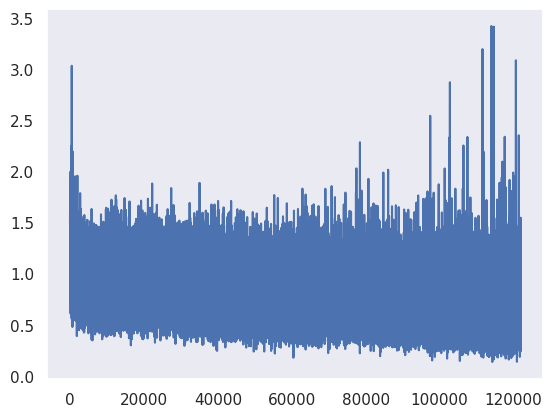

In [101]:
plt.plot(train_losses)

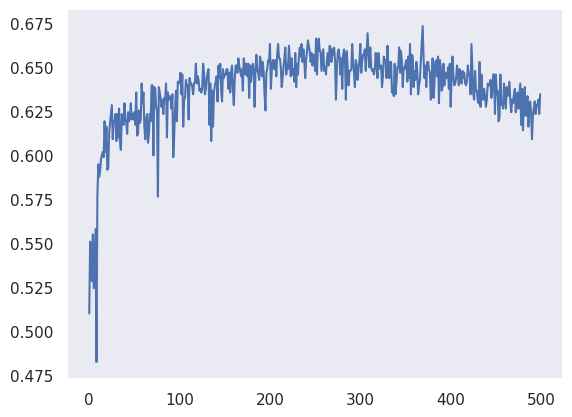

In [102]:
plt.plot(test_accuracy)

In [103]:
metrics4, confusion_matrix4 = report_metrics(
    model, labels=labels, device=device)
pprint(metrics4.compute())
confusion_matrix4.compute()

Correct: 622/976 (0.6373)
{'acc_detail': tensor([0.7126, 0.6481, 0.6339, 0.5556], device='cuda:0'),
 'acc_unweighted': tensor(0.6375, device='cuda:0'),
 'acc_weighted': tensor(0.6373, device='cuda:0'),
 'f1s_detail': tensor([0.7343, 0.5668, 0.6970, 0.5567], device='cuda:0'),
 'f1s_unweighted': tensor(0.6387, device='cuda:0'),
 'f1s_weighted': tensor(0.6416, device='cuda:0'),
 'precision_detail': tensor([0.7573, 0.5036, 0.7740, 0.5578], device='cuda:0'),
 'recall_detail': tensor([0.7126, 0.6481, 0.6339, 0.5556], device='cuda:0'),
 'rocauc': tensor(0.8594, device='cuda:0'),
 'rocauc_detail': tensor([0.9064, 0.8357, 0.9009, 0.7945], device='cuda:0'),
 'uar': tensor(0.6375, device='cuda:0'),
 'wap': tensor(0.6540, device='cuda:0')}


tensor([[181,  15,   4,  54],
        [  6, 140,  29,  41],
        [  7,  70, 161,  16],
        [ 45,  53,  14, 140]], device='cuda:0')

In [104]:
model.to('cpu')
best_model_path = f'{model_path_prefix}{best_epoch}epoch.pt'
print(best_model_path)
best_model = M13(config=model_config,
           n_input=1, n_output=len(labels))
best_model.load_state_dict(torch.load(best_model_path))
best_model.to(device)

metrics_best, confusion_matrix_best = report_metrics(
    best_model, labels=labels, device=device)
best_model.to('cpu')
pprint(metrics_best.compute())
confusion_matrix_best.compute()

../models_cremad4/cremad_label4_m13ser_best_370epoch.pt
Correct: 660/976 (0.6762)
{'acc_detail': tensor([0.7913, 0.6574, 0.6890, 0.5635], device='cuda:0'),
 'acc_unweighted': tensor(0.6753, device='cuda:0'),
 'acc_weighted': tensor(0.6762, device='cuda:0'),
 'f1s_detail': tensor([0.7686, 0.6134, 0.7277, 0.5856], device='cuda:0'),
 'f1s_unweighted': tensor(0.6738, device='cuda:0'),
 'f1s_weighted': tensor(0.6763, device='cuda:0'),
 'precision_detail': tensor([0.7472, 0.5749, 0.7709, 0.6094], device='cuda:0'),
 'recall_detail': tensor([0.7913, 0.6574, 0.6890, 0.5635], device='cuda:0'),
 'rocauc': tensor(0.8731, device='cuda:0'),
 'rocauc_detail': tensor([0.9141, 0.8573, 0.9129, 0.8081], device='cuda:0'),
 'uar': tensor(0.6753, device='cuda:0'),
 'wap': tensor(0.6797, device='cuda:0')}


tensor([[201,  12,   4,  37],
        [  8, 142,  28,  38],
        [  7,  56, 175,  16],
        [ 53,  37,  20, 142]], device='cuda:0')

In [105]:
checkpoint_path = f'../models_cremad4/cremad4_m13ser_{epoch}epoch.ckpt'
torch.save({
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': train_losses[-1],
    'best_epoch': best_epoch,
    'best_accuracy': best_accuracy,
    'train_losses': train_losses,
    'test_accuracy': test_accuracy,
    'log_interval': log_interval,
    }, checkpoint_path)

Time domain: Filters' shapes vary by frequency bins


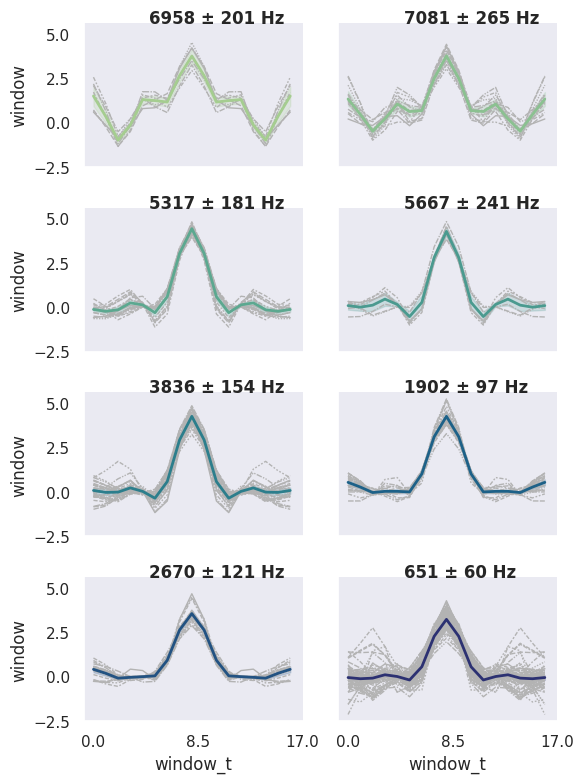

In [106]:
layer = best_model.fe_blocks.blocks[0].block.layer

filtviz = visualize_model.FilterVisualizer(
    lowcut_bands = layer.lowcut_bands, 
    bandwidths = layer.bandwidths,
    window_params = layer.window_params, 
    window_length = 64,
    sample_rate = sr
)
filtviz.visualize_filters(filter_domain='time')

Frequency domain: Filters' shapes vary by frequency bins


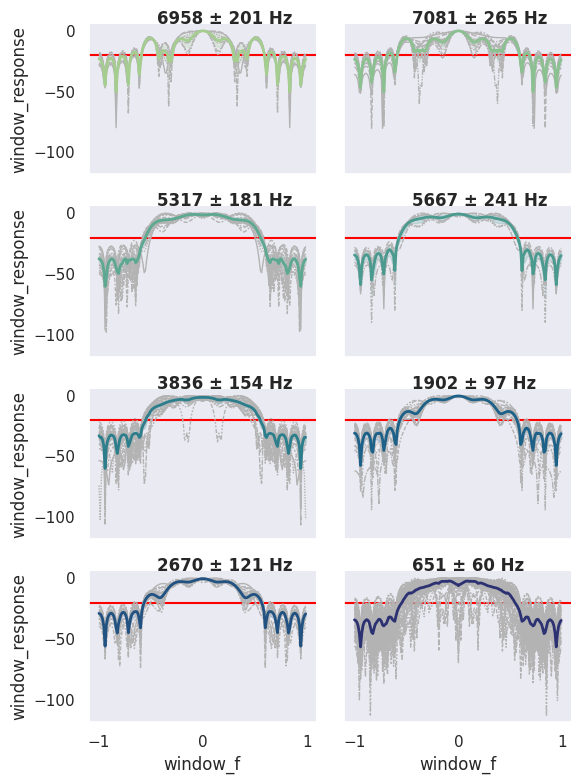

In [107]:
filtviz.visualize_filters(filter_domain='freq')

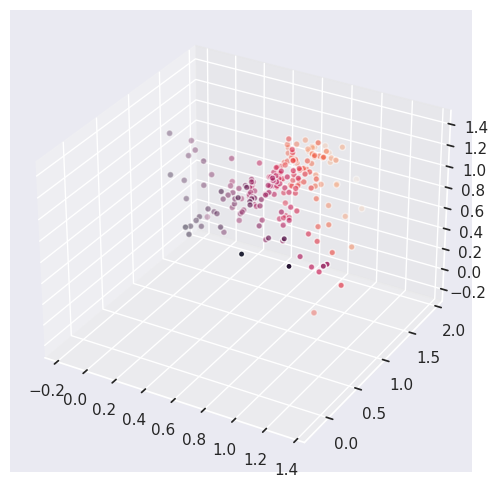

In [108]:
filtviz.visualize_window_params()

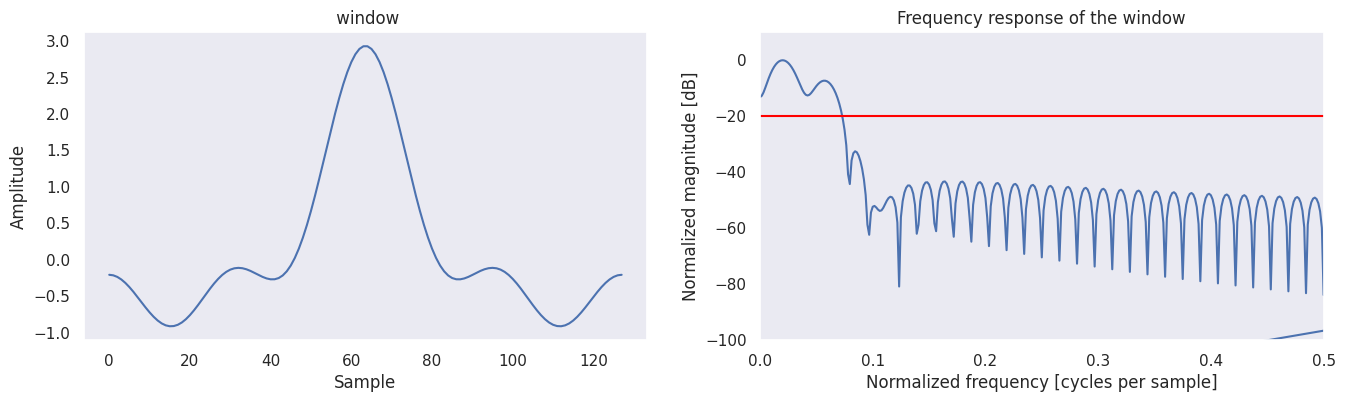

In [109]:
filtviz.visualize_one_window(n_out=10)

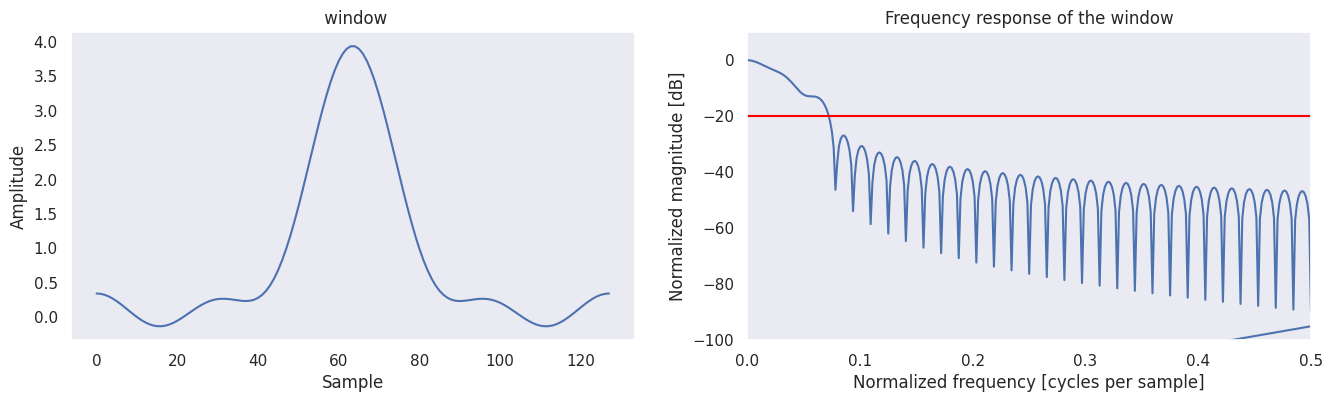

In [110]:
filtviz.visualize_one_window(n_out=30)

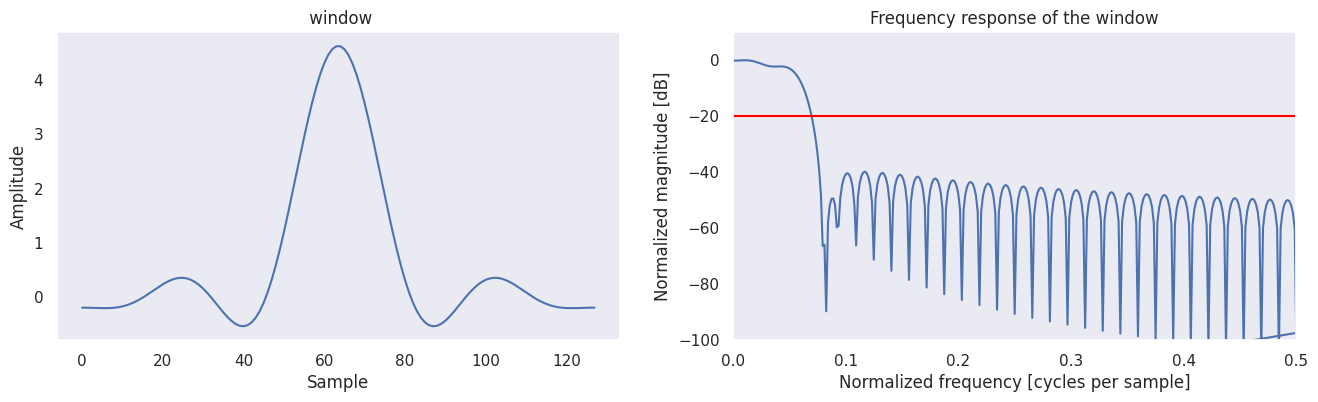

In [111]:
filtviz.visualize_one_window(n_out=50)

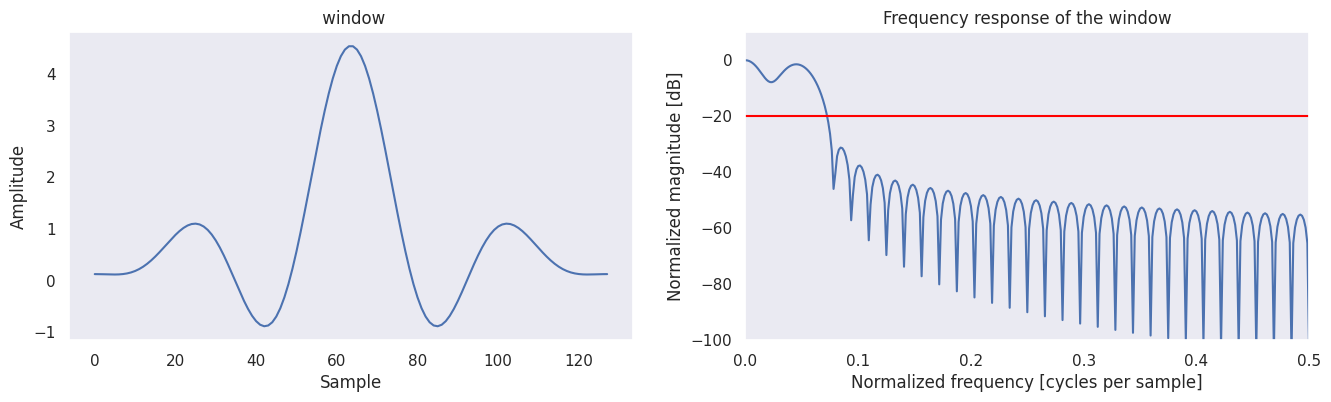

In [112]:
filtviz.visualize_one_window(n_out=60)

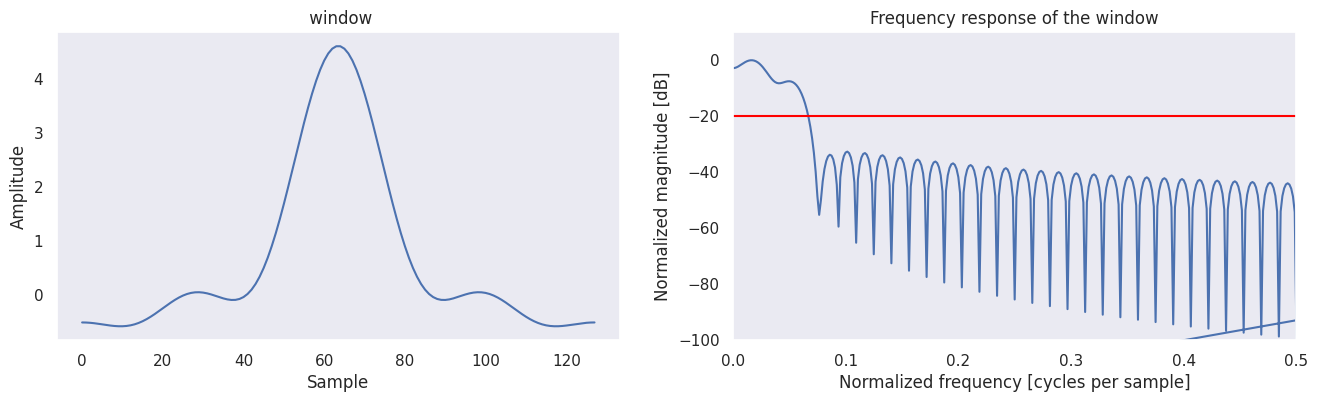

In [113]:
filtviz.visualize_one_window(n_out=120)

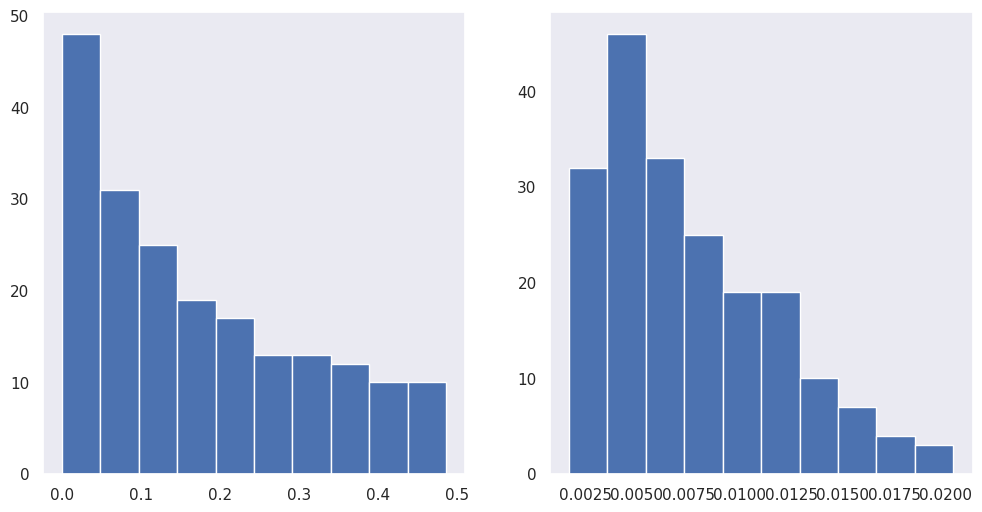

In [114]:
filtviz.visualize_bands()